# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/0rep_0noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/0rep_0noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/0rep_0noiseLevel_GMA_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/0rep_0noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/0rep_0noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/0rep_0noiseLevel_GMA_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.307409        0.195957  0.054515  0.251346  0.068643   
       0.50   0.311761        0.189999  0.061382  0.220293  0.099379   
       0.75   0.315009        0.183381  0.068825  0.198856  0.120063   
       1.00   0.317709        0.176455  0.076020  0.183449  0.134574   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.200062  0.009897  0.039914  0.049520  0.000575  
       0.50  0.200554  0.009227  0.039269  0.049266  0.001492  
       0.75  0.201776  0.008097  0.038130  0.049349  0.002555  
       1.00  0.203795  0.006931  0.036924  0.049404  0.003708

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.307409        0.195957  0.054515  0.251346  0.068643   
       0.50   0.311761        0.189999  0.061382  0.220293  0.099379   
       0.75   0.315009        0.183381  0.068825  0.198856  0.120063   
       1.00   0.317709        0.176455  0.076020  0.183449  0.134574   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.200062  0.009897  0.039914  0.049520  0.000575  
       0.50  0.200554  0.009227  0.039269  0.049266  0.001492  
       0.75  0.201776  0.008097  0.038130  0.049349  0.002555  
       1.00  0.203795  0.006931  0.036924  0.049404  0.003708

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.307409        0.195957  0.054515  0.251346  0.068643   
       0.50   0.311761        0.189999  0.061382  0.220293  0.099379   
       0.75   0.315009        0.183381  0.068825  0.198856  0.120063   
       1.00   0.317709        0.176455  0.076020  0.183449  0.134574   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.200062  0.009897  0.039914  0.049520  0.000575  
       0.50  0.200554  0.009227  0.039269  0.049266  0.001492  
       0.75  0.201776  0.008097  0.038130  0.049349  0.002555  
       1.00  0.203795  0.006931  0.036924  0.049404  0.003708

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25   0.303073        0.195043  0.057155  0.250311  0.069661   
         0.50   0.299893        0.188541  0.068037  0.218933  0.100735   
         0.75   0.294538        0.181467  0.079599  0.197732  0.121566   
         1.00   0.288190        0.174077  0.089557  0.183997  0.136357   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
         0.25  0.200059  0.009901  0.039914  0.049716  0.000379  
         0.50  0.200543  0.009250  0.039268  0.049773  0.000986  
         0.75  0.201742  0.008158  0.038120  0.050221  0.001694  
         1.00  0.203716  0.007056  0.036890  0.050678  0.002468

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         0.25  4.568047e+06  2.339239e+06  216501.990022  1.413483e+06   
         0.50  5.471875e+06  3.482933e+06  339448.988190  2.217158e+06   
         0.75  5.858245e+06  4.161080e+06  418715.475569  2.735644e+06   
         1.00  6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.599588  5.448132e+01  5.547215e+01      18.687782   
         0.25  473518.755617  2.301051e+06  2.600509e+06  428799.016790   
         0.50  724132.403320  3.761395e+06  3.265182e+06  639992.856400   
         0.75  879253.836051  4.770619e+06  3.569278e+06  765704.580833   
         1.00  984727.523254  5.509792e+06  3.743605e+06  849097.962158   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.341080  
         0.25     183705.772400  
         0.50     286614.273964  
         0.75     352427.155323  
         1.00     398139.231561

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


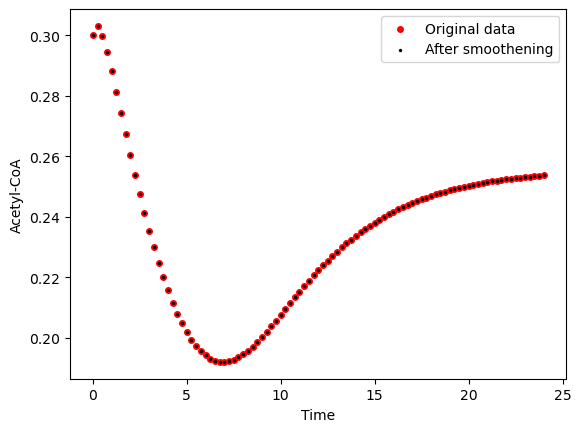

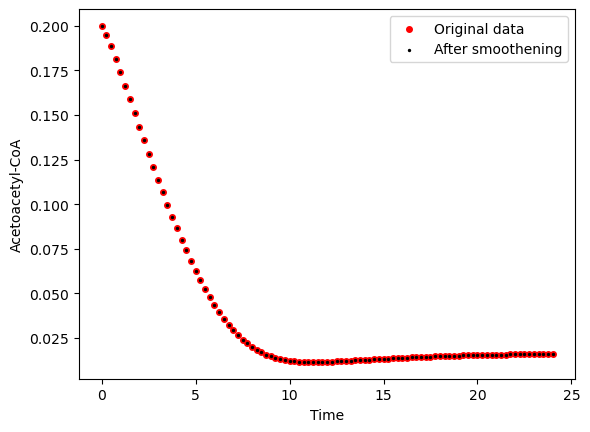

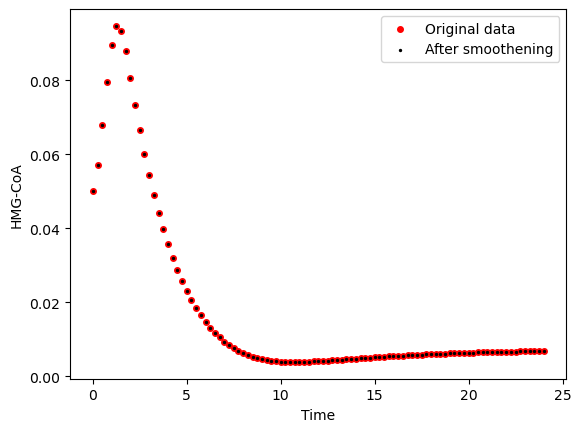

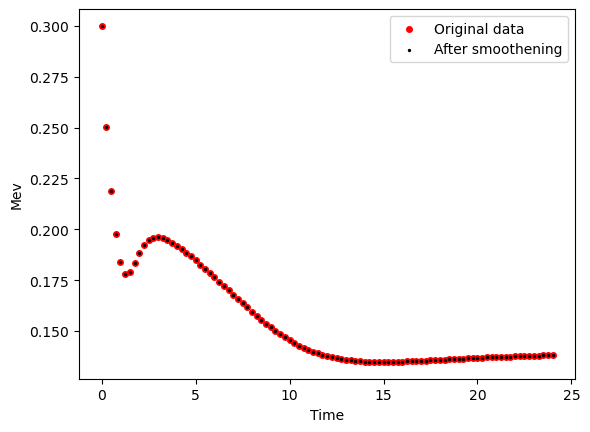

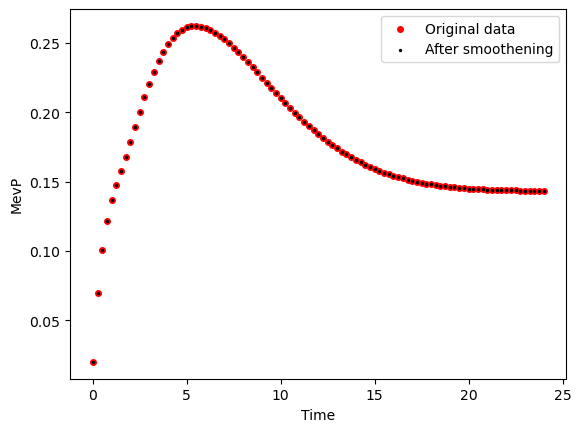

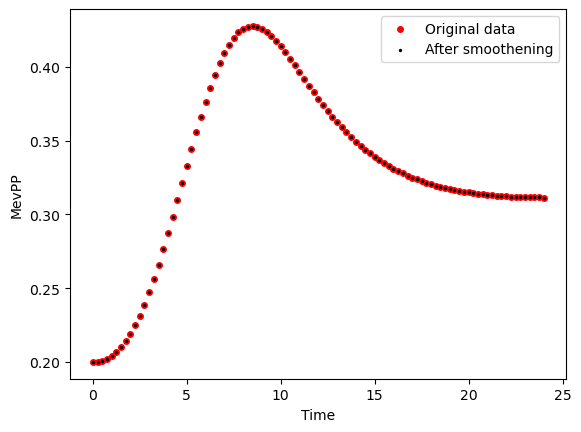

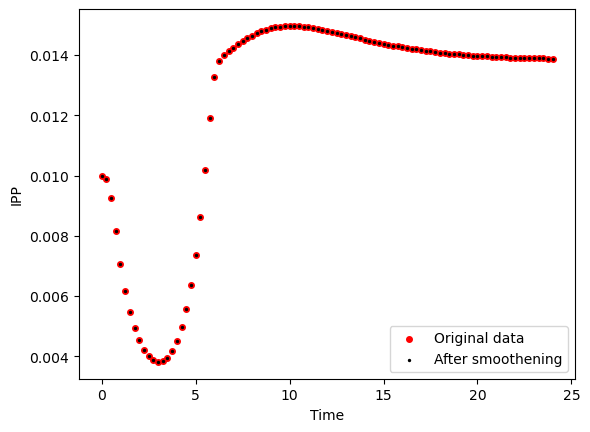

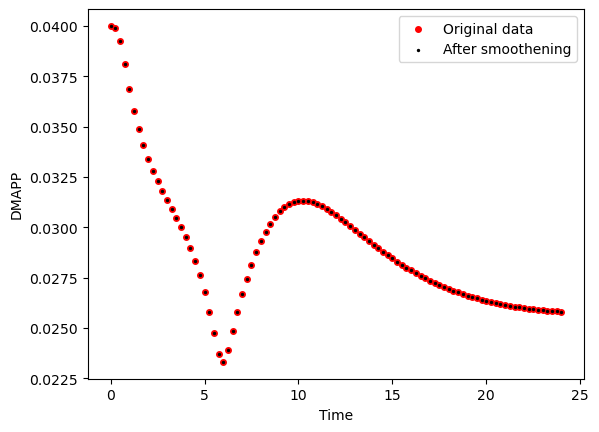

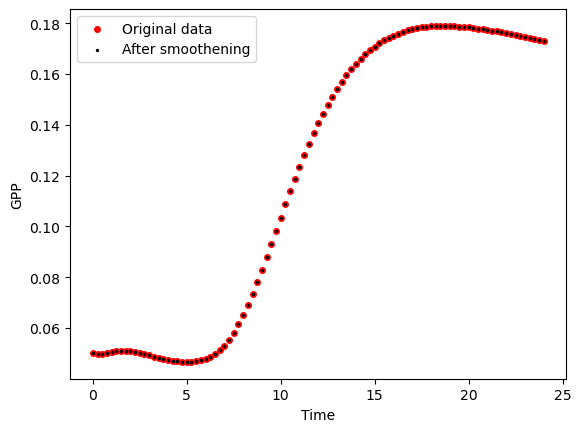

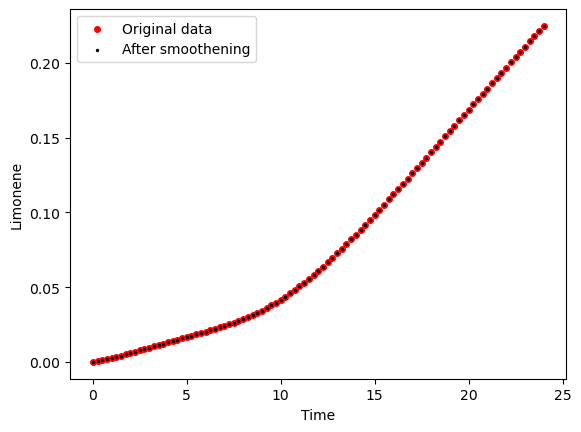

Strain Strain 2


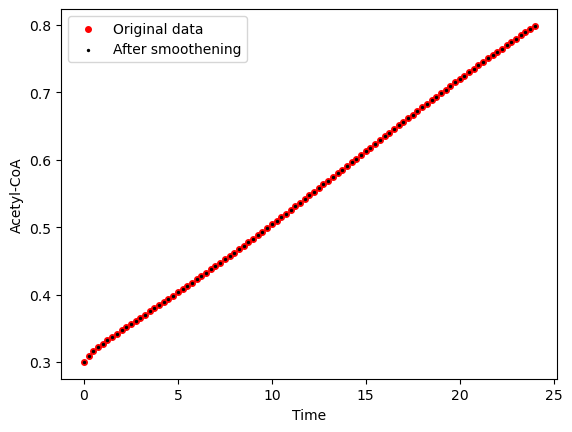

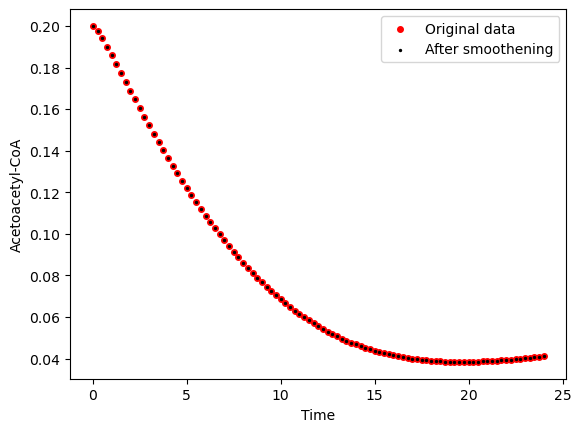

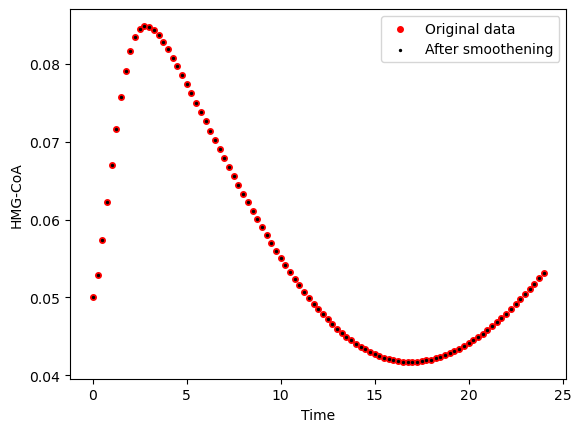

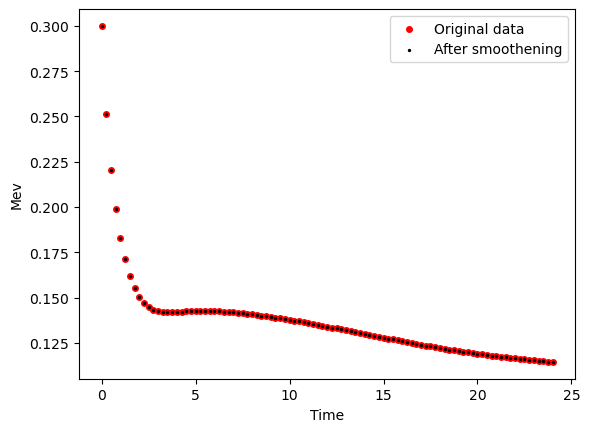

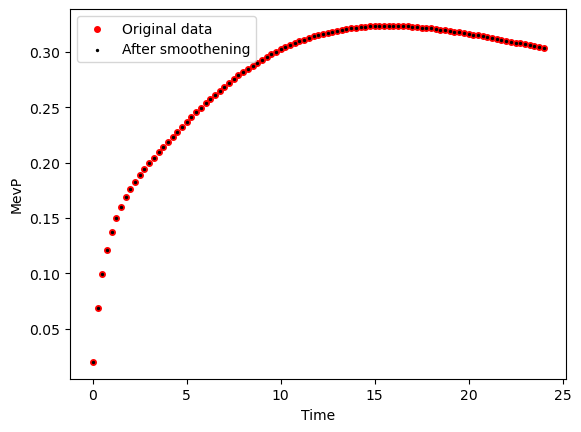

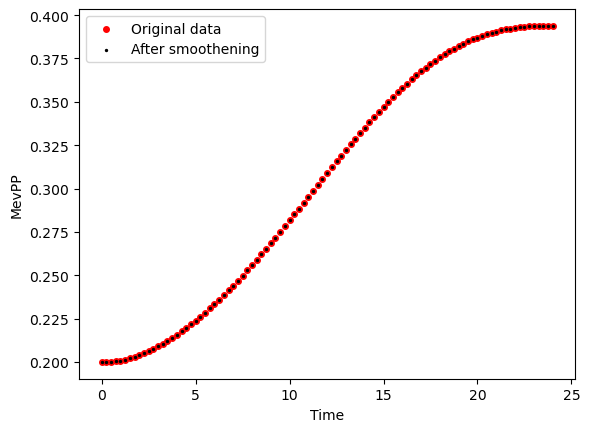

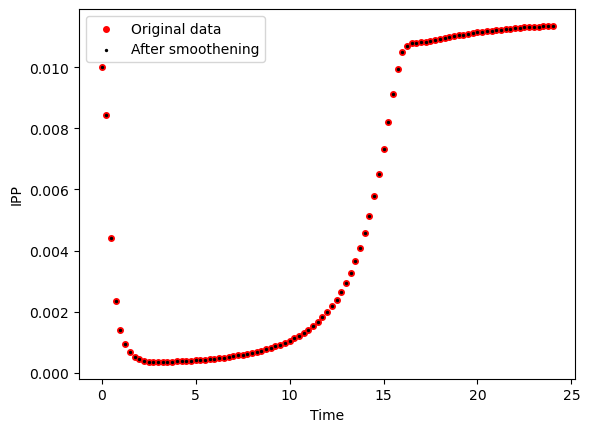

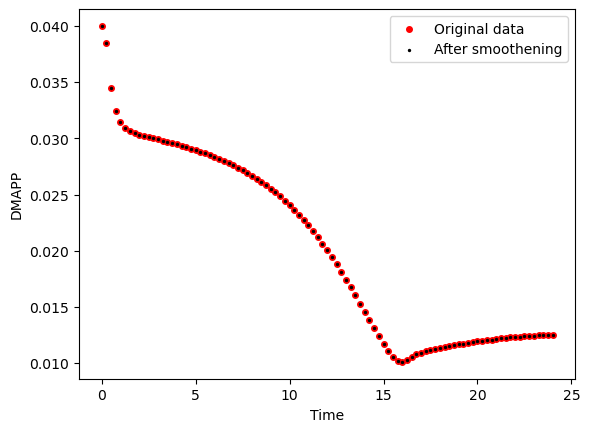

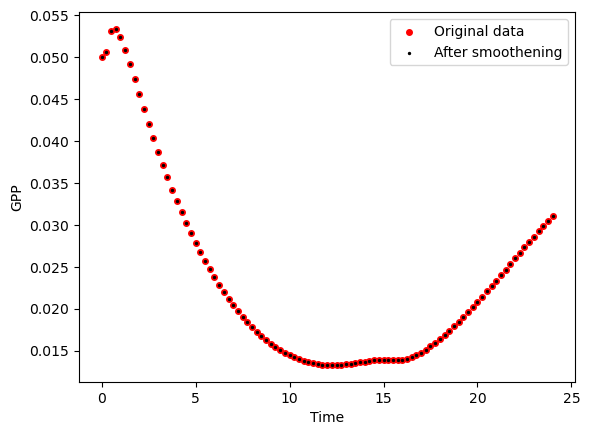

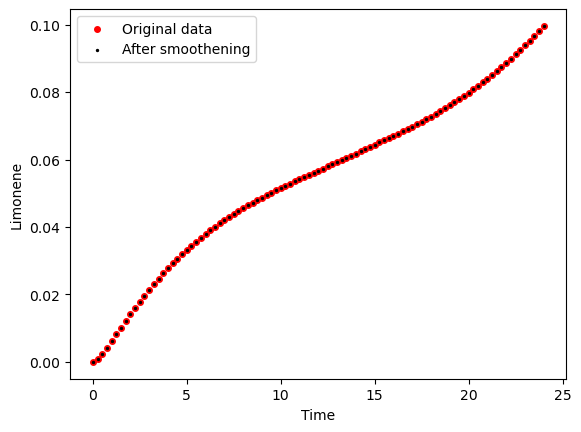

Strain Strain 3


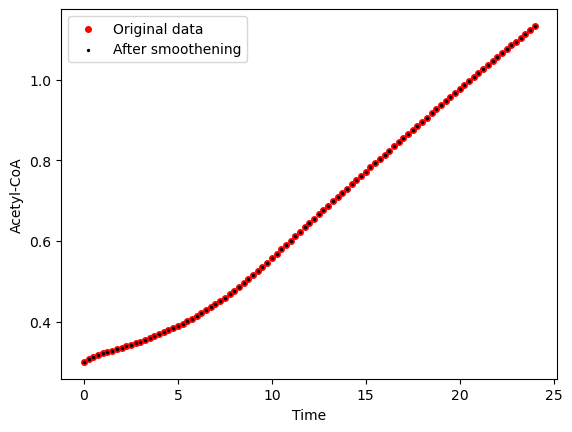

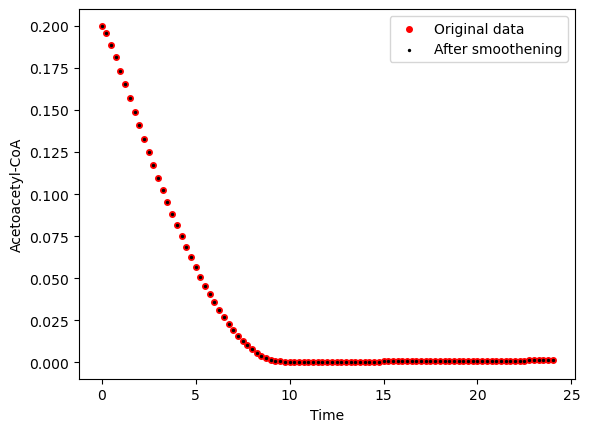

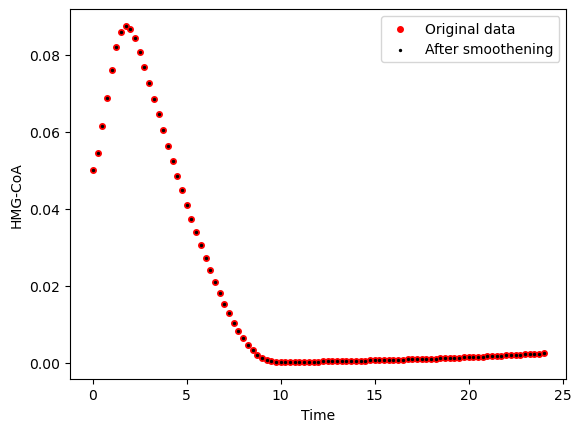

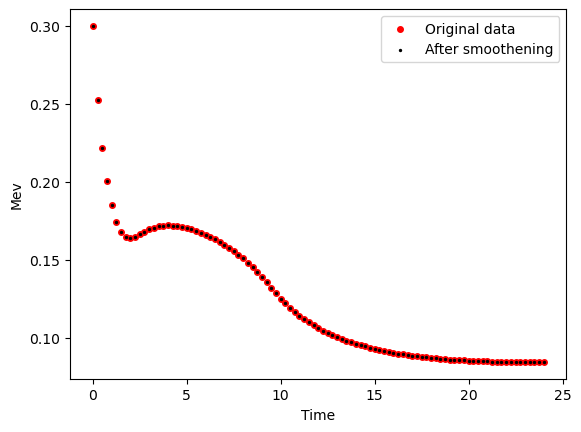

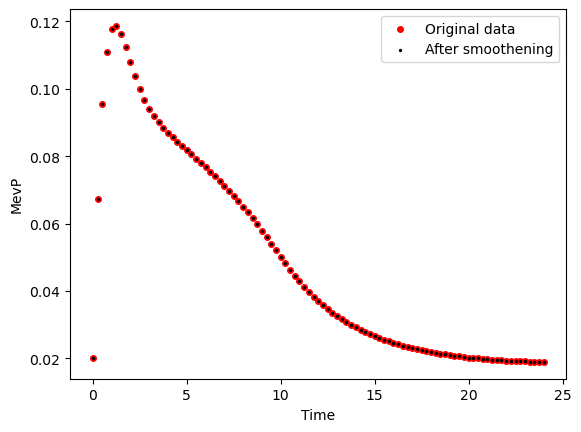

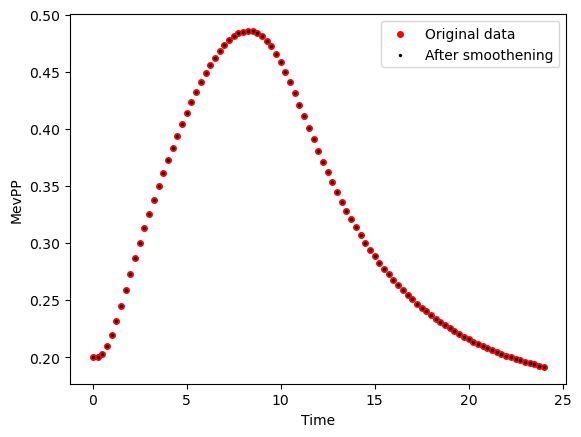

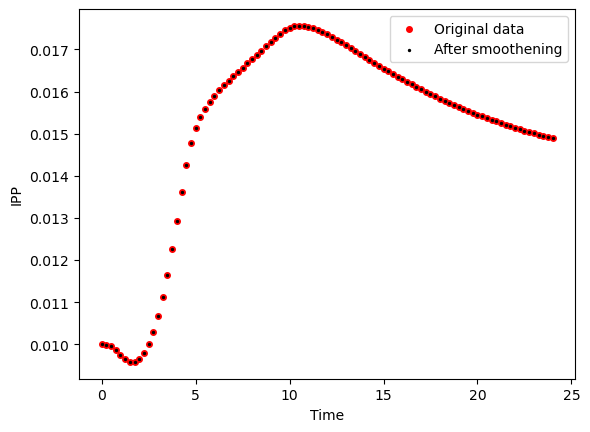

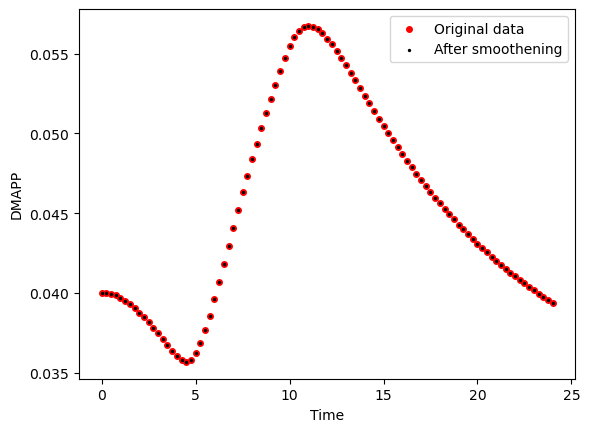

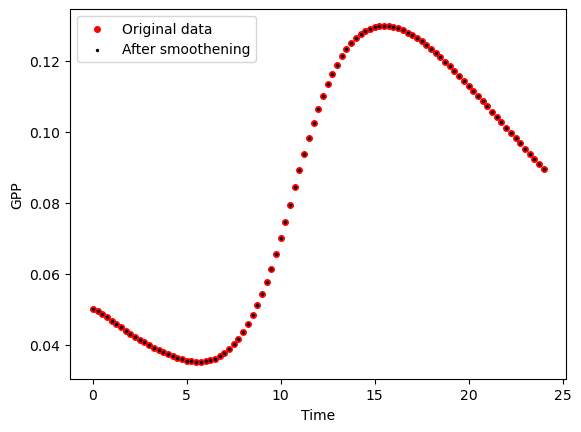

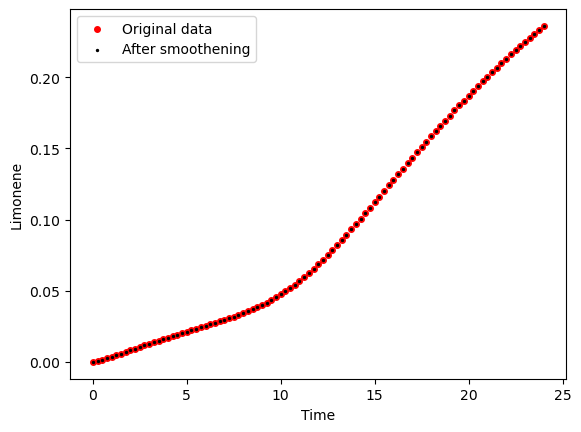

Strain WT


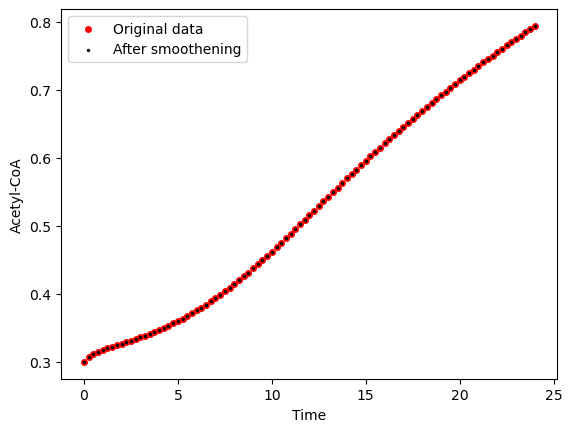

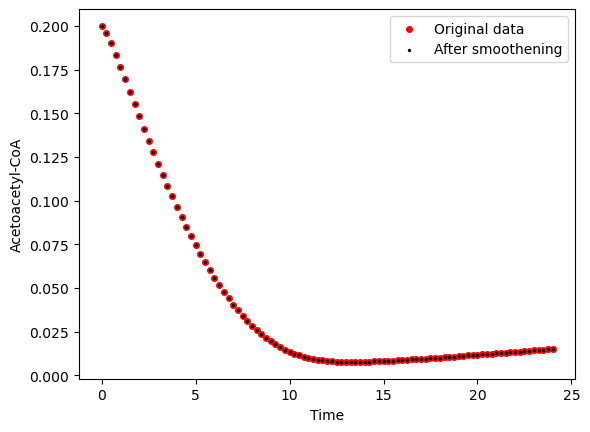

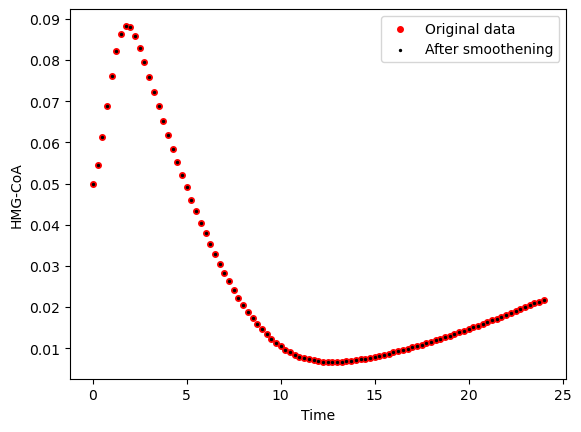

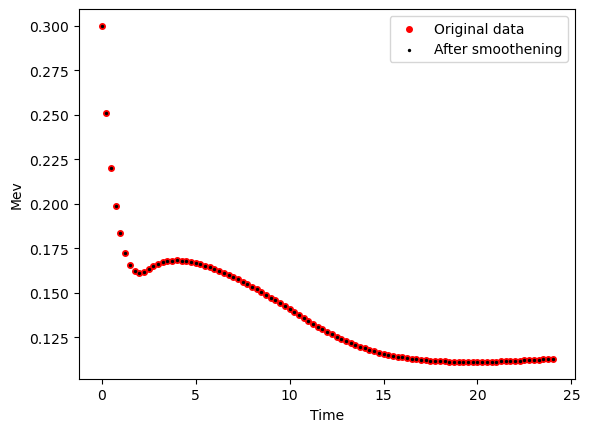

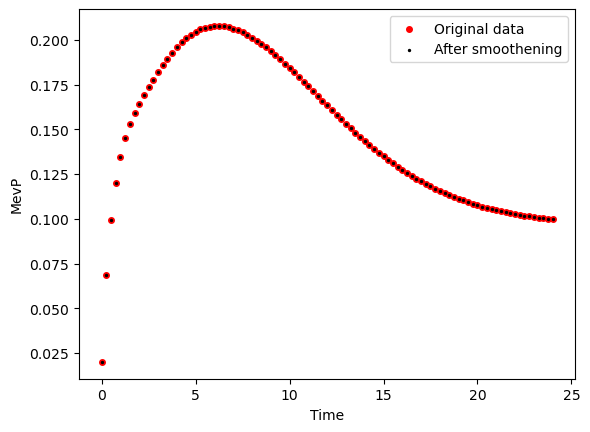

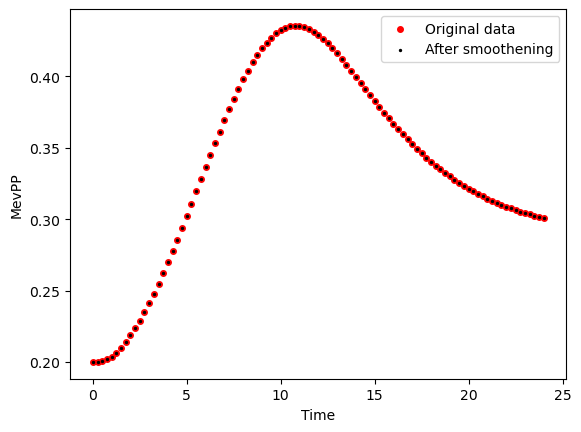

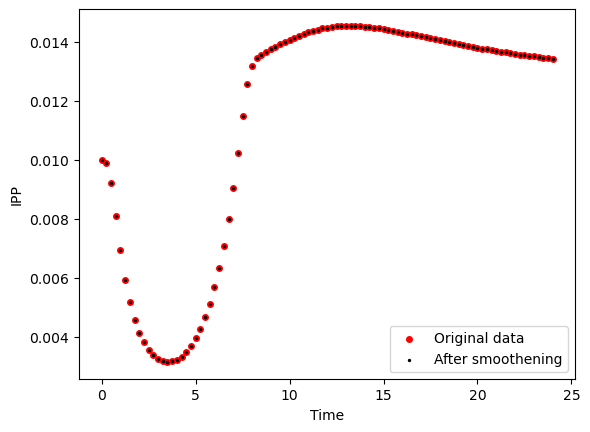

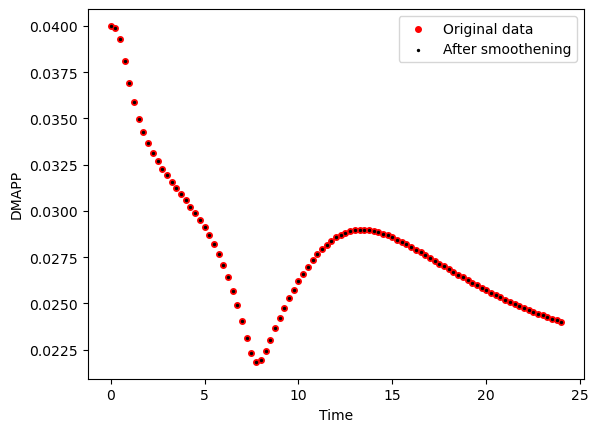

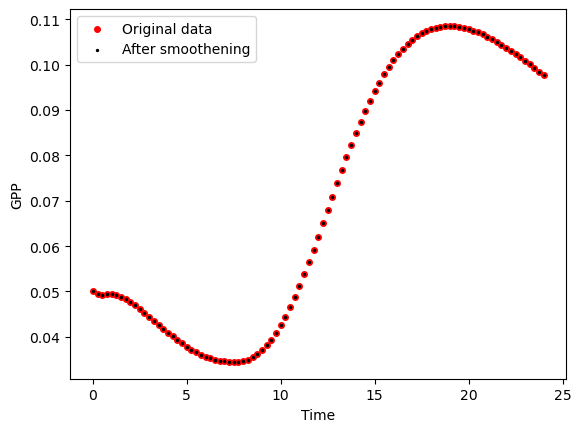

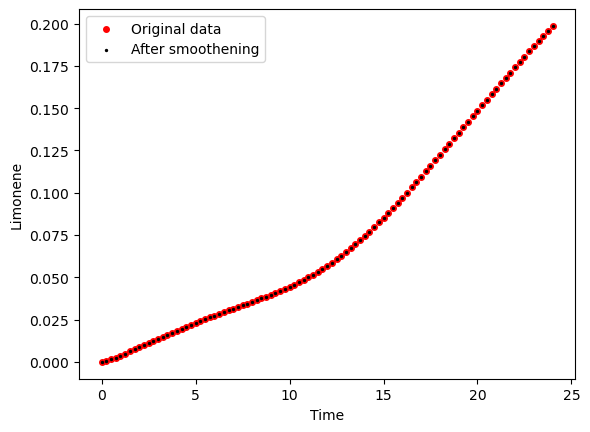

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


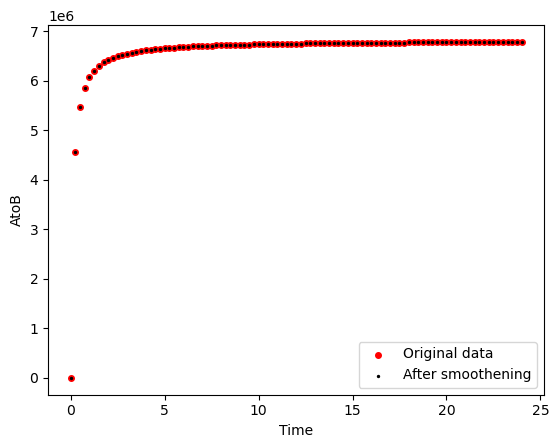

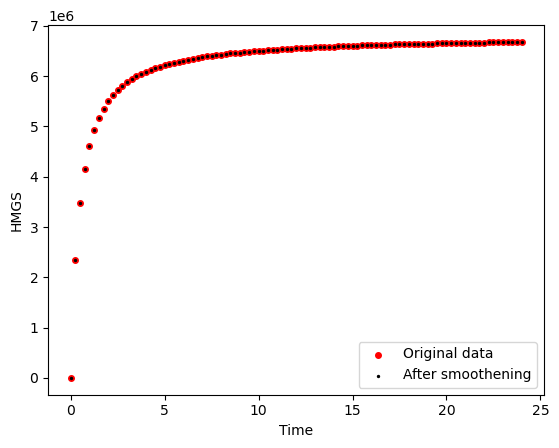

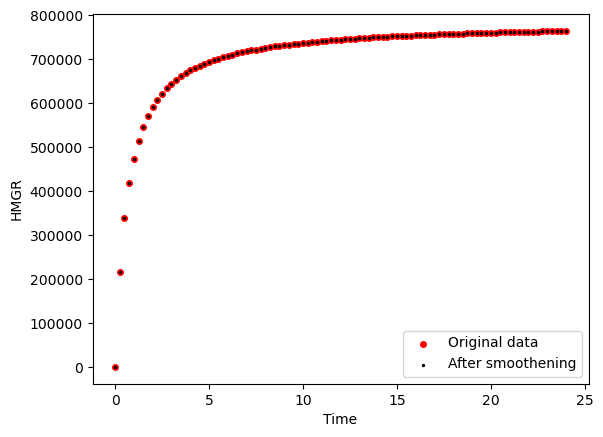

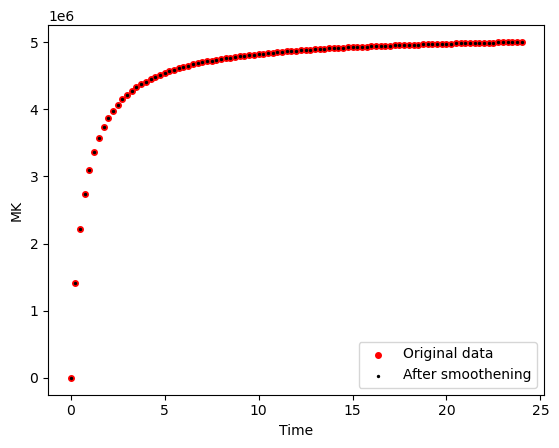

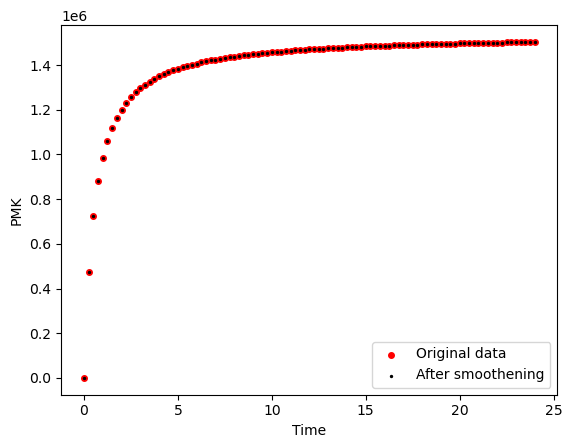

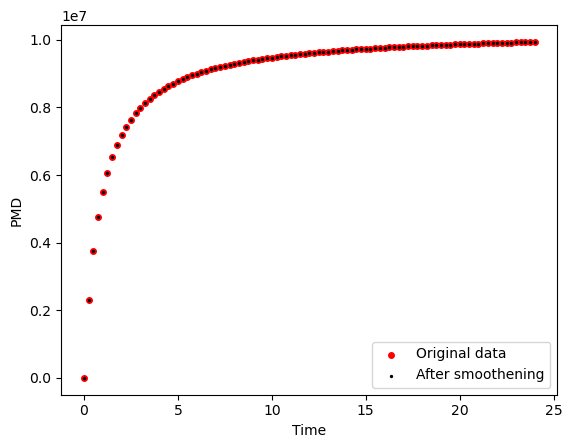

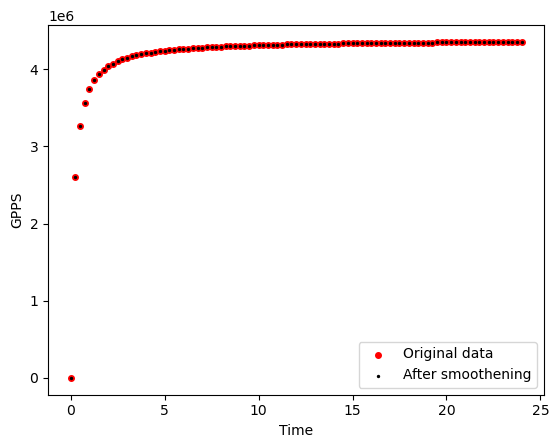

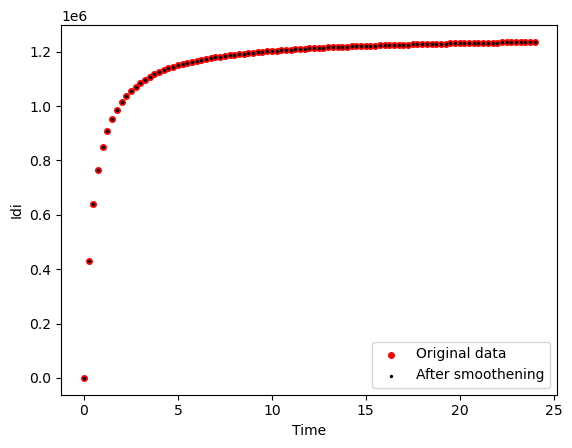

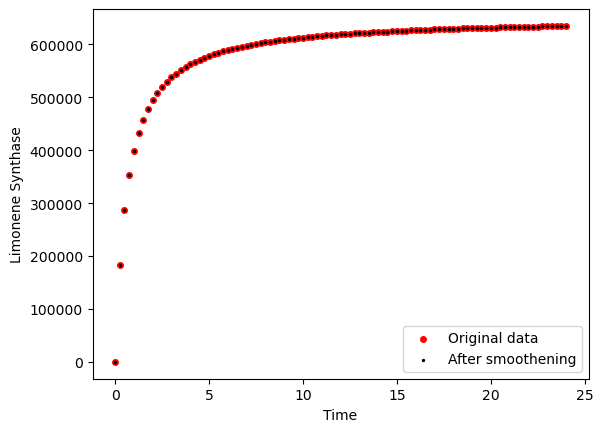

Strain Strain 2


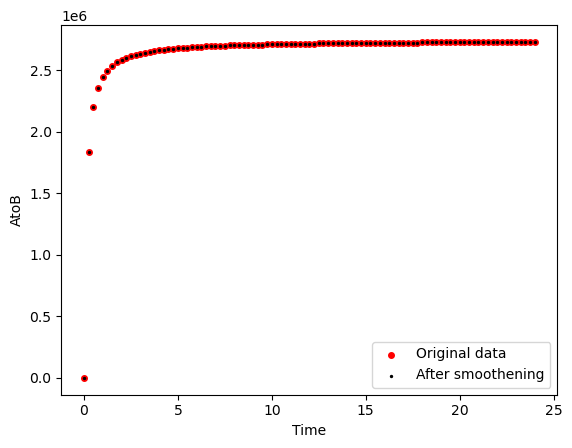

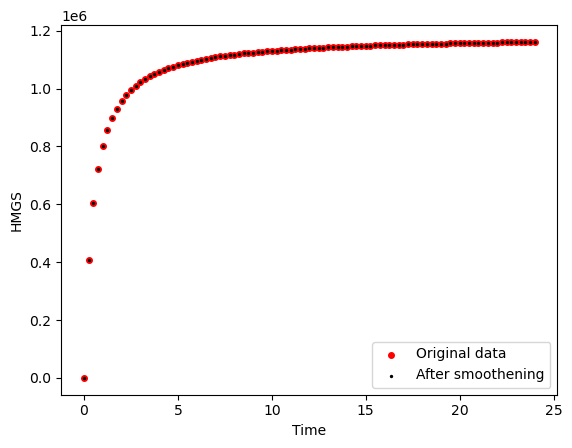

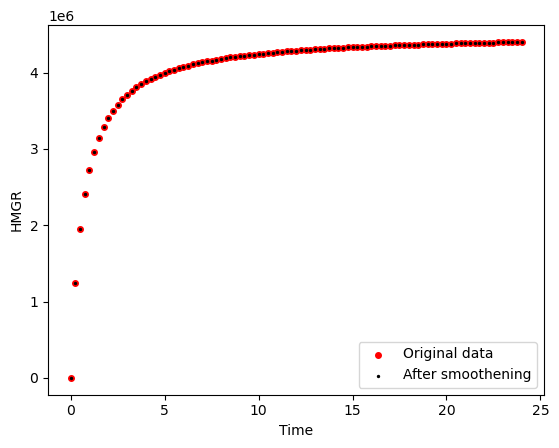

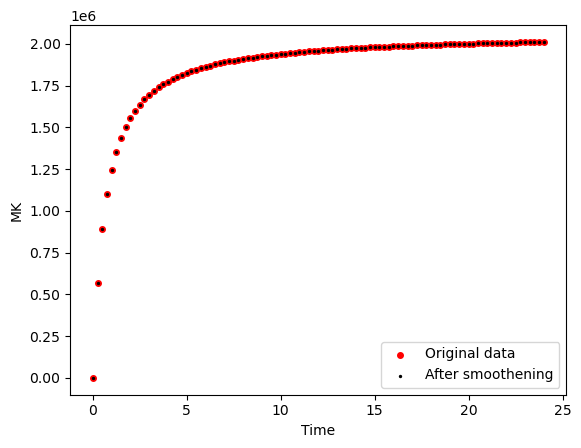

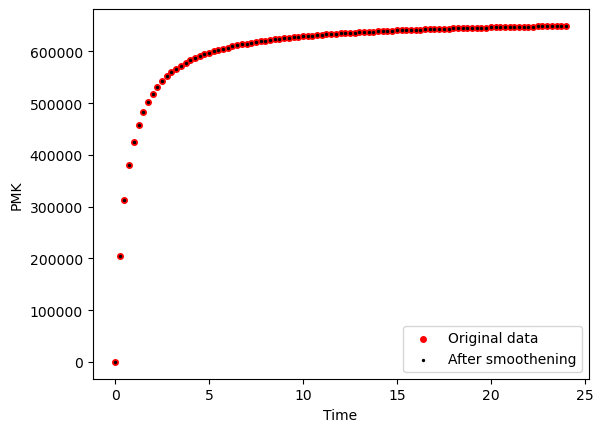

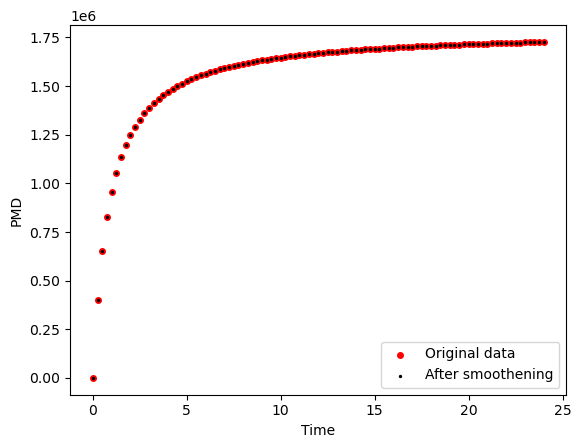

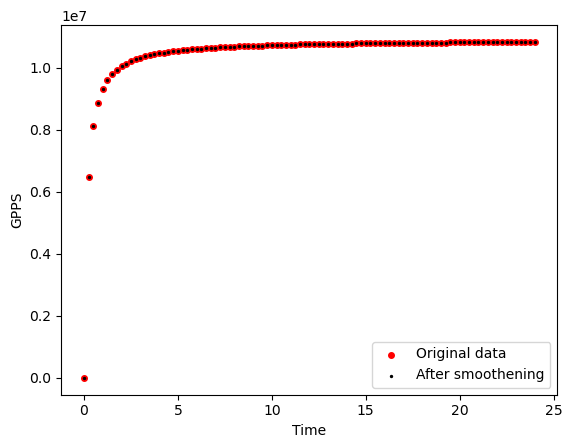

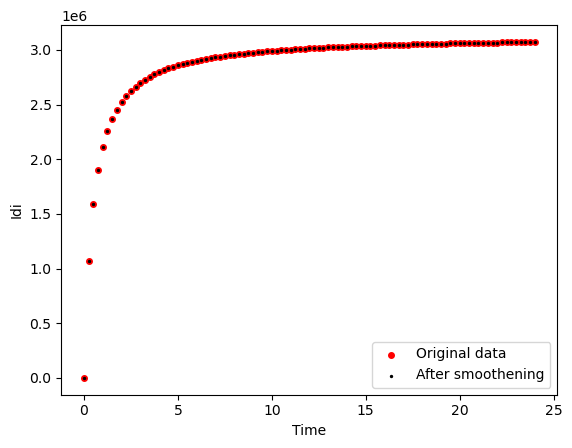

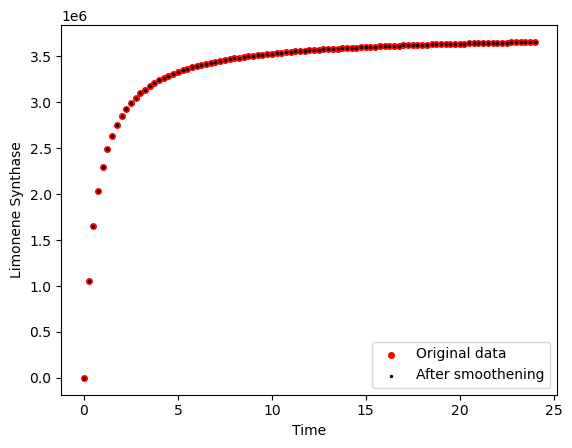

Strain Strain 3


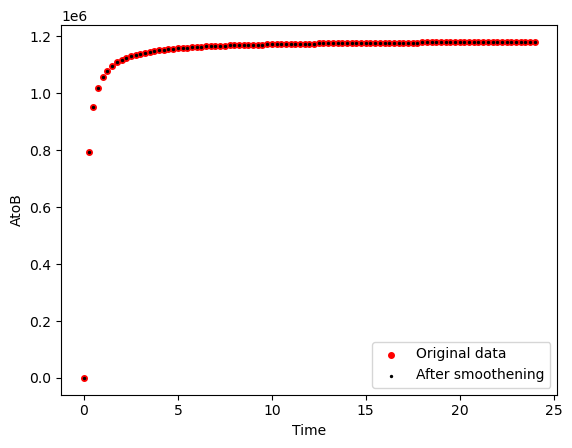

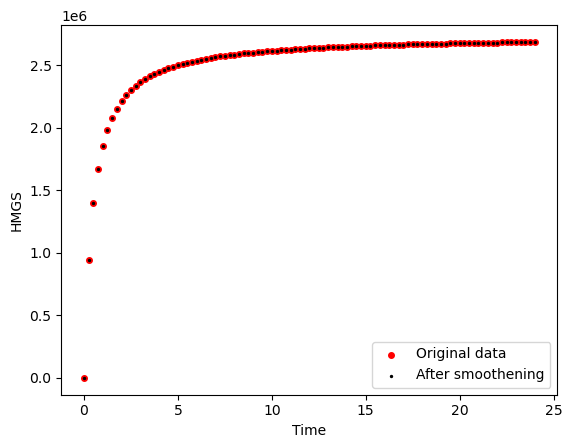

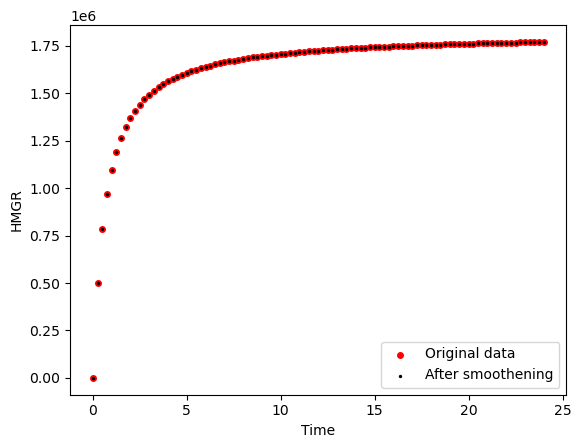

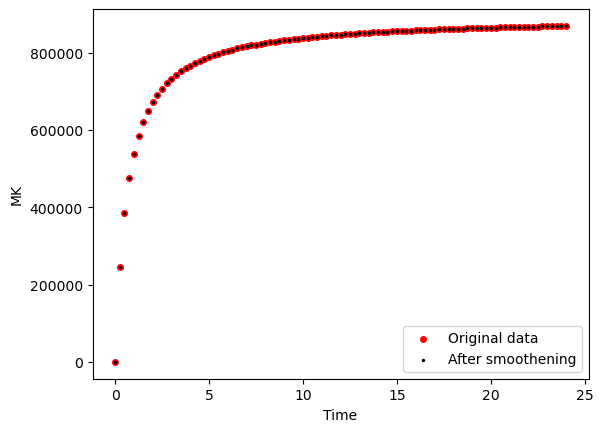

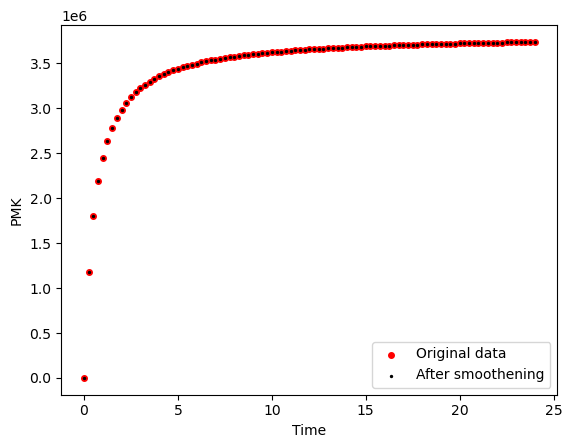

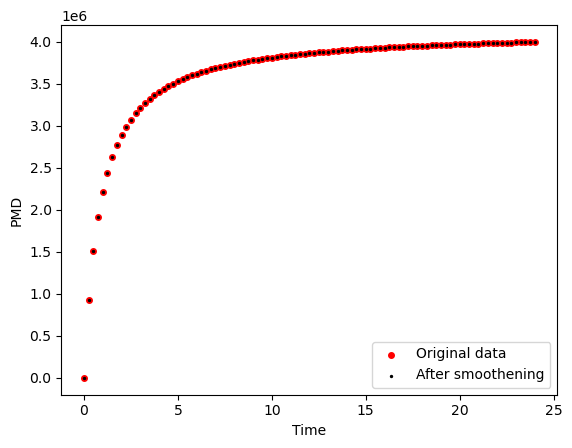

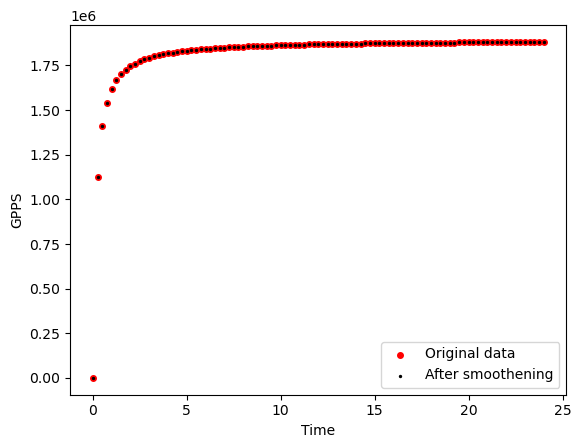

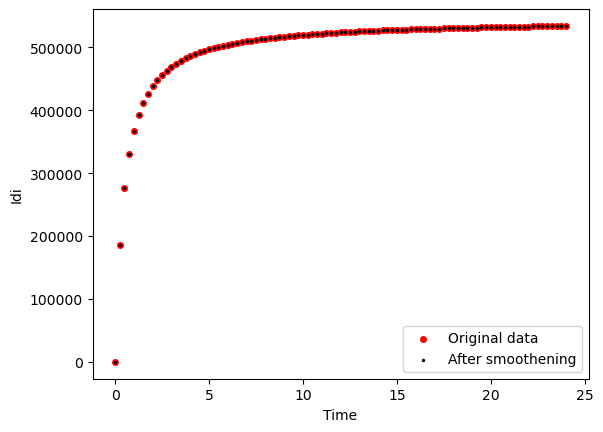

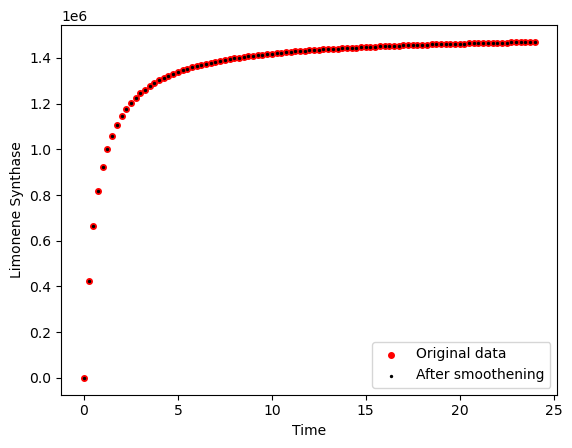

Strain WT


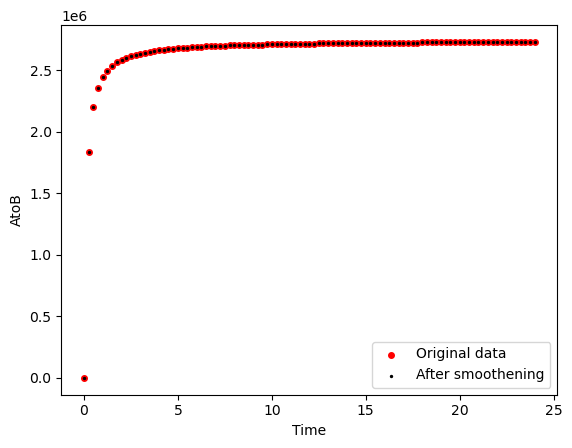

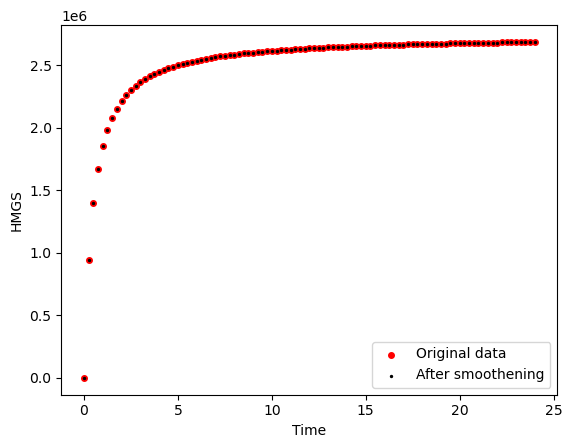

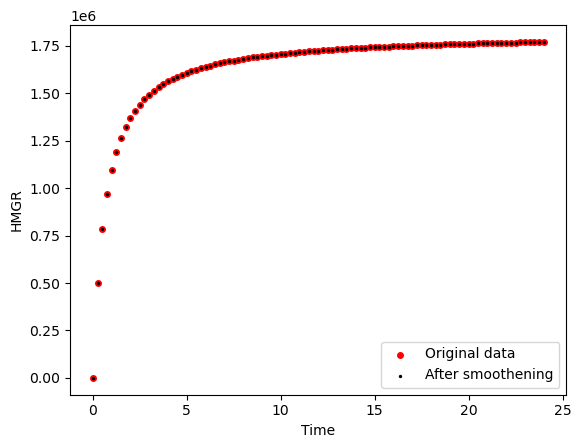

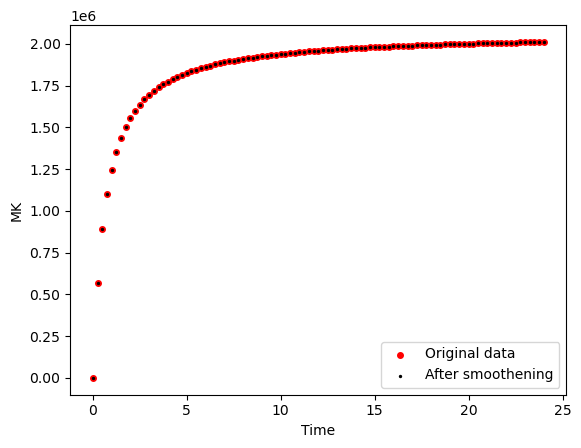

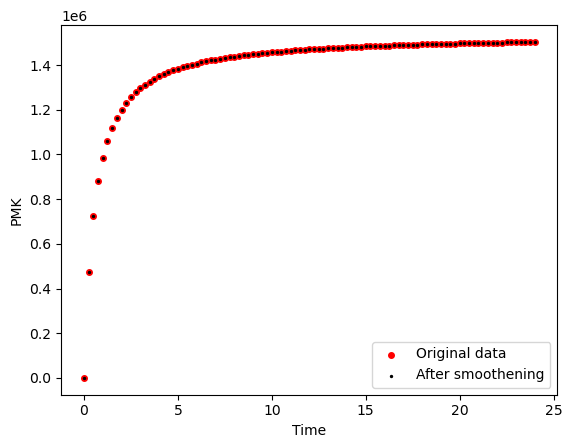

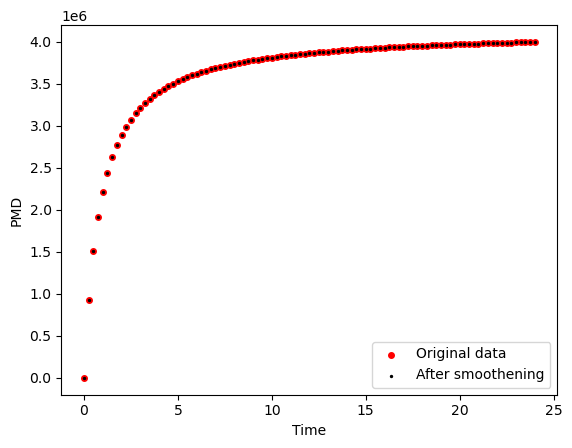

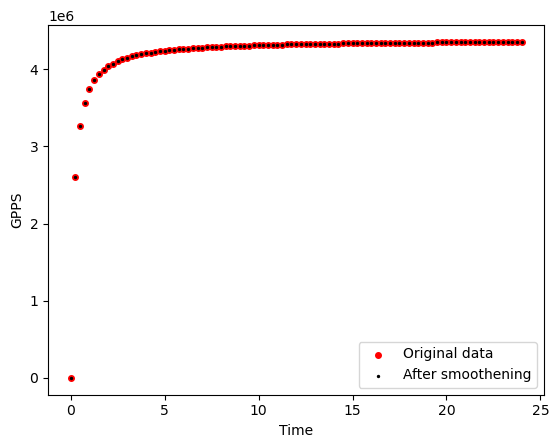

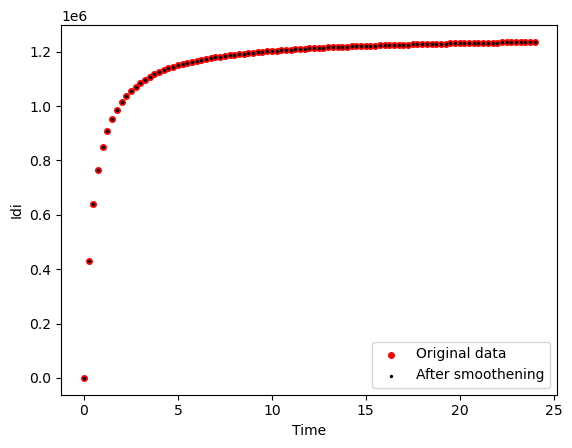

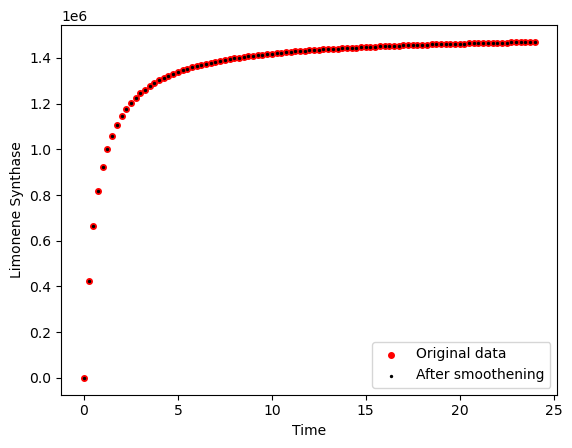

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25    0.303073        0.195043  0.057155  0.250311  0.069661   
         0.50    0.299893        0.188541  0.068037  0.218933  0.100735   
         0.75    0.294538        0.181467  0.079599  0.197732  0.121566   
         1.00    0.288190        0.174077  0.089557  0.183997  0.136357   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.775039        0.014167  0.019944  0.112389  0.101024   
         23.25   0.779833        0.014374  0.020413  0.112530  0.100700   
         23.50   0.784584        0.014581  0.020886  0.112676  0.100406   
         23.75   0.789290        0.014788  0.021363  0.112825  0.100138   
         24.00   0.793953        0.014996  0.021843  0.112979  0.099897   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.25   0.200059  0.009901  0.039914  0.049716  0.000379  ...   
         0.50   0.200543  0.009250  0.039268  0.049773  0.000986  ...   
         0.75   0.201742  0.008158  0.038120  0.050221  0.001694  ...   
         1.00   0.203716  0.007056  0.036890  0.050678  0.002468  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.304296  0.013499  0.024360  0.100867  0.186575  ...   
         23.25  0.303339  0.013479  0.024268  0.100090  0.189619  ...   
         23.50  0.302440  0.013460  0.024180  0.099296  0.192639  ...   
         23.75  0.301600  0.013442  0.024094  0.098489  0.195636  ...   
         24.00  0.300814  0.013424  0.024011  0.097670  0.198608  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.018594       -0.018182  0.018805 -0.220877  0.228172   
         0.25    -0.001101       -0.023119  0.037819 -0.160423  0.158607   
         0.50    -0.015600       -0.026822  0.046418 -0.109091  0.105123   
         0.75    -0.024903       -0.029292  0.044600 -0.066881  0.067719   
         1.00    -0.026775       -0.030023  0.030284 -0.037420  0.050530   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.019269        0.000828  0.001867  0.000553 -0.001353   
         23.25    0.019090        0.000828  0.001883  0.000573 -0.001236   
         23.50    0.018914        0.000829  0.001899  0.000591 -0.001124   
         23.75    0.018739        0.000829  0.001915  0.000606 -0.001016   
         24.00    0.018565        0.000829  0.001931  0.000620 -0.000913   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.001239  0.001000  0.001198 -0.002373  0.001240  
         0.25   0.001046 -0.001742 -0.001698 -0.000249  0.001999  
         0.50   0.003542 -0.003549 -0.003689  0.001138  0.002590  
         0.75   0.006251 -0.004420 -0.004777  0.001790  0.003013  
         1.00   0.009342 -0.004136 -0.004793  0.001594  0.003202  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003953 -0.000080 -0.000374 -0.003075  0.012221  
         23.25 -0.003710 -0.000078 -0.000361 -0.003144  0.012129  
         23.50 -0.003476 -0.000075 -0.000349 -0.003203  0.012034  
         23.75 -0.003251 -0.000072 -0.000337 -0.003253  0.011938  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

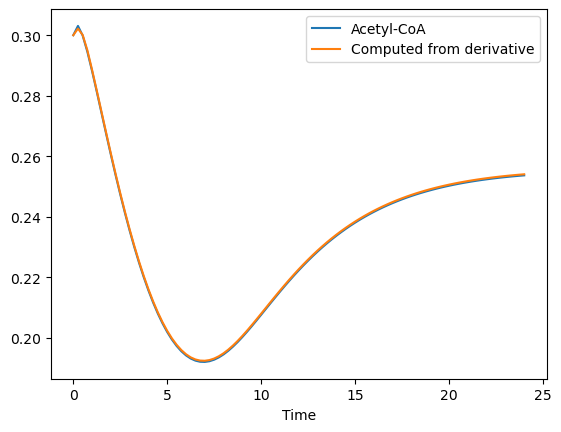

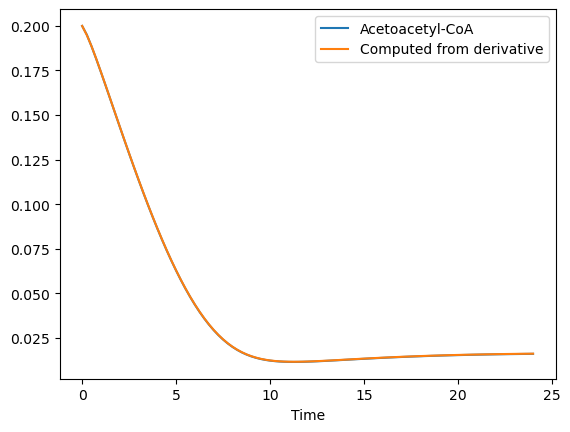

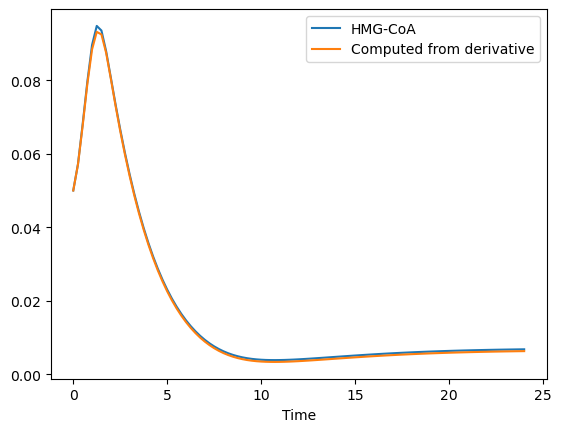

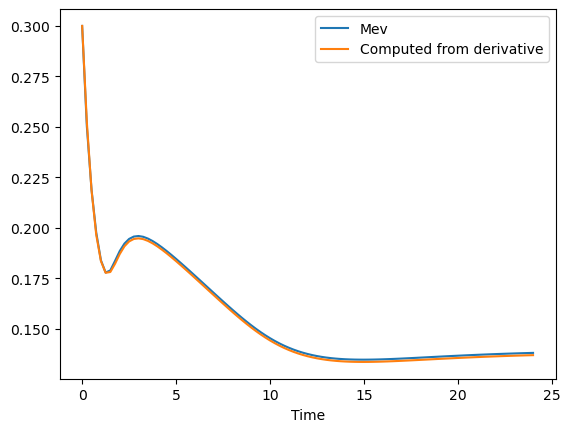

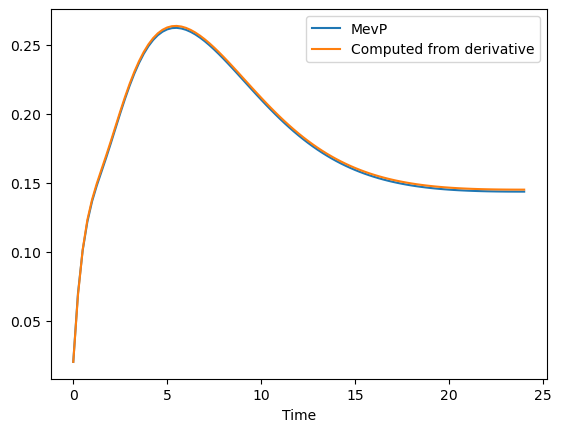

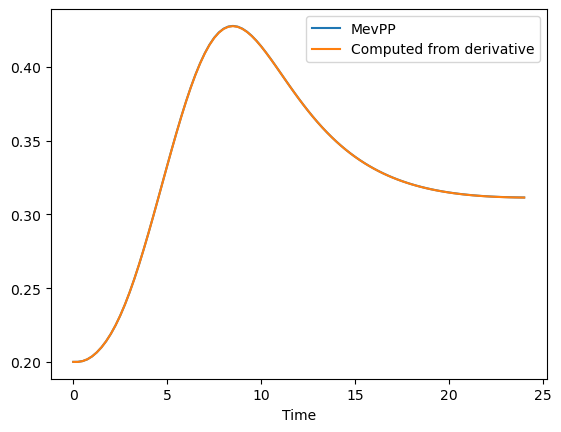

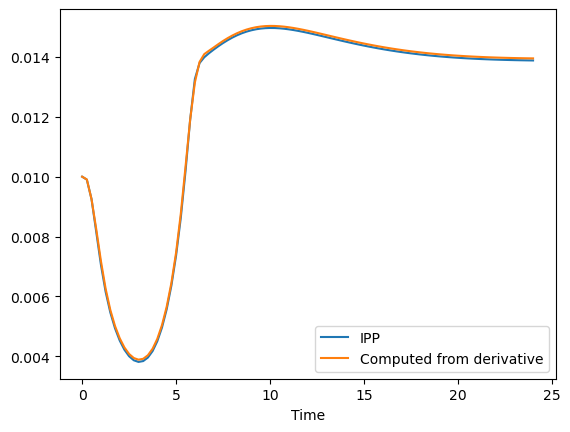

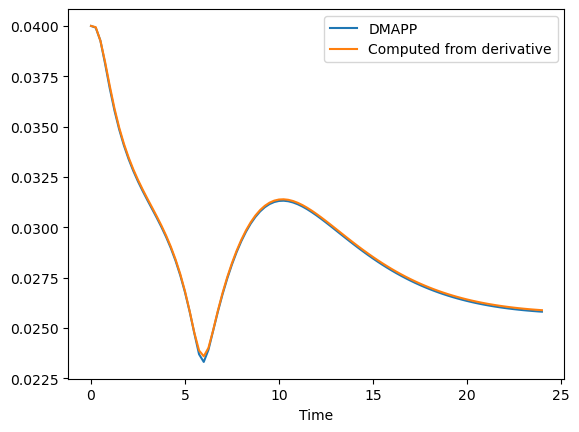

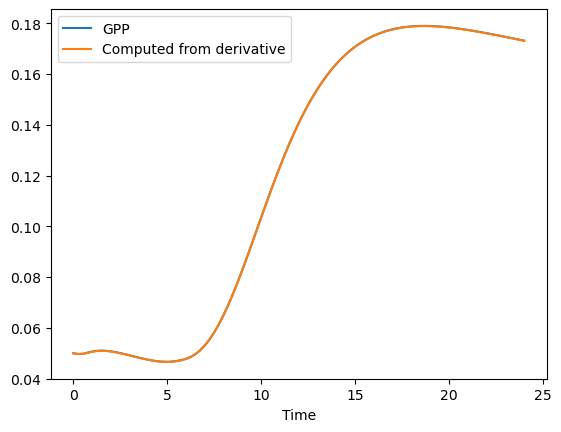

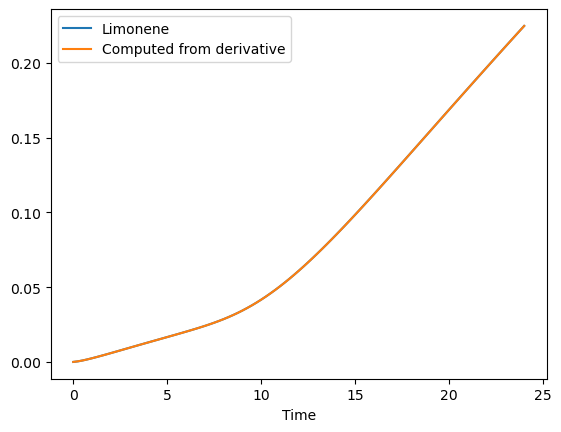

'Time profile from derivative vs. actual profile for Strain 2'

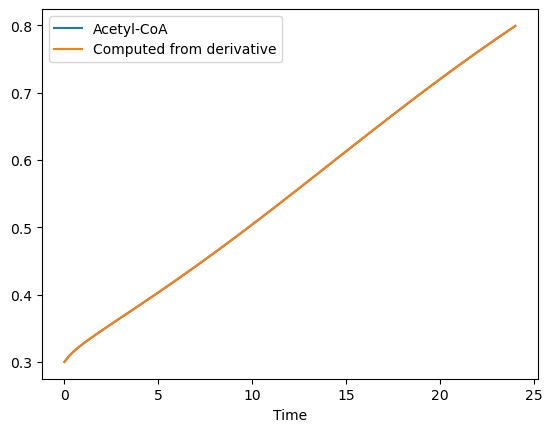

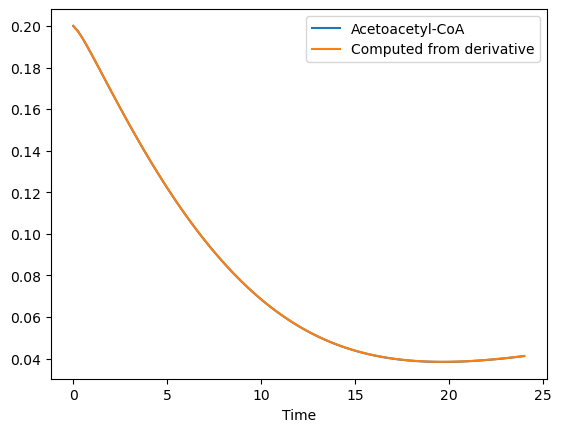

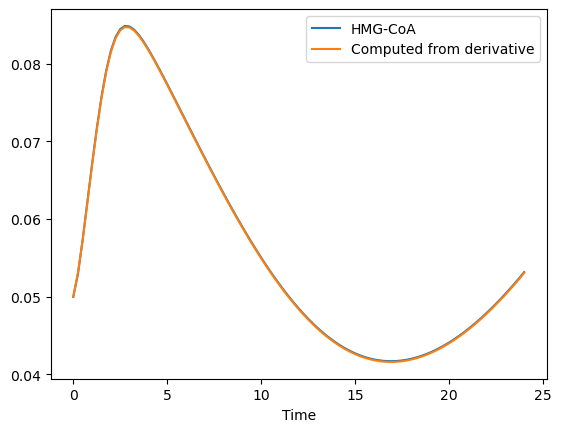

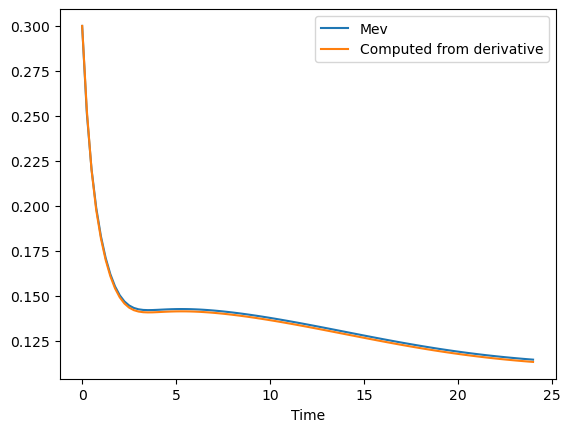

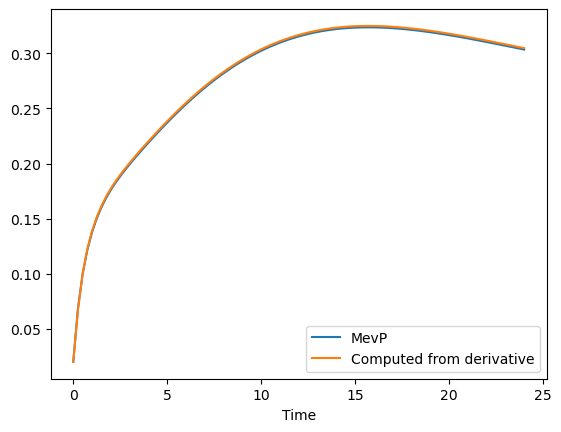

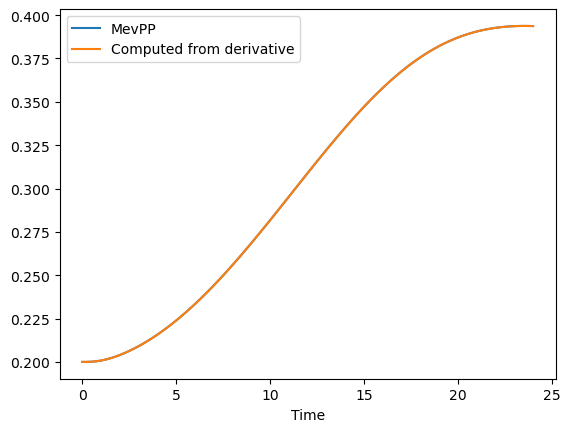

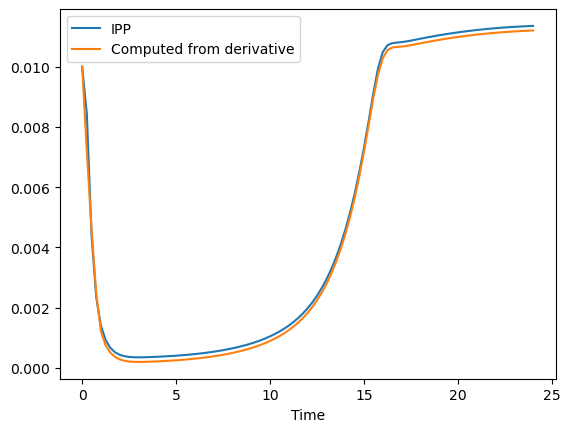

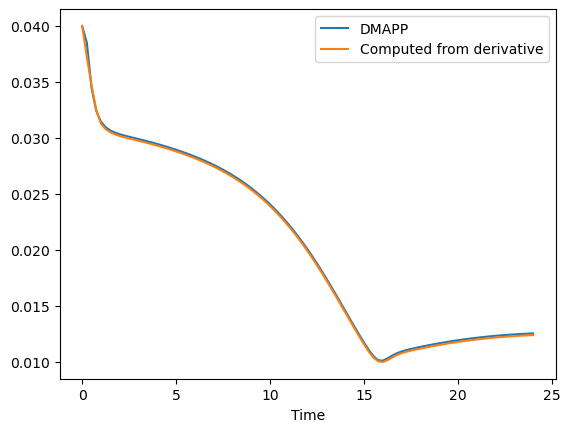

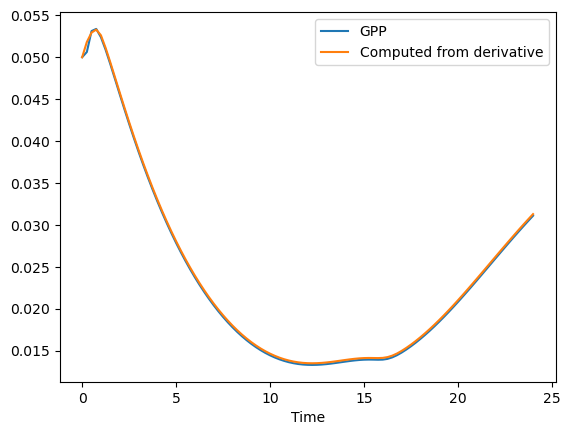

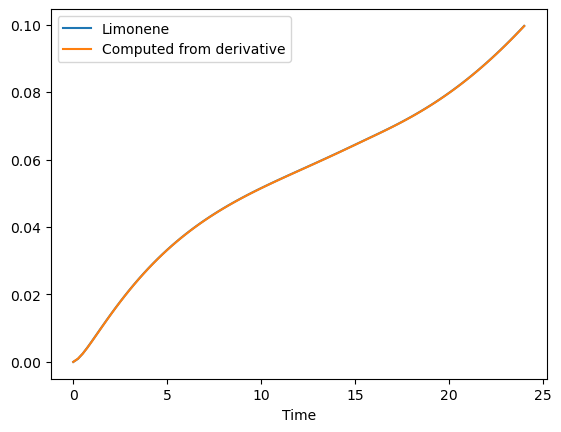

'Time profile from derivative vs. actual profile for Strain 3'

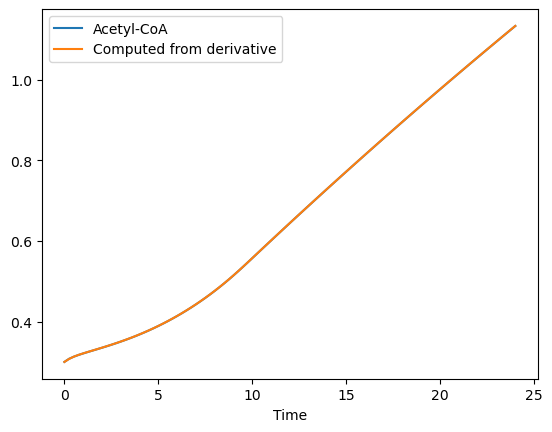

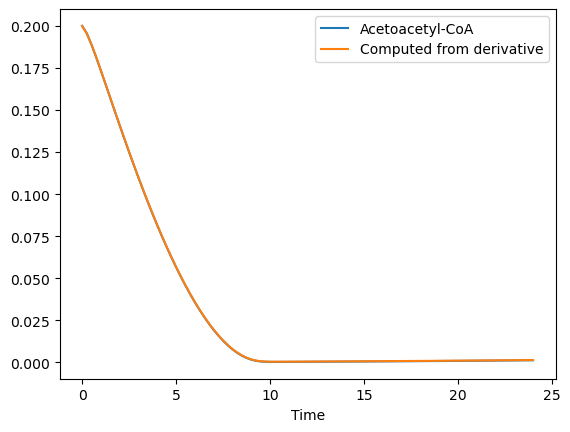

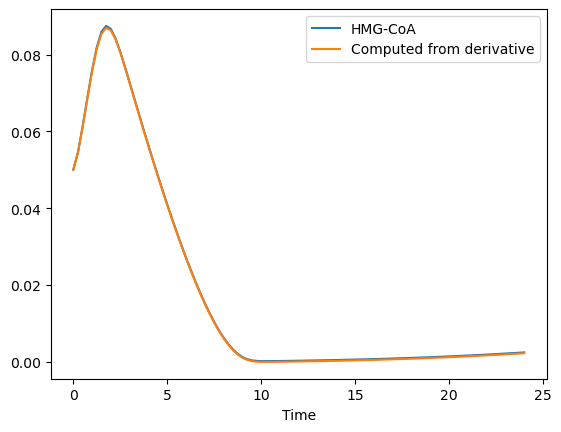

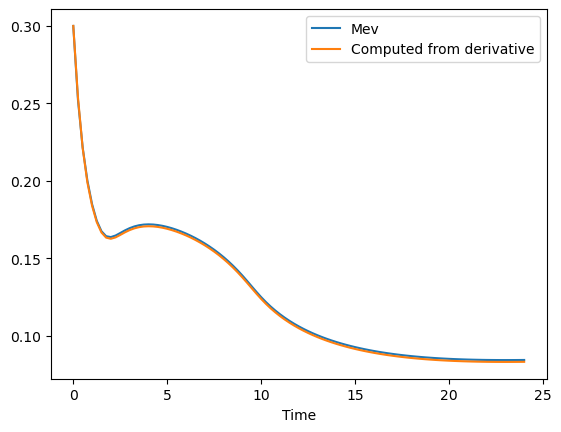

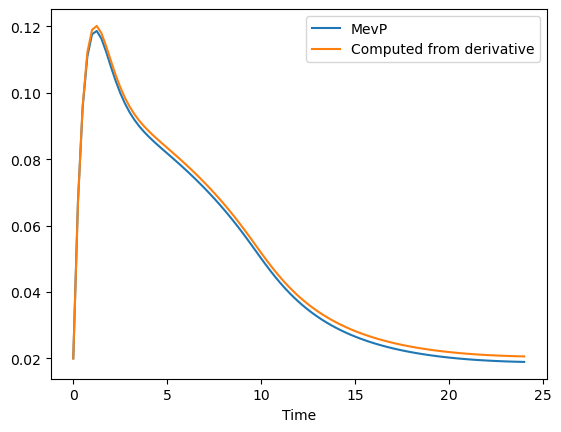

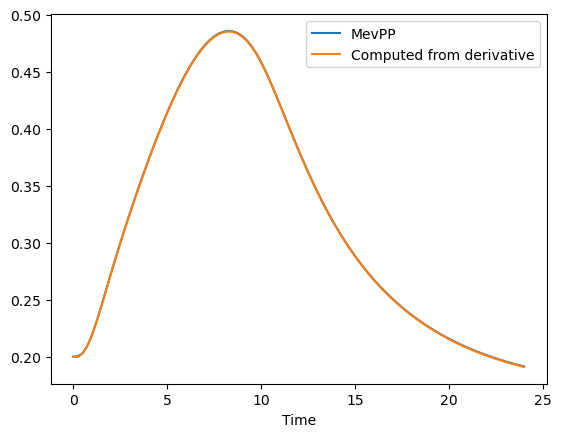

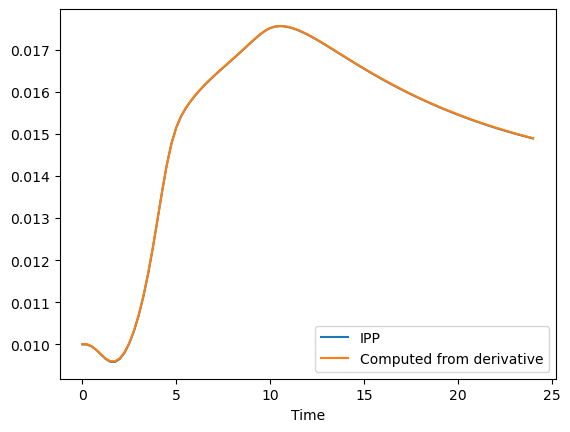

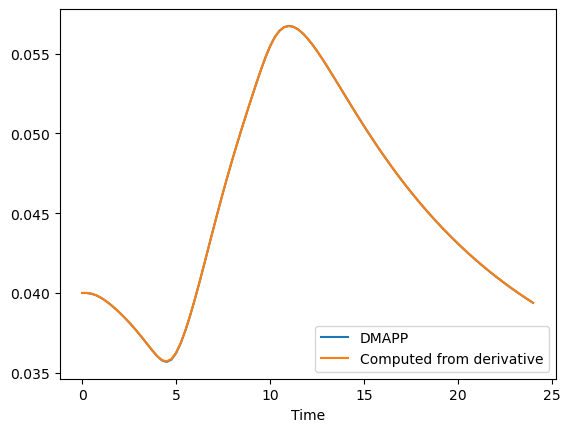

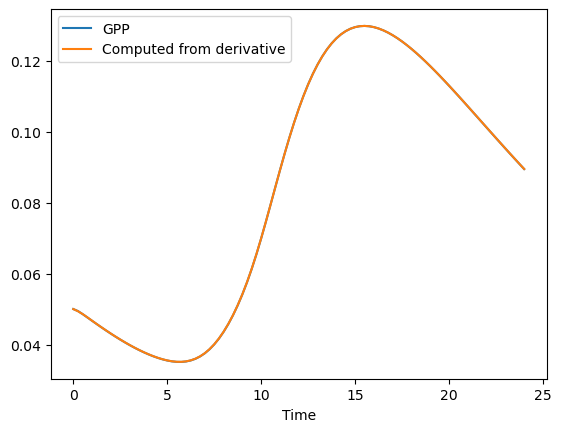

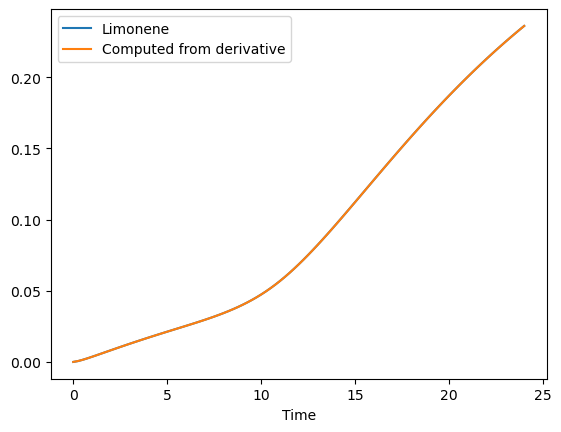

'Time profile from derivative vs. actual profile for WT'

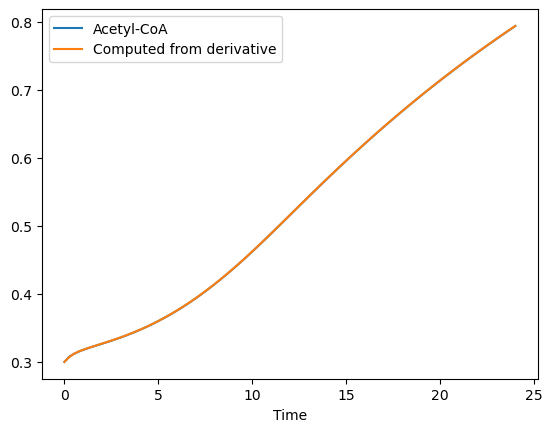

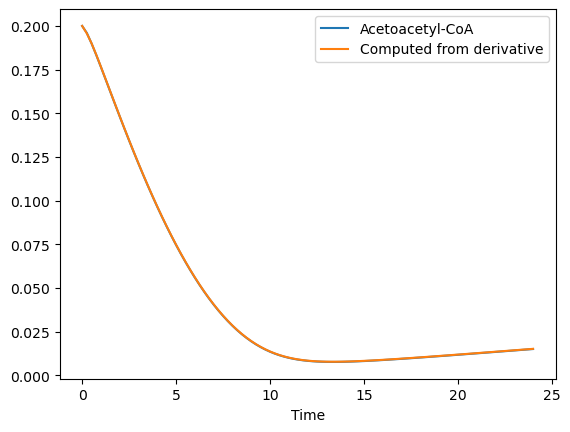

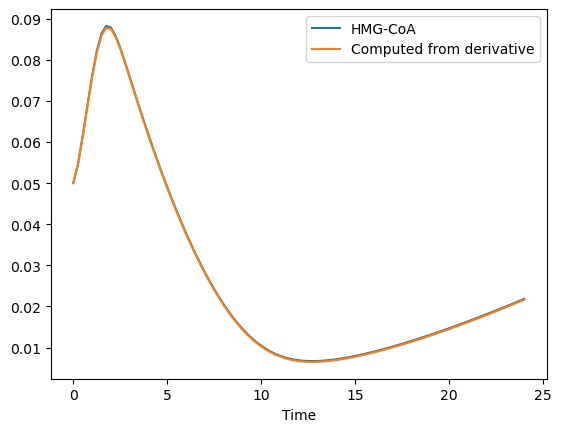

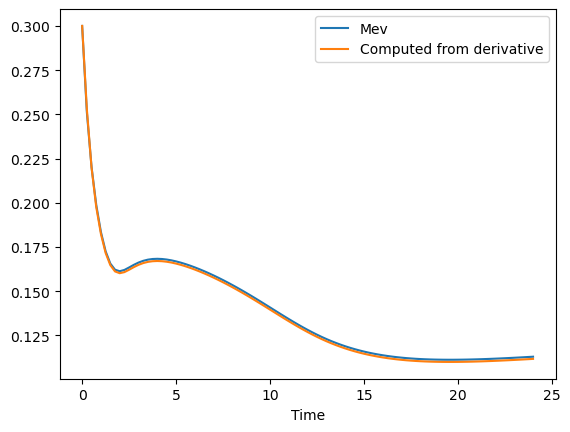

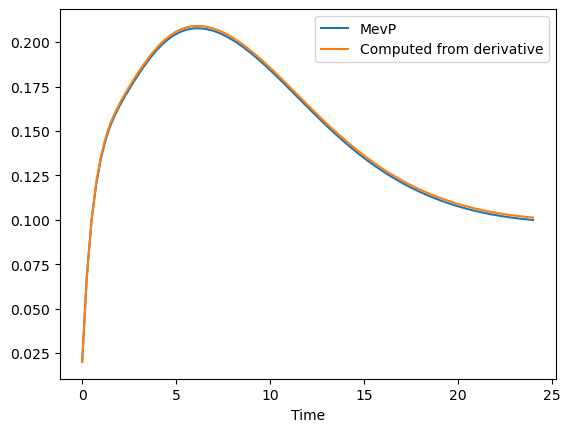

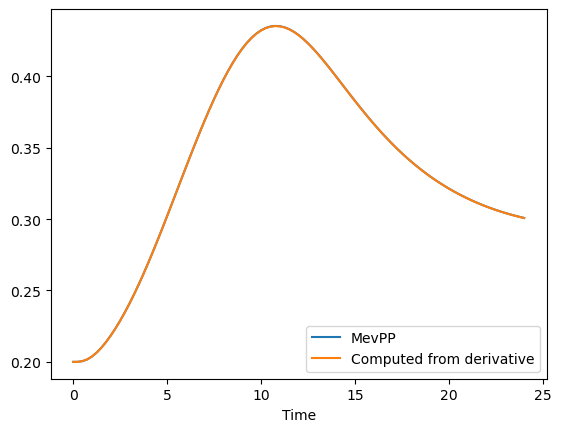

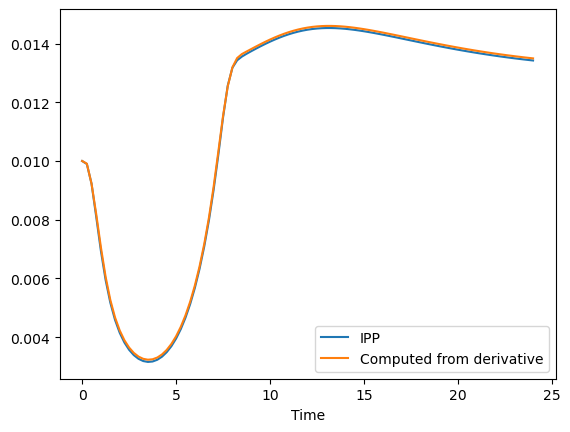

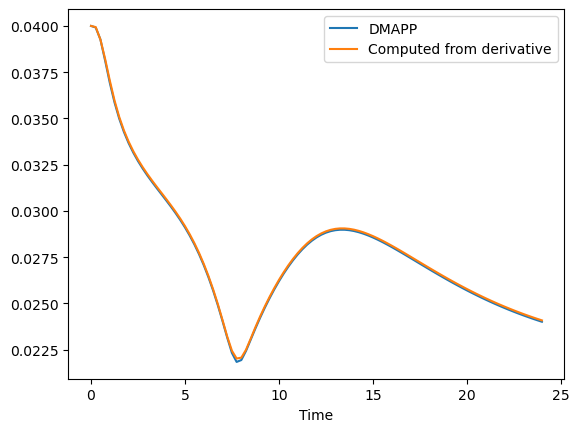

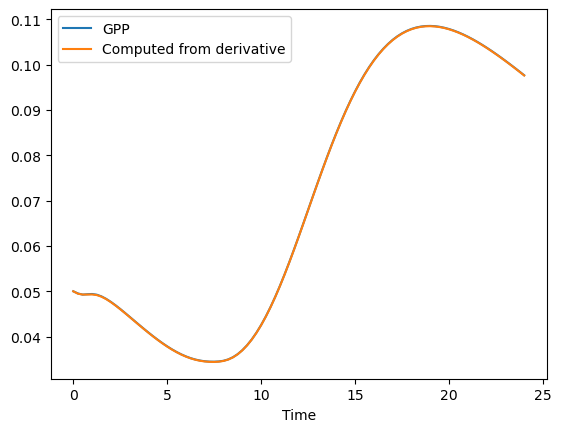

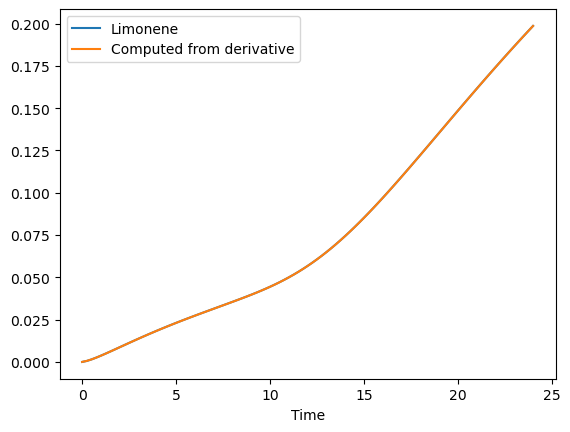

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.25   4.568047e+06  2.339239e+06  2.165020e+05  1.413483e+06   
         0.50   5.471875e+06  3.482933e+06  3.394490e+05  2.217158e+06   
         0.75   5.858245e+06  4.161080e+06  4.187155e+05  2.735644e+06   
         1.00   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.25  2.729560e+06  2.686069e+06  1.768628e+06  2.010384e+06   
         23.50  2.729713e+06  2.686645e+06  1.769146e+06  2.010974e+06   
         23.75  2.729863e+06  2.687209e+06  1.769653e+06  2.011551e+06   
         24.00  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.25   4.735188e+05  2.301051e+06  2.600509e+06  4.287990e+05   
         0.50   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         0.75   8.792538e+05  4.770619e+06  3.569278e+06  7.657046e+05   
         1.00   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.25  1.502026e+06  3.992254e+06  4.354150e+06  1.235378e+06   
         23.50  1.502403e+06  3.993784e+06  4.354490e+06  1.235647e+06   
         23.75  1.502773e+06  3.995283e+06  4.354822e+06  1.235910e+06   
         24.00  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.034108e+01   0.300000        0.200000  0.050000   
         0.25       1.837058e+05   0.303073        0.195043  0.057155   
         0.50       2.866143e+05   0.299893        0.188541  0.068037   
         0.75       3.524272e+05   0.294538        0.181467  0.079599   
         1.00       3.981392e+05   0.288190        0.174077  0.089557   
...                          ...        ...             ...       ...   
WT       23.00      1.468009e+06   0.775039        0.014167  0.019944   
         23.25      1.468435e+06   0.779833        0.014374  0.020413   
         23.50      1.468851e+06   0.784584        0.014581  0.020886   
         23.75      1.469260e+06   0.789290        0.014788  0.021363   
         24.00      1.469659e+06   0.793953        0.014996  0.021843   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.25   0.250311  0.069661  0.200059  0.009901  0.039914  0.049716   
         0.50   0.218933  0.100735  0.200543  0.009250  0.039268  0.049773   
         0.75   0.197732  0.121566  0.201742  0.008158  0.038120  0.050221   
         1.00   0.183997  0.136357  0.203716  0.007056  0.036890  0.050678   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.112389  0.101024  0.304296  0.013499  0.024360  0.100867   
         23.25  0.112530  0.100700  0.303339  0.013479  0.024268  0.100090   
         23.50  0.112676  0.100406  0.302440  0.013460  0.024180 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.018594       -0.018182  0.018805 -0.220877  0.228172   
         0.25    -0.001101       -0.023119  0.037819 -0.160423  0.158607   
         0.50    -0.015600       -0.026822  0.046418 -0.109091  0.105123   
         0.75    -0.024903       -0.029292  0.044600 -0.066881  0.067719   
         1.00    -0.026775       -0.030023  0.030284 -0.037420  0.050530   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.019269        0.000828  0.001867  0.000553 -0.001353   
         23.25    0.019090        0.000828  0.001883  0.000573 -0.001236   
         23.50    0.018914        0.000829  0.001899  0.000591 -0.001124   
         23.75    0.018739        0.000829  0.001915  0.000606 -0.001016   
         24.00    0.018565        0.000829  0.001931  0.000620 -0.000913   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.001239  0.001000  0.001198 -0.002373  0.001240  
         0.25   0.001046 -0.001742 -0.001698 -0.000249  0.001999  
         0.50   0.003542 -0.003549 -0.003689  0.001138  0.002590  
         0.75   0.006251 -0.004420 -0.004777  0.001790  0.003013  
         1.00   0.009342 -0.004136 -0.004793  0.001594  0.003202  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003953 -0.000080 -0.000374 -0.003075  0.012221  
         23.25 -0.003710 -0.000078 -0.000361 -0.003144  0.012129  
         23.50 -0.003476 -0.000075 -0.000349 -0.003203  0.012034  
         23.75 -0.003251 -0.000072 -0.000337 -0.003253  0.011938  
         24.00 -0.003035 -0.000069 -0.000325 -0.003293  0.011840  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
         super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
       
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'SRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=1,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: SRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | 4.601109E+188 | 7.482622E+113
     2 |       74 | 7.769001E+129 |  2.932883E+84
     3 |      138 |  4.605011E+97 |  8.755275E+81
     4 |      202 |  2.499906E+85 |  1.238700E+71
     5 |      266 |  9.644869E+75 |  1.632376E+55
     6 |      330 |  7.047814E+70 |  2.747066E+53
     7 |      394 |  4.931640E+57 |  2.773400E+47
     8 |      458 |  2.811082E+52 |  8.687434E+31
     9 |      522 |  1.599392E+52 |  8.687434E+31
    10 |      586 |  1.181457E+47 |  8.687434E+31
    11 |      650 |  3.542799E+43 |  6.940494E+30
    12 |      714 |  1.578996E+39 |  3.169085E+26
    13 |      778 |  5.747025E+33 |  3.169085E+26
    14 |      842 |  1.430793E+35 |  6.654244E+21
    15 |      906 |  2.353472E+31 |  6.654244E+21
    16 |      970 |  2.862658E+31 |  6.654244E+21
    17 |     1034 |  5.058011E+29 |  3.714249E+16
    18 |     1098 |  4.610352E+27 |  3.714249E+16
    19 |     1162 |  1.511

   162 |    10314 |  2.286341E+01 |  2.045890E+01
   163 |    10378 |  2.337223E+01 |  2.045890E+01
   164 |    10442 |  2.467115E+01 |  2.045890E+01
   165 |    10506 |  2.312063E+01 |  2.002204E+01
   166 |    10570 |  2.434618E+01 |  2.002204E+01
   167 |    10634 |  2.406885E+01 |  2.002204E+01
   168 |    10698 |  2.637933E+01 |  2.002204E+01
   169 |    10762 |  2.789901E+01 |  2.002204E+01
   170 |    10826 |  2.545181E+01 |  2.002204E+01
   171 |    10890 |  2.276173E+01 |  2.002204E+01
   172 |    10954 |  2.253609E+01 |  2.002204E+01
   173 |    11018 |  2.313659E+01 |  2.002204E+01
   174 |    11082 |  2.480360E+01 |  2.002204E+01
   175 |    11146 |  2.336960E+01 |  2.002204E+01
   176 |    11210 |  2.274855E+01 |  2.002204E+01
   177 |    11274 |  2.241879E+01 |  2.002204E+01
   178 |    11338 |  2.475288E+01 |  2.002204E+01
   179 |    11402 |  2.454070E+01 |  2.002204E+01
   180 |    11466 |  2.312368E+01 |  2.002204E+01
   181 |    11530 |  2.350243E+01 |  2.002204E+01


   326 |    20810 |  1.543304E+01 |  1.489782E+01
   327 |    20874 |  1.559502E+01 |  1.489782E+01
   328 |    20938 |  1.551933E+01 |  1.489782E+01
   329 |    21002 |  1.569758E+01 |  1.489782E+01
   330 |    21066 |  1.553307E+01 |  1.489782E+01
   331 |    21130 |  1.556744E+01 |  1.470542E+01
   332 |    21194 |  1.553766E+01 |  1.470542E+01
   333 |    21258 |  1.543899E+01 |  1.470542E+01
   334 |    21322 |  1.545533E+01 |  1.470542E+01
   335 |    21386 |  1.539516E+01 |  1.470542E+01
   336 |    21450 |  1.527667E+01 |  1.470542E+01
   337 |    21514 |  1.518907E+01 |  1.470542E+01
   338 |    21578 |  1.525932E+01 |  1.470542E+01
   339 |    21642 |  1.536130E+01 |  1.470542E+01
   340 |    21706 |  1.545046E+01 |  1.470542E+01
   341 |    21770 |  1.537942E+01 |  1.470542E+01
   342 |    21834 |  1.534126E+01 |  1.470542E+01
   343 |    21898 |  1.546491E+01 |  1.470542E+01
   344 |    21962 |  1.555498E+01 |  1.470542E+01
   345 |    22026 |  1.550577E+01 |  1.470542E+01


   490 |    31306 |  1.259964E+01 |  1.243060E+01
   491 |    31370 |  1.264093E+01 |  1.243060E+01
   492 |    31434 |  1.252800E+01 |  1.240112E+01
   493 |    31498 |  1.256825E+01 |  1.240112E+01
   494 |    31562 |  1.255565E+01 |  1.240112E+01
   495 |    31626 |  1.255346E+01 |  1.240112E+01
   496 |    31690 |  1.250737E+01 |  1.231656E+01
   497 |    31754 |  1.236075E+01 |  1.223874E+01
   498 |    31818 |  1.245196E+01 |  1.223874E+01
   499 |    31882 |  1.244528E+01 |  1.223874E+01
   500 |    31946 |  1.250915E+01 |  1.223874E+01
   501 |    32010 |  1.254994E+01 |  1.223874E+01
   502 |    32074 |  1.258035E+01 |  1.223874E+01
   503 |    32138 |  1.253223E+01 |  1.223874E+01
   504 |    32202 |  1.251887E+01 |  1.204651E+01
   505 |    32266 |  1.251456E+01 |  1.204651E+01
   506 |    32330 |  1.239096E+01 |  1.204651E+01
   507 |    32394 |  1.246065E+01 |  1.204651E+01
   508 |    32458 |  1.245021E+01 |  1.204651E+01
   509 |    32522 |  1.240501E+01 |  1.204651E+01


   654 |    41802 |  1.147319E+01 |  1.146771E+01
   655 |    41866 |  1.146893E+01 |  1.146517E+01
   656 |    41930 |  1.146817E+01 |  1.146378E+01
   657 |    41994 |  1.146783E+01 |  1.146083E+01
   658 |    42058 |  1.146756E+01 |  1.146083E+01
   659 |    42122 |  1.146532E+01 |  1.146083E+01
   660 |    42186 |  1.146355E+01 |  1.146083E+01
   661 |    42250 |  1.146185E+01 |  1.146029E+01
   662 |    42314 |  1.146009E+01 |  1.145694E+01
   663 |    42378 |  1.145852E+01 |  1.145621E+01
   664 |    42442 |  1.145706E+01 |  1.145241E+01
   665 |    42506 |  1.145655E+01 |  1.145241E+01
   666 |    42570 |  1.145532E+01 |  1.145233E+01
   667 |    42634 |  1.145493E+01 |  1.145233E+01
   668 |    42698 |  1.145419E+01 |  1.145233E+01
   669 |    42762 |  1.145213E+01 |  1.144960E+01
   670 |    42826 |  1.145067E+01 |  1.144796E+01
   671 |    42890 |  1.144930E+01 |  1.144786E+01
   672 |    42954 |  1.144893E+01 |  1.144613E+01
   673 |    43018 |  1.144659E+01 |  1.144340E+01


   818 |    52298 |  1.112123E+01 |  1.111069E+01
   819 |    52362 |  1.111559E+01 |  1.109939E+01
   820 |    52426 |  1.110305E+01 |  1.109440E+01
   821 |    52490 |  1.109844E+01 |  1.108815E+01
   822 |    52554 |  1.109500E+01 |  1.108815E+01
   823 |    52618 |  1.109072E+01 |  1.108395E+01
   824 |    52682 |  1.108715E+01 |  1.107794E+01
   825 |    52746 |  1.108392E+01 |  1.107393E+01
   826 |    52810 |  1.108220E+01 |  1.107393E+01
   827 |    52874 |  1.107876E+01 |  1.107393E+01
   828 |    52938 |  1.107987E+01 |  1.107393E+01
   829 |    53002 |  1.107655E+01 |  1.107252E+01
   830 |    53066 |  1.107456E+01 |  1.107040E+01
   831 |    53130 |  1.107154E+01 |  1.106763E+01
   832 |    53194 |  1.107029E+01 |  1.106617E+01
   833 |    53258 |  1.106732E+01 |  1.105782E+01
   834 |    53322 |  1.106678E+01 |  1.105721E+01
   835 |    53386 |  1.106141E+01 |  1.105498E+01
   836 |    53450 |  1.105916E+01 |  1.105488E+01
   837 |    53514 |  1.105782E+01 |  1.104952E+01


   982 |    62794 |  1.085601E+01 |  1.084904E+01
   983 |    62858 |  1.085568E+01 |  1.084904E+01
   984 |    62922 |  1.085577E+01 |  1.084849E+01
   985 |    62986 |  1.085305E+01 |  1.084840E+01
   986 |    63050 |  1.085123E+01 |  1.084840E+01
   987 |    63114 |  1.085049E+01 |  1.084609E+01
   988 |    63178 |  1.085191E+01 |  1.084609E+01
   989 |    63242 |  1.085109E+01 |  1.084609E+01
   990 |    63306 |  1.085230E+01 |  1.084609E+01
   991 |    63370 |  1.084845E+01 |  1.084095E+01
   992 |    63434 |  1.084992E+01 |  1.084095E+01
   993 |    63498 |  1.084938E+01 |  1.084095E+01
   994 |    63562 |  1.084881E+01 |  1.084095E+01
   995 |    63626 |  1.084523E+01 |  1.084095E+01
   996 |    63690 |  1.084338E+01 |  1.083869E+01
   997 |    63754 |  1.084368E+01 |  1.083869E+01
   998 |    63818 |  1.084168E+01 |  1.083672E+01
   999 |    63882 |  1.083971E+01 |  1.083570E+01
  1000 |    63946 |  1.083763E+01 |  1.083570E+01
  1001 |    64010 |  1.083808E+01 |  1.083455E+01


  1146 |    73290 |  1.077119E+01 |  1.077104E+01
  1147 |    73354 |  1.077114E+01 |  1.077060E+01
  1148 |    73418 |  1.077077E+01 |  1.077036E+01
  1149 |    73482 |  1.077035E+01 |  1.076922E+01
  1150 |    73546 |  1.076990E+01 |  1.076921E+01
  1151 |    73610 |  1.076953E+01 |  1.076864E+01
  1152 |    73674 |  1.076899E+01 |  1.076811E+01
  1153 |    73738 |  1.076864E+01 |  1.076811E+01
  1154 |    73802 |  1.076828E+01 |  1.076794E+01
  1155 |    73866 |  1.076735E+01 |  1.076641E+01
  1156 |    73930 |  1.076647E+01 |  1.076592E+01
  1157 |    73994 |  1.076607E+01 |  1.076536E+01
  1158 |    74058 |  1.076579E+01 |  1.076523E+01
  1159 |    74122 |  1.076565E+01 |  1.076523E+01
  1160 |    74186 |  1.076549E+01 |  1.076510E+01
  1161 |    74250 |  1.076514E+01 |  1.076453E+01
  1162 |    74314 |  1.076451E+01 |  1.076399E+01
  1163 |    74378 |  1.076411E+01 |  1.076371E+01
  1164 |    74442 |  1.076357E+01 |  1.076275E+01
  1165 |    74506 |  1.076303E+01 |  1.076205E+01


  1310 |    83786 |  1.023740E+01 |  1.023094E+01
  1311 |    83850 |  1.023425E+01 |  1.022819E+01
  1312 |    83914 |  1.022868E+01 |  1.022437E+01
  1313 |    83978 |  1.022239E+01 |  1.021770E+01
  1314 |    84042 |  1.021781E+01 |  1.021324E+01
  1315 |    84106 |  1.021416E+01 |  1.020691E+01
  1316 |    84170 |  1.021166E+01 |  1.020691E+01
  1317 |    84234 |  1.020719E+01 |  1.020115E+01
  1318 |    84298 |  1.020657E+01 |  1.020091E+01
  1319 |    84362 |  1.020311E+01 |  1.019864E+01
  1320 |    84426 |  1.020062E+01 |  1.019582E+01
  1321 |    84490 |  1.019845E+01 |  1.019270E+01
  1322 |    84554 |  1.019417E+01 |  1.018488E+01
  1323 |    84618 |  1.018915E+01 |  1.017532E+01
  1324 |    84682 |  1.017993E+01 |  1.016443E+01
  1325 |    84746 |  1.017161E+01 |  1.015982E+01
  1326 |    84810 |  1.016476E+01 |  1.015864E+01
  1327 |    84874 |  1.016269E+01 |  1.015781E+01
  1328 |    84938 |  1.015949E+01 |  1.014451E+01
  1329 |    85002 |  1.015157E+01 |  1.014285E+01


  1474 |    94282 |  9.7422595688 |  9.7391079625
  1475 |    94346 |  9.7414945271 |  9.7364760571
  1476 |    94410 |  9.7384038372 |  9.7343124301
  1477 |    94474 |  9.7380942663 |  9.7334474934
  1478 |    94538 |  9.7347737922 |  9.7301665425
  1479 |    94602 |  9.7318514604 |  9.7230768188
  1480 |    94666 |  9.7252310747 |  9.7179867409
  1481 |    94730 |  9.7230434129 |  9.7172925197
  1482 |    94794 |  9.7233617873 |  9.7172925197
  1483 |    94858 |  9.7241059315 |  9.7172925197
  1484 |    94922 |  9.7210275140 |  9.7158447439
  1485 |    94986 |  9.7176922955 |  9.7106662677
  1486 |    95050 |  9.7174659561 |  9.7103793851
  1487 |    95114 |  9.7168682210 |  9.7103793851
  1488 |    95178 |  9.7162792304 |  9.7103793851
  1489 |    95242 |  9.7123172719 |  9.7097283054
  1490 |    95306 |  9.7113627439 |  9.7038108375
  1491 |    95370 |  9.7077552783 |  9.7004052243
  1492 |    95434 |  9.7038242252 |  9.6933788732
  1493 |    95498 |  9.6979092878 |  9.6910841239


  1638 |   104778 |  9.3940822399 |  9.3908889529
  1639 |   104842 |  9.3904775001 |  9.3837578718
  1640 |   104906 |  9.3876159989 |  9.3837578718
  1641 |   104970 |  9.3871485204 |  9.3835238842
  1642 |   105034 |  9.3874264972 |  9.3835238842
  1643 |   105098 |  9.3852415198 |  9.3804641198
  1644 |   105162 |  9.3829226717 |  9.3804641198
  1645 |   105226 |  9.3808381584 |  9.3786658632
  1646 |   105290 |  9.3800359797 |  9.3739162484
  1647 |   105354 |  9.3775404458 |  9.3739162484
  1648 |   105418 |  9.3763824359 |  9.3703719048
  1649 |   105482 |  9.3720813915 |  9.3687457472
  1650 |   105546 |  9.3724173119 |  9.3669426111
  1651 |   105610 |  9.3692400090 |  9.3659370739
  1652 |   105674 |  9.3682297846 |  9.3621897257
  1653 |   105738 |  9.3668805572 |  9.3594989904
  1654 |   105802 |  9.3637176819 |  9.3592368050
  1655 |   105866 |  9.3632872099 |  9.3592368050
  1656 |   105930 |  9.3620474765 |  9.3561404735
  1657 |   105994 |  9.3597112278 |  9.3557890308


  1802 |   115274 |  9.1699679212 |  9.1670987344
  1803 |   115338 |  9.1671883586 |  9.1617766641
  1804 |   115402 |  9.1654290781 |  9.1617766641
  1805 |   115466 |  9.1648363340 |  9.1615451393
  1806 |   115530 |  9.1636463763 |  9.1608839966
  1807 |   115594 |  9.1619552540 |  9.1594132003
  1808 |   115658 |  9.1612311863 |  9.1590108618
  1809 |   115722 |  9.1582945544 |  9.1560929429
  1810 |   115786 |  9.1569200363 |  9.1540573095
  1811 |   115850 |  9.1555602609 |  9.1511412395
  1812 |   115914 |  9.1540992444 |  9.1504912224
  1813 |   115978 |  9.1523207162 |  9.1455420131
  1814 |   116042 |  9.1469814298 |  9.1441338734
  1815 |   116106 |  9.1468732287 |  9.1441338734
  1816 |   116170 |  9.1460758754 |  9.1440208990
  1817 |   116234 |  9.1437637327 |  9.1352696784
  1818 |   116298 |  9.1408362278 |  9.1352696784
  1819 |   116362 |  9.1383027006 |  9.1341144165
  1820 |   116426 |  9.1367076469 |  9.1341144165
  1821 |   116490 |  9.1350062952 |  9.1336925269


  1966 |   125770 |  8.8662366282 |  8.8613562463
  1967 |   125834 |  8.8644641151 |  8.8605581218
  1968 |   125898 |  8.8626960913 |  8.8605581218
  1969 |   125962 |  8.8623950847 |  8.8590698282
  1970 |   126026 |  8.8602900542 |  8.8520230753
  1971 |   126090 |  8.8549943951 |  8.8505869980
  1972 |   126154 |  8.8504365781 |  8.8481402488
  1973 |   126218 |  8.8478448509 |  8.8401111345
  1974 |   126282 |  8.8450854740 |  8.8401111345
  1975 |   126346 |  8.8425728951 |  8.8374830858
  1976 |   126410 |  8.8403313107 |  8.8367652504
  1977 |   126474 |  8.8391571763 |  8.8367652504
  1978 |   126538 |  8.8366096036 |  8.8323269001
  1979 |   126602 |  8.8348789075 |  8.8323269001
  1980 |   126666 |  8.8339252942 |  8.8279142544
  1981 |   126730 |  8.8312865948 |  8.8256232055
  1982 |   126794 |  8.8290913477 |  8.8248178314
  1983 |   126858 |  8.8250707807 |  8.8175547402
  1984 |   126922 |  8.8207834105 |  8.8158953662
  1985 |   126986 |  8.8184402542 |  8.8107990047


  2130 |   136266 |  8.0216829712 |  8.0112988963
  2131 |   136330 |  8.0175711146 |  8.0112988963
  2132 |   136394 |  8.0122042149 |  8.0053411411
  2133 |   136458 |  8.0085720003 |  8.0026280714
  2134 |   136522 |  8.0081032801 |  8.0016203094
  2135 |   136586 |  8.0046053713 |  7.9999407037
  2136 |   136650 |  8.0055038065 |  7.9999407037
  2137 |   136714 |  8.0025272527 |  7.9925775036
  2138 |   136778 |  8.0008700004 |  7.9925775036
  2139 |   136842 |  7.9985563104 |  7.9887333440
  2140 |   136906 |  7.9936416858 |  7.9849186625
  2141 |   136970 |  7.9908212550 |  7.9822769923
  2142 |   137034 |  7.9827674720 |  7.9762024586
  2143 |   137098 |  7.9788082887 |  7.9715365864
  2144 |   137162 |  7.9785960544 |  7.9715365864
  2145 |   137226 |  7.9772433071 |  7.9712559503
  2146 |   137290 |  7.9762783107 |  7.9697579025
  2147 |   137354 |  7.9778505935 |  7.9697579025
  2148 |   137418 |  7.9754601395 |  7.9697579025
  2149 |   137482 |  7.9761724754 |  7.9679442093


  2294 |   146762 |  7.5653377016 |  7.5596710305
  2295 |   146826 |  7.5641228823 |  7.5596710305
  2296 |   146890 |  7.5614707751 |  7.5550829626
  2297 |   146954 |  7.5592026508 |  7.5510872552
  2298 |   147018 |  7.5570139182 |  7.5510872552
  2299 |   147082 |  7.5541678939 |  7.5490951962
  2300 |   147146 |  7.5499524328 |  7.5436623097
  2301 |   147210 |  7.5455840955 |  7.5385927235
  2302 |   147274 |  7.5449239767 |  7.5373469284
  2303 |   147338 |  7.5409395363 |  7.5343918620
  2304 |   147402 |  7.5400610188 |  7.5303994285
  2305 |   147466 |  7.5364045574 |  7.5246014141
  2306 |   147530 |  7.5318921760 |  7.5246014141
  2307 |   147594 |  7.5266570250 |  7.5174413776
  2308 |   147658 |  7.5204141318 |  7.5173385557
  2309 |   147722 |  7.5182961158 |  7.5137501076
  2310 |   147786 |  7.5150594098 |  7.5087559400
  2311 |   147850 |  7.5113975210 |  7.5056816920
  2312 |   147914 |  7.5078452742 |  7.5023525842
  2313 |   147978 |  7.5071005456 |  7.5023525842


  2458 |   157258 |  6.3676600436 |  6.3446021508
  2459 |   157322 |  6.3550214095 |  6.3422149574
  2460 |   157386 |  6.3434644116 |  6.3298785982
  2461 |   157450 |  6.3340568976 |  6.3234775464
  2462 |   157514 |  6.3227750197 |  6.3043727122
  2463 |   157578 |  6.3087490080 |  6.2936832271
  2464 |   157642 |  6.3037104678 |  6.2838878355
  2465 |   157706 |  6.2960270029 |  6.2838878355
  2466 |   157770 |  6.2875158764 |  6.2742009800
  2467 |   157834 |  6.2800198688 |  6.2586369344
  2468 |   157898 |  6.2683879871 |  6.2585725143
  2469 |   157962 |  6.2582668632 |  6.2514064521
  2470 |   158026 |  6.2519499248 |  6.2411904005
  2471 |   158090 |  6.2466361562 |  6.2324198343
  2472 |   158154 |  6.2413088552 |  6.2220875524
  2473 |   158218 |  6.2349485686 |  6.2220875524
  2474 |   158282 |  6.2279432696 |  6.2220875524
  2475 |   158346 |  6.2264180260 |  6.2174877139
  2476 |   158410 |  6.2243422654 |  6.2174877139
  2477 |   158474 |  6.2205576731 |  6.2154525384


  2622 |   167754 |  5.7999178563 |  5.7959322680
  2623 |   167818 |  5.7985903318 |  5.7939534611
  2624 |   167882 |  5.7971172931 |  5.7939534611
  2625 |   167946 |  5.7949956134 |  5.7934885403
  2626 |   168010 |  5.7953911075 |  5.7929626580
  2627 |   168074 |  5.7951125616 |  5.7921163749
  2628 |   168138 |  5.7918820727 |  5.7894123650
  2629 |   168202 |  5.7910421713 |  5.7890326722
  2630 |   168266 |  5.7915796072 |  5.7890326722
  2631 |   168330 |  5.7913808388 |  5.7890326722
  2632 |   168394 |  5.7908917472 |  5.7888811461
  2633 |   168458 |  5.7897967704 |  5.7878091885
  2634 |   168522 |  5.7890148343 |  5.7873933135
  2635 |   168586 |  5.7873589630 |  5.7829825044
  2636 |   168650 |  5.7856669604 |  5.7829825044
  2637 |   168714 |  5.7831283185 |  5.7811530002
  2638 |   168778 |  5.7824040161 |  5.7807031953
  2639 |   168842 |  5.7811240351 |  5.7794152373
  2640 |   168906 |  5.7792786306 |  5.7779476246
  2641 |   168970 |  5.7778826240 |  5.7758082488


  2786 |   178250 |  5.6168570352 |  5.6154394743
  2787 |   178314 |  5.6164720259 |  5.6154394743
  2788 |   178378 |  5.6161176517 |  5.6154394743
  2789 |   178442 |  5.6158354275 |  5.6150975651
  2790 |   178506 |  5.6155649596 |  5.6142969680
  2791 |   178570 |  5.6152750355 |  5.6142969680
  2792 |   178634 |  5.6153376947 |  5.6142410998
  2793 |   178698 |  5.6150906480 |  5.6140832743
  2794 |   178762 |  5.6150035040 |  5.6140832743
  2795 |   178826 |  5.6148976924 |  5.6140832743
  2796 |   178890 |  5.6147910750 |  5.6140832743
  2797 |   178954 |  5.6148176485 |  5.6140832743
  2798 |   179018 |  5.6143341778 |  5.6133415077
  2799 |   179082 |  5.6140618419 |  5.6133415077
  2800 |   179146 |  5.6139054542 |  5.6133415077
  2801 |   179210 |  5.6142360704 |  5.6133415077
  2802 |   179274 |  5.6142100294 |  5.6133415077
  2803 |   179338 |  5.6138724475 |  5.6133415077
  2804 |   179402 |  5.6140046869 |  5.6133415077
  2805 |   179466 |  5.6140925430 |  5.6133415077


  2950 |   188746 |  5.5774282547 |  5.5773122349
  2951 |   188810 |  5.5772409992 |  5.5768991413
  2952 |   188874 |  5.5769977513 |  5.5764593809
  2953 |   188938 |  5.5768991299 |  5.5764593809
  2954 |   189002 |  5.5767849267 |  5.5764593809
  2955 |   189066 |  5.5765528807 |  5.5763308002
  2956 |   189130 |  5.5764172924 |  5.5762178439
  2957 |   189194 |  5.5763143672 |  5.5761420289
  2958 |   189258 |  5.5761171238 |  5.5759067050
  2959 |   189322 |  5.5759302179 |  5.5757469923
  2960 |   189386 |  5.5757868957 |  5.5754795610
  2961 |   189450 |  5.5758571694 |  5.5754795610
  2962 |   189514 |  5.5756519428 |  5.5754233270
  2963 |   189578 |  5.5754066430 |  5.5749941163
  2964 |   189642 |  5.5752924336 |  5.5749149583
  2965 |   189706 |  5.5751537892 |  5.5748887956
  2966 |   189770 |  5.5750160403 |  5.5746259818
  2967 |   189834 |  5.5749071771 |  5.5746259818
  2968 |   189898 |  5.5749225052 |  5.5746259818
  2969 |   189962 |  5.5749593294 |  5.5745196394


  3114 |   199242 |  5.5346659318 |  5.5334961628
  3115 |   199306 |  5.5345426481 |  5.5331809167
  3116 |   199370 |  5.5340823775 |  5.5330854008
  3117 |   199434 |  5.5340670358 |  5.5324356684
  3118 |   199498 |  5.5336654660 |  5.5323052770
  3119 |   199562 |  5.5329914592 |  5.5322290780
  3120 |   199626 |  5.5326320770 |  5.5314202751
  3121 |   199690 |  5.5323343117 |  5.5314202751
  3122 |   199754 |  5.5323022980 |  5.5314202751
  3123 |   199818 |  5.5318850895 |  5.5313146017
  3124 |   199882 |  5.5313887895 |  5.5305343857
  3125 |   199946 |  5.5307146296 |  5.5297088758
  3126 |   200010 |  5.5301230809 |  5.5292123703
  3127 |   200074 |  5.5297245698 |  5.5283390777
  3128 |   200138 |  5.5290602956 |  5.5279871367
  3129 |   200202 |  5.5288600575 |  5.5278873166
  3130 |   200266 |  5.5282053476 |  5.5270955904
  3131 |   200330 |  5.5279858962 |  5.5270955904
  3132 |   200394 |  5.5276425878 |  5.5269942146
  3133 |   200458 |  5.5266148586 |  5.5251721925


  3278 |   209738 |  5.1192463376 |  5.1077772134
  3279 |   209802 |  5.1170963502 |  5.1077772134
  3280 |   209866 |  5.1156153940 |  5.1067198788
  3281 |   209930 |  5.1150546891 |  5.0989234715
  3282 |   209994 |  5.1029274248 |  5.0882585217
  3283 |   210058 |  5.0957911657 |  5.0880814200
  3284 |   210122 |  5.0903622197 |  5.0850076808
  3285 |   210186 |  5.0871185716 |  5.0825503689
  3286 |   210250 |  5.0856418439 |  5.0823207916
  3287 |   210314 |  5.0809531016 |  5.0715587575
  3288 |   210378 |  5.0775177413 |  5.0648130777
  3289 |   210442 |  5.0720933942 |  5.0648130777
  3290 |   210506 |  5.0691918321 |  5.0639739038
  3291 |   210570 |  5.0667439088 |  5.0623887541
  3292 |   210634 |  5.0632681946 |  5.0580854610
  3293 |   210698 |  5.0586670257 |  5.0484760864
  3294 |   210762 |  5.0557925149 |  5.0484760864
  3295 |   210826 |  5.0521691117 |  5.0452148608
  3296 |   210890 |  5.0484329115 |  5.0420820477
  3297 |   210954 |  5.0450446617 |  5.0386423493


  3442 |   220234 |  4.6057331052 |  4.6036252863
  3443 |   220298 |  4.6032676853 |  4.6003912828
  3444 |   220362 |  4.6017805259 |  4.6003659253
  3445 |   220426 |  4.5993574409 |  4.5975991577
  3446 |   220490 |  4.5978871387 |  4.5946091645
  3447 |   220554 |  4.5957534256 |  4.5940390059
  3448 |   220618 |  4.5934018306 |  4.5916673698
  3449 |   220682 |  4.5917307530 |  4.5883579995
  3450 |   220746 |  4.5901066549 |  4.5868872484
  3451 |   220810 |  4.5892278219 |  4.5868723406
  3452 |   220874 |  4.5873214468 |  4.5853957099
  3453 |   220938 |  4.5847525569 |  4.5810379634
  3454 |   221002 |  4.5811955933 |  4.5790628884
  3455 |   221066 |  4.5794426379 |  4.5767708340
  3456 |   221130 |  4.5772282077 |  4.5745097837
  3457 |   221194 |  4.5744440488 |  4.5694035793
  3458 |   221258 |  4.5727003647 |  4.5655195527
  3459 |   221322 |  4.5705445889 |  4.5655195527
  3460 |   221386 |  4.5697734069 |  4.5653593541
  3461 |   221450 |  4.5662736281 |  4.5615746489


  3606 |   230730 |  4.3822718227 |  4.3812691049
  3607 |   230794 |  4.3815215280 |  4.3804331021
  3608 |   230858 |  4.3805633220 |  4.3782241874
  3609 |   230922 |  4.3805438826 |  4.3769372806
  3610 |   230986 |  4.3795872401 |  4.3769372806
  3611 |   231050 |  4.3796414136 |  4.3769372806
  3612 |   231114 |  4.3780214587 |  4.3749172565
  3613 |   231178 |  4.3767726718 |  4.3749172565
  3614 |   231242 |  4.3762219791 |  4.3749172565
  3615 |   231306 |  4.3751924170 |  4.3710188500
  3616 |   231370 |  4.3728919230 |  4.3707260611
  3617 |   231434 |  4.3703681446 |  4.3684219715
  3618 |   231498 |  4.3701291636 |  4.3669515607
  3619 |   231562 |  4.3683033930 |  4.3654425160
  3620 |   231626 |  4.3689917015 |  4.3654425160
  3621 |   231690 |  4.3683085729 |  4.3654425160
  3622 |   231754 |  4.3680732850 |  4.3642596708
  3623 |   231818 |  4.3657064274 |  4.3623571162
  3624 |   231882 |  4.3637668598 |  4.3593568144
  3625 |   231946 |  4.3622548747 |  4.3593568144


  3770 |   241226 |  4.2474262793 |  4.2469559490
  3771 |   241290 |  4.2469578184 |  4.2461411471
  3772 |   241354 |  4.2468023395 |  4.2461411471
  3773 |   241418 |  4.2468229406 |  4.2459149998
  3774 |   241482 |  4.2461965840 |  4.2456003442
  3775 |   241546 |  4.2458657818 |  4.2448237227
  3776 |   241610 |  4.2454994888 |  4.2448237227
  3777 |   241674 |  4.2451744510 |  4.2447014959
  3778 |   241738 |  4.2447746221 |  4.2439303567
  3779 |   241802 |  4.2441366220 |  4.2433310928
  3780 |   241866 |  4.2435731197 |  4.2429164551
  3781 |   241930 |  4.2432250858 |  4.2427013583
  3782 |   241994 |  4.2430103509 |  4.2426642601
  3783 |   242058 |  4.2425398676 |  4.2416397413
  3784 |   242122 |  4.2422142572 |  4.2416397413
  3785 |   242186 |  4.2420542474 |  4.2416397413
  3786 |   242250 |  4.2419714616 |  4.2411512696
  3787 |   242314 |  4.2418953498 |  4.2411512696
  3788 |   242378 |  4.2416525319 |  4.2405251530
  3789 |   242442 |  4.2413210520 |  4.2405251530


  3934 |   251722 |  4.1964576164 |  4.1960249638
  3935 |   251786 |  4.1961189746 |  4.1954384495
  3936 |   251850 |  4.1956392645 |  4.1952886810
  3937 |   251914 |  4.1953581189 |  4.1948685303
  3938 |   251978 |  4.1949820479 |  4.1947955359
  3939 |   252042 |  4.1946071842 |  4.1933522931
  3940 |   252106 |  4.1939249253 |  4.1931274836
  3941 |   252170 |  4.1933888983 |  4.1928391862
  3942 |   252234 |  4.1931101987 |  4.1928391862
  3943 |   252298 |  4.1927720195 |  4.1922172269
  3944 |   252362 |  4.1924717794 |  4.1922172269
  3945 |   252426 |  4.1922014721 |  4.1920431630
  3946 |   252490 |  4.1920285222 |  4.1916008995
  3947 |   252554 |  4.1917308697 |  4.1914741685
  3948 |   252618 |  4.1914513906 |  4.1910302039
  3949 |   252682 |  4.1911328586 |  4.1905720778
  3950 |   252746 |  4.1908227372 |  4.1905375841
  3951 |   252810 |  4.1906643217 |  4.1903625999
  3952 |   252874 |  4.1904965860 |  4.1900152059
  3953 |   252938 |  4.1904129272 |  4.1900152059


  4098 |   262218 |  4.1239352721 |  4.1214104305
  4099 |   262282 |  4.1227391339 |  4.1208458506
  4100 |   262346 |  4.1220803729 |  4.1207675282
  4101 |   262410 |  4.1207356375 |  4.1182650636
  4102 |   262474 |  4.1192697689 |  4.1182136720
  4103 |   262538 |  4.1186492042 |  4.1163247516
  4104 |   262602 |  4.1195822028 |  4.1163247516
  4105 |   262666 |  4.1190830807 |  4.1163247516
  4106 |   262730 |  4.1178208671 |  4.1157180319
  4107 |   262794 |  4.1168300685 |  4.1130438393
  4108 |   262858 |  4.1148865324 |  4.1130438393
  4109 |   262922 |  4.1136284468 |  4.1111375311
  4110 |   262986 |  4.1122660872 |  4.1095804976
  4111 |   263050 |  4.1106770195 |  4.1078734672
  4112 |   263114 |  4.1097553725 |  4.1078734672
  4113 |   263178 |  4.1089036983 |  4.1075233214
  4114 |   263242 |  4.1080667451 |  4.1062172002
  4115 |   263306 |  4.1059608043 |  4.1038485902
  4116 |   263370 |  4.1049797527 |  4.1038485902
  4117 |   263434 |  4.1051858612 |  4.1038485902


  4262 |   272714 |  4.0325481011 |  4.0311578833
  4263 |   272778 |  4.0320222685 |  4.0311578833
  4264 |   272842 |  4.0317081435 |  4.0307792641
  4265 |   272906 |  4.0313710209 |  4.0307792641
  4266 |   272970 |  4.0304988597 |  4.0297059666
  4267 |   273034 |  4.0304236026 |  4.0294939619
  4268 |   273098 |  4.0299726431 |  4.0291934694
  4269 |   273162 |  4.0291785556 |  4.0274075510
  4270 |   273226 |  4.0285697612 |  4.0266668988
  4271 |   273290 |  4.0266550462 |  4.0251904294
  4272 |   273354 |  4.0258470682 |  4.0247634692
  4273 |   273418 |  4.0256416346 |  4.0247634692
  4274 |   273482 |  4.0251247145 |  4.0241276458
  4275 |   273546 |  4.0252209634 |  4.0241276458
  4276 |   273610 |  4.0247111153 |  4.0235162492
  4277 |   273674 |  4.0241003982 |  4.0225762771
  4278 |   273738 |  4.0237764394 |  4.0225762771
  4279 |   273802 |  4.0228624013 |  4.0217322548
  4280 |   273866 |  4.0229422830 |  4.0215614147
  4281 |   273930 |  4.0217863626 |  4.0200921893


  4426 |   283210 |  3.9299666717 |  3.9284567376
  4427 |   283274 |  3.9289513064 |  3.9281777563
  4428 |   283338 |  3.9282132557 |  3.9272300261
  4429 |   283402 |  3.9282113986 |  3.9272300261
  4430 |   283466 |  3.9278925254 |  3.9272300261
  4431 |   283530 |  3.9272792332 |  3.9265410206
  4432 |   283594 |  3.9270020704 |  3.9259434305
  4433 |   283658 |  3.9265451166 |  3.9257952168
  4434 |   283722 |  3.9256390663 |  3.9242190659
  4435 |   283786 |  3.9250269155 |  3.9234936508
  4436 |   283850 |  3.9242396832 |  3.9226125103
  4437 |   283914 |  3.9234963602 |  3.9218557112
  4438 |   283978 |  3.9223578993 |  3.9214797097
  4439 |   284042 |  3.9223688681 |  3.9210272384
  4440 |   284106 |  3.9226402552 |  3.9210272384
  4441 |   284170 |  3.9219571124 |  3.9192082546
  4442 |   284234 |  3.9204379325 |  3.9189862423
  4443 |   284298 |  3.9187870899 |  3.9129404176
  4444 |   284362 |  3.9152890439 |  3.9129404176
  4445 |   284426 |  3.9132128276 |  3.9117918471


  4590 |   293706 |  3.8578859949 |  3.8574698751
  4591 |   293770 |  3.8575923928 |  3.8568177498
  4592 |   293834 |  3.8571107583 |  3.8567691085
  4593 |   293898 |  3.8567957200 |  3.8561056620
  4594 |   293962 |  3.8565377984 |  3.8559839031
  4595 |   294026 |  3.8563677924 |  3.8559839031
  4596 |   294090 |  3.8562621706 |  3.8558174277
  4597 |   294154 |  3.8560348928 |  3.8555016109
  4598 |   294218 |  3.8558668596 |  3.8555016109
  4599 |   294282 |  3.8558259806 |  3.8555016109
  4600 |   294346 |  3.8557068008 |  3.8551695741
  4601 |   294410 |  3.8554625890 |  3.8551695741
  4602 |   294474 |  3.8553023138 |  3.8549774008
  4603 |   294538 |  3.8551299015 |  3.8547010773
  4604 |   294602 |  3.8548807713 |  3.8544918593
  4605 |   294666 |  3.8546295513 |  3.8534692221
  4606 |   294730 |  3.8540554917 |  3.8533830598
  4607 |   294794 |  3.8536300976 |  3.8531506904
  4608 |   294858 |  3.8534955490 |  3.8531506904
  4609 |   294922 |  3.8533543225 |  3.8530402641


  4754 |   304202 |  3.8241128256 |  3.8237479426
  4755 |   304266 |  3.8239321726 |  3.8236486501
  4756 |   304330 |  3.8236341769 |  3.8227084345
  4757 |   304394 |  3.8234180357 |  3.8227084345
  4758 |   304458 |  3.8231040664 |  3.8227084345
  4759 |   304522 |  3.8230606151 |  3.8223654481
  4760 |   304586 |  3.8227775788 |  3.8222101223
  4761 |   304650 |  3.8225009493 |  3.8219134752
  4762 |   304714 |  3.8224065503 |  3.8219134752
  4763 |   304778 |  3.8221645365 |  3.8216378667
  4764 |   304842 |  3.8223211497 |  3.8215361239
  4765 |   304906 |  3.8214780340 |  3.8201472735
  4766 |   304970 |  3.8211446990 |  3.8201472735
  4767 |   305034 |  3.8206992704 |  3.8201472735
  4768 |   305098 |  3.8203916518 |  3.8198494731
  4769 |   305162 |  3.8205818032 |  3.8198494731
  4770 |   305226 |  3.8204826029 |  3.8198494731
  4771 |   305290 |  3.8202301078 |  3.8186449052
  4772 |   305354 |  3.8194100084 |  3.8179556408
  4773 |   305418 |  3.8186717629 |  3.8176405215


  4918 |   314698 |  3.7869818402 |  3.7868535968
  4919 |   314762 |  3.7868395224 |  3.7866981782
  4920 |   314826 |  3.7867023521 |  3.7864542524
  4921 |   314890 |  3.7865219364 |  3.7862015840
  4922 |   314954 |  3.7862854475 |  3.7857945474
  4923 |   315018 |  3.7859746603 |  3.7851992921
  4924 |   315082 |  3.7854653922 |  3.7851259843
  4925 |   315146 |  3.7853320272 |  3.7849338979
  4926 |   315210 |  3.7851690330 |  3.7845350370
  4927 |   315274 |  3.7848104911 |  3.7837642457
  4928 |   315338 |  3.7842761986 |  3.7837642457
  4929 |   315402 |  3.7838986972 |  3.7833966255
  4930 |   315466 |  3.7836087094 |  3.7831182269
  4931 |   315530 |  3.7832925981 |  3.7827167547
  4932 |   315594 |  3.7829208841 |  3.7822623142
  4933 |   315658 |  3.7822677511 |  3.7814219499
  4934 |   315722 |  3.7817284905 |  3.7814199558
  4935 |   315786 |  3.7815295567 |  3.7810815453
  4936 |   315850 |  3.7813593258 |  3.7804867165
  4937 |   315914 |  3.7812718174 |  3.7804867165


  5082 |   325194 |  3.7213768629 |  3.7203028044
  5083 |   325258 |  3.7205744770 |  3.7195157222
  5084 |   325322 |  3.7200488478 |  3.7185377742
  5085 |   325386 |  3.7195384717 |  3.7185377742
  5086 |   325450 |  3.7189432661 |  3.7183154906
  5087 |   325514 |  3.7180960642 |  3.7169584886
  5088 |   325578 |  3.7173107940 |  3.7156751915
  5089 |   325642 |  3.7166772253 |  3.7155497260
  5090 |   325706 |  3.7165165949 |  3.7153130737
  5091 |   325770 |  3.7158245697 |  3.7149634785
  5092 |   325834 |  3.7150571423 |  3.7131877551
  5093 |   325898 |  3.7145116112 |  3.7120327787
  5094 |   325962 |  3.7132490705 |  3.7114891306
  5095 |   326026 |  3.7123337021 |  3.7104330962
  5096 |   326090 |  3.7112574696 |  3.7098076200
  5097 |   326154 |  3.7109500606 |  3.7098076200
  5098 |   326218 |  3.7104870495 |  3.7098076200
  5099 |   326282 |  3.7099180371 |  3.7091527963
  5100 |   326346 |  3.7098919764 |  3.7086738759
  5101 |   326410 |  3.7093602793 |  3.7081575520


  5246 |   335690 |  3.6466452892 |  3.6460040108
  5247 |   335754 |  3.6467927871 |  3.6460040108
  5248 |   335818 |  3.6463455480 |  3.6456883410
  5249 |   335882 |  3.6460633506 |  3.6456180999
  5250 |   335946 |  3.6460059293 |  3.6452144246
  5251 |   336010 |  3.6455663403 |  3.6448605088
  5252 |   336074 |  3.6453400926 |  3.6446737658
  5253 |   336138 |  3.6452597604 |  3.6445987528
  5254 |   336202 |  3.6444128750 |  3.6436344023
  5255 |   336266 |  3.6435774247 |  3.6422198205
  5256 |   336330 |  3.6428424607 |  3.6415886049
  5257 |   336394 |  3.6422367065 |  3.6415886049
  5258 |   336458 |  3.6417373967 |  3.6404278786
  5259 |   336522 |  3.6410717170 |  3.6403357408
  5260 |   336586 |  3.6403256849 |  3.6392534592
  5261 |   336650 |  3.6400056010 |  3.6392534592
  5262 |   336714 |  3.6397422483 |  3.6392106669
  5263 |   336778 |  3.6394780196 |  3.6385434578
  5264 |   336842 |  3.6388800687 |  3.6385112838
  5265 |   336906 |  3.6383584998 |  3.6373909016


  5410 |   346186 |  3.5675644473 |  3.5670457245
  5411 |   346250 |  3.5672118436 |  3.5667745558
  5412 |   346314 |  3.5668541329 |  3.5657493347
  5413 |   346378 |  3.5664578585 |  3.5657493347
  5414 |   346442 |  3.5661288245 |  3.5650503651
  5415 |   346506 |  3.5657222707 |  3.5647358687
  5416 |   346570 |  3.5655437515 |  3.5647358687
  5417 |   346634 |  3.5655213748 |  3.5647358687
  5418 |   346698 |  3.5652388598 |  3.5647358687
  5419 |   346762 |  3.5646583284 |  3.5635398461
  5420 |   346826 |  3.5642684531 |  3.5632179768
  5421 |   346890 |  3.5637946158 |  3.5625064534
  5422 |   346954 |  3.5633790211 |  3.5625064534
  5423 |   347018 |  3.5630334421 |  3.5622893610
  5424 |   347082 |  3.5625700092 |  3.5613840542
  5425 |   347146 |  3.5614576316 |  3.5609639842
  5426 |   347210 |  3.5609296247 |  3.5603410731
  5427 |   347274 |  3.5600811880 |  3.5575544620
  5428 |   347338 |  3.5594169565 |  3.5575544620
  5429 |   347402 |  3.5586912232 |  3.5575544620


  5574 |   356682 |  3.4733792870 |  3.4721707425
  5575 |   356746 |  3.4726733352 |  3.4715604953
  5576 |   356810 |  3.4723652256 |  3.4715604953
  5577 |   356874 |  3.4716900408 |  3.4709157107
  5578 |   356938 |  3.4713987611 |  3.4700668576
  5579 |   357002 |  3.4710637202 |  3.4700668576
  5580 |   357066 |  3.4716459131 |  3.4700668576
  5581 |   357130 |  3.4716107397 |  3.4700668576
  5582 |   357194 |  3.4711586232 |  3.4695863058
  5583 |   357258 |  3.4711497490 |  3.4695863058
  5584 |   357322 |  3.4707019755 |  3.4691987331
  5585 |   357386 |  3.4706317664 |  3.4689028155
  5586 |   357450 |  3.4699109649 |  3.4684104454
  5587 |   357514 |  3.4695222505 |  3.4684104454
  5588 |   357578 |  3.4695497290 |  3.4684104454
  5589 |   357642 |  3.4689043560 |  3.4680901077
  5590 |   357706 |  3.4684190614 |  3.4666628670
  5591 |   357770 |  3.4673352237 |  3.4662693127
  5592 |   357834 |  3.4664184195 |  3.4655090429
  5593 |   357898 |  3.4660617356 |  3.4646952351


  5738 |   367178 |  3.3182167251 |  3.3169064134
  5739 |   367242 |  3.3181637915 |  3.3155092498
  5740 |   367306 |  3.3179946700 |  3.3147881664
  5741 |   367370 |  3.3175003596 |  3.3143913991
  5742 |   367434 |  3.3167676913 |  3.3143913991
  5743 |   367498 |  3.3150209307 |  3.3130716571
  5744 |   367562 |  3.3140981503 |  3.3115929839
  5745 |   367626 |  3.3120642939 |  3.3100337983
  5746 |   367690 |  3.3099000353 |  3.3076334569
  5747 |   367754 |  3.3093232857 |  3.3068966186
  5748 |   367818 |  3.3081254337 |  3.3053758385
  5749 |   367882 |  3.3062468052 |  3.3023720936
  5750 |   367946 |  3.3039261417 |  3.3013135188
  5751 |   368010 |  3.3037055197 |  3.2999179060
  5752 |   368074 |  3.3006247224 |  3.2972033832
  5753 |   368138 |  3.2985676510 |  3.2961094512
  5754 |   368202 |  3.2970332419 |  3.2950409884
  5755 |   368266 |  3.2949442953 |  3.2933287824
  5756 |   368330 |  3.2928579179 |  3.2895675057
  5757 |   368394 |  3.2916359096 |  3.2852464849


  5902 |   377674 |  3.0043132907 |  2.9974389377
  5903 |   377738 |  2.9983968524 |  2.9962972559
  5904 |   377802 |  2.9949640676 |  2.9864479608
  5905 |   377866 |  2.9927825264 |  2.9864479608
  5906 |   377930 |  2.9883976524 |  2.9800667939
  5907 |   377994 |  2.9820392085 |  2.9719595345
  5908 |   378058 |  2.9720363274 |  2.9654443471
  5909 |   378122 |  2.9674073726 |  2.9639526922
  5910 |   378186 |  2.9644666558 |  2.9622110500
  5911 |   378250 |  2.9620106352 |  2.9595907195
  5912 |   378314 |  2.9612100388 |  2.9570109924
  5913 |   378378 |  2.9577893988 |  2.9538505798
  5914 |   378442 |  2.9559061560 |  2.9513045261
  5915 |   378506 |  2.9526058312 |  2.9492602350
  5916 |   378570 |  2.9510326529 |  2.9487567977
  5917 |   378634 |  2.9465699025 |  2.9412954568
  5918 |   378698 |  2.9428747857 |  2.9378780735
  5919 |   378762 |  2.9390861885 |  2.9342782108
  5920 |   378826 |  2.9365024639 |  2.9342782108
  5921 |   378890 |  2.9357910007 |  2.9325196725


  6066 |   388170 |  2.2915046207 |  2.2849111289
  6067 |   388234 |  2.2885503622 |  2.2828110126
  6068 |   388298 |  2.2893774562 |  2.2815666472
  6069 |   388362 |  2.2870703536 |  2.2811965081
  6070 |   388426 |  2.2870326844 |  2.2811965081
  6071 |   388490 |  2.2831265035 |  2.2799915884
  6072 |   388554 |  2.2829679442 |  2.2745731529
  6073 |   388618 |  2.2789366912 |  2.2745731529
  6074 |   388682 |  2.2783005387 |  2.2745731529
  6075 |   388746 |  2.2776831085 |  2.2745731529
  6076 |   388810 |  2.2786351271 |  2.2727772219
  6077 |   388874 |  2.2721062070 |  2.2658291231
  6078 |   388938 |  2.2700570916 |  2.2658291231
  6079 |   389002 |  2.2674156322 |  2.2624662520
  6080 |   389066 |  2.2667707011 |  2.2608919832
  6081 |   389130 |  2.2640034655 |  2.2578412127
  6082 |   389194 |  2.2609494691 |  2.2554070098
  6083 |   389258 |  2.2574996144 |  2.2487324259
  6084 |   389322 |  2.2551088288 |  2.2461151088
  6085 |   389386 |  2.2512613696 |  2.2459771627


  6230 |   398666 |  2.1121344645 |  2.1109443967
  6231 |   398730 |  2.1117702101 |  2.1109443967
  6232 |   398794 |  2.1114001803 |  2.1100549303
  6233 |   398858 |  2.1113572299 |  2.1100549303
  6234 |   398922 |  2.1110909769 |  2.1100549303
  6235 |   398986 |  2.1107135025 |  2.1100549303
  6236 |   399050 |  2.1101377734 |  2.1089336968
  6237 |   399114 |  2.1094996936 |  2.1086633447
  6238 |   399178 |  2.1090883700 |  2.1078342462
  6239 |   399242 |  2.1086326069 |  2.1069670048
  6240 |   399306 |  2.1082967868 |  2.1069670048
  6241 |   399370 |  2.1077622445 |  2.1069670048
  6242 |   399434 |  2.1077298916 |  2.1069670048
  6243 |   399498 |  2.1074051701 |  2.1064407609
  6244 |   399562 |  2.1068401627 |  2.1056228887
  6245 |   399626 |  2.1059039916 |  2.1052696331
  6246 |   399690 |  2.1060681264 |  2.1048712092
  6247 |   399754 |  2.1059243839 |  2.1048712092
  6248 |   399818 |  2.1056328894 |  2.1047655758
  6249 |   399882 |  2.1047937873 |  2.1039682287


  6394 |   409162 |  2.0542180770 |  2.0534484754
  6395 |   409226 |  2.0536300142 |  2.0523308680
  6396 |   409290 |  2.0528512717 |  2.0519322210
  6397 |   409354 |  2.0525672015 |  2.0510819918
  6398 |   409418 |  2.0524909967 |  2.0510613547
  6399 |   409482 |  2.0524891532 |  2.0510613547
  6400 |   409546 |  2.0516710097 |  2.0505200646
  6401 |   409610 |  2.0514274350 |  2.0504495068
  6402 |   409674 |  2.0509133662 |  2.0493108967
  6403 |   409738 |  2.0504389349 |  2.0493108967
  6404 |   409802 |  2.0501732364 |  2.0493108967
  6405 |   409866 |  2.0500563610 |  2.0491826527
  6406 |   409930 |  2.0496995400 |  2.0485551586
  6407 |   409994 |  2.0494242874 |  2.0485551586
  6408 |   410058 |  2.0492486544 |  2.0484476664
  6409 |   410122 |  2.0490007146 |  2.0478798780
  6410 |   410186 |  2.0490606906 |  2.0478798780
  6411 |   410250 |  2.0484534902 |  2.0478280610
  6412 |   410314 |  2.0486320153 |  2.0476167596
  6413 |   410378 |  2.0482106105 |  2.0466727637


  6558 |   419658 |  2.0020258321 |  2.0016437286
  6559 |   419722 |  2.0018262799 |  2.0014050472
  6560 |   419786 |  2.0015419934 |  2.0009529834
  6561 |   419850 |  2.0012951527 |  2.0006524294
  6562 |   419914 |  2.0008934086 |  2.0004539610
  6563 |   419978 |  2.0006055421 |  2.0000118547
  6564 |   420042 |  2.0006499809 |  2.0000118547
  6565 |   420106 |  2.0007276576 |  2.0000118547
  6566 |   420170 |  2.0008279541 |  2.0000118547
  6567 |   420234 |  2.0004206166 |  1.9997761449
  6568 |   420298 |  2.0005024027 |  1.9997761449
  6569 |   420362 |  2.0001606339 |  1.9997343391
  6570 |   420426 |  1.9997215745 |  1.9992109176
  6571 |   420490 |  1.9993039654 |  1.9985599490
  6572 |   420554 |  1.9990592933 |  1.9985599490
  6573 |   420618 |  1.9990373926 |  1.9985599490
  6574 |   420682 |  1.9987398887 |  1.9981859391
  6575 |   420746 |  1.9983470386 |  1.9981293513
  6576 |   420810 |  1.9979094592 |  1.9974214872
  6577 |   420874 |  1.9975401787 |  1.9971699150


  6722 |   430154 |  1.9710732259 |  1.9707868013
  6723 |   430218 |  1.9710791086 |  1.9707868013
  6724 |   430282 |  1.9709317332 |  1.9706505092
  6725 |   430346 |  1.9710628276 |  1.9706505092
  6726 |   430410 |  1.9709923996 |  1.9706412818
  6727 |   430474 |  1.9708336493 |  1.9705057551
  6728 |   430538 |  1.9707677931 |  1.9704575369
  6729 |   430602 |  1.9706640497 |  1.9704388653
  6730 |   430666 |  1.9706448647 |  1.9701609659
  6731 |   430730 |  1.9705933453 |  1.9699995121
  6732 |   430794 |  1.9704716194 |  1.9699995121
  6733 |   430858 |  1.9705920878 |  1.9699995121
  6734 |   430922 |  1.9706504622 |  1.9699995121
  6735 |   430986 |  1.9704697821 |  1.9699995121
  6736 |   431050 |  1.9704807016 |  1.9699425406
  6737 |   431114 |  1.9704197075 |  1.9699425406
  6738 |   431178 |  1.9703742707 |  1.9697795266
  6739 |   431242 |  1.9700722689 |  1.9692477430
  6740 |   431306 |  1.9700197977 |  1.9692477430
  6741 |   431370 |  1.9698719708 |  1.9692477430


  6886 |   440650 |  1.9516209776 |  1.9511987431
  6887 |   440714 |  1.9513873036 |  1.9510437066
  6888 |   440778 |  1.9511181721 |  1.9507935687
  6889 |   440842 |  1.9509867697 |  1.9507935687
  6890 |   440906 |  1.9508969681 |  1.9507121965
  6891 |   440970 |  1.9507269485 |  1.9501973477
  6892 |   441034 |  1.9505606885 |  1.9501973477
  6893 |   441098 |  1.9504818181 |  1.9501643542
  6894 |   441162 |  1.9502286105 |  1.9499613157
  6895 |   441226 |  1.9501647460 |  1.9499249301
  6896 |   441290 |  1.9500188719 |  1.9497224654
  6897 |   441354 |  1.9498987269 |  1.9497224654
  6898 |   441418 |  1.9498575354 |  1.9496597985
  6899 |   441482 |  1.9496350861 |  1.9494794814
  6900 |   441546 |  1.9493884149 |  1.9487725971
  6901 |   441610 |  1.9489778829 |  1.9487059055
  6902 |   441674 |  1.9487411990 |  1.9483203231
  6903 |   441738 |  1.9485327822 |  1.9481434442
  6904 |   441802 |  1.9483872277 |  1.9481434442
  6905 |   441866 |  1.9483077679 |  1.9477640164


  7050 |   451146 |  1.9256944100 |  1.9248794417
  7051 |   451210 |  1.9256620052 |  1.9248794417
  7052 |   451274 |  1.9255828065 |  1.9248794417
  7053 |   451338 |  1.9257100943 |  1.9248794417
  7054 |   451402 |  1.9256484111 |  1.9248794417
  7055 |   451466 |  1.9258383197 |  1.9248794417
  7056 |   451530 |  1.9255621865 |  1.9248794417
  7057 |   451594 |  1.9253088140 |  1.9248794417
  7058 |   451658 |  1.9253391779 |  1.9248794417
  7059 |   451722 |  1.9252203843 |  1.9248794417
  7060 |   451786 |  1.9252551917 |  1.9248794417
  7061 |   451850 |  1.9252653698 |  1.9248794417
  7062 |   451914 |  1.9252236631 |  1.9248794417
  7063 |   451978 |  1.9252450428 |  1.9248794417
  7064 |   452042 |  1.9250051082 |  1.9246890275
  7065 |   452106 |  1.9248579039 |  1.9244774987
  7066 |   452170 |  1.9247231921 |  1.9244744350
  7067 |   452234 |  1.9246706609 |  1.9243567813
  7068 |   452298 |  1.9247468131 |  1.9243567813
  7069 |   452362 |  1.9247005260 |  1.9243567813


  7214 |   461642 |  1.9059236663 |  1.9057389553
  7215 |   461706 |  1.9056088893 |  1.9052548957
  7216 |   461770 |  1.9055741484 |  1.9052548957
  7217 |   461834 |  1.9053467907 |  1.9051507054
  7218 |   461898 |  1.9051398288 |  1.9049680572
  7219 |   461962 |  1.9050555609 |  1.9048077039
  7220 |   462026 |  1.9048563359 |  1.9046817368
  7221 |   462090 |  1.9047328859 |  1.9044847131
  7222 |   462154 |  1.9045472014 |  1.9041905018
  7223 |   462218 |  1.9043046580 |  1.9041348808
  7224 |   462282 |  1.9042573317 |  1.9040884035
  7225 |   462346 |  1.9041534823 |  1.9039472918
  7226 |   462410 |  1.9040999946 |  1.9039472918
  7227 |   462474 |  1.9040042792 |  1.9038889822
  7228 |   462538 |  1.9039703445 |  1.9038033704
  7229 |   462602 |  1.9040070098 |  1.9038033704
  7230 |   462666 |  1.9039706005 |  1.9036635462
  7231 |   462730 |  1.9038420306 |  1.9036605301
  7232 |   462794 |  1.9037950613 |  1.9034790760
  7233 |   462858 |  1.9036232900 |  1.9032785333


  7378 |   472138 |  1.8779075057 |  1.8773825117
  7379 |   472202 |  1.8776774888 |  1.8773825117
  7380 |   472266 |  1.8774421052 |  1.8771699232
  7381 |   472330 |  1.8771741314 |  1.8770327623
  7382 |   472394 |  1.8770521030 |  1.8767519032
  7383 |   472458 |  1.8769456146 |  1.8766472927
  7384 |   472522 |  1.8768602895 |  1.8765745515
  7385 |   472586 |  1.8767295379 |  1.8764977201
  7386 |   472650 |  1.8766627602 |  1.8763394388
  7387 |   472714 |  1.8765066037 |  1.8761809376
  7388 |   472778 |  1.8764082592 |  1.8760723032
  7389 |   472842 |  1.8761531022 |  1.8757324691
  7390 |   472906 |  1.8759399216 |  1.8757288648
  7391 |   472970 |  1.8759320485 |  1.8756944694
  7392 |   473034 |  1.8757411005 |  1.8755551887
  7393 |   473098 |  1.8756052034 |  1.8752966783
  7394 |   473162 |  1.8756883151 |  1.8752966783
  7395 |   473226 |  1.8754107381 |  1.8751623661
  7396 |   473290 |  1.8752057385 |  1.8748981554
  7397 |   473354 |  1.8752153896 |  1.8748981554


  7542 |   482634 |  1.8467951266 |  1.8462784916
  7543 |   482698 |  1.8466103671 |  1.8462784916
  7544 |   482762 |  1.8466024142 |  1.8462248676
  7545 |   482826 |  1.8464506879 |  1.8459011218
  7546 |   482890 |  1.8464434180 |  1.8459011218
  7547 |   482954 |  1.8462328402 |  1.8458699728
  7548 |   483018 |  1.8460845684 |  1.8457769173
  7549 |   483082 |  1.8458751465 |  1.8455442681
  7550 |   483146 |  1.8455389297 |  1.8452225130
  7551 |   483210 |  1.8455463475 |  1.8450756404
  7552 |   483274 |  1.8453836061 |  1.8450756404
  7553 |   483338 |  1.8451075332 |  1.8446964463
  7554 |   483402 |  1.8449705515 |  1.8438638707
  7555 |   483466 |  1.8445139893 |  1.8435426872
  7556 |   483530 |  1.8441432310 |  1.8435426872
  7557 |   483594 |  1.8439082349 |  1.8431031018
  7558 |   483658 |  1.8438530506 |  1.8430167660
  7559 |   483722 |  1.8433799775 |  1.8428776996
  7560 |   483786 |  1.8429964162 |  1.8426954905
  7561 |   483850 |  1.8426953854 |  1.8419361851


  7706 |   493130 |  1.8000389013 |  1.7989871743
  7707 |   493194 |  1.7998968946 |  1.7989871743
  7708 |   493258 |  1.7996335122 |  1.7989058503
  7709 |   493322 |  1.7992119465 |  1.7986323172
  7710 |   493386 |  1.7989159450 |  1.7981737018
  7711 |   493450 |  1.7983608433 |  1.7977828847
  7712 |   493514 |  1.7982954842 |  1.7977419469
  7713 |   493578 |  1.7982693675 |  1.7975543851
  7714 |   493642 |  1.7980781209 |  1.7969206329
  7715 |   493706 |  1.7976475162 |  1.7969206329
  7716 |   493770 |  1.7975365931 |  1.7969206329
  7717 |   493834 |  1.7969514458 |  1.7962570337
  7718 |   493898 |  1.7968414111 |  1.7959378206
  7719 |   493962 |  1.7967114177 |  1.7947947567
  7720 |   494026 |  1.7960431687 |  1.7947947567
  7721 |   494090 |  1.7958585177 |  1.7947947567
  7722 |   494154 |  1.7963084793 |  1.7947947567
  7723 |   494218 |  1.7957683518 |  1.7947532233
  7724 |   494282 |  1.7952711557 |  1.7946263617
  7725 |   494346 |  1.7948447324 |  1.7940689626


  7870 |   503626 |  1.7655918692 |  1.7653093030
  7871 |   503690 |  1.7654965645 |  1.7653093030
  7872 |   503754 |  1.7653288103 |  1.7650679691
  7873 |   503818 |  1.7652460744 |  1.7650679691
  7874 |   503882 |  1.7651874588 |  1.7649737307
  7875 |   503946 |  1.7651321816 |  1.7649712257
  7876 |   504010 |  1.7650810395 |  1.7649232292
  7877 |   504074 |  1.7650588587 |  1.7649232292
  7878 |   504138 |  1.7649714902 |  1.7646836500
  7879 |   504202 |  1.7647872861 |  1.7646513164
  7880 |   504266 |  1.7648136152 |  1.7646513164
  7881 |   504330 |  1.7646787783 |  1.7645162601
  7882 |   504394 |  1.7646707481 |  1.7645162601
  7883 |   504458 |  1.7645700497 |  1.7644909436
  7884 |   504522 |  1.7644471946 |  1.7641114687
  7885 |   504586 |  1.7643297676 |  1.7641114687
  7886 |   504650 |  1.7641334745 |  1.7637735177
  7887 |   504714 |  1.7639701743 |  1.7637717283
  7888 |   504778 |  1.7636815456 |  1.7631394587
  7889 |   504842 |  1.7634711257 |  1.7631394587


  8034 |   514122 |  1.7385314350 |  1.7381905349
  8035 |   514186 |  1.7383876226 |  1.7381108903
  8036 |   514250 |  1.7381943668 |  1.7378121974
  8037 |   514314 |  1.7379743597 |  1.7377805786
  8038 |   514378 |  1.7378596818 |  1.7372000759
  8039 |   514442 |  1.7376059145 |  1.7369665073
  8040 |   514506 |  1.7371723495 |  1.7367406265
  8041 |   514570 |  1.7368535473 |  1.7362529557
  8042 |   514634 |  1.7366178219 |  1.7362529557
  8043 |   514698 |  1.7364095407 |  1.7361837701
  8044 |   514762 |  1.7361790571 |  1.7356319396
  8045 |   514826 |  1.7359042619 |  1.7355322446
  8046 |   514890 |  1.7355876680 |  1.7350643530
  8047 |   514954 |  1.7352525628 |  1.7348857550
  8048 |   515018 |  1.7348741962 |  1.7345638562
  8049 |   515082 |  1.7346893290 |  1.7341458360
  8050 |   515146 |  1.7343219483 |  1.7340498652
  8051 |   515210 |  1.7342311549 |  1.7339616484
  8052 |   515274 |  1.7339620512 |  1.7332501177
  8053 |   515338 |  1.7337996622 |  1.7332501177


  8198 |   524618 |  1.7011296706 |  1.7005151745
  8199 |   524682 |  1.7009509100 |  1.7002346520
  8200 |   524746 |  1.7006095478 |  1.7000849149
  8201 |   524810 |  1.7004512177 |  1.7000480382
  8202 |   524874 |  1.7002221069 |  1.6998202805
  8203 |   524938 |  1.6999246405 |  1.6995892127
  8204 |   525002 |  1.6998345768 |  1.6994322793
  8205 |   525066 |  1.6992866313 |  1.6987874302
  8206 |   525130 |  1.6994408566 |  1.6987874302
  8207 |   525194 |  1.6991955119 |  1.6986194149
  8208 |   525258 |  1.6989013996 |  1.6978895738
  8209 |   525322 |  1.6983730146 |  1.6977178174
  8210 |   525386 |  1.6982691279 |  1.6975096808
  8211 |   525450 |  1.6977819112 |  1.6970175516
  8212 |   525514 |  1.6975745922 |  1.6970175516
  8213 |   525578 |  1.6972627668 |  1.6963818454
  8214 |   525642 |  1.6970806257 |  1.6961807018
  8215 |   525706 |  1.6967157475 |  1.6961807018
  8216 |   525770 |  1.6963583074 |  1.6952348113
  8217 |   525834 |  1.6958905600 |  1.6948121524


  8362 |   535114 |  1.6680693980 |  1.6677898751
  8363 |   535178 |  1.6680413235 |  1.6677854443
  8364 |   535242 |  1.6678665732 |  1.6672705692
  8365 |   535306 |  1.6676322301 |  1.6672705692
  8366 |   535370 |  1.6675182414 |  1.6670894261
  8367 |   535434 |  1.6673625655 |  1.6670872345
  8368 |   535498 |  1.6671577380 |  1.6667746200
  8369 |   535562 |  1.6671662368 |  1.6667746200
  8370 |   535626 |  1.6671650060 |  1.6667746200
  8371 |   535690 |  1.6665816760 |  1.6659688444
  8372 |   535754 |  1.6661725532 |  1.6659248256
  8373 |   535818 |  1.6662119766 |  1.6659248256
  8374 |   535882 |  1.6658931127 |  1.6652208487
  8375 |   535946 |  1.6657933249 |  1.6652208487
  8376 |   536010 |  1.6657992088 |  1.6652208487
  8377 |   536074 |  1.6658404647 |  1.6652208487
  8378 |   536138 |  1.6654903771 |  1.6651707047
  8379 |   536202 |  1.6652986357 |  1.6649590985
  8380 |   536266 |  1.6651178007 |  1.6645605228
  8381 |   536330 |  1.6651637777 |  1.6645605228


  8526 |   545610 |  1.6367806124 |  1.6361250727
  8527 |   545674 |  1.6364528892 |  1.6357741874
  8528 |   545738 |  1.6360939803 |  1.6356993410
  8529 |   545802 |  1.6358477170 |  1.6355806002
  8530 |   545866 |  1.6355764201 |  1.6351447852
  8531 |   545930 |  1.6353781007 |  1.6350465405
  8532 |   545994 |  1.6352877441 |  1.6350465405
  8533 |   546058 |  1.6351490860 |  1.6347135720
  8534 |   546122 |  1.6349101160 |  1.6346295438
  8535 |   546186 |  1.6347269440 |  1.6344748179
  8536 |   546250 |  1.6345936609 |  1.6342674933
  8537 |   546314 |  1.6344742571 |  1.6341396704
  8538 |   546378 |  1.6345021996 |  1.6339696019
  8539 |   546442 |  1.6343358378 |  1.6338759984
  8540 |   546506 |  1.6339759470 |  1.6335215809
  8541 |   546570 |  1.6338378138 |  1.6334590962
  8542 |   546634 |  1.6336792874 |  1.6333494317
  8543 |   546698 |  1.6335015151 |  1.6332099969
  8544 |   546762 |  1.6333982633 |  1.6329375481
  8545 |   546826 |  1.6331790608 |  1.6326397546


  8690 |   556106 |  1.6122347604 |  1.6118872987
  8691 |   556170 |  1.6121011157 |  1.6117566614
  8692 |   556234 |  1.6119486558 |  1.6116447471
  8693 |   556298 |  1.6118497525 |  1.6116447471
  8694 |   556362 |  1.6117292347 |  1.6114916374
  8695 |   556426 |  1.6116401882 |  1.6112943130
  8696 |   556490 |  1.6115283546 |  1.6112943130
  8697 |   556554 |  1.6114090071 |  1.6110802011
  8698 |   556618 |  1.6112994022 |  1.6110802011
  8699 |   556682 |  1.6111604554 |  1.6110296006
  8700 |   556746 |  1.6110503599 |  1.6105612210
  8701 |   556810 |  1.6106913300 |  1.6104300463
  8702 |   556874 |  1.6103506142 |  1.6101104778
  8703 |   556938 |  1.6102531424 |  1.6098531787
  8704 |   557002 |  1.6099630980 |  1.6093835038
  8705 |   557066 |  1.6096142657 |  1.6092226078
  8706 |   557130 |  1.6092607542 |  1.6090078789
  8707 |   557194 |  1.6089272396 |  1.6085952767
  8708 |   557258 |  1.6085857813 |  1.6083549099
  8709 |   557322 |  1.6084272890 |  1.6081999293


  8854 |   566602 |  1.5600770864 |  1.5585911553
  8855 |   566666 |  1.5600311681 |  1.5585911553
  8856 |   566730 |  1.5593527263 |  1.5585911553
  8857 |   566794 |  1.5588904749 |  1.5580304574
  8858 |   566858 |  1.5584271726 |  1.5577739162
  8859 |   566922 |  1.5581563865 |  1.5569121683
  8860 |   566986 |  1.5578705546 |  1.5569121683
  8861 |   567050 |  1.5571140812 |  1.5565532593
  8862 |   567114 |  1.5565922026 |  1.5557232799
  8863 |   567178 |  1.5561483883 |  1.5557014296
  8864 |   567242 |  1.5560643239 |  1.5554637034
  8865 |   567306 |  1.5555807577 |  1.5547042888
  8866 |   567370 |  1.5552356288 |  1.5544248446
  8867 |   567434 |  1.5550514541 |  1.5542910280
  8868 |   567498 |  1.5548075086 |  1.5542910280
  8869 |   567562 |  1.5546987105 |  1.5542910280
  8870 |   567626 |  1.5546812132 |  1.5541841020
  8871 |   567690 |  1.5548012639 |  1.5541841020
  8872 |   567754 |  1.5542996994 |  1.5538739429
  8873 |   567818 |  1.5542158185 |  1.5536889629


  9018 |   577098 |  1.5362967620 |  1.5361066802
  9019 |   577162 |  1.5362507074 |  1.5360881845
  9020 |   577226 |  1.5361364461 |  1.5359421463
  9021 |   577290 |  1.5360986410 |  1.5359421463
  9022 |   577354 |  1.5359809175 |  1.5358508881
  9023 |   577418 |  1.5358390529 |  1.5355824161
  9024 |   577482 |  1.5357109649 |  1.5354939553
  9025 |   577546 |  1.5356163006 |  1.5354568124
  9026 |   577610 |  1.5354624440 |  1.5353759627
  9027 |   577674 |  1.5353485191 |  1.5350726647
  9028 |   577738 |  1.5351942467 |  1.5350480313
  9029 |   577802 |  1.5349821331 |  1.5346677944
  9030 |   577866 |  1.5347943200 |  1.5346677944
  9031 |   577930 |  1.5346959876 |  1.5345886619
  9032 |   577994 |  1.5346193592 |  1.5345094798
  9033 |   578058 |  1.5345153867 |  1.5344214230
  9034 |   578122 |  1.5345273526 |  1.5344159374
  9035 |   578186 |  1.5344035470 |  1.5342900706
  9036 |   578250 |  1.5342496450 |  1.5340995291
  9037 |   578314 |  1.5341143761 |  1.5339522218


  9182 |   587594 |  1.5223653773 |  1.5223268909
  9183 |   587658 |  1.5223401144 |  1.5223193344
  9184 |   587722 |  1.5223221159 |  1.5223004665
  9185 |   587786 |  1.5223100339 |  1.5222830578
  9186 |   587850 |  1.5222953749 |  1.5222775047
  9187 |   587914 |  1.5222744956 |  1.5222391295
  9188 |   587978 |  1.5222552282 |  1.5222326468
  9189 |   588042 |  1.5222492408 |  1.5222018692
  9190 |   588106 |  1.5222315584 |  1.5221890426
  9191 |   588170 |  1.5222034234 |  1.5221611816
  9192 |   588234 |  1.5222079973 |  1.5221451491
  9193 |   588298 |  1.5221824026 |  1.5221451491
  9194 |   588362 |  1.5221735897 |  1.5220963703
  9195 |   588426 |  1.5221222681 |  1.5220636915
  9196 |   588490 |  1.5220759039 |  1.5220245988
  9197 |   588554 |  1.5220574604 |  1.5220245988
  9198 |   588618 |  1.5220048180 |  1.5219195245
  9199 |   588682 |  1.5219498365 |  1.5218523717
  9200 |   588746 |  1.5219102299 |  1.5218523717
  9201 |   588810 |  1.5218806854 |  1.5217846362


  9346 |   598090 |  1.5118960862 |  1.5116830453
  9347 |   598154 |  1.5117967273 |  1.5116561727
  9348 |   598218 |  1.5117447814 |  1.5115048383
  9349 |   598282 |  1.5116302382 |  1.5115048383
  9350 |   598346 |  1.5115213890 |  1.5113176437
  9351 |   598410 |  1.5114039028 |  1.5111406607
  9352 |   598474 |  1.5112738664 |  1.5110741529
  9353 |   598538 |  1.5111482612 |  1.5109316389
  9354 |   598602 |  1.5110658602 |  1.5108952643
  9355 |   598666 |  1.5110247086 |  1.5108952643
  9356 |   598730 |  1.5109793184 |  1.5108159060
  9357 |   598794 |  1.5108909525 |  1.5107290382
  9358 |   598858 |  1.5107883239 |  1.5106228749
  9359 |   598922 |  1.5106757997 |  1.5104740828
  9360 |   598986 |  1.5105419801 |  1.5104323164
  9361 |   599050 |  1.5104498688 |  1.5101641015
  9362 |   599114 |  1.5103055911 |  1.5100587791
  9363 |   599178 |  1.5102045869 |  1.5100499073
  9364 |   599242 |  1.5100946571 |  1.5099263348
  9365 |   599306 |  1.5099010441 |  1.5096920450


  9510 |   608586 |  1.4955801924 |  1.4953382260
  9511 |   608650 |  1.4954323972 |  1.4952254304
  9512 |   608714 |  1.4953418518 |  1.4951844875
  9513 |   608778 |  1.4951899153 |  1.4949573725
  9514 |   608842 |  1.4950009089 |  1.4948474850
  9515 |   608906 |  1.4948854343 |  1.4948013561
  9516 |   608970 |  1.4948245081 |  1.4947410562
  9517 |   609034 |  1.4947761613 |  1.4946314407
  9518 |   609098 |  1.4948101709 |  1.4946314407
  9519 |   609162 |  1.4947649070 |  1.4946233560
  9520 |   609226 |  1.4946201600 |  1.4942785012
  9521 |   609290 |  1.4944509309 |  1.4942785012
  9522 |   609354 |  1.4943442214 |  1.4941029221
  9523 |   609418 |  1.4942339412 |  1.4938734840
  9524 |   609482 |  1.4940621599 |  1.4937498013
  9525 |   609546 |  1.4939835787 |  1.4936324310
  9526 |   609610 |  1.4937778038 |  1.4935100192
  9527 |   609674 |  1.4935553438 |  1.4933775666
  9528 |   609738 |  1.4933320690 |  1.4929727726
  9529 |   609802 |  1.4930799387 |  1.4928650564


  9674 |   619082 |  1.4732187051 |  1.4731047513
  9675 |   619146 |  1.4731614089 |  1.4730031429
  9676 |   619210 |  1.4730890821 |  1.4729867779
  9677 |   619274 |  1.4730481464 |  1.4728301106
  9678 |   619338 |  1.4729314573 |  1.4728301106
  9679 |   619402 |  1.4727966093 |  1.4725652430
  9680 |   619466 |  1.4726192982 |  1.4725031867
  9681 |   619530 |  1.4725364434 |  1.4724068994
  9682 |   619594 |  1.4724462140 |  1.4723625460
  9683 |   619658 |  1.4724375188 |  1.4723181470
  9684 |   619722 |  1.4722918204 |  1.4721912214
  9685 |   619786 |  1.4722012801 |  1.4719751061
  9686 |   619850 |  1.4721187486 |  1.4719751061
  9687 |   619914 |  1.4720764407 |  1.4719751061
  9688 |   619978 |  1.4720444734 |  1.4719554659
  9689 |   620042 |  1.4719494111 |  1.4718264778
  9690 |   620106 |  1.4718723385 |  1.4717453254
  9691 |   620170 |  1.4718647696 |  1.4717453254
  9692 |   620234 |  1.4717608226 |  1.4716064368
  9693 |   620298 |  1.4716541336 |  1.4713187459


  9838 |   629578 |  1.4488420228 |  1.4471538551
  9839 |   629642 |  1.4485548871 |  1.4471538551
  9840 |   629706 |  1.4477307938 |  1.4460719262
  9841 |   629770 |  1.4473156862 |  1.4460719262
  9842 |   629834 |  1.4465794824 |  1.4456828805
  9843 |   629898 |  1.4462722210 |  1.4455039167
  9844 |   629962 |  1.4458246960 |  1.4445054709
  9845 |   630026 |  1.4453894790 |  1.4445054709
  9846 |   630090 |  1.4452348508 |  1.4443529973
  9847 |   630154 |  1.4449515966 |  1.4439930344
  9848 |   630218 |  1.4446950901 |  1.4434255599
  9849 |   630282 |  1.4448283071 |  1.4434255599
  9850 |   630346 |  1.4443880124 |  1.4434255599
  9851 |   630410 |  1.4439991666 |  1.4416792574
  9852 |   630474 |  1.4433268843 |  1.4416792574
  9853 |   630538 |  1.4432041268 |  1.4416792574
  9854 |   630602 |  1.4425172703 |  1.4415877508
  9855 |   630666 |  1.4423674992 |  1.4415877508
  9856 |   630730 |  1.4421083266 |  1.4414470125
  9857 |   630794 |  1.4418429852 |  1.4414436921


 10002 |   640074 |  1.4022237447 |  1.4017148371
 10003 |   640138 |  1.4019265323 |  1.4013152193
 10004 |   640202 |  1.4016889226 |  1.4013152193
 10005 |   640266 |  1.4014684091 |  1.4011931393
 10006 |   640330 |  1.4014562763 |  1.4011081572
 10007 |   640394 |  1.4014882356 |  1.4004305076
 10008 |   640458 |  1.4012544190 |  1.4002856510
 10009 |   640522 |  1.4008883447 |  1.4002856510
 10010 |   640586 |  1.4005144051 |  1.3998811613
 10011 |   640650 |  1.4002394265 |  1.3997139261
 10012 |   640714 |  1.4001032226 |  1.3997139261
 10013 |   640778 |  1.3998446475 |  1.3994277866
 10014 |   640842 |  1.3998196429 |  1.3994277866
 10015 |   640906 |  1.3995941348 |  1.3992330584
 10016 |   640970 |  1.3990616214 |  1.3987559158
 10017 |   641034 |  1.3986606631 |  1.3982484970
 10018 |   641098 |  1.3983660009 |  1.3979633882
 10019 |   641162 |  1.3982045869 |  1.3977170583
 10020 |   641226 |  1.3978083695 |  1.3972697923
 10021 |   641290 |  1.3975285098 |  1.3971362437


 10166 |   650570 |  1.3794451027 |  1.3792468531
 10167 |   650634 |  1.3792904228 |  1.3791197874
 10168 |   650698 |  1.3791212351 |  1.3786272352
 10169 |   650762 |  1.3788655788 |  1.3786272352
 10170 |   650826 |  1.3787599137 |  1.3786090929
 10171 |   650890 |  1.3787101834 |  1.3785660775
 10172 |   650954 |  1.3786300859 |  1.3783953356
 10173 |   651018 |  1.3786548257 |  1.3783137479
 10174 |   651082 |  1.3785953818 |  1.3783137479
 10175 |   651146 |  1.3785598396 |  1.3783137479
 10176 |   651210 |  1.3785216894 |  1.3783137479
 10177 |   651274 |  1.3784505958 |  1.3782126783
 10178 |   651338 |  1.3783279283 |  1.3780513642
 10179 |   651402 |  1.3781673949 |  1.3779059209
 10180 |   651466 |  1.3780435465 |  1.3778831431
 10181 |   651530 |  1.3779855356 |  1.3776537830
 10182 |   651594 |  1.3778226803 |  1.3775708331
 10183 |   651658 |  1.3777280626 |  1.3775429094
 10184 |   651722 |  1.3776037176 |  1.3772271297
 10185 |   651786 |  1.3773937458 |  1.3771232042


 10330 |   661066 |  1.3341783143 |  1.3339184563
 10331 |   661130 |  1.3338756834 |  1.3336251559
 10332 |   661194 |  1.3335744354 |  1.3329563909
 10333 |   661258 |  1.3330135893 |  1.3325376841
 10334 |   661322 |  1.3323153413 |  1.3318358648
 10335 |   661386 |  1.3318518974 |  1.3315698751
 10336 |   661450 |  1.3316623654 |  1.3308206151
 10337 |   661514 |  1.3311579134 |  1.3305417938
 10338 |   661578 |  1.3308352977 |  1.3302390567
 10339 |   661642 |  1.3303132342 |  1.3300067694
 10340 |   661706 |  1.3299130271 |  1.3283204829
 10341 |   661770 |  1.3285584749 |  1.3276795760
 10342 |   661834 |  1.3280693868 |  1.3274714045
 10343 |   661898 |  1.3275731957 |  1.3270951892
 10344 |   661962 |  1.3274875994 |  1.3267851361
 10345 |   662026 |  1.3271750077 |  1.3263454275
 10346 |   662090 |  1.3268079242 |  1.3254846993
 10347 |   662154 |  1.3263036144 |  1.3254846993
 10348 |   662218 |  1.3256529053 |  1.3247124530
 10349 |   662282 |  1.3255830879 |  1.3244121790


 10494 |   671562 |  1.2829084941 |  1.2826192881
 10495 |   671626 |  1.2826103498 |  1.2822853762
 10496 |   671690 |  1.2824658271 |  1.2822853762
 10497 |   671754 |  1.2823594821 |  1.2821873877
 10498 |   671818 |  1.2822556276 |  1.2821408308
 10499 |   671882 |  1.2821589901 |  1.2819913824
 10500 |   671946 |  1.2819812615 |  1.2818142511
 10501 |   672010 |  1.2819054007 |  1.2816686938
 10502 |   672074 |  1.2817221363 |  1.2813686647
 10503 |   672138 |  1.2816412611 |  1.2813686647
 10504 |   672202 |  1.2814591660 |  1.2812678141
 10505 |   672266 |  1.2812948419 |  1.2810703749
 10506 |   672330 |  1.2811997772 |  1.2808665556
 10507 |   672394 |  1.2811374578 |  1.2808665556
 10508 |   672458 |  1.2809872919 |  1.2807218643
 10509 |   672522 |  1.2809159178 |  1.2805562975
 10510 |   672586 |  1.2807395131 |  1.2805257845
 10511 |   672650 |  1.2806120070 |  1.2803397921
 10512 |   672714 |  1.2804673647 |  1.2803397921
 10513 |   672778 |  1.2804238797 |  1.2803288654


 10658 |   682058 |  1.2651459118 |  1.2649825890
 10659 |   682122 |  1.2650905564 |  1.2649505900
 10660 |   682186 |  1.2649421914 |  1.2647964169
 10661 |   682250 |  1.2648578762 |  1.2647249725
 10662 |   682314 |  1.2647666729 |  1.2645465583
 10663 |   682378 |  1.2647118176 |  1.2644614095
 10664 |   682442 |  1.2645243439 |  1.2642389756
 10665 |   682506 |  1.2642875412 |  1.2639866085
 10666 |   682570 |  1.2641301719 |  1.2639535499
 10667 |   682634 |  1.2640034859 |  1.2637906854
 10668 |   682698 |  1.2639040195 |  1.2637621001
 10669 |   682762 |  1.2638294703 |  1.2636159352
 10670 |   682826 |  1.2637062966 |  1.2635832851
 10671 |   682890 |  1.2636532949 |  1.2635051714
 10672 |   682954 |  1.2635335014 |  1.2634066357
 10673 |   683018 |  1.2634399149 |  1.2631835198
 10674 |   683082 |  1.2633332103 |  1.2631835198
 10675 |   683146 |  1.2632082935 |  1.2631144706
 10676 |   683210 |  1.2631742158 |  1.2630416561
 10677 |   683274 |  1.2631460031 |  1.2629412967


 10822 |   692554 |  1.2400068087 |  1.2395938199
 10823 |   692618 |  1.2398115382 |  1.2395938199
 10824 |   692682 |  1.2398175197 |  1.2393851003
 10825 |   692746 |  1.2397124355 |  1.2393851003
 10826 |   692810 |  1.2396194239 |  1.2392503958
 10827 |   692874 |  1.2395459390 |  1.2392405482
 10828 |   692938 |  1.2394998818 |  1.2392405482
 10829 |   693002 |  1.2392800321 |  1.2391277732
 10830 |   693066 |  1.2392334535 |  1.2389752341
 10831 |   693130 |  1.2391319617 |  1.2389340481
 10832 |   693194 |  1.2390721380 |  1.2386768512
 10833 |   693258 |  1.2388858934 |  1.2384545101
 10834 |   693322 |  1.2386791188 |  1.2382491441
 10835 |   693386 |  1.2385918928 |  1.2379332197
 10836 |   693450 |  1.2385744836 |  1.2379332197
 10837 |   693514 |  1.2387726712 |  1.2379332197
 10838 |   693578 |  1.2385063295 |  1.2379332197
 10839 |   693642 |  1.2383281634 |  1.2378608581
 10840 |   693706 |  1.2381013557 |  1.2378155480
 10841 |   693770 |  1.2378464412 |  1.2374095574


 10986 |   703050 |  1.2123013054 |  1.2120745001
 10987 |   703114 |  1.2122057829 |  1.2120745001
 10988 |   703178 |  1.2121357584 |  1.2120703156
 10989 |   703242 |  1.2121005237 |  1.2120428690
 10990 |   703306 |  1.2120654688 |  1.2119208317
 10991 |   703370 |  1.2120065612 |  1.2119064988
 10992 |   703434 |  1.2119598318 |  1.2118345725
 10993 |   703498 |  1.2118637646 |  1.2118159996
 10994 |   703562 |  1.2118196300 |  1.2117178908
 10995 |   703626 |  1.2117362520 |  1.2116590412
 10996 |   703690 |  1.2116874329 |  1.2116559392
 10997 |   703754 |  1.2116706011 |  1.2114952742
 10998 |   703818 |  1.2115887707 |  1.2114952742
 10999 |   703882 |  1.2115430965 |  1.2113550877
 11000 |   703946 |  1.2114526177 |  1.2112980548
 11001 |   704010 |  1.2113694658 |  1.2112012154
 11002 |   704074 |  1.2113177986 |  1.2112012154
 11003 |   704138 |  1.2112535166 |  1.2111294589
 11004 |   704202 |  1.2111655759 |  1.2110668426
 11005 |   704266 |  1.2110934434 |  1.2109042687


 11150 |   713546 |  1.1833431474 |  1.1830814338
 11151 |   713610 |  1.1832606335 |  1.1830814338
 11152 |   713674 |  1.1831366462 |  1.1830197159
 11153 |   713738 |  1.1830854093 |  1.1828735854
 11154 |   713802 |  1.1830379300 |  1.1828735854
 11155 |   713866 |  1.1829665858 |  1.1826493364
 11156 |   713930 |  1.1828376639 |  1.1826493364
 11157 |   713994 |  1.1828025588 |  1.1826493364
 11158 |   714058 |  1.1827570398 |  1.1826132416
 11159 |   714122 |  1.1826623509 |  1.1825057174
 11160 |   714186 |  1.1825360263 |  1.1824001983
 11161 |   714250 |  1.1824586684 |  1.1823517025
 11162 |   714314 |  1.1823729791 |  1.1820589299
 11163 |   714378 |  1.1822288994 |  1.1820395449
 11164 |   714442 |  1.1821059877 |  1.1819603374
 11165 |   714506 |  1.1820204534 |  1.1818715502
 11166 |   714570 |  1.1819767695 |  1.1818653742
 11167 |   714634 |  1.1818978033 |  1.1817706456
 11168 |   714698 |  1.1818501941 |  1.1817166580
 11169 |   714762 |  1.1818158654 |  1.1816058527


 11314 |   724042 |  1.1400623694 |  1.1393066089
 11315 |   724106 |  1.1398521648 |  1.1390005272
 11316 |   724170 |  1.1399677788 |  1.1390005272
 11317 |   724234 |  1.1397917890 |  1.1385589821
 11318 |   724298 |  1.1394907817 |  1.1377156511
 11319 |   724362 |  1.1387209490 |  1.1375794310
 11320 |   724426 |  1.1386197578 |  1.1370106577
 11321 |   724490 |  1.1385960344 |  1.1369323520
 11322 |   724554 |  1.1385210002 |  1.1369323520
 11323 |   724618 |  1.1374214607 |  1.1357841884
 11324 |   724682 |  1.1373856897 |  1.1357841884
 11325 |   724746 |  1.1370317070 |  1.1357841884
 11326 |   724810 |  1.1370839996 |  1.1357841884
 11327 |   724874 |  1.1355768385 |  1.1339861628
 11328 |   724938 |  1.1352419626 |  1.1339861628
 11329 |   725002 |  1.1351350757 |  1.1339861628
 11330 |   725066 |  1.1350723386 |  1.1339861628
 11331 |   725130 |  1.1343979550 |  1.1330486274
 11332 |   725194 |  1.1338173630 |  1.1325919643
 11333 |   725258 |  1.1334648728 |  1.1324709451


 11478 |   734538 |  1.1099575607 |  1.1094536755
 11479 |   734602 |  1.1099122581 |  1.1094536755
 11480 |   734666 |  1.1097799610 |  1.1093883653
 11481 |   734730 |  1.1096572921 |  1.1090547147
 11482 |   734794 |  1.1094723887 |  1.1090547147
 11483 |   734858 |  1.1092784550 |  1.1087822800
 11484 |   734922 |  1.1090277504 |  1.1086622597
 11485 |   734986 |  1.1088667442 |  1.1086622597
 11486 |   735050 |  1.1088118962 |  1.1083387789
 11487 |   735114 |  1.1088617387 |  1.1082914047
 11488 |   735178 |  1.1087703437 |  1.1081356961
 11489 |   735242 |  1.1086065648 |  1.1081356961
 11490 |   735306 |  1.1084590266 |  1.1080901113
 11491 |   735370 |  1.1083593606 |  1.1078440526
 11492 |   735434 |  1.1081602919 |  1.1076864823
 11493 |   735498 |  1.1081056085 |  1.1076864823
 11494 |   735562 |  1.1081136330 |  1.1076533386
 11495 |   735626 |  1.1079962659 |  1.1076533386
 11496 |   735690 |  1.1080717558 |  1.1076533386
 11497 |   735754 |  1.1079919333 |  1.1076533386


 11642 |   745034 |  1.0973442684 |  1.0972296586
 11643 |   745098 |  1.0973240094 |  1.0972005945
 11644 |   745162 |  1.0972651457 |  1.0971589442
 11645 |   745226 |  1.0971630356 |  1.0970141963
 11646 |   745290 |  1.0970810582 |  1.0969963272
 11647 |   745354 |  1.0970583462 |  1.0969713443
 11648 |   745418 |  1.0969683094 |  1.0968922508
 11649 |   745482 |  1.0968913491 |  1.0968339641
 11650 |   745546 |  1.0968107535 |  1.0965750312
 11651 |   745610 |  1.0966938026 |  1.0965750312
 11652 |   745674 |  1.0965780178 |  1.0963499976
 11653 |   745738 |  1.0965055278 |  1.0963499976
 11654 |   745802 |  1.0963569538 |  1.0962678811
 11655 |   745866 |  1.0962864732 |  1.0961136165
 11656 |   745930 |  1.0961660289 |  1.0959259229
 11657 |   745994 |  1.0959354498 |  1.0957291116
 11658 |   746058 |  1.0958740455 |  1.0957291116
 11659 |   746122 |  1.0958157540 |  1.0957272528
 11660 |   746186 |  1.0957200668 |  1.0955778832
 11661 |   746250 |  1.0956869188 |  1.0955778832


 11806 |   755530 |  1.0535048666 |  1.0529281643
 11807 |   755594 |  1.0532333297 |  1.0528456112
 11808 |   755658 |  1.0530143767 |  1.0523743801
 11809 |   755722 |  1.0525351510 |  1.0520505874
 11810 |   755786 |  1.0523549808 |  1.0520009384
 11811 |   755850 |  1.0522888612 |  1.0520009384
 11812 |   755914 |  1.0522618018 |  1.0519307616
 11813 |   755978 |  1.0523303472 |  1.0519307616
 11814 |   756042 |  1.0522273137 |  1.0517962439
 11815 |   756106 |  1.0519302211 |  1.0512946170
 11816 |   756170 |  1.0516406365 |  1.0510226777
 11817 |   756234 |  1.0517056603 |  1.0509711127
 11818 |   756298 |  1.0515150728 |  1.0509711127
 11819 |   756362 |  1.0513543188 |  1.0509694602
 11820 |   756426 |  1.0512398349 |  1.0508599167
 11821 |   756490 |  1.0512862413 |  1.0508599167
 11822 |   756554 |  1.0511845397 |  1.0507135923
 11823 |   756618 |  1.0511153756 |  1.0507135923
 11824 |   756682 |  1.0510015985 |  1.0506600875
 11825 |   756746 |  1.0510401919 |  1.0506253027


 11970 |   766026 |  1.0351908400 |  1.0348617676
 11971 |   766090 |  1.0349867481 |  1.0348617676
 11972 |   766154 |  1.0349143284 |  1.0348262573
 11973 |   766218 |  1.0348971940 |  1.0345676706
 11974 |   766282 |  1.0348084748 |  1.0345676706
 11975 |   766346 |  1.0346206416 |  1.0342382171
 11976 |   766410 |  1.0343849967 |  1.0339663938
 11977 |   766474 |  1.0341843757 |  1.0339663938
 11978 |   766538 |  1.0339968545 |  1.0338227998
 11979 |   766602 |  1.0338977564 |  1.0336552167
 11980 |   766666 |  1.0337158216 |  1.0334410045
 11981 |   766730 |  1.0335746704 |  1.0334043017
 11982 |   766794 |  1.0334050875 |  1.0330035744
 11983 |   766858 |  1.0332688731 |  1.0330035744
 11984 |   766922 |  1.0330577361 |  1.0328823679
 11985 |   766986 |  1.0329334290 |  1.0326957496
 11986 |   767050 |  1.0328494018 |  1.0326957496
 11987 |   767114 |  1.0326690851 |  1.0324618821
 11988 |   767178 |  1.0325752855 |  1.0323928099
 11989 |   767242 |  1.0325190803 |  1.0321980543


 12134 |   776522 |  1.0238319412 |  1.0237443280
 12135 |   776586 |  1.0237708958 |  1.0236368270
 12136 |   776650 |  1.0237278992 |  1.0236047883
 12137 |   776714 |  1.0236500688 |  1.0234607973
 12138 |   776778 |  1.0236172993 |  1.0234607973
 12139 |   776842 |  1.0235220212 |  1.0234320847
 12140 |   776906 |  1.0234089358 |  1.0231331970
 12141 |   776970 |  1.0233025614 |  1.0230825832
 12142 |   777034 |  1.0231085142 |  1.0229580578
 12143 |   777098 |  1.0229902113 |  1.0227381902
 12144 |   777162 |  1.0228163728 |  1.0226859588
 12145 |   777226 |  1.0227310035 |  1.0225418484
 12146 |   777290 |  1.0226592356 |  1.0225418484
 12147 |   777354 |  1.0226419504 |  1.0225418484
 12148 |   777418 |  1.0225838916 |  1.0224816781
 12149 |   777482 |  1.0224849834 |  1.0223897024
 12150 |   777546 |  1.0224629747 |  1.0223377349
 12151 |   777610 |  1.0223524827 |  1.0222051060
 12152 |   777674 |  1.0222510110 |  1.0221834888
 12153 |   777738 |  1.0222419528 |  1.0220980527


 12298 |   787018 |  1.0132077704 |  1.0131386667
 12299 |   787082 |  1.0131722098 |  1.0130124701
 12300 |   787146 |  1.0130969241 |  1.0130070156
 12301 |   787210 |  1.0130638168 |  1.0130070156
 12302 |   787274 |  1.0130312759 |  1.0129828719
 12303 |   787338 |  1.0129962729 |  1.0129374752
 12304 |   787402 |  1.0129528786 |  1.0128911236
 12305 |   787466 |  1.0128960197 |  1.0128541007
 12306 |   787530 |  1.0128839106 |  1.0128298099
 12307 |   787594 |  1.0128610691 |  1.0127661027
 12308 |   787658 |  1.0128184591 |  1.0127294614
 12309 |   787722 |  1.0127431725 |  1.0126515748
 12310 |   787786 |  1.0127738539 |  1.0126515748
 12311 |   787850 |  1.0126817092 |  1.0126291716
 12312 |   787914 |  1.0126696738 |  1.0125962763
 12313 |   787978 |  1.0126150154 |  1.0125111993
 12314 |   788042 |  1.0124952342 |  1.0124418902
 12315 |   788106 |  1.0124572656 |  1.0123676386
 12316 |   788170 |  1.0124011051 |  1.0123528841
 12317 |   788234 |  1.0123804224 |  1.0123371096


 12462 |   797514 |  1.0011478119 |  1.0009445083
 12463 |   797578 |  1.0010996748 |  1.0007856771
 12464 |   797642 |  1.0008327386 |  1.0006962065
 12465 |   797706 |  1.0008005103 |  1.0006385766
 12466 |   797770 |  1.0007057301 |  1.0004827905
 12467 |   797834 |  1.0006466740 |  1.0004232550
 12468 |   797898 |  1.0005566654 |  1.0002550731
 12469 |   797962 |  1.0004360683 |  1.0002550731
 12470 |   798026 |  1.0003341938 |  1.0000392891
 12471 |   798090 |  1.0002159552 |  1.0000256871
 12472 |   798154 |  1.0001170354 |  0.9999418232
 12473 |   798218 |  1.0000324995 |  0.9998578193
 12474 |   798282 |  0.9999624705 |  0.9996994724
 12475 |   798346 |  0.9997536969 |  0.9996179796
 12476 |   798410 |  0.9996982543 |  0.9996064812
 12477 |   798474 |  0.9995988402 |  0.9994628808
 12478 |   798538 |  0.9994753328 |  0.9993798891
 12479 |   798602 |  0.9994048316 |  0.9991168255
 12480 |   798666 |  0.9993326585 |  0.9991168255
 12481 |   798730 |  0.9992497328 |  0.9989268204


 12626 |   808010 |  0.9884708373 |  0.9883444641
 12627 |   808074 |  0.9883459370 |  0.9882444821
 12628 |   808138 |  0.9882355903 |  0.9881594302
 12629 |   808202 |  0.9882207405 |  0.9881371481
 12630 |   808266 |  0.9881591970 |  0.9880847460
 12631 |   808330 |  0.9880887362 |  0.9879830156
 12632 |   808394 |  0.9880244703 |  0.9878806326
 12633 |   808458 |  0.9879521038 |  0.9877846794
 12634 |   808522 |  0.9878041872 |  0.9876528728
 12635 |   808586 |  0.9877441922 |  0.9876528728
 12636 |   808650 |  0.9877167347 |  0.9876061988
 12637 |   808714 |  0.9876478013 |  0.9875573651
 12638 |   808778 |  0.9875466645 |  0.9874106317
 12639 |   808842 |  0.9874539174 |  0.9873022489
 12640 |   808906 |  0.9874068976 |  0.9871753246
 12641 |   808970 |  0.9873084168 |  0.9871427061
 12642 |   809034 |  0.9872302301 |  0.9870975107
 12643 |   809098 |  0.9871829938 |  0.9870161150
 12644 |   809162 |  0.9870886096 |  0.9870023531
 12645 |   809226 |  0.9870214648 |  0.9869641053


 12790 |   818506 |  0.9750947459 |  0.9749300721
 12791 |   818570 |  0.9750583659 |  0.9748802180
 12792 |   818634 |  0.9750817132 |  0.9748802180
 12793 |   818698 |  0.9750590851 |  0.9748802180
 12794 |   818762 |  0.9749651373 |  0.9747760379
 12795 |   818826 |  0.9748243881 |  0.9746385462
 12796 |   818890 |  0.9747083496 |  0.9745980695
 12797 |   818954 |  0.9745966337 |  0.9745131287
 12798 |   819018 |  0.9745025675 |  0.9744086528
 12799 |   819082 |  0.9744273901 |  0.9743379901
 12800 |   819146 |  0.9743994020 |  0.9742403992
 12801 |   819210 |  0.9743683671 |  0.9742048035
 12802 |   819274 |  0.9742339567 |  0.9741281459
 12803 |   819338 |  0.9741693508 |  0.9740535088
 12804 |   819402 |  0.9741006258 |  0.9739673493
 12805 |   819466 |  0.9740317715 |  0.9739421019
 12806 |   819530 |  0.9739637437 |  0.9739081841
 12807 |   819594 |  0.9739570481 |  0.9739081841
 12808 |   819658 |  0.9738775369 |  0.9737854088
 12809 |   819722 |  0.9738387642 |  0.9737533086


 12954 |   829002 |  0.9646498599 |  0.9645841675
 12955 |   829066 |  0.9646230521 |  0.9645392986
 12956 |   829130 |  0.9645668829 |  0.9644846270
 12957 |   829194 |  0.9645336695 |  0.9644387141
 12958 |   829258 |  0.9644310907 |  0.9642713881
 12959 |   829322 |  0.9642596071 |  0.9641040089
 12960 |   829386 |  0.9641228331 |  0.9638009851
 12961 |   829450 |  0.9639726748 |  0.9638009851
 12962 |   829514 |  0.9637344716 |  0.9635227205
 12963 |   829578 |  0.9635348839 |  0.9633473737
 12964 |   829642 |  0.9633194930 |  0.9629515852
 12965 |   829706 |  0.9630651931 |  0.9628744495
 12966 |   829770 |  0.9629210434 |  0.9628205545
 12967 |   829834 |  0.9626937160 |  0.9623510897
 12968 |   829898 |  0.9625130557 |  0.9623510897
 12969 |   829962 |  0.9624380355 |  0.9622605970
 12970 |   830026 |  0.9623336262 |  0.9622304680
 12971 |   830090 |  0.9622135912 |  0.9619814900
 12972 |   830154 |  0.9619713809 |  0.9616830201
 12973 |   830218 |  0.9617883815 |  0.9612698960


 13118 |   839498 |  0.9474839171 |  0.9473581073
 13119 |   839562 |  0.9473788865 |  0.9472257428
 13120 |   839626 |  0.9473089189 |  0.9472061896
 13121 |   839690 |  0.9473140510 |  0.9470947247
 13122 |   839754 |  0.9472505226 |  0.9470764268
 13123 |   839818 |  0.9471848640 |  0.9468742895
 13124 |   839882 |  0.9469306295 |  0.9466374607
 13125 |   839946 |  0.9468985955 |  0.9466374607
 13126 |   840010 |  0.9469822268 |  0.9466374607
 13127 |   840074 |  0.9467466245 |  0.9462682262
 13128 |   840138 |  0.9464995044 |  0.9462682262
 13129 |   840202 |  0.9463768694 |  0.9458855885
 13130 |   840266 |  0.9463264041 |  0.9458855885
 13131 |   840330 |  0.9461277900 |  0.9456139776
 13132 |   840394 |  0.9458448420 |  0.9455267770
 13133 |   840458 |  0.9457735596 |  0.9455267770
 13134 |   840522 |  0.9456781864 |  0.9453939846
 13135 |   840586 |  0.9455036511 |  0.9450905793
 13136 |   840650 |  0.9453138488 |  0.9448964556
 13137 |   840714 |  0.9452077365 |  0.9448964556


 13282 |   849994 |  0.9291005645 |  0.9287327909
 13283 |   850058 |  0.9289540002 |  0.9287327909
 13284 |   850122 |  0.9288811781 |  0.9286709079
 13285 |   850186 |  0.9287989496 |  0.9286619260
 13286 |   850250 |  0.9286577534 |  0.9283056717
 13287 |   850314 |  0.9285403165 |  0.9281710415
 13288 |   850378 |  0.9284302053 |  0.9281710415
 13289 |   850442 |  0.9284276651 |  0.9281710415
 13290 |   850506 |  0.9285608062 |  0.9281710415
 13291 |   850570 |  0.9285258514 |  0.9279479988
 13292 |   850634 |  0.9284353259 |  0.9279479988
 13293 |   850698 |  0.9283839247 |  0.9279479988
 13294 |   850762 |  0.9282328748 |  0.9279479988
 13295 |   850826 |  0.9282206065 |  0.9279479988
 13296 |   850890 |  0.9281119832 |  0.9279156227
 13297 |   850954 |  0.9280818550 |  0.9279156227
 13298 |   851018 |  0.9280967051 |  0.9279156227
 13299 |   851082 |  0.9280011468 |  0.9277928097
 13300 |   851146 |  0.9279493955 |  0.9277614450
 13301 |   851210 |  0.9278853708 |  0.9277613358


 13446 |   860490 |  0.9185269818 |  0.9184264915
 13447 |   860554 |  0.9185070073 |  0.9182876442
 13448 |   860618 |  0.9184470146 |  0.9182876442
 13449 |   860682 |  0.9184587510 |  0.9182876442
 13450 |   860746 |  0.9183595496 |  0.9181293094
 13451 |   860810 |  0.9182341475 |  0.9180173990
 13452 |   860874 |  0.9180986566 |  0.9177242247
 13453 |   860938 |  0.9179769724 |  0.9177242247
 13454 |   861002 |  0.9179464576 |  0.9177242247
 13455 |   861066 |  0.9179551426 |  0.9177242247
 13456 |   861130 |  0.9178629858 |  0.9177162767
 13457 |   861194 |  0.9177751145 |  0.9176161066
 13458 |   861258 |  0.9177291009 |  0.9175425505
 13459 |   861322 |  0.9176783824 |  0.9174255865
 13460 |   861386 |  0.9175548193 |  0.9174255865
 13461 |   861450 |  0.9174343044 |  0.9172306106
 13462 |   861514 |  0.9173106518 |  0.9171144792
 13463 |   861578 |  0.9171293135 |  0.9169538527
 13464 |   861642 |  0.9170592878 |  0.9169364945
 13465 |   861706 |  0.9169632662 |  0.9168397418


 13610 |   870986 |  0.9095553387 |  0.9093548737
 13611 |   871050 |  0.9094939928 |  0.9092804296
 13612 |   871114 |  0.9093900973 |  0.9092613354
 13613 |   871178 |  0.9093257879 |  0.9092613354
 13614 |   871242 |  0.9093086137 |  0.9092225566
 13615 |   871306 |  0.9092889459 |  0.9092058346
 13616 |   871370 |  0.9092375654 |  0.9091727730
 13617 |   871434 |  0.9092298900 |  0.9091557074
 13618 |   871498 |  0.9092430169 |  0.9091388294
 13619 |   871562 |  0.9092586842 |  0.9091388294
 13620 |   871626 |  0.9092607355 |  0.9091388294
 13621 |   871690 |  0.9092522360 |  0.9090338736
 13622 |   871754 |  0.9091878430 |  0.9090338736
 13623 |   871818 |  0.9091341829 |  0.9090338736
 13624 |   871882 |  0.9091321396 |  0.9090159321
 13625 |   871946 |  0.9091007454 |  0.9090090668
 13626 |   872010 |  0.9090584077 |  0.9089674020
 13627 |   872074 |  0.9090276825 |  0.9089674020
 13628 |   872138 |  0.9089893256 |  0.9089224445
 13629 |   872202 |  0.9089508581 |  0.9088840721


 13774 |   881482 |  0.9034791845 |  0.9034266289
 13775 |   881546 |  0.9034389061 |  0.9033851496
 13776 |   881610 |  0.9034137361 |  0.9033851496
 13777 |   881674 |  0.9033947440 |  0.9033420427
 13778 |   881738 |  0.9033452023 |  0.9032998500
 13779 |   881802 |  0.9032800464 |  0.9032254157
 13780 |   881866 |  0.9032250531 |  0.9031930546
 13781 |   881930 |  0.9032082544 |  0.9031432729
 13782 |   881994 |  0.9031452450 |  0.9030613890
 13783 |   882058 |  0.9030992272 |  0.9030143733
 13784 |   882122 |  0.9030852078 |  0.9029453933
 13785 |   882186 |  0.9030331212 |  0.9029248928
 13786 |   882250 |  0.9030276881 |  0.9028260601
 13787 |   882314 |  0.9029717242 |  0.9027904463
 13788 |   882378 |  0.9029453798 |  0.9027904463
 13789 |   882442 |  0.9028809176 |  0.9027700262
 13790 |   882506 |  0.9027911060 |  0.9027219388
 13791 |   882570 |  0.9026899993 |  0.9026344938
 13792 |   882634 |  0.9026300054 |  0.9025120879
 13793 |   882698 |  0.9025702010 |  0.9024350797


 13938 |   891978 |  0.8932047552 |  0.8930561584
 13939 |   892042 |  0.8931565203 |  0.8929646417
 13940 |   892106 |  0.8930795864 |  0.8928404120
 13941 |   892170 |  0.8930012995 |  0.8928404120
 13942 |   892234 |  0.8929379173 |  0.8926803865
 13943 |   892298 |  0.8927684943 |  0.8926029939
 13944 |   892362 |  0.8927021121 |  0.8926029939
 13945 |   892426 |  0.8927023565 |  0.8925721978
 13946 |   892490 |  0.8926328217 |  0.8924599926
 13947 |   892554 |  0.8925726878 |  0.8924322950
 13948 |   892618 |  0.8924659767 |  0.8922153592
 13949 |   892682 |  0.8923927465 |  0.8922153592
 13950 |   892746 |  0.8924087157 |  0.8922153592
 13951 |   892810 |  0.8922518449 |  0.8921313528
 13952 |   892874 |  0.8921415978 |  0.8918852613
 13953 |   892938 |  0.8921430862 |  0.8918133628
 13954 |   893002 |  0.8919325541 |  0.8917227812
 13955 |   893066 |  0.8919010737 |  0.8915702073
 13956 |   893130 |  0.8917768217 |  0.8915702073
 13957 |   893194 |  0.8916568208 |  0.8914494963


 14102 |   902474 |  0.8817041060 |  0.8815026748
 14103 |   902538 |  0.8815528177 |  0.8814397921
 14104 |   902602 |  0.8815020053 |  0.8813705384
 14105 |   902666 |  0.8814980297 |  0.8813663174
 14106 |   902730 |  0.8814277003 |  0.8813115169
 14107 |   902794 |  0.8814123331 |  0.8813115169
 14108 |   902858 |  0.8812764107 |  0.8810454177
 14109 |   902922 |  0.8812151214 |  0.8810454177
 14110 |   902986 |  0.8811316629 |  0.8810430230
 14111 |   903050 |  0.8811013570 |  0.8809494998
 14112 |   903114 |  0.8810356384 |  0.8808839157
 14113 |   903178 |  0.8809994262 |  0.8808019435
 14114 |   903242 |  0.8809357629 |  0.8808019261
 14115 |   903306 |  0.8808289328 |  0.8807185139
 14116 |   903370 |  0.8807482158 |  0.8806827311
 14117 |   903434 |  0.8807492006 |  0.8805961215
 14118 |   903498 |  0.8807141409 |  0.8805961215
 14119 |   903562 |  0.8806935448 |  0.8805548772
 14120 |   903626 |  0.8806026172 |  0.8803955885
 14121 |   903690 |  0.8805171662 |  0.8802996277


 14266 |   912970 |  0.8681417152 |  0.8680372937
 14267 |   913034 |  0.8680896837 |  0.8678536720
 14268 |   913098 |  0.8680490181 |  0.8676695704
 14269 |   913162 |  0.8678948761 |  0.8675154668
 14270 |   913226 |  0.8677082251 |  0.8675154668
 14271 |   913290 |  0.8676052012 |  0.8673397522
 14272 |   913354 |  0.8675257079 |  0.8673397522
 14273 |   913418 |  0.8674304880 |  0.8672136467
 14274 |   913482 |  0.8673258315 |  0.8666658811
 14275 |   913546 |  0.8673404336 |  0.8666658811
 14276 |   913610 |  0.8669702068 |  0.8666658811
 14277 |   913674 |  0.8669834710 |  0.8666658811
 14278 |   913738 |  0.8668934980 |  0.8666653418
 14279 |   913802 |  0.8668063427 |  0.8666321099
 14280 |   913866 |  0.8667729334 |  0.8663565724
 14281 |   913930 |  0.8667737222 |  0.8663565724
 14282 |   913994 |  0.8668008895 |  0.8663565724
 14283 |   914058 |  0.8666749277 |  0.8661423264
 14284 |   914122 |  0.8664260729 |  0.8660777471
 14285 |   914186 |  0.8663277925 |  0.8660651761


 14430 |   923466 |  0.8595683541 |  0.8595063528
 14431 |   923530 |  0.8595386982 |  0.8595063528
 14432 |   923594 |  0.8595263307 |  0.8594845154
 14433 |   923658 |  0.8595018864 |  0.8594107242
 14434 |   923722 |  0.8594777781 |  0.8594107242
 14435 |   923786 |  0.8594656179 |  0.8594107242
 14436 |   923850 |  0.8594272588 |  0.8593938994
 14437 |   923914 |  0.8594008150 |  0.8593746204
 14438 |   923978 |  0.8593807339 |  0.8593464438
 14439 |   924042 |  0.8593660137 |  0.8593286845
 14440 |   924106 |  0.8593501839 |  0.8593217176
 14441 |   924170 |  0.8593497934 |  0.8593143711
 14442 |   924234 |  0.8593284046 |  0.8592800726
 14443 |   924298 |  0.8593224994 |  0.8592673604
 14444 |   924362 |  0.8592871173 |  0.8592299370
 14445 |   924426 |  0.8592972015 |  0.8592299370
 14446 |   924490 |  0.8592655843 |  0.8592025596
 14447 |   924554 |  0.8592389959 |  0.8591774422
 14448 |   924618 |  0.8592370964 |  0.8591567627
 14449 |   924682 |  0.8592166394 |  0.8591460219


 14594 |   933962 |  0.8535509584 |  0.8533938425
 14595 |   934026 |  0.8534555956 |  0.8531871948
 14596 |   934090 |  0.8533588175 |  0.8530136912
 14597 |   934154 |  0.8532335767 |  0.8530136912
 14598 |   934218 |  0.8531729408 |  0.8530066797
 14599 |   934282 |  0.8530751354 |  0.8529551410
 14600 |   934346 |  0.8529821522 |  0.8527152638
 14601 |   934410 |  0.8528532532 |  0.8526701220
 14602 |   934474 |  0.8527579285 |  0.8525680824
 14603 |   934538 |  0.8526705167 |  0.8525397919
 14604 |   934602 |  0.8525762680 |  0.8525052207
 14605 |   934666 |  0.8525746937 |  0.8525005496
 14606 |   934730 |  0.8525738469 |  0.8524463843
 14607 |   934794 |  0.8525960278 |  0.8524463843
 14608 |   934858 |  0.8525377422 |  0.8523881525
 14609 |   934922 |  0.8524543672 |  0.8523227998
 14610 |   934986 |  0.8523683512 |  0.8522829495
 14611 |   935050 |  0.8523333839 |  0.8521077708
 14612 |   935114 |  0.8522601883 |  0.8521077708
 14613 |   935178 |  0.8522145219 |  0.8520700561


 14758 |   944458 |  0.8461213162 |  0.8459557749
 14759 |   944522 |  0.8460748185 |  0.8459556514
 14760 |   944586 |  0.8460375327 |  0.8458414697
 14761 |   944650 |  0.8459104506 |  0.8457356228
 14762 |   944714 |  0.8458355583 |  0.8457128229
 14763 |   944778 |  0.8457742809 |  0.8456579828
 14764 |   944842 |  0.8457183939 |  0.8455893181
 14765 |   944906 |  0.8456601542 |  0.8455827057
 14766 |   944970 |  0.8456202256 |  0.8454560060
 14767 |   945034 |  0.8456135833 |  0.8454560060
 14768 |   945098 |  0.8456153196 |  0.8454560060
 14769 |   945162 |  0.8456402877 |  0.8454560060
 14770 |   945226 |  0.8455453689 |  0.8454375409
 14771 |   945290 |  0.8456439575 |  0.8454375409
 14772 |   945354 |  0.8456085305 |  0.8453847644
 14773 |   945418 |  0.8455493130 |  0.8453847644
 14774 |   945482 |  0.8456301141 |  0.8453847644
 14775 |   945546 |  0.8455863054 |  0.8453847644
 14776 |   945610 |  0.8455692221 |  0.8453800043
 14777 |   945674 |  0.8455345948 |  0.8453730806


 14922 |   954954 |  0.8400519341 |  0.8399313587
 14923 |   955018 |  0.8399798286 |  0.8398254759
 14924 |   955082 |  0.8398773368 |  0.8397967551
 14925 |   955146 |  0.8398657284 |  0.8397522230
 14926 |   955210 |  0.8397772359 |  0.8395806926
 14927 |   955274 |  0.8396749134 |  0.8395730657
 14928 |   955338 |  0.8395631800 |  0.8394185495
 14929 |   955402 |  0.8394914648 |  0.8393149549
 14930 |   955466 |  0.8393443089 |  0.8392630496
 14931 |   955530 |  0.8393406640 |  0.8391834761
 14932 |   955594 |  0.8393431965 |  0.8391834761
 14933 |   955658 |  0.8392931116 |  0.8391629549
 14934 |   955722 |  0.8392313191 |  0.8391193211
 14935 |   955786 |  0.8391470099 |  0.8390320393
 14936 |   955850 |  0.8391653619 |  0.8390181429
 14937 |   955914 |  0.8391329782 |  0.8389785756
 14938 |   955978 |  0.8390826261 |  0.8389760858
 14939 |   956042 |  0.8390099100 |  0.8389011403
 14940 |   956106 |  0.8390094584 |  0.8388522878
 14941 |   956170 |  0.8389538893 |  0.8388084947


 15086 |   965450 |  0.8328316372 |  0.8327370449
 15087 |   965514 |  0.8327731203 |  0.8326291683
 15088 |   965578 |  0.8327242921 |  0.8326134472
 15089 |   965642 |  0.8326812961 |  0.8325238362
 15090 |   965706 |  0.8326353016 |  0.8325238362
 15091 |   965770 |  0.8326114694 |  0.8325238362
 15092 |   965834 |  0.8325823911 |  0.8324886127
 15093 |   965898 |  0.8325428009 |  0.8324886127
 15094 |   965962 |  0.8325307618 |  0.8324862973
 15095 |   966026 |  0.8325132115 |  0.8324660000
 15096 |   966090 |  0.8324705927 |  0.8324155234
 15097 |   966154 |  0.8324514271 |  0.8322966642
 15098 |   966218 |  0.8323653215 |  0.8322632066
 15099 |   966282 |  0.8323060521 |  0.8322225029
 15100 |   966346 |  0.8322397689 |  0.8321601207
 15101 |   966410 |  0.8321981210 |  0.8321254576
 15102 |   966474 |  0.8321376193 |  0.8320094818
 15103 |   966538 |  0.8320952511 |  0.8320094818
 15104 |   966602 |  0.8320372245 |  0.8319786988
 15105 |   966666 |  0.8319509535 |  0.8318047465


 15250 |   975946 |  0.8243025249 |  0.8242190146
 15251 |   976010 |  0.8242231121 |  0.8241580293
 15252 |   976074 |  0.8241706237 |  0.8240832040
 15253 |   976138 |  0.8241350413 |  0.8240133223
 15254 |   976202 |  0.8240590859 |  0.8239839802
 15255 |   976266 |  0.8240291189 |  0.8238826078
 15256 |   976330 |  0.8239355141 |  0.8238105678
 15257 |   976394 |  0.8238811842 |  0.8238105678
 15258 |   976458 |  0.8238606979 |  0.8238019061
 15259 |   976522 |  0.8238074785 |  0.8237554821
 15260 |   976586 |  0.8237692554 |  0.8236883612
 15261 |   976650 |  0.8237121611 |  0.8236641451
 15262 |   976714 |  0.8236734368 |  0.8236026679
 15263 |   976778 |  0.8236282602 |  0.8235705111
 15264 |   976842 |  0.8236124342 |  0.8235515713
 15265 |   976906 |  0.8235658470 |  0.8234883109
 15266 |   976970 |  0.8235201643 |  0.8234879364
 15267 |   977034 |  0.8234910733 |  0.8234370848
 15268 |   977098 |  0.8234458688 |  0.8234115392
 15269 |   977162 |  0.8234235262 |  0.8233608809


 15414 |   986442 |  0.8150533595 |  0.8149163291
 15415 |   986506 |  0.8150257389 |  0.8149163291
 15416 |   986570 |  0.8149975977 |  0.8149163291
 15417 |   986634 |  0.8149373818 |  0.8148369576
 15418 |   986698 |  0.8149273977 |  0.8148369576
 15419 |   986762 |  0.8148763380 |  0.8147504701
 15420 |   986826 |  0.8148557701 |  0.8147504701
 15421 |   986890 |  0.8147861160 |  0.8146875838
 15422 |   986954 |  0.8147868893 |  0.8146875838
 15423 |   987018 |  0.8147562474 |  0.8146438308
 15424 |   987082 |  0.8146850381 |  0.8146007760
 15425 |   987146 |  0.8146681832 |  0.8145979248
 15426 |   987210 |  0.8146324824 |  0.8145482739
 15427 |   987274 |  0.8145607508 |  0.8144630181
 15428 |   987338 |  0.8145155398 |  0.8144355795
 15429 |   987402 |  0.8144508402 |  0.8143973599
 15430 |   987466 |  0.8144403708 |  0.8143973599
 15431 |   987530 |  0.8144223294 |  0.8143715606
 15432 |   987594 |  0.8143917857 |  0.8143168010
 15433 |   987658 |  0.8143575529 |  0.8143065573


 15578 |   996938 |  0.8089887308 |  0.8088313579
 15579 |   997002 |  0.8088928226 |  0.8087535034
 15580 |   997066 |  0.8088441125 |  0.8086819133
 15581 |   997130 |  0.8087679786 |  0.8086137518
 15582 |   997194 |  0.8086747445 |  0.8086059898
 15583 |   997258 |  0.8086193722 |  0.8085380107
 15584 |   997322 |  0.8085729043 |  0.8085015159
 15585 |   997386 |  0.8085230773 |  0.8084684823
 15586 |   997450 |  0.8085089845 |  0.8084684823
 15587 |   997514 |  0.8084985980 |  0.8084520639
 15588 |   997578 |  0.8084637148 |  0.8084049803
 15589 |   997642 |  0.8084096868 |  0.8083516871
 15590 |   997706 |  0.8083666474 |  0.8082979274
 15591 |   997770 |  0.8083612268 |  0.8082667422
 15592 |   997834 |  0.8082988867 |  0.8082254124
 15593 |   997898 |  0.8082710265 |  0.8081691778
 15594 |   997962 |  0.8082366792 |  0.8081691778
 15595 |   998026 |  0.8082149770 |  0.8081691778
 15596 |   998090 |  0.8082103868 |  0.8081691778
 15597 |   998154 |  0.8082108142 |  0.8081600132


 15742 |  1007434 |  0.8028385508 |  0.8027653783
 15743 |  1007498 |  0.8028393927 |  0.8027409010
 15744 |  1007562 |  0.8028131789 |  0.8027409010
 15745 |  1007626 |  0.8027759243 |  0.8027037104
 15746 |  1007690 |  0.8027663198 |  0.8027037104
 15747 |  1007754 |  0.8027443581 |  0.8026806234
 15748 |  1007818 |  0.8026854416 |  0.8026292216
 15749 |  1007882 |  0.8026623746 |  0.8026292216
 15750 |  1007946 |  0.8026296234 |  0.8025789733
 15751 |  1008010 |  0.8025628736 |  0.8025307047
 15752 |  1008074 |  0.8025230051 |  0.8024822295
 15753 |  1008138 |  0.8025046202 |  0.8024673981
 15754 |  1008202 |  0.8024679098 |  0.8024153648
 15755 |  1008266 |  0.8024373049 |  0.8023660251
 15756 |  1008330 |  0.8024153431 |  0.8023434745
 15757 |  1008394 |  0.8023592084 |  0.8022574350
 15758 |  1008458 |  0.8022753940 |  0.8022305140
 15759 |  1008522 |  0.8022695198 |  0.8021878010
 15760 |  1008586 |  0.8022517652 |  0.8021878010
 15761 |  1008650 |  0.8021899012 |  0.8021006959


 15906 |  1017930 |  0.7973891721 |  0.7972177765
 15907 |  1017994 |  0.7973562136 |  0.7972177765
 15908 |  1018058 |  0.7973328503 |  0.7972177765
 15909 |  1018122 |  0.7973610334 |  0.7972177765
 15910 |  1018186 |  0.7972842842 |  0.7971980721
 15911 |  1018250 |  0.7972077558 |  0.7970551615
 15912 |  1018314 |  0.7971413884 |  0.7970551615
 15913 |  1018378 |  0.7971250009 |  0.7970551615
 15914 |  1018442 |  0.7970775983 |  0.7970040681
 15915 |  1018506 |  0.7970200558 |  0.7969265436
 15916 |  1018570 |  0.7969657185 |  0.7969122483
 15917 |  1018634 |  0.7969603702 |  0.7968563191
 15918 |  1018698 |  0.7968976195 |  0.7967757606
 15919 |  1018762 |  0.7968154735 |  0.7967233065
 15920 |  1018826 |  0.7967527029 |  0.7966022379
 15921 |  1018890 |  0.7966559467 |  0.7965713086
 15922 |  1018954 |  0.7966138556 |  0.7965661252
 15923 |  1019018 |  0.7965829207 |  0.7965215344
 15924 |  1019082 |  0.7965564474 |  0.7964816903
 15925 |  1019146 |  0.7965523488 |  0.7964816903


 16070 |  1028426 |  0.7900332889 |  0.7899227937
 16071 |  1028490 |  0.7899890297 |  0.7899056001
 16072 |  1028554 |  0.7899240217 |  0.7898726003
 16073 |  1028618 |  0.7898933662 |  0.7898596705
 16074 |  1028682 |  0.7898695442 |  0.7898285489
 16075 |  1028746 |  0.7898601681 |  0.7898285489
 16076 |  1028810 |  0.7898429963 |  0.7897649835
 16077 |  1028874 |  0.7898040999 |  0.7897649835
 16078 |  1028938 |  0.7897924304 |  0.7896917305
 16079 |  1029002 |  0.7897539369 |  0.7896917305
 16080 |  1029066 |  0.7897448105 |  0.7896917305
 16081 |  1029130 |  0.7897064674 |  0.7896371724
 16082 |  1029194 |  0.7896849821 |  0.7896371724
 16083 |  1029258 |  0.7896871257 |  0.7896371724
 16084 |  1029322 |  0.7896589937 |  0.7896163924
 16085 |  1029386 |  0.7896511653 |  0.7896129530
 16086 |  1029450 |  0.7896190095 |  0.7895920818
 16087 |  1029514 |  0.7896069484 |  0.7895583762
 16088 |  1029578 |  0.7895771556 |  0.7895067321
 16089 |  1029642 |  0.7895531834 |  0.7895067321


 16234 |  1038922 |  0.7853881733 |  0.7853142328
 16235 |  1038986 |  0.7853388353 |  0.7852729753
 16236 |  1039050 |  0.7852803176 |  0.7852249658
 16237 |  1039114 |  0.7852685590 |  0.7852221149
 16238 |  1039178 |  0.7852614044 |  0.7851992557
 16239 |  1039242 |  0.7852124657 |  0.7851645286
 16240 |  1039306 |  0.7851617487 |  0.7851080235
 16241 |  1039370 |  0.7851378752 |  0.7850261133
 16242 |  1039434 |  0.7850981384 |  0.7850130982
 16243 |  1039498 |  0.7850280969 |  0.7849753964
 16244 |  1039562 |  0.7849879130 |  0.7849292372
 16245 |  1039626 |  0.7849786373 |  0.7849160307
 16246 |  1039690 |  0.7849944255 |  0.7849160307
 16247 |  1039754 |  0.7849618330 |  0.7849000618
 16248 |  1039818 |  0.7849738768 |  0.7848720142
 16249 |  1039882 |  0.7849406628 |  0.7848265415
 16250 |  1039946 |  0.7848575024 |  0.7848161239
 16251 |  1040010 |  0.7848613252 |  0.7848161239
 16252 |  1040074 |  0.7848357906 |  0.7847854222
 16253 |  1040138 |  0.7847973327 |  0.7847295117


 16398 |  1049418 |  0.7780121324 |  0.7778379071
 16399 |  1049482 |  0.7778243218 |  0.7775969118
 16400 |  1049546 |  0.7776269892 |  0.7775088198
 16401 |  1049610 |  0.7775822021 |  0.7774648627
 16402 |  1049674 |  0.7773219738 |  0.7770216467
 16403 |  1049738 |  0.7771334036 |  0.7769351560
 16404 |  1049802 |  0.7770384531 |  0.7768834820
 16405 |  1049866 |  0.7768870988 |  0.7766909175
 16406 |  1049930 |  0.7769522925 |  0.7765687475
 16407 |  1049994 |  0.7768761979 |  0.7765674472
 16408 |  1050058 |  0.7768647097 |  0.7765674472
 16409 |  1050122 |  0.7766572478 |  0.7764657935
 16410 |  1050186 |  0.7767419458 |  0.7764657935
 16411 |  1050250 |  0.7765691056 |  0.7763409937
 16412 |  1050314 |  0.7765449427 |  0.7761771759
 16413 |  1050378 |  0.7766513582 |  0.7761771759
 16414 |  1050442 |  0.7767571433 |  0.7761697410
 16415 |  1050506 |  0.7766727076 |  0.7761697410
 16416 |  1050570 |  0.7763460415 |  0.7761396901
 16417 |  1050634 |  0.7762774218 |  0.7760567154


 16562 |  1059914 |  0.7604664414 |  0.7600475061
 16563 |  1059978 |  0.7603902974 |  0.7597799193
 16564 |  1060042 |  0.7600536912 |  0.7597193765
 16565 |  1060106 |  0.7599931524 |  0.7596995245
 16566 |  1060170 |  0.7598182052 |  0.7594082668
 16567 |  1060234 |  0.7596454760 |  0.7593559562
 16568 |  1060298 |  0.7595386304 |  0.7592915069
 16569 |  1060362 |  0.7595297606 |  0.7590436275
 16570 |  1060426 |  0.7594356038 |  0.7590436275
 16571 |  1060490 |  0.7592260237 |  0.7588882351
 16572 |  1060554 |  0.7589741119 |  0.7586671843
 16573 |  1060618 |  0.7588382127 |  0.7586671843
 16574 |  1060682 |  0.7588099967 |  0.7584520122
 16575 |  1060746 |  0.7587038665 |  0.7582741438
 16576 |  1060810 |  0.7585738485 |  0.7582599414
 16577 |  1060874 |  0.7584990807 |  0.7582249600
 16578 |  1060938 |  0.7583414811 |  0.7582249600
 16579 |  1061002 |  0.7582733418 |  0.7579288336
 16580 |  1061066 |  0.7582010096 |  0.7576145794
 16581 |  1061130 |  0.7578913269 |  0.7576145794


 16726 |  1070410 |  0.7414079359 |  0.7409945758
 16727 |  1070474 |  0.7411946910 |  0.7408311116
 16728 |  1070538 |  0.7410892032 |  0.7408311116
 16729 |  1070602 |  0.7409856055 |  0.7407233232
 16730 |  1070666 |  0.7408551449 |  0.7406472622
 16731 |  1070730 |  0.7407722609 |  0.7405925730
 16732 |  1070794 |  0.7407941627 |  0.7405647429
 16733 |  1070858 |  0.7407228693 |  0.7404899478
 16734 |  1070922 |  0.7405841527 |  0.7404367753
 16735 |  1070986 |  0.7404452395 |  0.7401180345
 16736 |  1071050 |  0.7401728337 |  0.7398686606
 16737 |  1071114 |  0.7400997782 |  0.7398686606
 16738 |  1071178 |  0.7400634607 |  0.7397140740
 16739 |  1071242 |  0.7398614057 |  0.7396413866
 16740 |  1071306 |  0.7397954654 |  0.7395295050
 16741 |  1071370 |  0.7396245194 |  0.7392659779
 16742 |  1071434 |  0.7395464422 |  0.7392558854
 16743 |  1071498 |  0.7395680696 |  0.7391304600
 16744 |  1071562 |  0.7392639987 |  0.7385772909
 16745 |  1071626 |  0.7393596854 |  0.7385772909


 16890 |  1080906 |  0.7306790866 |  0.7305435733
 16891 |  1080970 |  0.7305427882 |  0.7304529230
 16892 |  1081034 |  0.7305061061 |  0.7304529230
 16893 |  1081098 |  0.7305345600 |  0.7304365113
 16894 |  1081162 |  0.7305005699 |  0.7304365113
 16895 |  1081226 |  0.7304716600 |  0.7303841077
 16896 |  1081290 |  0.7304384571 |  0.7302499853
 16897 |  1081354 |  0.7303880144 |  0.7302499853
 16898 |  1081418 |  0.7303466702 |  0.7302499853
 16899 |  1081482 |  0.7303308244 |  0.7302423219
 16900 |  1081546 |  0.7303205775 |  0.7302423219
 16901 |  1081610 |  0.7302984517 |  0.7302319355
 16902 |  1081674 |  0.7302634403 |  0.7302103724
 16903 |  1081738 |  0.7302435872 |  0.7301430787
 16904 |  1081802 |  0.7301531326 |  0.7300719633
 16905 |  1081866 |  0.7301356551 |  0.7300273377
 16906 |  1081930 |  0.7301006551 |  0.7300273377
 16907 |  1081994 |  0.7300997529 |  0.7300273377
 16908 |  1082058 |  0.7300641556 |  0.7299832037
 16909 |  1082122 |  0.7300378437 |  0.7299738087


 17054 |  1091402 |  0.7220086597 |  0.7219250230
 17055 |  1091466 |  0.7218927970 |  0.7217951031
 17056 |  1091530 |  0.7218787319 |  0.7217910462
 17057 |  1091594 |  0.7218007386 |  0.7217335524
 17058 |  1091658 |  0.7217533580 |  0.7216555442
 17059 |  1091722 |  0.7216327395 |  0.7214824240
 17060 |  1091786 |  0.7215693517 |  0.7214824240
 17061 |  1091850 |  0.7214833918 |  0.7213425165
 17062 |  1091914 |  0.7213874280 |  0.7211703725
 17063 |  1091978 |  0.7212447054 |  0.7211395702
 17064 |  1092042 |  0.7211557403 |  0.7209981549
 17065 |  1092106 |  0.7210796040 |  0.7209981549
 17066 |  1092170 |  0.7209924200 |  0.7208625362
 17067 |  1092234 |  0.7208815174 |  0.7207536277
 17068 |  1092298 |  0.7208204612 |  0.7206810120
 17069 |  1092362 |  0.7207535507 |  0.7206708237
 17070 |  1092426 |  0.7206505099 |  0.7204673291
 17071 |  1092490 |  0.7205000165 |  0.7203156095
 17072 |  1092554 |  0.7203420719 |  0.7201809144
 17073 |  1092618 |  0.7202724163 |  0.7200053681


 17218 |  1101898 |  0.7096272168 |  0.7095217144
 17219 |  1101962 |  0.7096065638 |  0.7094988983
 17220 |  1102026 |  0.7095988090 |  0.7094988983
 17221 |  1102090 |  0.7095682019 |  0.7094859425
 17222 |  1102154 |  0.7095588545 |  0.7094413295
 17223 |  1102218 |  0.7095179410 |  0.7094112591
 17224 |  1102282 |  0.7094676400 |  0.7094112591
 17225 |  1102346 |  0.7094562978 |  0.7094112591
 17226 |  1102410 |  0.7094233153 |  0.7093899798
 17227 |  1102474 |  0.7093992253 |  0.7093429908
 17228 |  1102538 |  0.7093933080 |  0.7093334901
 17229 |  1102602 |  0.7093660772 |  0.7092917582
 17230 |  1102666 |  0.7093377223 |  0.7092917582
 17231 |  1102730 |  0.7093088408 |  0.7092368736
 17232 |  1102794 |  0.7092790480 |  0.7092368736
 17233 |  1102858 |  0.7092349351 |  0.7091580615
 17234 |  1102922 |  0.7091935156 |  0.7091365559
 17235 |  1102986 |  0.7091729365 |  0.7091095530
 17236 |  1103050 |  0.7091412197 |  0.7090549951
 17237 |  1103114 |  0.7091169218 |  0.7090549951


 17382 |  1112394 |  0.7042030441 |  0.7041191903
 17383 |  1112458 |  0.7041677772 |  0.7040961630
 17384 |  1112522 |  0.7041814410 |  0.7040961630
 17385 |  1112586 |  0.7041788872 |  0.7040604558
 17386 |  1112650 |  0.7041846960 |  0.7040604558
 17387 |  1112714 |  0.7041958115 |  0.7040604558
 17388 |  1112778 |  0.7041535088 |  0.7040402576
 17389 |  1112842 |  0.7041369009 |  0.7040218282
 17390 |  1112906 |  0.7041575242 |  0.7040210237
 17391 |  1112970 |  0.7040972704 |  0.7039986828
 17392 |  1113034 |  0.7040794514 |  0.7039833204
 17393 |  1113098 |  0.7040672698 |  0.7039750866
 17394 |  1113162 |  0.7040580517 |  0.7039378590
 17395 |  1113226 |  0.7039926948 |  0.7039209187
 17396 |  1113290 |  0.7039339618 |  0.7038662080
 17397 |  1113354 |  0.7039508342 |  0.7038499631
 17398 |  1113418 |  0.7039524922 |  0.7038499631
 17399 |  1113482 |  0.7039129209 |  0.7038056013
 17400 |  1113546 |  0.7039532757 |  0.7038056013
 17401 |  1113610 |  0.7039679030 |  0.7038056013


 17546 |  1122890 |  0.6987621724 |  0.6986606383
 17547 |  1122954 |  0.6987423435 |  0.6986606383
 17548 |  1123018 |  0.6986611236 |  0.6985176041
 17549 |  1123082 |  0.6985906542 |  0.6984157949
 17550 |  1123146 |  0.6984951830 |  0.6984157949
 17551 |  1123210 |  0.6983927989 |  0.6982535606
 17552 |  1123274 |  0.6983360472 |  0.6982165007
 17553 |  1123338 |  0.6982844049 |  0.6981736500
 17554 |  1123402 |  0.6982355624 |  0.6981360228
 17555 |  1123466 |  0.6981869186 |  0.6980700310
 17556 |  1123530 |  0.6981042925 |  0.6979335982
 17557 |  1123594 |  0.6980309804 |  0.6979181480
 17558 |  1123658 |  0.6979634499 |  0.6977762632
 17559 |  1123722 |  0.6978728094 |  0.6977487292
 17560 |  1123786 |  0.6978300434 |  0.6976895980
 17561 |  1123850 |  0.6977327758 |  0.6976098382
 17562 |  1123914 |  0.6977840351 |  0.6976098382
 17563 |  1123978 |  0.6978029599 |  0.6976098382
 17564 |  1124042 |  0.6978021975 |  0.6975339014
 17565 |  1124106 |  0.6976435728 |  0.6974488890


 17710 |  1133386 |  0.6927011578 |  0.6925653155
 17711 |  1133450 |  0.6926486817 |  0.6925598681
 17712 |  1133514 |  0.6926249801 |  0.6925114421
 17713 |  1133578 |  0.6925653493 |  0.6924990785
 17714 |  1133642 |  0.6924912934 |  0.6923448327
 17715 |  1133706 |  0.6924829457 |  0.6923448327
 17716 |  1133770 |  0.6924146127 |  0.6923055041
 17717 |  1133834 |  0.6923577526 |  0.6922489993
 17718 |  1133898 |  0.6923407760 |  0.6921771493
 17719 |  1133962 |  0.6922492004 |  0.6921517859
 17720 |  1134026 |  0.6922104927 |  0.6921290283
 17721 |  1134090 |  0.6921969178 |  0.6921290283
 17722 |  1134154 |  0.6921703675 |  0.6921130651
 17723 |  1134218 |  0.6921262771 |  0.6920203126
 17724 |  1134282 |  0.6921050186 |  0.6920203126
 17725 |  1134346 |  0.6920668590 |  0.6919479698
 17726 |  1134410 |  0.6920180673 |  0.6919270096
 17727 |  1134474 |  0.6920067399 |  0.6919270096
 17728 |  1134538 |  0.6919669011 |  0.6918327930
 17729 |  1134602 |  0.6919135667 |  0.6918327930


 17874 |  1143882 |  0.6879891928 |  0.6879499245
 17875 |  1143946 |  0.6879617550 |  0.6879201877
 17876 |  1144010 |  0.6879475221 |  0.6879201877
 17877 |  1144074 |  0.6879295715 |  0.6878869273
 17878 |  1144138 |  0.6879150456 |  0.6878635995
 17879 |  1144202 |  0.6878956435 |  0.6878264596
 17880 |  1144266 |  0.6878677611 |  0.6878264596
 17881 |  1144330 |  0.6878544920 |  0.6878074831
 17882 |  1144394 |  0.6878325754 |  0.6878074831
 17883 |  1144458 |  0.6878425859 |  0.6877852354
 17884 |  1144522 |  0.6878344264 |  0.6877852354
 17885 |  1144586 |  0.6878072090 |  0.6877657451
 17886 |  1144650 |  0.6877735107 |  0.6877172479
 17887 |  1144714 |  0.6877434962 |  0.6876944892
 17888 |  1144778 |  0.6877259446 |  0.6876874875
 17889 |  1144842 |  0.6877053277 |  0.6876628240
 17890 |  1144906 |  0.6876797517 |  0.6876449832
 17891 |  1144970 |  0.6876680785 |  0.6876377256
 17892 |  1145034 |  0.6876514253 |  0.6875986024
 17893 |  1145098 |  0.6876474228 |  0.6875986024


 18038 |  1154378 |  0.6809443026 |  0.6808424955
 18039 |  1154442 |  0.6808699166 |  0.6807179791
 18040 |  1154506 |  0.6808180533 |  0.6805974067
 18041 |  1154570 |  0.6807238848 |  0.6805824992
 18042 |  1154634 |  0.6807027978 |  0.6805824992
 18043 |  1154698 |  0.6806654432 |  0.6805824992
 18044 |  1154762 |  0.6805923802 |  0.6804500483
 18045 |  1154826 |  0.6805605619 |  0.6804428357
 18046 |  1154890 |  0.6805119095 |  0.6804217590
 18047 |  1154954 |  0.6804361581 |  0.6803258118
 18048 |  1155018 |  0.6804288778 |  0.6802855031
 18049 |  1155082 |  0.6803541026 |  0.6802024546
 18050 |  1155146 |  0.6802482490 |  0.6800566309
 18051 |  1155210 |  0.6801379231 |  0.6800155751
 18052 |  1155274 |  0.6800965012 |  0.6799854441
 18053 |  1155338 |  0.6800325363 |  0.6798025563
 18054 |  1155402 |  0.6799543174 |  0.6798025563
 18055 |  1155466 |  0.6798736686 |  0.6797211309
 18056 |  1155530 |  0.6798142521 |  0.6797163721
 18057 |  1155594 |  0.6798433454 |  0.6797163721


 18202 |  1164874 |  0.6737292107 |  0.6736606814
 18203 |  1164938 |  0.6736918353 |  0.6736258449
 18204 |  1165002 |  0.6736653400 |  0.6735949747
 18205 |  1165066 |  0.6736701970 |  0.6735949747
 18206 |  1165130 |  0.6736442941 |  0.6735838364
 18207 |  1165194 |  0.6736090490 |  0.6735048355
 18208 |  1165258 |  0.6735835349 |  0.6734528148
 18209 |  1165322 |  0.6735585944 |  0.6734528148
 18210 |  1165386 |  0.6735438156 |  0.6734528148
 18211 |  1165450 |  0.6735403492 |  0.6734528148
 18212 |  1165514 |  0.6734907345 |  0.6733930168
 18213 |  1165578 |  0.6734645384 |  0.6733287040
 18214 |  1165642 |  0.6734248329 |  0.6733287040
 18215 |  1165706 |  0.6734221747 |  0.6733287040
 18216 |  1165770 |  0.6734188637 |  0.6733253527
 18217 |  1165834 |  0.6733855304 |  0.6733253527
 18218 |  1165898 |  0.6733749113 |  0.6733237336
 18219 |  1165962 |  0.6733557378 |  0.6732984191
 18220 |  1166026 |  0.6733194438 |  0.6732474914
 18221 |  1166090 |  0.6733168787 |  0.6732474914


 18366 |  1175370 |  0.6676305044 |  0.6675312144
 18367 |  1175434 |  0.6675635960 |  0.6674985878
 18368 |  1175498 |  0.6675396768 |  0.6674689162
 18369 |  1175562 |  0.6675191360 |  0.6674318077
 18370 |  1175626 |  0.6674810118 |  0.6674232420
 18371 |  1175690 |  0.6674359201 |  0.6673151698
 18372 |  1175754 |  0.6674062117 |  0.6673151698
 18373 |  1175818 |  0.6673440457 |  0.6673032945
 18374 |  1175882 |  0.6673237796 |  0.6671864683
 18375 |  1175946 |  0.6672660567 |  0.6671843680
 18376 |  1176010 |  0.6671810680 |  0.6670609819
 18377 |  1176074 |  0.6671312463 |  0.6669999051
 18378 |  1176138 |  0.6671222471 |  0.6669999051
 18379 |  1176202 |  0.6670111477 |  0.6669121448
 18380 |  1176266 |  0.6669775594 |  0.6668883905
 18381 |  1176330 |  0.6669199446 |  0.6667999990
 18382 |  1176394 |  0.6668716900 |  0.6667358803
 18383 |  1176458 |  0.6668290166 |  0.6667358803
 18384 |  1176522 |  0.6668027053 |  0.6667358803
 18385 |  1176586 |  0.6668098154 |  0.6666639015


 18530 |  1185866 |  0.6595995676 |  0.6595283170
 18531 |  1185930 |  0.6595293360 |  0.6594117212
 18532 |  1185994 |  0.6595071992 |  0.6594117212
 18533 |  1186058 |  0.6594337378 |  0.6591972344
 18534 |  1186122 |  0.6593546688 |  0.6591972344
 18535 |  1186186 |  0.6593433639 |  0.6591972344
 18536 |  1186250 |  0.6592485809 |  0.6591362081
 18537 |  1186314 |  0.6592418540 |  0.6590020553
 18538 |  1186378 |  0.6591943455 |  0.6590020553
 18539 |  1186442 |  0.6591125861 |  0.6589951654
 18540 |  1186506 |  0.6590650566 |  0.6589126995
 18541 |  1186570 |  0.6590362654 |  0.6589126995
 18542 |  1186634 |  0.6589960858 |  0.6589070610
 18543 |  1186698 |  0.6590138198 |  0.6586635540
 18544 |  1186762 |  0.6589023025 |  0.6586635540
 18545 |  1186826 |  0.6587607676 |  0.6585352855
 18546 |  1186890 |  0.6586702401 |  0.6585352855
 18547 |  1186954 |  0.6585537718 |  0.6584621292
 18548 |  1187018 |  0.6585171776 |  0.6583849728
 18549 |  1187082 |  0.6584237951 |  0.6582911893


 18694 |  1196362 |  0.6515107107 |  0.6514682435
 18695 |  1196426 |  0.6514859593 |  0.6514312801
 18696 |  1196490 |  0.6514607464 |  0.6514312801
 18697 |  1196554 |  0.6514502069 |  0.6514218768
 18698 |  1196618 |  0.6514462167 |  0.6514218768
 18699 |  1196682 |  0.6514348273 |  0.6513941052
 18700 |  1196746 |  0.6513882561 |  0.6513356681
 18701 |  1196810 |  0.6513652369 |  0.6513273810
 18702 |  1196874 |  0.6513338040 |  0.6512932602
 18703 |  1196938 |  0.6513118938 |  0.6512667317
 18704 |  1197002 |  0.6512637035 |  0.6512223388
 18705 |  1197066 |  0.6512197710 |  0.6511818402
 18706 |  1197130 |  0.6511925723 |  0.6511616944
 18707 |  1197194 |  0.6511653071 |  0.6511452572
 18708 |  1197258 |  0.6511305846 |  0.6511123489
 18709 |  1197322 |  0.6511255679 |  0.6510924054
 18710 |  1197386 |  0.6510922605 |  0.6510042143
 18711 |  1197450 |  0.6510574064 |  0.6510036607
 18712 |  1197514 |  0.6510139569 |  0.6508772100
 18713 |  1197578 |  0.6509228876 |  0.6508221739


 18858 |  1206858 |  0.6456252463 |  0.6455656202
 18859 |  1206922 |  0.6455720384 |  0.6454473821
 18860 |  1206986 |  0.6455031488 |  0.6454044902
 18861 |  1207050 |  0.6454540922 |  0.6453909099
 18862 |  1207114 |  0.6453695661 |  0.6452391343
 18863 |  1207178 |  0.6453141882 |  0.6452391343
 18864 |  1207242 |  0.6452681633 |  0.6450684695
 18865 |  1207306 |  0.6451401995 |  0.6450487452
 18866 |  1207370 |  0.6450957190 |  0.6450487452
 18867 |  1207434 |  0.6450686553 |  0.6449641534
 18868 |  1207498 |  0.6450319343 |  0.6449591525
 18869 |  1207562 |  0.6450336095 |  0.6449400588
 18870 |  1207626 |  0.6449914373 |  0.6449400588
 18871 |  1207690 |  0.6449582455 |  0.6449118610
 18872 |  1207754 |  0.6449470505 |  0.6448210823
 18873 |  1207818 |  0.6449229528 |  0.6448210823
 18874 |  1207882 |  0.6448921283 |  0.6448053485
 18875 |  1207946 |  0.6448454443 |  0.6447622217
 18876 |  1208010 |  0.6448360285 |  0.6447622217
 18877 |  1208074 |  0.6448038382 |  0.6447448565


 19022 |  1217354 |  0.6382786075 |  0.6381608718
 19023 |  1217418 |  0.6382413061 |  0.6381532099
 19024 |  1217482 |  0.6382238678 |  0.6380827307
 19025 |  1217546 |  0.6382164735 |  0.6380827307
 19026 |  1217610 |  0.6381485275 |  0.6380478840
 19027 |  1217674 |  0.6381230353 |  0.6380151227
 19028 |  1217738 |  0.6381184310 |  0.6379765708
 19029 |  1217802 |  0.6380654325 |  0.6379279410
 19030 |  1217866 |  0.6380674164 |  0.6379279410
 19031 |  1217930 |  0.6380739412 |  0.6379279410
 19032 |  1217994 |  0.6381287438 |  0.6379279410
 19033 |  1218058 |  0.6380643169 |  0.6378138843
 19034 |  1218122 |  0.6379628622 |  0.6377777037
 19035 |  1218186 |  0.6378890517 |  0.6377275342
 19036 |  1218250 |  0.6378985667 |  0.6377017723
 19037 |  1218314 |  0.6378184076 |  0.6376777817
 19038 |  1218378 |  0.6377792675 |  0.6374677042
 19039 |  1218442 |  0.6376660005 |  0.6374677042
 19040 |  1218506 |  0.6375852513 |  0.6374334829
 19041 |  1218570 |  0.6375063191 |  0.6373831543


 19186 |  1227850 |  0.6318579465 |  0.6318160164
 19187 |  1227914 |  0.6318486486 |  0.6318097604
 19188 |  1227978 |  0.6318175301 |  0.6317877836
 19189 |  1228042 |  0.6317887202 |  0.6317376083
 19190 |  1228106 |  0.6317588859 |  0.6316851906
 19191 |  1228170 |  0.6317095845 |  0.6316681495
 19192 |  1228234 |  0.6316756569 |  0.6316337228
 19193 |  1228298 |  0.6316491532 |  0.6316095201
 19194 |  1228362 |  0.6315818321 |  0.6315339808
 19195 |  1228426 |  0.6315330525 |  0.6314201539
 19196 |  1228490 |  0.6314522282 |  0.6313878827
 19197 |  1228554 |  0.6314239609 |  0.6313831036
 19198 |  1228618 |  0.6313902332 |  0.6313515208
 19199 |  1228682 |  0.6313619888 |  0.6313296828
 19200 |  1228746 |  0.6313383522 |  0.6312667745
 19201 |  1228810 |  0.6313128146 |  0.6312667745
 19202 |  1228874 |  0.6312780915 |  0.6312383321
 19203 |  1228938 |  0.6312422046 |  0.6312075510
 19204 |  1229002 |  0.6312030321 |  0.6311632392
 19205 |  1229066 |  0.6311557180 |  0.6311038444


 19350 |  1238346 |  0.6199478803 |  0.6195714110
 19351 |  1238410 |  0.6197708819 |  0.6195714110
 19352 |  1238474 |  0.6197215989 |  0.6192526650
 19353 |  1238538 |  0.6196621969 |  0.6192526650
 19354 |  1238602 |  0.6196534679 |  0.6192526650
 19355 |  1238666 |  0.6196381394 |  0.6192526650
 19356 |  1238730 |  0.6196999147 |  0.6192526650
 19357 |  1238794 |  0.6196951223 |  0.6192526650
 19358 |  1238858 |  0.6195943794 |  0.6192139809
 19359 |  1238922 |  0.6194480138 |  0.6190905278
 19360 |  1238986 |  0.6194351064 |  0.6190905278
 19361 |  1239050 |  0.6194815302 |  0.6190663414
 19362 |  1239114 |  0.6194326602 |  0.6190431550
 19363 |  1239178 |  0.6193488275 |  0.6190431550
 19364 |  1239242 |  0.6192839567 |  0.6190431550
 19365 |  1239306 |  0.6191874749 |  0.6188796920
 19366 |  1239370 |  0.6190833933 |  0.6188796920
 19367 |  1239434 |  0.6190101938 |  0.6188580306
 19368 |  1239498 |  0.6188035259 |  0.6185725150
 19369 |  1239562 |  0.6188012751 |  0.6185706392


 19514 |  1248842 |  0.6121936746 |  0.6121495420
 19515 |  1248906 |  0.6121564044 |  0.6120770041
 19516 |  1248970 |  0.6121130269 |  0.6120764070
 19517 |  1249034 |  0.6120890423 |  0.6119987567
 19518 |  1249098 |  0.6120516557 |  0.6119987567
 19519 |  1249162 |  0.6120151016 |  0.6119643828
 19520 |  1249226 |  0.6119759762 |  0.6119355309
 19521 |  1249290 |  0.6119643734 |  0.6119043998
 19522 |  1249354 |  0.6119334744 |  0.6118934820
 19523 |  1249418 |  0.6118844190 |  0.6118342050
 19524 |  1249482 |  0.6118856555 |  0.6118342050
 19525 |  1249546 |  0.6118592005 |  0.6118104760
 19526 |  1249610 |  0.6118116947 |  0.6117235730
 19527 |  1249674 |  0.6117983370 |  0.6117235730
 19528 |  1249738 |  0.6117666530 |  0.6117107727
 19529 |  1249802 |  0.6117673070 |  0.6117107727
 19530 |  1249866 |  0.6117144101 |  0.6116678074
 19531 |  1249930 |  0.6116908259 |  0.6115623374
 19532 |  1249994 |  0.6116374267 |  0.6114802725
 19533 |  1250058 |  0.6115987322 |  0.6114802725


 19678 |  1259338 |  0.6089111604 |  0.6088916195
 19679 |  1259402 |  0.6089064746 |  0.6088810378
 19680 |  1259466 |  0.6088931957 |  0.6088556804
 19681 |  1259530 |  0.6088834750 |  0.6088331615
 19682 |  1259594 |  0.6088674466 |  0.6088221644
 19683 |  1259658 |  0.6088376310 |  0.6087996724
 19684 |  1259722 |  0.6088159968 |  0.6087893251
 19685 |  1259786 |  0.6088034718 |  0.6087672013
 19686 |  1259850 |  0.6087907146 |  0.6087571379
 19687 |  1259914 |  0.6087693583 |  0.6086891883
 19688 |  1259978 |  0.6087321523 |  0.6086722279
 19689 |  1260042 |  0.6086868863 |  0.6086580895
 19690 |  1260106 |  0.6086608408 |  0.6086203403
 19691 |  1260170 |  0.6086338378 |  0.6086109525
 19692 |  1260234 |  0.6086148073 |  0.6086006410
 19693 |  1260298 |  0.6086095902 |  0.6085866843
 19694 |  1260362 |  0.6085918588 |  0.6085675595
 19695 |  1260426 |  0.6085685085 |  0.6085420720
 19696 |  1260490 |  0.6085483039 |  0.6085283699
 19697 |  1260554 |  0.6085497977 |  0.6085283699


 19842 |  1269834 |  0.6047340752 |  0.6046333925
 19843 |  1269898 |  0.6047141484 |  0.6046333925
 19844 |  1269962 |  0.6047258477 |  0.6045699243
 19845 |  1270026 |  0.6047005584 |  0.6045699243
 19846 |  1270090 |  0.6046829748 |  0.6045699243
 19847 |  1270154 |  0.6046807055 |  0.6045699243
 19848 |  1270218 |  0.6046747905 |  0.6045699243
 19849 |  1270282 |  0.6046466357 |  0.6045690770
 19850 |  1270346 |  0.6046360365 |  0.6045397647
 19851 |  1270410 |  0.6045848638 |  0.6045029583
 19852 |  1270474 |  0.6045790902 |  0.6045029583
 19853 |  1270538 |  0.6045486832 |  0.6044724028
 19854 |  1270602 |  0.6045184695 |  0.6044077960
 19855 |  1270666 |  0.6045014181 |  0.6044077960
 19856 |  1270730 |  0.6044943601 |  0.6044077960
 19857 |  1270794 |  0.6044948966 |  0.6044077960
 19858 |  1270858 |  0.6044748110 |  0.6043945029
 19859 |  1270922 |  0.6044797649 |  0.6043945029
 19860 |  1270986 |  0.6044833730 |  0.6043945029
 19861 |  1271050 |  0.6044897374 |  0.6043945029


 20006 |  1280330 |  0.5995527870 |  0.5994534570
 20007 |  1280394 |  0.5994867734 |  0.5994312724
 20008 |  1280458 |  0.5994443739 |  0.5993447223
 20009 |  1280522 |  0.5994399114 |  0.5993402989
 20010 |  1280586 |  0.5993721284 |  0.5993014193
 20011 |  1280650 |  0.5993596082 |  0.5993014193
 20012 |  1280714 |  0.5993190408 |  0.5992703829
 20013 |  1280778 |  0.5993418844 |  0.5992477988
 20014 |  1280842 |  0.5993343377 |  0.5992477988
 20015 |  1280906 |  0.5993166780 |  0.5992477988
 20016 |  1280970 |  0.5993358810 |  0.5992431970
 20017 |  1281034 |  0.5992857594 |  0.5991739206
 20018 |  1281098 |  0.5992712016 |  0.5991739206
 20019 |  1281162 |  0.5993446363 |  0.5991739206
 20020 |  1281226 |  0.5992990915 |  0.5991489736
 20021 |  1281290 |  0.5992299440 |  0.5991489736
 20022 |  1281354 |  0.5992660460 |  0.5990912517
 20023 |  1281418 |  0.5992257455 |  0.5990912517
 20024 |  1281482 |  0.5992397589 |  0.5990383831
 20025 |  1281546 |  0.5992110304 |  0.5990383831


 20170 |  1290826 |  0.5939739182 |  0.5938786644
 20171 |  1290890 |  0.5939096474 |  0.5938365345
 20172 |  1290954 |  0.5938718803 |  0.5938255667
 20173 |  1291018 |  0.5938066164 |  0.5937103836
 20174 |  1291082 |  0.5937204787 |  0.5935976255
 20175 |  1291146 |  0.5936621289 |  0.5935923848
 20176 |  1291210 |  0.5936177519 |  0.5935663468
 20177 |  1291274 |  0.5935644677 |  0.5934729263
 20178 |  1291338 |  0.5935415560 |  0.5934729263
 20179 |  1291402 |  0.5935700061 |  0.5934729263
 20180 |  1291466 |  0.5935085609 |  0.5933894489
 20181 |  1291530 |  0.5934967008 |  0.5933761393
 20182 |  1291594 |  0.5934925236 |  0.5933761393
 20183 |  1291658 |  0.5934698747 |  0.5933753299
 20184 |  1291722 |  0.5933983240 |  0.5933213114
 20185 |  1291786 |  0.5933274734 |  0.5932267984
 20186 |  1291850 |  0.5932692048 |  0.5932141403
 20187 |  1291914 |  0.5932717311 |  0.5931456587
 20188 |  1291978 |  0.5932615692 |  0.5931456587
 20189 |  1292042 |  0.5932522114 |  0.5931456587


 20334 |  1301322 |  0.5876559106 |  0.5875767682
 20335 |  1301386 |  0.5876544836 |  0.5875767682
 20336 |  1301450 |  0.5876613823 |  0.5875748758
 20337 |  1301514 |  0.5875853662 |  0.5874794718
 20338 |  1301578 |  0.5875335474 |  0.5874551507
 20339 |  1301642 |  0.5874622424 |  0.5873649272
 20340 |  1301706 |  0.5873802156 |  0.5873153092
 20341 |  1301770 |  0.5874006554 |  0.5873153092
 20342 |  1301834 |  0.5873712510 |  0.5872231092
 20343 |  1301898 |  0.5873234406 |  0.5872231092
 20344 |  1301962 |  0.5873069284 |  0.5872039984
 20345 |  1302026 |  0.5872611965 |  0.5871356993
 20346 |  1302090 |  0.5871944689 |  0.5871356993
 20347 |  1302154 |  0.5871565718 |  0.5870422947
 20348 |  1302218 |  0.5870915109 |  0.5869746946
 20349 |  1302282 |  0.5870230478 |  0.5868924315
 20350 |  1302346 |  0.5869563546 |  0.5868679190
 20351 |  1302410 |  0.5868940233 |  0.5867763497
 20352 |  1302474 |  0.5868754434 |  0.5867763497
 20353 |  1302538 |  0.5868475400 |  0.5867165189


 20498 |  1311818 |  0.5796408067 |  0.5795976195
 20499 |  1311882 |  0.5796273745 |  0.5795668034
 20500 |  1311946 |  0.5795534126 |  0.5794124071
 20501 |  1312010 |  0.5794736759 |  0.5793577540
 20502 |  1312074 |  0.5794173059 |  0.5793577540
 20503 |  1312138 |  0.5794013974 |  0.5793206076
 20504 |  1312202 |  0.5793601426 |  0.5792750182
 20505 |  1312266 |  0.5792984804 |  0.5792488181
 20506 |  1312330 |  0.5792570824 |  0.5791813522
 20507 |  1312394 |  0.5792124169 |  0.5791303608
 20508 |  1312458 |  0.5792011468 |  0.5790944505
 20509 |  1312522 |  0.5791275854 |  0.5790152450
 20510 |  1312586 |  0.5791315193 |  0.5789478939
 20511 |  1312650 |  0.5790540688 |  0.5789190791
 20512 |  1312714 |  0.5789804671 |  0.5788373200
 20513 |  1312778 |  0.5789096873 |  0.5788373200
 20514 |  1312842 |  0.5789003668 |  0.5787904972
 20515 |  1312906 |  0.5787985085 |  0.5787267614
 20516 |  1312970 |  0.5787574989 |  0.5786487515
 20517 |  1313034 |  0.5786463562 |  0.5784621624


 20662 |  1322314 |  0.5703057034 |  0.5702632367
 20663 |  1322378 |  0.5702535853 |  0.5701798097
 20664 |  1322442 |  0.5702007280 |  0.5701566247
 20665 |  1322506 |  0.5701767360 |  0.5701246753
 20666 |  1322570 |  0.5701583143 |  0.5701118553
 20667 |  1322634 |  0.5701086546 |  0.5700334115
 20668 |  1322698 |  0.5700718891 |  0.5699621992
 20669 |  1322762 |  0.5700155991 |  0.5699557209
 20670 |  1322826 |  0.5699850016 |  0.5699359755
 20671 |  1322890 |  0.5699430850 |  0.5698632610
 20672 |  1322954 |  0.5699009790 |  0.5698423193
 20673 |  1323018 |  0.5698674177 |  0.5698328069
 20674 |  1323082 |  0.5698464071 |  0.5697771447
 20675 |  1323146 |  0.5698209242 |  0.5697718019
 20676 |  1323210 |  0.5697890253 |  0.5697191389
 20677 |  1323274 |  0.5697420907 |  0.5697075415
 20678 |  1323338 |  0.5697016940 |  0.5696534467
 20679 |  1323402 |  0.5696463692 |  0.5695736600
 20680 |  1323466 |  0.5695919281 |  0.5695573600
 20681 |  1323530 |  0.5695557601 |  0.5695381812


 20826 |  1332810 |  0.5648148499 |  0.5645904685
 20827 |  1332874 |  0.5647344295 |  0.5645904685
 20828 |  1332938 |  0.5646349463 |  0.5645265338
 20829 |  1333002 |  0.5645858886 |  0.5644296473
 20830 |  1333066 |  0.5644610735 |  0.5643466622
 20831 |  1333130 |  0.5644042638 |  0.5642850175
 20832 |  1333194 |  0.5643118933 |  0.5641935674
 20833 |  1333258 |  0.5642145583 |  0.5641194074
 20834 |  1333322 |  0.5642388746 |  0.5640565736
 20835 |  1333386 |  0.5642140370 |  0.5640565736
 20836 |  1333450 |  0.5641977006 |  0.5640565736
 20837 |  1333514 |  0.5641330065 |  0.5640565736
 20838 |  1333578 |  0.5641179541 |  0.5640282046
 20839 |  1333642 |  0.5640525402 |  0.5639184567
 20840 |  1333706 |  0.5640125913 |  0.5639083373
 20841 |  1333770 |  0.5639863743 |  0.5638469456
 20842 |  1333834 |  0.5638968436 |  0.5637747266
 20843 |  1333898 |  0.5638353129 |  0.5637194679
 20844 |  1333962 |  0.5637940327 |  0.5636715633
 20845 |  1334026 |  0.5637302182 |  0.5635387494


 20990 |  1343306 |  0.5559085511 |  0.5556809426
 20991 |  1343370 |  0.5558880771 |  0.5556809426
 20992 |  1343434 |  0.5557791630 |  0.5555992990
 20993 |  1343498 |  0.5557822240 |  0.5555573387
 20994 |  1343562 |  0.5558044032 |  0.5555573387
 20995 |  1343626 |  0.5557063150 |  0.5554670965
 20996 |  1343690 |  0.5556422267 |  0.5553846463
 20997 |  1343754 |  0.5555916868 |  0.5553846463
 20998 |  1343818 |  0.5555513298 |  0.5552041059
 20999 |  1343882 |  0.5555054368 |  0.5552041059
 21000 |  1343946 |  0.5555271832 |  0.5552041059
 21001 |  1344010 |  0.5555154406 |  0.5552041059
 21002 |  1344074 |  0.5553733504 |  0.5550106765
 21003 |  1344138 |  0.5552520551 |  0.5550106765
 21004 |  1344202 |  0.5551672270 |  0.5547217021
 21005 |  1344266 |  0.5551338934 |  0.5547217021
 21006 |  1344330 |  0.5550724451 |  0.5547217021
 21007 |  1344394 |  0.5550440064 |  0.5547217021
 21008 |  1344458 |  0.5549128265 |  0.5546745519
 21009 |  1344522 |  0.5548874188 |  0.5546422901


 21154 |  1353802 |  0.5488232219 |  0.5487507870
 21155 |  1353866 |  0.5488024700 |  0.5487344430
 21156 |  1353930 |  0.5487700851 |  0.5486985809
 21157 |  1353994 |  0.5487179479 |  0.5486925967
 21158 |  1354058 |  0.5487277071 |  0.5486925967
 21159 |  1354122 |  0.5487029042 |  0.5486374829
 21160 |  1354186 |  0.5486716963 |  0.5486359980
 21161 |  1354250 |  0.5486451041 |  0.5486029707
 21162 |  1354314 |  0.5486216450 |  0.5485508948
 21163 |  1354378 |  0.5485911280 |  0.5485290914
 21164 |  1354442 |  0.5485740003 |  0.5484985834
 21165 |  1354506 |  0.5485354734 |  0.5484985834
 21166 |  1354570 |  0.5485286673 |  0.5484985834
 21167 |  1354634 |  0.5485003713 |  0.5484683908
 21168 |  1354698 |  0.5484799638 |  0.5484252946
 21169 |  1354762 |  0.5484683751 |  0.5484065574
 21170 |  1354826 |  0.5484499475 |  0.5483882634
 21171 |  1354890 |  0.5484336686 |  0.5483648546
 21172 |  1354954 |  0.5484041330 |  0.5483424034
 21173 |  1355018 |  0.5483651516 |  0.5483424034


 21318 |  1364298 |  0.5455666488 |  0.5455307639
 21319 |  1364362 |  0.5455548624 |  0.5455242105
 21320 |  1364426 |  0.5455260330 |  0.5455078311
 21321 |  1364490 |  0.5454866219 |  0.5454431165
 21322 |  1364554 |  0.5454620300 |  0.5454431165
 21323 |  1364618 |  0.5454349728 |  0.5454016402
 21324 |  1364682 |  0.5454103453 |  0.5453958535
 21325 |  1364746 |  0.5453890159 |  0.5453738603
 21326 |  1364810 |  0.5453683657 |  0.5453480351
 21327 |  1364874 |  0.5453496042 |  0.5453130171
 21328 |  1364938 |  0.5453311384 |  0.5452954042
 21329 |  1365002 |  0.5453104265 |  0.5452732582
 21330 |  1365066 |  0.5453001744 |  0.5452405939
 21331 |  1365130 |  0.5452705188 |  0.5452405939
 21332 |  1365194 |  0.5452639456 |  0.5452362031
 21333 |  1365258 |  0.5452307726 |  0.5451948364
 21334 |  1365322 |  0.5452188473 |  0.5451948364
 21335 |  1365386 |  0.5452055197 |  0.5451432713
 21336 |  1365450 |  0.5451827523 |  0.5451432713
 21337 |  1365514 |  0.5451760188 |  0.5451432713


 21482 |  1374794 |  0.5417738922 |  0.5417349283
 21483 |  1374858 |  0.5417484657 |  0.5417165011
 21484 |  1374922 |  0.5417118871 |  0.5416502456
 21485 |  1374986 |  0.5416204371 |  0.5415782216
 21486 |  1375050 |  0.5415774280 |  0.5415342274
 21487 |  1375114 |  0.5415431463 |  0.5414796831
 21488 |  1375178 |  0.5415007709 |  0.5414777994
 21489 |  1375242 |  0.5414904958 |  0.5414643312
 21490 |  1375306 |  0.5414473379 |  0.5414292512
 21491 |  1375370 |  0.5414072233 |  0.5413948088
 21492 |  1375434 |  0.5413844391 |  0.5413397402
 21493 |  1375498 |  0.5413536238 |  0.5413111820
 21494 |  1375562 |  0.5412943610 |  0.5412165467
 21495 |  1375626 |  0.5412503827 |  0.5412163577
 21496 |  1375690 |  0.5411904402 |  0.5411482878
 21497 |  1375754 |  0.5411375319 |  0.5409730836
 21498 |  1375818 |  0.5410409175 |  0.5409406512
 21499 |  1375882 |  0.5409216423 |  0.5408492843
 21500 |  1375946 |  0.5408837399 |  0.5408279363
 21501 |  1376010 |  0.5408847494 |  0.5407980627


 21646 |  1385290 |  0.5352400241 |  0.5351922562
 21647 |  1385354 |  0.5352032686 |  0.5351613721
 21648 |  1385418 |  0.5351445563 |  0.5350590939
 21649 |  1385482 |  0.5350971146 |  0.5350071226
 21650 |  1385546 |  0.5350523192 |  0.5350071226
 21651 |  1385610 |  0.5350356097 |  0.5350017795
 21652 |  1385674 |  0.5349842762 |  0.5349359018
 21653 |  1385738 |  0.5349604497 |  0.5349125222
 21654 |  1385802 |  0.5349570963 |  0.5348527623
 21655 |  1385866 |  0.5349390264 |  0.5348527623
 21656 |  1385930 |  0.5348748370 |  0.5348209557
 21657 |  1385994 |  0.5348531780 |  0.5348049186
 21658 |  1386058 |  0.5348523887 |  0.5348049186
 21659 |  1386122 |  0.5348512198 |  0.5348049186
 21660 |  1386186 |  0.5348460477 |  0.5347880169
 21661 |  1386250 |  0.5347981851 |  0.5347452517
 21662 |  1386314 |  0.5347622990 |  0.5347334306
 21663 |  1386378 |  0.5347402867 |  0.5347034144
 21664 |  1386442 |  0.5347099122 |  0.5346701987
 21665 |  1386506 |  0.5346951681 |  0.5346238801


 21810 |  1395786 |  0.5298182388 |  0.5297560398
 21811 |  1395850 |  0.5298163643 |  0.5297505029
 21812 |  1395914 |  0.5297772644 |  0.5297151634
 21813 |  1395978 |  0.5297517686 |  0.5297151634
 21814 |  1396042 |  0.5297112436 |  0.5296373446
 21815 |  1396106 |  0.5296937538 |  0.5296373446
 21816 |  1396170 |  0.5296781735 |  0.5296373446
 21817 |  1396234 |  0.5296738178 |  0.5296235425
 21818 |  1396298 |  0.5296684019 |  0.5296026936
 21819 |  1396362 |  0.5296359636 |  0.5294635139
 21820 |  1396426 |  0.5295855419 |  0.5294635139
 21821 |  1396490 |  0.5295468655 |  0.5294635139
 21822 |  1396554 |  0.5294892059 |  0.5294177607
 21823 |  1396618 |  0.5294435875 |  0.5294177607
 21824 |  1396682 |  0.5294359447 |  0.5293936943
 21825 |  1396746 |  0.5293924005 |  0.5293385541
 21826 |  1396810 |  0.5293597492 |  0.5293110218
 21827 |  1396874 |  0.5293102026 |  0.5292822480
 21828 |  1396938 |  0.5292782190 |  0.5291882750
 21829 |  1397002 |  0.5292646405 |  0.5291318276


 21974 |  1406282 |  0.5262048220 |  0.5261228483
 21975 |  1406346 |  0.5261758588 |  0.5261228483
 21976 |  1406410 |  0.5261521942 |  0.5261169956
 21977 |  1406474 |  0.5261417741 |  0.5261169956
 21978 |  1406538 |  0.5261284064 |  0.5260828649
 21979 |  1406602 |  0.5261080627 |  0.5260576086
 21980 |  1406666 |  0.5260790926 |  0.5260576086
 21981 |  1406730 |  0.5260605624 |  0.5260376027
 21982 |  1406794 |  0.5260406319 |  0.5260125512
 21983 |  1406858 |  0.5260152947 |  0.5259847815
 21984 |  1406922 |  0.5259838578 |  0.5259603618
 21985 |  1406986 |  0.5259633706 |  0.5259325033
 21986 |  1407050 |  0.5259383161 |  0.5259047525
 21987 |  1407114 |  0.5259049206 |  0.5258797093
 21988 |  1407178 |  0.5258742108 |  0.5258300158
 21989 |  1407242 |  0.5258500138 |  0.5258164756
 21990 |  1407306 |  0.5258297448 |  0.5258154742
 21991 |  1407370 |  0.5258234920 |  0.5257966066
 21992 |  1407434 |  0.5258214569 |  0.5257894923
 21993 |  1407498 |  0.5258008422 |  0.5257784724


 22138 |  1416778 |  0.5228716631 |  0.5228412739
 22139 |  1416842 |  0.5228339277 |  0.5228007833
 22140 |  1416906 |  0.5228104961 |  0.5227536750
 22141 |  1416970 |  0.5227836393 |  0.5227020926
 22142 |  1417034 |  0.5227499173 |  0.5227020926
 22143 |  1417098 |  0.5227089502 |  0.5226723093
 22144 |  1417162 |  0.5226914130 |  0.5226668082
 22145 |  1417226 |  0.5226445135 |  0.5225896681
 22146 |  1417290 |  0.5226056514 |  0.5225896681
 22147 |  1417354 |  0.5225610426 |  0.5225231428
 22148 |  1417418 |  0.5225400945 |  0.5225205108
 22149 |  1417482 |  0.5225126007 |  0.5224709147
 22150 |  1417546 |  0.5224758769 |  0.5224397478
 22151 |  1417610 |  0.5224537241 |  0.5224104020
 22152 |  1417674 |  0.5224264569 |  0.5223770327
 22153 |  1417738 |  0.5223782613 |  0.5222933896
 22154 |  1417802 |  0.5223504804 |  0.5222933896
 22155 |  1417866 |  0.5223246811 |  0.5222861004
 22156 |  1417930 |  0.5222927452 |  0.5222458543
 22157 |  1417994 |  0.5222581434 |  0.5222151911


 22302 |  1427274 |  0.5183068752 |  0.5182445361
 22303 |  1427338 |  0.5182618782 |  0.5182345120
 22304 |  1427402 |  0.5182427485 |  0.5182183688
 22305 |  1427466 |  0.5182233299 |  0.5182056448
 22306 |  1427530 |  0.5182087281 |  0.5181637345
 22307 |  1427594 |  0.5181814098 |  0.5181374990
 22308 |  1427658 |  0.5181528583 |  0.5181054157
 22309 |  1427722 |  0.5181359728 |  0.5181054157
 22310 |  1427786 |  0.5181093942 |  0.5180920786
 22311 |  1427850 |  0.5180979904 |  0.5180829482
 22312 |  1427914 |  0.5180916209 |  0.5180771890
 22313 |  1427978 |  0.5180768883 |  0.5180665322
 22314 |  1428042 |  0.5180694859 |  0.5180274554
 22315 |  1428106 |  0.5180517479 |  0.5180151685
 22316 |  1428170 |  0.5180163604 |  0.5179859432
 22317 |  1428234 |  0.5180010776 |  0.5179584669
 22318 |  1428298 |  0.5179897672 |  0.5179539487
 22319 |  1428362 |  0.5179584297 |  0.5179194098
 22320 |  1428426 |  0.5179437715 |  0.5179027845
 22321 |  1428490 |  0.5179316763 |  0.5178794960


 22466 |  1437770 |  0.5134066897 |  0.5133536282
 22467 |  1437834 |  0.5133845043 |  0.5133536282
 22468 |  1437898 |  0.5133660190 |  0.5133242589
 22469 |  1437962 |  0.5133454492 |  0.5133229192
 22470 |  1438026 |  0.5133381841 |  0.5133141596
 22471 |  1438090 |  0.5133176087 |  0.5132781466
 22472 |  1438154 |  0.5132929357 |  0.5132708500
 22473 |  1438218 |  0.5132781957 |  0.5132307278
 22474 |  1438282 |  0.5132726570 |  0.5132307278
 22475 |  1438346 |  0.5132792660 |  0.5132269920
 22476 |  1438410 |  0.5132508120 |  0.5132023787
 22477 |  1438474 |  0.5132226123 |  0.5131571640
 22478 |  1438538 |  0.5131763613 |  0.5131437883
 22479 |  1438602 |  0.5131497942 |  0.5131175870
 22480 |  1438666 |  0.5131472732 |  0.5131175870
 22481 |  1438730 |  0.5131212150 |  0.5130756926
 22482 |  1438794 |  0.5130981514 |  0.5130679480
 22483 |  1438858 |  0.5130872009 |  0.5130567775
 22484 |  1438922 |  0.5130788693 |  0.5130472855
 22485 |  1438986 |  0.5130599129 |  0.5130315977


 22630 |  1448266 |  0.5104105533 |  0.5103863979
 22631 |  1448330 |  0.5104006190 |  0.5103703665
 22632 |  1448394 |  0.5103866229 |  0.5103636560
 22633 |  1448458 |  0.5103740630 |  0.5103140941
 22634 |  1448522 |  0.5103519541 |  0.5103140941
 22635 |  1448586 |  0.5103361968 |  0.5103027648
 22636 |  1448650 |  0.5103197168 |  0.5102571201
 22637 |  1448714 |  0.5102789973 |  0.5102413950
 22638 |  1448778 |  0.5102437761 |  0.5102023585
 22639 |  1448842 |  0.5102436972 |  0.5102023585
 22640 |  1448906 |  0.5102172991 |  0.5101867709
 22641 |  1448970 |  0.5102026420 |  0.5101755817
 22642 |  1449034 |  0.5101960679 |  0.5101656150
 22643 |  1449098 |  0.5101814587 |  0.5101322607
 22644 |  1449162 |  0.5101589565 |  0.5101292681
 22645 |  1449226 |  0.5101536687 |  0.5101292681
 22646 |  1449290 |  0.5101466705 |  0.5101158782
 22647 |  1449354 |  0.5101284534 |  0.5100283728
 22648 |  1449418 |  0.5100766934 |  0.5100283728
 22649 |  1449482 |  0.5100533906 |  0.5100005646


 22794 |  1458762 |  0.5065795466 |  0.5065285930
 22795 |  1458826 |  0.5065543408 |  0.5065022418
 22796 |  1458890 |  0.5065396712 |  0.5064874385
 22797 |  1458954 |  0.5065081232 |  0.5064683928
 22798 |  1459018 |  0.5064855006 |  0.5064310100
 22799 |  1459082 |  0.5064715702 |  0.5064310100
 22800 |  1459146 |  0.5064826987 |  0.5064248248
 22801 |  1459210 |  0.5064803386 |  0.5064248248
 22802 |  1459274 |  0.5064879022 |  0.5064122833
 22803 |  1459338 |  0.5064565437 |  0.5064122833
 22804 |  1459402 |  0.5064500062 |  0.5063970697
 22805 |  1459466 |  0.5064478335 |  0.5063930231
 22806 |  1459530 |  0.5064194996 |  0.5063897089
 22807 |  1459594 |  0.5064238310 |  0.5063897089
 22808 |  1459658 |  0.5064333600 |  0.5063761165
 22809 |  1459722 |  0.5064215829 |  0.5063593544
 22810 |  1459786 |  0.5064278099 |  0.5063593544
 22811 |  1459850 |  0.5064032658 |  0.5063593544
 22812 |  1459914 |  0.5063720618 |  0.5063160156
 22813 |  1459978 |  0.5063613622 |  0.5063066744


 22958 |  1469258 |  0.5038322393 |  0.5037696696
 22959 |  1469322 |  0.5038038720 |  0.5037455352
 22960 |  1469386 |  0.5037701500 |  0.5037354391
 22961 |  1469450 |  0.5037488956 |  0.5037164324
 22962 |  1469514 |  0.5037210476 |  0.5036958891
 22963 |  1469578 |  0.5037168896 |  0.5036707404
 22964 |  1469642 |  0.5036992854 |  0.5036581706
 22965 |  1469706 |  0.5036822473 |  0.5036581706
 22966 |  1469770 |  0.5036806661 |  0.5036581706
 22967 |  1469834 |  0.5036746360 |  0.5036417959
 22968 |  1469898 |  0.5036502993 |  0.5036341213
 22969 |  1469962 |  0.5036427133 |  0.5035942452
 22970 |  1470026 |  0.5036086105 |  0.5035818721
 22971 |  1470090 |  0.5035969331 |  0.5035689541
 22972 |  1470154 |  0.5035972322 |  0.5035689541
 22973 |  1470218 |  0.5035927747 |  0.5035334369
 22974 |  1470282 |  0.5035742586 |  0.5035334369
 22975 |  1470346 |  0.5035673120 |  0.5035196447
 22976 |  1470410 |  0.5035613407 |  0.5035149293
 22977 |  1470474 |  0.5035171168 |  0.5034497153


 23122 |  1479754 |  0.5008379095 |  0.5007982034
 23123 |  1479818 |  0.5008260992 |  0.5007814854
 23124 |  1479882 |  0.5008082197 |  0.5007814854
 23125 |  1479946 |  0.5008075283 |  0.5007441036
 23126 |  1480010 |  0.5007877667 |  0.5007441036
 23127 |  1480074 |  0.5007683300 |  0.5007441036
 23128 |  1480138 |  0.5007574292 |  0.5007309580
 23129 |  1480202 |  0.5007390468 |  0.5006993512
 23130 |  1480266 |  0.5007178391 |  0.5006820035
 23131 |  1480330 |  0.5007073794 |  0.5006808296
 23132 |  1480394 |  0.5007095691 |  0.5006795759
 23133 |  1480458 |  0.5007097084 |  0.5006795759
 23134 |  1480522 |  0.5007109206 |  0.5006766912
 23135 |  1480586 |  0.5007027583 |  0.5006613024
 23136 |  1480650 |  0.5006987286 |  0.5006613024
 23137 |  1480714 |  0.5006857911 |  0.5006530755
 23138 |  1480778 |  0.5006715405 |  0.5006253552
 23139 |  1480842 |  0.5006609720 |  0.5006253552
 23140 |  1480906 |  0.5006409758 |  0.5005901831
 23141 |  1480970 |  0.5006284673 |  0.5005676169


 23286 |  1490250 |  0.4977378630 |  0.4976492086
 23287 |  1490314 |  0.4977345761 |  0.4976492086
 23288 |  1490378 |  0.4977322252 |  0.4976492086
 23289 |  1490442 |  0.4976987889 |  0.4976113143
 23290 |  1490506 |  0.4976416920 |  0.4975224495
 23291 |  1490570 |  0.4976336270 |  0.4975224495
 23292 |  1490634 |  0.4976331628 |  0.4975224495
 23293 |  1490698 |  0.4975811372 |  0.4975087263
 23294 |  1490762 |  0.4975186946 |  0.4974040780
 23295 |  1490826 |  0.4975125125 |  0.4974040780
 23296 |  1490890 |  0.4974790174 |  0.4974040780
 23297 |  1490954 |  0.4974445995 |  0.4973689583
 23298 |  1491018 |  0.4974396840 |  0.4973689583
 23299 |  1491082 |  0.4974729889 |  0.4973689583
 23300 |  1491146 |  0.4974437343 |  0.4972780880
 23301 |  1491210 |  0.4974476774 |  0.4972714463
 23302 |  1491274 |  0.4973927214 |  0.4972714463
 23303 |  1491338 |  0.4973556455 |  0.4972714463
 23304 |  1491402 |  0.4973505356 |  0.4972681370
 23305 |  1491466 |  0.4972681246 |  0.4971688627


 23450 |  1500746 |  0.4945990260 |  0.4945449220
 23451 |  1500810 |  0.4945922473 |  0.4945124644
 23452 |  1500874 |  0.4945433823 |  0.4945095641
 23453 |  1500938 |  0.4945546388 |  0.4945095641
 23454 |  1501002 |  0.4945503821 |  0.4944749848
 23455 |  1501066 |  0.4945347389 |  0.4944606173
 23456 |  1501130 |  0.4945185928 |  0.4944528473
 23457 |  1501194 |  0.4945102128 |  0.4944477978
 23458 |  1501258 |  0.4944763780 |  0.4944285852
 23459 |  1501322 |  0.4944999493 |  0.4944285852
 23460 |  1501386 |  0.4944792657 |  0.4944028815
 23461 |  1501450 |  0.4944710194 |  0.4944028815
 23462 |  1501514 |  0.4944620133 |  0.4944016314
 23463 |  1501578 |  0.4944321362 |  0.4944016314
 23464 |  1501642 |  0.4944241218 |  0.4943713080
 23465 |  1501706 |  0.4944006187 |  0.4943392352
 23466 |  1501770 |  0.4943751281 |  0.4942697690
 23467 |  1501834 |  0.4943600546 |  0.4942697690
 23468 |  1501898 |  0.4942971265 |  0.4942524340
 23469 |  1501962 |  0.4942884384 |  0.4942435271


 23614 |  1511242 |  0.4919156066 |  0.4918767384
 23615 |  1511306 |  0.4918999845 |  0.4918729434
 23616 |  1511370 |  0.4918791409 |  0.4918506439
 23617 |  1511434 |  0.4918641799 |  0.4918340111
 23618 |  1511498 |  0.4918462788 |  0.4918108809
 23619 |  1511562 |  0.4918270876 |  0.4917933038
 23620 |  1511626 |  0.4918142846 |  0.4917861128
 23621 |  1511690 |  0.4917838091 |  0.4917448289
 23622 |  1511754 |  0.4917684528 |  0.4917193120
 23623 |  1511818 |  0.4917381008 |  0.4917096462
 23624 |  1511882 |  0.4917175244 |  0.4916675968
 23625 |  1511946 |  0.4916999379 |  0.4916675968
 23626 |  1512010 |  0.4916818030 |  0.4916675968
 23627 |  1512074 |  0.4916812916 |  0.4916604671
 23628 |  1512138 |  0.4916642514 |  0.4916457584
 23629 |  1512202 |  0.4916583673 |  0.4916265487
 23630 |  1512266 |  0.4916312235 |  0.4916050485
 23631 |  1512330 |  0.4916154294 |  0.4915929491
 23632 |  1512394 |  0.4915949696 |  0.4915702864
 23633 |  1512458 |  0.4915814984 |  0.4915698017


 23778 |  1521738 |  0.4890952088 |  0.4890628450
 23779 |  1521802 |  0.4890864786 |  0.4890550640
 23780 |  1521866 |  0.4890579822 |  0.4889672865
 23781 |  1521930 |  0.4890209881 |  0.4889672865
 23782 |  1521994 |  0.4890123004 |  0.4889591518
 23783 |  1522058 |  0.4890042614 |  0.4889591518
 23784 |  1522122 |  0.4889964268 |  0.4889591518
 23785 |  1522186 |  0.4889667253 |  0.4889224264
 23786 |  1522250 |  0.4889529998 |  0.4889168653
 23787 |  1522314 |  0.4889460198 |  0.4889168653
 23788 |  1522378 |  0.4889484556 |  0.4889040575
 23789 |  1522442 |  0.4889529770 |  0.4889040575
 23790 |  1522506 |  0.4889397356 |  0.4889040575
 23791 |  1522570 |  0.4889237450 |  0.4888987214
 23792 |  1522634 |  0.4889085598 |  0.4888507775
 23793 |  1522698 |  0.4888728038 |  0.4888431201
 23794 |  1522762 |  0.4888546187 |  0.4887988137
 23795 |  1522826 |  0.4888393151 |  0.4887988137
 23796 |  1522890 |  0.4888279993 |  0.4887664279
 23797 |  1522954 |  0.4888130189 |  0.4887664279


 23942 |  1532234 |  0.4860812865 |  0.4860234251
 23943 |  1532298 |  0.4860411601 |  0.4859835154
 23944 |  1532362 |  0.4860171353 |  0.4859681290
 23945 |  1532426 |  0.4859772301 |  0.4858736780
 23946 |  1532490 |  0.4859254628 |  0.4858575545
 23947 |  1532554 |  0.4858752529 |  0.4858276892
 23948 |  1532618 |  0.4858565061 |  0.4858195733
 23949 |  1532682 |  0.4858398373 |  0.4856781731
 23950 |  1532746 |  0.4857714077 |  0.4856524054
 23951 |  1532810 |  0.4856953831 |  0.4856524054
 23952 |  1532874 |  0.4856898867 |  0.4856300740
 23953 |  1532938 |  0.4856665826 |  0.4856300740
 23954 |  1533002 |  0.4856412277 |  0.4854837714
 23955 |  1533066 |  0.4855880158 |  0.4854837714
 23956 |  1533130 |  0.4855250608 |  0.4854408381
 23957 |  1533194 |  0.4854923776 |  0.4854384688
 23958 |  1533258 |  0.4854652038 |  0.4853878404
 23959 |  1533322 |  0.4854207917 |  0.4853674863
 23960 |  1533386 |  0.4853989412 |  0.4853383514
 23961 |  1533450 |  0.4853644321 |  0.4853298815


 24106 |  1542730 |  0.4796808708 |  0.4795771066
 24107 |  1542794 |  0.4796471364 |  0.4794975818
 24108 |  1542858 |  0.4795874681 |  0.4794975818
 24109 |  1542922 |  0.4795280058 |  0.4794525136
 24110 |  1542986 |  0.4794805604 |  0.4793357794
 24111 |  1543050 |  0.4794122134 |  0.4793226471
 24112 |  1543114 |  0.4794119234 |  0.4793226471
 24113 |  1543178 |  0.4793669466 |  0.4793210248
 24114 |  1543242 |  0.4793701669 |  0.4792974992
 24115 |  1543306 |  0.4793344910 |  0.4792523762
 24116 |  1543370 |  0.4793357546 |  0.4792437698
 24117 |  1543434 |  0.4792949560 |  0.4792437698
 24118 |  1543498 |  0.4792339591 |  0.4791395053
 24119 |  1543562 |  0.4791828322 |  0.4791051138
 24120 |  1543626 |  0.4791269415 |  0.4790483802
 24121 |  1543690 |  0.4790904681 |  0.4790291050
 24122 |  1543754 |  0.4790541936 |  0.4789672243
 24123 |  1543818 |  0.4790506286 |  0.4789541606
 24124 |  1543882 |  0.4790358337 |  0.4789541606
 24125 |  1543946 |  0.4790045747 |  0.4789267629


 24270 |  1553226 |  0.4701246090 |  0.4700917376
 24271 |  1553290 |  0.4700921011 |  0.4700710192
 24272 |  1553354 |  0.4701016816 |  0.4700648294
 24273 |  1553418 |  0.4700872089 |  0.4700069762
 24274 |  1553482 |  0.4700752918 |  0.4700069762
 24275 |  1553546 |  0.4700792177 |  0.4700069762
 24276 |  1553610 |  0.4700370158 |  0.4699731134
 24277 |  1553674 |  0.4700058835 |  0.4699589102
 24278 |  1553738 |  0.4699958397 |  0.4699108492
 24279 |  1553802 |  0.4699337277 |  0.4698595977
 24280 |  1553866 |  0.4699104352 |  0.4698595977
 24281 |  1553930 |  0.4698602173 |  0.4697461084
 24282 |  1553994 |  0.4697707899 |  0.4697097547
 24283 |  1554058 |  0.4697310083 |  0.4696068337
 24284 |  1554122 |  0.4696412545 |  0.4695758829
 24285 |  1554186 |  0.4696183005 |  0.4695758829
 24286 |  1554250 |  0.4695859070 |  0.4694965123
 24287 |  1554314 |  0.4695568149 |  0.4694689788
 24288 |  1554378 |  0.4695029462 |  0.4694185199
 24289 |  1554442 |  0.4694652012 |  0.4694185199


 24434 |  1563722 |  0.4658415199 |  0.4658013102
 24435 |  1563786 |  0.4658201581 |  0.4658013102
 24436 |  1563850 |  0.4658120675 |  0.4657883619
 24437 |  1563914 |  0.4658080521 |  0.4657604247
 24438 |  1563978 |  0.4657815408 |  0.4657535178
 24439 |  1564042 |  0.4657412614 |  0.4657132424
 24440 |  1564106 |  0.4657194211 |  0.4656871708
 24441 |  1564170 |  0.4656797266 |  0.4656479627
 24442 |  1564234 |  0.4656631261 |  0.4656302504
 24443 |  1564298 |  0.4656357362 |  0.4655986762
 24444 |  1564362 |  0.4656334392 |  0.4655920889
 24445 |  1564426 |  0.4656172260 |  0.4655920889
 24446 |  1564490 |  0.4656016043 |  0.4655619692
 24447 |  1564554 |  0.4655845758 |  0.4655574118
 24448 |  1564618 |  0.4655634699 |  0.4655231681
 24449 |  1564682 |  0.4655234434 |  0.4654937317
 24450 |  1564746 |  0.4655153024 |  0.4654937317
 24451 |  1564810 |  0.4654991388 |  0.4654698279
 24452 |  1564874 |  0.4654672410 |  0.4654064476
 24453 |  1564938 |  0.4654460343 |  0.4654050550


 24598 |  1574218 |  0.4628371882 |  0.4627874396
 24599 |  1574282 |  0.4628169023 |  0.4627642550
 24600 |  1574346 |  0.4627941821 |  0.4627581851
 24601 |  1574410 |  0.4627939970 |  0.4627549411
 24602 |  1574474 |  0.4628048325 |  0.4627531259
 24603 |  1574538 |  0.4627900387 |  0.4627124828
 24604 |  1574602 |  0.4627421869 |  0.4626831710
 24605 |  1574666 |  0.4627130553 |  0.4626831710
 24606 |  1574730 |  0.4627172460 |  0.4626796068
 24607 |  1574794 |  0.4627031693 |  0.4626756303
 24608 |  1574858 |  0.4626877444 |  0.4626327923
 24609 |  1574922 |  0.4626721788 |  0.4626327923
 24610 |  1574986 |  0.4626718352 |  0.4626327923
 24611 |  1575050 |  0.4626499577 |  0.4625881879
 24612 |  1575114 |  0.4625953241 |  0.4625563089
 24613 |  1575178 |  0.4626113727 |  0.4625563089
 24614 |  1575242 |  0.4626174378 |  0.4625563089
 24615 |  1575306 |  0.4626108836 |  0.4625563089
 24616 |  1575370 |  0.4625653174 |  0.4625013659
 24617 |  1575434 |  0.4625706151 |  0.4625013659


 24762 |  1584714 |  0.4598728704 |  0.4598254017
 24763 |  1584778 |  0.4598676171 |  0.4598208243
 24764 |  1584842 |  0.4598427071 |  0.4597973674
 24765 |  1584906 |  0.4598280827 |  0.4597651504
 24766 |  1584970 |  0.4598171084 |  0.4597048490
 24767 |  1585034 |  0.4597513273 |  0.4596914643
 24768 |  1585098 |  0.4597552512 |  0.4596821423
 24769 |  1585162 |  0.4597177010 |  0.4596821423
 24770 |  1585226 |  0.4597159913 |  0.4596701629
 24771 |  1585290 |  0.4597014469 |  0.4596437662
 24772 |  1585354 |  0.4596803879 |  0.4596413961
 24773 |  1585418 |  0.4596707313 |  0.4596389166
 24774 |  1585482 |  0.4596781932 |  0.4596389166
 24775 |  1585546 |  0.4596663206 |  0.4596265016
 24776 |  1585610 |  0.4596500588 |  0.4596265016
 24777 |  1585674 |  0.4596557872 |  0.4596087750
 24778 |  1585738 |  0.4596270897 |  0.4596011982
 24779 |  1585802 |  0.4596161685 |  0.4595822246
 24780 |  1585866 |  0.4595915517 |  0.4595653186
 24781 |  1585930 |  0.4595930305 |  0.4595653186


 24926 |  1595210 |  0.4565986959 |  0.4565530009
 24927 |  1595274 |  0.4565768967 |  0.4565321167
 24928 |  1595338 |  0.4565642262 |  0.4565261243
 24929 |  1595402 |  0.4565538875 |  0.4564903023
 24930 |  1595466 |  0.4565238847 |  0.4564903023
 24931 |  1595530 |  0.4564985601 |  0.4564718460
 24932 |  1595594 |  0.4564853538 |  0.4564646056
 24933 |  1595658 |  0.4564784614 |  0.4564589637
 24934 |  1595722 |  0.4564782554 |  0.4564589637
 24935 |  1595786 |  0.4564662395 |  0.4564538975
 24936 |  1595850 |  0.4564483673 |  0.4564344947
 24937 |  1595914 |  0.4564359036 |  0.4564152334
 24938 |  1595978 |  0.4564059836 |  0.4563816728
 24939 |  1596042 |  0.4563853753 |  0.4563629153
 24940 |  1596106 |  0.4563709631 |  0.4563442230
 24941 |  1596170 |  0.4563526450 |  0.4563168089
 24942 |  1596234 |  0.4563281429 |  0.4562926901
 24943 |  1596298 |  0.4563095047 |  0.4562836753
 24944 |  1596362 |  0.4563018515 |  0.4562787565
 24945 |  1596426 |  0.4562945876 |  0.4562673817


 25090 |  1605706 |  0.4530818374 |  0.4529949166
 25091 |  1605770 |  0.4530400094 |  0.4529535353
 25092 |  1605834 |  0.4530342564 |  0.4529074984
 25093 |  1605898 |  0.4530141095 |  0.4528983561
 25094 |  1605962 |  0.4529945257 |  0.4528983561
 25095 |  1606026 |  0.4529291738 |  0.4528581692
 25096 |  1606090 |  0.4529886790 |  0.4528507687
 25097 |  1606154 |  0.4529221130 |  0.4527790943
 25098 |  1606218 |  0.4528642022 |  0.4527098085
 25099 |  1606282 |  0.4528259810 |  0.4527098085
 25100 |  1606346 |  0.4528279718 |  0.4527098085
 25101 |  1606410 |  0.4528174517 |  0.4525642536
 25102 |  1606474 |  0.4527226607 |  0.4525447148
 25103 |  1606538 |  0.4526341648 |  0.4524791267
 25104 |  1606602 |  0.4526261691 |  0.4524791267
 25105 |  1606666 |  0.4525963237 |  0.4524791267
 25106 |  1606730 |  0.4525443030 |  0.4524019041
 25107 |  1606794 |  0.4524997097 |  0.4524019041
 25108 |  1606858 |  0.4525132975 |  0.4524019041
 25109 |  1606922 |  0.4525151724 |  0.4524019041


 25254 |  1616202 |  0.4486572900 |  0.4486428950
 25255 |  1616266 |  0.4486443343 |  0.4486047206
 25256 |  1616330 |  0.4486257162 |  0.4485772722
 25257 |  1616394 |  0.4486090000 |  0.4485772722
 25258 |  1616458 |  0.4486032345 |  0.4485454696
 25259 |  1616522 |  0.4485701903 |  0.4485152463
 25260 |  1616586 |  0.4485409529 |  0.4485131701
 25261 |  1616650 |  0.4485262647 |  0.4485053435
 25262 |  1616714 |  0.4485055382 |  0.4484648962
 25263 |  1616778 |  0.4484912710 |  0.4484648962
 25264 |  1616842 |  0.4484772899 |  0.4484489114
 25265 |  1616906 |  0.4484694906 |  0.4484489114
 25266 |  1616970 |  0.4484610638 |  0.4484244010
 25267 |  1617034 |  0.4484383748 |  0.4484002197
 25268 |  1617098 |  0.4484254781 |  0.4483984535
 25269 |  1617162 |  0.4484104101 |  0.4483950486
 25270 |  1617226 |  0.4483910818 |  0.4483580618
 25271 |  1617290 |  0.4483704326 |  0.4483553302
 25272 |  1617354 |  0.4483637820 |  0.4483445097
 25273 |  1617418 |  0.4483532282 |  0.4483406085


 25418 |  1626698 |  0.4446303211 |  0.4445753114
 25419 |  1626762 |  0.4445961641 |  0.4445141669
 25420 |  1626826 |  0.4445609578 |  0.4444940367
 25421 |  1626890 |  0.4445232221 |  0.4444436336
 25422 |  1626954 |  0.4444981507 |  0.4444299796
 25423 |  1627018 |  0.4444696102 |  0.4443655204
 25424 |  1627082 |  0.4444176486 |  0.4443655204
 25425 |  1627146 |  0.4443940232 |  0.4443655204
 25426 |  1627210 |  0.4443728611 |  0.4443453943
 25427 |  1627274 |  0.4443347599 |  0.4443053846
 25428 |  1627338 |  0.4443074561 |  0.4442640333
 25429 |  1627402 |  0.4442781557 |  0.4442386599
 25430 |  1627466 |  0.4442373704 |  0.4441466771
 25431 |  1627530 |  0.4441821542 |  0.4441399601
 25432 |  1627594 |  0.4441410348 |  0.4440497007
 25433 |  1627658 |  0.4440942976 |  0.4440303436
 25434 |  1627722 |  0.4440427386 |  0.4439824602
 25435 |  1627786 |  0.4439857417 |  0.4439274807
 25436 |  1627850 |  0.4439705389 |  0.4439274807
 25437 |  1627914 |  0.4439500040 |  0.4438841884


 25582 |  1637194 |  0.4405089859 |  0.4404727350
 25583 |  1637258 |  0.4404735897 |  0.4404136092
 25584 |  1637322 |  0.4404453733 |  0.4403292667
 25585 |  1637386 |  0.4403984842 |  0.4403292667
 25586 |  1637450 |  0.4403682373 |  0.4402892681
 25587 |  1637514 |  0.4403293938 |  0.4402477593
 25588 |  1637578 |  0.4403039537 |  0.4402459276
 25589 |  1637642 |  0.4402675479 |  0.4402381454
 25590 |  1637706 |  0.4402390311 |  0.4401936036
 25591 |  1637770 |  0.4402357860 |  0.4401936036
 25592 |  1637834 |  0.4402315130 |  0.4401936036
 25593 |  1637898 |  0.4402326274 |  0.4401891609
 25594 |  1637962 |  0.4402046380 |  0.4401837390
 25595 |  1638026 |  0.4402145256 |  0.4401678672
 25596 |  1638090 |  0.4401842172 |  0.4401526669
 25597 |  1638154 |  0.4401721029 |  0.4401117599
 25598 |  1638218 |  0.4401624678 |  0.4401117599
 25599 |  1638282 |  0.4401507890 |  0.4401117599
 25600 |  1638346 |  0.4401267516 |  0.4400782471
 25601 |  1638410 |  0.4401373052 |  0.4400782471


 25746 |  1647690 |  0.4380775118 |  0.4380357338
 25747 |  1647754 |  0.4380708180 |  0.4380201751
 25748 |  1647818 |  0.4380662490 |  0.4379800944
 25749 |  1647882 |  0.4380047092 |  0.4378974605
 25750 |  1647946 |  0.4379745692 |  0.4378974605
 25751 |  1648010 |  0.4379296733 |  0.4378758630
 25752 |  1648074 |  0.4378675422 |  0.4377951797
 25753 |  1648138 |  0.4378767062 |  0.4377951797
 25754 |  1648202 |  0.4378682566 |  0.4377951797
 25755 |  1648266 |  0.4378614125 |  0.4377951797
 25756 |  1648330 |  0.4378475046 |  0.4377803733
 25757 |  1648394 |  0.4378259438 |  0.4377395672
 25758 |  1648458 |  0.4378150395 |  0.4377395672
 25759 |  1648522 |  0.4378096355 |  0.4377310514
 25760 |  1648586 |  0.4378003516 |  0.4377310514
 25761 |  1648650 |  0.4377722179 |  0.4376739873
 25762 |  1648714 |  0.4377297804 |  0.4376590932
 25763 |  1648778 |  0.4377196311 |  0.4376187754
 25764 |  1648842 |  0.4377410793 |  0.4376187754
 25765 |  1648906 |  0.4377007787 |  0.4376103060


 25910 |  1658186 |  0.4344291853 |  0.4343890180
 25911 |  1658250 |  0.4344120444 |  0.4343849215
 25912 |  1658314 |  0.4343889109 |  0.4343655703
 25913 |  1658378 |  0.4343794059 |  0.4343423044
 25914 |  1658442 |  0.4343628883 |  0.4343147521
 25915 |  1658506 |  0.4343419082 |  0.4342967534
 25916 |  1658570 |  0.4343125000 |  0.4342729440
 25917 |  1658634 |  0.4342931567 |  0.4342720532
 25918 |  1658698 |  0.4342779326 |  0.4342463715
 25919 |  1658762 |  0.4342450914 |  0.4342124727
 25920 |  1658826 |  0.4342102362 |  0.4341589030
 25921 |  1658890 |  0.4341832726 |  0.4341361806
 25922 |  1658954 |  0.4341403146 |  0.4341056339
 25923 |  1659018 |  0.4341283578 |  0.4341056339
 25924 |  1659082 |  0.4340898917 |  0.4340577467
 25925 |  1659146 |  0.4340716127 |  0.4340430200
 25926 |  1659210 |  0.4340491872 |  0.4339986362
 25927 |  1659274 |  0.4340205920 |  0.4339880152
 25928 |  1659338 |  0.4340046104 |  0.4339773418
 25929 |  1659402 |  0.4339896243 |  0.4339338631


 26074 |  1668682 |  0.4313716017 |  0.4313369056
 26075 |  1668746 |  0.4313642625 |  0.4313369056
 26076 |  1668810 |  0.4313574788 |  0.4313369056
 26077 |  1668874 |  0.4313403513 |  0.4313023059
 26078 |  1668938 |  0.4313274942 |  0.4312758518
 26079 |  1669002 |  0.4312906153 |  0.4312596004
 26080 |  1669066 |  0.4312715273 |  0.4312463177
 26081 |  1669130 |  0.4312613905 |  0.4312463177
 26082 |  1669194 |  0.4312551353 |  0.4312378576
 26083 |  1669258 |  0.4312511151 |  0.4312373167
 26084 |  1669322 |  0.4312410452 |  0.4312271817
 26085 |  1669386 |  0.4312366179 |  0.4312256264
 26086 |  1669450 |  0.4312205866 |  0.4312093003
 26087 |  1669514 |  0.4312085968 |  0.4311892742
 26088 |  1669578 |  0.4312037710 |  0.4311887225
 26089 |  1669642 |  0.4311980033 |  0.4311810898
 26090 |  1669706 |  0.4311944833 |  0.4311756738
 26091 |  1669770 |  0.4311917976 |  0.4311662679
 26092 |  1669834 |  0.4311772887 |  0.4311518777
 26093 |  1669898 |  0.4311645347 |  0.4311426053


 26238 |  1679178 |  0.4289450917 |  0.4289235977
 26239 |  1679242 |  0.4289469142 |  0.4288859761
 26240 |  1679306 |  0.4288979245 |  0.4288760080
 26241 |  1679370 |  0.4288808179 |  0.4288597746
 26242 |  1679434 |  0.4288691154 |  0.4288275946
 26243 |  1679498 |  0.4288495084 |  0.4288057412
 26244 |  1679562 |  0.4288490959 |  0.4288057412
 26245 |  1679626 |  0.4288389295 |  0.4287845563
 26246 |  1679690 |  0.4288073451 |  0.4287845563
 26247 |  1679754 |  0.4287983426 |  0.4287728756
 26248 |  1679818 |  0.4287801259 |  0.4287494768
 26249 |  1679882 |  0.4287636745 |  0.4287203401
 26250 |  1679946 |  0.4287573401 |  0.4287203401
 26251 |  1680010 |  0.4287536664 |  0.4287203401
 26252 |  1680074 |  0.4287506414 |  0.4287203401
 26253 |  1680138 |  0.4287396799 |  0.4287059138
 26254 |  1680202 |  0.4287345072 |  0.4286932904
 26255 |  1680266 |  0.4287327580 |  0.4286932904
 26256 |  1680330 |  0.4287255433 |  0.4286932904
 26257 |  1680394 |  0.4287171414 |  0.4286793238


 26402 |  1689674 |  0.4266662994 |  0.4266484439
 26403 |  1689738 |  0.4266435236 |  0.4266185377
 26404 |  1689802 |  0.4266276673 |  0.4266153269
 26405 |  1689866 |  0.4266168949 |  0.4266054800
 26406 |  1689930 |  0.4266108952 |  0.4265957287
 26407 |  1689994 |  0.4266035242 |  0.4265869757
 26408 |  1690058 |  0.4265951508 |  0.4265503782
 26409 |  1690122 |  0.4265633620 |  0.4265248170
 26410 |  1690186 |  0.4265488329 |  0.4265239327
 26411 |  1690250 |  0.4265368226 |  0.4265030425
 26412 |  1690314 |  0.4265159303 |  0.4264967647
 26413 |  1690378 |  0.4265066675 |  0.4264879330
 26414 |  1690442 |  0.4264853184 |  0.4264491398
 26415 |  1690506 |  0.4264643442 |  0.4264368366
 26416 |  1690570 |  0.4264566339 |  0.4264222838
 26417 |  1690634 |  0.4264565525 |  0.4264222838
 26418 |  1690698 |  0.4264386752 |  0.4264131114
 26419 |  1690762 |  0.4264028041 |  0.4263768303
 26420 |  1690826 |  0.4264013203 |  0.4263768303
 26421 |  1690890 |  0.4263959302 |  0.4263693647


 26566 |  1700170 |  0.4245440151 |  0.4244888633
 26567 |  1700234 |  0.4244983942 |  0.4244614244
 26568 |  1700298 |  0.4244756701 |  0.4244606895
 26569 |  1700362 |  0.4244600319 |  0.4244121363
 26570 |  1700426 |  0.4244240056 |  0.4243850270
 26571 |  1700490 |  0.4243883463 |  0.4243397712
 26572 |  1700554 |  0.4243582269 |  0.4243319437
 26573 |  1700618 |  0.4243480845 |  0.4243252344
 26574 |  1700682 |  0.4243354333 |  0.4243117695
 26575 |  1700746 |  0.4243241673 |  0.4242997637
 26576 |  1700810 |  0.4243167750 |  0.4242997637
 26577 |  1700874 |  0.4243055827 |  0.4242911309
 26578 |  1700938 |  0.4242927928 |  0.4242809454
 26579 |  1701002 |  0.4242843098 |  0.4242563776
 26580 |  1701066 |  0.4242688863 |  0.4242528967
 26581 |  1701130 |  0.4242545683 |  0.4242469317
 26582 |  1701194 |  0.4242364114 |  0.4242228074
 26583 |  1701258 |  0.4242288646 |  0.4242228074
 26584 |  1701322 |  0.4242187515 |  0.4242005079
 26585 |  1701386 |  0.4242012932 |  0.4241760330


 26730 |  1710666 |  0.4220742506 |  0.4220201969
 26731 |  1710730 |  0.4220610435 |  0.4220061320
 26732 |  1710794 |  0.4220286310 |  0.4219896493
 26733 |  1710858 |  0.4219839009 |  0.4219283899
 26734 |  1710922 |  0.4219428865 |  0.4218850517
 26735 |  1710986 |  0.4219512361 |  0.4218850517
 26736 |  1711050 |  0.4219589608 |  0.4218850517
 26737 |  1711114 |  0.4219587975 |  0.4218850517
 26738 |  1711178 |  0.4219295973 |  0.4218748346
 26739 |  1711242 |  0.4218971339 |  0.4218551294
 26740 |  1711306 |  0.4218891139 |  0.4218551294
 26741 |  1711370 |  0.4218780186 |  0.4218271455
 26742 |  1711434 |  0.4218666452 |  0.4218162380
 26743 |  1711498 |  0.4218460840 |  0.4218003273
 26744 |  1711562 |  0.4218482787 |  0.4218003273
 26745 |  1711626 |  0.4218188634 |  0.4217640305
 26746 |  1711690 |  0.4217755433 |  0.4217364742
 26747 |  1711754 |  0.4217679033 |  0.4217364742
 26748 |  1711818 |  0.4217767215 |  0.4217364742
 26749 |  1711882 |  0.4217467300 |  0.4217070212


 26894 |  1721162 |  0.4187985311 |  0.4187297788
 26895 |  1721226 |  0.4187536650 |  0.4187047009
 26896 |  1721290 |  0.4187273461 |  0.4186840923
 26897 |  1721354 |  0.4187145334 |  0.4186456444
 26898 |  1721418 |  0.4186893318 |  0.4186332313
 26899 |  1721482 |  0.4186710904 |  0.4186332313
 26900 |  1721546 |  0.4186656517 |  0.4186332313
 26901 |  1721610 |  0.4186518987 |  0.4185974538
 26902 |  1721674 |  0.4186699370 |  0.4185974538
 26903 |  1721738 |  0.4186425515 |  0.4185825229
 26904 |  1721802 |  0.4186289245 |  0.4185825229
 26905 |  1721866 |  0.4185979943 |  0.4185681274
 26906 |  1721930 |  0.4185913772 |  0.4185681274
 26907 |  1721994 |  0.4185979704 |  0.4185556951
 26908 |  1722058 |  0.4185825299 |  0.4185556951
 26909 |  1722122 |  0.4185686832 |  0.4185424254
 26910 |  1722186 |  0.4185453282 |  0.4185151872
 26911 |  1722250 |  0.4185373686 |  0.4185005317
 26912 |  1722314 |  0.4185172306 |  0.4184529980
 26913 |  1722378 |  0.4184814486 |  0.4184491477


 27058 |  1731658 |  0.4163934383 |  0.4163046363
 27059 |  1731722 |  0.4163134942 |  0.4162299550
 27060 |  1731786 |  0.4162585739 |  0.4162212763
 27061 |  1731850 |  0.4162272143 |  0.4161928500
 27062 |  1731914 |  0.4162054062 |  0.4161509631
 27063 |  1731978 |  0.4161570961 |  0.4160975744
 27064 |  1732042 |  0.4161378110 |  0.4160975744
 27065 |  1732106 |  0.4161029832 |  0.4160547805
 27066 |  1732170 |  0.4160829197 |  0.4160297788
 27067 |  1732234 |  0.4160813619 |  0.4160297788
 27068 |  1732298 |  0.4160765626 |  0.4160297788
 27069 |  1732362 |  0.4160564951 |  0.4160297788
 27070 |  1732426 |  0.4160261617 |  0.4159875844
 27071 |  1732490 |  0.4159984720 |  0.4159571575
 27072 |  1732554 |  0.4159933233 |  0.4159571575
 27073 |  1732618 |  0.4159582765 |  0.4159271786
 27074 |  1732682 |  0.4159435408 |  0.4159018862
 27075 |  1732746 |  0.4159132020 |  0.4158546897
 27076 |  1732810 |  0.4158793361 |  0.4158152932
 27077 |  1732874 |  0.4158583142 |  0.4158152932


 27222 |  1742154 |  0.4125903864 |  0.4125511900
 27223 |  1742218 |  0.4125736604 |  0.4125511900
 27224 |  1742282 |  0.4125566125 |  0.4125009009
 27225 |  1742346 |  0.4125273742 |  0.4124871259
 27226 |  1742410 |  0.4125006655 |  0.4124858273
 27227 |  1742474 |  0.4124877067 |  0.4124648181
 27228 |  1742538 |  0.4124821852 |  0.4124629889
 27229 |  1742602 |  0.4124594361 |  0.4124360448
 27230 |  1742666 |  0.4124430998 |  0.4124153142
 27231 |  1742730 |  0.4124348188 |  0.4124153142
 27232 |  1742794 |  0.4124167481 |  0.4123958218
 27233 |  1742858 |  0.4124047855 |  0.4123900420
 27234 |  1742922 |  0.4123838326 |  0.4123579021
 27235 |  1742986 |  0.4123676385 |  0.4123497006
 27236 |  1743050 |  0.4123429703 |  0.4123210740
 27237 |  1743114 |  0.4123304743 |  0.4123184209
 27238 |  1743178 |  0.4123123175 |  0.4122950351
 27239 |  1743242 |  0.4122972518 |  0.4122859068
 27240 |  1743306 |  0.4122919750 |  0.4122488492
 27241 |  1743370 |  0.4122680003 |  0.4122308142


 27386 |  1752650 |  0.4101105177 |  0.4101013892
 27387 |  1752714 |  0.4101058671 |  0.4100921776
 27388 |  1752778 |  0.4101040435 |  0.4100921776
 27389 |  1752842 |  0.4100915658 |  0.4100733474
 27390 |  1752906 |  0.4100839523 |  0.4100635519
 27391 |  1752970 |  0.4100779651 |  0.4100635519
 27392 |  1753034 |  0.4100674068 |  0.4100597595
 27393 |  1753098 |  0.4100601883 |  0.4100470541
 27394 |  1753162 |  0.4100549748 |  0.4100466436
 27395 |  1753226 |  0.4100483261 |  0.4100357447
 27396 |  1753290 |  0.4100419280 |  0.4100331348
 27397 |  1753354 |  0.4100391571 |  0.4100312349
 27398 |  1753418 |  0.4100296772 |  0.4100227670
 27399 |  1753482 |  0.4100259455 |  0.4100151439
 27400 |  1753546 |  0.4100150604 |  0.4100004438
 27401 |  1753610 |  0.4100049002 |  0.4099955716
 27402 |  1753674 |  0.4100059843 |  0.4099955716
 27403 |  1753738 |  0.4100002161 |  0.4099913086
 27404 |  1753802 |  0.4099959682 |  0.4099867116
 27405 |  1753866 |  0.4099852652 |  0.4099719905


 27550 |  1763146 |  0.4069903648 |  0.4069615225
 27551 |  1763210 |  0.4069999128 |  0.4069615225
 27552 |  1763274 |  0.4069816949 |  0.4069518935
 27553 |  1763338 |  0.4069761308 |  0.4069482398
 27554 |  1763402 |  0.4069590369 |  0.4069430899
 27555 |  1763466 |  0.4069544803 |  0.4069423982
 27556 |  1763530 |  0.4069596581 |  0.4069343519
 27557 |  1763594 |  0.4069406945 |  0.4069004123
 27558 |  1763658 |  0.4069181242 |  0.4068861842
 27559 |  1763722 |  0.4069142483 |  0.4068706954
 27560 |  1763786 |  0.4069001227 |  0.4068706954
 27561 |  1763850 |  0.4068825979 |  0.4068454968
 27562 |  1763914 |  0.4068687169 |  0.4068037671
 27563 |  1763978 |  0.4068394067 |  0.4067952980
 27564 |  1764042 |  0.4068223956 |  0.4067794913
 27565 |  1764106 |  0.4068005235 |  0.4067627264
 27566 |  1764170 |  0.4067979436 |  0.4067627264
 27567 |  1764234 |  0.4067875395 |  0.4067232779
 27568 |  1764298 |  0.4067427839 |  0.4066898556
 27569 |  1764362 |  0.4067193791 |  0.4066898556


 27714 |  1773642 |  0.4051936110 |  0.4051602032
 27715 |  1773706 |  0.4051871530 |  0.4051471977
 27716 |  1773770 |  0.4051747409 |  0.4051357810
 27717 |  1773834 |  0.4051722638 |  0.4051248825
 27718 |  1773898 |  0.4051760674 |  0.4051148887
 27719 |  1773962 |  0.4051275163 |  0.4050816331
 27720 |  1774026 |  0.4051108548 |  0.4050678558
 27721 |  1774090 |  0.4050782606 |  0.4050441220
 27722 |  1774154 |  0.4050546423 |  0.4050220637
 27723 |  1774218 |  0.4050586372 |  0.4050100978
 27724 |  1774282 |  0.4050373455 |  0.4049952599
 27725 |  1774346 |  0.4050188037 |  0.4049952599
 27726 |  1774410 |  0.4050096555 |  0.4049523046
 27727 |  1774474 |  0.4049872557 |  0.4049405917
 27728 |  1774538 |  0.4049606935 |  0.4049285821
 27729 |  1774602 |  0.4049528211 |  0.4049285821
 27730 |  1774666 |  0.4049435275 |  0.4048945187
 27731 |  1774730 |  0.4049346255 |  0.4048945187
 27732 |  1774794 |  0.4049250263 |  0.4048855559
 27733 |  1774858 |  0.4049075154 |  0.4048651031


 27878 |  1784138 |  0.4031660727 |  0.4031442011
 27879 |  1784202 |  0.4031636308 |  0.4031442011
 27880 |  1784266 |  0.4031532161 |  0.4031279727
 27881 |  1784330 |  0.4031458684 |  0.4031279727
 27882 |  1784394 |  0.4031468662 |  0.4031279727
 27883 |  1784458 |  0.4031239263 |  0.4031097136
 27884 |  1784522 |  0.4031174097 |  0.4030834512
 27885 |  1784586 |  0.4030973156 |  0.4030704910
 27886 |  1784650 |  0.4030911440 |  0.4030704910
 27887 |  1784714 |  0.4030805309 |  0.4030628659
 27888 |  1784778 |  0.4030729150 |  0.4030531643
 27889 |  1784842 |  0.4030692014 |  0.4030479558
 27890 |  1784906 |  0.4030624641 |  0.4030479558
 27891 |  1784970 |  0.4030586682 |  0.4030431762
 27892 |  1785034 |  0.4030518542 |  0.4030360643
 27893 |  1785098 |  0.4030478782 |  0.4030214490
 27894 |  1785162 |  0.4030389397 |  0.4030063230
 27895 |  1785226 |  0.4030286461 |  0.4030018527
 27896 |  1785290 |  0.4030195984 |  0.4029852382
 27897 |  1785354 |  0.4030112006 |  0.4029852382


 28042 |  1794634 |  0.4016573556 |  0.4016217402
 28043 |  1794698 |  0.4016471448 |  0.4016145832
 28044 |  1794762 |  0.4016328694 |  0.4016067079
 28045 |  1794826 |  0.4016119342 |  0.4015781221
 28046 |  1794890 |  0.4015938814 |  0.4015596039
 28047 |  1794954 |  0.4015775325 |  0.4015596039
 28048 |  1795018 |  0.4015688485 |  0.4015161135
 28049 |  1795082 |  0.4015539550 |  0.4015161135
 28050 |  1795146 |  0.4015396936 |  0.4015161135
 28051 |  1795210 |  0.4015261909 |  0.4015122346
 28052 |  1795274 |  0.4015126678 |  0.4014915620
 28053 |  1795338 |  0.4015055357 |  0.4014915620
 28054 |  1795402 |  0.4015047221 |  0.4014915620
 28055 |  1795466 |  0.4014837979 |  0.4014704730
 28056 |  1795530 |  0.4014708414 |  0.4014453689
 28057 |  1795594 |  0.4014623272 |  0.4014339447
 28058 |  1795658 |  0.4014539466 |  0.4014217490
 28059 |  1795722 |  0.4014309008 |  0.4014036592
 28060 |  1795786 |  0.4014133275 |  0.4013873675
 28061 |  1795850 |  0.4013879800 |  0.4013642902


 28206 |  1805130 |  0.3990544092 |  0.3990229915
 28207 |  1805194 |  0.3990108911 |  0.3989822408
 28208 |  1805258 |  0.3989920563 |  0.3989385666
 28209 |  1805322 |  0.3989780222 |  0.3989268335
 28210 |  1805386 |  0.3989551557 |  0.3989019758
 28211 |  1805450 |  0.3989406009 |  0.3989019758
 28212 |  1805514 |  0.3989126442 |  0.3988858642
 28213 |  1805578 |  0.3988864316 |  0.3988620606
 28214 |  1805642 |  0.3988571250 |  0.3988224954
 28215 |  1805706 |  0.3988386955 |  0.3988031613
 28216 |  1805770 |  0.3988146870 |  0.3987788280
 28217 |  1805834 |  0.3987918898 |  0.3987732895
 28218 |  1805898 |  0.3987545278 |  0.3987272687
 28219 |  1805962 |  0.3987258983 |  0.3987115535
 28220 |  1806026 |  0.3987174637 |  0.3987071739
 28221 |  1806090 |  0.3986938956 |  0.3986777747
 28222 |  1806154 |  0.3986857210 |  0.3986629866
 28223 |  1806218 |  0.3986620608 |  0.3986375354
 28224 |  1806282 |  0.3986342855 |  0.3985979093
 28225 |  1806346 |  0.3986129011 |  0.3985825011


 28370 |  1815626 |  0.3949921348 |  0.3949517396
 28371 |  1815690 |  0.3949813767 |  0.3949479436
 28372 |  1815754 |  0.3949547806 |  0.3949242327
 28373 |  1815818 |  0.3949556367 |  0.3949231443
 28374 |  1815882 |  0.3949225872 |  0.3948857406
 28375 |  1815946 |  0.3949000683 |  0.3948672177
 28376 |  1816010 |  0.3948811634 |  0.3948425846
 28377 |  1816074 |  0.3948583399 |  0.3948223761
 28378 |  1816138 |  0.3948365400 |  0.3947935090
 28379 |  1816202 |  0.3948160328 |  0.3947902096
 28380 |  1816266 |  0.3947959987 |  0.3947591181
 28381 |  1816330 |  0.3947640740 |  0.3947117103
 28382 |  1816394 |  0.3947377855 |  0.3947052920
 28383 |  1816458 |  0.3947211162 |  0.3946911616
 28384 |  1816522 |  0.3947147872 |  0.3946911616
 28385 |  1816586 |  0.3946967459 |  0.3946031273
 28386 |  1816650 |  0.3946543970 |  0.3945932696
 28387 |  1816714 |  0.3946032246 |  0.3945592728
 28388 |  1816778 |  0.3945735525 |  0.3945177982
 28389 |  1816842 |  0.3945340417 |  0.3944999318


 28534 |  1826122 |  0.3897450130 |  0.3896382426
 28535 |  1826186 |  0.3897367059 |  0.3896019708
 28536 |  1826250 |  0.3897422455 |  0.3896019708
 28537 |  1826314 |  0.3897051652 |  0.3895648038
 28538 |  1826378 |  0.3896751164 |  0.3895584800
 28539 |  1826442 |  0.3896688575 |  0.3895227018
 28540 |  1826506 |  0.3896304024 |  0.3895070461
 28541 |  1826570 |  0.3895704191 |  0.3895063244
 28542 |  1826634 |  0.3895095851 |  0.3893563271
 28543 |  1826698 |  0.3894558508 |  0.3893563271
 28544 |  1826762 |  0.3893975938 |  0.3893185928
 28545 |  1826826 |  0.3893019126 |  0.3892465895
 28546 |  1826890 |  0.3892765801 |  0.3892210848
 28547 |  1826954 |  0.3892529818 |  0.3891531992
 28548 |  1827018 |  0.3892098251 |  0.3891406184
 28549 |  1827082 |  0.3891732009 |  0.3890612277
 28550 |  1827146 |  0.3891532731 |  0.3890612277
 28551 |  1827210 |  0.3890966093 |  0.3889835268
 28552 |  1827274 |  0.3890557193 |  0.3889835268
 28553 |  1827338 |  0.3890334559 |  0.3889835268


 28698 |  1836618 |  0.3860568837 |  0.3860122523
 28699 |  1836682 |  0.3860412717 |  0.3860014884
 28700 |  1836746 |  0.3860306010 |  0.3859809829
 28701 |  1836810 |  0.3860215689 |  0.3859809829
 28702 |  1836874 |  0.3860029539 |  0.3859702928
 28703 |  1836938 |  0.3859891303 |  0.3859694956
 28704 |  1837002 |  0.3859695537 |  0.3859202601
 28705 |  1837066 |  0.3859539994 |  0.3859192959
 28706 |  1837130 |  0.3859577571 |  0.3859192959
 28707 |  1837194 |  0.3859227754 |  0.3858809705
 28708 |  1837258 |  0.3858856641 |  0.3858228078
 28709 |  1837322 |  0.3858605412 |  0.3858057413
 28710 |  1837386 |  0.3858473466 |  0.3858057413
 28711 |  1837450 |  0.3858201745 |  0.3857877986
 28712 |  1837514 |  0.3857947699 |  0.3857750565
 28713 |  1837578 |  0.3857895828 |  0.3857535620
 28714 |  1837642 |  0.3857666402 |  0.3857491544
 28715 |  1837706 |  0.3857539960 |  0.3857388776
 28716 |  1837770 |  0.3857417049 |  0.3857169745
 28717 |  1837834 |  0.3857299000 |  0.3857127782


 28862 |  1847114 |  0.3824966586 |  0.3823104937
 28863 |  1847178 |  0.3823586702 |  0.3822732023
 28864 |  1847242 |  0.3823574525 |  0.3822412947
 28865 |  1847306 |  0.3822752631 |  0.3821726010
 28866 |  1847370 |  0.3822310437 |  0.3820606409
 28867 |  1847434 |  0.3821586861 |  0.3820606409
 28868 |  1847498 |  0.3820805410 |  0.3819531595
 28869 |  1847562 |  0.3820078251 |  0.3819319881
 28870 |  1847626 |  0.3820101115 |  0.3819091440
 28871 |  1847690 |  0.3819308347 |  0.3818174491
 28872 |  1847754 |  0.3817824417 |  0.3816789130
 28873 |  1847818 |  0.3816937520 |  0.3816229203
 28874 |  1847882 |  0.3816515675 |  0.3815570700
 28875 |  1847946 |  0.3815936886 |  0.3813065724
 28876 |  1848010 |  0.3814896304 |  0.3813065724
 28877 |  1848074 |  0.3814642227 |  0.3813065724
 28878 |  1848138 |  0.3814361417 |  0.3813065724
 28879 |  1848202 |  0.3814155356 |  0.3813065724
 28880 |  1848266 |  0.3813535504 |  0.3812339188
 28881 |  1848330 |  0.3813137774 |  0.3811841568


 29026 |  1857610 |  0.3769908855 |  0.3768178183
 29027 |  1857674 |  0.3769274789 |  0.3768123137
 29028 |  1857738 |  0.3769417340 |  0.3768123137
 29029 |  1857802 |  0.3768846297 |  0.3766542512
 29030 |  1857866 |  0.3768464574 |  0.3765115188
 29031 |  1857930 |  0.3767557136 |  0.3765115188
 29032 |  1857994 |  0.3766697028 |  0.3764808203
 29033 |  1858058 |  0.3766178137 |  0.3764537648
 29034 |  1858122 |  0.3766347430 |  0.3763938721
 29035 |  1858186 |  0.3764725678 |  0.3762950871
 29036 |  1858250 |  0.3764695603 |  0.3762950871
 29037 |  1858314 |  0.3764517770 |  0.3762950871
 29038 |  1858378 |  0.3765669364 |  0.3762950871
 29039 |  1858442 |  0.3765345923 |  0.3761400589
 29040 |  1858506 |  0.3764694355 |  0.3761400589
 29041 |  1858570 |  0.3765261985 |  0.3761400589
 29042 |  1858634 |  0.3764765121 |  0.3761400589
 29043 |  1858698 |  0.3764960478 |  0.3761400589
 29044 |  1858762 |  0.3765186020 |  0.3761400589
 29045 |  1858826 |  0.3764896284 |  0.3761400589


 29190 |  1868106 |  0.3722995507 |  0.3722632904
 29191 |  1868170 |  0.3722838898 |  0.3722274152
 29192 |  1868234 |  0.3722748546 |  0.3722274152
 29193 |  1868298 |  0.3722785345 |  0.3722274152
 29194 |  1868362 |  0.3722575442 |  0.3722274152
 29195 |  1868426 |  0.3722524002 |  0.3722157140
 29196 |  1868490 |  0.3722443721 |  0.3722050089
 29197 |  1868554 |  0.3722394201 |  0.3722050089
 29198 |  1868618 |  0.3722303283 |  0.3722050089
 29199 |  1868682 |  0.3722206277 |  0.3721958784
 29200 |  1868746 |  0.3722123758 |  0.3721958784
 29201 |  1868810 |  0.3722008142 |  0.3721842873
 29202 |  1868874 |  0.3721873024 |  0.3721715859
 29203 |  1868938 |  0.3721674504 |  0.3721470670
 29204 |  1869002 |  0.3721511230 |  0.3721374304
 29205 |  1869066 |  0.3721373161 |  0.3721151200
 29206 |  1869130 |  0.3721154154 |  0.3721009305
 29207 |  1869194 |  0.3721082240 |  0.3720810224
 29208 |  1869258 |  0.3720979701 |  0.3720810224
 29209 |  1869322 |  0.3720887384 |  0.3720668982


 29354 |  1878602 |  0.3700904362 |  0.3700681502
 29355 |  1878666 |  0.3700800955 |  0.3700635077
 29356 |  1878730 |  0.3700688524 |  0.3700409850
 29357 |  1878794 |  0.3700595594 |  0.3700409850
 29358 |  1878858 |  0.3700465614 |  0.3700300734
 29359 |  1878922 |  0.3700380628 |  0.3700244024
 29360 |  1878986 |  0.3700262726 |  0.3700013630
 29361 |  1879050 |  0.3700025752 |  0.3699760017
 29362 |  1879114 |  0.3699905189 |  0.3699591687
 29363 |  1879178 |  0.3699750041 |  0.3699591687
 29364 |  1879242 |  0.3699676114 |  0.3699505831
 29365 |  1879306 |  0.3699555219 |  0.3699336898
 29366 |  1879370 |  0.3699453588 |  0.3699271211
 29367 |  1879434 |  0.3699376182 |  0.3699158063
 29368 |  1879498 |  0.3699326043 |  0.3699088712
 29369 |  1879562 |  0.3699236584 |  0.3698918679
 29370 |  1879626 |  0.3699230083 |  0.3698918679
 29371 |  1879690 |  0.3699116501 |  0.3698918679
 29372 |  1879754 |  0.3699026277 |  0.3698834870
 29373 |  1879818 |  0.3698902197 |  0.3698776250


 29518 |  1889098 |  0.3684253541 |  0.3684092510
 29519 |  1889162 |  0.3684217713 |  0.3684092510
 29520 |  1889226 |  0.3684131509 |  0.3683783134
 29521 |  1889290 |  0.3683917782 |  0.3683738787
 29522 |  1889354 |  0.3683889428 |  0.3683686665
 29523 |  1889418 |  0.3683819656 |  0.3683686665
 29524 |  1889482 |  0.3683775622 |  0.3683663546
 29525 |  1889546 |  0.3683739458 |  0.3683483438
 29526 |  1889610 |  0.3683530564 |  0.3683183668
 29527 |  1889674 |  0.3683340358 |  0.3682985463
 29528 |  1889738 |  0.3683166032 |  0.3682936545
 29529 |  1889802 |  0.3683122068 |  0.3682826768
 29530 |  1889866 |  0.3682857812 |  0.3682515170
 29531 |  1889930 |  0.3682814128 |  0.3682515170
 29532 |  1889994 |  0.3682619282 |  0.3682227696
 29533 |  1890058 |  0.3682542139 |  0.3682202447
 29534 |  1890122 |  0.3682523158 |  0.3682152889
 29535 |  1890186 |  0.3682051870 |  0.3681245510
 29536 |  1890250 |  0.3681768993 |  0.3681031808
 29537 |  1890314 |  0.3681477165 |  0.3681031808


 29682 |  1899594 |  0.3648360639 |  0.3647950451
 29683 |  1899658 |  0.3648162649 |  0.3647814514
 29684 |  1899722 |  0.3648090460 |  0.3647814514
 29685 |  1899786 |  0.3647876866 |  0.3647478927
 29686 |  1899850 |  0.3647674736 |  0.3647430274
 29687 |  1899914 |  0.3647517828 |  0.3647149352
 29688 |  1899978 |  0.3647395953 |  0.3647141349
 29689 |  1900042 |  0.3647321914 |  0.3647056164
 29690 |  1900106 |  0.3647266015 |  0.3647036392
 29691 |  1900170 |  0.3647176796 |  0.3646713564
 29692 |  1900234 |  0.3647148709 |  0.3646713564
 29693 |  1900298 |  0.3646932163 |  0.3646417787
 29694 |  1900362 |  0.3646699251 |  0.3646417787
 29695 |  1900426 |  0.3646586825 |  0.3646417787
 29696 |  1900490 |  0.3646443314 |  0.3646082463
 29697 |  1900554 |  0.3646252483 |  0.3645998440
 29698 |  1900618 |  0.3646195984 |  0.3645974378
 29699 |  1900682 |  0.3646076953 |  0.3645885795
 29700 |  1900746 |  0.3645845046 |  0.3645653288
 29701 |  1900810 |  0.3645704822 |  0.3645397931


 29846 |  1910090 |  0.3607955902 |  0.3607552560
 29847 |  1910154 |  0.3607671908 |  0.3606765107
 29848 |  1910218 |  0.3607381981 |  0.3606765107
 29849 |  1910282 |  0.3606864580 |  0.3606354046
 29850 |  1910346 |  0.3606423393 |  0.3605555313
 29851 |  1910410 |  0.3605972650 |  0.3605334211
 29852 |  1910474 |  0.3605679219 |  0.3605334211
 29853 |  1910538 |  0.3605642034 |  0.3605308169
 29854 |  1910602 |  0.3605569117 |  0.3605038729
 29855 |  1910666 |  0.3605434097 |  0.3604664725
 29856 |  1910730 |  0.3605251142 |  0.3604664725
 29857 |  1910794 |  0.3604974557 |  0.3604153799
 29858 |  1910858 |  0.3604525748 |  0.3603209203
 29859 |  1910922 |  0.3603701129 |  0.3602989434
 29860 |  1910986 |  0.3603043817 |  0.3602354276
 29861 |  1911050 |  0.3602851488 |  0.3602233802
 29862 |  1911114 |  0.3602728270 |  0.3601979347
 29863 |  1911178 |  0.3602366077 |  0.3601687076
 29864 |  1911242 |  0.3602120611 |  0.3601687076
 29865 |  1911306 |  0.3602029357 |  0.3601347203


 30010 |  1920586 |  0.3569194916 |  0.3568402461
 30011 |  1920650 |  0.3568983471 |  0.3567910868
 30012 |  1920714 |  0.3568242179 |  0.3567260817
 30013 |  1920778 |  0.3567535518 |  0.3566747546
 30014 |  1920842 |  0.3567157673 |  0.3566510135
 30015 |  1920906 |  0.3566545771 |  0.3565796446
 30016 |  1920970 |  0.3566309774 |  0.3564567376
 30017 |  1921034 |  0.3565618306 |  0.3564422396
 30018 |  1921098 |  0.3565363051 |  0.3564422396
 30019 |  1921162 |  0.3565396132 |  0.3564422396
 30020 |  1921226 |  0.3564963388 |  0.3564357528
 30021 |  1921290 |  0.3564849588 |  0.3563691191
 30022 |  1921354 |  0.3564374734 |  0.3563370575
 30023 |  1921418 |  0.3564069065 |  0.3563122923
 30024 |  1921482 |  0.3563697533 |  0.3562428794
 30025 |  1921546 |  0.3563386569 |  0.3562428794
 30026 |  1921610 |  0.3563278897 |  0.3562001490
 30027 |  1921674 |  0.3562602581 |  0.3562001490
 30028 |  1921738 |  0.3562567975 |  0.3562001490
 30029 |  1921802 |  0.3562290748 |  0.3561740893


 30174 |  1931082 |  0.3526912886 |  0.3526464978
 30175 |  1931146 |  0.3526945522 |  0.3526464978
 30176 |  1931210 |  0.3526732398 |  0.3526069421
 30177 |  1931274 |  0.3526573753 |  0.3526069421
 30178 |  1931338 |  0.3526322040 |  0.3525999283
 30179 |  1931402 |  0.3526389676 |  0.3525938251
 30180 |  1931466 |  0.3526103398 |  0.3525797798
 30181 |  1931530 |  0.3525994633 |  0.3525269758
 30182 |  1931594 |  0.3525751262 |  0.3525123149
 30183 |  1931658 |  0.3525454876 |  0.3524993030
 30184 |  1931722 |  0.3525101415 |  0.3524610304
 30185 |  1931786 |  0.3525253784 |  0.3524610304
 30186 |  1931850 |  0.3525148485 |  0.3524610304
 30187 |  1931914 |  0.3524874519 |  0.3524198208
 30188 |  1931978 |  0.3524772292 |  0.3524198208
 30189 |  1932042 |  0.3524756081 |  0.3524198208
 30190 |  1932106 |  0.3524448500 |  0.3523774295
 30191 |  1932170 |  0.3524081006 |  0.3523470938
 30192 |  1932234 |  0.3523765580 |  0.3523420551
 30193 |  1932298 |  0.3523422864 |  0.3522872039


 30338 |  1941578 |  0.3492893816 |  0.3492408156
 30339 |  1941642 |  0.3492927195 |  0.3492408156
 30340 |  1941706 |  0.3492914692 |  0.3492334501
 30341 |  1941770 |  0.3492629829 |  0.3491926892
 30342 |  1941834 |  0.3492141900 |  0.3491156243
 30343 |  1941898 |  0.3491682771 |  0.3491156243
 30344 |  1941962 |  0.3491400247 |  0.3490286988
 30345 |  1942026 |  0.3491097549 |  0.3490286988
 30346 |  1942090 |  0.3490834187 |  0.3489785497
 30347 |  1942154 |  0.3490772945 |  0.3489785497
 30348 |  1942218 |  0.3490737683 |  0.3489647894
 30349 |  1942282 |  0.3490325213 |  0.3489155878
 30350 |  1942346 |  0.3490332183 |  0.3489155878
 30351 |  1942410 |  0.3490239272 |  0.3489155878
 30352 |  1942474 |  0.3489716786 |  0.3489044909
 30353 |  1942538 |  0.3489821514 |  0.3489044909
 30354 |  1942602 |  0.3489734309 |  0.3488829047
 30355 |  1942666 |  0.3489187714 |  0.3488130585
 30356 |  1942730 |  0.3488993574 |  0.3488130585
 30357 |  1942794 |  0.3488687493 |  0.3488130585


 30502 |  1952074 |  0.3458632873 |  0.3458417557
 30503 |  1952138 |  0.3458474216 |  0.3458114414
 30504 |  1952202 |  0.3458461654 |  0.3458114414
 30505 |  1952266 |  0.3458400021 |  0.3458114414
 30506 |  1952330 |  0.3458288236 |  0.3458085976
 30507 |  1952394 |  0.3458313267 |  0.3458072027
 30508 |  1952458 |  0.3458145277 |  0.3457937979
 30509 |  1952522 |  0.3458031192 |  0.3457612736
 30510 |  1952586 |  0.3457916695 |  0.3457612736
 30511 |  1952650 |  0.3457831280 |  0.3457612736
 30512 |  1952714 |  0.3457841588 |  0.3457543605
 30513 |  1952778 |  0.3457802204 |  0.3457292034
 30514 |  1952842 |  0.3457420443 |  0.3456917019
 30515 |  1952906 |  0.3457225619 |  0.3456917019
 30516 |  1952970 |  0.3457253962 |  0.3456917019
 30517 |  1953034 |  0.3457001266 |  0.3456649135
 30518 |  1953098 |  0.3456835295 |  0.3456649135
 30519 |  1953162 |  0.3456818598 |  0.3456453454
 30520 |  1953226 |  0.3456817378 |  0.3456453454
 30521 |  1953290 |  0.3456715665 |  0.3456402882


 30666 |  1962570 |  0.3436580703 |  0.3435991993
 30667 |  1962634 |  0.3436353476 |  0.3435989117
 30668 |  1962698 |  0.3436165300 |  0.3435989117
 30669 |  1962762 |  0.3436042365 |  0.3435832808
 30670 |  1962826 |  0.3435974788 |  0.3435466768
 30671 |  1962890 |  0.3435850566 |  0.3435268784
 30672 |  1962954 |  0.3435488568 |  0.3435268784
 30673 |  1963018 |  0.3435252021 |  0.3434935204
 30674 |  1963082 |  0.3435022224 |  0.3434722825
 30675 |  1963146 |  0.3435040031 |  0.3434722825
 30676 |  1963210 |  0.3434913756 |  0.3434059839
 30677 |  1963274 |  0.3434560725 |  0.3434059839
 30678 |  1963338 |  0.3434502634 |  0.3433703029
 30679 |  1963402 |  0.3434299919 |  0.3433703029
 30680 |  1963466 |  0.3434098083 |  0.3433703029
 30681 |  1963530 |  0.3433816421 |  0.3433435042
 30682 |  1963594 |  0.3433590280 |  0.3433152305
 30683 |  1963658 |  0.3433403567 |  0.3433152305
 30684 |  1963722 |  0.3433316909 |  0.3433108755
 30685 |  1963786 |  0.3433270372 |  0.3433067557


 30830 |  1973066 |  0.3416173695 |  0.3415807507
 30831 |  1973130 |  0.3416121610 |  0.3415807507
 30832 |  1973194 |  0.3416174020 |  0.3415477978
 30833 |  1973258 |  0.3415973436 |  0.3415477978
 30834 |  1973322 |  0.3415771265 |  0.3415449124
 30835 |  1973386 |  0.3415513607 |  0.3415250894
 30836 |  1973450 |  0.3415413651 |  0.3414963187
 30837 |  1973514 |  0.3415314127 |  0.3414963187
 30838 |  1973578 |  0.3415202824 |  0.3414559613
 30839 |  1973642 |  0.3414871679 |  0.3414381681
 30840 |  1973706 |  0.3414617955 |  0.3414354759
 30841 |  1973770 |  0.3414788177 |  0.3414354759
 30842 |  1973834 |  0.3414648972 |  0.3414081869
 30843 |  1973898 |  0.3414583780 |  0.3414081869
 30844 |  1973962 |  0.3414343882 |  0.3414081869
 30845 |  1974026 |  0.3414288277 |  0.3413750911
 30846 |  1974090 |  0.3413981646 |  0.3413440816
 30847 |  1974154 |  0.3413856787 |  0.3413440816
 30848 |  1974218 |  0.3413829564 |  0.3413432547
 30849 |  1974282 |  0.3413637766 |  0.3413281658


 30994 |  1983562 |  0.3392645917 |  0.3392350601
 30995 |  1983626 |  0.3392560245 |  0.3391968865
 30996 |  1983690 |  0.3392055675 |  0.3391606074
 30997 |  1983754 |  0.3391853041 |  0.3391592848
 30998 |  1983818 |  0.3391792308 |  0.3391508393
 30999 |  1983882 |  0.3391560693 |  0.3391208380
 31000 |  1983946 |  0.3391312768 |  0.3391076288
 31001 |  1984010 |  0.3391160552 |  0.3391076288
 31002 |  1984074 |  0.3391049021 |  0.3390761355
 31003 |  1984138 |  0.3390962809 |  0.3390749175
 31004 |  1984202 |  0.3390833138 |  0.3390286510
 31005 |  1984266 |  0.3390783328 |  0.3390286510
 31006 |  1984330 |  0.3390495425 |  0.3390286510
 31007 |  1984394 |  0.3390387979 |  0.3390119497
 31008 |  1984458 |  0.3390362090 |  0.3390119497
 31009 |  1984522 |  0.3390244389 |  0.3390029371
 31010 |  1984586 |  0.3390170270 |  0.3389897327
 31011 |  1984650 |  0.3390002224 |  0.3389681952
 31012 |  1984714 |  0.3389824077 |  0.3389449725
 31013 |  1984778 |  0.3389687780 |  0.3389367195


 31158 |  1994058 |  0.3366861109 |  0.3366560194
 31159 |  1994122 |  0.3366687814 |  0.3366166569
 31160 |  1994186 |  0.3366562108 |  0.3366062988
 31161 |  1994250 |  0.3366195086 |  0.3365665362
 31162 |  1994314 |  0.3365908482 |  0.3365339292
 31163 |  1994378 |  0.3365663348 |  0.3365339292
 31164 |  1994442 |  0.3365429088 |  0.3364954963
 31165 |  1994506 |  0.3365112498 |  0.3364620523
 31166 |  1994570 |  0.3364863220 |  0.3364406564
 31167 |  1994634 |  0.3364490588 |  0.3363713933
 31168 |  1994698 |  0.3364258508 |  0.3363347173
 31169 |  1994762 |  0.3363754205 |  0.3363007535
 31170 |  1994826 |  0.3363348417 |  0.3362650797
 31171 |  1994890 |  0.3362742327 |  0.3361860279
 31172 |  1994954 |  0.3362390846 |  0.3361311722
 31173 |  1995018 |  0.3362099701 |  0.3361275086
 31174 |  1995082 |  0.3361568033 |  0.3361142261
 31175 |  1995146 |  0.3361554401 |  0.3360630189
 31176 |  1995210 |  0.3361274986 |  0.3360630189
 31177 |  1995274 |  0.3360708688 |  0.3360389631


 31322 |  2004554 |  0.3327144226 |  0.3326777717
 31323 |  2004618 |  0.3326747155 |  0.3326195041
 31324 |  2004682 |  0.3326266529 |  0.3325937404
 31325 |  2004746 |  0.3326147099 |  0.3325584326
 31326 |  2004810 |  0.3325589258 |  0.3324524015
 31327 |  2004874 |  0.3324789131 |  0.3324411408
 31328 |  2004938 |  0.3324499474 |  0.3323920746
 31329 |  2005002 |  0.3324040587 |  0.3323047816
 31330 |  2005066 |  0.3323456047 |  0.3323047816
 31331 |  2005130 |  0.3323157489 |  0.3323027816
 31332 |  2005194 |  0.3323181565 |  0.3322896062
 31333 |  2005258 |  0.3323149876 |  0.3322517286
 31334 |  2005322 |  0.3322678250 |  0.3322227524
 31335 |  2005386 |  0.3322169936 |  0.3321840215
 31336 |  2005450 |  0.3321608569 |  0.3321220137
 31337 |  2005514 |  0.3321302967 |  0.3320086828
 31338 |  2005578 |  0.3320606600 |  0.3320086828
 31339 |  2005642 |  0.3320307561 |  0.3319372344
 31340 |  2005706 |  0.3320244786 |  0.3319372344
 31341 |  2005770 |  0.3320238837 |  0.3319372344


 31486 |  2015050 |  0.3280998946 |  0.3280309689
 31487 |  2015114 |  0.3281157569 |  0.3280156931
 31488 |  2015178 |  0.3280755820 |  0.3280109289
 31489 |  2015242 |  0.3280631404 |  0.3280109289
 31490 |  2015306 |  0.3280651690 |  0.3280109289
 31491 |  2015370 |  0.3280826246 |  0.3280109289
 31492 |  2015434 |  0.3280450001 |  0.3279634940
 31493 |  2015498 |  0.3280152263 |  0.3278983223
 31494 |  2015562 |  0.3280025758 |  0.3278983223
 31495 |  2015626 |  0.3280046563 |  0.3278983223
 31496 |  2015690 |  0.3280338317 |  0.3278983223
 31497 |  2015754 |  0.3280112436 |  0.3278903650
 31498 |  2015818 |  0.3280036299 |  0.3278903650
 31499 |  2015882 |  0.3279743887 |  0.3278903650
 31500 |  2015946 |  0.3279235945 |  0.3278535904
 31501 |  2016010 |  0.3278469083 |  0.3277748476
 31502 |  2016074 |  0.3278556969 |  0.3277748476
 31503 |  2016138 |  0.3278613700 |  0.3277138813
 31504 |  2016202 |  0.3278454408 |  0.3277138813
 31505 |  2016266 |  0.3278112032 |  0.3276425627


 31650 |  2025546 |  0.3254425837 |  0.3254173201
 31651 |  2025610 |  0.3254301044 |  0.3253951513
 31652 |  2025674 |  0.3254089505 |  0.3253951025
 31653 |  2025738 |  0.3253953772 |  0.3253831763
 31654 |  2025802 |  0.3253861140 |  0.3253733105
 31655 |  2025866 |  0.3253810191 |  0.3253697469
 31656 |  2025930 |  0.3253647411 |  0.3253504473
 31657 |  2025994 |  0.3253565154 |  0.3253347392
 31658 |  2026058 |  0.3253501152 |  0.3253298833
 31659 |  2026122 |  0.3253422172 |  0.3253298833
 31660 |  2026186 |  0.3253346567 |  0.3253288419
 31661 |  2026250 |  0.3253300822 |  0.3253163692
 31662 |  2026314 |  0.3253260999 |  0.3253073029
 31663 |  2026378 |  0.3252998628 |  0.3252637568
 31664 |  2026442 |  0.3252849882 |  0.3252637568
 31665 |  2026506 |  0.3252771513 |  0.3252459920
 31666 |  2026570 |  0.3252654499 |  0.3252459920
 31667 |  2026634 |  0.3252571763 |  0.3252358940
 31668 |  2026698 |  0.3252421678 |  0.3252167165
 31669 |  2026762 |  0.3252250071 |  0.3252011014


 31814 |  2036042 |  0.3237927326 |  0.3237707481
 31815 |  2036106 |  0.3237761143 |  0.3237683193
 31816 |  2036170 |  0.3237741340 |  0.3237618946
 31817 |  2036234 |  0.3237622108 |  0.3237464535
 31818 |  2036298 |  0.3237562862 |  0.3237378532
 31819 |  2036362 |  0.3237475000 |  0.3237247560
 31820 |  2036426 |  0.3237361559 |  0.3236997242
 31821 |  2036490 |  0.3237263988 |  0.3236997242
 31822 |  2036554 |  0.3237144066 |  0.3236940145
 31823 |  2036618 |  0.3237072729 |  0.3236940145
 31824 |  2036682 |  0.3236971012 |  0.3236808155
 31825 |  2036746 |  0.3236882810 |  0.3236735663
 31826 |  2036810 |  0.3236832852 |  0.3236697171
 31827 |  2036874 |  0.3236661344 |  0.3236470868
 31828 |  2036938 |  0.3236613426 |  0.3236470868
 31829 |  2037002 |  0.3236578720 |  0.3236414156
 31830 |  2037066 |  0.3236476706 |  0.3236392360
 31831 |  2037130 |  0.3236410656 |  0.3236320720
 31832 |  2037194 |  0.3236353521 |  0.3236217820
 31833 |  2037258 |  0.3236252549 |  0.3236043588


 31978 |  2046538 |  0.3203629254 |  0.3203296204
 31979 |  2046602 |  0.3203532263 |  0.3203296204
 31980 |  2046666 |  0.3203367539 |  0.3202973111
 31981 |  2046730 |  0.3203251437 |  0.3202973111
 31982 |  2046794 |  0.3203073428 |  0.3202710296
 31983 |  2046858 |  0.3202883682 |  0.3202632910
 31984 |  2046922 |  0.3202674998 |  0.3202053572
 31985 |  2046986 |  0.3202307909 |  0.3201771939
 31986 |  2047050 |  0.3202069889 |  0.3201771939
 31987 |  2047114 |  0.3201891453 |  0.3201472562
 31988 |  2047178 |  0.3201433257 |  0.3201110454
 31989 |  2047242 |  0.3201260314 |  0.3201034813
 31990 |  2047306 |  0.3201038324 |  0.3200720391
 31991 |  2047370 |  0.3201014304 |  0.3200720391
 31992 |  2047434 |  0.3200786376 |  0.3200658977
 31993 |  2047498 |  0.3200742705 |  0.3200202333
 31994 |  2047562 |  0.3200601405 |  0.3200202333
 31995 |  2047626 |  0.3200593288 |  0.3200202333
 31996 |  2047690 |  0.3200493047 |  0.3200202333
 31997 |  2047754 |  0.3200162850 |  0.3199949305


 32142 |  2057034 |  0.3174564817 |  0.3174416727
 32143 |  2057098 |  0.3174370691 |  0.3173793218
 32144 |  2057162 |  0.3174165449 |  0.3173793218
 32145 |  2057226 |  0.3173940177 |  0.3173692446
 32146 |  2057290 |  0.3173681900 |  0.3173284335
 32147 |  2057354 |  0.3173518156 |  0.3173284335
 32148 |  2057418 |  0.3173475465 |  0.3173048637
 32149 |  2057482 |  0.3173087867 |  0.3172751323
 32150 |  2057546 |  0.3172938008 |  0.3172621918
 32151 |  2057610 |  0.3172907388 |  0.3172621918
 32152 |  2057674 |  0.3172818189 |  0.3172498319
 32153 |  2057738 |  0.3172711605 |  0.3172278660
 32154 |  2057802 |  0.3172519265 |  0.3172278660
 32155 |  2057866 |  0.3172459089 |  0.3172271516
 32156 |  2057930 |  0.3172360229 |  0.3172194851
 32157 |  2057994 |  0.3172232033 |  0.3172099157
 32158 |  2058058 |  0.3172098324 |  0.3171910692
 32159 |  2058122 |  0.3171895478 |  0.3171627920
 32160 |  2058186 |  0.3171807243 |  0.3171530101
 32161 |  2058250 |  0.3171704568 |  0.3171452967


 32306 |  2067530 |  0.3151380816 |  0.3149932398
 32307 |  2067594 |  0.3150974604 |  0.3149830611
 32308 |  2067658 |  0.3149746587 |  0.3148878150
 32309 |  2067722 |  0.3149731566 |  0.3148878150
 32310 |  2067786 |  0.3149788005 |  0.3148633388
 32311 |  2067850 |  0.3149379913 |  0.3148508726
 32312 |  2067914 |  0.3148975556 |  0.3148248533
 32313 |  2067978 |  0.3148990848 |  0.3148248533
 32314 |  2068042 |  0.3148998817 |  0.3148248533
 32315 |  2068106 |  0.3148750359 |  0.3148248533
 32316 |  2068170 |  0.3148889817 |  0.3148090925
 32317 |  2068234 |  0.3148573624 |  0.3147308989
 32318 |  2068298 |  0.3148478545 |  0.3147308989
 32319 |  2068362 |  0.3148060666 |  0.3147308989
 32320 |  2068426 |  0.3148179479 |  0.3147308989
 32321 |  2068490 |  0.3148098161 |  0.3146780645
 32322 |  2068554 |  0.3147700718 |  0.3146780645
 32323 |  2068618 |  0.3147872373 |  0.3146780645
 32324 |  2068682 |  0.3147586021 |  0.3146780645
 32325 |  2068746 |  0.3147322116 |  0.3146649832


 32470 |  2078026 |  0.3123945491 |  0.3123724015
 32471 |  2078090 |  0.3123763827 |  0.3123455202
 32472 |  2078154 |  0.3123557487 |  0.3123446416
 32473 |  2078218 |  0.3123473819 |  0.3123359785
 32474 |  2078282 |  0.3123402094 |  0.3123312912
 32475 |  2078346 |  0.3123292265 |  0.3123220994
 32476 |  2078410 |  0.3123167324 |  0.3123102300
 32477 |  2078474 |  0.3123104179 |  0.3123041646
 32478 |  2078538 |  0.3123010987 |  0.3122780077
 32479 |  2078602 |  0.3122963008 |  0.3122780077
 32480 |  2078666 |  0.3122922423 |  0.3122780077
 32481 |  2078730 |  0.3122858552 |  0.3122632046
 32482 |  2078794 |  0.3122729366 |  0.3122562084
 32483 |  2078858 |  0.3122628811 |  0.3122442472
 32484 |  2078922 |  0.3122591160 |  0.3122435676
 32485 |  2078986 |  0.3122468947 |  0.3122236226
 32486 |  2079050 |  0.3122311934 |  0.3122057635
 32487 |  2079114 |  0.3122218384 |  0.3121919859
 32488 |  2079178 |  0.3122008607 |  0.3121878505
 32489 |  2079242 |  0.3121937192 |  0.3121812766


 32634 |  2088522 |  0.3105026146 |  0.3104833210
 32635 |  2088586 |  0.3104894279 |  0.3104629051
 32636 |  2088650 |  0.3104721580 |  0.3104157684
 32637 |  2088714 |  0.3104560415 |  0.3104157684
 32638 |  2088778 |  0.3104301024 |  0.3103889239
 32639 |  2088842 |  0.3104193309 |  0.3103864186
 32640 |  2088906 |  0.3104094993 |  0.3103697464
 32641 |  2088970 |  0.3104094848 |  0.3103697464
 32642 |  2089034 |  0.3103856069 |  0.3103449095
 32643 |  2089098 |  0.3103813729 |  0.3103449095
 32644 |  2089162 |  0.3103767275 |  0.3103449095
 32645 |  2089226 |  0.3103570506 |  0.3103151580
 32646 |  2089290 |  0.3103466286 |  0.3103151580
 32647 |  2089354 |  0.3103330495 |  0.3102926937
 32648 |  2089418 |  0.3103177051 |  0.3102757209
 32649 |  2089482 |  0.3103014658 |  0.3102534143
 32650 |  2089546 |  0.3102978842 |  0.3102339732
 32651 |  2089610 |  0.3102653349 |  0.3102096357
 32652 |  2089674 |  0.3102581513 |  0.3102096357
 32653 |  2089738 |  0.3102391263 |  0.3102096357


 32798 |  2099018 |  0.3086342388 |  0.3086250871
 32799 |  2099082 |  0.3086306564 |  0.3086215248
 32800 |  2099146 |  0.3086273095 |  0.3086189194
 32801 |  2099210 |  0.3086306669 |  0.3086171942
 32802 |  2099274 |  0.3086253709 |  0.3086080414
 32803 |  2099338 |  0.3086195513 |  0.3086018535
 32804 |  2099402 |  0.3086109429 |  0.3086018535
 32805 |  2099466 |  0.3086113711 |  0.3086018535
 32806 |  2099530 |  0.3086068468 |  0.3085984251
 32807 |  2099594 |  0.3086014755 |  0.3085917393
 32808 |  2099658 |  0.3085925538 |  0.3085824466
 32809 |  2099722 |  0.3085846029 |  0.3085729870
 32810 |  2099786 |  0.3085784382 |  0.3085654056
 32811 |  2099850 |  0.3085754107 |  0.3085654056
 32812 |  2099914 |  0.3085654428 |  0.3085583740
 32813 |  2099978 |  0.3085566239 |  0.3085473409
 32814 |  2100042 |  0.3085547596 |  0.3085443646
 32815 |  2100106 |  0.3085491500 |  0.3085361192
 32816 |  2100170 |  0.3085411579 |  0.3085294045
 32817 |  2100234 |  0.3085325462 |  0.3085220176


 32962 |  2109514 |  0.3073720867 |  0.3073421809
 32963 |  2109578 |  0.3073614315 |  0.3073407812
 32964 |  2109642 |  0.3073572053 |  0.3073255953
 32965 |  2109706 |  0.3073568244 |  0.3073255953
 32966 |  2109770 |  0.3073295543 |  0.3072756523
 32967 |  2109834 |  0.3073203020 |  0.3072756523
 32968 |  2109898 |  0.3073171057 |  0.3072756523
 32969 |  2109962 |  0.3072801307 |  0.3072458785
 32970 |  2110026 |  0.3072658260 |  0.3072452469
 32971 |  2110090 |  0.3072638146 |  0.3072452469
 32972 |  2110154 |  0.3072622497 |  0.3072452469
 32973 |  2110218 |  0.3072458713 |  0.3072213033
 32974 |  2110282 |  0.3072406152 |  0.3072071576
 32975 |  2110346 |  0.3072206957 |  0.3071928803
 32976 |  2110410 |  0.3072168738 |  0.3071737612
 32977 |  2110474 |  0.3072000244 |  0.3071567087
 32978 |  2110538 |  0.3071836206 |  0.3071567087
 32979 |  2110602 |  0.3071807049 |  0.3071442412
 32980 |  2110666 |  0.3071696006 |  0.3071442412
 32981 |  2110730 |  0.3071546661 |  0.3071396124


 33126 |  2120010 |  0.3046848009 |  0.3046563844
 33127 |  2120074 |  0.3046756389 |  0.3046284183
 33128 |  2120138 |  0.3046552569 |  0.3046198419
 33129 |  2120202 |  0.3046361323 |  0.3045879356
 33130 |  2120266 |  0.3046148990 |  0.3045793080
 33131 |  2120330 |  0.3045839385 |  0.3045576490
 33132 |  2120394 |  0.3045774299 |  0.3045291631
 33133 |  2120458 |  0.3045569552 |  0.3045126571
 33134 |  2120522 |  0.3045348695 |  0.3045041179
 33135 |  2120586 |  0.3045232921 |  0.3044977604
 33136 |  2120650 |  0.3045256193 |  0.3044832475
 33137 |  2120714 |  0.3045108113 |  0.3044822232
 33138 |  2120778 |  0.3045096044 |  0.3044710006
 33139 |  2120842 |  0.3045042047 |  0.3044543425
 33140 |  2120906 |  0.3044729618 |  0.3044486758
 33141 |  2120970 |  0.3044709829 |  0.3044389075
 33142 |  2121034 |  0.3044595247 |  0.3044264857
 33143 |  2121098 |  0.3044517325 |  0.3044048611
 33144 |  2121162 |  0.3044286376 |  0.3044048611
 33145 |  2121226 |  0.3044441040 |  0.3044048611


 33290 |  2130506 |  0.3028770908 |  0.3028425917
 33291 |  2130570 |  0.3028665143 |  0.3028407027
 33292 |  2130634 |  0.3028555802 |  0.3028399932
 33293 |  2130698 |  0.3028375216 |  0.3028207823
 33294 |  2130762 |  0.3028308907 |  0.3028174931
 33295 |  2130826 |  0.3028180089 |  0.3028084760
 33296 |  2130890 |  0.3028160478 |  0.3027963955
 33297 |  2130954 |  0.3028145733 |  0.3027897781
 33298 |  2131018 |  0.3028072604 |  0.3027897781
 33299 |  2131082 |  0.3028034774 |  0.3027897781
 33300 |  2131146 |  0.3028056365 |  0.3027892994
 33301 |  2131210 |  0.3027883318 |  0.3027748435
 33302 |  2131274 |  0.3027774079 |  0.3027641154
 33303 |  2131338 |  0.3027734322 |  0.3027641154
 33304 |  2131402 |  0.3027610970 |  0.3027474171
 33305 |  2131466 |  0.3027516058 |  0.3027401460
 33306 |  2131530 |  0.3027422876 |  0.3027186444
 33307 |  2131594 |  0.3027335824 |  0.3027186444
 33308 |  2131658 |  0.3027285242 |  0.3027170949
 33309 |  2131722 |  0.3027240218 |  0.3027108045


 33454 |  2141002 |  0.3014246071 |  0.3013978677
 33455 |  2141066 |  0.3014119099 |  0.3013978677
 33456 |  2141130 |  0.3014039437 |  0.3013816915
 33457 |  2141194 |  0.3013901711 |  0.3013496374
 33458 |  2141258 |  0.3013752578 |  0.3013496374
 33459 |  2141322 |  0.3013715199 |  0.3013481487
 33460 |  2141386 |  0.3013617387 |  0.3013344119
 33461 |  2141450 |  0.3013490615 |  0.3013325713
 33462 |  2141514 |  0.3013451445 |  0.3013325713
 33463 |  2141578 |  0.3013409580 |  0.3013231343
 33464 |  2141642 |  0.3013373465 |  0.3013231343
 33465 |  2141706 |  0.3013265020 |  0.3013068148
 33466 |  2141770 |  0.3013197370 |  0.3012991196
 33467 |  2141834 |  0.3012953434 |  0.3012728256
 33468 |  2141898 |  0.3012873228 |  0.3012700220
 33469 |  2141962 |  0.3012798508 |  0.3012667272
 33470 |  2142026 |  0.3012773943 |  0.3012574783
 33471 |  2142090 |  0.3012597650 |  0.3012253168
 33472 |  2142154 |  0.3012454501 |  0.3012185709
 33473 |  2142218 |  0.3012311388 |  0.3012069836


 33618 |  2151498 |  0.2998090686 |  0.2997713539
 33619 |  2151562 |  0.2997940257 |  0.2997707254
 33620 |  2151626 |  0.2997639062 |  0.2997506285
 33621 |  2151690 |  0.2997558145 |  0.2997390283
 33622 |  2151754 |  0.2997452495 |  0.2997166169
 33623 |  2151818 |  0.2997238771 |  0.2997043009
 33624 |  2151882 |  0.2996976839 |  0.2996557638
 33625 |  2151946 |  0.2996659915 |  0.2996508494
 33626 |  2152010 |  0.2996448564 |  0.2996245594
 33627 |  2152074 |  0.2996343119 |  0.2995668410
 33628 |  2152138 |  0.2995918367 |  0.2995565691
 33629 |  2152202 |  0.2995591033 |  0.2995276197
 33630 |  2152266 |  0.2995395351 |  0.2995125611
 33631 |  2152330 |  0.2995086689 |  0.2994580226
 33632 |  2152394 |  0.2994700496 |  0.2994293262
 33633 |  2152458 |  0.2994319665 |  0.2994060747
 33634 |  2152522 |  0.2993955975 |  0.2993595230
 33635 |  2152586 |  0.2993850439 |  0.2993595230
 33636 |  2152650 |  0.2993627085 |  0.2993517978
 33637 |  2152714 |  0.2993518422 |  0.2993112763


 33782 |  2161994 |  0.2973794343 |  0.2973714953
 33783 |  2162058 |  0.2973720251 |  0.2973633955
 33784 |  2162122 |  0.2973694450 |  0.2973633028
 33785 |  2162186 |  0.2973639919 |  0.2973588850
 33786 |  2162250 |  0.2973596974 |  0.2973541908
 33787 |  2162314 |  0.2973570568 |  0.2973480463
 33788 |  2162378 |  0.2973525438 |  0.2973408238
 33789 |  2162442 |  0.2973484811 |  0.2973399958
 33790 |  2162506 |  0.2973443869 |  0.2973349999
 33791 |  2162570 |  0.2973388498 |  0.2973253330
 33792 |  2162634 |  0.2973293280 |  0.2973218181
 33793 |  2162698 |  0.2973209969 |  0.2973130989
 33794 |  2162762 |  0.2973143234 |  0.2973096935
 33795 |  2162826 |  0.2973124133 |  0.2973076208
 33796 |  2162890 |  0.2973090607 |  0.2973016841
 33797 |  2162954 |  0.2973052753 |  0.2972983599
 33798 |  2163018 |  0.2973004700 |  0.2972962046
 33799 |  2163082 |  0.2972961195 |  0.2972874834
 33800 |  2163146 |  0.2972887534 |  0.2972802052
 33801 |  2163210 |  0.2972809313 |  0.2972729482


 33946 |  2172490 |  0.2947824791 |  0.2947247695
 33947 |  2172554 |  0.2947589856 |  0.2947247695
 33948 |  2172618 |  0.2947473345 |  0.2947063685
 33949 |  2172682 |  0.2947504069 |  0.2947023749
 33950 |  2172746 |  0.2947476628 |  0.2947023749
 33951 |  2172810 |  0.2947502499 |  0.2947023749
 33952 |  2172874 |  0.2947626097 |  0.2947023749
 33953 |  2172938 |  0.2947415380 |  0.2946803953
 33954 |  2173002 |  0.2947479188 |  0.2946704545
 33955 |  2173066 |  0.2947471244 |  0.2946704545
 33956 |  2173130 |  0.2947319462 |  0.2946644676
 33957 |  2173194 |  0.2946987035 |  0.2946522992
 33958 |  2173258 |  0.2946857261 |  0.2946454089
 33959 |  2173322 |  0.2946803653 |  0.2946454089
 33960 |  2173386 |  0.2946265011 |  0.2945968079
 33961 |  2173450 |  0.2946203832 |  0.2945968079
 33962 |  2173514 |  0.2946024528 |  0.2945872616
 33963 |  2173578 |  0.2945940976 |  0.2945701878
 33964 |  2173642 |  0.2945790302 |  0.2945639442
 33965 |  2173706 |  0.2945764338 |  0.2945623011


 34110 |  2182986 |  0.2938588555 |  0.2938470871
 34111 |  2183050 |  0.2938521875 |  0.2938405768
 34112 |  2183114 |  0.2938534933 |  0.2938391001
 34113 |  2183178 |  0.2938536736 |  0.2938391001
 34114 |  2183242 |  0.2938462894 |  0.2938363467
 34115 |  2183306 |  0.2938400686 |  0.2938303146
 34116 |  2183370 |  0.2938401622 |  0.2938300434
 34117 |  2183434 |  0.2938370600 |  0.2938300434
 34118 |  2183498 |  0.2938349150 |  0.2938286045
 34119 |  2183562 |  0.2938319304 |  0.2938186394
 34120 |  2183626 |  0.2938313727 |  0.2938186394
 34121 |  2183690 |  0.2938292936 |  0.2938139950
 34122 |  2183754 |  0.2938251361 |  0.2938116865
 34123 |  2183818 |  0.2938239779 |  0.2938116865
 34124 |  2183882 |  0.2938167666 |  0.2938085159
 34125 |  2183946 |  0.2938133160 |  0.2938085159
 34126 |  2184010 |  0.2938108549 |  0.2938065056
 34127 |  2184074 |  0.2938088494 |  0.2938040691
 34128 |  2184138 |  0.2938054766 |  0.2938004786
 34129 |  2184202 |  0.2938034941 |  0.2937968363


 34274 |  2193482 |  0.2926081530 |  0.2926006851
 34275 |  2193546 |  0.2926045018 |  0.2925984738
 34276 |  2193610 |  0.2926010700 |  0.2925976619
 34277 |  2193674 |  0.2925976160 |  0.2925915928
 34278 |  2193738 |  0.2925956469 |  0.2925876170
 34279 |  2193802 |  0.2925913562 |  0.2925827271
 34280 |  2193866 |  0.2925895127 |  0.2925827271
 34281 |  2193930 |  0.2925859199 |  0.2925779054
 34282 |  2193994 |  0.2925758929 |  0.2925676480
 34283 |  2194058 |  0.2925663695 |  0.2925585304
 34284 |  2194122 |  0.2925558976 |  0.2925437959
 34285 |  2194186 |  0.2925471284 |  0.2925364406
 34286 |  2194250 |  0.2925350502 |  0.2925210696
 34287 |  2194314 |  0.2925221262 |  0.2925147509
 34288 |  2194378 |  0.2925149287 |  0.2925099119
 34289 |  2194442 |  0.2924982661 |  0.2924875626
 34290 |  2194506 |  0.2924842616 |  0.2924696323
 34291 |  2194570 |  0.2924673715 |  0.2924414441
 34292 |  2194634 |  0.2924525823 |  0.2924330275
 34293 |  2194698 |  0.2924425811 |  0.2924314038


 34438 |  2203978 |  0.2917832204 |  0.2917798840
 34439 |  2204042 |  0.2917780733 |  0.2917711833
 34440 |  2204106 |  0.2917719801 |  0.2917671736
 34441 |  2204170 |  0.2917676935 |  0.2917615497
 34442 |  2204234 |  0.2917665063 |  0.2917615497
 34443 |  2204298 |  0.2917619927 |  0.2917560396
 34444 |  2204362 |  0.2917598812 |  0.2917552003
 34445 |  2204426 |  0.2917542270 |  0.2917462307
 34446 |  2204490 |  0.2917490921 |  0.2917426960
 34447 |  2204554 |  0.2917433232 |  0.2917366287
 34448 |  2204618 |  0.2917377378 |  0.2917324478
 34449 |  2204682 |  0.2917353473 |  0.2917324478
 34450 |  2204746 |  0.2917336947 |  0.2917305484
 34451 |  2204810 |  0.2917314036 |  0.2917280553
 34452 |  2204874 |  0.2917293499 |  0.2917248863
 34453 |  2204938 |  0.2917266339 |  0.2917216143
 34454 |  2205002 |  0.2917240663 |  0.2917191033
 34455 |  2205066 |  0.2917196444 |  0.2917157430
 34456 |  2205130 |  0.2917167316 |  0.2917123666
 34457 |  2205194 |  0.2917132418 |  0.2917067601


 34602 |  2214474 |  0.2909962612 |  0.2909737745
 34603 |  2214538 |  0.2909781968 |  0.2909536511
 34604 |  2214602 |  0.2909695310 |  0.2909436091
 34605 |  2214666 |  0.2909559285 |  0.2909371280
 34606 |  2214730 |  0.2909510828 |  0.2909371280
 34607 |  2214794 |  0.2909431804 |  0.2909322933
 34608 |  2214858 |  0.2909306879 |  0.2908872380
 34609 |  2214922 |  0.2908991977 |  0.2908640975
 34610 |  2214986 |  0.2908736341 |  0.2908489619
 34611 |  2215050 |  0.2908676461 |  0.2908378702
 34612 |  2215114 |  0.2908619022 |  0.2908337691
 34613 |  2215178 |  0.2908457163 |  0.2908189336
 34614 |  2215242 |  0.2908292749 |  0.2908034914
 34615 |  2215306 |  0.2908143244 |  0.2907852830
 34616 |  2215370 |  0.2907980842 |  0.2907680113
 34617 |  2215434 |  0.2907931377 |  0.2907675601
 34618 |  2215498 |  0.2907866668 |  0.2907661382
 34619 |  2215562 |  0.2907804111 |  0.2907661382
 34620 |  2215626 |  0.2907777261 |  0.2907661382
 34621 |  2215690 |  0.2907705738 |  0.2907494683


 34766 |  2224970 |  0.2893106745 |  0.2892815436
 34767 |  2225034 |  0.2892944763 |  0.2892203472
 34768 |  2225098 |  0.2892649089 |  0.2892203472
 34769 |  2225162 |  0.2892300869 |  0.2891825002
 34770 |  2225226 |  0.2892213874 |  0.2891825002
 34771 |  2225290 |  0.2892290667 |  0.2891804889
 34772 |  2225354 |  0.2891882380 |  0.2891616858
 34773 |  2225418 |  0.2892011012 |  0.2891452593
 34774 |  2225482 |  0.2891591895 |  0.2890694226
 34775 |  2225546 |  0.2891134789 |  0.2890532937
 34776 |  2225610 |  0.2891167879 |  0.2890532937
 34777 |  2225674 |  0.2891018562 |  0.2890532937
 34778 |  2225738 |  0.2890818790 |  0.2890369838
 34779 |  2225802 |  0.2890578608 |  0.2890341580
 34780 |  2225866 |  0.2890158157 |  0.2889538233
 34781 |  2225930 |  0.2889926327 |  0.2889422838
 34782 |  2225994 |  0.2889638508 |  0.2888993189
 34783 |  2226058 |  0.2889392882 |  0.2888787841
 34784 |  2226122 |  0.2889110383 |  0.2888787841
 34785 |  2226186 |  0.2888954607 |  0.2888787841


 34930 |  2235466 |  0.2867596627 |  0.2867456014
 34931 |  2235530 |  0.2867510064 |  0.2867440081
 34932 |  2235594 |  0.2867456227 |  0.2867238873
 34933 |  2235658 |  0.2867353657 |  0.2867238873
 34934 |  2235722 |  0.2867316144 |  0.2867238873
 34935 |  2235786 |  0.2867268877 |  0.2867057940
 34936 |  2235850 |  0.2867195826 |  0.2867057940
 34937 |  2235914 |  0.2867150352 |  0.2867010584
 34938 |  2235978 |  0.2867095294 |  0.2866945154
 34939 |  2236042 |  0.2867015570 |  0.2866933708
 34940 |  2236106 |  0.2866997532 |  0.2866933708
 34941 |  2236170 |  0.2866946062 |  0.2866820575
 34942 |  2236234 |  0.2866877642 |  0.2866810277
 34943 |  2236298 |  0.2866834538 |  0.2866796859
 34944 |  2236362 |  0.2866787847 |  0.2866669521
 34945 |  2236426 |  0.2866701272 |  0.2866571864
 34946 |  2236490 |  0.2866642920 |  0.2866489494
 34947 |  2236554 |  0.2866588800 |  0.2866481749
 34948 |  2236618 |  0.2866580306 |  0.2866468201
 34949 |  2236682 |  0.2866522012 |  0.2866468201


 35094 |  2245962 |  0.2852589730 |  0.2852114383
 35095 |  2246026 |  0.2852463783 |  0.2852114383
 35096 |  2246090 |  0.2852376723 |  0.2851995165
 35097 |  2246154 |  0.2852189575 |  0.2851674959
 35098 |  2246218 |  0.2852008275 |  0.2851674959
 35099 |  2246282 |  0.2851865264 |  0.2851562420
 35100 |  2246346 |  0.2851751148 |  0.2851360536
 35101 |  2246410 |  0.2851660211 |  0.2851360536
 35102 |  2246474 |  0.2851563386 |  0.2851360536
 35103 |  2246538 |  0.2851436828 |  0.2851196964
 35104 |  2246602 |  0.2851372099 |  0.2851191679
 35105 |  2246666 |  0.2851355470 |  0.2850972470
 35106 |  2246730 |  0.2851159134 |  0.2850972470
 35107 |  2246794 |  0.2851010120 |  0.2850724802
 35108 |  2246858 |  0.2850845125 |  0.2850652312
 35109 |  2246922 |  0.2850798299 |  0.2850652312
 35110 |  2246986 |  0.2850618655 |  0.2850477519
 35111 |  2247050 |  0.2850625587 |  0.2850477519
 35112 |  2247114 |  0.2850509378 |  0.2850370796
 35113 |  2247178 |  0.2850374607 |  0.2850276508


 35258 |  2256458 |  0.2836836301 |  0.2836597380
 35259 |  2256522 |  0.2836651108 |  0.2836385062
 35260 |  2256586 |  0.2836579123 |  0.2836340278
 35261 |  2256650 |  0.2836451970 |  0.2836255096
 35262 |  2256714 |  0.2836244901 |  0.2836061950
 35263 |  2256778 |  0.2836179365 |  0.2836047336
 35264 |  2256842 |  0.2836229034 |  0.2836047336
 35265 |  2256906 |  0.2836200659 |  0.2836026733
 35266 |  2256970 |  0.2836150370 |  0.2835946485
 35267 |  2257034 |  0.2836120905 |  0.2835946485
 35268 |  2257098 |  0.2836027822 |  0.2835884894
 35269 |  2257162 |  0.2835928477 |  0.2835708928
 35270 |  2257226 |  0.2835825535 |  0.2835688547
 35271 |  2257290 |  0.2835726060 |  0.2835624080
 35272 |  2257354 |  0.2835595472 |  0.2835400875
 35273 |  2257418 |  0.2835551636 |  0.2835400875
 35274 |  2257482 |  0.2835583281 |  0.2835347590
 35275 |  2257546 |  0.2835451873 |  0.2835347590
 35276 |  2257610 |  0.2835407134 |  0.2835257944
 35277 |  2257674 |  0.2835365559 |  0.2835235080


 35422 |  2266954 |  0.2823103160 |  0.2822847113
 35423 |  2267018 |  0.2822826569 |  0.2822397341
 35424 |  2267082 |  0.2822543849 |  0.2822066656
 35425 |  2267146 |  0.2822348958 |  0.2821998452
 35426 |  2267210 |  0.2822129416 |  0.2821920624
 35427 |  2267274 |  0.2822010748 |  0.2821718868
 35428 |  2267338 |  0.2821868909 |  0.2821476591
 35429 |  2267402 |  0.2821836166 |  0.2821476591
 35430 |  2267466 |  0.2821699911 |  0.2821354084
 35431 |  2267530 |  0.2821479785 |  0.2821148242
 35432 |  2267594 |  0.2821309173 |  0.2820998018
 35433 |  2267658 |  0.2821235726 |  0.2820998018
 35434 |  2267722 |  0.2821153919 |  0.2820936454
 35435 |  2267786 |  0.2821092030 |  0.2820936454
 35436 |  2267850 |  0.2821061625 |  0.2820911646
 35437 |  2267914 |  0.2820917244 |  0.2820763944
 35438 |  2267978 |  0.2820816277 |  0.2820617369
 35439 |  2268042 |  0.2820785686 |  0.2820444916
 35440 |  2268106 |  0.2820662515 |  0.2820314070
 35441 |  2268170 |  0.2820614610 |  0.2820314070


 35586 |  2277450 |  0.2808019097 |  0.2807665967
 35587 |  2277514 |  0.2807794640 |  0.2807636356
 35588 |  2277578 |  0.2807751778 |  0.2807588496
 35589 |  2277642 |  0.2807583887 |  0.2807256000
 35590 |  2277706 |  0.2807399828 |  0.2807241242
 35591 |  2277770 |  0.2807374191 |  0.2807127702
 35592 |  2277834 |  0.2807251754 |  0.2807033788
 35593 |  2277898 |  0.2807154877 |  0.2807012099
 35594 |  2277962 |  0.2807103133 |  0.2807012099
 35595 |  2278026 |  0.2807013667 |  0.2806872188
 35596 |  2278090 |  0.2806913969 |  0.2806671415
 35597 |  2278154 |  0.2806712691 |  0.2806465912
 35598 |  2278218 |  0.2806482127 |  0.2806184819
 35599 |  2278282 |  0.2806259194 |  0.2806144799
 35600 |  2278346 |  0.2806113604 |  0.2805980637
 35601 |  2278410 |  0.2805952712 |  0.2805758198
 35602 |  2278474 |  0.2805848148 |  0.2805720267
 35603 |  2278538 |  0.2805713963 |  0.2805479046
 35604 |  2278602 |  0.2805610162 |  0.2805375064
 35605 |  2278666 |  0.2805351420 |  0.2805089761


 35750 |  2287946 |  0.2789204897 |  0.2789126176
 35751 |  2288010 |  0.2789146381 |  0.2789031796
 35752 |  2288074 |  0.2789062001 |  0.2788966653
 35753 |  2288138 |  0.2789028479 |  0.2788961069
 35754 |  2288202 |  0.2788996755 |  0.2788945073
 35755 |  2288266 |  0.2788953271 |  0.2788917204
 35756 |  2288330 |  0.2788899624 |  0.2788841189
 35757 |  2288394 |  0.2788853914 |  0.2788758450
 35758 |  2288458 |  0.2788802723 |  0.2788705332
 35759 |  2288522 |  0.2788742722 |  0.2788685303
 35760 |  2288586 |  0.2788712104 |  0.2788668243
 35761 |  2288650 |  0.2788661685 |  0.2788608918
 35762 |  2288714 |  0.2788612761 |  0.2788519857
 35763 |  2288778 |  0.2788580881 |  0.2788506464
 35764 |  2288842 |  0.2788516776 |  0.2788465681
 35765 |  2288906 |  0.2788457597 |  0.2788390508
 35766 |  2288970 |  0.2788418587 |  0.2788363644
 35767 |  2289034 |  0.2788407719 |  0.2788322567
 35768 |  2289098 |  0.2788361842 |  0.2788302022
 35769 |  2289162 |  0.2788341220 |  0.2788302022


 35914 |  2298442 |  0.2780598349 |  0.2780529241
 35915 |  2298506 |  0.2780572810 |  0.2780529241
 35916 |  2298570 |  0.2780563812 |  0.2780506791
 35917 |  2298634 |  0.2780554262 |  0.2780506791
 35918 |  2298698 |  0.2780528099 |  0.2780506791
 35919 |  2298762 |  0.2780510680 |  0.2780471009
 35920 |  2298826 |  0.2780490717 |  0.2780453979
 35921 |  2298890 |  0.2780454567 |  0.2780433644
 35922 |  2298954 |  0.2780409167 |  0.2780363427
 35923 |  2299018 |  0.2780362269 |  0.2780325364
 35924 |  2299082 |  0.2780338767 |  0.2780321147
 35925 |  2299146 |  0.2780315326 |  0.2780290435
 35926 |  2299210 |  0.2780292974 |  0.2780255285
 35927 |  2299274 |  0.2780260584 |  0.2780213503
 35928 |  2299338 |  0.2780217175 |  0.2780176992
 35929 |  2299402 |  0.2780188653 |  0.2780158119
 35930 |  2299466 |  0.2780177558 |  0.2780134863
 35931 |  2299530 |  0.2780148888 |  0.2780089014
 35932 |  2299594 |  0.2780097008 |  0.2780024371
 35933 |  2299658 |  0.2780061633 |  0.2779965265


 36078 |  2308938 |  0.2770256255 |  0.2770048060
 36079 |  2309002 |  0.2770238973 |  0.2770048060
 36080 |  2309066 |  0.2769999683 |  0.2769780540
 36081 |  2309130 |  0.2769880710 |  0.2769624426
 36082 |  2309194 |  0.2769677770 |  0.2769434411
 36083 |  2309258 |  0.2769536798 |  0.2769397989
 36084 |  2309322 |  0.2769595227 |  0.2769397989
 36085 |  2309386 |  0.2769542352 |  0.2769158735
 36086 |  2309450 |  0.2769347942 |  0.2769158735
 36087 |  2309514 |  0.2769309219 |  0.2769128190
 36088 |  2309578 |  0.2769273371 |  0.2769099506
 36089 |  2309642 |  0.2769153021 |  0.2768780384
 36090 |  2309706 |  0.2769047044 |  0.2768780384
 36091 |  2309770 |  0.2768900697 |  0.2768754746
 36092 |  2309834 |  0.2768829712 |  0.2768615717
 36093 |  2309898 |  0.2768661731 |  0.2768550979
 36094 |  2309962 |  0.2768634140 |  0.2768484975
 36095 |  2310026 |  0.2768525731 |  0.2768190297
 36096 |  2310090 |  0.2768369681 |  0.2768090592
 36097 |  2310154 |  0.2768180500 |  0.2767953333


 36242 |  2319434 |  0.2756139050 |  0.2755976325
 36243 |  2319498 |  0.2756046514 |  0.2755823059
 36244 |  2319562 |  0.2755984977 |  0.2755814216
 36245 |  2319626 |  0.2755910975 |  0.2755712076
 36246 |  2319690 |  0.2755903318 |  0.2755696830
 36247 |  2319754 |  0.2755843420 |  0.2755696830
 36248 |  2319818 |  0.2755766007 |  0.2755532373
 36249 |  2319882 |  0.2755646937 |  0.2755520264
 36250 |  2319946 |  0.2755592543 |  0.2755413123
 36251 |  2320010 |  0.2755543879 |  0.2755413123
 36252 |  2320074 |  0.2755502847 |  0.2755375731
 36253 |  2320138 |  0.2755438398 |  0.2755327017
 36254 |  2320202 |  0.2755378595 |  0.2755234776
 36255 |  2320266 |  0.2755298758 |  0.2755191246
 36256 |  2320330 |  0.2755266776 |  0.2755058087
 36257 |  2320394 |  0.2755212435 |  0.2755020615
 36258 |  2320458 |  0.2755082851 |  0.2754994184
 36259 |  2320522 |  0.2755000331 |  0.2754868375
 36260 |  2320586 |  0.2754946780 |  0.2754868375
 36261 |  2320650 |  0.2754923604 |  0.2754868375


 36406 |  2329930 |  0.2747944467 |  0.2747906735
 36407 |  2329994 |  0.2747921633 |  0.2747845695
 36408 |  2330058 |  0.2747896629 |  0.2747827360
 36409 |  2330122 |  0.2747873321 |  0.2747818859
 36410 |  2330186 |  0.2747858117 |  0.2747754090
 36411 |  2330250 |  0.2747832267 |  0.2747754090
 36412 |  2330314 |  0.2747759872 |  0.2747668730
 36413 |  2330378 |  0.2747721640 |  0.2747668730
 36414 |  2330442 |  0.2747696592 |  0.2747654375
 36415 |  2330506 |  0.2747659968 |  0.2747588708
 36416 |  2330570 |  0.2747641003 |  0.2747588708
 36417 |  2330634 |  0.2747619759 |  0.2747588708
 36418 |  2330698 |  0.2747596685 |  0.2747536330
 36419 |  2330762 |  0.2747556018 |  0.2747504799
 36420 |  2330826 |  0.2747509577 |  0.2747469699
 36421 |  2330890 |  0.2747486663 |  0.2747398273
 36422 |  2330954 |  0.2747429520 |  0.2747383126
 36423 |  2331018 |  0.2747371207 |  0.2747330473
 36424 |  2331082 |  0.2747344956 |  0.2747279617
 36425 |  2331146 |  0.2747308009 |  0.2747254532


 36570 |  2340426 |  0.2731832865 |  0.2731544240
 36571 |  2340490 |  0.2731661134 |  0.2731421783
 36572 |  2340554 |  0.2731511597 |  0.2731257358
 36573 |  2340618 |  0.2731338778 |  0.2731153110
 36574 |  2340682 |  0.2731159813 |  0.2730952540
 36575 |  2340746 |  0.2730899801 |  0.2730576249
 36576 |  2340810 |  0.2730772787 |  0.2730514435
 36577 |  2340874 |  0.2730747411 |  0.2730514435
 36578 |  2340938 |  0.2730811428 |  0.2730514435
 36579 |  2341002 |  0.2730680408 |  0.2730270382
 36580 |  2341066 |  0.2730461863 |  0.2730025675
 36581 |  2341130 |  0.2730097796 |  0.2729500140
 36582 |  2341194 |  0.2729781071 |  0.2729500140
 36583 |  2341258 |  0.2729697508 |  0.2729378288
 36584 |  2341322 |  0.2729445350 |  0.2729265491
 36585 |  2341386 |  0.2729069943 |  0.2728686643
 36586 |  2341450 |  0.2728702041 |  0.2728452037
 36587 |  2341514 |  0.2728557777 |  0.2728317183
 36588 |  2341578 |  0.2728411818 |  0.2728093939
 36589 |  2341642 |  0.2728260277 |  0.2728093939


 36734 |  2350922 |  0.2707188201 |  0.2706299047
 36735 |  2350986 |  0.2706715790 |  0.2705543426
 36736 |  2351050 |  0.2705914987 |  0.2705125440
 36737 |  2351114 |  0.2705536824 |  0.2704831247
 36738 |  2351178 |  0.2705140934 |  0.2704479814
 36739 |  2351242 |  0.2704638534 |  0.2704340034
 36740 |  2351306 |  0.2704370818 |  0.2704147742
 36741 |  2351370 |  0.2704181471 |  0.2703574708
 36742 |  2351434 |  0.2703966529 |  0.2703574708
 36743 |  2351498 |  0.2703856260 |  0.2703175730
 36744 |  2351562 |  0.2703586796 |  0.2703120849
 36745 |  2351626 |  0.2703286089 |  0.2702802426
 36746 |  2351690 |  0.2703119979 |  0.2702802426
 36747 |  2351754 |  0.2702924061 |  0.2702767320
 36748 |  2351818 |  0.2702772701 |  0.2702466195
 36749 |  2351882 |  0.2702497234 |  0.2702201930
 36750 |  2351946 |  0.2702192583 |  0.2701913344
 36751 |  2352010 |  0.2702082877 |  0.2701843947
 36752 |  2352074 |  0.2701929196 |  0.2701693470
 36753 |  2352138 |  0.2701910047 |  0.2701574520


 36898 |  2361418 |  0.2669558446 |  0.2669000772
 36899 |  2361482 |  0.2669440993 |  0.2669000772
 36900 |  2361546 |  0.2669254497 |  0.2668927230
 36901 |  2361610 |  0.2669056771 |  0.2668827960
 36902 |  2361674 |  0.2668983833 |  0.2668802884
 36903 |  2361738 |  0.2668703648 |  0.2668251560
 36904 |  2361802 |  0.2668478247 |  0.2668251560
 36905 |  2361866 |  0.2668379643 |  0.2668188797
 36906 |  2361930 |  0.2668084177 |  0.2667951083
 36907 |  2361994 |  0.2667833422 |  0.2667626705
 36908 |  2362058 |  0.2667825856 |  0.2667562368
 36909 |  2362122 |  0.2667680152 |  0.2667500574
 36910 |  2362186 |  0.2667685175 |  0.2667212527
 36911 |  2362250 |  0.2667551766 |  0.2667212527
 36912 |  2362314 |  0.2667403581 |  0.2667208237
 36913 |  2362378 |  0.2667263641 |  0.2666941960
 36914 |  2362442 |  0.2667088578 |  0.2666828753
 36915 |  2362506 |  0.2666968430 |  0.2666728319
 36916 |  2362570 |  0.2666724332 |  0.2666404815
 36917 |  2362634 |  0.2666571077 |  0.2666391640


 37062 |  2371914 |  0.2647111667 |  0.2646821613
 37063 |  2371978 |  0.2646990354 |  0.2646821613
 37064 |  2372042 |  0.2646902229 |  0.2646626326
 37065 |  2372106 |  0.2646832754 |  0.2646560970
 37066 |  2372170 |  0.2646681244 |  0.2646458346
 37067 |  2372234 |  0.2646540260 |  0.2646423312
 37068 |  2372298 |  0.2646409758 |  0.2646166768
 37069 |  2372362 |  0.2646375582 |  0.2646092604
 37070 |  2372426 |  0.2646322678 |  0.2646092604
 37071 |  2372490 |  0.2646244971 |  0.2646004385
 37072 |  2372554 |  0.2646145621 |  0.2646004385
 37073 |  2372618 |  0.2646028976 |  0.2645894077
 37074 |  2372682 |  0.2645954245 |  0.2645725319
 37075 |  2372746 |  0.2645882833 |  0.2645725319
 37076 |  2372810 |  0.2645740172 |  0.2645565070
 37077 |  2372874 |  0.2645558173 |  0.2645344762
 37078 |  2372938 |  0.2645422809 |  0.2645223436
 37079 |  2373002 |  0.2645290443 |  0.2645184462
 37080 |  2373066 |  0.2645264987 |  0.2645184462
 37081 |  2373130 |  0.2645266518 |  0.2645184462


 37226 |  2382410 |  0.2630613389 |  0.2630333637
 37227 |  2382474 |  0.2630521142 |  0.2630179288
 37228 |  2382538 |  0.2630284838 |  0.2629849145
 37229 |  2382602 |  0.2630137507 |  0.2629849145
 37230 |  2382666 |  0.2630050589 |  0.2629703567
 37231 |  2382730 |  0.2629965912 |  0.2629703567
 37232 |  2382794 |  0.2629698132 |  0.2629526292
 37233 |  2382858 |  0.2629652228 |  0.2629496257
 37234 |  2382922 |  0.2629525559 |  0.2629333947
 37235 |  2382986 |  0.2629407164 |  0.2629136466
 37236 |  2383050 |  0.2629322094 |  0.2629105498
 37237 |  2383114 |  0.2629206531 |  0.2629081016
 37238 |  2383178 |  0.2629205366 |  0.2629065198
 37239 |  2383242 |  0.2629044952 |  0.2628818931
 37240 |  2383306 |  0.2628958580 |  0.2628784005
 37241 |  2383370 |  0.2628778488 |  0.2628507377
 37242 |  2383434 |  0.2628653208 |  0.2628507377
 37243 |  2383498 |  0.2628497123 |  0.2628376537
 37244 |  2383562 |  0.2628428081 |  0.2628194331
 37245 |  2383626 |  0.2628395413 |  0.2628194331


 37390 |  2392906 |  0.2616688142 |  0.2616567575
 37391 |  2392970 |  0.2616643022 |  0.2616561172
 37392 |  2393034 |  0.2616598448 |  0.2616452316
 37393 |  2393098 |  0.2616529844 |  0.2616450392
 37394 |  2393162 |  0.2616510477 |  0.2616379581
 37395 |  2393226 |  0.2616395763 |  0.2616182905
 37396 |  2393290 |  0.2616280277 |  0.2616157548
 37397 |  2393354 |  0.2616199786 |  0.2616101622
 37398 |  2393418 |  0.2616103706 |  0.2615922262
 37399 |  2393482 |  0.2616004214 |  0.2615922262
 37400 |  2393546 |  0.2615947579 |  0.2615816760
 37401 |  2393610 |  0.2615820910 |  0.2615657022
 37402 |  2393674 |  0.2615755640 |  0.2615657022
 37403 |  2393738 |  0.2615665580 |  0.2615532027
 37404 |  2393802 |  0.2615579773 |  0.2615503012
 37405 |  2393866 |  0.2615492203 |  0.2615318253
 37406 |  2393930 |  0.2615408391 |  0.2615297383
 37407 |  2393994 |  0.2615332601 |  0.2615193888
 37408 |  2394058 |  0.2615248071 |  0.2615148658
 37409 |  2394122 |  0.2615180854 |  0.2615114441


 37554 |  2403402 |  0.2605954555 |  0.2605787003
 37555 |  2403466 |  0.2605872786 |  0.2605730888
 37556 |  2403530 |  0.2605724199 |  0.2605352110
 37557 |  2403594 |  0.2605587453 |  0.2605352110
 37558 |  2403658 |  0.2605422794 |  0.2604961930
 37559 |  2403722 |  0.2605229666 |  0.2604961930
 37560 |  2403786 |  0.2605131918 |  0.2604889266
 37561 |  2403850 |  0.2604989312 |  0.2604563112
 37562 |  2403914 |  0.2604722571 |  0.2604398029
 37563 |  2403978 |  0.2604568979 |  0.2604264666
 37564 |  2404042 |  0.2604446203 |  0.2603896658
 37565 |  2404106 |  0.2604174467 |  0.2603818775
 37566 |  2404170 |  0.2604020855 |  0.2603770662
 37567 |  2404234 |  0.2603742643 |  0.2603489423
 37568 |  2404298 |  0.2603914612 |  0.2603489423
 37569 |  2404362 |  0.2603920522 |  0.2603489423
 37570 |  2404426 |  0.2603908938 |  0.2603489423
 37571 |  2404490 |  0.2603634749 |  0.2603235301
 37572 |  2404554 |  0.2603355692 |  0.2603058437
 37573 |  2404618 |  0.2603093151 |  0.2602694167


 37718 |  2413898 |  0.2586485212 |  0.2586330067
 37719 |  2413962 |  0.2586449117 |  0.2586209679
 37720 |  2414026 |  0.2586376046 |  0.2586072742
 37721 |  2414090 |  0.2586248083 |  0.2586069531
 37722 |  2414154 |  0.2586097610 |  0.2585823661
 37723 |  2414218 |  0.2585975547 |  0.2585705109
 37724 |  2414282 |  0.2585821929 |  0.2585614225
 37725 |  2414346 |  0.2585734059 |  0.2585546842
 37726 |  2414410 |  0.2585688063 |  0.2585522482
 37727 |  2414474 |  0.2585709436 |  0.2585522482
 37728 |  2414538 |  0.2585636364 |  0.2585475490
 37729 |  2414602 |  0.2585600162 |  0.2585475490
 37730 |  2414666 |  0.2585599821 |  0.2585447852
 37731 |  2414730 |  0.2585495666 |  0.2585338770
 37732 |  2414794 |  0.2585481285 |  0.2585306841
 37733 |  2414858 |  0.2585452376 |  0.2585292008
 37734 |  2414922 |  0.2585268724 |  0.2585141745
 37735 |  2414986 |  0.2585255831 |  0.2584962056
 37736 |  2415050 |  0.2585149559 |  0.2584962056
 37737 |  2415114 |  0.2585112428 |  0.2584897559


 37882 |  2424394 |  0.2575916286 |  0.2575734954
 37883 |  2424458 |  0.2575910044 |  0.2575734954
 37884 |  2424522 |  0.2575731715 |  0.2575554553
 37885 |  2424586 |  0.2575684769 |  0.2575488646
 37886 |  2424650 |  0.2575632770 |  0.2575372271
 37887 |  2424714 |  0.2575544255 |  0.2575372271
 37888 |  2424778 |  0.2575485558 |  0.2575372271
 37889 |  2424842 |  0.2575365086 |  0.2575138720
 37890 |  2424906 |  0.2575185639 |  0.2574906016
 37891 |  2424970 |  0.2574967601 |  0.2574837335
 37892 |  2425034 |  0.2574779483 |  0.2574719189
 37893 |  2425098 |  0.2574738258 |  0.2574600623
 37894 |  2425162 |  0.2574684080 |  0.2574509419
 37895 |  2425226 |  0.2574618501 |  0.2574503851
 37896 |  2425290 |  0.2574573300 |  0.2574427368
 37897 |  2425354 |  0.2574480663 |  0.2574396505
 37898 |  2425418 |  0.2574415873 |  0.2574213976
 37899 |  2425482 |  0.2574275198 |  0.2574155316
 37900 |  2425546 |  0.2574160559 |  0.2574079121
 37901 |  2425610 |  0.2574123537 |  0.2574028201


 38046 |  2434890 |  0.2561884874 |  0.2561559263
 38047 |  2434954 |  0.2561670091 |  0.2561131411
 38048 |  2435018 |  0.2561546166 |  0.2561131411
 38049 |  2435082 |  0.2561529992 |  0.2561131411
 38050 |  2435146 |  0.2561520760 |  0.2561131411
 38051 |  2435210 |  0.2561465956 |  0.2561112490
 38052 |  2435274 |  0.2561244162 |  0.2560731705
 38053 |  2435338 |  0.2561257232 |  0.2560731705
 38054 |  2435402 |  0.2561294833 |  0.2560731705
 38055 |  2435466 |  0.2561234318 |  0.2560731705
 38056 |  2435530 |  0.2561202469 |  0.2560731705
 38057 |  2435594 |  0.2561057352 |  0.2560574925
 38058 |  2435658 |  0.2560917903 |  0.2560574925
 38059 |  2435722 |  0.2560802755 |  0.2560235700
 38060 |  2435786 |  0.2560654421 |  0.2560228388
 38061 |  2435850 |  0.2560483056 |  0.2560003082
 38062 |  2435914 |  0.2560379704 |  0.2560003082
 38063 |  2435978 |  0.2560222871 |  0.2559854859
 38064 |  2436042 |  0.2560016058 |  0.2559640117
 38065 |  2436106 |  0.2559981357 |  0.2559640117


 38210 |  2445386 |  0.2552296674 |  0.2552203728
 38211 |  2445450 |  0.2552332675 |  0.2552203728
 38212 |  2445514 |  0.2552285000 |  0.2552152815
 38213 |  2445578 |  0.2552155826 |  0.2552036979
 38214 |  2445642 |  0.2552027021 |  0.2551888396
 38215 |  2445706 |  0.2552019712 |  0.2551862088
 38216 |  2445770 |  0.2551977478 |  0.2551862088
 38217 |  2445834 |  0.2551894580 |  0.2551762338
 38218 |  2445898 |  0.2551824806 |  0.2551727699
 38219 |  2445962 |  0.2551773396 |  0.2551633238
 38220 |  2446026 |  0.2551749888 |  0.2551606819
 38221 |  2446090 |  0.2551709406 |  0.2551606819
 38222 |  2446154 |  0.2551638973 |  0.2551526326
 38223 |  2446218 |  0.2551573820 |  0.2551433461
 38224 |  2446282 |  0.2551531682 |  0.2551395648
 38225 |  2446346 |  0.2551499657 |  0.2551395648
 38226 |  2446410 |  0.2551485219 |  0.2551395648
 38227 |  2446474 |  0.2551488914 |  0.2551378642
 38228 |  2446538 |  0.2551416545 |  0.2551338792
 38229 |  2446602 |  0.2551382162 |  0.2551272182


 38374 |  2455882 |  0.2540467268 |  0.2540421063
 38375 |  2455946 |  0.2540456121 |  0.2540411197
 38376 |  2456010 |  0.2540444944 |  0.2540411197
 38377 |  2456074 |  0.2540398957 |  0.2540346971
 38378 |  2456138 |  0.2540371638 |  0.2540318335
 38379 |  2456202 |  0.2540368642 |  0.2540308437
 38380 |  2456266 |  0.2540347487 |  0.2540303143
 38381 |  2456330 |  0.2540340170 |  0.2540289899
 38382 |  2456394 |  0.2540331030 |  0.2540242837
 38383 |  2456458 |  0.2540271877 |  0.2540224503
 38384 |  2456522 |  0.2540217629 |  0.2540150003
 38385 |  2456586 |  0.2540175090 |  0.2540137800
 38386 |  2456650 |  0.2540159748 |  0.2540107599
 38387 |  2456714 |  0.2540137538 |  0.2540070940
 38388 |  2456778 |  0.2540124368 |  0.2540060055
 38389 |  2456842 |  0.2540092670 |  0.2540060055
 38390 |  2456906 |  0.2540052574 |  0.2539999770
 38391 |  2456970 |  0.2540010035 |  0.2539903198
 38392 |  2457034 |  0.2539955553 |  0.2539890109
 38393 |  2457098 |  0.2539928549 |  0.2539859864


 38538 |  2466378 |  0.2532092859 |  0.2531932951
 38539 |  2466442 |  0.2531983788 |  0.2531886996
 38540 |  2466506 |  0.2531972754 |  0.2531821432
 38541 |  2466570 |  0.2531930296 |  0.2531796242
 38542 |  2466634 |  0.2531821315 |  0.2531644198
 38543 |  2466698 |  0.2531762561 |  0.2531625153
 38544 |  2466762 |  0.2531801263 |  0.2531625153
 38545 |  2466826 |  0.2531658021 |  0.2531410738
 38546 |  2466890 |  0.2531476911 |  0.2531325843
 38547 |  2466954 |  0.2531365545 |  0.2531183747
 38548 |  2467018 |  0.2531238880 |  0.2531027889
 38549 |  2467082 |  0.2531101578 |  0.2530918839
 38550 |  2467146 |  0.2530957832 |  0.2530687782
 38551 |  2467210 |  0.2530857108 |  0.2530574712
 38552 |  2467274 |  0.2530802596 |  0.2530574712
 38553 |  2467338 |  0.2530738744 |  0.2530574712
 38554 |  2467402 |  0.2530665879 |  0.2530425718
 38555 |  2467466 |  0.2530457637 |  0.2530266917
 38556 |  2467530 |  0.2530284693 |  0.2530112455
 38557 |  2467594 |  0.2530186990 |  0.2530064678


 38702 |  2476874 |  0.2516659111 |  0.2516511204
 38703 |  2476938 |  0.2516591443 |  0.2516450175
 38704 |  2477002 |  0.2516455106 |  0.2516358599
 38705 |  2477066 |  0.2516432806 |  0.2516327339
 38706 |  2477130 |  0.2516397337 |  0.2516311909
 38707 |  2477194 |  0.2516406949 |  0.2516304061
 38708 |  2477258 |  0.2516374739 |  0.2516161980
 38709 |  2477322 |  0.2516276281 |  0.2516055257
 38710 |  2477386 |  0.2516190009 |  0.2516012480
 38711 |  2477450 |  0.2516014355 |  0.2515898725
 38712 |  2477514 |  0.2515955164 |  0.2515845251
 38713 |  2477578 |  0.2515878457 |  0.2515710941
 38714 |  2477642 |  0.2515815246 |  0.2515668238
 38715 |  2477706 |  0.2515757377 |  0.2515640953
 38716 |  2477770 |  0.2515665227 |  0.2515591284
 38717 |  2477834 |  0.2515578232 |  0.2515528215
 38718 |  2477898 |  0.2515534870 |  0.2515461065
 38719 |  2477962 |  0.2515494017 |  0.2515344744
 38720 |  2478026 |  0.2515378405 |  0.2515105673
 38721 |  2478090 |  0.2515158566 |  0.2515084038


 38866 |  2487370 |  0.2498103424 |  0.2497996803
 38867 |  2487434 |  0.2498026488 |  0.2497866686
 38868 |  2487498 |  0.2497996124 |  0.2497842772
 38869 |  2487562 |  0.2497962896 |  0.2497815317
 38870 |  2487626 |  0.2497976877 |  0.2497785122
 38871 |  2487690 |  0.2497893780 |  0.2497695966
 38872 |  2487754 |  0.2497782045 |  0.2497603393
 38873 |  2487818 |  0.2497680098 |  0.2497516097
 38874 |  2487882 |  0.2497581181 |  0.2497446175
 38875 |  2487946 |  0.2497553481 |  0.2497446175
 38876 |  2488010 |  0.2497510868 |  0.2497218889
 38877 |  2488074 |  0.2497455696 |  0.2497218889
 38878 |  2488138 |  0.2497349997 |  0.2497218889
 38879 |  2488202 |  0.2497291005 |  0.2497050508
 38880 |  2488266 |  0.2497148576 |  0.2496938809
 38881 |  2488330 |  0.2497054719 |  0.2496938809
 38882 |  2488394 |  0.2496989687 |  0.2496890255
 38883 |  2488458 |  0.2496995609 |  0.2496890255
 38884 |  2488522 |  0.2496942345 |  0.2496749445
 38885 |  2488586 |  0.2496899335 |  0.2496716214


 39030 |  2497866 |  0.2488728372 |  0.2488586277
 39031 |  2497930 |  0.2488589319 |  0.2488494077
 39032 |  2497994 |  0.2488464088 |  0.2488387494
 39033 |  2498058 |  0.2488402725 |  0.2488355927
 39034 |  2498122 |  0.2488379371 |  0.2488271228
 39035 |  2498186 |  0.2488332005 |  0.2488216384
 39036 |  2498250 |  0.2488269483 |  0.2488185520
 39037 |  2498314 |  0.2488241368 |  0.2488185520
 39038 |  2498378 |  0.2488220791 |  0.2488132577
 39039 |  2498442 |  0.2488165513 |  0.2488095028
 39040 |  2498506 |  0.2488092469 |  0.2488039864
 39041 |  2498570 |  0.2488066586 |  0.2487928715
 39042 |  2498634 |  0.2487990133 |  0.2487818515
 39043 |  2498698 |  0.2487893078 |  0.2487784386
 39044 |  2498762 |  0.2487858172 |  0.2487768175
 39045 |  2498826 |  0.2487783090 |  0.2487629067
 39046 |  2498890 |  0.2487718049 |  0.2487618265
 39047 |  2498954 |  0.2487653248 |  0.2487578443
 39048 |  2499018 |  0.2487607985 |  0.2487536451
 39049 |  2499082 |  0.2487594966 |  0.2487534152


 39194 |  2508362 |  0.2476418853 |  0.2476291488
 39195 |  2508426 |  0.2476330585 |  0.2475951701
 39196 |  2508490 |  0.2476061535 |  0.2475866056
 39197 |  2508554 |  0.2475964681 |  0.2475832889
 39198 |  2508618 |  0.2475869315 |  0.2475600167
 39199 |  2508682 |  0.2475752663 |  0.2475445745
 39200 |  2508746 |  0.2475666647 |  0.2475445745
 39201 |  2508810 |  0.2475478053 |  0.2475247529
 39202 |  2508874 |  0.2475347659 |  0.2475247529
 39203 |  2508938 |  0.2475277266 |  0.2475066761
 39204 |  2509002 |  0.2475260906 |  0.2474892419
 39205 |  2509066 |  0.2475110634 |  0.2474892419
 39206 |  2509130 |  0.2474975125 |  0.2474771391
 39207 |  2509194 |  0.2474873356 |  0.2474605951
 39208 |  2509258 |  0.2474833166 |  0.2474546983
 39209 |  2509322 |  0.2474727322 |  0.2474546983
 39210 |  2509386 |  0.2474662165 |  0.2474384481
 39211 |  2509450 |  0.2474634170 |  0.2474384481
 39212 |  2509514 |  0.2474544228 |  0.2474181058
 39213 |  2509578 |  0.2474559490 |  0.2474181058


 39358 |  2518858 |  0.2457783667 |  0.2457563854
 39359 |  2518922 |  0.2457634191 |  0.2457508896
 39360 |  2518986 |  0.2457475664 |  0.2457307744
 39361 |  2519050 |  0.2457453229 |  0.2457075045
 39362 |  2519114 |  0.2457314363 |  0.2456970849
 39363 |  2519178 |  0.2457143014 |  0.2456583461
 39364 |  2519242 |  0.2456850847 |  0.2456403798
 39365 |  2519306 |  0.2456632233 |  0.2456265413
 39366 |  2519370 |  0.2456510022 |  0.2456265413
 39367 |  2519434 |  0.2456464386 |  0.2456265413
 39368 |  2519498 |  0.2456388517 |  0.2456055189
 39369 |  2519562 |  0.2456343023 |  0.2455950454
 39370 |  2519626 |  0.2456151536 |  0.2455937020
 39371 |  2519690 |  0.2455990850 |  0.2455840249
 39372 |  2519754 |  0.2455919781 |  0.2455801760
 39373 |  2519818 |  0.2455871769 |  0.2455801760
 39374 |  2519882 |  0.2455787690 |  0.2455613399
 39375 |  2519946 |  0.2455633485 |  0.2455522029
 39376 |  2520010 |  0.2455502470 |  0.2455407353
 39377 |  2520074 |  0.2455387249 |  0.2455304949


 39522 |  2529354 |  0.2443414616 |  0.2443213222
 39523 |  2529418 |  0.2443344658 |  0.2443196046
 39524 |  2529482 |  0.2443271399 |  0.2443137388
 39525 |  2529546 |  0.2443216641 |  0.2443071751
 39526 |  2529610 |  0.2443087156 |  0.2442952841
 39527 |  2529674 |  0.2443051760 |  0.2442896387
 39528 |  2529738 |  0.2442987565 |  0.2442843343
 39529 |  2529802 |  0.2442887504 |  0.2442749563
 39530 |  2529866 |  0.2442827188 |  0.2442745950
 39531 |  2529930 |  0.2442775956 |  0.2442679742
 39532 |  2529994 |  0.2442774122 |  0.2442670081
 39533 |  2530058 |  0.2442706965 |  0.2442629269
 39534 |  2530122 |  0.2442685721 |  0.2442503432
 39535 |  2530186 |  0.2442524546 |  0.2442415452
 39536 |  2530250 |  0.2442419415 |  0.2442275011
 39537 |  2530314 |  0.2442378844 |  0.2442275011
 39538 |  2530378 |  0.2442374925 |  0.2442275011
 39539 |  2530442 |  0.2442327583 |  0.2442175115
 39540 |  2530506 |  0.2442263035 |  0.2442117054
 39541 |  2530570 |  0.2442200384 |  0.2442084106


 39686 |  2539850 |  0.2431582549 |  0.2431510387
 39687 |  2539914 |  0.2431545278 |  0.2431492367
 39688 |  2539978 |  0.2431449150 |  0.2431336570
 39689 |  2540042 |  0.2431412837 |  0.2431250749
 39690 |  2540106 |  0.2431373350 |  0.2431250749
 39691 |  2540170 |  0.2431361092 |  0.2431250749
 39692 |  2540234 |  0.2431308014 |  0.2431223986
 39693 |  2540298 |  0.2431331582 |  0.2431190144
 39694 |  2540362 |  0.2431280714 |  0.2431190144
 39695 |  2540426 |  0.2431290430 |  0.2431166761
 39696 |  2540490 |  0.2431277411 |  0.2431166761
 39697 |  2540554 |  0.2431245868 |  0.2431070710
 39698 |  2540618 |  0.2431210057 |  0.2431065475
 39699 |  2540682 |  0.2431177771 |  0.2431065475
 39700 |  2540746 |  0.2431146984 |  0.2431057519
 39701 |  2540810 |  0.2431109533 |  0.2430965746
 39702 |  2540874 |  0.2431050063 |  0.2430865068
 39703 |  2540938 |  0.2430940813 |  0.2430744115
 39704 |  2541002 |  0.2430941440 |  0.2430738873
 39705 |  2541066 |  0.2430815498 |  0.2430638257


 39850 |  2550346 |  0.2423329494 |  0.2423221107
 39851 |  2550410 |  0.2423296039 |  0.2423146076
 39852 |  2550474 |  0.2423260105 |  0.2423084048
 39853 |  2550538 |  0.2423158857 |  0.2423076437
 39854 |  2550602 |  0.2423116120 |  0.2423054935
 39855 |  2550666 |  0.2423096717 |  0.2422952634
 39856 |  2550730 |  0.2423001441 |  0.2422775383
 39857 |  2550794 |  0.2422923421 |  0.2422775383
 39858 |  2550858 |  0.2422859178 |  0.2422762528
 39859 |  2550922 |  0.2422779227 |  0.2422703757
 39860 |  2550986 |  0.2422699256 |  0.2422612054
 39861 |  2551050 |  0.2422676529 |  0.2422612054
 39862 |  2551114 |  0.2422636413 |  0.2422575553
 39863 |  2551178 |  0.2422662459 |  0.2422575553
 39864 |  2551242 |  0.2422602633 |  0.2422527416
 39865 |  2551306 |  0.2422553647 |  0.2422471765
 39866 |  2551370 |  0.2422536005 |  0.2422406001
 39867 |  2551434 |  0.2422390489 |  0.2422255362
 39868 |  2551498 |  0.2422372600 |  0.2422255362
 39869 |  2551562 |  0.2422289137 |  0.2422179254


 40014 |  2560842 |  0.2410887577 |  0.2410568362
 40015 |  2560906 |  0.2410690491 |  0.2410142386
 40016 |  2560970 |  0.2410554649 |  0.2410132021
 40017 |  2561034 |  0.2410265610 |  0.2410068643
 40018 |  2561098 |  0.2410075790 |  0.2409898032
 40019 |  2561162 |  0.2409849018 |  0.2409446555
 40020 |  2561226 |  0.2409677429 |  0.2409446555
 40021 |  2561290 |  0.2409488715 |  0.2409335452
 40022 |  2561354 |  0.2409232446 |  0.2408907481
 40023 |  2561418 |  0.2409092217 |  0.2408905441
 40024 |  2561482 |  0.2408976240 |  0.2408709498
 40025 |  2561546 |  0.2408732104 |  0.2408084826
 40026 |  2561610 |  0.2408505085 |  0.2408084826
 40027 |  2561674 |  0.2408383897 |  0.2408084826
 40028 |  2561738 |  0.2408130367 |  0.2407785247
 40029 |  2561802 |  0.2407876262 |  0.2407284301
 40030 |  2561866 |  0.2407481697 |  0.2407061093
 40031 |  2561930 |  0.2407232157 |  0.2406873335
 40032 |  2561994 |  0.2407145685 |  0.2406873335
 40033 |  2562058 |  0.2407042083 |  0.2406295598


 40178 |  2571338 |  0.2389883191 |  0.2389694050
 40179 |  2571402 |  0.2389751345 |  0.2389485108
 40180 |  2571466 |  0.2389606553 |  0.2389163268
 40181 |  2571530 |  0.2389438768 |  0.2389000767
 40182 |  2571594 |  0.2389314274 |  0.2389000767
 40183 |  2571658 |  0.2389183602 |  0.2388960765
 40184 |  2571722 |  0.2389109783 |  0.2388931587
 40185 |  2571786 |  0.2389174903 |  0.2388931587
 40186 |  2571850 |  0.2389091550 |  0.2388874329
 40187 |  2571914 |  0.2388852831 |  0.2388577873
 40188 |  2571978 |  0.2388794152 |  0.2388398263
 40189 |  2572042 |  0.2388847290 |  0.2388192019
 40190 |  2572106 |  0.2388635612 |  0.2388192019
 40191 |  2572170 |  0.2388788174 |  0.2388192019
 40192 |  2572234 |  0.2388497528 |  0.2388182671
 40193 |  2572298 |  0.2388334633 |  0.2387914147
 40194 |  2572362 |  0.2388114009 |  0.2387787191
 40195 |  2572426 |  0.2387975740 |  0.2387632749
 40196 |  2572490 |  0.2387797487 |  0.2387493544
 40197 |  2572554 |  0.2387878388 |  0.2387493544


 40342 |  2581834 |  0.2373041337 |  0.2372838804
 40343 |  2581898 |  0.2372902862 |  0.2372684468
 40344 |  2581962 |  0.2372871171 |  0.2372533902
 40345 |  2582026 |  0.2372779496 |  0.2372484261
 40346 |  2582090 |  0.2372676993 |  0.2372484261
 40347 |  2582154 |  0.2372501236 |  0.2372321755
 40348 |  2582218 |  0.2372279920 |  0.2372067575
 40349 |  2582282 |  0.2372316194 |  0.2372067575
 40350 |  2582346 |  0.2372292033 |  0.2372067575
 40351 |  2582410 |  0.2372246933 |  0.2372058215
 40352 |  2582474 |  0.2372152643 |  0.2371941705
 40353 |  2582538 |  0.2372082862 |  0.2371941705
 40354 |  2582602 |  0.2371997136 |  0.2371843364
 40355 |  2582666 |  0.2371840875 |  0.2371751825
 40356 |  2582730 |  0.2371775174 |  0.2371655500
 40357 |  2582794 |  0.2371744581 |  0.2371615070
 40358 |  2582858 |  0.2371679804 |  0.2371596335
 40359 |  2582922 |  0.2371652472 |  0.2371493681
 40360 |  2582986 |  0.2371581767 |  0.2371456311
 40361 |  2583050 |  0.2371515962 |  0.2371409275


 40506 |  2592330 |  0.2353119510 |  0.2352791993
 40507 |  2592394 |  0.2353009213 |  0.2352527309
 40508 |  2592458 |  0.2352851247 |  0.2352527309
 40509 |  2592522 |  0.2352677241 |  0.2352233867
 40510 |  2592586 |  0.2352684331 |  0.2352233867
 40511 |  2592650 |  0.2352754083 |  0.2352233867
 40512 |  2592714 |  0.2352688749 |  0.2352233867
 40513 |  2592778 |  0.2352642665 |  0.2352233867
 40514 |  2592842 |  0.2352582405 |  0.2352233867
 40515 |  2592906 |  0.2352409414 |  0.2352175987
 40516 |  2592970 |  0.2352168195 |  0.2352027174
 40517 |  2593034 |  0.2352100624 |  0.2351955036
 40518 |  2593098 |  0.2351965911 |  0.2351614481
 40519 |  2593162 |  0.2351765484 |  0.2351478982
 40520 |  2593226 |  0.2351622211 |  0.2351467112
 40521 |  2593290 |  0.2351466483 |  0.2351226096
 40522 |  2593354 |  0.2351352182 |  0.2351189244
 40523 |  2593418 |  0.2351155566 |  0.2350966677
 40524 |  2593482 |  0.2351098902 |  0.2350872275
 40525 |  2593546 |  0.2351033470 |  0.2350680338


 40670 |  2602826 |  0.2327844532 |  0.2327556806
 40671 |  2602890 |  0.2327630234 |  0.2327392938
 40672 |  2602954 |  0.2327498196 |  0.2327212743
 40673 |  2603018 |  0.2327324203 |  0.2327065151
 40674 |  2603082 |  0.2327179781 |  0.2326561186
 40675 |  2603146 |  0.2326824383 |  0.2326493727
 40676 |  2603210 |  0.2326698636 |  0.2326407919
 40677 |  2603274 |  0.2326571117 |  0.2326123176
 40678 |  2603338 |  0.2326306966 |  0.2325704918
 40679 |  2603402 |  0.2326061990 |  0.2325704918
 40680 |  2603466 |  0.2325998515 |  0.2325704918
 40681 |  2603530 |  0.2326005579 |  0.2325704918
 40682 |  2603594 |  0.2325892035 |  0.2325462205
 40683 |  2603658 |  0.2325598642 |  0.2325303985
 40684 |  2603722 |  0.2325455824 |  0.2325298822
 40685 |  2603786 |  0.2325313214 |  0.2325088661
 40686 |  2603850 |  0.2325227611 |  0.2324939046
 40687 |  2603914 |  0.2325002028 |  0.2324462957
 40688 |  2603978 |  0.2324707903 |  0.2324268527
 40689 |  2604042 |  0.2324523571 |  0.2324258809


 40834 |  2613322 |  0.2311780959 |  0.2311695081
 40835 |  2613386 |  0.2311760129 |  0.2311634760
 40836 |  2613450 |  0.2311680070 |  0.2311603584
 40837 |  2613514 |  0.2311630877 |  0.2311514969
 40838 |  2613578 |  0.2311549588 |  0.2311423543
 40839 |  2613642 |  0.2311461710 |  0.2311375158
 40840 |  2613706 |  0.2311381197 |  0.2311270055
 40841 |  2613770 |  0.2311361261 |  0.2311173952
 40842 |  2613834 |  0.2311282385 |  0.2311173952
 40843 |  2613898 |  0.2311215119 |  0.2311071329
 40844 |  2613962 |  0.2311154651 |  0.2310986308
 40845 |  2614026 |  0.2311079654 |  0.2310973477
 40846 |  2614090 |  0.2310974851 |  0.2310868899
 40847 |  2614154 |  0.2310927853 |  0.2310838458
 40848 |  2614218 |  0.2310882369 |  0.2310813726
 40849 |  2614282 |  0.2310824758 |  0.2310745966
 40850 |  2614346 |  0.2310786451 |  0.2310745966
 40851 |  2614410 |  0.2310781438 |  0.2310681819
 40852 |  2614474 |  0.2310746956 |  0.2310681819
 40853 |  2614538 |  0.2310773245 |  0.2310632280


 40998 |  2623818 |  0.2304885600 |  0.2304779801
 40999 |  2623882 |  0.2304836166 |  0.2304675212
 41000 |  2623946 |  0.2304717218 |  0.2304622033
 41001 |  2624010 |  0.2304573639 |  0.2304488037
 41002 |  2624074 |  0.2304487733 |  0.2304411456
 41003 |  2624138 |  0.2304410349 |  0.2304314333
 41004 |  2624202 |  0.2304329749 |  0.2304272772
 41005 |  2624266 |  0.2304318608 |  0.2304272772
 41006 |  2624330 |  0.2304240379 |  0.2304168216
 41007 |  2624394 |  0.2304175520 |  0.2304121003
 41008 |  2624458 |  0.2304123121 |  0.2304086806
 41009 |  2624522 |  0.2304104040 |  0.2304004563
 41010 |  2624586 |  0.2304060460 |  0.2303998753
 41011 |  2624650 |  0.2304061821 |  0.2303969824
 41012 |  2624714 |  0.2303999728 |  0.2303933553
 41013 |  2624778 |  0.2303939001 |  0.2303880162
 41014 |  2624842 |  0.2303906656 |  0.2303845996
 41015 |  2624906 |  0.2303847541 |  0.2303780968
 41016 |  2624970 |  0.2303812325 |  0.2303686515
 41017 |  2625034 |  0.2303735722 |  0.2303665605


 41162 |  2634314 |  0.2284093885 |  0.2283737888
 41163 |  2634378 |  0.2283926905 |  0.2283737888
 41164 |  2634442 |  0.2283858916 |  0.2283737888
 41165 |  2634506 |  0.2283749569 |  0.2283522098
 41166 |  2634570 |  0.2283493945 |  0.2283271845
 41167 |  2634634 |  0.2283266685 |  0.2283013310
 41168 |  2634698 |  0.2283216404 |  0.2282968853
 41169 |  2634762 |  0.2283049958 |  0.2282795374
 41170 |  2634826 |  0.2282881017 |  0.2282637721
 41171 |  2634890 |  0.2282648345 |  0.2282461330
 41172 |  2634954 |  0.2282499958 |  0.2282182346
 41173 |  2635018 |  0.2282323704 |  0.2282061870
 41174 |  2635082 |  0.2282208157 |  0.2281901049
 41175 |  2635146 |  0.2282072422 |  0.2281901049
 41176 |  2635210 |  0.2282000112 |  0.2281845262
 41177 |  2635274 |  0.2281850560 |  0.2281592319
 41178 |  2635338 |  0.2281699985 |  0.2281280173
 41179 |  2635402 |  0.2281475211 |  0.2281143081
 41180 |  2635466 |  0.2281273356 |  0.2281013104
 41181 |  2635530 |  0.2281141878 |  0.2280947127


 41326 |  2644810 |  0.2257828114 |  0.2257522348
 41327 |  2644874 |  0.2257695265 |  0.2257522348
 41328 |  2644938 |  0.2257597950 |  0.2257429448
 41329 |  2645002 |  0.2257556654 |  0.2257315757
 41330 |  2645066 |  0.2257441407 |  0.2257190328
 41331 |  2645130 |  0.2257325902 |  0.2256971486
 41332 |  2645194 |  0.2257287103 |  0.2256956154
 41333 |  2645258 |  0.2257109709 |  0.2256829668
 41334 |  2645322 |  0.2257054896 |  0.2256796953
 41335 |  2645386 |  0.2256979429 |  0.2256762361
 41336 |  2645450 |  0.2256962911 |  0.2256746177
 41337 |  2645514 |  0.2256839054 |  0.2256733946
 41338 |  2645578 |  0.2256802143 |  0.2256565752
 41339 |  2645642 |  0.2256726227 |  0.2256565752
 41340 |  2645706 |  0.2256734386 |  0.2256140772
 41341 |  2645770 |  0.2256542657 |  0.2256140772
 41342 |  2645834 |  0.2256573563 |  0.2256140772
 41343 |  2645898 |  0.2256494598 |  0.2256140772
 41344 |  2645962 |  0.2256375463 |  0.2256120750
 41345 |  2646026 |  0.2256383602 |  0.2255900550


 41490 |  2655306 |  0.2249255161 |  0.2249189777
 41491 |  2655370 |  0.2249167368 |  0.2249104111
 41492 |  2655434 |  0.2249134143 |  0.2249084760
 41493 |  2655498 |  0.2249060011 |  0.2248941563
 41494 |  2655562 |  0.2248967091 |  0.2248912695
 41495 |  2655626 |  0.2248860781 |  0.2248713159
 41496 |  2655690 |  0.2248802105 |  0.2248713159
 41497 |  2655754 |  0.2248737761 |  0.2248673824
 41498 |  2655818 |  0.2248719045 |  0.2248667755
 41499 |  2655882 |  0.2248731959 |  0.2248642746
 41500 |  2655946 |  0.2248660386 |  0.2248562350
 41501 |  2656010 |  0.2248640011 |  0.2248562350
 41502 |  2656074 |  0.2248607858 |  0.2248538887
 41503 |  2656138 |  0.2248556794 |  0.2248515786
 41504 |  2656202 |  0.2248557302 |  0.2248492528
 41505 |  2656266 |  0.2248526424 |  0.2248412069
 41506 |  2656330 |  0.2248499950 |  0.2248412069
 41507 |  2656394 |  0.2248418407 |  0.2248333888
 41508 |  2656458 |  0.2248423107 |  0.2248333888
 41509 |  2656522 |  0.2248406850 |  0.2248319809


 41654 |  2665802 |  0.2243933338 |  0.2243889997
 41655 |  2665866 |  0.2243904814 |  0.2243805198
 41656 |  2665930 |  0.2243847937 |  0.2243781357
 41657 |  2665994 |  0.2243803280 |  0.2243739150
 41658 |  2666058 |  0.2243779656 |  0.2243739150
 41659 |  2666122 |  0.2243743871 |  0.2243722023
 41660 |  2666186 |  0.2243740699 |  0.2243707081
 41661 |  2666250 |  0.2243706086 |  0.2243671963
 41662 |  2666314 |  0.2243689903 |  0.2243662389
 41663 |  2666378 |  0.2243674279 |  0.2243635099
 41664 |  2666442 |  0.2243635632 |  0.2243585447
 41665 |  2666506 |  0.2243578872 |  0.2243548059
 41666 |  2666570 |  0.2243545539 |  0.2243511466
 41667 |  2666634 |  0.2243509672 |  0.2243444531
 41668 |  2666698 |  0.2243455309 |  0.2243409291
 41669 |  2666762 |  0.2243421510 |  0.2243392739
 41670 |  2666826 |  0.2243389317 |  0.2243330415
 41671 |  2666890 |  0.2243350280 |  0.2243305019
 41672 |  2666954 |  0.2243315211 |  0.2243273064
 41673 |  2667018 |  0.2243276992 |  0.2243253519


 41818 |  2676298 |  0.2235779311 |  0.2235680742
 41819 |  2676362 |  0.2235662374 |  0.2235569331
 41820 |  2676426 |  0.2235635689 |  0.2235526202
 41821 |  2676490 |  0.2235551704 |  0.2235435260
 41822 |  2676554 |  0.2235549490 |  0.2235435260
 41823 |  2676618 |  0.2235479372 |  0.2235435260
 41824 |  2676682 |  0.2235453857 |  0.2235341164
 41825 |  2676746 |  0.2235400068 |  0.2235339479
 41826 |  2676810 |  0.2235370856 |  0.2235337010
 41827 |  2676874 |  0.2235306059 |  0.2235239460
 41828 |  2676938 |  0.2235287810 |  0.2235239460
 41829 |  2677002 |  0.2235281918 |  0.2235219497
 41830 |  2677066 |  0.2235251073 |  0.2235200696
 41831 |  2677130 |  0.2235259828 |  0.2235200696
 41832 |  2677194 |  0.2235201822 |  0.2235089209
 41833 |  2677258 |  0.2235125249 |  0.2235040350
 41834 |  2677322 |  0.2235033594 |  0.2234940431
 41835 |  2677386 |  0.2234988838 |  0.2234940431
 41836 |  2677450 |  0.2234964629 |  0.2234865191
 41837 |  2677514 |  0.2234908756 |  0.2234865191


 41982 |  2686794 |  0.2229102203 |  0.2228937842
 41983 |  2686858 |  0.2229117060 |  0.2228864485
 41984 |  2686922 |  0.2228982537 |  0.2228709614
 41985 |  2686986 |  0.2228864140 |  0.2228683240
 41986 |  2687050 |  0.2228829448 |  0.2228683240
 41987 |  2687114 |  0.2228782555 |  0.2228661913
 41988 |  2687178 |  0.2228712950 |  0.2228469237
 41989 |  2687242 |  0.2228670758 |  0.2228394362
 41990 |  2687306 |  0.2228616510 |  0.2228394362
 41991 |  2687370 |  0.2228465318 |  0.2228162691
 41992 |  2687434 |  0.2228384276 |  0.2228162691
 41993 |  2687498 |  0.2228258151 |  0.2228162691
 41994 |  2687562 |  0.2228190396 |  0.2228036730
 41995 |  2687626 |  0.2228142499 |  0.2227920543
 41996 |  2687690 |  0.2228059095 |  0.2227843147
 41997 |  2687754 |  0.2227906114 |  0.2227718027
 41998 |  2687818 |  0.2227822313 |  0.2227563964
 41999 |  2687882 |  0.2227742163 |  0.2227563964
 42000 |  2687946 |  0.2227595936 |  0.2227449294
 42001 |  2688010 |  0.2227507564 |  0.2227356118


 42146 |  2697290 |  0.2211201495 |  0.2210708003
 42147 |  2697354 |  0.2210868161 |  0.2210513224
 42148 |  2697418 |  0.2210807301 |  0.2210495102
 42149 |  2697482 |  0.2210639224 |  0.2210352290
 42150 |  2697546 |  0.2210652947 |  0.2210352290
 42151 |  2697610 |  0.2210414243 |  0.2210289475
 42152 |  2697674 |  0.2210297345 |  0.2210134428
 42153 |  2697738 |  0.2210191823 |  0.2209802655
 42154 |  2697802 |  0.2210160755 |  0.2209802655
 42155 |  2697866 |  0.2210021885 |  0.2209802655
 42156 |  2697930 |  0.2209953733 |  0.2209735355
 42157 |  2697994 |  0.2209972934 |  0.2209603244
 42158 |  2698058 |  0.2209754974 |  0.2209481282
 42159 |  2698122 |  0.2209852612 |  0.2209481282
 42160 |  2698186 |  0.2209940557 |  0.2209481282
 42161 |  2698250 |  0.2209811317 |  0.2209324072
 42162 |  2698314 |  0.2209570120 |  0.2209114452
 42163 |  2698378 |  0.2209412860 |  0.2209114452
 42164 |  2698442 |  0.2209363655 |  0.2209114452
 42165 |  2698506 |  0.2209320324 |  0.2209027220


 42310 |  2707786 |  0.2192668088 |  0.2192306403
 42311 |  2707850 |  0.2192470859 |  0.2191880696
 42312 |  2707914 |  0.2192168337 |  0.2191588686
 42313 |  2707978 |  0.2191899205 |  0.2191585482
 42314 |  2708042 |  0.2191690710 |  0.2191555753
 42315 |  2708106 |  0.2191622370 |  0.2191454065
 42316 |  2708170 |  0.2191636086 |  0.2191400990
 42317 |  2708234 |  0.2191592311 |  0.2191286750
 42318 |  2708298 |  0.2191460911 |  0.2191286750
 42319 |  2708362 |  0.2191365817 |  0.2191196050
 42320 |  2708426 |  0.2191343022 |  0.2190821616
 42321 |  2708490 |  0.2191224005 |  0.2190821616
 42322 |  2708554 |  0.2191097793 |  0.2190715050
 42323 |  2708618 |  0.2191076467 |  0.2190715050
 42324 |  2708682 |  0.2191017934 |  0.2190715050
 42325 |  2708746 |  0.2190933610 |  0.2190682040
 42326 |  2708810 |  0.2190851296 |  0.2190591559
 42327 |  2708874 |  0.2190804541 |  0.2190591559
 42328 |  2708938 |  0.2190776178 |  0.2190591559
 42329 |  2709002 |  0.2190639668 |  0.2190512104


 42474 |  2718282 |  0.2186733282 |  0.2186704756
 42475 |  2718346 |  0.2186732501 |  0.2186701871
 42476 |  2718410 |  0.2186728689 |  0.2186701871
 42477 |  2718474 |  0.2186718844 |  0.2186698029
 42478 |  2718538 |  0.2186708027 |  0.2186672212
 42479 |  2718602 |  0.2186701911 |  0.2186672212
 42480 |  2718666 |  0.2186697597 |  0.2186667339
 42481 |  2718730 |  0.2186680774 |  0.2186652073
 42482 |  2718794 |  0.2186669167 |  0.2186633793
 42483 |  2718858 |  0.2186646219 |  0.2186632729
 42484 |  2718922 |  0.2186636963 |  0.2186611508
 42485 |  2718986 |  0.2186628828 |  0.2186603748
 42486 |  2719050 |  0.2186622545 |  0.2186601459
 42487 |  2719114 |  0.2186625982 |  0.2186601459
 42488 |  2719178 |  0.2186594754 |  0.2186558293
 42489 |  2719242 |  0.2186588342 |  0.2186558293
 42490 |  2719306 |  0.2186580505 |  0.2186558293
 42491 |  2719370 |  0.2186574594 |  0.2186542134
 42492 |  2719434 |  0.2186558074 |  0.2186540784
 42493 |  2719498 |  0.2186551750 |  0.2186518290


 42638 |  2728778 |  0.2180551816 |  0.2180437404
 42639 |  2728842 |  0.2180460556 |  0.2180291666
 42640 |  2728906 |  0.2180408015 |  0.2180291666
 42641 |  2728970 |  0.2180379921 |  0.2180181019
 42642 |  2729034 |  0.2180286673 |  0.2180088014
 42643 |  2729098 |  0.2180197037 |  0.2179987165
 42644 |  2729162 |  0.2180164594 |  0.2179936092
 42645 |  2729226 |  0.2180147920 |  0.2179834851
 42646 |  2729290 |  0.2179994748 |  0.2179834851
 42647 |  2729354 |  0.2179968601 |  0.2179748461
 42648 |  2729418 |  0.2179904673 |  0.2179708507
 42649 |  2729482 |  0.2179826954 |  0.2179589190
 42650 |  2729546 |  0.2179782725 |  0.2179575097
 42651 |  2729610 |  0.2179732744 |  0.2179437312
 42652 |  2729674 |  0.2179622870 |  0.2179437312
 42653 |  2729738 |  0.2179529544 |  0.2179393352
 42654 |  2729802 |  0.2179500528 |  0.2179393352
 42655 |  2729866 |  0.2179421250 |  0.2179317239
 42656 |  2729930 |  0.2179448357 |  0.2179216322
 42657 |  2729994 |  0.2179382036 |  0.2179155045


 42802 |  2739274 |  0.2170393118 |  0.2170260984
 42803 |  2739338 |  0.2170344933 |  0.2170259546
 42804 |  2739402 |  0.2170278425 |  0.2170190220
 42805 |  2739466 |  0.2170192938 |  0.2170071181
 42806 |  2739530 |  0.2170113442 |  0.2169928881
 42807 |  2739594 |  0.2170012826 |  0.2169928881
 42808 |  2739658 |  0.2169960408 |  0.2169868422
 42809 |  2739722 |  0.2169895654 |  0.2169796966
 42810 |  2739786 |  0.2169839174 |  0.2169610575
 42811 |  2739850 |  0.2169761668 |  0.2169593316
 42812 |  2739914 |  0.2169685084 |  0.2169403459
 42813 |  2739978 |  0.2169486991 |  0.2169349575
 42814 |  2740042 |  0.2169452038 |  0.2169349575
 42815 |  2740106 |  0.2169436820 |  0.2169349575
 42816 |  2740170 |  0.2169368239 |  0.2169203778
 42817 |  2740234 |  0.2169244061 |  0.2169092543
 42818 |  2740298 |  0.2169143961 |  0.2169032362
 42819 |  2740362 |  0.2169064233 |  0.2168951391
 42820 |  2740426 |  0.2169020676 |  0.2168816132
 42821 |  2740490 |  0.2168970328 |  0.2168816132


 42966 |  2749770 |  0.2162706455 |  0.2162563470
 42967 |  2749834 |  0.2162626258 |  0.2162478395
 42968 |  2749898 |  0.2162573354 |  0.2162478395
 42969 |  2749962 |  0.2162501986 |  0.2162409904
 42970 |  2750026 |  0.2162450687 |  0.2162373699
 42971 |  2750090 |  0.2162421414 |  0.2162363694
 42972 |  2750154 |  0.2162366613 |  0.2162219240
 42973 |  2750218 |  0.2162294937 |  0.2162219240
 42974 |  2750282 |  0.2162250540 |  0.2162209684
 42975 |  2750346 |  0.2162215137 |  0.2162152415
 42976 |  2750410 |  0.2162153817 |  0.2162075630
 42977 |  2750474 |  0.2162136446 |  0.2161952894
 42978 |  2750538 |  0.2162141994 |  0.2161952894
 42979 |  2750602 |  0.2162047519 |  0.2161945703
 42980 |  2750666 |  0.2162043901 |  0.2161900249
 42981 |  2750730 |  0.2161934829 |  0.2161846042
 42982 |  2750794 |  0.2161923678 |  0.2161846042
 42983 |  2750858 |  0.2161899759 |  0.2161846042
 42984 |  2750922 |  0.2161856367 |  0.2161679429
 42985 |  2750986 |  0.2161795602 |  0.2161679429


 43130 |  2760266 |  0.2155160805 |  0.2155062093
 43131 |  2760330 |  0.2155042412 |  0.2154845545
 43132 |  2760394 |  0.2154860556 |  0.2154781607
 43133 |  2760458 |  0.2154812196 |  0.2154696543
 43134 |  2760522 |  0.2154764923 |  0.2154696543
 43135 |  2760586 |  0.2154734739 |  0.2154676705
 43136 |  2760650 |  0.2154750512 |  0.2154658757
 43137 |  2760714 |  0.2154720192 |  0.2154623869
 43138 |  2760778 |  0.2154663072 |  0.2154569424
 43139 |  2760842 |  0.2154552066 |  0.2154425994
 43140 |  2760906 |  0.2154520932 |  0.2154291626
 43141 |  2760970 |  0.2154415164 |  0.2154279498
 43142 |  2761034 |  0.2154374702 |  0.2154186438
 43143 |  2761098 |  0.2154298445 |  0.2154166927
 43144 |  2761162 |  0.2154184563 |  0.2154110454
 43145 |  2761226 |  0.2154156533 |  0.2154098879
 43146 |  2761290 |  0.2154096033 |  0.2153893580
 43147 |  2761354 |  0.2153997087 |  0.2153893580
 43148 |  2761418 |  0.2153929386 |  0.2153818622
 43149 |  2761482 |  0.2153860326 |  0.2153731696


 43294 |  2770762 |  0.2143669274 |  0.2143454912
 43295 |  2770826 |  0.2143575162 |  0.2143399116
 43296 |  2770890 |  0.2143497950 |  0.2143399116
 43297 |  2770954 |  0.2143486971 |  0.2143313913
 43298 |  2771018 |  0.2143536829 |  0.2143218104
 43299 |  2771082 |  0.2143512854 |  0.2143218104
 43300 |  2771146 |  0.2143409053 |  0.2143218104
 43301 |  2771210 |  0.2143340385 |  0.2143218104
 43302 |  2771274 |  0.2143322262 |  0.2143185347
 43303 |  2771338 |  0.2143285991 |  0.2143121575
 43304 |  2771402 |  0.2143186365 |  0.2142878112
 43305 |  2771466 |  0.2143026623 |  0.2142753597
 43306 |  2771530 |  0.2143069166 |  0.2142753597
 43307 |  2771594 |  0.2143015917 |  0.2142753597
 43308 |  2771658 |  0.2142875158 |  0.2142620114
 43309 |  2771722 |  0.2142771753 |  0.2142620114
 43310 |  2771786 |  0.2142772722 |  0.2142495830
 43311 |  2771850 |  0.2142716660 |  0.2142448071
 43312 |  2771914 |  0.2142707238 |  0.2142448071
 43313 |  2771978 |  0.2142640405 |  0.2142288700


 43458 |  2781258 |  0.2130863357 |  0.2130667215
 43459 |  2781322 |  0.2130754193 |  0.2130546964
 43460 |  2781386 |  0.2130683985 |  0.2130430264
 43461 |  2781450 |  0.2130520905 |  0.2130343543
 43462 |  2781514 |  0.2130397440 |  0.2130249977
 43463 |  2781578 |  0.2130143805 |  0.2129869677
 43464 |  2781642 |  0.2130008861 |  0.2129594551
 43465 |  2781706 |  0.2129869923 |  0.2129594551
 43466 |  2781770 |  0.2129742537 |  0.2129522710
 43467 |  2781834 |  0.2129508288 |  0.2129126584
 43468 |  2781898 |  0.2129364492 |  0.2129126584
 43469 |  2781962 |  0.2129214764 |  0.2128950053
 43470 |  2782026 |  0.2129071017 |  0.2128388833
 43471 |  2782090 |  0.2128865784 |  0.2128388833
 43472 |  2782154 |  0.2128627608 |  0.2128285184
 43473 |  2782218 |  0.2128265524 |  0.2127979694
 43474 |  2782282 |  0.2128205484 |  0.2127804087
 43475 |  2782346 |  0.2128044455 |  0.2127701688
 43476 |  2782410 |  0.2127817454 |  0.2127418281
 43477 |  2782474 |  0.2127537414 |  0.2126917064


 43622 |  2791754 |  0.2109283836 |  0.2108895866
 43623 |  2791818 |  0.2109219379 |  0.2108672353
 43624 |  2791882 |  0.2108828153 |  0.2108538658
 43625 |  2791946 |  0.2108776007 |  0.2108538658
 43626 |  2792010 |  0.2108705776 |  0.2108511604
 43627 |  2792074 |  0.2108612575 |  0.2108271717
 43628 |  2792138 |  0.2108559072 |  0.2108271717
 43629 |  2792202 |  0.2108539750 |  0.2108271717
 43630 |  2792266 |  0.2108564088 |  0.2108271717
 43631 |  2792330 |  0.2108441494 |  0.2108264529
 43632 |  2792394 |  0.2108303796 |  0.2108076905
 43633 |  2792458 |  0.2108262849 |  0.2108072915
 43634 |  2792522 |  0.2108217201 |  0.2107956714
 43635 |  2792586 |  0.2108054428 |  0.2107490632
 43636 |  2792650 |  0.2107926420 |  0.2107490632
 43637 |  2792714 |  0.2107807273 |  0.2107490632
 43638 |  2792778 |  0.2107876104 |  0.2107490632
 43639 |  2792842 |  0.2107878023 |  0.2107416357
 43640 |  2792906 |  0.2107718443 |  0.2107416357
 43641 |  2792970 |  0.2107804439 |  0.2107416357


 43786 |  2802250 |  0.2099153216 |  0.2098960412
 43787 |  2802314 |  0.2098939746 |  0.2098512181
 43788 |  2802378 |  0.2098715614 |  0.2098351162
 43789 |  2802442 |  0.2098575276 |  0.2098297126
 43790 |  2802506 |  0.2098420153 |  0.2098297126
 43791 |  2802570 |  0.2098392091 |  0.2098244891
 43792 |  2802634 |  0.2098349660 |  0.2098086749
 43793 |  2802698 |  0.2098301573 |  0.2098086749
 43794 |  2802762 |  0.2098259307 |  0.2098018166
 43795 |  2802826 |  0.2098131628 |  0.2097835671
 43796 |  2802890 |  0.2098049054 |  0.2097835671
 43797 |  2802954 |  0.2098069039 |  0.2097835671
 43798 |  2803018 |  0.2097993339 |  0.2097785079
 43799 |  2803082 |  0.2097922471 |  0.2097785079
 43800 |  2803146 |  0.2097768741 |  0.2097652856
 43801 |  2803210 |  0.2097737805 |  0.2097469037
 43802 |  2803274 |  0.2097613083 |  0.2097285249
 43803 |  2803338 |  0.2097496965 |  0.2097222508
 43804 |  2803402 |  0.2097364746 |  0.2097193776
 43805 |  2803466 |  0.2097366375 |  0.2097193776


 43950 |  2812746 |  0.2086442997 |  0.2086319071
 43951 |  2812810 |  0.2086307008 |  0.2086055175
 43952 |  2812874 |  0.2086138380 |  0.2085897086
 43953 |  2812938 |  0.2086014725 |  0.2085880892
 43954 |  2813002 |  0.2085873441 |  0.2085725449
 43955 |  2813066 |  0.2085779345 |  0.2085559269
 43956 |  2813130 |  0.2085660757 |  0.2085535021
 43957 |  2813194 |  0.2085544614 |  0.2085305979
 43958 |  2813258 |  0.2085254960 |  0.2085125320
 43959 |  2813322 |  0.2085175727 |  0.2084850279
 43960 |  2813386 |  0.2084987773 |  0.2084573475
 43961 |  2813450 |  0.2084731134 |  0.2084531403
 43962 |  2813514 |  0.2084589083 |  0.2084362052
 43963 |  2813578 |  0.2084418919 |  0.2084226849
 43964 |  2813642 |  0.2084299304 |  0.2084010361
 43965 |  2813706 |  0.2084110914 |  0.2084010361
 43966 |  2813770 |  0.2084042737 |  0.2083846505
 43967 |  2813834 |  0.2083996509 |  0.2083846505
 43968 |  2813898 |  0.2083892091 |  0.2083760865
 43969 |  2813962 |  0.2083816428 |  0.2083662179


 44114 |  2823242 |  0.2072649850 |  0.2072489944
 44115 |  2823306 |  0.2072561058 |  0.2072408707
 44116 |  2823370 |  0.2072474991 |  0.2072311745
 44117 |  2823434 |  0.2072430589 |  0.2072311745
 44118 |  2823498 |  0.2072375585 |  0.2072280624
 44119 |  2823562 |  0.2072303855 |  0.2072201832
 44120 |  2823626 |  0.2072255017 |  0.2072113416
 44121 |  2823690 |  0.2072156326 |  0.2072087701
 44122 |  2823754 |  0.2072132594 |  0.2072015720
 44123 |  2823818 |  0.2072085680 |  0.2071891415
 44124 |  2823882 |  0.2071983116 |  0.2071849636
 44125 |  2823946 |  0.2071891776 |  0.2071762112
 44126 |  2824010 |  0.2071794528 |  0.2071682007
 44127 |  2824074 |  0.2071710724 |  0.2071574010
 44128 |  2824138 |  0.2071660213 |  0.2071527480
 44129 |  2824202 |  0.2071601143 |  0.2071527480
 44130 |  2824266 |  0.2071589960 |  0.2071527480
 44131 |  2824330 |  0.2071473636 |  0.2071442531
 44132 |  2824394 |  0.2071389411 |  0.2071293846
 44133 |  2824458 |  0.2071308237 |  0.2071157753


 44278 |  2833738 |  0.2062357001 |  0.2062306916
 44279 |  2833802 |  0.2062356814 |  0.2062298921
 44280 |  2833866 |  0.2062326438 |  0.2062250703
 44281 |  2833930 |  0.2062282001 |  0.2062200953
 44282 |  2833994 |  0.2062224816 |  0.2062096326
 44283 |  2834058 |  0.2062157436 |  0.2062021281
 44284 |  2834122 |  0.2062084055 |  0.2062000469
 44285 |  2834186 |  0.2062051457 |  0.2062000313
 44286 |  2834250 |  0.2061962591 |  0.2061872751
 44287 |  2834314 |  0.2061902034 |  0.2061822595
 44288 |  2834378 |  0.2061900523 |  0.2061817577
 44289 |  2834442 |  0.2061832746 |  0.2061729009
 44290 |  2834506 |  0.2061863379 |  0.2061729009
 44291 |  2834570 |  0.2061808524 |  0.2061636962
 44292 |  2834634 |  0.2061745012 |  0.2061545267
 44293 |  2834698 |  0.2061692256 |  0.2061544584
 44294 |  2834762 |  0.2061620366 |  0.2061457502
 44295 |  2834826 |  0.2061529591 |  0.2061457502
 44296 |  2834890 |  0.2061513821 |  0.2061457502
 44297 |  2834954 |  0.2061485934 |  0.2061404469


 44442 |  2844234 |  0.2052259246 |  0.2052134085
 44443 |  2844298 |  0.2052204577 |  0.2052014494
 44444 |  2844362 |  0.2052134696 |  0.2051975099
 44445 |  2844426 |  0.2052056590 |  0.2051975099
 44446 |  2844490 |  0.2051984949 |  0.2051841440
 44447 |  2844554 |  0.2051916618 |  0.2051835333
 44448 |  2844618 |  0.2051889595 |  0.2051830431
 44449 |  2844682 |  0.2051841928 |  0.2051779499
 44450 |  2844746 |  0.2051820401 |  0.2051760460
 44451 |  2844810 |  0.2051777688 |  0.2051680260
 44452 |  2844874 |  0.2051760090 |  0.2051663051
 44453 |  2844938 |  0.2051702513 |  0.2051631491
 44454 |  2845002 |  0.2051625346 |  0.2051566998
 44455 |  2845066 |  0.2051566497 |  0.2051403319
 44456 |  2845130 |  0.2051499755 |  0.2051307063
 44457 |  2845194 |  0.2051351596 |  0.2051283682
 44458 |  2845258 |  0.2051296661 |  0.2051171060
 44459 |  2845322 |  0.2051224354 |  0.2051117804
 44460 |  2845386 |  0.2051146660 |  0.2051087837
 44461 |  2845450 |  0.2051112589 |  0.2051037832


 44606 |  2854730 |  0.2043088957 |  0.2043049464
 44607 |  2854794 |  0.2043053594 |  0.2042980378
 44608 |  2854858 |  0.2042990869 |  0.2042895463
 44609 |  2854922 |  0.2042986205 |  0.2042895463
 44610 |  2854986 |  0.2042948718 |  0.2042876974
 44611 |  2855050 |  0.2042904940 |  0.2042794847
 44612 |  2855114 |  0.2042872863 |  0.2042786376
 44613 |  2855178 |  0.2042787388 |  0.2042710273
 44614 |  2855242 |  0.2042740526 |  0.2042688121
 44615 |  2855306 |  0.2042723114 |  0.2042675158
 44616 |  2855370 |  0.2042687391 |  0.2042609771
 44617 |  2855434 |  0.2042645492 |  0.2042479281
 44618 |  2855498 |  0.2042556732 |  0.2042440180
 44619 |  2855562 |  0.2042450837 |  0.2042264857
 44620 |  2855626 |  0.2042363793 |  0.2042210959
 44621 |  2855690 |  0.2042284050 |  0.2042194638
 44622 |  2855754 |  0.2042238485 |  0.2042137962
 44623 |  2855818 |  0.2042160243 |  0.2042047197
 44624 |  2855882 |  0.2042116462 |  0.2041973459
 44625 |  2855946 |  0.2042071175 |  0.2041942923


 44770 |  2865226 |  0.2033998650 |  0.2033944309
 44771 |  2865290 |  0.2033957010 |  0.2033891366
 44772 |  2865354 |  0.2033922047 |  0.2033834419
 44773 |  2865418 |  0.2033872512 |  0.2033834419
 44774 |  2865482 |  0.2033811014 |  0.2033776128
 44775 |  2865546 |  0.2033780538 |  0.2033699694
 44776 |  2865610 |  0.2033759498 |  0.2033699694
 44777 |  2865674 |  0.2033715853 |  0.2033625023
 44778 |  2865738 |  0.2033632726 |  0.2033488397
 44779 |  2865802 |  0.2033568070 |  0.2033488397
 44780 |  2865866 |  0.2033529750 |  0.2033460701
 44781 |  2865930 |  0.2033481130 |  0.2033454994
 44782 |  2865994 |  0.2033441757 |  0.2033378469
 44783 |  2866058 |  0.2033408882 |  0.2033369426
 44784 |  2866122 |  0.2033393721 |  0.2033282338
 44785 |  2866186 |  0.2033346978 |  0.2033272508
 44786 |  2866250 |  0.2033292888 |  0.2033229202
 44787 |  2866314 |  0.2033261137 |  0.2033201611
 44788 |  2866378 |  0.2033148485 |  0.2033055032
 44789 |  2866442 |  0.2033074734 |  0.2032980053


 44934 |  2875722 |  0.2027261236 |  0.2027193567
 44935 |  2875786 |  0.2027245439 |  0.2027193567
 44936 |  2875850 |  0.2027220440 |  0.2027187748
 44937 |  2875914 |  0.2027213321 |  0.2027174168
 44938 |  2875978 |  0.2027184078 |  0.2027150762
 44939 |  2876042 |  0.2027186797 |  0.2027141129
 44940 |  2876106 |  0.2027168723 |  0.2027106304
 44941 |  2876170 |  0.2027145650 |  0.2027063541
 44942 |  2876234 |  0.2027101454 |  0.2027030070
 44943 |  2876298 |  0.2027067085 |  0.2026955751
 44944 |  2876362 |  0.2027031708 |  0.2026955751
 44945 |  2876426 |  0.2026988200 |  0.2026945821
 44946 |  2876490 |  0.2026949922 |  0.2026888718
 44947 |  2876554 |  0.2026889401 |  0.2026801827
 44948 |  2876618 |  0.2026867696 |  0.2026796774
 44949 |  2876682 |  0.2026855403 |  0.2026796774
 44950 |  2876746 |  0.2026833126 |  0.2026733110
 44951 |  2876810 |  0.2026803796 |  0.2026671381
 44952 |  2876874 |  0.2026742038 |  0.2026604861
 44953 |  2876938 |  0.2026663198 |  0.2026604861


 45098 |  2886218 |  0.2021644617 |  0.2021538509
 45099 |  2886282 |  0.2021629825 |  0.2021538509
 45100 |  2886346 |  0.2021561478 |  0.2021468881
 45101 |  2886410 |  0.2021493731 |  0.2021414586
 45102 |  2886474 |  0.2021394911 |  0.2021299908
 45103 |  2886538 |  0.2021297053 |  0.2021236183
 45104 |  2886602 |  0.2021259696 |  0.2021208632
 45105 |  2886666 |  0.2021209861 |  0.2021140950
 45106 |  2886730 |  0.2021148215 |  0.2021053515
 45107 |  2886794 |  0.2021067396 |  0.2021019533
 45108 |  2886858 |  0.2021019316 |  0.2020951433
 45109 |  2886922 |  0.2020962126 |  0.2020912743
 45110 |  2886986 |  0.2020943484 |  0.2020912743
 45111 |  2887050 |  0.2020920311 |  0.2020878150
 45112 |  2887114 |  0.2020882776 |  0.2020805008
 45113 |  2887178 |  0.2020876440 |  0.2020805008
 45114 |  2887242 |  0.2020824377 |  0.2020747480
 45115 |  2887306 |  0.2020785842 |  0.2020735198
 45116 |  2887370 |  0.2020675817 |  0.2020617613
 45117 |  2887434 |  0.2020621305 |  0.2020555466


 45262 |  2896714 |  0.2011923167 |  0.2011833456
 45263 |  2896778 |  0.2011895139 |  0.2011821321
 45264 |  2896842 |  0.2011865090 |  0.2011765688
 45265 |  2896906 |  0.2011768749 |  0.2011659973
 45266 |  2896970 |  0.2011744120 |  0.2011659973
 45267 |  2897034 |  0.2011680612 |  0.2011640484
 45268 |  2897098 |  0.2011653737 |  0.2011561969
 45269 |  2897162 |  0.2011633402 |  0.2011561969
 45270 |  2897226 |  0.2011611460 |  0.2011561969
 45271 |  2897290 |  0.2011570687 |  0.2011499020
 45272 |  2897354 |  0.2011506849 |  0.2011372423
 45273 |  2897418 |  0.2011445954 |  0.2011372423
 45274 |  2897482 |  0.2011372479 |  0.2011281263
 45275 |  2897546 |  0.2011345977 |  0.2011281263
 45276 |  2897610 |  0.2011296090 |  0.2011211133
 45277 |  2897674 |  0.2011285756 |  0.2011211133
 45278 |  2897738 |  0.2011258227 |  0.2011188627
 45279 |  2897802 |  0.2011184231 |  0.2011118172
 45280 |  2897866 |  0.2011185430 |  0.2011118172
 45281 |  2897930 |  0.2011158914 |  0.2011118172


 45426 |  2907210 |  0.2005543756 |  0.2005517571
 45427 |  2907274 |  0.2005516148 |  0.2005476781
 45428 |  2907338 |  0.2005480116 |  0.2005451402
 45429 |  2907402 |  0.2005460442 |  0.2005416882
 45430 |  2907466 |  0.2005448753 |  0.2005284441
 45431 |  2907530 |  0.2005364694 |  0.2005284441
 45432 |  2907594 |  0.2005329672 |  0.2005284441
 45433 |  2907658 |  0.2005292018 |  0.2005241438
 45434 |  2907722 |  0.2005269858 |  0.2005149936
 45435 |  2907786 |  0.2005207920 |  0.2005145776
 45436 |  2907850 |  0.2005147783 |  0.2005078571
 45437 |  2907914 |  0.2005137591 |  0.2005071546
 45438 |  2907978 |  0.2005105848 |  0.2005053031
 45439 |  2908042 |  0.2005069675 |  0.2004991970
 45440 |  2908106 |  0.2005032995 |  0.2004908203
 45441 |  2908170 |  0.2005007381 |  0.2004908203
 45442 |  2908234 |  0.2004989503 |  0.2004908203
 45443 |  2908298 |  0.2004965326 |  0.2004828100
 45444 |  2908362 |  0.2004875574 |  0.2004782076
 45445 |  2908426 |  0.2004836353 |  0.2004755581


 45590 |  2917706 |  0.1999214770 |  0.1998995084
 45591 |  2917770 |  0.1999256921 |  0.1998918615
 45592 |  2917834 |  0.1999122531 |  0.1998918615
 45593 |  2917898 |  0.1999038967 |  0.1998816095
 45594 |  2917962 |  0.1998929516 |  0.1998816095
 45595 |  2918026 |  0.1998898441 |  0.1998791842
 45596 |  2918090 |  0.1998873382 |  0.1998739979
 45597 |  2918154 |  0.1998851080 |  0.1998729248
 45598 |  2918218 |  0.1998772070 |  0.1998707457
 45599 |  2918282 |  0.1998768736 |  0.1998656367
 45600 |  2918346 |  0.1998793568 |  0.1998656367
 45601 |  2918410 |  0.1998672791 |  0.1998531537
 45602 |  2918474 |  0.1998614120 |  0.1998531537
 45603 |  2918538 |  0.1998591541 |  0.1998444564
 45604 |  2918602 |  0.1998516205 |  0.1998444564
 45605 |  2918666 |  0.1998467429 |  0.1998397435
 45606 |  2918730 |  0.1998437380 |  0.1998325707
 45607 |  2918794 |  0.1998387640 |  0.1998312211
 45608 |  2918858 |  0.1998347385 |  0.1998237293
 45609 |  2918922 |  0.1998297900 |  0.1998165349


 45754 |  2928202 |  0.1994363782 |  0.1994348214
 45755 |  2928266 |  0.1994336656 |  0.1994310454
 45756 |  2928330 |  0.1994328844 |  0.1994266882
 45757 |  2928394 |  0.1994296042 |  0.1994256432
 45758 |  2928458 |  0.1994275050 |  0.1994195659
 45759 |  2928522 |  0.1994235393 |  0.1994189308
 45760 |  2928586 |  0.1994230598 |  0.1994189308
 45761 |  2928650 |  0.1994218017 |  0.1994181742
 45762 |  2928714 |  0.1994184724 |  0.1994125489
 45763 |  2928778 |  0.1994160340 |  0.1994105416
 45764 |  2928842 |  0.1994173847 |  0.1994090825
 45765 |  2928906 |  0.1994131991 |  0.1994038176
 45766 |  2928970 |  0.1994058352 |  0.1993977390
 45767 |  2929034 |  0.1994005496 |  0.1993941417
 45768 |  2929098 |  0.1993969716 |  0.1993908230
 45769 |  2929162 |  0.1993942444 |  0.1993880704
 45770 |  2929226 |  0.1993884293 |  0.1993778608
 45771 |  2929290 |  0.1993849972 |  0.1993727780
 45772 |  2929354 |  0.1993800678 |  0.1993723555
 45773 |  2929418 |  0.1993765556 |  0.1993723555


 45918 |  2938698 |  0.1990580924 |  0.1990528445
 45919 |  2938762 |  0.1990572492 |  0.1990528445
 45920 |  2938826 |  0.1990557464 |  0.1990515654
 45921 |  2938890 |  0.1990536611 |  0.1990464765
 45922 |  2938954 |  0.1990507551 |  0.1990447419
 45923 |  2939018 |  0.1990488770 |  0.1990447419
 45924 |  2939082 |  0.1990471658 |  0.1990435439
 45925 |  2939146 |  0.1990446416 |  0.1990404777
 45926 |  2939210 |  0.1990438202 |  0.1990399074
 45927 |  2939274 |  0.1990429052 |  0.1990391003
 45928 |  2939338 |  0.1990414384 |  0.1990376357
 45929 |  2939402 |  0.1990394872 |  0.1990360135
 45930 |  2939466 |  0.1990378367 |  0.1990343444
 45931 |  2939530 |  0.1990355204 |  0.1990316462
 45932 |  2939594 |  0.1990349142 |  0.1990316462
 45933 |  2939658 |  0.1990327739 |  0.1990284091
 45934 |  2939722 |  0.1990316870 |  0.1990284091
 45935 |  2939786 |  0.1990310247 |  0.1990281048
 45936 |  2939850 |  0.1990304466 |  0.1990269453
 45937 |  2939914 |  0.1990292320 |  0.1990269453


 46082 |  2949194 |  0.1984049620 |  0.1983923674
 46083 |  2949258 |  0.1983958959 |  0.1983850223
 46084 |  2949322 |  0.1983939480 |  0.1983845482
 46085 |  2949386 |  0.1983892782 |  0.1983733610
 46086 |  2949450 |  0.1983872738 |  0.1983733610
 46087 |  2949514 |  0.1983852564 |  0.1983731880
 46088 |  2949578 |  0.1983795961 |  0.1983644943
 46089 |  2949642 |  0.1983747271 |  0.1983627823
 46090 |  2949706 |  0.1983705415 |  0.1983488644
 46091 |  2949770 |  0.1983609946 |  0.1983488644
 46092 |  2949834 |  0.1983544343 |  0.1983259818
 46093 |  2949898 |  0.1983447474 |  0.1983259818
 46094 |  2949962 |  0.1983415759 |  0.1983202431
 46095 |  2950026 |  0.1983292883 |  0.1983074509
 46096 |  2950090 |  0.1983179207 |  0.1983074509
 46097 |  2950154 |  0.1983111145 |  0.1982982831
 46098 |  2950218 |  0.1983025563 |  0.1982940241
 46099 |  2950282 |  0.1983015653 |  0.1982935978
 46100 |  2950346 |  0.1983000710 |  0.1982922208
 46101 |  2950410 |  0.1982956254 |  0.1982756360


 46246 |  2959690 |  0.1977245798 |  0.1977157833
 46247 |  2959754 |  0.1977214364 |  0.1977142512
 46248 |  2959818 |  0.1977221323 |  0.1977111540
 46249 |  2959882 |  0.1977177689 |  0.1977080011
 46250 |  2959946 |  0.1977136475 |  0.1977080011
 46251 |  2960010 |  0.1977059886 |  0.1976990989
 46252 |  2960074 |  0.1977049349 |  0.1976960440
 46253 |  2960138 |  0.1977008860 |  0.1976937441
 46254 |  2960202 |  0.1976963629 |  0.1976858136
 46255 |  2960266 |  0.1976971341 |  0.1976858136
 46256 |  2960330 |  0.1976965101 |  0.1976858136
 46257 |  2960394 |  0.1976939998 |  0.1976858136
 46258 |  2960458 |  0.1976921943 |  0.1976770880
 46259 |  2960522 |  0.1976872692 |  0.1976770880
 46260 |  2960586 |  0.1976834499 |  0.1976760088
 46261 |  2960650 |  0.1976782345 |  0.1976724178
 46262 |  2960714 |  0.1976791531 |  0.1976699210
 46263 |  2960778 |  0.1976766539 |  0.1976699210
 46264 |  2960842 |  0.1976735409 |  0.1976654539
 46265 |  2960906 |  0.1976732036 |  0.1976654539


 46410 |  2970186 |  0.1972336600 |  0.1972293539
 46411 |  2970250 |  0.1972332429 |  0.1972293539
 46412 |  2970314 |  0.1972337863 |  0.1972289991
 46413 |  2970378 |  0.1972338400 |  0.1972269835
 46414 |  2970442 |  0.1972303463 |  0.1972246743
 46415 |  2970506 |  0.1972294104 |  0.1972246743
 46416 |  2970570 |  0.1972252781 |  0.1972199044
 46417 |  2970634 |  0.1972241919 |  0.1972160508
 46418 |  2970698 |  0.1972227628 |  0.1972160508
 46419 |  2970762 |  0.1972258642 |  0.1972152562
 46420 |  2970826 |  0.1972170130 |  0.1972079546
 46421 |  2970890 |  0.1972123423 |  0.1972054439
 46422 |  2970954 |  0.1972071778 |  0.1971989886
 46423 |  2971018 |  0.1972067775 |  0.1971989886
 46424 |  2971082 |  0.1972013377 |  0.1971950709
 46425 |  2971146 |  0.1972006728 |  0.1971911836
 46426 |  2971210 |  0.1971966377 |  0.1971898647
 46427 |  2971274 |  0.1971902491 |  0.1971782143
 46428 |  2971338 |  0.1971845596 |  0.1971774364
 46429 |  2971402 |  0.1971869792 |  0.1971774364


 46574 |  2980682 |  0.1964482578 |  0.1964449170
 46575 |  2980746 |  0.1964455536 |  0.1964425885
 46576 |  2980810 |  0.1964415053 |  0.1964349067
 46577 |  2980874 |  0.1964389410 |  0.1964311128
 46578 |  2980938 |  0.1964340589 |  0.1964256914
 46579 |  2981002 |  0.1964295377 |  0.1964253133
 46580 |  2981066 |  0.1964277733 |  0.1964243806
 46581 |  2981130 |  0.1964257959 |  0.1964193916
 46582 |  2981194 |  0.1964203033 |  0.1964168428
 46583 |  2981258 |  0.1964181567 |  0.1964144394
 46584 |  2981322 |  0.1964153671 |  0.1964129428
 46585 |  2981386 |  0.1964096186 |  0.1964054226
 46586 |  2981450 |  0.1964063256 |  0.1964042036
 46587 |  2981514 |  0.1964042194 |  0.1964008640
 46588 |  2981578 |  0.1963996088 |  0.1963938712
 46589 |  2981642 |  0.1963973257 |  0.1963915005
 46590 |  2981706 |  0.1963929093 |  0.1963905213
 46591 |  2981770 |  0.1963915141 |  0.1963853898
 46592 |  2981834 |  0.1963896217 |  0.1963853898
 46593 |  2981898 |  0.1963869810 |  0.1963834607


 46738 |  2991178 |  0.1961060808 |  0.1961017601
 46739 |  2991242 |  0.1961046045 |  0.1960993437
 46740 |  2991306 |  0.1961023822 |  0.1960993437
 46741 |  2991370 |  0.1960994138 |  0.1960959589
 46742 |  2991434 |  0.1960967960 |  0.1960929469
 46743 |  2991498 |  0.1960949589 |  0.1960918324
 46744 |  2991562 |  0.1960906414 |  0.1960874211
 46745 |  2991626 |  0.1960884184 |  0.1960806759
 46746 |  2991690 |  0.1960845492 |  0.1960797210
 46747 |  2991754 |  0.1960812581 |  0.1960731368
 46748 |  2991818 |  0.1960761072 |  0.1960684376
 46749 |  2991882 |  0.1960705966 |  0.1960652859
 46750 |  2991946 |  0.1960696336 |  0.1960652859
 46751 |  2992010 |  0.1960671232 |  0.1960641170
 46752 |  2992074 |  0.1960668533 |  0.1960592465
 46753 |  2992138 |  0.1960647260 |  0.1960592465
 46754 |  2992202 |  0.1960600952 |  0.1960534869
 46755 |  2992266 |  0.1960577577 |  0.1960534869
 46756 |  2992330 |  0.1960558931 |  0.1960449641
 46757 |  2992394 |  0.1960505603 |  0.1960449641


 46902 |  3001674 |  0.1953100954 |  0.1952787831
 46903 |  3001738 |  0.1953061567 |  0.1952787831
 46904 |  3001802 |  0.1952959576 |  0.1952744414
 46905 |  3001866 |  0.1952912432 |  0.1952676119
 46906 |  3001930 |  0.1952958955 |  0.1952676119
 46907 |  3001994 |  0.1952856877 |  0.1952674658
 46908 |  3002058 |  0.1952822087 |  0.1952614854
 46909 |  3002122 |  0.1952768172 |  0.1952614854
 46910 |  3002186 |  0.1952687530 |  0.1952476325
 46911 |  3002250 |  0.1952619969 |  0.1952476325
 46912 |  3002314 |  0.1952576271 |  0.1952342616
 46913 |  3002378 |  0.1952479031 |  0.1952186451
 46914 |  3002442 |  0.1952395812 |  0.1952096772
 46915 |  3002506 |  0.1952272470 |  0.1951832620
 46916 |  3002570 |  0.1952119582 |  0.1951832620
 46917 |  3002634 |  0.1951985469 |  0.1951724139
 46918 |  3002698 |  0.1951877138 |  0.1951584150
 46919 |  3002762 |  0.1951683356 |  0.1951516254
 46920 |  3002826 |  0.1951551605 |  0.1951306469
 46921 |  3002890 |  0.1951433021 |  0.1951266945


 47066 |  3012170 |  0.1946716343 |  0.1946630950
 47067 |  3012234 |  0.1946699216 |  0.1946605946
 47068 |  3012298 |  0.1946643303 |  0.1946585896
 47069 |  3012362 |  0.1946628021 |  0.1946579137
 47070 |  3012426 |  0.1946602648 |  0.1946550773
 47071 |  3012490 |  0.1946562938 |  0.1946494807
 47072 |  3012554 |  0.1946525200 |  0.1946479133
 47073 |  3012618 |  0.1946510775 |  0.1946394734
 47074 |  3012682 |  0.1946463215 |  0.1946394734
 47075 |  3012746 |  0.1946442948 |  0.1946366199
 47076 |  3012810 |  0.1946378736 |  0.1946276627
 47077 |  3012874 |  0.1946330528 |  0.1946273062
 47078 |  3012938 |  0.1946324528 |  0.1946273062
 47079 |  3013002 |  0.1946326891 |  0.1946234840
 47080 |  3013066 |  0.1946269448 |  0.1946199345
 47081 |  3013130 |  0.1946238364 |  0.1946191373
 47082 |  3013194 |  0.1946220218 |  0.1946173815
 47083 |  3013258 |  0.1946202483 |  0.1946141652
 47084 |  3013322 |  0.1946185674 |  0.1946129461
 47085 |  3013386 |  0.1946147874 |  0.1946080797


 47230 |  3022666 |  0.1939468781 |  0.1939361183
 47231 |  3022730 |  0.1939394827 |  0.1939314279
 47232 |  3022794 |  0.1939352611 |  0.1939272429
 47233 |  3022858 |  0.1939359991 |  0.1939272429
 47234 |  3022922 |  0.1939315609 |  0.1939156167
 47235 |  3022986 |  0.1939218376 |  0.1939119515
 47236 |  3023050 |  0.1939182887 |  0.1939108327
 47237 |  3023114 |  0.1939114640 |  0.1939001342
 47238 |  3023178 |  0.1939123759 |  0.1938933119
 47239 |  3023242 |  0.1939074146 |  0.1938933119
 47240 |  3023306 |  0.1939066465 |  0.1938933119
 47241 |  3023370 |  0.1938999928 |  0.1938933119
 47242 |  3023434 |  0.1938971090 |  0.1938903745
 47243 |  3023498 |  0.1938939670 |  0.1938776740
 47244 |  3023562 |  0.1938881390 |  0.1938776740
 47245 |  3023626 |  0.1938842238 |  0.1938770936
 47246 |  3023690 |  0.1938765245 |  0.1938624385
 47247 |  3023754 |  0.1938697818 |  0.1938624385
 47248 |  3023818 |  0.1938658143 |  0.1938532434
 47249 |  3023882 |  0.1938659220 |  0.1938532434


 47394 |  3033162 |  0.1929764087 |  0.1929647010
 47395 |  3033226 |  0.1929662036 |  0.1929432593
 47396 |  3033290 |  0.1929565810 |  0.1929432593
 47397 |  3033354 |  0.1929516278 |  0.1929373096
 47398 |  3033418 |  0.1929472749 |  0.1929373096
 47399 |  3033482 |  0.1929422066 |  0.1929320987
 47400 |  3033546 |  0.1929374701 |  0.1929258917
 47401 |  3033610 |  0.1929317317 |  0.1929172358
 47402 |  3033674 |  0.1929276190 |  0.1929172358
 47403 |  3033738 |  0.1929199064 |  0.1928999153
 47404 |  3033802 |  0.1929134783 |  0.1928999153
 47405 |  3033866 |  0.1929097059 |  0.1928999153
 47406 |  3033930 |  0.1929056104 |  0.1928806502
 47407 |  3033994 |  0.1928980804 |  0.1928806502
 47408 |  3034058 |  0.1928903870 |  0.1928733333
 47409 |  3034122 |  0.1928885225 |  0.1928653508
 47410 |  3034186 |  0.1928743147 |  0.1928653508
 47411 |  3034250 |  0.1928647774 |  0.1928534439
 47412 |  3034314 |  0.1928618461 |  0.1928534439
 47413 |  3034378 |  0.1928579955 |  0.1928493467


 47558 |  3043658 |  0.1920341606 |  0.1920292154
 47559 |  3043722 |  0.1920313712 |  0.1920226444
 47560 |  3043786 |  0.1920259875 |  0.1920226444
 47561 |  3043850 |  0.1920221372 |  0.1920191027
 47562 |  3043914 |  0.1920179784 |  0.1920108080
 47563 |  3043978 |  0.1920130692 |  0.1920082636
 47564 |  3044042 |  0.1920106604 |  0.1920071593
 47565 |  3044106 |  0.1920096106 |  0.1920037159
 47566 |  3044170 |  0.1920079162 |  0.1920034484
 47567 |  3044234 |  0.1920073180 |  0.1920034484
 47568 |  3044298 |  0.1920078606 |  0.1920034484
 47569 |  3044362 |  0.1920016965 |  0.1919903611
 47570 |  3044426 |  0.1919961589 |  0.1919903611
 47571 |  3044490 |  0.1919949516 |  0.1919900530
 47572 |  3044554 |  0.1919907634 |  0.1919825047
 47573 |  3044618 |  0.1919881034 |  0.1919825047
 47574 |  3044682 |  0.1919855962 |  0.1919804890
 47575 |  3044746 |  0.1919821961 |  0.1919784475
 47576 |  3044810 |  0.1919794750 |  0.1919767232
 47577 |  3044874 |  0.1919746279 |  0.1919708513


 47722 |  3054154 |  0.1913981834 |  0.1913912139
 47723 |  3054218 |  0.1913932027 |  0.1913849034
 47724 |  3054282 |  0.1913844216 |  0.1913748068
 47725 |  3054346 |  0.1913760383 |  0.1913602586
 47726 |  3054410 |  0.1913688821 |  0.1913602586
 47727 |  3054474 |  0.1913627769 |  0.1913548094
 47728 |  3054538 |  0.1913544848 |  0.1913380236
 47729 |  3054602 |  0.1913471768 |  0.1913380236
 47730 |  3054666 |  0.1913420145 |  0.1913241007
 47731 |  3054730 |  0.1913355018 |  0.1913241007
 47732 |  3054794 |  0.1913319297 |  0.1913241007
 47733 |  3054858 |  0.1913214985 |  0.1913046406
 47734 |  3054922 |  0.1913140314 |  0.1913046406
 47735 |  3054986 |  0.1913033387 |  0.1912951412
 47736 |  3055050 |  0.1912957076 |  0.1912898901
 47737 |  3055114 |  0.1912928922 |  0.1912776480
 47738 |  3055178 |  0.1912826590 |  0.1912631908
 47739 |  3055242 |  0.1912702564 |  0.1912622331
 47740 |  3055306 |  0.1912636832 |  0.1912569375
 47741 |  3055370 |  0.1912596290 |  0.1912482516


 47886 |  3064650 |  0.1895835505 |  0.1895575503
 47887 |  3064714 |  0.1895760222 |  0.1895575503
 47888 |  3064778 |  0.1895702192 |  0.1895575503
 47889 |  3064842 |  0.1895600281 |  0.1895443045
 47890 |  3064906 |  0.1895492537 |  0.1895411375
 47891 |  3064970 |  0.1895447079 |  0.1895302662
 47892 |  3065034 |  0.1895415943 |  0.1895302662
 47893 |  3065098 |  0.1895318287 |  0.1895209468
 47894 |  3065162 |  0.1895264537 |  0.1895111244
 47895 |  3065226 |  0.1895166131 |  0.1895012718
 47896 |  3065290 |  0.1895162899 |  0.1895012718
 47897 |  3065354 |  0.1895184440 |  0.1895012718
 47898 |  3065418 |  0.1895095406 |  0.1894937592
 47899 |  3065482 |  0.1895147040 |  0.1894937592
 47900 |  3065546 |  0.1895100156 |  0.1894937592
 47901 |  3065610 |  0.1894907895 |  0.1894728484
 47902 |  3065674 |  0.1894825199 |  0.1894657168
 47903 |  3065738 |  0.1894818902 |  0.1894643799
 47904 |  3065802 |  0.1894846969 |  0.1894643799
 47905 |  3065866 |  0.1894782615 |  0.1894589010


 48050 |  3075146 |  0.1888813613 |  0.1888779191
 48051 |  3075210 |  0.1888797611 |  0.1888723847
 48052 |  3075274 |  0.1888760514 |  0.1888723847
 48053 |  3075338 |  0.1888734730 |  0.1888708470
 48054 |  3075402 |  0.1888738109 |  0.1888698483
 48055 |  3075466 |  0.1888704807 |  0.1888641466
 48056 |  3075530 |  0.1888679037 |  0.1888637315
 48057 |  3075594 |  0.1888649467 |  0.1888618493
 48058 |  3075658 |  0.1888635065 |  0.1888609672
 48059 |  3075722 |  0.1888600453 |  0.1888558307
 48060 |  3075786 |  0.1888578931 |  0.1888529995
 48061 |  3075850 |  0.1888545256 |  0.1888517328
 48062 |  3075914 |  0.1888524935 |  0.1888472342
 48063 |  3075978 |  0.1888494131 |  0.1888459003
 48064 |  3076042 |  0.1888469056 |  0.1888440337
 48065 |  3076106 |  0.1888457028 |  0.1888427101
 48066 |  3076170 |  0.1888440679 |  0.1888400682
 48067 |  3076234 |  0.1888420961 |  0.1888398619
 48068 |  3076298 |  0.1888398381 |  0.1888362389
 48069 |  3076362 |  0.1888376972 |  0.1888341027


 48214 |  3085642 |  0.1886024841 |  0.1885957938
 48215 |  3085706 |  0.1885990369 |  0.1885954332
 48216 |  3085770 |  0.1885969472 |  0.1885926760
 48217 |  3085834 |  0.1885948247 |  0.1885926760
 48218 |  3085898 |  0.1885933706 |  0.1885908473
 48219 |  3085962 |  0.1885925981 |  0.1885904509
 48220 |  3086026 |  0.1885918209 |  0.1885888518
 48221 |  3086090 |  0.1885893551 |  0.1885864082
 48222 |  3086154 |  0.1885874522 |  0.1885858648
 48223 |  3086218 |  0.1885853023 |  0.1885835212
 48224 |  3086282 |  0.1885839133 |  0.1885825479
 48225 |  3086346 |  0.1885832721 |  0.1885809375
 48226 |  3086410 |  0.1885816910 |  0.1885793055
 48227 |  3086474 |  0.1885793860 |  0.1885760914
 48228 |  3086538 |  0.1885782414 |  0.1885760914
 48229 |  3086602 |  0.1885769258 |  0.1885754082
 48230 |  3086666 |  0.1885751151 |  0.1885738065
 48231 |  3086730 |  0.1885736289 |  0.1885724907
 48232 |  3086794 |  0.1885725799 |  0.1885713150
 48233 |  3086858 |  0.1885704971 |  0.1885697303


 48378 |  3096138 |  0.1880102959 |  0.1880062677
 48379 |  3096202 |  0.1880088782 |  0.1880018387
 48380 |  3096266 |  0.1880058606 |  0.1879990527
 48381 |  3096330 |  0.1880031020 |  0.1879990527
 48382 |  3096394 |  0.1879988723 |  0.1879943397
 48383 |  3096458 |  0.1879946087 |  0.1879892736
 48384 |  3096522 |  0.1879923434 |  0.1879892736
 48385 |  3096586 |  0.1879914292 |  0.1879853932
 48386 |  3096650 |  0.1879884067 |  0.1879825479
 48387 |  3096714 |  0.1879845049 |  0.1879781848
 48388 |  3096778 |  0.1879814341 |  0.1879769847
 48389 |  3096842 |  0.1879780400 |  0.1879752998
 48390 |  3096906 |  0.1879742146 |  0.1879682987
 48391 |  3096970 |  0.1879716762 |  0.1879682987
 48392 |  3097034 |  0.1879699303 |  0.1879652369
 48393 |  3097098 |  0.1879658940 |  0.1879596839
 48394 |  3097162 |  0.1879628642 |  0.1879577458
 48395 |  3097226 |  0.1879615320 |  0.1879577458
 48396 |  3097290 |  0.1879610664 |  0.1879577458
 48397 |  3097354 |  0.1879576679 |  0.1879527576


 48542 |  3106634 |  0.1875010919 |  0.1874962832
 48543 |  3106698 |  0.1874972088 |  0.1874899870
 48544 |  3106762 |  0.1874955555 |  0.1874873537
 48545 |  3106826 |  0.1874920531 |  0.1874837607
 48546 |  3106890 |  0.1874872721 |  0.1874825180
 48547 |  3106954 |  0.1874854274 |  0.1874816926
 48548 |  3107018 |  0.1874822192 |  0.1874797625
 48549 |  3107082 |  0.1874788032 |  0.1874762087
 48550 |  3107146 |  0.1874781318 |  0.1874717482
 48551 |  3107210 |  0.1874768846 |  0.1874700650
 48552 |  3107274 |  0.1874767107 |  0.1874700650
 48553 |  3107338 |  0.1874736316 |  0.1874686467
 48554 |  3107402 |  0.1874718241 |  0.1874686467
 48555 |  3107466 |  0.1874693846 |  0.1874638586
 48556 |  3107530 |  0.1874709824 |  0.1874638586
 48557 |  3107594 |  0.1874700840 |  0.1874638586
 48558 |  3107658 |  0.1874696423 |  0.1874618724
 48559 |  3107722 |  0.1874667198 |  0.1874618724
 48560 |  3107786 |  0.1874625657 |  0.1874591528
 48561 |  3107850 |  0.1874568012 |  0.1874508794


 48706 |  3117130 |  0.1870270511 |  0.1870225352
 48707 |  3117194 |  0.1870240356 |  0.1870177213
 48708 |  3117258 |  0.1870206276 |  0.1870153598
 48709 |  3117322 |  0.1870186224 |  0.1870146250
 48710 |  3117386 |  0.1870165588 |  0.1870125689
 48711 |  3117450 |  0.1870136344 |  0.1870071557
 48712 |  3117514 |  0.1870102967 |  0.1870034386
 48713 |  3117578 |  0.1870096524 |  0.1870031552
 48714 |  3117642 |  0.1870096246 |  0.1870031552
 48715 |  3117706 |  0.1870058396 |  0.1869999690
 48716 |  3117770 |  0.1870031639 |  0.1869999690
 48717 |  3117834 |  0.1870041603 |  0.1869950538
 48718 |  3117898 |  0.1870004961 |  0.1869950538
 48719 |  3117962 |  0.1869993930 |  0.1869901722
 48720 |  3118026 |  0.1869963541 |  0.1869901722
 48721 |  3118090 |  0.1869896870 |  0.1869778078
 48722 |  3118154 |  0.1869814304 |  0.1869727738
 48723 |  3118218 |  0.1869751101 |  0.1869656867
 48724 |  3118282 |  0.1869699530 |  0.1869656867
 48725 |  3118346 |  0.1869679266 |  0.1869629272


 48870 |  3127626 |  0.1866386456 |  0.1866325517
 48871 |  3127690 |  0.1866356460 |  0.1866301230
 48872 |  3127754 |  0.1866333918 |  0.1866288237
 48873 |  3127818 |  0.1866293367 |  0.1866202655
 48874 |  3127882 |  0.1866226377 |  0.1866169559
 48875 |  3127946 |  0.1866181467 |  0.1866124125
 48876 |  3128010 |  0.1866144234 |  0.1866110828
 48877 |  3128074 |  0.1866113512 |  0.1866054914
 48878 |  3128138 |  0.1866098037 |  0.1866054914
 48879 |  3128202 |  0.1866062535 |  0.1866022728
 48880 |  3128266 |  0.1866044429 |  0.1865986364
 48881 |  3128330 |  0.1866029256 |  0.1865960662
 48882 |  3128394 |  0.1865998181 |  0.1865945563
 48883 |  3128458 |  0.1865938602 |  0.1865876089
 48884 |  3128522 |  0.1865932723 |  0.1865876089
 48885 |  3128586 |  0.1865911158 |  0.1865841319
 48886 |  3128650 |  0.1865881681 |  0.1865838236
 48887 |  3128714 |  0.1865858575 |  0.1865787186
 48888 |  3128778 |  0.1865827266 |  0.1865760754
 48889 |  3128842 |  0.1865810280 |  0.1865760754


 49034 |  3138122 |  0.1860083496 |  0.1860011640
 49035 |  3138186 |  0.1860099113 |  0.1859982660
 49036 |  3138250 |  0.1860044513 |  0.1859942246
 49037 |  3138314 |  0.1860024998 |  0.1859940726
 49038 |  3138378 |  0.1860032604 |  0.1859940726
 49039 |  3138442 |  0.1859996015 |  0.1859940726
 49040 |  3138506 |  0.1859985302 |  0.1859910518
 49041 |  3138570 |  0.1859959526 |  0.1859849752
 49042 |  3138634 |  0.1859952444 |  0.1859824353
 49043 |  3138698 |  0.1859938898 |  0.1859804335
 49044 |  3138762 |  0.1859905269 |  0.1859766631
 49045 |  3138826 |  0.1859830488 |  0.1859723113
 49046 |  3138890 |  0.1859760630 |  0.1859641949
 49047 |  3138954 |  0.1859734286 |  0.1859641949
 49048 |  3139018 |  0.1859694990 |  0.1859634323
 49049 |  3139082 |  0.1859692613 |  0.1859628034
 49050 |  3139146 |  0.1859676291 |  0.1859610903
 49051 |  3139210 |  0.1859633627 |  0.1859534569
 49052 |  3139274 |  0.1859591328 |  0.1859510272
 49053 |  3139338 |  0.1859497200 |  0.1859427499


 49198 |  3148618 |  0.1854026093 |  0.1853876822
 49199 |  3148682 |  0.1854000059 |  0.1853876822
 49200 |  3148746 |  0.1854030699 |  0.1853876822
 49201 |  3148810 |  0.1853952517 |  0.1853876822
 49202 |  3148874 |  0.1853959707 |  0.1853823130
 49203 |  3148938 |  0.1853911242 |  0.1853823130
 49204 |  3149002 |  0.1853884289 |  0.1853823130
 49205 |  3149066 |  0.1853838451 |  0.1853733685
 49206 |  3149130 |  0.1853852536 |  0.1853733685
 49207 |  3149194 |  0.1853821254 |  0.1853673627
 49208 |  3149258 |  0.1853724182 |  0.1853602289
 49209 |  3149322 |  0.1853751170 |  0.1853602289
 49210 |  3149386 |  0.1853746664 |  0.1853602289
 49211 |  3149450 |  0.1853703818 |  0.1853548937
 49212 |  3149514 |  0.1853611108 |  0.1853494737
 49213 |  3149578 |  0.1853532627 |  0.1853456698
 49214 |  3149642 |  0.1853516009 |  0.1853433976
 49215 |  3149706 |  0.1853492948 |  0.1853279088
 49216 |  3149770 |  0.1853388810 |  0.1853279088
 49217 |  3149834 |  0.1853356054 |  0.1853278754


 49362 |  3159114 |  0.1849420211 |  0.1849376336
 49363 |  3159178 |  0.1849402828 |  0.1849356588
 49364 |  3159242 |  0.1849389908 |  0.1849353480
 49365 |  3159306 |  0.1849371741 |  0.1849333991
 49366 |  3159370 |  0.1849355348 |  0.1849291072
 49367 |  3159434 |  0.1849331793 |  0.1849281529
 49368 |  3159498 |  0.1849297847 |  0.1849258161
 49369 |  3159562 |  0.1849263749 |  0.1849218598
 49370 |  3159626 |  0.1849230093 |  0.1849217258
 49371 |  3159690 |  0.1849198219 |  0.1849160790
 49372 |  3159754 |  0.1849184059 |  0.1849160790
 49373 |  3159818 |  0.1849169781 |  0.1849154434
 49374 |  3159882 |  0.1849153877 |  0.1849133337
 49375 |  3159946 |  0.1849135070 |  0.1849087934
 49376 |  3160010 |  0.1849106277 |  0.1849056010
 49377 |  3160074 |  0.1849068155 |  0.1849052404
 49378 |  3160138 |  0.1849053215 |  0.1849038217
 49379 |  3160202 |  0.1849036811 |  0.1849014595
 49380 |  3160266 |  0.1849014556 |  0.1848993775
 49381 |  3160330 |  0.1848993551 |  0.1848955835


 49526 |  3169610 |  0.1845455671 |  0.1845336784
 49527 |  3169674 |  0.1845435519 |  0.1845336784
 49528 |  3169738 |  0.1845424649 |  0.1845336784
 49529 |  3169802 |  0.1845366680 |  0.1845292077
 49530 |  3169866 |  0.1845290159 |  0.1845214032
 49531 |  3169930 |  0.1845239089 |  0.1845145640
 49532 |  3169994 |  0.1845191102 |  0.1845071080
 49533 |  3170058 |  0.1845164094 |  0.1845032209
 49534 |  3170122 |  0.1845158456 |  0.1845032209
 49535 |  3170186 |  0.1845068200 |  0.1844969344
 49536 |  3170250 |  0.1844956088 |  0.1844837348
 49537 |  3170314 |  0.1844919393 |  0.1844756515
 49538 |  3170378 |  0.1844866307 |  0.1844756515
 49539 |  3170442 |  0.1844824970 |  0.1844743922
 49540 |  3170506 |  0.1844745542 |  0.1844671290
 49541 |  3170570 |  0.1844690645 |  0.1844606320
 49542 |  3170634 |  0.1844648500 |  0.1844552695
 49543 |  3170698 |  0.1844602412 |  0.1844512836
 49544 |  3170762 |  0.1844547593 |  0.1844487782
 49545 |  3170826 |  0.1844525672 |  0.1844487782


 49690 |  3180106 |  0.1838598413 |  0.1838546174
 49691 |  3180170 |  0.1838564775 |  0.1838502203
 49692 |  3180234 |  0.1838545589 |  0.1838490918
 49693 |  3180298 |  0.1838537481 |  0.1838464536
 49694 |  3180362 |  0.1838536834 |  0.1838459855
 49695 |  3180426 |  0.1838489178 |  0.1838426716
 49696 |  3180490 |  0.1838449231 |  0.1838426716
 49697 |  3180554 |  0.1838441205 |  0.1838405874
 49698 |  3180618 |  0.1838444362 |  0.1838404324
 49699 |  3180682 |  0.1838419410 |  0.1838328585
 49700 |  3180746 |  0.1838395782 |  0.1838297053
 49701 |  3180810 |  0.1838353421 |  0.1838297053
 49702 |  3180874 |  0.1838316519 |  0.1838249047
 49703 |  3180938 |  0.1838300534 |  0.1838249047
 49704 |  3181002 |  0.1838267359 |  0.1838181998
 49705 |  3181066 |  0.1838213611 |  0.1838144890
 49706 |  3181130 |  0.1838203497 |  0.1838144890
 49707 |  3181194 |  0.1838182260 |  0.1838073696
 49708 |  3181258 |  0.1838171766 |  0.1838073696
 49709 |  3181322 |  0.1838151335 |  0.1838073696


 49854 |  3190602 |  0.1834900460 |  0.1834843965
 49855 |  3190666 |  0.1834884801 |  0.1834843965
 49856 |  3190730 |  0.1834870930 |  0.1834828671
 49857 |  3190794 |  0.1834833172 |  0.1834784025
 49858 |  3190858 |  0.1834787863 |  0.1834616334
 49859 |  3190922 |  0.1834679679 |  0.1834597117
 49860 |  3190986 |  0.1834608354 |  0.1834549543
 49861 |  3191050 |  0.1834561626 |  0.1834523599
 49862 |  3191114 |  0.1834503096 |  0.1834464503
 49863 |  3191178 |  0.1834458325 |  0.1834393294
 49864 |  3191242 |  0.1834413748 |  0.1834363002
 49865 |  3191306 |  0.1834346108 |  0.1834272587
 49866 |  3191370 |  0.1834304593 |  0.1834256539
 49867 |  3191434 |  0.1834276573 |  0.1834218419
 49868 |  3191498 |  0.1834237808 |  0.1834144745
 49869 |  3191562 |  0.1834173903 |  0.1834082203
 49870 |  3191626 |  0.1834145276 |  0.1834082203
 49871 |  3191690 |  0.1834122311 |  0.1834031837
 49872 |  3191754 |  0.1834077612 |  0.1834010549
 49873 |  3191818 |  0.1834078571 |  0.1834010549


 50018 |  3201098 |  0.1827831035 |  0.1827664838
 50019 |  3201162 |  0.1827810583 |  0.1827632991
 50020 |  3201226 |  0.1827773965 |  0.1827584526
 50021 |  3201290 |  0.1827770302 |  0.1827494791
 50022 |  3201354 |  0.1827675017 |  0.1827494791
 50023 |  3201418 |  0.1827628999 |  0.1827473422
 50024 |  3201482 |  0.1827624127 |  0.1827473422
 50025 |  3201546 |  0.1827619787 |  0.1827473422
 50026 |  3201610 |  0.1827550774 |  0.1827339243
 50027 |  3201674 |  0.1827456235 |  0.1827297035
 50028 |  3201738 |  0.1827389100 |  0.1827297035
 50029 |  3201802 |  0.1827349390 |  0.1827271489
 50030 |  3201866 |  0.1827268439 |  0.1827190921
 50031 |  3201930 |  0.1827195248 |  0.1827068245
 50032 |  3201994 |  0.1827111417 |  0.1826963430
 50033 |  3202058 |  0.1827106304 |  0.1826963430
 50034 |  3202122 |  0.1827071223 |  0.1826963430
 50035 |  3202186 |  0.1827046440 |  0.1826963430
 50036 |  3202250 |  0.1826971132 |  0.1826815455
 50037 |  3202314 |  0.1826935691 |  0.1826787506


 50182 |  3211594 |  0.1822411762 |  0.1822365211
 50183 |  3211658 |  0.1822372270 |  0.1822309246
 50184 |  3211722 |  0.1822367066 |  0.1822309246
 50185 |  3211786 |  0.1822331456 |  0.1822271324
 50186 |  3211850 |  0.1822312000 |  0.1822221979
 50187 |  3211914 |  0.1822264087 |  0.1822182861
 50188 |  3211978 |  0.1822200911 |  0.1822161791
 50189 |  3212042 |  0.1822171375 |  0.1822132005
 50190 |  3212106 |  0.1822156018 |  0.1822132005
 50191 |  3212170 |  0.1822139379 |  0.1822085329
 50192 |  3212234 |  0.1822097462 |  0.1822068599
 50193 |  3212298 |  0.1822083754 |  0.1822057871
 50194 |  3212362 |  0.1822066156 |  0.1822050683
 50195 |  3212426 |  0.1822051296 |  0.1822025997
 50196 |  3212490 |  0.1822055170 |  0.1822017435
 50197 |  3212554 |  0.1822036785 |  0.1821991189
 50198 |  3212618 |  0.1822019659 |  0.1821991189
 50199 |  3212682 |  0.1821991174 |  0.1821944054
 50200 |  3212746 |  0.1821973278 |  0.1821944054
 50201 |  3212810 |  0.1821957261 |  0.1821936211


 50346 |  3222090 |  0.1819576521 |  0.1819561595
 50347 |  3222154 |  0.1819571493 |  0.1819521563
 50348 |  3222218 |  0.1819548116 |  0.1819521563
 50349 |  3222282 |  0.1819526781 |  0.1819496769
 50350 |  3222346 |  0.1819491127 |  0.1819441782
 50351 |  3222410 |  0.1819476734 |  0.1819441782
 50352 |  3222474 |  0.1819450784 |  0.1819426881
 50353 |  3222538 |  0.1819444462 |  0.1819425565
 50354 |  3222602 |  0.1819437964 |  0.1819402256
 50355 |  3222666 |  0.1819413130 |  0.1819389749
 50356 |  3222730 |  0.1819401197 |  0.1819375661
 50357 |  3222794 |  0.1819391536 |  0.1819374042
 50358 |  3222858 |  0.1819385546 |  0.1819373623
 50359 |  3222922 |  0.1819336376 |  0.1819314419
 50360 |  3222986 |  0.1819306346 |  0.1819275177
 50361 |  3223050 |  0.1819286117 |  0.1819266451
 50362 |  3223114 |  0.1819283610 |  0.1819249068
 50363 |  3223178 |  0.1819268895 |  0.1819240306
 50364 |  3223242 |  0.1819253642 |  0.1819230917
 50365 |  3223306 |  0.1819239194 |  0.1819205372


 50510 |  3232586 |  0.1816920774 |  0.1816907259
 50511 |  3232650 |  0.1816913722 |  0.1816905673
 50512 |  3232714 |  0.1816911655 |  0.1816895512
 50513 |  3232778 |  0.1816905657 |  0.1816891649
 50514 |  3232842 |  0.1816890164 |  0.1816872346
 50515 |  3232906 |  0.1816885656 |  0.1816872346
 50516 |  3232970 |  0.1816876662 |  0.1816864135
 50517 |  3233034 |  0.1816862712 |  0.1816844329
 50518 |  3233098 |  0.1816843712 |  0.1816812000
 50519 |  3233162 |  0.1816833888 |  0.1816812000
 50520 |  3233226 |  0.1816817834 |  0.1816801330
 50521 |  3233290 |  0.1816807549 |  0.1816784127
 50522 |  3233354 |  0.1816785570 |  0.1816767220
 50523 |  3233418 |  0.1816768402 |  0.1816721011
 50524 |  3233482 |  0.1816753251 |  0.1816721011
 50525 |  3233546 |  0.1816725389 |  0.1816701142
 50526 |  3233610 |  0.1816707472 |  0.1816683359
 50527 |  3233674 |  0.1816684207 |  0.1816670861
 50528 |  3233738 |  0.1816670504 |  0.1816651971
 50529 |  3233802 |  0.1816661752 |  0.1816651971


 50674 |  3243082 |  0.1814008058 |  0.1813948736
 50675 |  3243146 |  0.1813976900 |  0.1813924777
 50676 |  3243210 |  0.1813976222 |  0.1813900875
 50677 |  3243274 |  0.1813942097 |  0.1813868118
 50678 |  3243338 |  0.1813914431 |  0.1813868118
 50679 |  3243402 |  0.1813899838 |  0.1813868118
 50680 |  3243466 |  0.1813883035 |  0.1813805017
 50681 |  3243530 |  0.1813839192 |  0.1813796639
 50682 |  3243594 |  0.1813811942 |  0.1813748735
 50683 |  3243658 |  0.1813812075 |  0.1813748735
 50684 |  3243722 |  0.1813791528 |  0.1813748735
 50685 |  3243786 |  0.1813766710 |  0.1813688130
 50686 |  3243850 |  0.1813725730 |  0.1813683458
 50687 |  3243914 |  0.1813694473 |  0.1813670503
 50688 |  3243978 |  0.1813681424 |  0.1813650214
 50689 |  3244042 |  0.1813657081 |  0.1813635552
 50690 |  3244106 |  0.1813630979 |  0.1813576419
 50691 |  3244170 |  0.1813631452 |  0.1813576419
 50692 |  3244234 |  0.1813626419 |  0.1813576419
 50693 |  3244298 |  0.1813628143 |  0.1813576419


 50838 |  3253578 |  0.1810468566 |  0.1810392873
 50839 |  3253642 |  0.1810422643 |  0.1810367978
 50840 |  3253706 |  0.1810396405 |  0.1810358986
 50841 |  3253770 |  0.1810378332 |  0.1810334768
 50842 |  3253834 |  0.1810349671 |  0.1810243242
 50843 |  3253898 |  0.1810317546 |  0.1810243242
 50844 |  3253962 |  0.1810306852 |  0.1810243242
 50845 |  3254026 |  0.1810288626 |  0.1810224902
 50846 |  3254090 |  0.1810292148 |  0.1810224902
 50847 |  3254154 |  0.1810275293 |  0.1810215356
 50848 |  3254218 |  0.1810241471 |  0.1810160453
 50849 |  3254282 |  0.1810212813 |  0.1810132988
 50850 |  3254346 |  0.1810180044 |  0.1810132988
 50851 |  3254410 |  0.1810184730 |  0.1810132988
 50852 |  3254474 |  0.1810161301 |  0.1810104965
 50853 |  3254538 |  0.1810139950 |  0.1810099827
 50854 |  3254602 |  0.1810104727 |  0.1810077283
 50855 |  3254666 |  0.1810066897 |  0.1809978115
 50856 |  3254730 |  0.1810060774 |  0.1809978115
 50857 |  3254794 |  0.1810035830 |  0.1809978115


 51002 |  3264074 |  0.1805820738 |  0.1805576405
 51003 |  3264138 |  0.1805774417 |  0.1805576405
 51004 |  3264202 |  0.1805736765 |  0.1805576405
 51005 |  3264266 |  0.1805760191 |  0.1805576405
 51006 |  3264330 |  0.1805715489 |  0.1805496824
 51007 |  3264394 |  0.1805744759 |  0.1805496824
 51008 |  3264458 |  0.1805717671 |  0.1805470992
 51009 |  3264522 |  0.1805661104 |  0.1805470992
 51010 |  3264586 |  0.1805663958 |  0.1805441769
 51011 |  3264650 |  0.1805559545 |  0.1805403600
 51012 |  3264714 |  0.1805465056 |  0.1805325533
 51013 |  3264778 |  0.1805424999 |  0.1805325533
 51014 |  3264842 |  0.1805432030 |  0.1805325533
 51015 |  3264906 |  0.1805434716 |  0.1805325533
 51016 |  3264970 |  0.1805376954 |  0.1805227325
 51017 |  3265034 |  0.1805338557 |  0.1805185841
 51018 |  3265098 |  0.1805280305 |  0.1805165709
 51019 |  3265162 |  0.1805244862 |  0.1805165709
 51020 |  3265226 |  0.1805275562 |  0.1805149241
 51021 |  3265290 |  0.1805253368 |  0.1805119527


 51166 |  3274570 |  0.1801699879 |  0.1801634878
 51167 |  3274634 |  0.1801714043 |  0.1801634113
 51168 |  3274698 |  0.1801677335 |  0.1801554565
 51169 |  3274762 |  0.1801611137 |  0.1801520300
 51170 |  3274826 |  0.1801562582 |  0.1801520272
 51171 |  3274890 |  0.1801519444 |  0.1801494601
 51172 |  3274954 |  0.1801510318 |  0.1801449555
 51173 |  3275018 |  0.1801462865 |  0.1801382840
 51174 |  3275082 |  0.1801403100 |  0.1801366936
 51175 |  3275146 |  0.1801411637 |  0.1801366262
 51176 |  3275210 |  0.1801387763 |  0.1801301549
 51177 |  3275274 |  0.1801348793 |  0.1801301549
 51178 |  3275338 |  0.1801331971 |  0.1801280324
 51179 |  3275402 |  0.1801338202 |  0.1801221270
 51180 |  3275466 |  0.1801327039 |  0.1801221270
 51181 |  3275530 |  0.1801311327 |  0.1801221270
 51182 |  3275594 |  0.1801323531 |  0.1801221270
 51183 |  3275658 |  0.1801337732 |  0.1801221270
 51184 |  3275722 |  0.1801317900 |  0.1801221270
 51185 |  3275786 |  0.1801315957 |  0.1801221270


 51330 |  3285066 |  0.1797515294 |  0.1797439278
 51331 |  3285130 |  0.1797502238 |  0.1797304841
 51332 |  3285194 |  0.1797437014 |  0.1797295624
 51333 |  3285258 |  0.1797335129 |  0.1797236713
 51334 |  3285322 |  0.1797265677 |  0.1797187773
 51335 |  3285386 |  0.1797239511 |  0.1797182275
 51336 |  3285450 |  0.1797205064 |  0.1797174574
 51337 |  3285514 |  0.1797210919 |  0.1797174574
 51338 |  3285578 |  0.1797180869 |  0.1797130232
 51339 |  3285642 |  0.1797148902 |  0.1797081848
 51340 |  3285706 |  0.1797143828 |  0.1797063995
 51341 |  3285770 |  0.1797077261 |  0.1796964397
 51342 |  3285834 |  0.1797041877 |  0.1796964397
 51343 |  3285898 |  0.1797037794 |  0.1796964397
 51344 |  3285962 |  0.1797030323 |  0.1796964397
 51345 |  3286026 |  0.1797023964 |  0.1796964397
 51346 |  3286090 |  0.1796970266 |  0.1796908803
 51347 |  3286154 |  0.1796945984 |  0.1796900887
 51348 |  3286218 |  0.1796921167 |  0.1796828276
 51349 |  3286282 |  0.1796839816 |  0.1796778015


 51494 |  3295562 |  0.1791098306 |  0.1790958608
 51495 |  3295626 |  0.1791052155 |  0.1790928577
 51496 |  3295690 |  0.1791040172 |  0.1790928577
 51497 |  3295754 |  0.1790992546 |  0.1790865152
 51498 |  3295818 |  0.1790948831 |  0.1790843579
 51499 |  3295882 |  0.1790940430 |  0.1790843579
 51500 |  3295946 |  0.1790888237 |  0.1790818412
 51501 |  3296010 |  0.1790897429 |  0.1790818412
 51502 |  3296074 |  0.1790923576 |  0.1790818412
 51503 |  3296138 |  0.1790928047 |  0.1790803208
 51504 |  3296202 |  0.1790904556 |  0.1790803208
 51505 |  3296266 |  0.1790885032 |  0.1790803208
 51506 |  3296330 |  0.1790894010 |  0.1790803208
 51507 |  3296394 |  0.1790913125 |  0.1790803208
 51508 |  3296458 |  0.1790885948 |  0.1790803208
 51509 |  3296522 |  0.1790832924 |  0.1790768226
 51510 |  3296586 |  0.1790812770 |  0.1790768226
 51511 |  3296650 |  0.1790840204 |  0.1790724533
 51512 |  3296714 |  0.1790733047 |  0.1790604943
 51513 |  3296778 |  0.1790649776 |  0.1790557048


 51658 |  3306058 |  0.1784425125 |  0.1784359203
 51659 |  3306122 |  0.1784415498 |  0.1784342709
 51660 |  3306186 |  0.1784411607 |  0.1784321246
 51661 |  3306250 |  0.1784364456 |  0.1784291648
 51662 |  3306314 |  0.1784366603 |  0.1784248892
 51663 |  3306378 |  0.1784324928 |  0.1784222501
 51664 |  3306442 |  0.1784275998 |  0.1784177176
 51665 |  3306506 |  0.1784219821 |  0.1784131630
 51666 |  3306570 |  0.1784178837 |  0.1784100065
 51667 |  3306634 |  0.1784142681 |  0.1784100065
 51668 |  3306698 |  0.1784089339 |  0.1784037356
 51669 |  3306762 |  0.1784064988 |  0.1784008800
 51670 |  3306826 |  0.1784071744 |  0.1783998082
 51671 |  3306890 |  0.1784034238 |  0.1783993721
 51672 |  3306954 |  0.1784010924 |  0.1783943142
 51673 |  3307018 |  0.1783980642 |  0.1783907937
 51674 |  3307082 |  0.1783966759 |  0.1783907937
 51675 |  3307146 |  0.1783941404 |  0.1783878721
 51676 |  3307210 |  0.1783917755 |  0.1783878721
 51677 |  3307274 |  0.1783871970 |  0.1783781259


 51822 |  3316554 |  0.1779152476 |  0.1779045973
 51823 |  3316618 |  0.1779113484 |  0.1779045973
 51824 |  3316682 |  0.1779087349 |  0.1779045973
 51825 |  3316746 |  0.1779061650 |  0.1778997704
 51826 |  3316810 |  0.1779036813 |  0.1778948166
 51827 |  3316874 |  0.1779002862 |  0.1778947435
 51828 |  3316938 |  0.1778982838 |  0.1778947435
 51829 |  3317002 |  0.1778968567 |  0.1778917412
 51830 |  3317066 |  0.1778920620 |  0.1778836784
 51831 |  3317130 |  0.1778894578 |  0.1778836784
 51832 |  3317194 |  0.1778864812 |  0.1778830447
 51833 |  3317258 |  0.1778816622 |  0.1778772984
 51834 |  3317322 |  0.1778796278 |  0.1778767165
 51835 |  3317386 |  0.1778794600 |  0.1778728173
 51836 |  3317450 |  0.1778761268 |  0.1778687948
 51837 |  3317514 |  0.1778730812 |  0.1778638406
 51838 |  3317578 |  0.1778667268 |  0.1778603003
 51839 |  3317642 |  0.1778629102 |  0.1778603003
 51840 |  3317706 |  0.1778631112 |  0.1778571758
 51841 |  3317770 |  0.1778560249 |  0.1778513856


 51986 |  3327050 |  0.1774207593 |  0.1774144057
 51987 |  3327114 |  0.1774173151 |  0.1774132939
 51988 |  3327178 |  0.1774159064 |  0.1774132939
 51989 |  3327242 |  0.1774128884 |  0.1774088240
 51990 |  3327306 |  0.1774131506 |  0.1774088240
 51991 |  3327370 |  0.1774130112 |  0.1774088240
 51992 |  3327434 |  0.1774109041 |  0.1774066602
 51993 |  3327498 |  0.1774070788 |  0.1774008909
 51994 |  3327562 |  0.1774020221 |  0.1773975991
 51995 |  3327626 |  0.1774022069 |  0.1773975991
 51996 |  3327690 |  0.1774014076 |  0.1773928116
 51997 |  3327754 |  0.1773997455 |  0.1773928116
 51998 |  3327818 |  0.1774004960 |  0.1773920666
 51999 |  3327882 |  0.1773998760 |  0.1773920666
 52000 |  3327946 |  0.1773986630 |  0.1773920666
 52001 |  3328010 |  0.1773980874 |  0.1773920666
 52002 |  3328074 |  0.1773974975 |  0.1773899729
 52003 |  3328138 |  0.1773935089 |  0.1773872786
 52004 |  3328202 |  0.1773932856 |  0.1773853122
 52005 |  3328266 |  0.1773902407 |  0.1773853122


 52150 |  3337546 |  0.1770288108 |  0.1770271427
 52151 |  3337610 |  0.1770268298 |  0.1770236890
 52152 |  3337674 |  0.1770257806 |  0.1770236890
 52153 |  3337738 |  0.1770236912 |  0.1770212871
 52154 |  3337802 |  0.1770221994 |  0.1770212871
 52155 |  3337866 |  0.1770217619 |  0.1770205772
 52156 |  3337930 |  0.1770184150 |  0.1770167944
 52157 |  3337994 |  0.1770161527 |  0.1770131293
 52158 |  3338058 |  0.1770151467 |  0.1770123757
 52159 |  3338122 |  0.1770128094 |  0.1770110215
 52160 |  3338186 |  0.1770105543 |  0.1770070395
 52161 |  3338250 |  0.1770087607 |  0.1770070395
 52162 |  3338314 |  0.1770059776 |  0.1770034449
 52163 |  3338378 |  0.1770034555 |  0.1770000990
 52164 |  3338442 |  0.1770016327 |  0.1769998949
 52165 |  3338506 |  0.1770002734 |  0.1769977797
 52166 |  3338570 |  0.1769991189 |  0.1769963834
 52167 |  3338634 |  0.1769967964 |  0.1769938635
 52168 |  3338698 |  0.1769952960 |  0.1769938635
 52169 |  3338762 |  0.1769943862 |  0.1769912930


 52314 |  3348042 |  0.1767903326 |  0.1767884998
 52315 |  3348106 |  0.1767893971 |  0.1767870693
 52316 |  3348170 |  0.1767870013 |  0.1767846638
 52317 |  3348234 |  0.1767869126 |  0.1767846638
 52318 |  3348298 |  0.1767864958 |  0.1767836123
 52319 |  3348362 |  0.1767860996 |  0.1767836123
 52320 |  3348426 |  0.1767858321 |  0.1767834132
 52321 |  3348490 |  0.1767867887 |  0.1767818992
 52322 |  3348554 |  0.1767851505 |  0.1767818992
 52323 |  3348618 |  0.1767832305 |  0.1767799862
 52324 |  3348682 |  0.1767824494 |  0.1767799862
 52325 |  3348746 |  0.1767817005 |  0.1767799092
 52326 |  3348810 |  0.1767806378 |  0.1767795621
 52327 |  3348874 |  0.1767787328 |  0.1767776293
 52328 |  3348938 |  0.1767784522 |  0.1767768972
 52329 |  3349002 |  0.1767773326 |  0.1767760703
 52330 |  3349066 |  0.1767767152 |  0.1767718849
 52331 |  3349130 |  0.1767746812 |  0.1767718849
 52332 |  3349194 |  0.1767736105 |  0.1767712018
 52333 |  3349258 |  0.1767721517 |  0.1767694326


 52478 |  3358538 |  0.1764663438 |  0.1764633355
 52479 |  3358602 |  0.1764637357 |  0.1764617176
 52480 |  3358666 |  0.1764617734 |  0.1764577361
 52481 |  3358730 |  0.1764592921 |  0.1764549477
 52482 |  3358794 |  0.1764562026 |  0.1764531836
 52483 |  3358858 |  0.1764554691 |  0.1764517753
 52484 |  3358922 |  0.1764542861 |  0.1764504618
 52485 |  3358986 |  0.1764527104 |  0.1764481150
 52486 |  3359050 |  0.1764513312 |  0.1764467275
 52487 |  3359114 |  0.1764493183 |  0.1764467275
 52488 |  3359178 |  0.1764468485 |  0.1764379081
 52489 |  3359242 |  0.1764427175 |  0.1764363984
 52490 |  3359306 |  0.1764393374 |  0.1764363984
 52491 |  3359370 |  0.1764369800 |  0.1764320126
 52492 |  3359434 |  0.1764321672 |  0.1764204083
 52493 |  3359498 |  0.1764261762 |  0.1764185152
 52494 |  3359562 |  0.1764205468 |  0.1764180638
 52495 |  3359626 |  0.1764201374 |  0.1764179603
 52496 |  3359690 |  0.1764190539 |  0.1764165200
 52497 |  3359754 |  0.1764170226 |  0.1764135813


 52642 |  3369034 |  0.1758854960 |  0.1758793288
 52643 |  3369098 |  0.1758846665 |  0.1758783325
 52644 |  3369162 |  0.1758807397 |  0.1758646728
 52645 |  3369226 |  0.1758739198 |  0.1758646728
 52646 |  3369290 |  0.1758687874 |  0.1758646728
 52647 |  3369354 |  0.1758631059 |  0.1758570430
 52648 |  3369418 |  0.1758604544 |  0.1758530567
 52649 |  3369482 |  0.1758562230 |  0.1758477736
 52650 |  3369546 |  0.1758500032 |  0.1758464561
 52651 |  3369610 |  0.1758467025 |  0.1758364522
 52652 |  3369674 |  0.1758429313 |  0.1758364522
 52653 |  3369738 |  0.1758418068 |  0.1758357112
 52654 |  3369802 |  0.1758408428 |  0.1758348172
 52655 |  3369866 |  0.1758380408 |  0.1758307002
 52656 |  3369930 |  0.1758369596 |  0.1758307002
 52657 |  3369994 |  0.1758329636 |  0.1758236828
 52658 |  3370058 |  0.1758280553 |  0.1758210813
 52659 |  3370122 |  0.1758251806 |  0.1758173862
 52660 |  3370186 |  0.1758210368 |  0.1758160243
 52661 |  3370250 |  0.1758212000 |  0.1758160243


 52806 |  3379530 |  0.1750348745 |  0.1750303496
 52807 |  3379594 |  0.1750311246 |  0.1750284469
 52808 |  3379658 |  0.1750295670 |  0.1750262813
 52809 |  3379722 |  0.1750261480 |  0.1750235225
 52810 |  3379786 |  0.1750235905 |  0.1750220467
 52811 |  3379850 |  0.1750216547 |  0.1750145113
 52812 |  3379914 |  0.1750196504 |  0.1750145113
 52813 |  3379978 |  0.1750176009 |  0.1750134121
 52814 |  3380042 |  0.1750156230 |  0.1750134121
 52815 |  3380106 |  0.1750142024 |  0.1750116870
 52816 |  3380170 |  0.1750141529 |  0.1750111801
 52817 |  3380234 |  0.1750130559 |  0.1750083963
 52818 |  3380298 |  0.1750097446 |  0.1750062633
 52819 |  3380362 |  0.1750070068 |  0.1750009681
 52820 |  3380426 |  0.1750042388 |  0.1750003556
 52821 |  3380490 |  0.1750030271 |  0.1749997018
 52822 |  3380554 |  0.1750021645 |  0.1749981843
 52823 |  3380618 |  0.1750008139 |  0.1749981843
 52824 |  3380682 |  0.1749989594 |  0.1749932620
 52825 |  3380746 |  0.1749965269 |  0.1749931238


 52970 |  3390026 |  0.1746767835 |  0.1746708764
 52971 |  3390090 |  0.1746757534 |  0.1746704162
 52972 |  3390154 |  0.1746736269 |  0.1746669812
 52973 |  3390218 |  0.1746708972 |  0.1746614151
 52974 |  3390282 |  0.1746689463 |  0.1746614151
 52975 |  3390346 |  0.1746674753 |  0.1746614151
 52976 |  3390410 |  0.1746659677 |  0.1746612133
 52977 |  3390474 |  0.1746685010 |  0.1746612133
 52978 |  3390538 |  0.1746692635 |  0.1746612043
 52979 |  3390602 |  0.1746687476 |  0.1746533407
 52980 |  3390666 |  0.1746631694 |  0.1746533407
 52981 |  3390730 |  0.1746598018 |  0.1746533407
 52982 |  3390794 |  0.1746594071 |  0.1746533407
 52983 |  3390858 |  0.1746579390 |  0.1746533407
 52984 |  3390922 |  0.1746526561 |  0.1746449337
 52985 |  3390986 |  0.1746473272 |  0.1746423653
 52986 |  3391050 |  0.1746458472 |  0.1746423653
 52987 |  3391114 |  0.1746426333 |  0.1746350413
 52988 |  3391178 |  0.1746385977 |  0.1746318326
 52989 |  3391242 |  0.1746359198 |  0.1746318326


 53134 |  3400522 |  0.1742604302 |  0.1742581871
 53135 |  3400586 |  0.1742606606 |  0.1742542398
 53136 |  3400650 |  0.1742559368 |  0.1742490253
 53137 |  3400714 |  0.1742538705 |  0.1742490253
 53138 |  3400778 |  0.1742527471 |  0.1742487391
 53139 |  3400842 |  0.1742507466 |  0.1742482766
 53140 |  3400906 |  0.1742483511 |  0.1742438516
 53141 |  3400970 |  0.1742467870 |  0.1742437020
 53142 |  3401034 |  0.1742458674 |  0.1742430838
 53143 |  3401098 |  0.1742446307 |  0.1742418310
 53144 |  3401162 |  0.1742428409 |  0.1742409877
 53145 |  3401226 |  0.1742415885 |  0.1742398594
 53146 |  3401290 |  0.1742406805 |  0.1742382255
 53147 |  3401354 |  0.1742382478 |  0.1742358310
 53148 |  3401418 |  0.1742386463 |  0.1742325886
 53149 |  3401482 |  0.1742371518 |  0.1742325886
 53150 |  3401546 |  0.1742340786 |  0.1742306436
 53151 |  3401610 |  0.1742309393 |  0.1742271203
 53152 |  3401674 |  0.1742298568 |  0.1742264195
 53153 |  3401738 |  0.1742287905 |  0.1742262905


 53298 |  3411018 |  0.1740303847 |  0.1740292542
 53299 |  3411082 |  0.1740294711 |  0.1740268316
 53300 |  3411146 |  0.1740275796 |  0.1740263868
 53301 |  3411210 |  0.1740262161 |  0.1740239719
 53302 |  3411274 |  0.1740239310 |  0.1740205865
 53303 |  3411338 |  0.1740239038 |  0.1740205865
 53304 |  3411402 |  0.1740213605 |  0.1740179280
 53305 |  3411466 |  0.1740209157 |  0.1740168639
 53306 |  3411530 |  0.1740189545 |  0.1740147076
 53307 |  3411594 |  0.1740168356 |  0.1740112611
 53308 |  3411658 |  0.1740149050 |  0.1740112611
 53309 |  3411722 |  0.1740134069 |  0.1740096900
 53310 |  3411786 |  0.1740112605 |  0.1740087400
 53311 |  3411850 |  0.1740083220 |  0.1740066482
 53312 |  3411914 |  0.1740064049 |  0.1740007130
 53313 |  3411978 |  0.1740036843 |  0.1739998423
 53314 |  3412042 |  0.1740030632 |  0.1739976347
 53315 |  3412106 |  0.1740003566 |  0.1739976347
 53316 |  3412170 |  0.1740005224 |  0.1739976347
 53317 |  3412234 |  0.1739988002 |  0.1739925121


 53462 |  3421514 |  0.1735052687 |  0.1735001629
 53463 |  3421578 |  0.1735025457 |  0.1734983101
 53464 |  3421642 |  0.1735022981 |  0.1734967156
 53465 |  3421706 |  0.1734992684 |  0.1734943992
 53466 |  3421770 |  0.1734951466 |  0.1734871577
 53467 |  3421834 |  0.1734888954 |  0.1734837467
 53468 |  3421898 |  0.1734854867 |  0.1734813472
 53469 |  3421962 |  0.1734821553 |  0.1734803736
 53470 |  3422026 |  0.1734813350 |  0.1734787682
 53471 |  3422090 |  0.1734809038 |  0.1734760721
 53472 |  3422154 |  0.1734802126 |  0.1734742140
 53473 |  3422218 |  0.1734748885 |  0.1734722063
 53474 |  3422282 |  0.1734731906 |  0.1734700994
 53475 |  3422346 |  0.1734722792 |  0.1734695702
 53476 |  3422410 |  0.1734699769 |  0.1734640453
 53477 |  3422474 |  0.1734702427 |  0.1734640453
 53478 |  3422538 |  0.1734670245 |  0.1734640453
 53479 |  3422602 |  0.1734661200 |  0.1734623226
 53480 |  3422666 |  0.1734641616 |  0.1734621942
 53481 |  3422730 |  0.1734636257 |  0.1734621303


 53626 |  3432010 |  0.1728467341 |  0.1728342645
 53627 |  3432074 |  0.1728376562 |  0.1728267707
 53628 |  3432138 |  0.1728332867 |  0.1728225559
 53629 |  3432202 |  0.1728269434 |  0.1728028638
 53630 |  3432266 |  0.1728149171 |  0.1727895898
 53631 |  3432330 |  0.1728066519 |  0.1727785060
 53632 |  3432394 |  0.1727912280 |  0.1727607187
 53633 |  3432458 |  0.1727782038 |  0.1727534455
 53634 |  3432522 |  0.1727643512 |  0.1727362272
 53635 |  3432586 |  0.1727490204 |  0.1727325472
 53636 |  3432650 |  0.1727445340 |  0.1727280300
 53637 |  3432714 |  0.1727427368 |  0.1727280300
 53638 |  3432778 |  0.1727382096 |  0.1727188264
 53639 |  3432842 |  0.1727444177 |  0.1727188264
 53640 |  3432906 |  0.1727435936 |  0.1727188264
 53641 |  3432970 |  0.1727386947 |  0.1727188264
 53642 |  3433034 |  0.1727251969 |  0.1727144158
 53643 |  3433098 |  0.1727221225 |  0.1726990824
 53644 |  3433162 |  0.1727223826 |  0.1726990824
 53645 |  3433226 |  0.1727110277 |  0.1726899015


 53790 |  3442506 |  0.1723490301 |  0.1723436992
 53791 |  3442570 |  0.1723459969 |  0.1723390174
 53792 |  3442634 |  0.1723431946 |  0.1723367791
 53793 |  3442698 |  0.1723388803 |  0.1723360964
 53794 |  3442762 |  0.1723364170 |  0.1723328485
 53795 |  3442826 |  0.1723336245 |  0.1723280908
 53796 |  3442890 |  0.1723306280 |  0.1723280908
 53797 |  3442954 |  0.1723303273 |  0.1723276516
 53798 |  3443018 |  0.1723295652 |  0.1723275760
 53799 |  3443082 |  0.1723278077 |  0.1723250424
 53800 |  3443146 |  0.1723251774 |  0.1723215678
 53801 |  3443210 |  0.1723241951 |  0.1723215678
 53802 |  3443274 |  0.1723226485 |  0.1723200687
 53803 |  3443338 |  0.1723221197 |  0.1723180336
 53804 |  3443402 |  0.1723201927 |  0.1723180336
 53805 |  3443466 |  0.1723189278 |  0.1723167263
 53806 |  3443530 |  0.1723165216 |  0.1723115023
 53807 |  3443594 |  0.1723142552 |  0.1723115023
 53808 |  3443658 |  0.1723126558 |  0.1723112759
 53809 |  3443722 |  0.1723111884 |  0.1723089325


 53954 |  3453002 |  0.1721481297 |  0.1721472728
 53955 |  3453066 |  0.1721465829 |  0.1721445574
 53956 |  3453130 |  0.1721456173 |  0.1721445574
 53957 |  3453194 |  0.1721450513 |  0.1721435956
 53958 |  3453258 |  0.1721453622 |  0.1721435956
 53959 |  3453322 |  0.1721443249 |  0.1721434115
 53960 |  3453386 |  0.1721421268 |  0.1721389074
 53961 |  3453450 |  0.1721405244 |  0.1721375620
 53962 |  3453514 |  0.1721398209 |  0.1721375620
 53963 |  3453578 |  0.1721381392 |  0.1721356038
 53964 |  3453642 |  0.1721371551 |  0.1721352945
 53965 |  3453706 |  0.1721354348 |  0.1721333027
 53966 |  3453770 |  0.1721348589 |  0.1721318834
 53967 |  3453834 |  0.1721330443 |  0.1721291351
 53968 |  3453898 |  0.1721317161 |  0.1721291351
 53969 |  3453962 |  0.1721299016 |  0.1721274162
 53970 |  3454026 |  0.1721270728 |  0.1721249266
 53971 |  3454090 |  0.1721266518 |  0.1721249266
 53972 |  3454154 |  0.1721263426 |  0.1721247623
 53973 |  3454218 |  0.1721265646 |  0.1721233425


 54118 |  3463498 |  0.1718820660 |  0.1718793834
 54119 |  3463562 |  0.1718823178 |  0.1718793834
 54120 |  3463626 |  0.1718816286 |  0.1718793834
 54121 |  3463690 |  0.1718816076 |  0.1718788950
 54122 |  3463754 |  0.1718807651 |  0.1718779583
 54123 |  3463818 |  0.1718802131 |  0.1718775683
 54124 |  3463882 |  0.1718815055 |  0.1718769929
 54125 |  3463946 |  0.1718811531 |  0.1718769929
 54126 |  3464010 |  0.1718792645 |  0.1718749267
 54127 |  3464074 |  0.1718809429 |  0.1718749267
 54128 |  3464138 |  0.1718785607 |  0.1718743013
 54129 |  3464202 |  0.1718781107 |  0.1718714947
 54130 |  3464266 |  0.1718764514 |  0.1718714947
 54131 |  3464330 |  0.1718739167 |  0.1718712273
 54132 |  3464394 |  0.1718736596 |  0.1718694365
 54133 |  3464458 |  0.1718725749 |  0.1718694365
 54134 |  3464522 |  0.1718725011 |  0.1718694365
 54135 |  3464586 |  0.1718732606 |  0.1718686245
 54136 |  3464650 |  0.1718742185 |  0.1718686245
 54137 |  3464714 |  0.1718730261 |  0.1718686245


 54282 |  3473994 |  0.1717073015 |  0.1717068378
 54283 |  3474058 |  0.1717061500 |  0.1717049964
 54284 |  3474122 |  0.1717051987 |  0.1717042723
 54285 |  3474186 |  0.1717048639 |  0.1717031699
 54286 |  3474250 |  0.1717026988 |  0.1717007277
 54287 |  3474314 |  0.1717010165 |  0.1716973849
 54288 |  3474378 |  0.1716979457 |  0.1716964885
 54289 |  3474442 |  0.1716958674 |  0.1716946450
 54290 |  3474506 |  0.1716942310 |  0.1716931111
 54291 |  3474570 |  0.1716925358 |  0.1716910092
 54292 |  3474634 |  0.1716912232 |  0.1716891121
 54293 |  3474698 |  0.1716888507 |  0.1716869365
 54294 |  3474762 |  0.1716876457 |  0.1716861381
 54295 |  3474826 |  0.1716865032 |  0.1716856545
 54296 |  3474890 |  0.1716853043 |  0.1716837458
 54297 |  3474954 |  0.1716842419 |  0.1716819984
 54298 |  3475018 |  0.1716831119 |  0.1716814032
 54299 |  3475082 |  0.1716808636 |  0.1716785951
 54300 |  3475146 |  0.1716796954 |  0.1716785951
 54301 |  3475210 |  0.1716786229 |  0.1716760617


 54446 |  3484490 |  0.1711870455 |  0.1711834040
 54447 |  3484554 |  0.1711859903 |  0.1711796388
 54448 |  3484618 |  0.1711820906 |  0.1711768240
 54449 |  3484682 |  0.1711794876 |  0.1711755663
 54450 |  3484746 |  0.1711782858 |  0.1711729883
 54451 |  3484810 |  0.1711750498 |  0.1711673281
 54452 |  3484874 |  0.1711735718 |  0.1711673281
 54453 |  3484938 |  0.1711690649 |  0.1711673281
 54454 |  3485002 |  0.1711667304 |  0.1711586681
 54455 |  3485066 |  0.1711649270 |  0.1711586681
 54456 |  3485130 |  0.1711629203 |  0.1711581129
 54457 |  3485194 |  0.1711581518 |  0.1711498416
 54458 |  3485258 |  0.1711554500 |  0.1711469840
 54459 |  3485322 |  0.1711486276 |  0.1711415665
 54460 |  3485386 |  0.1711416124 |  0.1711376710
 54461 |  3485450 |  0.1711421925 |  0.1711347358
 54462 |  3485514 |  0.1711352821 |  0.1711303702
 54463 |  3485578 |  0.1711309521 |  0.1711249341
 54464 |  3485642 |  0.1711280638 |  0.1711207529
 54465 |  3485706 |  0.1711247093 |  0.1711184875


 54610 |  3494986 |  0.1708125510 |  0.1708054686
 54611 |  3495050 |  0.1708118372 |  0.1708025767
 54612 |  3495114 |  0.1708094834 |  0.1707981928
 54613 |  3495178 |  0.1708080570 |  0.1707981928
 54614 |  3495242 |  0.1708071176 |  0.1707960240
 54615 |  3495306 |  0.1708029000 |  0.1707945491
 54616 |  3495370 |  0.1708039147 |  0.1707936834
 54617 |  3495434 |  0.1708034085 |  0.1707936834
 54618 |  3495498 |  0.1707993078 |  0.1707927335
 54619 |  3495562 |  0.1708032415 |  0.1707927335
 54620 |  3495626 |  0.1708018805 |  0.1707927335
 54621 |  3495690 |  0.1708027713 |  0.1707927335
 54622 |  3495754 |  0.1708010387 |  0.1707927335
 54623 |  3495818 |  0.1707995019 |  0.1707842131
 54624 |  3495882 |  0.1707990982 |  0.1707804901
 54625 |  3495946 |  0.1707955821 |  0.1707804901
 54626 |  3496010 |  0.1707924725 |  0.1707804901
 54627 |  3496074 |  0.1707847418 |  0.1707800982
 54628 |  3496138 |  0.1707818189 |  0.1707783959
 54629 |  3496202 |  0.1707793691 |  0.1707682204


 54774 |  3505482 |  0.1706635977 |  0.1706633656
 54775 |  3505546 |  0.1706634934 |  0.1706627207
 54776 |  3505610 |  0.1706625345 |  0.1706612848
 54777 |  3505674 |  0.1706618570 |  0.1706607123
 54778 |  3505738 |  0.1706608018 |  0.1706601849
 54779 |  3505802 |  0.1706604725 |  0.1706596190
 54780 |  3505866 |  0.1706597128 |  0.1706592706
 54781 |  3505930 |  0.1706593944 |  0.1706584819
 54782 |  3505994 |  0.1706585483 |  0.1706572229
 54783 |  3506058 |  0.1706579111 |  0.1706572229
 54784 |  3506122 |  0.1706575874 |  0.1706571478
 54785 |  3506186 |  0.1706572858 |  0.1706569260
 54786 |  3506250 |  0.1706567614 |  0.1706561500
 54787 |  3506314 |  0.1706562095 |  0.1706559770
 54788 |  3506378 |  0.1706560426 |  0.1706556005
 54789 |  3506442 |  0.1706558607 |  0.1706554751
 54790 |  3506506 |  0.1706557483 |  0.1706554751
 54791 |  3506570 |  0.1706552333 |  0.1706549353
 54792 |  3506634 |  0.1706548627 |  0.1706541860
 54793 |  3506698 |  0.1706545406 |  0.1706540438


 54938 |  3515978 |  0.1704410192 |  0.1704388514
 54939 |  3516042 |  0.1704389381 |  0.1704335296
 54940 |  3516106 |  0.1704364028 |  0.1704335296
 54941 |  3516170 |  0.1704343994 |  0.1704318086
 54942 |  3516234 |  0.1704322074 |  0.1704232629
 54943 |  3516298 |  0.1704265999 |  0.1704209986
 54944 |  3516362 |  0.1704209596 |  0.1704168484
 54945 |  3516426 |  0.1704180446 |  0.1704126642
 54946 |  3516490 |  0.1704157053 |  0.1704104630
 54947 |  3516554 |  0.1704110154 |  0.1704026236
 54948 |  3516618 |  0.1704100272 |  0.1704026236
 54949 |  3516682 |  0.1704051424 |  0.1703994361
 54950 |  3516746 |  0.1704036607 |  0.1703986873
 54951 |  3516810 |  0.1704019151 |  0.1703983051
 54952 |  3516874 |  0.1703993144 |  0.1703953406
 54953 |  3516938 |  0.1703980091 |  0.1703891226
 54954 |  3517002 |  0.1703955755 |  0.1703877249
 54955 |  3517066 |  0.1703912511 |  0.1703869960
 54956 |  3517130 |  0.1703887496 |  0.1703857366
 54957 |  3517194 |  0.1703856817 |  0.1703818890


 55102 |  3526474 |  0.1699627491 |  0.1699584265
 55103 |  3526538 |  0.1699584383 |  0.1699534431
 55104 |  3526602 |  0.1699566235 |  0.1699500345
 55105 |  3526666 |  0.1699508086 |  0.1699418552
 55106 |  3526730 |  0.1699453075 |  0.1699385549
 55107 |  3526794 |  0.1699438861 |  0.1699385549
 55108 |  3526858 |  0.1699383144 |  0.1699335156
 55109 |  3526922 |  0.1699350630 |  0.1699288774
 55110 |  3526986 |  0.1699336194 |  0.1699272785
 55111 |  3527050 |  0.1699292823 |  0.1699241092
 55112 |  3527114 |  0.1699248050 |  0.1699202948
 55113 |  3527178 |  0.1699224920 |  0.1699161506
 55114 |  3527242 |  0.1699161411 |  0.1699094092
 55115 |  3527306 |  0.1699127838 |  0.1699067622
 55116 |  3527370 |  0.1699109335 |  0.1699059361
 55117 |  3527434 |  0.1699103029 |  0.1699037757
 55118 |  3527498 |  0.1699067196 |  0.1699015441
 55119 |  3527562 |  0.1699030584 |  0.1698960104
 55120 |  3527626 |  0.1698997856 |  0.1698941214
 55121 |  3527690 |  0.1698976110 |  0.1698930803


 55266 |  3536970 |  0.1695082963 |  0.1695008192
 55267 |  3537034 |  0.1695053745 |  0.1695008192
 55268 |  3537098 |  0.1695034387 |  0.1695008192
 55269 |  3537162 |  0.1695003587 |  0.1694973428
 55270 |  3537226 |  0.1694982096 |  0.1694925990
 55271 |  3537290 |  0.1694968432 |  0.1694924742
 55272 |  3537354 |  0.1694952726 |  0.1694919890
 55273 |  3537418 |  0.1694954271 |  0.1694919890
 55274 |  3537482 |  0.1694961515 |  0.1694919038
 55275 |  3537546 |  0.1694939159 |  0.1694899707
 55276 |  3537610 |  0.1694919874 |  0.1694880865
 55277 |  3537674 |  0.1694897948 |  0.1694839077
 55278 |  3537738 |  0.1694862622 |  0.1694792867
 55279 |  3537802 |  0.1694838527 |  0.1694792867
 55280 |  3537866 |  0.1694839575 |  0.1694789126
 55281 |  3537930 |  0.1694843543 |  0.1694789126
 55282 |  3537994 |  0.1694834777 |  0.1694789126
 55283 |  3538058 |  0.1694829358 |  0.1694774990
 55284 |  3538122 |  0.1694821931 |  0.1694774990
 55285 |  3538186 |  0.1694816109 |  0.1694774722


 55430 |  3547466 |  0.1692083233 |  0.1692025167
 55431 |  3547530 |  0.1692060491 |  0.1692025167
 55432 |  3547594 |  0.1692052587 |  0.1691967857
 55433 |  3547658 |  0.1691986223 |  0.1691938178
 55434 |  3547722 |  0.1691965602 |  0.1691869559
 55435 |  3547786 |  0.1691932469 |  0.1691842223
 55436 |  3547850 |  0.1691882912 |  0.1691842223
 55437 |  3547914 |  0.1691857470 |  0.1691808929
 55438 |  3547978 |  0.1691805268 |  0.1691744389
 55439 |  3548042 |  0.1691742123 |  0.1691665414
 55440 |  3548106 |  0.1691689947 |  0.1691629306
 55441 |  3548170 |  0.1691674048 |  0.1691566812
 55442 |  3548234 |  0.1691621190 |  0.1691478931
 55443 |  3548298 |  0.1691560979 |  0.1691478931
 55444 |  3548362 |  0.1691553414 |  0.1691468614
 55445 |  3548426 |  0.1691508201 |  0.1691451422
 55446 |  3548490 |  0.1691482336 |  0.1691396607
 55447 |  3548554 |  0.1691446112 |  0.1691360634
 55448 |  3548618 |  0.1691427682 |  0.1691360634
 55449 |  3548682 |  0.1691396051 |  0.1691360634


 55594 |  3557962 |  0.1688343284 |  0.1688313533
 55595 |  3558026 |  0.1688316726 |  0.1688282920
 55596 |  3558090 |  0.1688285266 |  0.1688263056
 55597 |  3558154 |  0.1688263889 |  0.1688215057
 55598 |  3558218 |  0.1688233373 |  0.1688188249
 55599 |  3558282 |  0.1688227142 |  0.1688188249
 55600 |  3558346 |  0.1688194292 |  0.1688154378
 55601 |  3558410 |  0.1688152420 |  0.1688072413
 55602 |  3558474 |  0.1688106326 |  0.1688069677
 55603 |  3558538 |  0.1688078107 |  0.1688033711
 55604 |  3558602 |  0.1688037081 |  0.1688006218
 55605 |  3558666 |  0.1688012302 |  0.1687985336
 55606 |  3558730 |  0.1687998426 |  0.1687960490
 55607 |  3558794 |  0.1687974401 |  0.1687913312
 55608 |  3558858 |  0.1687914623 |  0.1687889358
 55609 |  3558922 |  0.1687911120 |  0.1687871062
 55610 |  3558986 |  0.1687889436 |  0.1687863588
 55611 |  3559050 |  0.1687883954 |  0.1687860570
 55612 |  3559114 |  0.1687857721 |  0.1687827739
 55613 |  3559178 |  0.1687845108 |  0.1687791469


 55758 |  3568458 |  0.1684064170 |  0.1684023711
 55759 |  3568522 |  0.1684040671 |  0.1684008193
 55760 |  3568586 |  0.1684030585 |  0.1683966517
 55761 |  3568650 |  0.1684008097 |  0.1683912100
 55762 |  3568714 |  0.1683973789 |  0.1683912100
 55763 |  3568778 |  0.1683938461 |  0.1683872882
 55764 |  3568842 |  0.1683911656 |  0.1683867795
 55765 |  3568906 |  0.1683888990 |  0.1683830927
 55766 |  3568970 |  0.1683859956 |  0.1683803126
 55767 |  3569034 |  0.1683824648 |  0.1683764657
 55768 |  3569098 |  0.1683820399 |  0.1683764657
 55769 |  3569162 |  0.1683827474 |  0.1683764657
 55770 |  3569226 |  0.1683815553 |  0.1683764657
 55771 |  3569290 |  0.1683798546 |  0.1683741974
 55772 |  3569354 |  0.1683752486 |  0.1683694100
 55773 |  3569418 |  0.1683733464 |  0.1683690082
 55774 |  3569482 |  0.1683727756 |  0.1683690082
 55775 |  3569546 |  0.1683725854 |  0.1683690082
 55776 |  3569610 |  0.1683710242 |  0.1683680120
 55777 |  3569674 |  0.1683696069 |  0.1683645902


 55922 |  3578954 |  0.1681639919 |  0.1681531312
 55923 |  3579018 |  0.1681598313 |  0.1681531312
 55924 |  3579082 |  0.1681595890 |  0.1681531312
 55925 |  3579146 |  0.1681580629 |  0.1681480181
 55926 |  3579210 |  0.1681570222 |  0.1681384082
 55927 |  3579274 |  0.1681504793 |  0.1681384082
 55928 |  3579338 |  0.1681468521 |  0.1681338111
 55929 |  3579402 |  0.1681468528 |  0.1681338111
 55930 |  3579466 |  0.1681465143 |  0.1681338111
 55931 |  3579530 |  0.1681428890 |  0.1681297233
 55932 |  3579594 |  0.1681378311 |  0.1681297233
 55933 |  3579658 |  0.1681373887 |  0.1681276413
 55934 |  3579722 |  0.1681337551 |  0.1681259543
 55935 |  3579786 |  0.1681297217 |  0.1681213633
 55936 |  3579850 |  0.1681297740 |  0.1681213633
 55937 |  3579914 |  0.1681296479 |  0.1681213633
 55938 |  3579978 |  0.1681264638 |  0.1681213633
 55939 |  3580042 |  0.1681278752 |  0.1681213633
 55940 |  3580106 |  0.1681323127 |  0.1681213633
 55941 |  3580170 |  0.1681342499 |  0.1681213633


 56086 |  3589450 |  0.1679001017 |  0.1678947354
 56087 |  3589514 |  0.1678954413 |  0.1678919172
 56088 |  3589578 |  0.1678921376 |  0.1678857213
 56089 |  3589642 |  0.1678898859 |  0.1678857213
 56090 |  3589706 |  0.1678869903 |  0.1678844717
 56091 |  3589770 |  0.1678869801 |  0.1678824406
 56092 |  3589834 |  0.1678848199 |  0.1678819404
 56093 |  3589898 |  0.1678841824 |  0.1678767839
 56094 |  3589962 |  0.1678829845 |  0.1678767839
 56095 |  3590026 |  0.1678821875 |  0.1678759557
 56096 |  3590090 |  0.1678796798 |  0.1678759557
 56097 |  3590154 |  0.1678761843 |  0.1678713789
 56098 |  3590218 |  0.1678731834 |  0.1678699234
 56099 |  3590282 |  0.1678716378 |  0.1678686312
 56100 |  3590346 |  0.1678690139 |  0.1678647009
 56101 |  3590410 |  0.1678669268 |  0.1678627257
 56102 |  3590474 |  0.1678674623 |  0.1678627257
 56103 |  3590538 |  0.1678649578 |  0.1678616313
 56104 |  3590602 |  0.1678631975 |  0.1678573305
 56105 |  3590666 |  0.1678604177 |  0.1678571552


 56250 |  3599946 |  0.1674603399 |  0.1674474030
 56251 |  3600010 |  0.1674523214 |  0.1674474030
 56252 |  3600074 |  0.1674470441 |  0.1674327450
 56253 |  3600138 |  0.1674390744 |  0.1674266980
 56254 |  3600202 |  0.1674307668 |  0.1674262519
 56255 |  3600266 |  0.1674248075 |  0.1674197818
 56256 |  3600330 |  0.1674223141 |  0.1674179531
 56257 |  3600394 |  0.1674148250 |  0.1674001732
 56258 |  3600458 |  0.1674059621 |  0.1673940453
 56259 |  3600522 |  0.1673994758 |  0.1673905655
 56260 |  3600586 |  0.1673928632 |  0.1673880762
 56261 |  3600650 |  0.1673900081 |  0.1673858329
 56262 |  3600714 |  0.1673847252 |  0.1673791109
 56263 |  3600778 |  0.1673810879 |  0.1673765410
 56264 |  3600842 |  0.1673762693 |  0.1673716398
 56265 |  3600906 |  0.1673737677 |  0.1673714276
 56266 |  3600970 |  0.1673673130 |  0.1673624776
 56267 |  3601034 |  0.1673607709 |  0.1673435325
 56268 |  3601098 |  0.1673523400 |  0.1673403820
 56269 |  3601162 |  0.1673448938 |  0.1673376861


 56414 |  3610442 |  0.1669015343 |  0.1668980652
 56415 |  3610506 |  0.1669020432 |  0.1668955378
 56416 |  3610570 |  0.1668965943 |  0.1668902746
 56417 |  3610634 |  0.1668909472 |  0.1668837280
 56418 |  3610698 |  0.1668870570 |  0.1668797443
 56419 |  3610762 |  0.1668845377 |  0.1668787409
 56420 |  3610826 |  0.1668841943 |  0.1668776296
 56421 |  3610890 |  0.1668859397 |  0.1668770482
 56422 |  3610954 |  0.1668836294 |  0.1668728257
 56423 |  3611018 |  0.1668808262 |  0.1668728257
 56424 |  3611082 |  0.1668794421 |  0.1668660140
 56425 |  3611146 |  0.1668763320 |  0.1668659359
 56426 |  3611210 |  0.1668678494 |  0.1668561010
 56427 |  3611274 |  0.1668622768 |  0.1668555320
 56428 |  3611338 |  0.1668611367 |  0.1668530404
 56429 |  3611402 |  0.1668582828 |  0.1668486051
 56430 |  3611466 |  0.1668554845 |  0.1668486051
 56431 |  3611530 |  0.1668545858 |  0.1668486051
 56432 |  3611594 |  0.1668535217 |  0.1668481493
 56433 |  3611658 |  0.1668495431 |  0.1668398979


 56578 |  3620938 |  0.1665993748 |  0.1665966399
 56579 |  3621002 |  0.1665971783 |  0.1665926735
 56580 |  3621066 |  0.1665920222 |  0.1665878845
 56581 |  3621130 |  0.1665880735 |  0.1665852731
 56582 |  3621194 |  0.1665885831 |  0.1665852731
 56583 |  3621258 |  0.1665862926 |  0.1665813542
 56584 |  3621322 |  0.1665816099 |  0.1665771313
 56585 |  3621386 |  0.1665777281 |  0.1665735237
 56586 |  3621450 |  0.1665753829 |  0.1665695442
 56587 |  3621514 |  0.1665703055 |  0.1665662576
 56588 |  3621578 |  0.1665707240 |  0.1665662576
 56589 |  3621642 |  0.1665659056 |  0.1665533034
 56590 |  3621706 |  0.1665596178 |  0.1665533034
 56591 |  3621770 |  0.1665581109 |  0.1665486959
 56592 |  3621834 |  0.1665514558 |  0.1665411615
 56593 |  3621898 |  0.1665442012 |  0.1665403411
 56594 |  3621962 |  0.1665384766 |  0.1665322129
 56595 |  3622026 |  0.1665323288 |  0.1665279861
 56596 |  3622090 |  0.1665277563 |  0.1665222197
 56597 |  3622154 |  0.1665243563 |  0.1665197872


 56742 |  3631434 |  0.1661279155 |  0.1661263314
 56743 |  3631498 |  0.1661261636 |  0.1661228924
 56744 |  3631562 |  0.1661245174 |  0.1661228924
 56745 |  3631626 |  0.1661238616 |  0.1661207206
 56746 |  3631690 |  0.1661233256 |  0.1661203262
 56747 |  3631754 |  0.1661220265 |  0.1661198033
 56748 |  3631818 |  0.1661203205 |  0.1661165887
 56749 |  3631882 |  0.1661200474 |  0.1661165887
 56750 |  3631946 |  0.1661179038 |  0.1661141752
 56751 |  3632010 |  0.1661166463 |  0.1661136093
 56752 |  3632074 |  0.1661153350 |  0.1661127945
 56753 |  3632138 |  0.1661140723 |  0.1661125724
 56754 |  3632202 |  0.1661137521 |  0.1661111919
 56755 |  3632266 |  0.1661126757 |  0.1661109485
 56756 |  3632330 |  0.1661125376 |  0.1661105188
 56757 |  3632394 |  0.1661110510 |  0.1661071764
 56758 |  3632458 |  0.1661097973 |  0.1661054110
 56759 |  3632522 |  0.1661072224 |  0.1661047528
 56760 |  3632586 |  0.1661061309 |  0.1661038248
 56761 |  3632650 |  0.1661040513 |  0.1661024827


 56906 |  3641930 |  0.1659072366 |  0.1659039991
 56907 |  3641994 |  0.1659065113 |  0.1659023930
 56908 |  3642058 |  0.1659051773 |  0.1658983500
 56909 |  3642122 |  0.1659035801 |  0.1658983500
 56910 |  3642186 |  0.1659033412 |  0.1658983500
 56911 |  3642250 |  0.1659007611 |  0.1658961919
 56912 |  3642314 |  0.1658977253 |  0.1658938101
 56913 |  3642378 |  0.1658963132 |  0.1658921871
 56914 |  3642442 |  0.1658950341 |  0.1658921871
 56915 |  3642506 |  0.1658934562 |  0.1658902791
 56916 |  3642570 |  0.1658922338 |  0.1658889165
 56917 |  3642634 |  0.1658919606 |  0.1658889165
 56918 |  3642698 |  0.1658902788 |  0.1658880947
 56919 |  3642762 |  0.1658891073 |  0.1658872931
 56920 |  3642826 |  0.1658885489 |  0.1658844049
 56921 |  3642890 |  0.1658853611 |  0.1658838453
 56922 |  3642954 |  0.1658840822 |  0.1658820055
 56923 |  3643018 |  0.1658832200 |  0.1658818061
 56924 |  3643082 |  0.1658828711 |  0.1658807989
 56925 |  3643146 |  0.1658820741 |  0.1658800426


 57070 |  3652426 |  0.1656624836 |  0.1656571975
 57071 |  3652490 |  0.1656615874 |  0.1656568449
 57072 |  3652554 |  0.1656598501 |  0.1656568355
 57073 |  3652618 |  0.1656585478 |  0.1656519250
 57074 |  3652682 |  0.1656583181 |  0.1656519250
 57075 |  3652746 |  0.1656592052 |  0.1656519250
 57076 |  3652810 |  0.1656590265 |  0.1656515096
 57077 |  3652874 |  0.1656586881 |  0.1656515096
 57078 |  3652938 |  0.1656551624 |  0.1656515096
 57079 |  3653002 |  0.1656552469 |  0.1656503944
 57080 |  3653066 |  0.1656543832 |  0.1656502619
 57081 |  3653130 |  0.1656535859 |  0.1656492733
 57082 |  3653194 |  0.1656517881 |  0.1656492733
 57083 |  3653258 |  0.1656495621 |  0.1656461784
 57084 |  3653322 |  0.1656480370 |  0.1656437614
 57085 |  3653386 |  0.1656487668 |  0.1656399924
 57086 |  3653450 |  0.1656468595 |  0.1656399924
 57087 |  3653514 |  0.1656443388 |  0.1656393444
 57088 |  3653578 |  0.1656449316 |  0.1656393444
 57089 |  3653642 |  0.1656430368 |  0.1656393444


 57234 |  3662922 |  0.1655420780 |  0.1655412079
 57235 |  3662986 |  0.1655418413 |  0.1655412079
 57236 |  3663050 |  0.1655415449 |  0.1655402869
 57237 |  3663114 |  0.1655410499 |  0.1655399390
 57238 |  3663178 |  0.1655404983 |  0.1655399390
 57239 |  3663242 |  0.1655398469 |  0.1655390481
 57240 |  3663306 |  0.1655389964 |  0.1655384519
 57241 |  3663370 |  0.1655386939 |  0.1655380392
 57242 |  3663434 |  0.1655383008 |  0.1655371691
 57243 |  3663498 |  0.1655379085 |  0.1655358562
 57244 |  3663562 |  0.1655370778 |  0.1655358562
 57245 |  3663626 |  0.1655365150 |  0.1655358562
 57246 |  3663690 |  0.1655358712 |  0.1655350328
 57247 |  3663754 |  0.1655352811 |  0.1655340286
 57248 |  3663818 |  0.1655343649 |  0.1655331987
 57249 |  3663882 |  0.1655333862 |  0.1655322627
 57250 |  3663946 |  0.1655326872 |  0.1655322452
 57251 |  3664010 |  0.1655322398 |  0.1655312574
 57252 |  3664074 |  0.1655316175 |  0.1655308059
 57253 |  3664138 |  0.1655310267 |  0.1655302358


 57398 |  3673418 |  0.1654004094 |  0.1653975406
 57399 |  3673482 |  0.1653984050 |  0.1653937761
 57400 |  3673546 |  0.1653958019 |  0.1653937761
 57401 |  3673610 |  0.1653947001 |  0.1653896987
 57402 |  3673674 |  0.1653916732 |  0.1653883416
 57403 |  3673738 |  0.1653886175 |  0.1653855295
 57404 |  3673802 |  0.1653871629 |  0.1653836783
 57405 |  3673866 |  0.1653838540 |  0.1653795042
 57406 |  3673930 |  0.1653825539 |  0.1653789005
 57407 |  3673994 |  0.1653806713 |  0.1653767272
 57408 |  3674058 |  0.1653774003 |  0.1653712818
 57409 |  3674122 |  0.1653750195 |  0.1653712818
 57410 |  3674186 |  0.1653732077 |  0.1653688475
 57411 |  3674250 |  0.1653719492 |  0.1653688475
 57412 |  3674314 |  0.1653711044 |  0.1653637662
 57413 |  3674378 |  0.1653685274 |  0.1653637662
 57414 |  3674442 |  0.1653663853 |  0.1653603001
 57415 |  3674506 |  0.1653624594 |  0.1653571458
 57416 |  3674570 |  0.1653583938 |  0.1653526794
 57417 |  3674634 |  0.1653555950 |  0.1653520613


 57562 |  3683914 |  0.1651677944 |  0.1651663204
 57563 |  3683978 |  0.1651664881 |  0.1651626525
 57564 |  3684042 |  0.1651659064 |  0.1651626525
 57565 |  3684106 |  0.1651644621 |  0.1651626525
 57566 |  3684170 |  0.1651636478 |  0.1651626525
 57567 |  3684234 |  0.1651637358 |  0.1651618064
 57568 |  3684298 |  0.1651632589 |  0.1651618064
 57569 |  3684362 |  0.1651624516 |  0.1651607990
 57570 |  3684426 |  0.1651620965 |  0.1651601469
 57571 |  3684490 |  0.1651605429 |  0.1651588248
 57572 |  3684554 |  0.1651595699 |  0.1651571414
 57573 |  3684618 |  0.1651589058 |  0.1651571414
 57574 |  3684682 |  0.1651578386 |  0.1651564194
 57575 |  3684746 |  0.1651558302 |  0.1651543768
 57576 |  3684810 |  0.1651545568 |  0.1651519889
 57577 |  3684874 |  0.1651539931 |  0.1651502366
 57578 |  3684938 |  0.1651523415 |  0.1651495316
 57579 |  3685002 |  0.1651491639 |  0.1651473631
 57580 |  3685066 |  0.1651480211 |  0.1651460419
 57581 |  3685130 |  0.1651471546 |  0.1651447926


 57726 |  3694410 |  0.1649172735 |  0.1649130869
 57727 |  3694474 |  0.1649135299 |  0.1649107114
 57728 |  3694538 |  0.1649114925 |  0.1649081826
 57729 |  3694602 |  0.1649089178 |  0.1649062254
 57730 |  3694666 |  0.1649082406 |  0.1649055241
 57731 |  3694730 |  0.1649064089 |  0.1649015276
 57732 |  3694794 |  0.1649046790 |  0.1649015276
 57733 |  3694858 |  0.1649043920 |  0.1649009395
 57734 |  3694922 |  0.1649034560 |  0.1648995395
 57735 |  3694986 |  0.1649010304 |  0.1648942883
 57736 |  3695050 |  0.1648983844 |  0.1648942883
 57737 |  3695114 |  0.1648980113 |  0.1648942883
 57738 |  3695178 |  0.1648946662 |  0.1648897997
 57739 |  3695242 |  0.1648907785 |  0.1648871208
 57740 |  3695306 |  0.1648889082 |  0.1648853089
 57741 |  3695370 |  0.1648872067 |  0.1648819119
 57742 |  3695434 |  0.1648858301 |  0.1648819119
 57743 |  3695498 |  0.1648842967 |  0.1648808297
 57744 |  3695562 |  0.1648828850 |  0.1648789970
 57745 |  3695626 |  0.1648803386 |  0.1648782837


 57890 |  3704906 |  0.1645727522 |  0.1645692869
 57891 |  3704970 |  0.1645709497 |  0.1645651715
 57892 |  3705034 |  0.1645680061 |  0.1645577838
 57893 |  3705098 |  0.1645619988 |  0.1645556186
 57894 |  3705162 |  0.1645579157 |  0.1645499635
 57895 |  3705226 |  0.1645555720 |  0.1645499635
 57896 |  3705290 |  0.1645528372 |  0.1645475060
 57897 |  3705354 |  0.1645515948 |  0.1645457601
 57898 |  3705418 |  0.1645463681 |  0.1645400032
 57899 |  3705482 |  0.1645434307 |  0.1645400032
 57900 |  3705546 |  0.1645423647 |  0.1645373937
 57901 |  3705610 |  0.1645401013 |  0.1645333064
 57902 |  3705674 |  0.1645377884 |  0.1645312449
 57903 |  3705738 |  0.1645358066 |  0.1645307217
 57904 |  3705802 |  0.1645352238 |  0.1645305805
 57905 |  3705866 |  0.1645327630 |  0.1645273278
 57906 |  3705930 |  0.1645295319 |  0.1645245879
 57907 |  3705994 |  0.1645272488 |  0.1645245879
 57908 |  3706058 |  0.1645275695 |  0.1645223123
 57909 |  3706122 |  0.1645255554 |  0.1645199475


 58054 |  3715402 |  0.1641829851 |  0.1641811126
 58055 |  3715466 |  0.1641811968 |  0.1641778305
 58056 |  3715530 |  0.1641784154 |  0.1641760621
 58057 |  3715594 |  0.1641776139 |  0.1641751513
 58058 |  3715658 |  0.1641753409 |  0.1641710687
 58059 |  3715722 |  0.1641725676 |  0.1641704239
 58060 |  3715786 |  0.1641694725 |  0.1641663105
 58061 |  3715850 |  0.1641668449 |  0.1641630671
 58062 |  3715914 |  0.1641649931 |  0.1641630671
 58063 |  3715978 |  0.1641631274 |  0.1641615065
 58064 |  3716042 |  0.1641623315 |  0.1641589545
 58065 |  3716106 |  0.1641603115 |  0.1641570881
 58066 |  3716170 |  0.1641599488 |  0.1641570881
 58067 |  3716234 |  0.1641585309 |  0.1641552399
 58068 |  3716298 |  0.1641577183 |  0.1641540614
 58069 |  3716362 |  0.1641539766 |  0.1641493664
 58070 |  3716426 |  0.1641510653 |  0.1641468427
 58071 |  3716490 |  0.1641478775 |  0.1641454102
 58072 |  3716554 |  0.1641450033 |  0.1641420484
 58073 |  3716618 |  0.1641435264 |  0.1641412695


 58218 |  3725898 |  0.1639807876 |  0.1639790882
 58219 |  3725962 |  0.1639799282 |  0.1639773119
 58220 |  3726026 |  0.1639782621 |  0.1639772130
 58221 |  3726090 |  0.1639776499 |  0.1639756824
 58222 |  3726154 |  0.1639762182 |  0.1639753767
 58223 |  3726218 |  0.1639741511 |  0.1639723176
 58224 |  3726282 |  0.1639732768 |  0.1639713072
 58225 |  3726346 |  0.1639721638 |  0.1639691627
 58226 |  3726410 |  0.1639708816 |  0.1639687866
 58227 |  3726474 |  0.1639705315 |  0.1639682671
 58228 |  3726538 |  0.1639694905 |  0.1639681981
 58229 |  3726602 |  0.1639679902 |  0.1639656258
 58230 |  3726666 |  0.1639665498 |  0.1639647611
 58231 |  3726730 |  0.1639663084 |  0.1639628074
 58232 |  3726794 |  0.1639645287 |  0.1639612051
 58233 |  3726858 |  0.1639625490 |  0.1639600393
 58234 |  3726922 |  0.1639607853 |  0.1639594356
 58235 |  3726986 |  0.1639596423 |  0.1639585738
 58236 |  3727050 |  0.1639587857 |  0.1639574131
 58237 |  3727114 |  0.1639577487 |  0.1639573301


 58382 |  3736394 |  0.1638089487 |  0.1638083849
 58383 |  3736458 |  0.1638090004 |  0.1638070438
 58384 |  3736522 |  0.1638076524 |  0.1638054456
 58385 |  3736586 |  0.1638056930 |  0.1638042934
 58386 |  3736650 |  0.1638044552 |  0.1638027097
 58387 |  3736714 |  0.1638027204 |  0.1638013903
 58388 |  3736778 |  0.1638019731 |  0.1637998224
 58389 |  3736842 |  0.1637998221 |  0.1637972892
 58390 |  3736906 |  0.1637974877 |  0.1637948505
 58391 |  3736970 |  0.1637953961 |  0.1637924065
 58392 |  3737034 |  0.1637922387 |  0.1637886802
 58393 |  3737098 |  0.1637904384 |  0.1637860760
 58394 |  3737162 |  0.1637876948 |  0.1637837551
 58395 |  3737226 |  0.1637850498 |  0.1637837125
 58396 |  3737290 |  0.1637835309 |  0.1637823997
 58397 |  3737354 |  0.1637810100 |  0.1637779374
 58398 |  3737418 |  0.1637798201 |  0.1637767620
 58399 |  3737482 |  0.1637777096 |  0.1637741910
 58400 |  3737546 |  0.1637757978 |  0.1637740108
 58401 |  3737610 |  0.1637735163 |  0.1637717074


 58546 |  3746890 |  0.1633056610 |  0.1632940568
 58547 |  3746954 |  0.1633002670 |  0.1632852945
 58548 |  3747018 |  0.1632984877 |  0.1632852945
 58549 |  3747082 |  0.1632875246 |  0.1632774518
 58550 |  3747146 |  0.1632807547 |  0.1632699313
 58551 |  3747210 |  0.1632783487 |  0.1632699313
 58552 |  3747274 |  0.1632804904 |  0.1632699313
 58553 |  3747338 |  0.1632790109 |  0.1632686803
 58554 |  3747402 |  0.1632775976 |  0.1632686803
 58555 |  3747466 |  0.1632745220 |  0.1632634330
 58556 |  3747530 |  0.1632708777 |  0.1632630941
 58557 |  3747594 |  0.1632678884 |  0.1632570251
 58558 |  3747658 |  0.1632625019 |  0.1632559310
 58559 |  3747722 |  0.1632564366 |  0.1632495504
 58560 |  3747786 |  0.1632563878 |  0.1632403651
 58561 |  3747850 |  0.1632542405 |  0.1632403651
 58562 |  3747914 |  0.1632509327 |  0.1632398666
 58563 |  3747978 |  0.1632461223 |  0.1632398666
 58564 |  3748042 |  0.1632439835 |  0.1632336309
 58565 |  3748106 |  0.1632409595 |  0.1632317966


 58710 |  3757386 |  0.1628348404 |  0.1628313760
 58711 |  3757450 |  0.1628335529 |  0.1628308866
 58712 |  3757514 |  0.1628331279 |  0.1628308866
 58713 |  3757578 |  0.1628320822 |  0.1628299967
 58714 |  3757642 |  0.1628318552 |  0.1628287184
 58715 |  3757706 |  0.1628312157 |  0.1628287184
 58716 |  3757770 |  0.1628306806 |  0.1628287184
 58717 |  3757834 |  0.1628300115 |  0.1628287184
 58718 |  3757898 |  0.1628284440 |  0.1628264598
 58719 |  3757962 |  0.1628289553 |  0.1628260398
 58720 |  3758026 |  0.1628275992 |  0.1628211095
 58721 |  3758090 |  0.1628239936 |  0.1628189990
 58722 |  3758154 |  0.1628220487 |  0.1628189990
 58723 |  3758218 |  0.1628199043 |  0.1628146350
 58724 |  3758282 |  0.1628202475 |  0.1628146350
 58725 |  3758346 |  0.1628183573 |  0.1628134939
 58726 |  3758410 |  0.1628169539 |  0.1628134939
 58727 |  3758474 |  0.1628154942 |  0.1628108036
 58728 |  3758538 |  0.1628156812 |  0.1628104682
 58729 |  3758602 |  0.1628131605 |  0.1628064970


 58874 |  3767882 |  0.1626687718 |  0.1626670099
 58875 |  3767946 |  0.1626674580 |  0.1626653041
 58876 |  3768010 |  0.1626664857 |  0.1626642971
 58877 |  3768074 |  0.1626646531 |  0.1626618023
 58878 |  3768138 |  0.1626628946 |  0.1626591185
 58879 |  3768202 |  0.1626603046 |  0.1626571694
 58880 |  3768266 |  0.1626582348 |  0.1626569170
 58881 |  3768330 |  0.1626575913 |  0.1626553582
 58882 |  3768394 |  0.1626567105 |  0.1626517432
 58883 |  3768458 |  0.1626539647 |  0.1626517432
 58884 |  3768522 |  0.1626519182 |  0.1626507896
 58885 |  3768586 |  0.1626501600 |  0.1626475313
 58886 |  3768650 |  0.1626477933 |  0.1626454172
 58887 |  3768714 |  0.1626462518 |  0.1626451650
 58888 |  3768778 |  0.1626452429 |  0.1626439466
 58889 |  3768842 |  0.1626444226 |  0.1626430664
 58890 |  3768906 |  0.1626441045 |  0.1626430664
 58891 |  3768970 |  0.1626430225 |  0.1626407498
 58892 |  3769034 |  0.1626419620 |  0.1626394797
 58893 |  3769098 |  0.1626409831 |  0.1626394797


 59038 |  3778378 |  0.1621670395 |  0.1621636408
 59039 |  3778442 |  0.1621637810 |  0.1621603383
 59040 |  3778506 |  0.1621622341 |  0.1621589405
 59041 |  3778570 |  0.1621594847 |  0.1621559802
 59042 |  3778634 |  0.1621563480 |  0.1621530823
 59043 |  3778698 |  0.1621545571 |  0.1621503103
 59044 |  3778762 |  0.1621515685 |  0.1621501415
 59045 |  3778826 |  0.1621497563 |  0.1621466193
 59046 |  3778890 |  0.1621491288 |  0.1621466193
 59047 |  3778954 |  0.1621485649 |  0.1621466193
 59048 |  3779018 |  0.1621482239 |  0.1621461936
 59049 |  3779082 |  0.1621482857 |  0.1621450025
 59050 |  3779146 |  0.1621468909 |  0.1621446534
 59051 |  3779210 |  0.1621446623 |  0.1621402638
 59052 |  3779274 |  0.1621434638 |  0.1621402638
 59053 |  3779338 |  0.1621430777 |  0.1621402638
 59054 |  3779402 |  0.1621400780 |  0.1621386763
 59055 |  3779466 |  0.1621400304 |  0.1621362780
 59056 |  3779530 |  0.1621386216 |  0.1621361994
 59057 |  3779594 |  0.1621364598 |  0.1621348794


 59202 |  3788874 |  0.1618952769 |  0.1618904562
 59203 |  3788938 |  0.1618920523 |  0.1618883996
 59204 |  3789002 |  0.1618917180 |  0.1618883996
 59205 |  3789066 |  0.1618899208 |  0.1618835044
 59206 |  3789130 |  0.1618852590 |  0.1618762168
 59207 |  3789194 |  0.1618816547 |  0.1618742275
 59208 |  3789258 |  0.1618763458 |  0.1618568288
 59209 |  3789322 |  0.1618674631 |  0.1618568288
 59210 |  3789386 |  0.1618644741 |  0.1618546483
 59211 |  3789450 |  0.1618615426 |  0.1618546483
 59212 |  3789514 |  0.1618557262 |  0.1618507117
 59213 |  3789578 |  0.1618549206 |  0.1618475661
 59214 |  3789642 |  0.1618530492 |  0.1618451040
 59215 |  3789706 |  0.1618459763 |  0.1618332065
 59216 |  3789770 |  0.1618431677 |  0.1618332065
 59217 |  3789834 |  0.1618378227 |  0.1618273371
 59218 |  3789898 |  0.1618318326 |  0.1618254016
 59219 |  3789962 |  0.1618280275 |  0.1618244116
 59220 |  3790026 |  0.1618256343 |  0.1618187320
 59221 |  3790090 |  0.1618218906 |  0.1618149725


 59366 |  3799370 |  0.1615786386 |  0.1615762196
 59367 |  3799434 |  0.1615774335 |  0.1615762196
 59368 |  3799498 |  0.1615768339 |  0.1615754077
 59369 |  3799562 |  0.1615756656 |  0.1615713679
 59370 |  3799626 |  0.1615729509 |  0.1615689160
 59371 |  3799690 |  0.1615699279 |  0.1615662051
 59372 |  3799754 |  0.1615678340 |  0.1615656072
 59373 |  3799818 |  0.1615664575 |  0.1615644937
 59374 |  3799882 |  0.1615655712 |  0.1615632796
 59375 |  3799946 |  0.1615645344 |  0.1615628106
 59376 |  3800010 |  0.1615641872 |  0.1615628106
 59377 |  3800074 |  0.1615634481 |  0.1615623020
 59378 |  3800138 |  0.1615625097 |  0.1615603594
 59379 |  3800202 |  0.1615610302 |  0.1615583667
 59380 |  3800266 |  0.1615591611 |  0.1615552351
 59381 |  3800330 |  0.1615582163 |  0.1615552351
 59382 |  3800394 |  0.1615567874 |  0.1615541737
 59383 |  3800458 |  0.1615556183 |  0.1615541031
 59384 |  3800522 |  0.1615543373 |  0.1615526596
 59385 |  3800586 |  0.1615537351 |  0.1615513010


 59530 |  3809866 |  0.1613652246 |  0.1613599753
 59531 |  3809930 |  0.1613606122 |  0.1613570618
 59532 |  3809994 |  0.1613598773 |  0.1613570618
 59533 |  3810058 |  0.1613589348 |  0.1613565097
 59534 |  3810122 |  0.1613577185 |  0.1613531721
 59535 |  3810186 |  0.1613567804 |  0.1613531721
 59536 |  3810250 |  0.1613546835 |  0.1613520099
 59537 |  3810314 |  0.1613541282 |  0.1613500252
 59538 |  3810378 |  0.1613534262 |  0.1613500252
 59539 |  3810442 |  0.1613513251 |  0.1613475102
 59540 |  3810506 |  0.1613486888 |  0.1613427468
 59541 |  3810570 |  0.1613468665 |  0.1613427468
 59542 |  3810634 |  0.1613455408 |  0.1613386619
 59543 |  3810698 |  0.1613427391 |  0.1613383568
 59544 |  3810762 |  0.1613406237 |  0.1613367669
 59545 |  3810826 |  0.1613372514 |  0.1613354848
 59546 |  3810890 |  0.1613351145 |  0.1613300914
 59547 |  3810954 |  0.1613319198 |  0.1613285343
 59548 |  3811018 |  0.1613302054 |  0.1613280528
 59549 |  3811082 |  0.1613280177 |  0.1613229441


 59694 |  3820362 |  0.1610499942 |  0.1610459483
 59695 |  3820426 |  0.1610465238 |  0.1610439869
 59696 |  3820490 |  0.1610463375 |  0.1610439869
 59697 |  3820554 |  0.1610449215 |  0.1610419770
 59698 |  3820618 |  0.1610416376 |  0.1610359044
 59699 |  3820682 |  0.1610384845 |  0.1610359044
 59700 |  3820746 |  0.1610383003 |  0.1610359044
 59701 |  3820810 |  0.1610354157 |  0.1610307475
 59702 |  3820874 |  0.1610335232 |  0.1610260357
 59703 |  3820938 |  0.1610307230 |  0.1610260357
 59704 |  3821002 |  0.1610285467 |  0.1610240204
 59705 |  3821066 |  0.1610260282 |  0.1610227981
 59706 |  3821130 |  0.1610230648 |  0.1610182465
 59707 |  3821194 |  0.1610223533 |  0.1610175795
 59708 |  3821258 |  0.1610220640 |  0.1610175795
 59709 |  3821322 |  0.1610189355 |  0.1610127152
 59710 |  3821386 |  0.1610174795 |  0.1610127152
 59711 |  3821450 |  0.1610177369 |  0.1610127152
 59712 |  3821514 |  0.1610167480 |  0.1610127152
 59713 |  3821578 |  0.1610156732 |  0.1610127152


 59858 |  3830858 |  0.1607914077 |  0.1607878539
 59859 |  3830922 |  0.1607891804 |  0.1607852472
 59860 |  3830986 |  0.1607868105 |  0.1607824000
 59861 |  3831050 |  0.1607827506 |  0.1607783936
 59862 |  3831114 |  0.1607793097 |  0.1607767182
 59863 |  3831178 |  0.1607787284 |  0.1607735574
 59864 |  3831242 |  0.1607763294 |  0.1607735574
 59865 |  3831306 |  0.1607741344 |  0.1607717424
 59866 |  3831370 |  0.1607741078 |  0.1607716498
 59867 |  3831434 |  0.1607733639 |  0.1607680521
 59868 |  3831498 |  0.1607691742 |  0.1607630414
 59869 |  3831562 |  0.1607656989 |  0.1607608452
 59870 |  3831626 |  0.1607636147 |  0.1607593291
 59871 |  3831690 |  0.1607608290 |  0.1607568288
 59872 |  3831754 |  0.1607610571 |  0.1607556495
 59873 |  3831818 |  0.1607599061 |  0.1607554701
 59874 |  3831882 |  0.1607596997 |  0.1607553754
 59875 |  3831946 |  0.1607591239 |  0.1607553754
 59876 |  3832010 |  0.1607581527 |  0.1607530227
 59877 |  3832074 |  0.1607547315 |  0.1607515551


 60022 |  3841354 |  0.1605537673 |  0.1605523431
 60023 |  3841418 |  0.1605539261 |  0.1605509383
 60024 |  3841482 |  0.1605535226 |  0.1605509383
 60025 |  3841546 |  0.1605509834 |  0.1605481082
 60026 |  3841610 |  0.1605504713 |  0.1605481082
 60027 |  3841674 |  0.1605499656 |  0.1605481082
 60028 |  3841738 |  0.1605496347 |  0.1605464665
 60029 |  3841802 |  0.1605491939 |  0.1605464665
 60030 |  3841866 |  0.1605483088 |  0.1605464665
 60031 |  3841930 |  0.1605475724 |  0.1605454075
 60032 |  3841994 |  0.1605466879 |  0.1605447842
 60033 |  3842058 |  0.1605464720 |  0.1605440540
 60034 |  3842122 |  0.1605458093 |  0.1605434760
 60035 |  3842186 |  0.1605448727 |  0.1605434760
 60036 |  3842250 |  0.1605440175 |  0.1605418654
 60037 |  3842314 |  0.1605435764 |  0.1605418654
 60038 |  3842378 |  0.1605431835 |  0.1605418654
 60039 |  3842442 |  0.1605428230 |  0.1605411120
 60040 |  3842506 |  0.1605425833 |  0.1605411120
 60041 |  3842570 |  0.1605435836 |  0.1605411120


 60186 |  3851850 |  0.1604721094 |  0.1604708290
 60187 |  3851914 |  0.1604716674 |  0.1604708290
 60188 |  3851978 |  0.1604716825 |  0.1604708290
 60189 |  3852042 |  0.1604713439 |  0.1604707166
 60190 |  3852106 |  0.1604708389 |  0.1604700980
 60191 |  3852170 |  0.1604701153 |  0.1604690104
 60192 |  3852234 |  0.1604691688 |  0.1604686285
 60193 |  3852298 |  0.1604684513 |  0.1604673201
 60194 |  3852362 |  0.1604675221 |  0.1604671425
 60195 |  3852426 |  0.1604672582 |  0.1604662129
 60196 |  3852490 |  0.1604661975 |  0.1604644435
 60197 |  3852554 |  0.1604652666 |  0.1604641275
 60198 |  3852618 |  0.1604641123 |  0.1604633652
 60199 |  3852682 |  0.1604631558 |  0.1604623595
 60200 |  3852746 |  0.1604626275 |  0.1604616274
 60201 |  3852810 |  0.1604616455 |  0.1604609339
 60202 |  3852874 |  0.1604607171 |  0.1604591544
 60203 |  3852938 |  0.1604595864 |  0.1604573447
 60204 |  3853002 |  0.1604581283 |  0.1604556266
 60205 |  3853066 |  0.1604567234 |  0.1604548871


 60350 |  3862346 |  0.1602750929 |  0.1602741670
 60351 |  3862410 |  0.1602743754 |  0.1602729477
 60352 |  3862474 |  0.1602738758 |  0.1602721668
 60353 |  3862538 |  0.1602735838 |  0.1602711321
 60354 |  3862602 |  0.1602723980 |  0.1602707778
 60355 |  3862666 |  0.1602703796 |  0.1602693668
 60356 |  3862730 |  0.1602695335 |  0.1602680447
 60357 |  3862794 |  0.1602685786 |  0.1602674544
 60358 |  3862858 |  0.1602680214 |  0.1602672222
 60359 |  3862922 |  0.1602672515 |  0.1602643650
 60360 |  3862986 |  0.1602662403 |  0.1602643650
 60361 |  3863050 |  0.1602653186 |  0.1602623072
 60362 |  3863114 |  0.1602639822 |  0.1602611276
 60363 |  3863178 |  0.1602628752 |  0.1602611276
 60364 |  3863242 |  0.1602622874 |  0.1602603385
 60365 |  3863306 |  0.1602609404 |  0.1602575090
 60366 |  3863370 |  0.1602595983 |  0.1602573300
 60367 |  3863434 |  0.1602585032 |  0.1602567119
 60368 |  3863498 |  0.1602575860 |  0.1602554934
 60369 |  3863562 |  0.1602564414 |  0.1602554934


 60514 |  3872842 |  0.1600827964 |  0.1600792571
 60515 |  3872906 |  0.1600812260 |  0.1600772486
 60516 |  3872970 |  0.1600784251 |  0.1600768862
 60517 |  3873034 |  0.1600779026 |  0.1600765375
 60518 |  3873098 |  0.1600766882 |  0.1600748207
 60519 |  3873162 |  0.1600755776 |  0.1600732973
 60520 |  3873226 |  0.1600732218 |  0.1600703064
 60521 |  3873290 |  0.1600711390 |  0.1600697190
 60522 |  3873354 |  0.1600712624 |  0.1600681931
 60523 |  3873418 |  0.1600696976 |  0.1600674754
 60524 |  3873482 |  0.1600669156 |  0.1600582624
 60525 |  3873546 |  0.1600613996 |  0.1600582624
 60526 |  3873610 |  0.1600593496 |  0.1600564177
 60527 |  3873674 |  0.1600573939 |  0.1600556035
 60528 |  3873738 |  0.1600550122 |  0.1600521459
 60529 |  3873802 |  0.1600519550 |  0.1600494950
 60530 |  3873866 |  0.1600504541 |  0.1600488145
 60531 |  3873930 |  0.1600485416 |  0.1600469592
 60532 |  3873994 |  0.1600471130 |  0.1600455611
 60533 |  3874058 |  0.1600460576 |  0.1600437050


 60678 |  3883338 |  0.1598330206 |  0.1598278815
 60679 |  3883402 |  0.1598300964 |  0.1598247322
 60680 |  3883466 |  0.1598287475 |  0.1598242849
 60681 |  3883530 |  0.1598270249 |  0.1598234699
 60682 |  3883594 |  0.1598255171 |  0.1598234435
 60683 |  3883658 |  0.1598242856 |  0.1598182058
 60684 |  3883722 |  0.1598202708 |  0.1598149816
 60685 |  3883786 |  0.1598184979 |  0.1598144991
 60686 |  3883850 |  0.1598141281 |  0.1598103168
 60687 |  3883914 |  0.1598123652 |  0.1598060109
 60688 |  3883978 |  0.1598084587 |  0.1598037935
 60689 |  3884042 |  0.1598069251 |  0.1597951199
 60690 |  3884106 |  0.1598040684 |  0.1597951199
 60691 |  3884170 |  0.1598019863 |  0.1597946029
 60692 |  3884234 |  0.1597996950 |  0.1597937353
 60693 |  3884298 |  0.1597959018 |  0.1597884566
 60694 |  3884362 |  0.1597954295 |  0.1597884566
 60695 |  3884426 |  0.1597894158 |  0.1597792449
 60696 |  3884490 |  0.1597840137 |  0.1597760179
 60697 |  3884554 |  0.1597784855 |  0.1597741858


 60842 |  3893834 |  0.1595752524 |  0.1595721378
 60843 |  3893898 |  0.1595737377 |  0.1595721075
 60844 |  3893962 |  0.1595747481 |  0.1595721075
 60845 |  3894026 |  0.1595724322 |  0.1595706288
 60846 |  3894090 |  0.1595711843 |  0.1595687040
 60847 |  3894154 |  0.1595705581 |  0.1595679859
 60848 |  3894218 |  0.1595706882 |  0.1595679859
 60849 |  3894282 |  0.1595682640 |  0.1595656177
 60850 |  3894346 |  0.1595646125 |  0.1595621744
 60851 |  3894410 |  0.1595620477 |  0.1595571372
 60852 |  3894474 |  0.1595601042 |  0.1595553854
 60853 |  3894538 |  0.1595588891 |  0.1595553854
 60854 |  3894602 |  0.1595598288 |  0.1595553854
 60855 |  3894666 |  0.1595577497 |  0.1595538741
 60856 |  3894730 |  0.1595553045 |  0.1595500034
 60857 |  3894794 |  0.1595548867 |  0.1595500034
 60858 |  3894858 |  0.1595517387 |  0.1595486134
 60859 |  3894922 |  0.1595468368 |  0.1595389646
 60860 |  3894986 |  0.1595396638 |  0.1595337767
 60861 |  3895050 |  0.1595366083 |  0.1595308103


 61006 |  3904330 |  0.1592300601 |  0.1592263684
 61007 |  3904394 |  0.1592290578 |  0.1592250945
 61008 |  3904458 |  0.1592293205 |  0.1592243535
 61009 |  3904522 |  0.1592287711 |  0.1592236265
 61010 |  3904586 |  0.1592267090 |  0.1592228514
 61011 |  3904650 |  0.1592262669 |  0.1592215789
 61012 |  3904714 |  0.1592244552 |  0.1592215271
 61013 |  3904778 |  0.1592232035 |  0.1592161923
 61014 |  3904842 |  0.1592215633 |  0.1592156538
 61015 |  3904906 |  0.1592179601 |  0.1592156538
 61016 |  3904970 |  0.1592143600 |  0.1592112844
 61017 |  3905034 |  0.1592143798 |  0.1592083088
 61018 |  3905098 |  0.1592087039 |  0.1591975478
 61019 |  3905162 |  0.1592022775 |  0.1591975478
 61020 |  3905226 |  0.1592026523 |  0.1591975478
 61021 |  3905290 |  0.1592018087 |  0.1591958051
 61022 |  3905354 |  0.1592003136 |  0.1591958051
 61023 |  3905418 |  0.1591987025 |  0.1591925894
 61024 |  3905482 |  0.1591988359 |  0.1591925894
 61025 |  3905546 |  0.1591967699 |  0.1591920629


 61170 |  3914826 |  0.1590372662 |  0.1590346575
 61171 |  3914890 |  0.1590373266 |  0.1590346575
 61172 |  3914954 |  0.1590364844 |  0.1590340957
 61173 |  3915018 |  0.1590353054 |  0.1590316730
 61174 |  3915082 |  0.1590336463 |  0.1590310387
 61175 |  3915146 |  0.1590319944 |  0.1590296353
 61176 |  3915210 |  0.1590312907 |  0.1590285109
 61177 |  3915274 |  0.1590297466 |  0.1590275949
 61178 |  3915338 |  0.1590283631 |  0.1590256496
 61179 |  3915402 |  0.1590270191 |  0.1590253713
 61180 |  3915466 |  0.1590263238 |  0.1590250071
 61181 |  3915530 |  0.1590252784 |  0.1590234129
 61182 |  3915594 |  0.1590239514 |  0.1590219520
 61183 |  3915658 |  0.1590227624 |  0.1590209956
 61184 |  3915722 |  0.1590206377 |  0.1590185514
 61185 |  3915786 |  0.1590194344 |  0.1590182022
 61186 |  3915850 |  0.1590185334 |  0.1590160913
 61187 |  3915914 |  0.1590174782 |  0.1590160913
 61188 |  3915978 |  0.1590166721 |  0.1590147649
 61189 |  3916042 |  0.1590147877 |  0.1590115307


 61334 |  3925322 |  0.1588017764 |  0.1587976824
 61335 |  3925386 |  0.1588016291 |  0.1587960723
 61336 |  3925450 |  0.1587990744 |  0.1587942495
 61337 |  3925514 |  0.1587976167 |  0.1587936483
 61338 |  3925578 |  0.1587974607 |  0.1587931309
 61339 |  3925642 |  0.1587934580 |  0.1587885171
 61340 |  3925706 |  0.1587923288 |  0.1587885171
 61341 |  3925770 |  0.1587898446 |  0.1587867801
 61342 |  3925834 |  0.1587884671 |  0.1587859189
 61343 |  3925898 |  0.1587854009 |  0.1587828344
 61344 |  3925962 |  0.1587832201 |  0.1587806078
 61345 |  3926026 |  0.1587820606 |  0.1587780789
 61346 |  3926090 |  0.1587809753 |  0.1587780480
 61347 |  3926154 |  0.1587791515 |  0.1587744267
 61348 |  3926218 |  0.1587777739 |  0.1587744267
 61349 |  3926282 |  0.1587760915 |  0.1587731997
 61350 |  3926346 |  0.1587748341 |  0.1587730093
 61351 |  3926410 |  0.1587737985 |  0.1587691548
 61352 |  3926474 |  0.1587714349 |  0.1587687387
 61353 |  3926538 |  0.1587711264 |  0.1587687387


 61498 |  3935818 |  0.1586071755 |  0.1586034966
 61499 |  3935882 |  0.1586059971 |  0.1586025725
 61500 |  3935946 |  0.1586042311 |  0.1586016374
 61501 |  3936010 |  0.1586031269 |  0.1586007847
 61502 |  3936074 |  0.1586007967 |  0.1585965489
 61503 |  3936138 |  0.1585987620 |  0.1585959746
 61504 |  3936202 |  0.1585965001 |  0.1585927164
 61505 |  3936266 |  0.1585948193 |  0.1585907881
 61506 |  3936330 |  0.1585922783 |  0.1585890416
 61507 |  3936394 |  0.1585883992 |  0.1585869853
 61508 |  3936458 |  0.1585875945 |  0.1585830791
 61509 |  3936522 |  0.1585854872 |  0.1585815069
 61510 |  3936586 |  0.1585825568 |  0.1585765295
 61511 |  3936650 |  0.1585797621 |  0.1585739897
 61512 |  3936714 |  0.1585745298 |  0.1585719896
 61513 |  3936778 |  0.1585732351 |  0.1585715760
 61514 |  3936842 |  0.1585733206 |  0.1585712327
 61515 |  3936906 |  0.1585711168 |  0.1585675590
 61516 |  3936970 |  0.1585683781 |  0.1585639554
 61517 |  3937034 |  0.1585665246 |  0.1585607088


 61662 |  3946314 |  0.1583459283 |  0.1583389753
 61663 |  3946378 |  0.1583466958 |  0.1583389753
 61664 |  3946442 |  0.1583423103 |  0.1583338275
 61665 |  3946506 |  0.1583389588 |  0.1583270379
 61666 |  3946570 |  0.1583315638 |  0.1583208136
 61667 |  3946634 |  0.1583284796 |  0.1583208136
 61668 |  3946698 |  0.1583239470 |  0.1583169993
 61669 |  3946762 |  0.1583196688 |  0.1583152214
 61670 |  3946826 |  0.1583176965 |  0.1583119303
 61671 |  3946890 |  0.1583154887 |  0.1583077827
 61672 |  3946954 |  0.1583160228 |  0.1583077827
 61673 |  3947018 |  0.1583115825 |  0.1583029222
 61674 |  3947082 |  0.1583081656 |  0.1583013662
 61675 |  3947146 |  0.1583085553 |  0.1583013662
 61676 |  3947210 |  0.1583073051 |  0.1583013662
 61677 |  3947274 |  0.1583063811 |  0.1582989778
 61678 |  3947338 |  0.1583016029 |  0.1582988923
 61679 |  3947402 |  0.1583000620 |  0.1582971218
 61680 |  3947466 |  0.1582995860 |  0.1582930336
 61681 |  3947530 |  0.1582967858 |  0.1582885059


 61826 |  3956810 |  0.1580564896 |  0.1580535067
 61827 |  3956874 |  0.1580557466 |  0.1580528041
 61828 |  3956938 |  0.1580539960 |  0.1580447514
 61829 |  3957002 |  0.1580517299 |  0.1580385359
 61830 |  3957066 |  0.1580435447 |  0.1580366001
 61831 |  3957130 |  0.1580383879 |  0.1580314852
 61832 |  3957194 |  0.1580362015 |  0.1580282623
 61833 |  3957258 |  0.1580312345 |  0.1580257809
 61834 |  3957322 |  0.1580277440 |  0.1580233244
 61835 |  3957386 |  0.1580258702 |  0.1580216129
 61836 |  3957450 |  0.1580249168 |  0.1580216129
 61837 |  3957514 |  0.1580236479 |  0.1580190621
 61838 |  3957578 |  0.1580226724 |  0.1580189959
 61839 |  3957642 |  0.1580190958 |  0.1580167956
 61840 |  3957706 |  0.1580181788 |  0.1580131209
 61841 |  3957770 |  0.1580157773 |  0.1580094743
 61842 |  3957834 |  0.1580142376 |  0.1580090475
 61843 |  3957898 |  0.1580093239 |  0.1580043809
 61844 |  3957962 |  0.1580098159 |  0.1580043809
 61845 |  3958026 |  0.1580080746 |  0.1580001464


 61990 |  3967306 |  0.1577835074 |  0.1577760300
 61991 |  3967370 |  0.1577801249 |  0.1577760300
 61992 |  3967434 |  0.1577777587 |  0.1577743214
 61993 |  3967498 |  0.1577759998 |  0.1577742798
 61994 |  3967562 |  0.1577749044 |  0.1577729863
 61995 |  3967626 |  0.1577743209 |  0.1577724445
 61996 |  3967690 |  0.1577732761 |  0.1577709765
 61997 |  3967754 |  0.1577718400 |  0.1577687902
 61998 |  3967818 |  0.1577698337 |  0.1577684515
 61999 |  3967882 |  0.1577675349 |  0.1577629123
 62000 |  3967946 |  0.1577648775 |  0.1577625037
 62001 |  3968010 |  0.1577639081 |  0.1577619578
 62002 |  3968074 |  0.1577629803 |  0.1577608301
 62003 |  3968138 |  0.1577621686 |  0.1577599908
 62004 |  3968202 |  0.1577609320 |  0.1577584962
 62005 |  3968266 |  0.1577588088 |  0.1577541965
 62006 |  3968330 |  0.1577574916 |  0.1577529607
 62007 |  3968394 |  0.1577560428 |  0.1577528962
 62008 |  3968458 |  0.1577535184 |  0.1577504809
 62009 |  3968522 |  0.1577511107 |  0.1577478938


 62154 |  3977802 |  0.1574427739 |  0.1574404103
 62155 |  3977866 |  0.1574420203 |  0.1574403355
 62156 |  3977930 |  0.1574408189 |  0.1574396274
 62157 |  3977994 |  0.1574396187 |  0.1574350338
 62158 |  3978058 |  0.1574376419 |  0.1574326696
 62159 |  3978122 |  0.1574358063 |  0.1574304870
 62160 |  3978186 |  0.1574329908 |  0.1574298548
 62161 |  3978250 |  0.1574314951 |  0.1574298548
 62162 |  3978314 |  0.1574301737 |  0.1574284804
 62163 |  3978378 |  0.1574278941 |  0.1574253191
 62164 |  3978442 |  0.1574264207 |  0.1574236592
 62165 |  3978506 |  0.1574262231 |  0.1574231185
 62166 |  3978570 |  0.1574254201 |  0.1574219482
 62167 |  3978634 |  0.1574239164 |  0.1574214891
 62168 |  3978698 |  0.1574235164 |  0.1574209586
 62169 |  3978762 |  0.1574215236 |  0.1574180981
 62170 |  3978826 |  0.1574199161 |  0.1574159710
 62171 |  3978890 |  0.1574179208 |  0.1574159710
 62172 |  3978954 |  0.1574175773 |  0.1574159710
 62173 |  3979018 |  0.1574157441 |  0.1574138888


 62318 |  3988298 |  0.1569770609 |  0.1569722232
 62319 |  3988362 |  0.1569709413 |  0.1569556408
 62320 |  3988426 |  0.1569634062 |  0.1569556408
 62321 |  3988490 |  0.1569595569 |  0.1569522453
 62322 |  3988554 |  0.1569533966 |  0.1569413266
 62323 |  3988618 |  0.1569446711 |  0.1569391094
 62324 |  3988682 |  0.1569403749 |  0.1569381981
 62325 |  3988746 |  0.1569379047 |  0.1569321866
 62326 |  3988810 |  0.1569356446 |  0.1569321866
 62327 |  3988874 |  0.1569327972 |  0.1569276041
 62328 |  3988938 |  0.1569322481 |  0.1569276041
 62329 |  3989002 |  0.1569299066 |  0.1569268991
 62330 |  3989066 |  0.1569272731 |  0.1569226347
 62331 |  3989130 |  0.1569231903 |  0.1569190935
 62332 |  3989194 |  0.1569222664 |  0.1569170212
 62333 |  3989258 |  0.1569203692 |  0.1569105523
 62334 |  3989322 |  0.1569146621 |  0.1569079592
 62335 |  3989386 |  0.1569117795 |  0.1569054493
 62336 |  3989450 |  0.1569084731 |  0.1569022476
 62337 |  3989514 |  0.1569081975 |  0.1569022476


 62482 |  3998794 |  0.1565370324 |  0.1565341677
 62483 |  3998858 |  0.1565355973 |  0.1565322971
 62484 |  3998922 |  0.1565344889 |  0.1565316459
 62485 |  3998986 |  0.1565324303 |  0.1565299193
 62486 |  3999050 |  0.1565328122 |  0.1565294172
 62487 |  3999114 |  0.1565324266 |  0.1565294172
 62488 |  3999178 |  0.1565327771 |  0.1565293118
 62489 |  3999242 |  0.1565314172 |  0.1565293118
 62490 |  3999306 |  0.1565310149 |  0.1565284411
 62491 |  3999370 |  0.1565283969 |  0.1565245675
 62492 |  3999434 |  0.1565257673 |  0.1565235965
 62493 |  3999498 |  0.1565239162 |  0.1565203935
 62494 |  3999562 |  0.1565226511 |  0.1565191677
 62495 |  3999626 |  0.1565228805 |  0.1565191677
 62496 |  3999690 |  0.1565204837 |  0.1565141830
 62497 |  3999754 |  0.1565172822 |  0.1565123207
 62498 |  3999818 |  0.1565166315 |  0.1565123207
 62499 |  3999882 |  0.1565151665 |  0.1565123207
 62500 |  3999946 |  0.1565122755 |  0.1565058165
 62501 |  4000010 |  0.1565090676 |  0.1565054874


 62646 |  4009290 |  0.1563053771 |  0.1563029420
 62647 |  4009354 |  0.1563024813 |  0.1562988781
 62648 |  4009418 |  0.1562997253 |  0.1562962630
 62649 |  4009482 |  0.1562962088 |  0.1562914840
 62650 |  4009546 |  0.1562935779 |  0.1562879006
 62651 |  4009610 |  0.1562899671 |  0.1562860769
 62652 |  4009674 |  0.1562879809 |  0.1562852593
 62653 |  4009738 |  0.1562866465 |  0.1562826064
 62654 |  4009802 |  0.1562845600 |  0.1562807644
 62655 |  4009866 |  0.1562823915 |  0.1562791818
 62656 |  4009930 |  0.1562811151 |  0.1562766182
 62657 |  4009994 |  0.1562784017 |  0.1562760193
 62658 |  4010058 |  0.1562771538 |  0.1562752289
 62659 |  4010122 |  0.1562755448 |  0.1562718479
 62660 |  4010186 |  0.1562735671 |  0.1562718479
 62661 |  4010250 |  0.1562713126 |  0.1562667307
 62662 |  4010314 |  0.1562690345 |  0.1562657041
 62663 |  4010378 |  0.1562667312 |  0.1562634061
 62664 |  4010442 |  0.1562648164 |  0.1562615715
 62665 |  4010506 |  0.1562628980 |  0.1562602929


 62810 |  4019786 |  0.1559775020 |  0.1559723624
 62811 |  4019850 |  0.1559749369 |  0.1559704270
 62812 |  4019914 |  0.1559721990 |  0.1559690027
 62813 |  4019978 |  0.1559702191 |  0.1559663834
 62814 |  4020042 |  0.1559700385 |  0.1559663834
 62815 |  4020106 |  0.1559677690 |  0.1559622002
 62816 |  4020170 |  0.1559647340 |  0.1559619356
 62817 |  4020234 |  0.1559614920 |  0.1559593872
 62818 |  4020298 |  0.1559580913 |  0.1559551105
 62819 |  4020362 |  0.1559546953 |  0.1559519913
 62820 |  4020426 |  0.1559522992 |  0.1559483564
 62821 |  4020490 |  0.1559503354 |  0.1559476148
 62822 |  4020554 |  0.1559493532 |  0.1559471879
 62823 |  4020618 |  0.1559481788 |  0.1559466885
 62824 |  4020682 |  0.1559467303 |  0.1559457810
 62825 |  4020746 |  0.1559464759 |  0.1559452011
 62826 |  4020810 |  0.1559455885 |  0.1559413151
 62827 |  4020874 |  0.1559444155 |  0.1559413151
 62828 |  4020938 |  0.1559435901 |  0.1559413151
 62829 |  4021002 |  0.1559417707 |  0.1559402004


 62974 |  4030282 |  0.1556934587 |  0.1556897999
 62975 |  4030346 |  0.1556924503 |  0.1556869322
 62976 |  4030410 |  0.1556921514 |  0.1556865053
 62977 |  4030474 |  0.1556933843 |  0.1556865053
 62978 |  4030538 |  0.1556869024 |  0.1556760784
 62979 |  4030602 |  0.1556840074 |  0.1556760784
 62980 |  4030666 |  0.1556798507 |  0.1556728409
 62981 |  4030730 |  0.1556762259 |  0.1556683157
 62982 |  4030794 |  0.1556710310 |  0.1556632147
 62983 |  4030858 |  0.1556678199 |  0.1556632147
 62984 |  4030922 |  0.1556668454 |  0.1556622589
 62985 |  4030986 |  0.1556656672 |  0.1556622589
 62986 |  4031050 |  0.1556655897 |  0.1556622589
 62987 |  4031114 |  0.1556616101 |  0.1556551039
 62988 |  4031178 |  0.1556585997 |  0.1556516847
 62989 |  4031242 |  0.1556558794 |  0.1556449676
 62990 |  4031306 |  0.1556513975 |  0.1556449676
 62991 |  4031370 |  0.1556503471 |  0.1556391154
 62992 |  4031434 |  0.1556438968 |  0.1556382442
 62993 |  4031498 |  0.1556431473 |  0.1556364603


 63138 |  4040778 |  0.1554373247 |  0.1554343443
 63139 |  4040842 |  0.1554371903 |  0.1554343443
 63140 |  4040906 |  0.1554371724 |  0.1554343443
 63141 |  4040970 |  0.1554385434 |  0.1554343443
 63142 |  4041034 |  0.1554394512 |  0.1554343443
 63143 |  4041098 |  0.1554385286 |  0.1554343443
 63144 |  4041162 |  0.1554370062 |  0.1554341804
 63145 |  4041226 |  0.1554362155 |  0.1554336347
 63146 |  4041290 |  0.1554357328 |  0.1554336347
 63147 |  4041354 |  0.1554352587 |  0.1554336347
 63148 |  4041418 |  0.1554346317 |  0.1554332543
 63149 |  4041482 |  0.1554329548 |  0.1554314863
 63150 |  4041546 |  0.1554318472 |  0.1554306472
 63151 |  4041610 |  0.1554316061 |  0.1554296733
 63152 |  4041674 |  0.1554302293 |  0.1554284396
 63153 |  4041738 |  0.1554291607 |  0.1554271248
 63154 |  4041802 |  0.1554281801 |  0.1554271248
 63155 |  4041866 |  0.1554276465 |  0.1554270827
 63156 |  4041930 |  0.1554269383 |  0.1554253828
 63157 |  4041994 |  0.1554261751 |  0.1554239710


 63302 |  4051274 |  0.1552783680 |  0.1552766666
 63303 |  4051338 |  0.1552778061 |  0.1552766666
 63304 |  4051402 |  0.1552775454 |  0.1552763547
 63305 |  4051466 |  0.1552767445 |  0.1552742139
 63306 |  4051530 |  0.1552752001 |  0.1552741018
 63307 |  4051594 |  0.1552737851 |  0.1552718711
 63308 |  4051658 |  0.1552720681 |  0.1552711160
 63309 |  4051722 |  0.1552711330 |  0.1552696823
 63310 |  4051786 |  0.1552701210 |  0.1552693638
 63311 |  4051850 |  0.1552702583 |  0.1552690039
 63312 |  4051914 |  0.1552700808 |  0.1552690039
 63313 |  4051978 |  0.1552695304 |  0.1552682306
 63314 |  4052042 |  0.1552689005 |  0.1552673410
 63315 |  4052106 |  0.1552678916 |  0.1552664667
 63316 |  4052170 |  0.1552667446 |  0.1552655819
 63317 |  4052234 |  0.1552656757 |  0.1552651073
 63318 |  4052298 |  0.1552650326 |  0.1552644878
 63319 |  4052362 |  0.1552644799 |  0.1552636532
 63320 |  4052426 |  0.1552636346 |  0.1552629759
 63321 |  4052490 |  0.1552629314 |  0.1552621405


 63466 |  4061770 |  0.1551332023 |  0.1551325449
 63467 |  4061834 |  0.1551331314 |  0.1551317013
 63468 |  4061898 |  0.1551330485 |  0.1551299243
 63469 |  4061962 |  0.1551313920 |  0.1551297619
 63470 |  4062026 |  0.1551301862 |  0.1551272351
 63471 |  4062090 |  0.1551281702 |  0.1551267813
 63472 |  4062154 |  0.1551263816 |  0.1551242384
 63473 |  4062218 |  0.1551252087 |  0.1551229070
 63474 |  4062282 |  0.1551230771 |  0.1551201911
 63475 |  4062346 |  0.1551229457 |  0.1551201911
 63476 |  4062410 |  0.1551217162 |  0.1551191734
 63477 |  4062474 |  0.1551211723 |  0.1551191734
 63478 |  4062538 |  0.1551198889 |  0.1551170669
 63479 |  4062602 |  0.1551193784 |  0.1551162176
 63480 |  4062666 |  0.1551181847 |  0.1551161905
 63481 |  4062730 |  0.1551173069 |  0.1551161905
 63482 |  4062794 |  0.1551181051 |  0.1551161905
 63483 |  4062858 |  0.1551177243 |  0.1551155672
 63484 |  4062922 |  0.1551182998 |  0.1551155672
 63485 |  4062986 |  0.1551179937 |  0.1551155672


 63630 |  4072266 |  0.1549489171 |  0.1549469310
 63631 |  4072330 |  0.1549471300 |  0.1549461151
 63632 |  4072394 |  0.1549465273 |  0.1549441190
 63633 |  4072458 |  0.1549456225 |  0.1549429158
 63634 |  4072522 |  0.1549419260 |  0.1549387943
 63635 |  4072586 |  0.1549402734 |  0.1549366867
 63636 |  4072650 |  0.1549378229 |  0.1549363245
 63637 |  4072714 |  0.1549359009 |  0.1549319916
 63638 |  4072778 |  0.1549340782 |  0.1549319916
 63639 |  4072842 |  0.1549336447 |  0.1549310926
 63640 |  4072906 |  0.1549328179 |  0.1549295573
 63641 |  4072970 |  0.1549314992 |  0.1549288838
 63642 |  4073034 |  0.1549309074 |  0.1549285727
 63643 |  4073098 |  0.1549302881 |  0.1549279214
 63644 |  4073162 |  0.1549304748 |  0.1549271869
 63645 |  4073226 |  0.1549296506 |  0.1549271869
 63646 |  4073290 |  0.1549287661 |  0.1549265573
 63647 |  4073354 |  0.1549272201 |  0.1549231217
 63648 |  4073418 |  0.1549247527 |  0.1549215508
 63649 |  4073482 |  0.1549238049 |  0.1549207086


 63794 |  4082762 |  0.1546018449 |  0.1545995348
 63795 |  4082826 |  0.1546014344 |  0.1545988346
 63796 |  4082890 |  0.1546004825 |  0.1545960647
 63797 |  4082954 |  0.1545991678 |  0.1545946692
 63798 |  4083018 |  0.1545980690 |  0.1545946692
 63799 |  4083082 |  0.1545984804 |  0.1545913889
 63800 |  4083146 |  0.1545973844 |  0.1545913889
 63801 |  4083210 |  0.1545967896 |  0.1545913889
 63802 |  4083274 |  0.1545960028 |  0.1545907225
 63803 |  4083338 |  0.1545908525 |  0.1545856650
 63804 |  4083402 |  0.1545865562 |  0.1545763623
 63805 |  4083466 |  0.1545861492 |  0.1545763623
 63806 |  4083530 |  0.1545837493 |  0.1545714809
 63807 |  4083594 |  0.1545782206 |  0.1545714809
 63808 |  4083658 |  0.1545808858 |  0.1545714809
 63809 |  4083722 |  0.1545805461 |  0.1545714809
 63810 |  4083786 |  0.1545776024 |  0.1545714809
 63811 |  4083850 |  0.1545779103 |  0.1545714809
 63812 |  4083914 |  0.1545731532 |  0.1545652158
 63813 |  4083978 |  0.1545733593 |  0.1545652158


 63958 |  4093258 |  0.1542659996 |  0.1542612974
 63959 |  4093322 |  0.1542657998 |  0.1542588118
 63960 |  4093386 |  0.1542647709 |  0.1542588118
 63961 |  4093450 |  0.1542638373 |  0.1542532860
 63962 |  4093514 |  0.1542600863 |  0.1542516452
 63963 |  4093578 |  0.1542577082 |  0.1542505018
 63964 |  4093642 |  0.1542542519 |  0.1542480294
 63965 |  4093706 |  0.1542511753 |  0.1542473432
 63966 |  4093770 |  0.1542486814 |  0.1542439069
 63967 |  4093834 |  0.1542472584 |  0.1542415880
 63968 |  4093898 |  0.1542442863 |  0.1542405368
 63969 |  4093962 |  0.1542453744 |  0.1542405368
 63970 |  4094026 |  0.1542443490 |  0.1542405368
 63971 |  4094090 |  0.1542437543 |  0.1542333910
 63972 |  4094154 |  0.1542368263 |  0.1542256993
 63973 |  4094218 |  0.1542359566 |  0.1542256993
 63974 |  4094282 |  0.1542340078 |  0.1542250061
 63975 |  4094346 |  0.1542346199 |  0.1542138185
 63976 |  4094410 |  0.1542312766 |  0.1542138185
 63977 |  4094474 |  0.1542254723 |  0.1542138185


 64122 |  4103754 |  0.1540561293 |  0.1540528618
 64123 |  4103818 |  0.1540553928 |  0.1540528618
 64124 |  4103882 |  0.1540550376 |  0.1540528618
 64125 |  4103946 |  0.1540524430 |  0.1540444397
 64126 |  4104010 |  0.1540508659 |  0.1540444397
 64127 |  4104074 |  0.1540499322 |  0.1540444397
 64128 |  4104138 |  0.1540484923 |  0.1540443192
 64129 |  4104202 |  0.1540451323 |  0.1540395120
 64130 |  4104266 |  0.1540433856 |  0.1540395120
 64131 |  4104330 |  0.1540416667 |  0.1540350687
 64132 |  4104394 |  0.1540394930 |  0.1540350687
 64133 |  4104458 |  0.1540392418 |  0.1540350687
 64134 |  4104522 |  0.1540385565 |  0.1540350687
 64135 |  4104586 |  0.1540379133 |  0.1540347915
 64136 |  4104650 |  0.1540384518 |  0.1540338103
 64137 |  4104714 |  0.1540397848 |  0.1540338103
 64138 |  4104778 |  0.1540388218 |  0.1540338103
 64139 |  4104842 |  0.1540376840 |  0.1540280078
 64140 |  4104906 |  0.1540343762 |  0.1540266391
 64141 |  4104970 |  0.1540324073 |  0.1540266391


 64286 |  4114250 |  0.1538573150 |  0.1538542013
 64287 |  4114314 |  0.1538556768 |  0.1538522309
 64288 |  4114378 |  0.1538562651 |  0.1538522309
 64289 |  4114442 |  0.1538547251 |  0.1538522309
 64290 |  4114506 |  0.1538521067 |  0.1538487080
 64291 |  4114570 |  0.1538506858 |  0.1538481637
 64292 |  4114634 |  0.1538494111 |  0.1538481637
 64293 |  4114698 |  0.1538480176 |  0.1538431109
 64294 |  4114762 |  0.1538473249 |  0.1538431109
 64295 |  4114826 |  0.1538453588 |  0.1538420447
 64296 |  4114890 |  0.1538444314 |  0.1538376140
 64297 |  4114954 |  0.1538428122 |  0.1538368771
 64298 |  4115018 |  0.1538404361 |  0.1538368771
 64299 |  4115082 |  0.1538384976 |  0.1538361860
 64300 |  4115146 |  0.1538374153 |  0.1538351609
 64301 |  4115210 |  0.1538372528 |  0.1538338012
 64302 |  4115274 |  0.1538375978 |  0.1538338012
 64303 |  4115338 |  0.1538360574 |  0.1538338012
 64304 |  4115402 |  0.1538344674 |  0.1538319150
 64305 |  4115466 |  0.1538307892 |  0.1538278454


 64450 |  4124746 |  0.1536873516 |  0.1536857589
 64451 |  4124810 |  0.1536858502 |  0.1536835539
 64452 |  4124874 |  0.1536850890 |  0.1536835539
 64453 |  4124938 |  0.1536837953 |  0.1536814526
 64454 |  4125002 |  0.1536823910 |  0.1536781509
 64455 |  4125066 |  0.1536810673 |  0.1536781208
 64456 |  4125130 |  0.1536796514 |  0.1536759366
 64457 |  4125194 |  0.1536765089 |  0.1536733903
 64458 |  4125258 |  0.1536740339 |  0.1536691855
 64459 |  4125322 |  0.1536727237 |  0.1536691855
 64460 |  4125386 |  0.1536728514 |  0.1536691855
 64461 |  4125450 |  0.1536703634 |  0.1536676363
 64462 |  4125514 |  0.1536697873 |  0.1536676363
 64463 |  4125578 |  0.1536673932 |  0.1536660261
 64464 |  4125642 |  0.1536657787 |  0.1536627120
 64465 |  4125706 |  0.1536641102 |  0.1536601000
 64466 |  4125770 |  0.1536617113 |  0.1536578217
 64467 |  4125834 |  0.1536606901 |  0.1536573595
 64468 |  4125898 |  0.1536595360 |  0.1536568510
 64469 |  4125962 |  0.1536596098 |  0.1536568510


 64614 |  4135242 |  0.1533079439 |  0.1533020749
 64615 |  4135306 |  0.1533078706 |  0.1533020749
 64616 |  4135370 |  0.1533087620 |  0.1533020749
 64617 |  4135434 |  0.1533045688 |  0.1532984091
 64618 |  4135498 |  0.1533048596 |  0.1532984091
 64619 |  4135562 |  0.1533029710 |  0.1532984091
 64620 |  4135626 |  0.1533028632 |  0.1532975845
 64621 |  4135690 |  0.1533026009 |  0.1532961119
 64622 |  4135754 |  0.1532985032 |  0.1532918177
 64623 |  4135818 |  0.1532976354 |  0.1532918177
 64624 |  4135882 |  0.1532979025 |  0.1532918177
 64625 |  4135946 |  0.1532949041 |  0.1532841195
 64626 |  4136010 |  0.1532889824 |  0.1532814473
 64627 |  4136074 |  0.1532842445 |  0.1532730791
 64628 |  4136138 |  0.1532769406 |  0.1532709349
 64629 |  4136202 |  0.1532716567 |  0.1532684160
 64630 |  4136266 |  0.1532718089 |  0.1532654450
 64631 |  4136330 |  0.1532697564 |  0.1532653280
 64632 |  4136394 |  0.1532680191 |  0.1532645093
 64633 |  4136458 |  0.1532671453 |  0.1532615400


 64778 |  4145738 |  0.1530113118 |  0.1530088963
 64779 |  4145802 |  0.1530107968 |  0.1530084154
 64780 |  4145866 |  0.1530093327 |  0.1530072093
 64781 |  4145930 |  0.1530080217 |  0.1530059634
 64782 |  4145994 |  0.1530080538 |  0.1530059634
 64783 |  4146058 |  0.1530074284 |  0.1530059634
 64784 |  4146122 |  0.1530057337 |  0.1530041484
 64785 |  4146186 |  0.1530047404 |  0.1530016127
 64786 |  4146250 |  0.1530029301 |  0.1529988831
 64787 |  4146314 |  0.1530015185 |  0.1529988831
 64788 |  4146378 |  0.1529992810 |  0.1529962878
 64789 |  4146442 |  0.1529977713 |  0.1529962878
 64790 |  4146506 |  0.1529965051 |  0.1529955111
 64791 |  4146570 |  0.1529962759 |  0.1529945686
 64792 |  4146634 |  0.1529950290 |  0.1529903796
 64793 |  4146698 |  0.1529920239 |  0.1529895910
 64794 |  4146762 |  0.1529896547 |  0.1529867960
 64795 |  4146826 |  0.1529878044 |  0.1529851401
 64796 |  4146890 |  0.1529868721 |  0.1529849874
 64797 |  4146954 |  0.1529858606 |  0.1529836540


 64942 |  4156234 |  0.1528601116 |  0.1528590928
 64943 |  4156298 |  0.1528591152 |  0.1528576576
 64944 |  4156362 |  0.1528585281 |  0.1528569958
 64945 |  4156426 |  0.1528579749 |  0.1528568885
 64946 |  4156490 |  0.1528570201 |  0.1528557656
 64947 |  4156554 |  0.1528556610 |  0.1528549694
 64948 |  4156618 |  0.1528551165 |  0.1528544934
 64949 |  4156682 |  0.1528545439 |  0.1528532891
 64950 |  4156746 |  0.1528537175 |  0.1528515329
 64951 |  4156810 |  0.1528528253 |  0.1528515329
 64952 |  4156874 |  0.1528519386 |  0.1528512480
 64953 |  4156938 |  0.1528519485 |  0.1528506240
 64954 |  4157002 |  0.1528519732 |  0.1528506240
 64955 |  4157066 |  0.1528514400 |  0.1528505758
 64956 |  4157130 |  0.1528513911 |  0.1528501812
 64957 |  4157194 |  0.1528505875 |  0.1528498062
 64958 |  4157258 |  0.1528502399 |  0.1528494552
 64959 |  4157322 |  0.1528506716 |  0.1528492505
 64960 |  4157386 |  0.1528510439 |  0.1528492505
 64961 |  4157450 |  0.1528494560 |  0.1528466903


 65106 |  4166730 |  0.1527168751 |  0.1527161235
 65107 |  4166794 |  0.1527164171 |  0.1527155945
 65108 |  4166858 |  0.1527160689 |  0.1527154185
 65109 |  4166922 |  0.1527159509 |  0.1527153925
 65110 |  4166986 |  0.1527153358 |  0.1527139491
 65111 |  4167050 |  0.1527146830 |  0.1527137697
 65112 |  4167114 |  0.1527142274 |  0.1527135623
 65113 |  4167178 |  0.1527136766 |  0.1527128887
 65114 |  4167242 |  0.1527133293 |  0.1527126071
 65115 |  4167306 |  0.1527127470 |  0.1527120301
 65116 |  4167370 |  0.1527121400 |  0.1527117779
 65117 |  4167434 |  0.1527120890 |  0.1527113962
 65118 |  4167498 |  0.1527115189 |  0.1527105459
 65119 |  4167562 |  0.1527111587 |  0.1527099599
 65120 |  4167626 |  0.1527106082 |  0.1527096360
 65121 |  4167690 |  0.1527101108 |  0.1527092094
 65122 |  4167754 |  0.1527096134 |  0.1527091285
 65123 |  4167818 |  0.1527095763 |  0.1527074974
 65124 |  4167882 |  0.1527080799 |  0.1527058515
 65125 |  4167946 |  0.1527068396 |  0.1527056264


 65270 |  4177226 |  0.1525699472 |  0.1525683930
 65271 |  4177290 |  0.1525686111 |  0.1525652508
 65272 |  4177354 |  0.1525670421 |  0.1525652508
 65273 |  4177418 |  0.1525663353 |  0.1525647981
 65274 |  4177482 |  0.1525649560 |  0.1525598512
 65275 |  4177546 |  0.1525628778 |  0.1525598512
 65276 |  4177610 |  0.1525616013 |  0.1525598512
 65277 |  4177674 |  0.1525606967 |  0.1525579300
 65278 |  4177738 |  0.1525598606 |  0.1525579300
 65279 |  4177802 |  0.1525600849 |  0.1525579300
 65280 |  4177866 |  0.1525594609 |  0.1525572244
 65281 |  4177930 |  0.1525584328 |  0.1525550521
 65282 |  4177994 |  0.1525571506 |  0.1525550521
 65283 |  4178058 |  0.1525559931 |  0.1525544982
 65284 |  4178122 |  0.1525546765 |  0.1525523744
 65285 |  4178186 |  0.1525538742 |  0.1525523744
 65286 |  4178250 |  0.1525522663 |  0.1525502192
 65287 |  4178314 |  0.1525509964 |  0.1525502192
 65288 |  4178378 |  0.1525507840 |  0.1525495780
 65289 |  4178442 |  0.1525506600 |  0.1525495780


 65434 |  4187722 |  0.1524038090 |  0.1524029387
 65435 |  4187786 |  0.1524020040 |  0.1524002995
 65436 |  4187850 |  0.1524009165 |  0.1523997291
 65437 |  4187914 |  0.1524004587 |  0.1523995680
 65438 |  4187978 |  0.1524002195 |  0.1523985290
 65439 |  4188042 |  0.1523995826 |  0.1523974815
 65440 |  4188106 |  0.1523982414 |  0.1523969574
 65441 |  4188170 |  0.1523967678 |  0.1523955116
 65442 |  4188234 |  0.1523960074 |  0.1523954460
 65443 |  4188298 |  0.1523951100 |  0.1523942838
 65444 |  4188362 |  0.1523943681 |  0.1523931586
 65445 |  4188426 |  0.1523937102 |  0.1523921580
 65446 |  4188490 |  0.1523923525 |  0.1523906485
 65447 |  4188554 |  0.1523913820 |  0.1523898573
 65448 |  4188618 |  0.1523901846 |  0.1523898275
 65449 |  4188682 |  0.1523897056 |  0.1523894111
 65450 |  4188746 |  0.1523890887 |  0.1523882146
 65451 |  4188810 |  0.1523882027 |  0.1523874645
 65452 |  4188874 |  0.1523875495 |  0.1523862559
 65453 |  4188938 |  0.1523868448 |  0.1523862559


 65598 |  4198218 |  0.1522185682 |  0.1522164221
 65599 |  4198282 |  0.1522175889 |  0.1522161702
 65600 |  4198346 |  0.1522172290 |  0.1522146840
 65601 |  4198410 |  0.1522148322 |  0.1522121458
 65602 |  4198474 |  0.1522135937 |  0.1522112263
 65603 |  4198538 |  0.1522123367 |  0.1522104830
 65604 |  4198602 |  0.1522098224 |  0.1522065905
 65605 |  4198666 |  0.1522088778 |  0.1522016728
 65606 |  4198730 |  0.1522059214 |  0.1522016728
 65607 |  4198794 |  0.1522051041 |  0.1522016728
 65608 |  4198858 |  0.1522030889 |  0.1521995596
 65609 |  4198922 |  0.1522023356 |  0.1521995596
 65610 |  4198986 |  0.1522013923 |  0.1521995596
 65611 |  4199050 |  0.1522005905 |  0.1521975405
 65612 |  4199114 |  0.1521992559 |  0.1521954675
 65613 |  4199178 |  0.1521973677 |  0.1521954675
 65614 |  4199242 |  0.1521963813 |  0.1521944992
 65615 |  4199306 |  0.1521965619 |  0.1521944992
 65616 |  4199370 |  0.1521958844 |  0.1521929083
 65617 |  4199434 |  0.1521948349 |  0.1521929083


 65762 |  4208714 |  0.1521033877 |  0.1521018403
 65763 |  4208778 |  0.1521033821 |  0.1521018403
 65764 |  4208842 |  0.1521023299 |  0.1521018394
 65765 |  4208906 |  0.1521015889 |  0.1521007911
 65766 |  4208970 |  0.1521011711 |  0.1521004917
 65767 |  4209034 |  0.1521002145 |  0.1520993128
 65768 |  4209098 |  0.1520991723 |  0.1520986330
 65769 |  4209162 |  0.1520987687 |  0.1520975482
 65770 |  4209226 |  0.1520979468 |  0.1520972317
 65771 |  4209290 |  0.1520976290 |  0.1520963132
 65772 |  4209354 |  0.1520968172 |  0.1520953425
 65773 |  4209418 |  0.1520963216 |  0.1520953425
 65774 |  4209482 |  0.1520954939 |  0.1520942185
 65775 |  4209546 |  0.1520940051 |  0.1520930809
 65776 |  4209610 |  0.1520930835 |  0.1520919667
 65777 |  4209674 |  0.1520912471 |  0.1520903650
 65778 |  4209738 |  0.1520909607 |  0.1520898679
 65779 |  4209802 |  0.1520902773 |  0.1520893738
 65780 |  4209866 |  0.1520894729 |  0.1520859658
 65781 |  4209930 |  0.1520871349 |  0.1520846844


 65926 |  4219210 |  0.1517322391 |  0.1517263397
 65927 |  4219274 |  0.1517274163 |  0.1517237425
 65928 |  4219338 |  0.1517260504 |  0.1517218624
 65929 |  4219402 |  0.1517259753 |  0.1517216804
 65930 |  4219466 |  0.1517235126 |  0.1517186957
 65931 |  4219530 |  0.1517193513 |  0.1517142959
 65932 |  4219594 |  0.1517162620 |  0.1517072717
 65933 |  4219658 |  0.1517117253 |  0.1517057058
 65934 |  4219722 |  0.1517094908 |  0.1517045167
 65935 |  4219786 |  0.1517073851 |  0.1517011291
 65936 |  4219850 |  0.1517034946 |  0.1516980050
 65937 |  4219914 |  0.1517037758 |  0.1516980050
 65938 |  4219978 |  0.1517013783 |  0.1516980050
 65939 |  4220042 |  0.1517011206 |  0.1516980050
 65940 |  4220106 |  0.1516982080 |  0.1516923377
 65941 |  4220170 |  0.1516959932 |  0.1516915844
 65942 |  4220234 |  0.1516941017 |  0.1516904867
 65943 |  4220298 |  0.1516917135 |  0.1516872342
 65944 |  4220362 |  0.1516896613 |  0.1516872047
 65945 |  4220426 |  0.1516887993 |  0.1516850025


 66090 |  4229706 |  0.1513651687 |  0.1513626421
 66091 |  4229770 |  0.1513643938 |  0.1513579392
 66092 |  4229834 |  0.1513585336 |  0.1513543079
 66093 |  4229898 |  0.1513561962 |  0.1513519828
 66094 |  4229962 |  0.1513533358 |  0.1513478098
 66095 |  4230026 |  0.1513512088 |  0.1513478098
 66096 |  4230090 |  0.1513507304 |  0.1513475498
 66097 |  4230154 |  0.1513481160 |  0.1513401535
 66098 |  4230218 |  0.1513460909 |  0.1513379963
 66099 |  4230282 |  0.1513486731 |  0.1513379963
 66100 |  4230346 |  0.1513447410 |  0.1513379963
 66101 |  4230410 |  0.1513392838 |  0.1513344086
 66102 |  4230474 |  0.1513392558 |  0.1513334199
 66103 |  4230538 |  0.1513360276 |  0.1513319084
 66104 |  4230602 |  0.1513333473 |  0.1513221149
 66105 |  4230666 |  0.1513322335 |  0.1513208922
 66106 |  4230730 |  0.1513298331 |  0.1513208922
 66107 |  4230794 |  0.1513290970 |  0.1513208618
 66108 |  4230858 |  0.1513259802 |  0.1513148126
 66109 |  4230922 |  0.1513225167 |  0.1513111694


 66254 |  4240202 |  0.1511258827 |  0.1511220987
 66255 |  4240266 |  0.1511258980 |  0.1511220987
 66256 |  4240330 |  0.1511243187 |  0.1511220987
 66257 |  4240394 |  0.1511225842 |  0.1511204659
 66258 |  4240458 |  0.1511218007 |  0.1511195191
 66259 |  4240522 |  0.1511210309 |  0.1511193801
 66260 |  4240586 |  0.1511204182 |  0.1511180222
 66261 |  4240650 |  0.1511200636 |  0.1511166767
 66262 |  4240714 |  0.1511198323 |  0.1511166767
 66263 |  4240778 |  0.1511188052 |  0.1511166767
 66264 |  4240842 |  0.1511176281 |  0.1511162055
 66265 |  4240906 |  0.1511169610 |  0.1511157138
 66266 |  4240970 |  0.1511168696 |  0.1511157138
 66267 |  4241034 |  0.1511167280 |  0.1511154919
 66268 |  4241098 |  0.1511162162 |  0.1511152822
 66269 |  4241162 |  0.1511162666 |  0.1511152822
 66270 |  4241226 |  0.1511155657 |  0.1511143464
 66271 |  4241290 |  0.1511150176 |  0.1511140524
 66272 |  4241354 |  0.1511150643 |  0.1511138126
 66273 |  4241418 |  0.1511143488 |  0.1511134732


 66418 |  4250698 |  0.1509705474 |  0.1509674411
 66419 |  4250762 |  0.1509686167 |  0.1509662431
 66420 |  4250826 |  0.1509690847 |  0.1509662431
 66421 |  4250890 |  0.1509681322 |  0.1509653616
 66422 |  4250954 |  0.1509674054 |  0.1509653616
 66423 |  4251018 |  0.1509666628 |  0.1509648221
 66424 |  4251082 |  0.1509660123 |  0.1509644289
 66425 |  4251146 |  0.1509640848 |  0.1509615296
 66426 |  4251210 |  0.1509644494 |  0.1509609432
 66427 |  4251274 |  0.1509630772 |  0.1509605248
 66428 |  4251338 |  0.1509621251 |  0.1509602657
 66429 |  4251402 |  0.1509601806 |  0.1509582327
 66430 |  4251466 |  0.1509593278 |  0.1509558663
 66431 |  4251530 |  0.1509584680 |  0.1509558663
 66432 |  4251594 |  0.1509575778 |  0.1509554363
 66433 |  4251658 |  0.1509578500 |  0.1509554363
 66434 |  4251722 |  0.1509573361 |  0.1509542276
 66435 |  4251786 |  0.1509566708 |  0.1509542276
 66436 |  4251850 |  0.1509553767 |  0.1509536494
 66437 |  4251914 |  0.1509550285 |  0.1509519798


 66582 |  4261194 |  0.1506362123 |  0.1506295940
 66583 |  4261258 |  0.1506333012 |  0.1506295940
 66584 |  4261322 |  0.1506320225 |  0.1506248769
 66585 |  4261386 |  0.1506267232 |  0.1506236682
 66586 |  4261450 |  0.1506248497 |  0.1506212976
 66587 |  4261514 |  0.1506200149 |  0.1506168305
 66588 |  4261578 |  0.1506204278 |  0.1506161243
 66589 |  4261642 |  0.1506190435 |  0.1506111563
 66590 |  4261706 |  0.1506158917 |  0.1506107892
 66591 |  4261770 |  0.1506137987 |  0.1506059600
 66592 |  4261834 |  0.1506110982 |  0.1506038947
 66593 |  4261898 |  0.1506090567 |  0.1506012601
 66594 |  4261962 |  0.1506060464 |  0.1506012601
 66595 |  4262026 |  0.1506047373 |  0.1506004923
 66596 |  4262090 |  0.1506029444 |  0.1505973667
 66597 |  4262154 |  0.1506001543 |  0.1505959601
 66598 |  4262218 |  0.1505975546 |  0.1505931017
 66599 |  4262282 |  0.1505974002 |  0.1505931017
 66600 |  4262346 |  0.1505969249 |  0.1505915712
 66601 |  4262410 |  0.1505936842 |  0.1505868836


 66746 |  4271690 |  0.1504263691 |  0.1504224608
 66747 |  4271754 |  0.1504255214 |  0.1504221659
 66748 |  4271818 |  0.1504223559 |  0.1504192708
 66749 |  4271882 |  0.1504204448 |  0.1504187646
 66750 |  4271946 |  0.1504187547 |  0.1504167344
 66751 |  4272010 |  0.1504174218 |  0.1504157130
 66752 |  4272074 |  0.1504160216 |  0.1504144302
 66753 |  4272138 |  0.1504153137 |  0.1504134385
 66754 |  4272202 |  0.1504140454 |  0.1504119851
 66755 |  4272266 |  0.1504132039 |  0.1504110767
 66756 |  4272330 |  0.1504119351 |  0.1504074449
 66757 |  4272394 |  0.1504092351 |  0.1504071615
 66758 |  4272458 |  0.1504075804 |  0.1504048163
 66759 |  4272522 |  0.1504059307 |  0.1504019554
 66760 |  4272586 |  0.1504038415 |  0.1504002437
 66761 |  4272650 |  0.1504015298 |  0.1503993581
 66762 |  4272714 |  0.1503994761 |  0.1503967635
 66763 |  4272778 |  0.1503970085 |  0.1503948384
 66764 |  4272842 |  0.1503948688 |  0.1503927734
 66765 |  4272906 |  0.1503939086 |  0.1503927734


 66910 |  4282186 |  0.1502556425 |  0.1502525046
 66911 |  4282250 |  0.1502538469 |  0.1502515642
 66912 |  4282314 |  0.1502516234 |  0.1502491971
 66913 |  4282378 |  0.1502502991 |  0.1502485271
 66914 |  4282442 |  0.1502485916 |  0.1502463541
 66915 |  4282506 |  0.1502464425 |  0.1502435696
 66916 |  4282570 |  0.1502465094 |  0.1502421460
 66917 |  4282634 |  0.1502436313 |  0.1502398031
 66918 |  4282698 |  0.1502430837 |  0.1502398031
 66919 |  4282762 |  0.1502415508 |  0.1502387585
 66920 |  4282826 |  0.1502396568 |  0.1502382974
 66921 |  4282890 |  0.1502390533 |  0.1502361509
 66922 |  4282954 |  0.1502375472 |  0.1502336868
 66923 |  4283018 |  0.1502353432 |  0.1502324958
 66924 |  4283082 |  0.1502350166 |  0.1502324958
 66925 |  4283146 |  0.1502344205 |  0.1502324958
 66926 |  4283210 |  0.1502326331 |  0.1502303735
 66927 |  4283274 |  0.1502305322 |  0.1502282004
 66928 |  4283338 |  0.1502289156 |  0.1502260418
 66929 |  4283402 |  0.1502272074 |  0.1502248669


 67074 |  4292682 |  0.1500625059 |  0.1500581121
 67075 |  4292746 |  0.1500601537 |  0.1500581121
 67076 |  4292810 |  0.1500585654 |  0.1500564907
 67077 |  4292874 |  0.1500567036 |  0.1500540669
 67078 |  4292938 |  0.1500544143 |  0.1500530688
 67079 |  4293002 |  0.1500536222 |  0.1500510983
 67080 |  4293066 |  0.1500541682 |  0.1500507972
 67081 |  4293130 |  0.1500511278 |  0.1500489023
 67082 |  4293194 |  0.1500490909 |  0.1500466530
 67083 |  4293258 |  0.1500486410 |  0.1500466530
 67084 |  4293322 |  0.1500467608 |  0.1500443942
 67085 |  4293386 |  0.1500444193 |  0.1500425007
 67086 |  4293450 |  0.1500441116 |  0.1500425007
 67087 |  4293514 |  0.1500427325 |  0.1500401357
 67088 |  4293578 |  0.1500424083 |  0.1500396441
 67089 |  4293642 |  0.1500417258 |  0.1500363519
 67090 |  4293706 |  0.1500394198 |  0.1500349716
 67091 |  4293770 |  0.1500381518 |  0.1500349716
 67092 |  4293834 |  0.1500368419 |  0.1500342180
 67093 |  4293898 |  0.1500363906 |  0.1500337664


 67238 |  4303178 |  0.1498680592 |  0.1498666214
 67239 |  4303242 |  0.1498666132 |  0.1498653312
 67240 |  4303306 |  0.1498663792 |  0.1498648544
 67241 |  4303370 |  0.1498652222 |  0.1498630809
 67242 |  4303434 |  0.1498639411 |  0.1498604539
 67243 |  4303498 |  0.1498617731 |  0.1498604539
 67244 |  4303562 |  0.1498614119 |  0.1498603811
 67245 |  4303626 |  0.1498602746 |  0.1498579237
 67246 |  4303690 |  0.1498597402 |  0.1498569563
 67247 |  4303754 |  0.1498576915 |  0.1498539862
 67248 |  4303818 |  0.1498557717 |  0.1498521950
 67249 |  4303882 |  0.1498528825 |  0.1498495523
 67250 |  4303946 |  0.1498510279 |  0.1498481479
 67251 |  4304010 |  0.1498501396 |  0.1498467882
 67252 |  4304074 |  0.1498481913 |  0.1498420835
 67253 |  4304138 |  0.1498447189 |  0.1498409955
 67254 |  4304202 |  0.1498427956 |  0.1498393759
 67255 |  4304266 |  0.1498415228 |  0.1498381764
 67256 |  4304330 |  0.1498391109 |  0.1498369882
 67257 |  4304394 |  0.1498388214 |  0.1498369882


 67402 |  4313674 |  0.1496594193 |  0.1496562272
 67403 |  4313738 |  0.1496587669 |  0.1496562272
 67404 |  4313802 |  0.1496580439 |  0.1496535293
 67405 |  4313866 |  0.1496561580 |  0.1496525481
 67406 |  4313930 |  0.1496543862 |  0.1496500094
 67407 |  4313994 |  0.1496528194 |  0.1496500094
 67408 |  4314058 |  0.1496521808 |  0.1496490668
 67409 |  4314122 |  0.1496496143 |  0.1496473119
 67410 |  4314186 |  0.1496474437 |  0.1496450439
 67411 |  4314250 |  0.1496472034 |  0.1496419533
 67412 |  4314314 |  0.1496448309 |  0.1496378731
 67413 |  4314378 |  0.1496425694 |  0.1496375187
 67414 |  4314442 |  0.1496433838 |  0.1496375187
 67415 |  4314506 |  0.1496419581 |  0.1496375187
 67416 |  4314570 |  0.1496383149 |  0.1496322947
 67417 |  4314634 |  0.1496359915 |  0.1496322947
 67418 |  4314698 |  0.1496344219 |  0.1496318893
 67419 |  4314762 |  0.1496326266 |  0.1496295287
 67420 |  4314826 |  0.1496304125 |  0.1496283255
 67421 |  4314890 |  0.1496301361 |  0.1496275741


 67566 |  4324170 |  0.1494125403 |  0.1494098235
 67567 |  4324234 |  0.1494107220 |  0.1494088794
 67568 |  4324298 |  0.1494095465 |  0.1494070188
 67569 |  4324362 |  0.1494084342 |  0.1494070188
 67570 |  4324426 |  0.1494065539 |  0.1494000824
 67571 |  4324490 |  0.1494044552 |  0.1494000824
 67572 |  4324554 |  0.1494029903 |  0.1494000162
 67573 |  4324618 |  0.1493999030 |  0.1493936200
 67574 |  4324682 |  0.1493964382 |  0.1493936200
 67575 |  4324746 |  0.1493947244 |  0.1493934490
 67576 |  4324810 |  0.1493933687 |  0.1493901667
 67577 |  4324874 |  0.1493911469 |  0.1493895490
 67578 |  4324938 |  0.1493900748 |  0.1493843702
 67579 |  4325002 |  0.1493861889 |  0.1493808407
 67580 |  4325066 |  0.1493816712 |  0.1493771520
 67581 |  4325130 |  0.1493782280 |  0.1493741253
 67582 |  4325194 |  0.1493768966 |  0.1493741253
 67583 |  4325258 |  0.1493755798 |  0.1493739468
 67584 |  4325322 |  0.1493734107 |  0.1493712456
 67585 |  4325386 |  0.1493713962 |  0.1493695379


 67730 |  4334666 |  0.1492688501 |  0.1492677969
 67731 |  4334730 |  0.1492684770 |  0.1492673117
 67732 |  4334794 |  0.1492678457 |  0.1492672877
 67733 |  4334858 |  0.1492669477 |  0.1492655078
 67734 |  4334922 |  0.1492659274 |  0.1492649279
 67735 |  4334986 |  0.1492643368 |  0.1492624512
 67736 |  4335050 |  0.1492632420 |  0.1492618118
 67737 |  4335114 |  0.1492620401 |  0.1492605593
 67738 |  4335178 |  0.1492612549 |  0.1492598147
 67739 |  4335242 |  0.1492605211 |  0.1492581819
 67740 |  4335306 |  0.1492592103 |  0.1492576079
 67741 |  4335370 |  0.1492580061 |  0.1492559894
 67742 |  4335434 |  0.1492570728 |  0.1492551165
 67743 |  4335498 |  0.1492554504 |  0.1492533474
 67744 |  4335562 |  0.1492531849 |  0.1492486364
 67745 |  4335626 |  0.1492506767 |  0.1492486364
 67746 |  4335690 |  0.1492479207 |  0.1492445377
 67747 |  4335754 |  0.1492446234 |  0.1492421393
 67748 |  4335818 |  0.1492421187 |  0.1492405226
 67749 |  4335882 |  0.1492415509 |  0.1492371624


 67894 |  4345162 |  0.1489955377 |  0.1489920489
 67895 |  4345226 |  0.1489954993 |  0.1489913455
 67896 |  4345290 |  0.1489936512 |  0.1489898388
 67897 |  4345354 |  0.1489914594 |  0.1489852195
 67898 |  4345418 |  0.1489893928 |  0.1489852195
 67899 |  4345482 |  0.1489896999 |  0.1489832380
 67900 |  4345546 |  0.1489871373 |  0.1489791579
 67901 |  4345610 |  0.1489832366 |  0.1489754695
 67902 |  4345674 |  0.1489802889 |  0.1489754695
 67903 |  4345738 |  0.1489795324 |  0.1489745802
 67904 |  4345802 |  0.1489775494 |  0.1489729155
 67905 |  4345866 |  0.1489757205 |  0.1489729155
 67906 |  4345930 |  0.1489741385 |  0.1489691794
 67907 |  4345994 |  0.1489735229 |  0.1489691794
 67908 |  4346058 |  0.1489700382 |  0.1489655616
 67909 |  4346122 |  0.1489691097 |  0.1489655616
 67910 |  4346186 |  0.1489682304 |  0.1489639942
 67911 |  4346250 |  0.1489661147 |  0.1489624669
 67912 |  4346314 |  0.1489661549 |  0.1489623663
 67913 |  4346378 |  0.1489622883 |  0.1489587836


 68058 |  4355658 |  0.1487513852 |  0.1487423791
 68059 |  4355722 |  0.1487499535 |  0.1487423791
 68060 |  4355786 |  0.1487505684 |  0.1487423791
 68061 |  4355850 |  0.1487506941 |  0.1487423791
 68062 |  4355914 |  0.1487509622 |  0.1487423791
 68063 |  4355978 |  0.1487467729 |  0.1487396065
 68064 |  4356042 |  0.1487455404 |  0.1487396065
 68065 |  4356106 |  0.1487444055 |  0.1487395550
 68066 |  4356170 |  0.1487399163 |  0.1487343467
 68067 |  4356234 |  0.1487395599 |  0.1487314637
 68068 |  4356298 |  0.1487390260 |  0.1487314637
 68069 |  4356362 |  0.1487380575 |  0.1487314637
 68070 |  4356426 |  0.1487352987 |  0.1487308933
 68071 |  4356490 |  0.1487320699 |  0.1487266274
 68072 |  4356554 |  0.1487314211 |  0.1487266274
 68073 |  4356618 |  0.1487293142 |  0.1487218370
 68074 |  4356682 |  0.1487279756 |  0.1487218370
 68075 |  4356746 |  0.1487239670 |  0.1487203056
 68076 |  4356810 |  0.1487230761 |  0.1487201028
 68077 |  4356874 |  0.1487236101 |  0.1487201028


 68222 |  4366154 |  0.1486122448 |  0.1486097339
 68223 |  4366218 |  0.1486117199 |  0.1486097339
 68224 |  4366282 |  0.1486113526 |  0.1486084997
 68225 |  4366346 |  0.1486107018 |  0.1486084997
 68226 |  4366410 |  0.1486097817 |  0.1486084997
 68227 |  4366474 |  0.1486095490 |  0.1486072945
 68228 |  4366538 |  0.1486087419 |  0.1486072945
 68229 |  4366602 |  0.1486070974 |  0.1486039499
 68230 |  4366666 |  0.1486064535 |  0.1486039499
 68231 |  4366730 |  0.1486047567 |  0.1486012947
 68232 |  4366794 |  0.1486035965 |  0.1485995391
 68233 |  4366858 |  0.1486023055 |  0.1485995391
 68234 |  4366922 |  0.1486019294 |  0.1485995391
 68235 |  4366986 |  0.1486007030 |  0.1485994409
 68236 |  4367050 |  0.1486009289 |  0.1485994409
 68237 |  4367114 |  0.1486014614 |  0.1485994409
 68238 |  4367178 |  0.1486009077 |  0.1485994409
 68239 |  4367242 |  0.1486008435 |  0.1485979480
 68240 |  4367306 |  0.1486005374 |  0.1485979480
 68241 |  4367370 |  0.1486006753 |  0.1485979480


 68386 |  4376650 |  0.1484999895 |  0.1484982446
 68387 |  4376714 |  0.1484993532 |  0.1484979685
 68388 |  4376778 |  0.1484986122 |  0.1484975818
 68389 |  4376842 |  0.1484975918 |  0.1484968494
 68390 |  4376906 |  0.1484974276 |  0.1484966758
 68391 |  4376970 |  0.1484975973 |  0.1484966758
 68392 |  4377034 |  0.1484968825 |  0.1484965406
 68393 |  4377098 |  0.1484966031 |  0.1484951669
 68394 |  4377162 |  0.1484962643 |  0.1484948819
 68395 |  4377226 |  0.1484953636 |  0.1484931908
 68396 |  4377290 |  0.1484950303 |  0.1484928932
 68397 |  4377354 |  0.1484945593 |  0.1484928932
 68398 |  4377418 |  0.1484943484 |  0.1484924565
 68399 |  4377482 |  0.1484939725 |  0.1484924565
 68400 |  4377546 |  0.1484937906 |  0.1484910054
 68401 |  4377610 |  0.1484920287 |  0.1484906292
 68402 |  4377674 |  0.1484911274 |  0.1484891626
 68403 |  4377738 |  0.1484905613 |  0.1484884374
 68404 |  4377802 |  0.1484905571 |  0.1484884374
 68405 |  4377866 |  0.1484892448 |  0.1484872970


 68550 |  4387146 |  0.1483259887 |  0.1483234448
 68551 |  4387210 |  0.1483220861 |  0.1483194492
 68552 |  4387274 |  0.1483205848 |  0.1483181575
 68553 |  4387338 |  0.1483195916 |  0.1483169601
 68554 |  4387402 |  0.1483184298 |  0.1483142269
 68555 |  4387466 |  0.1483172985 |  0.1483142269
 68556 |  4387530 |  0.1483167974 |  0.1483137189
 68557 |  4387594 |  0.1483154464 |  0.1483124858
 68558 |  4387658 |  0.1483135513 |  0.1483111170
 68559 |  4387722 |  0.1483132412 |  0.1483107494
 68560 |  4387786 |  0.1483111696 |  0.1483080074
 68561 |  4387850 |  0.1483089281 |  0.1483067779
 68562 |  4387914 |  0.1483082970 |  0.1483060819
 68563 |  4387978 |  0.1483069425 |  0.1483043610
 68564 |  4388042 |  0.1483062136 |  0.1483043610
 68565 |  4388106 |  0.1483055966 |  0.1483009116
 68566 |  4388170 |  0.1483030862 |  0.1482987762
 68567 |  4388234 |  0.1483026642 |  0.1482974696
 68568 |  4388298 |  0.1483006527 |  0.1482966422
 68569 |  4388362 |  0.1482993250 |  0.1482963812


 68714 |  4397642 |  0.1481265803 |  0.1481255118
 68715 |  4397706 |  0.1481262913 |  0.1481243667
 68716 |  4397770 |  0.1481255378 |  0.1481233976
 68717 |  4397834 |  0.1481243721 |  0.1481228563
 68718 |  4397898 |  0.1481236789 |  0.1481210543
 68719 |  4397962 |  0.1481221532 |  0.1481209581
 68720 |  4398026 |  0.1481221687 |  0.1481202132
 68721 |  4398090 |  0.1481213150 |  0.1481198169
 68722 |  4398154 |  0.1481206205 |  0.1481197488
 68723 |  4398218 |  0.1481202936 |  0.1481186970
 68724 |  4398282 |  0.1481207984 |  0.1481185048
 68725 |  4398346 |  0.1481197031 |  0.1481177005
 68726 |  4398410 |  0.1481200610 |  0.1481177005
 68727 |  4398474 |  0.1481200887 |  0.1481177005
 68728 |  4398538 |  0.1481190827 |  0.1481177005
 68729 |  4398602 |  0.1481188264 |  0.1481172782
 68730 |  4398666 |  0.1481175696 |  0.1481160777
 68731 |  4398730 |  0.1481163749 |  0.1481150145
 68732 |  4398794 |  0.1481158314 |  0.1481136643
 68733 |  4398858 |  0.1481155697 |  0.1481136643


 68878 |  4408138 |  0.1479916830 |  0.1479879777
 68879 |  4408202 |  0.1479893157 |  0.1479871739
 68880 |  4408266 |  0.1479886973 |  0.1479843253
 68881 |  4408330 |  0.1479878849 |  0.1479843253
 68882 |  4408394 |  0.1479875450 |  0.1479839001
 68883 |  4408458 |  0.1479857914 |  0.1479832411
 68884 |  4408522 |  0.1479845900 |  0.1479816727
 68885 |  4408586 |  0.1479847217 |  0.1479816727
 68886 |  4408650 |  0.1479845582 |  0.1479811049
 68887 |  4408714 |  0.1479833371 |  0.1479797822
 68888 |  4408778 |  0.1479827485 |  0.1479797822
 68889 |  4408842 |  0.1479822111 |  0.1479797822
 68890 |  4408906 |  0.1479814604 |  0.1479797822
 68891 |  4408970 |  0.1479804929 |  0.1479787774
 68892 |  4409034 |  0.1479799557 |  0.1479787774
 68893 |  4409098 |  0.1479801260 |  0.1479787774
 68894 |  4409162 |  0.1479791420 |  0.1479783754
 68895 |  4409226 |  0.1479787874 |  0.1479778026
 68896 |  4409290 |  0.1479785034 |  0.1479768679
 68897 |  4409354 |  0.1479773481 |  0.1479762112


 69042 |  4418634 |  0.1478695793 |  0.1478678952
 69043 |  4418698 |  0.1478681879 |  0.1478655241
 69044 |  4418762 |  0.1478659230 |  0.1478637193
 69045 |  4418826 |  0.1478649123 |  0.1478637193
 69046 |  4418890 |  0.1478646786 |  0.1478629478
 69047 |  4418954 |  0.1478637380 |  0.1478626675
 69048 |  4419018 |  0.1478624332 |  0.1478615288
 69049 |  4419082 |  0.1478617312 |  0.1478606793
 69050 |  4419146 |  0.1478607629 |  0.1478597017
 69051 |  4419210 |  0.1478605245 |  0.1478584013
 69052 |  4419274 |  0.1478598360 |  0.1478584013
 69053 |  4419338 |  0.1478592337 |  0.1478581337
 69054 |  4419402 |  0.1478586885 |  0.1478569521
 69055 |  4419466 |  0.1478569658 |  0.1478560361
 69056 |  4419530 |  0.1478567007 |  0.1478549280
 69057 |  4419594 |  0.1478551789 |  0.1478533706
 69058 |  4419658 |  0.1478541828 |  0.1478529049
 69059 |  4419722 |  0.1478525862 |  0.1478516222
 69060 |  4419786 |  0.1478518092 |  0.1478505732
 69061 |  4419850 |  0.1478520677 |  0.1478505732


 69206 |  4429130 |  0.1476487476 |  0.1476467305
 69207 |  4429194 |  0.1476473046 |  0.1476465526
 69208 |  4429258 |  0.1476459872 |  0.1476454911
 69209 |  4429322 |  0.1476455160 |  0.1476439913
 69210 |  4429386 |  0.1476452031 |  0.1476431547
 69211 |  4429450 |  0.1476441755 |  0.1476429324
 69212 |  4429514 |  0.1476428880 |  0.1476412021
 69213 |  4429578 |  0.1476417939 |  0.1476399165
 69214 |  4429642 |  0.1476409523 |  0.1476391803
 69215 |  4429706 |  0.1476400169 |  0.1476374051
 69216 |  4429770 |  0.1476383305 |  0.1476364750
 69217 |  4429834 |  0.1476372979 |  0.1476351633
 69218 |  4429898 |  0.1476358154 |  0.1476329768
 69219 |  4429962 |  0.1476338297 |  0.1476323123
 69220 |  4430026 |  0.1476327347 |  0.1476309895
 69221 |  4430090 |  0.1476319815 |  0.1476309543
 69222 |  4430154 |  0.1476311700 |  0.1476288329
 69223 |  4430218 |  0.1476298701 |  0.1476284124
 69224 |  4430282 |  0.1476288761 |  0.1476274177
 69225 |  4430346 |  0.1476278708 |  0.1476238277


 69370 |  4439626 |  0.1473475188 |  0.1473446696
 69371 |  4439690 |  0.1473463208 |  0.1473422587
 69372 |  4439754 |  0.1473434477 |  0.1473408388
 69373 |  4439818 |  0.1473415796 |  0.1473376242
 69374 |  4439882 |  0.1473394903 |  0.1473376242
 69375 |  4439946 |  0.1473393300 |  0.1473375636
 69376 |  4440010 |  0.1473398311 |  0.1473375636
 69377 |  4440074 |  0.1473404543 |  0.1473372835
 69378 |  4440138 |  0.1473397231 |  0.1473357323
 69379 |  4440202 |  0.1473389020 |  0.1473357323
 69380 |  4440266 |  0.1473389644 |  0.1473357323
 69381 |  4440330 |  0.1473387657 |  0.1473357113
 69382 |  4440394 |  0.1473379711 |  0.1473346965
 69383 |  4440458 |  0.1473368138 |  0.1473346965
 69384 |  4440522 |  0.1473361694 |  0.1473343179
 69385 |  4440586 |  0.1473347539 |  0.1473323979
 69386 |  4440650 |  0.1473337988 |  0.1473323979
 69387 |  4440714 |  0.1473322345 |  0.1473311121
 69388 |  4440778 |  0.1473322953 |  0.1473309143
 69389 |  4440842 |  0.1473311461 |  0.1473287252


 69534 |  4450122 |  0.1471972706 |  0.1471960668
 69535 |  4450186 |  0.1471967888 |  0.1471952793
 69536 |  4450250 |  0.1471966564 |  0.1471952793
 69537 |  4450314 |  0.1471948161 |  0.1471908338
 69538 |  4450378 |  0.1471932534 |  0.1471905819
 69539 |  4450442 |  0.1471920669 |  0.1471900804
 69540 |  4450506 |  0.1471900345 |  0.1471877185
 69541 |  4450570 |  0.1471883862 |  0.1471857260
 69542 |  4450634 |  0.1471867670 |  0.1471847490
 69543 |  4450698 |  0.1471871841 |  0.1471847490
 69544 |  4450762 |  0.1471867259 |  0.1471847490
 69545 |  4450826 |  0.1471852339 |  0.1471835059
 69546 |  4450890 |  0.1471828746 |  0.1471815861
 69547 |  4450954 |  0.1471822638 |  0.1471814457
 69548 |  4451018 |  0.1471816638 |  0.1471791149
 69549 |  4451082 |  0.1471798360 |  0.1471754191
 69550 |  4451146 |  0.1471762682 |  0.1471731200
 69551 |  4451210 |  0.1471729347 |  0.1471689687
 69552 |  4451274 |  0.1471729977 |  0.1471689687
 69553 |  4451338 |  0.1471725044 |  0.1471688061


 69698 |  4460618 |  0.1468791147 |  0.1468753343
 69699 |  4460682 |  0.1468784935 |  0.1468753343
 69700 |  4460746 |  0.1468771550 |  0.1468736886
 69701 |  4460810 |  0.1468760644 |  0.1468699964
 69702 |  4460874 |  0.1468738751 |  0.1468699964
 69703 |  4460938 |  0.1468693858 |  0.1468664788
 69704 |  4461002 |  0.1468685563 |  0.1468647606
 69705 |  4461066 |  0.1468663163 |  0.1468637202
 69706 |  4461130 |  0.1468645326 |  0.1468613822
 69707 |  4461194 |  0.1468622950 |  0.1468600332
 69708 |  4461258 |  0.1468604417 |  0.1468581256
 69709 |  4461322 |  0.1468595591 |  0.1468578326
 69710 |  4461386 |  0.1468584148 |  0.1468546683
 69711 |  4461450 |  0.1468578125 |  0.1468546683
 69712 |  4461514 |  0.1468571283 |  0.1468536447
 69713 |  4461578 |  0.1468547554 |  0.1468518799
 69714 |  4461642 |  0.1468525548 |  0.1468513929
 69715 |  4461706 |  0.1468507588 |  0.1468474202
 69716 |  4461770 |  0.1468492805 |  0.1468474202
 69717 |  4461834 |  0.1468486841 |  0.1468474202


 69862 |  4471114 |  0.1467443060 |  0.1467432940
 69863 |  4471178 |  0.1467440423 |  0.1467426554
 69864 |  4471242 |  0.1467436838 |  0.1467418265
 69865 |  4471306 |  0.1467428160 |  0.1467410917
 69866 |  4471370 |  0.1467428067 |  0.1467410917
 69867 |  4471434 |  0.1467421443 |  0.1467399433
 69868 |  4471498 |  0.1467408971 |  0.1467391735
 69869 |  4471562 |  0.1467401891 |  0.1467390298
 69870 |  4471626 |  0.1467393906 |  0.1467370100
 69871 |  4471690 |  0.1467377814 |  0.1467370008
 69872 |  4471754 |  0.1467372566 |  0.1467368214
 69873 |  4471818 |  0.1467369328 |  0.1467355455
 69874 |  4471882 |  0.1467360663 |  0.1467352712
 69875 |  4471946 |  0.1467353600 |  0.1467341978
 69876 |  4472010 |  0.1467353570 |  0.1467341978
 69877 |  4472074 |  0.1467351284 |  0.1467341978
 69878 |  4472138 |  0.1467349197 |  0.1467335737
 69879 |  4472202 |  0.1467343570 |  0.1467335431
 69880 |  4472266 |  0.1467339043 |  0.1467330218
 69881 |  4472330 |  0.1467335975 |  0.1467330218


 70026 |  4481610 |  0.1464366841 |  0.1464115682
 70027 |  4481674 |  0.1464183412 |  0.1464057050
 70028 |  4481738 |  0.1464060885 |  0.1463986316
 70029 |  4481802 |  0.1463922307 |  0.1463722888
 70030 |  4481866 |  0.1463827973 |  0.1463722888
 70031 |  4481930 |  0.1463780427 |  0.1463574771
 70032 |  4481994 |  0.1463769416 |  0.1463574771
 70033 |  4482058 |  0.1463654394 |  0.1463526292
 70034 |  4482122 |  0.1463590097 |  0.1463379050
 70035 |  4482186 |  0.1463474924 |  0.1463293008
 70036 |  4482250 |  0.1463311577 |  0.1463226412
 70037 |  4482314 |  0.1463284337 |  0.1463134712
 70038 |  4482378 |  0.1463207941 |  0.1463134712
 70039 |  4482442 |  0.1463203519 |  0.1463103915
 70040 |  4482506 |  0.1463156460 |  0.1463087245
 70041 |  4482570 |  0.1463129401 |  0.1463087245
 70042 |  4482634 |  0.1463058730 |  0.1462980498
 70043 |  4482698 |  0.1462976657 |  0.1462908145
 70044 |  4482762 |  0.1462971552 |  0.1462908145
 70045 |  4482826 |  0.1462917875 |  0.1462883301


 70190 |  4492106 |  0.1457790859 |  0.1457761369
 70191 |  4492170 |  0.1457779861 |  0.1457701229
 70192 |  4492234 |  0.1457747110 |  0.1457701229
 70193 |  4492298 |  0.1457718347 |  0.1457607839
 70194 |  4492362 |  0.1457644594 |  0.1457521289
 70195 |  4492426 |  0.1457562283 |  0.1457510432
 70196 |  4492490 |  0.1457526107 |  0.1457478613
 70197 |  4492554 |  0.1457500340 |  0.1457442563
 70198 |  4492618 |  0.1457448861 |  0.1457385792
 70199 |  4492682 |  0.1457403311 |  0.1457280539
 70200 |  4492746 |  0.1457327886 |  0.1457280539
 70201 |  4492810 |  0.1457313922 |  0.1457280539
 70202 |  4492874 |  0.1457307288 |  0.1457267192
 70203 |  4492938 |  0.1457289603 |  0.1457189082
 70204 |  4493002 |  0.1457220702 |  0.1457162009
 70205 |  4493066 |  0.1457164097 |  0.1457082378
 70206 |  4493130 |  0.1457148662 |  0.1457082378
 70207 |  4493194 |  0.1457120426 |  0.1457082378
 70208 |  4493258 |  0.1457087555 |  0.1457035900
 70209 |  4493322 |  0.1457055117 |  0.1457010081


 70354 |  4502602 |  0.1455052123 |  0.1455026703
 70355 |  4502666 |  0.1455045145 |  0.1454984558
 70356 |  4502730 |  0.1455015512 |  0.1454966416
 70357 |  4502794 |  0.1454988244 |  0.1454954653
 70358 |  4502858 |  0.1454968239 |  0.1454935304
 70359 |  4502922 |  0.1454948543 |  0.1454914576
 70360 |  4502986 |  0.1454937244 |  0.1454914576
 70361 |  4503050 |  0.1454936348 |  0.1454914576
 70362 |  4503114 |  0.1454928283 |  0.1454899058
 70363 |  4503178 |  0.1454927819 |  0.1454892958
 70364 |  4503242 |  0.1454914683 |  0.1454892958
 70365 |  4503306 |  0.1454918142 |  0.1454892958
 70366 |  4503370 |  0.1454920456 |  0.1454892958
 70367 |  4503434 |  0.1454925486 |  0.1454892958
 70368 |  4503498 |  0.1454912375 |  0.1454876951
 70369 |  4503562 |  0.1454907760 |  0.1454876951
 70370 |  4503626 |  0.1454901517 |  0.1454876951
 70371 |  4503690 |  0.1454900047 |  0.1454861716
 70372 |  4503754 |  0.1454896250 |  0.1454861716
 70373 |  4503818 |  0.1454884887 |  0.1454854501


 70518 |  4513098 |  0.1452354468 |  0.1452322117
 70519 |  4513162 |  0.1452351336 |  0.1452320457
 70520 |  4513226 |  0.1452330931 |  0.1452288803
 70521 |  4513290 |  0.1452331808 |  0.1452288803
 70522 |  4513354 |  0.1452312888 |  0.1452279328
 70523 |  4513418 |  0.1452319170 |  0.1452279328
 70524 |  4513482 |  0.1452306434 |  0.1452265763
 70525 |  4513546 |  0.1452304435 |  0.1452265763
 70526 |  4513610 |  0.1452298609 |  0.1452265763
 70527 |  4513674 |  0.1452279414 |  0.1452255556
 70528 |  4513738 |  0.1452261766 |  0.1452234228
 70529 |  4513802 |  0.1452240923 |  0.1452199387
 70530 |  4513866 |  0.1452221337 |  0.1452185869
 70531 |  4513930 |  0.1452191086 |  0.1452160269
 70532 |  4513994 |  0.1452161397 |  0.1452137804
 70533 |  4514058 |  0.1452155827 |  0.1452137804
 70534 |  4514122 |  0.1452141826 |  0.1452112220
 70535 |  4514186 |  0.1452113449 |  0.1452073411
 70536 |  4514250 |  0.1452095493 |  0.1452059673
 70537 |  4514314 |  0.1452098001 |  0.1452049243


 70682 |  4523594 |  0.1449204749 |  0.1449187269
 70683 |  4523658 |  0.1449173530 |  0.1449120103
 70684 |  4523722 |  0.1449135422 |  0.1449092896
 70685 |  4523786 |  0.1449120734 |  0.1449092896
 70686 |  4523850 |  0.1449109285 |  0.1449080502
 70687 |  4523914 |  0.1449088551 |  0.1449047892
 70688 |  4523978 |  0.1449054763 |  0.1449013901
 70689 |  4524042 |  0.1449032006 |  0.1449002622
 70690 |  4524106 |  0.1449001480 |  0.1448980753
 70691 |  4524170 |  0.1448992189 |  0.1448953166
 70692 |  4524234 |  0.1448977852 |  0.1448952489
 70693 |  4524298 |  0.1448968668 |  0.1448933365
 70694 |  4524362 |  0.1448943729 |  0.1448924250
 70695 |  4524426 |  0.1448929839 |  0.1448906968
 70696 |  4524490 |  0.1448914392 |  0.1448890129
 70697 |  4524554 |  0.1448888170 |  0.1448857010
 70698 |  4524618 |  0.1448883779 |  0.1448854697
 70699 |  4524682 |  0.1448857432 |  0.1448826897
 70700 |  4524746 |  0.1448834763 |  0.1448799206
 70701 |  4524810 |  0.1448823903 |  0.1448786012


 70846 |  4534090 |  0.1446635770 |  0.1446616910
 70847 |  4534154 |  0.1446627526 |  0.1446604532
 70848 |  4534218 |  0.1446612313 |  0.1446595099
 70849 |  4534282 |  0.1446608765 |  0.1446580191
 70850 |  4534346 |  0.1446591052 |  0.1446576914
 70851 |  4534410 |  0.1446601131 |  0.1446576914
 70852 |  4534474 |  0.1446586075 |  0.1446554358
 70853 |  4534538 |  0.1446570686 |  0.1446540211
 70854 |  4534602 |  0.1446559439 |  0.1446510100
 70855 |  4534666 |  0.1446545309 |  0.1446510100
 70856 |  4534730 |  0.1446521511 |  0.1446491247
 70857 |  4534794 |  0.1446522425 |  0.1446491247
 70858 |  4534858 |  0.1446505426 |  0.1446483761
 70859 |  4534922 |  0.1446498977 |  0.1446477672
 70860 |  4534986 |  0.1446493474 |  0.1446471987
 70861 |  4535050 |  0.1446487276 |  0.1446471987
 70862 |  4535114 |  0.1446478760 |  0.1446467240
 70863 |  4535178 |  0.1446467439 |  0.1446453508
 70864 |  4535242 |  0.1446465314 |  0.1446453386
 70865 |  4535306 |  0.1446449849 |  0.1446428817


 71010 |  4544586 |  0.1445094318 |  0.1445066180
 71011 |  4544650 |  0.1445091104 |  0.1445066180
 71012 |  4544714 |  0.1445089681 |  0.1445066180
 71013 |  4544778 |  0.1445080153 |  0.1445052704
 71014 |  4544842 |  0.1445070757 |  0.1445052704
 71015 |  4544906 |  0.1445061639 |  0.1445046871
 71016 |  4544970 |  0.1445046295 |  0.1445027521
 71017 |  4545034 |  0.1445043014 |  0.1445025320
 71018 |  4545098 |  0.1445042772 |  0.1445014217
 71019 |  4545162 |  0.1445027391 |  0.1445006496
 71020 |  4545226 |  0.1445006480 |  0.1444998041
 71021 |  4545290 |  0.1445001771 |  0.1444979194
 71022 |  4545354 |  0.1444996988 |  0.1444979194
 71023 |  4545418 |  0.1444983020 |  0.1444956828
 71024 |  4545482 |  0.1444967293 |  0.1444945946
 71025 |  4545546 |  0.1444954791 |  0.1444935176
 71026 |  4545610 |  0.1444940891 |  0.1444925909
 71027 |  4545674 |  0.1444927142 |  0.1444909028
 71028 |  4545738 |  0.1444918886 |  0.1444898577
 71029 |  4545802 |  0.1444908256 |  0.1444890513


 71174 |  4555082 |  0.1443707146 |  0.1443690200
 71175 |  4555146 |  0.1443698860 |  0.1443676980
 71176 |  4555210 |  0.1443685849 |  0.1443670278
 71177 |  4555274 |  0.1443680255 |  0.1443669590
 71178 |  4555338 |  0.1443668471 |  0.1443654615
 71179 |  4555402 |  0.1443657863 |  0.1443649822
 71180 |  4555466 |  0.1443643010 |  0.1443619820
 71181 |  4555530 |  0.1443620475 |  0.1443597806
 71182 |  4555594 |  0.1443611512 |  0.1443596263
 71183 |  4555658 |  0.1443606444 |  0.1443596263
 71184 |  4555722 |  0.1443605464 |  0.1443596198
 71185 |  4555786 |  0.1443596730 |  0.1443578395
 71186 |  4555850 |  0.1443588766 |  0.1443573240
 71187 |  4555914 |  0.1443582448 |  0.1443562759
 71188 |  4555978 |  0.1443572405 |  0.1443547163
 71189 |  4556042 |  0.1443568577 |  0.1443547163
 71190 |  4556106 |  0.1443564709 |  0.1443547163
 71191 |  4556170 |  0.1443559514 |  0.1443547163
 71192 |  4556234 |  0.1443552570 |  0.1443535929
 71193 |  4556298 |  0.1443531002 |  0.1443505215


 71338 |  4565578 |  0.1441088725 |  0.1441067443
 71339 |  4565642 |  0.1441074748 |  0.1441043136
 71340 |  4565706 |  0.1441070406 |  0.1441043136
 71341 |  4565770 |  0.1441066625 |  0.1441038675
 71342 |  4565834 |  0.1441065804 |  0.1441038675
 71343 |  4565898 |  0.1441038825 |  0.1441010766
 71344 |  4565962 |  0.1441044333 |  0.1441010766
 71345 |  4566026 |  0.1441031094 |  0.1441002212
 71346 |  4566090 |  0.1441026018 |  0.1441002212
 71347 |  4566154 |  0.1441007393 |  0.1440976537
 71348 |  4566218 |  0.1440996293 |  0.1440965559
 71349 |  4566282 |  0.1441001078 |  0.1440965559
 71350 |  4566346 |  0.1440999504 |  0.1440963379
 71351 |  4566410 |  0.1440999777 |  0.1440963379
 71352 |  4566474 |  0.1440971041 |  0.1440928766
 71353 |  4566538 |  0.1440946844 |  0.1440898725
 71354 |  4566602 |  0.1440922566 |  0.1440887003
 71355 |  4566666 |  0.1440902059 |  0.1440863433
 71356 |  4566730 |  0.1440883721 |  0.1440854610
 71357 |  4566794 |  0.1440873210 |  0.1440842764


 71502 |  4576074 |  0.1439516777 |  0.1439503402
 71503 |  4576138 |  0.1439509347 |  0.1439499223
 71504 |  4576202 |  0.1439500825 |  0.1439486854
 71505 |  4576266 |  0.1439485931 |  0.1439470516
 71506 |  4576330 |  0.1439475418 |  0.1439460997
 71507 |  4576394 |  0.1439469391 |  0.1439451009
 71508 |  4576458 |  0.1439459316 |  0.1439436791
 71509 |  4576522 |  0.1439442889 |  0.1439422649
 71510 |  4576586 |  0.1439427898 |  0.1439409791
 71511 |  4576650 |  0.1439410649 |  0.1439390340
 71512 |  4576714 |  0.1439399232 |  0.1439375578
 71513 |  4576778 |  0.1439383923 |  0.1439351595
 71514 |  4576842 |  0.1439367044 |  0.1439344350
 71515 |  4576906 |  0.1439354609 |  0.1439312079
 71516 |  4576970 |  0.1439345510 |  0.1439312079
 71517 |  4577034 |  0.1439328231 |  0.1439281844
 71518 |  4577098 |  0.1439301893 |  0.1439265972
 71519 |  4577162 |  0.1439285966 |  0.1439265972
 71520 |  4577226 |  0.1439276378 |  0.1439261773
 71521 |  4577290 |  0.1439267014 |  0.1439245369


 71666 |  4586570 |  0.1437596096 |  0.1437590456
 71667 |  4586634 |  0.1437588864 |  0.1437573271
 71668 |  4586698 |  0.1437582680 |  0.1437570943
 71669 |  4586762 |  0.1437577106 |  0.1437570943
 71670 |  4586826 |  0.1437564806 |  0.1437549948
 71671 |  4586890 |  0.1437559421 |  0.1437547667
 71672 |  4586954 |  0.1437552233 |  0.1437541007
 71673 |  4587018 |  0.1437541984 |  0.1437533420
 71674 |  4587082 |  0.1437536387 |  0.1437527891
 71675 |  4587146 |  0.1437523560 |  0.1437513884
 71676 |  4587210 |  0.1437514606 |  0.1437505322
 71677 |  4587274 |  0.1437506451 |  0.1437500677
 71678 |  4587338 |  0.1437502864 |  0.1437493505
 71679 |  4587402 |  0.1437495216 |  0.1437484337
 71680 |  4587466 |  0.1437487344 |  0.1437475456
 71681 |  4587530 |  0.1437479011 |  0.1437469760
 71682 |  4587594 |  0.1437471120 |  0.1437459877
 71683 |  4587658 |  0.1437462214 |  0.1437458679
 71684 |  4587722 |  0.1437456463 |  0.1437441994
 71685 |  4587786 |  0.1437442462 |  0.1437433276


 71830 |  4597066 |  0.1436058860 |  0.1436048008
 71831 |  4597130 |  0.1436053291 |  0.1436046878
 71832 |  4597194 |  0.1436049822 |  0.1436042593
 71833 |  4597258 |  0.1436044957 |  0.1436034605
 71834 |  4597322 |  0.1436038288 |  0.1436026601
 71835 |  4597386 |  0.1436031825 |  0.1436022715
 71836 |  4597450 |  0.1436027196 |  0.1436016600
 71837 |  4597514 |  0.1436018216 |  0.1436012778
 71838 |  4597578 |  0.1436014623 |  0.1436008793
 71839 |  4597642 |  0.1436004827 |  0.1435993190
 71840 |  4597706 |  0.1435998628 |  0.1435989766
 71841 |  4597770 |  0.1435992764 |  0.1435983875
 71842 |  4597834 |  0.1435990930 |  0.1435983875
 71843 |  4597898 |  0.1435987343 |  0.1435980889
 71844 |  4597962 |  0.1435982649 |  0.1435971043
 71845 |  4598026 |  0.1435974714 |  0.1435967953
 71846 |  4598090 |  0.1435971704 |  0.1435965677
 71847 |  4598154 |  0.1435969677 |  0.1435961645
 71848 |  4598218 |  0.1435959545 |  0.1435950725
 71849 |  4598282 |  0.1435951480 |  0.1435943646


 71994 |  4607562 |  0.1434357271 |  0.1434329881
 71995 |  4607626 |  0.1434350740 |  0.1434329881
 71996 |  4607690 |  0.1434349526 |  0.1434324057
 71997 |  4607754 |  0.1434337899 |  0.1434321439
 71998 |  4607818 |  0.1434334099 |  0.1434312065
 71999 |  4607882 |  0.1434323004 |  0.1434295464
 72000 |  4607946 |  0.1434298778 |  0.1434273175
 72001 |  4608010 |  0.1434286308 |  0.1434271927
 72002 |  4608074 |  0.1434278761 |  0.1434270392
 72003 |  4608138 |  0.1434275284 |  0.1434264465
 72004 |  4608202 |  0.1434271399 |  0.1434261141
 72005 |  4608266 |  0.1434262973 |  0.1434244011
 72006 |  4608330 |  0.1434250359 |  0.1434227982
 72007 |  4608394 |  0.1434239075 |  0.1434227982
 72008 |  4608458 |  0.1434228646 |  0.1434213138
 72009 |  4608522 |  0.1434223776 |  0.1434213138
 72010 |  4608586 |  0.1434214869 |  0.1434197566
 72011 |  4608650 |  0.1434207778 |  0.1434197566
 72012 |  4608714 |  0.1434200278 |  0.1434187867
 72013 |  4608778 |  0.1434194745 |  0.1434175087


 72158 |  4618058 |  0.1432676781 |  0.1432658334
 72159 |  4618122 |  0.1432674433 |  0.1432655842
 72160 |  4618186 |  0.1432670186 |  0.1432655842
 72161 |  4618250 |  0.1432668713 |  0.1432654482
 72162 |  4618314 |  0.1432661717 |  0.1432640427
 72163 |  4618378 |  0.1432652864 |  0.1432640427
 72164 |  4618442 |  0.1432649715 |  0.1432640427
 72165 |  4618506 |  0.1432652500 |  0.1432631251
 72166 |  4618570 |  0.1432650080 |  0.1432612702
 72167 |  4618634 |  0.1432648148 |  0.1432612702
 72168 |  4618698 |  0.1432646567 |  0.1432612702
 72169 |  4618762 |  0.1432640181 |  0.1432603754
 72170 |  4618826 |  0.1432628134 |  0.1432592639
 72171 |  4618890 |  0.1432614793 |  0.1432580956
 72172 |  4618954 |  0.1432607602 |  0.1432576530
 72173 |  4619018 |  0.1432598133 |  0.1432575259
 72174 |  4619082 |  0.1432594184 |  0.1432575259
 72175 |  4619146 |  0.1432584485 |  0.1432561403
 72176 |  4619210 |  0.1432579168 |  0.1432551136
 72177 |  4619274 |  0.1432571954 |  0.1432551136


 72322 |  4628554 |  0.1431327137 |  0.1431306002
 72323 |  4628618 |  0.1431308961 |  0.1431288131
 72324 |  4628682 |  0.1431303133 |  0.1431267203
 72325 |  4628746 |  0.1431285254 |  0.1431266329
 72326 |  4628810 |  0.1431265414 |  0.1431257566
 72327 |  4628874 |  0.1431258219 |  0.1431237271
 72328 |  4628938 |  0.1431247626 |  0.1431237271
 72329 |  4629002 |  0.1431238692 |  0.1431229705
 72330 |  4629066 |  0.1431237647 |  0.1431227699
 72331 |  4629130 |  0.1431227572 |  0.1431206231
 72332 |  4629194 |  0.1431219687 |  0.1431203463
 72333 |  4629258 |  0.1431208612 |  0.1431201444
 72334 |  4629322 |  0.1431206290 |  0.1431199021
 72335 |  4629386 |  0.1431203627 |  0.1431190387
 72336 |  4629450 |  0.1431200153 |  0.1431190092
 72337 |  4629514 |  0.1431194327 |  0.1431185121
 72338 |  4629578 |  0.1431195363 |  0.1431176969
 72339 |  4629642 |  0.1431185622 |  0.1431176969
 72340 |  4629706 |  0.1431182125 |  0.1431162041
 72341 |  4629770 |  0.1431172417 |  0.1431159085


 72486 |  4639050 |  0.1429878559 |  0.1429856146
 72487 |  4639114 |  0.1429869087 |  0.1429841546
 72488 |  4639178 |  0.1429851555 |  0.1429832183
 72489 |  4639242 |  0.1429840983 |  0.1429813598
 72490 |  4639306 |  0.1429831413 |  0.1429813598
 72491 |  4639370 |  0.1429818909 |  0.1429798610
 72492 |  4639434 |  0.1429808109 |  0.1429794859
 72493 |  4639498 |  0.1429803330 |  0.1429794835
 72494 |  4639562 |  0.1429805328 |  0.1429781303
 72495 |  4639626 |  0.1429799551 |  0.1429772203
 72496 |  4639690 |  0.1429790682 |  0.1429772203
 72497 |  4639754 |  0.1429788817 |  0.1429772203
 72498 |  4639818 |  0.1429794899 |  0.1429766410
 72499 |  4639882 |  0.1429779997 |  0.1429759951
 72500 |  4639946 |  0.1429777218 |  0.1429758325
 72501 |  4640010 |  0.1429756719 |  0.1429731588
 72502 |  4640074 |  0.1429740012 |  0.1429718489
 72503 |  4640138 |  0.1429732735 |  0.1429711725
 72504 |  4640202 |  0.1429728362 |  0.1429711725
 72505 |  4640266 |  0.1429719016 |  0.1429710821


 72650 |  4649546 |  0.1428612417 |  0.1428581507
 72651 |  4649610 |  0.1428601384 |  0.1428548488
 72652 |  4649674 |  0.1428577207 |  0.1428527877
 72653 |  4649738 |  0.1428579360 |  0.1428527877
 72654 |  4649802 |  0.1428561101 |  0.1428507624
 72655 |  4649866 |  0.1428542640 |  0.1428479078
 72656 |  4649930 |  0.1428513341 |  0.1428479078
 72657 |  4649994 |  0.1428513553 |  0.1428479078
 72658 |  4650058 |  0.1428511785 |  0.1428478894
 72659 |  4650122 |  0.1428500047 |  0.1428478894
 72660 |  4650186 |  0.1428506347 |  0.1428456852
 72661 |  4650250 |  0.1428494028 |  0.1428456852
 72662 |  4650314 |  0.1428483942 |  0.1428456852
 72663 |  4650378 |  0.1428467967 |  0.1428441088
 72664 |  4650442 |  0.1428462679 |  0.1428441088
 72665 |  4650506 |  0.1428453001 |  0.1428436259
 72666 |  4650570 |  0.1428446694 |  0.1428435271
 72667 |  4650634 |  0.1428443147 |  0.1428431207
 72668 |  4650698 |  0.1428437625 |  0.1428408610
 72669 |  4650762 |  0.1428435498 |  0.1428408610


 72814 |  4660042 |  0.1427429064 |  0.1427413534
 72815 |  4660106 |  0.1427422505 |  0.1427404338
 72816 |  4660170 |  0.1427419511 |  0.1427404338
 72817 |  4660234 |  0.1427420404 |  0.1427404338
 72818 |  4660298 |  0.1427413596 |  0.1427395400
 72819 |  4660362 |  0.1427405539 |  0.1427389242
 72820 |  4660426 |  0.1427401590 |  0.1427387146
 72821 |  4660490 |  0.1427392789 |  0.1427383601
 72822 |  4660554 |  0.1427390755 |  0.1427368778
 72823 |  4660618 |  0.1427389236 |  0.1427368778
 72824 |  4660682 |  0.1427383155 |  0.1427368778
 72825 |  4660746 |  0.1427365231 |  0.1427348469
 72826 |  4660810 |  0.1427362834 |  0.1427348423
 72827 |  4660874 |  0.1427351327 |  0.1427340595
 72828 |  4660938 |  0.1427345211 |  0.1427331724
 72829 |  4661002 |  0.1427333904 |  0.1427326917
 72830 |  4661066 |  0.1427331848 |  0.1427323277
 72831 |  4661130 |  0.1427330122 |  0.1427322045
 72832 |  4661194 |  0.1427325641 |  0.1427315085
 72833 |  4661258 |  0.1427316990 |  0.1427304467


 72978 |  4670538 |  0.1425750823 |  0.1425726835
 72979 |  4670602 |  0.1425743286 |  0.1425723260
 72980 |  4670666 |  0.1425722975 |  0.1425702297
 72981 |  4670730 |  0.1425709918 |  0.1425689674
 72982 |  4670794 |  0.1425704648 |  0.1425689674
 72983 |  4670858 |  0.1425704297 |  0.1425674641
 72984 |  4670922 |  0.1425700403 |  0.1425674641
 72985 |  4670986 |  0.1425696690 |  0.1425669072
 72986 |  4671050 |  0.1425688026 |  0.1425668047
 72987 |  4671114 |  0.1425668023 |  0.1425638796
 72988 |  4671178 |  0.1425653513 |  0.1425638796
 72989 |  4671242 |  0.1425649038 |  0.1425634203
 72990 |  4671306 |  0.1425637889 |  0.1425625264
 72991 |  4671370 |  0.1425619982 |  0.1425592616
 72992 |  4671434 |  0.1425607182 |  0.1425572863
 72993 |  4671498 |  0.1425598343 |  0.1425572863
 72994 |  4671562 |  0.1425594321 |  0.1425572863
 72995 |  4671626 |  0.1425584314 |  0.1425545850
 72996 |  4671690 |  0.1425582691 |  0.1425545850
 72997 |  4671754 |  0.1425577375 |  0.1425545850


 73142 |  4681034 |  0.1424280236 |  0.1424255116
 73143 |  4681098 |  0.1424276465 |  0.1424253000
 73144 |  4681162 |  0.1424278030 |  0.1424253000
 73145 |  4681226 |  0.1424273415 |  0.1424253000
 73146 |  4681290 |  0.1424266982 |  0.1424247450
 73147 |  4681354 |  0.1424266666 |  0.1424223178
 73148 |  4681418 |  0.1424251473 |  0.1424223178
 73149 |  4681482 |  0.1424245820 |  0.1424217798
 73150 |  4681546 |  0.1424234710 |  0.1424199858
 73151 |  4681610 |  0.1424224976 |  0.1424188800
 73152 |  4681674 |  0.1424218347 |  0.1424188800
 73153 |  4681738 |  0.1424210832 |  0.1424188800
 73154 |  4681802 |  0.1424220129 |  0.1424188800
 73155 |  4681866 |  0.1424207498 |  0.1424188800
 73156 |  4681930 |  0.1424210032 |  0.1424156066
 73157 |  4681994 |  0.1424182661 |  0.1424145648
 73158 |  4682058 |  0.1424160308 |  0.1424133811
 73159 |  4682122 |  0.1424155406 |  0.1424130638
 73160 |  4682186 |  0.1424141558 |  0.1424117055
 73161 |  4682250 |  0.1424119653 |  0.1424095169


 73306 |  4691530 |  0.1422993550 |  0.1422961631
 73307 |  4691594 |  0.1422981925 |  0.1422946636
 73308 |  4691658 |  0.1422971588 |  0.1422946636
 73309 |  4691722 |  0.1422983842 |  0.1422946125
 73310 |  4691786 |  0.1422964453 |  0.1422940681
 73311 |  4691850 |  0.1422956336 |  0.1422929579
 73312 |  4691914 |  0.1422944720 |  0.1422928973
 73313 |  4691978 |  0.1422924844 |  0.1422892212
 73314 |  4692042 |  0.1422917357 |  0.1422892212
 73315 |  4692106 |  0.1422914168 |  0.1422892212
 73316 |  4692170 |  0.1422911980 |  0.1422892212
 73317 |  4692234 |  0.1422903033 |  0.1422892212
 73318 |  4692298 |  0.1422898268 |  0.1422878834
 73319 |  4692362 |  0.1422895627 |  0.1422853694
 73320 |  4692426 |  0.1422894315 |  0.1422853694
 73321 |  4692490 |  0.1422879856 |  0.1422853694
 73322 |  4692554 |  0.1422874158 |  0.1422846178
 73323 |  4692618 |  0.1422877005 |  0.1422846178
 73324 |  4692682 |  0.1422867308 |  0.1422846178
 73325 |  4692746 |  0.1422860741 |  0.1422829808


 73470 |  4702026 |  0.1421649478 |  0.1421634106
 73471 |  4702090 |  0.1421651842 |  0.1421634106
 73472 |  4702154 |  0.1421647416 |  0.1421626563
 73473 |  4702218 |  0.1421633100 |  0.1421604295
 73474 |  4702282 |  0.1421614224 |  0.1421590868
 73475 |  4702346 |  0.1421602542 |  0.1421575596
 73476 |  4702410 |  0.1421587697 |  0.1421569778
 73477 |  4702474 |  0.1421566455 |  0.1421548069
 73478 |  4702538 |  0.1421552012 |  0.1421528451
 73479 |  4702602 |  0.1421542115 |  0.1421520343
 73480 |  4702666 |  0.1421529263 |  0.1421519452
 73481 |  4702730 |  0.1421529212 |  0.1421484898
 73482 |  4702794 |  0.1421514929 |  0.1421484898
 73483 |  4702858 |  0.1421502303 |  0.1421474418
 73484 |  4702922 |  0.1421483030 |  0.1421452201
 73485 |  4702986 |  0.1421466277 |  0.1421438307
 73486 |  4703050 |  0.1421464781 |  0.1421438307
 73487 |  4703114 |  0.1421469263 |  0.1421438307
 73488 |  4703178 |  0.1421465421 |  0.1421425158
 73489 |  4703242 |  0.1421456849 |  0.1421412207


 73634 |  4712522 |  0.1419860662 |  0.1419823933
 73635 |  4712586 |  0.1419842413 |  0.1419819973
 73636 |  4712650 |  0.1419824081 |  0.1419815285
 73637 |  4712714 |  0.1419816542 |  0.1419794169
 73638 |  4712778 |  0.1419804444 |  0.1419794169
 73639 |  4712842 |  0.1419793367 |  0.1419782832
 73640 |  4712906 |  0.1419787437 |  0.1419775463
 73641 |  4712970 |  0.1419780488 |  0.1419772498
 73642 |  4713034 |  0.1419764375 |  0.1419746795
 73643 |  4713098 |  0.1419751501 |  0.1419726938
 73644 |  4713162 |  0.1419739806 |  0.1419726938
 73645 |  4713226 |  0.1419730763 |  0.1419713064
 73646 |  4713290 |  0.1419718075 |  0.1419695782
 73647 |  4713354 |  0.1419706378 |  0.1419695537
 73648 |  4713418 |  0.1419697800 |  0.1419685163
 73649 |  4713482 |  0.1419684620 |  0.1419672323
 73650 |  4713546 |  0.1419677502 |  0.1419668734
 73651 |  4713610 |  0.1419673419 |  0.1419649784
 73652 |  4713674 |  0.1419665614 |  0.1419649784
 73653 |  4713738 |  0.1419652289 |  0.1419641613


 73798 |  4723018 |  0.1418519424 |  0.1418504411
 73799 |  4723082 |  0.1418515948 |  0.1418502409
 73800 |  4723146 |  0.1418510032 |  0.1418498464
 73801 |  4723210 |  0.1418506217 |  0.1418490556
 73802 |  4723274 |  0.1418493129 |  0.1418476415
 73803 |  4723338 |  0.1418498190 |  0.1418476415
 73804 |  4723402 |  0.1418493586 |  0.1418475936
 73805 |  4723466 |  0.1418488848 |  0.1418470586
 73806 |  4723530 |  0.1418485697 |  0.1418470586
 73807 |  4723594 |  0.1418472820 |  0.1418445183
 73808 |  4723658 |  0.1418457800 |  0.1418432584
 73809 |  4723722 |  0.1418438390 |  0.1418420075
 73810 |  4723786 |  0.1418436416 |  0.1418420075
 73811 |  4723850 |  0.1418430728 |  0.1418414753
 73812 |  4723914 |  0.1418418162 |  0.1418402396
 73813 |  4723978 |  0.1418409155 |  0.1418387802
 73814 |  4724042 |  0.1418399768 |  0.1418387802
 73815 |  4724106 |  0.1418395345 |  0.1418382763
 73816 |  4724170 |  0.1418388147 |  0.1418372556
 73817 |  4724234 |  0.1418383489 |  0.1418365123


 73962 |  4733514 |  0.1417081889 |  0.1417070462
 73963 |  4733578 |  0.1417075675 |  0.1417059978
 73964 |  4733642 |  0.1417070257 |  0.1417059161
 73965 |  4733706 |  0.1417062760 |  0.1417058534
 73966 |  4733770 |  0.1417067023 |  0.1417058534
 73967 |  4733834 |  0.1417058977 |  0.1417048327
 73968 |  4733898 |  0.1417051829 |  0.1417042314
 73969 |  4733962 |  0.1417049662 |  0.1417042314
 73970 |  4734026 |  0.1417042892 |  0.1417036361
 73971 |  4734090 |  0.1417036051 |  0.1417018610
 73972 |  4734154 |  0.1417028343 |  0.1417016773
 73973 |  4734218 |  0.1417018565 |  0.1417006512
 73974 |  4734282 |  0.1417019695 |  0.1417006512
 73975 |  4734346 |  0.1417016550 |  0.1416996300
 73976 |  4734410 |  0.1417007432 |  0.1416996300
 73977 |  4734474 |  0.1417004513 |  0.1416981934
 73978 |  4734538 |  0.1416992988 |  0.1416979592
 73979 |  4734602 |  0.1416986599 |  0.1416979592
 73980 |  4734666 |  0.1416981265 |  0.1416962389
 73981 |  4734730 |  0.1416975192 |  0.1416962389


 74126 |  4744010 |  0.1416377887 |  0.1416358948
 74127 |  4744074 |  0.1416369583 |  0.1416358948
 74128 |  4744138 |  0.1416364608 |  0.1416356274
 74129 |  4744202 |  0.1416357985 |  0.1416346699
 74130 |  4744266 |  0.1416348046 |  0.1416335764
 74131 |  4744330 |  0.1416339533 |  0.1416322215
 74132 |  4744394 |  0.1416331782 |  0.1416315705
 74133 |  4744458 |  0.1416330120 |  0.1416315705
 74134 |  4744522 |  0.1416326063 |  0.1416311547
 74135 |  4744586 |  0.1416326553 |  0.1416311547
 74136 |  4744650 |  0.1416319061 |  0.1416307835
 74137 |  4744714 |  0.1416310768 |  0.1416297009
 74138 |  4744778 |  0.1416305401 |  0.1416289712
 74139 |  4744842 |  0.1416302870 |  0.1416289712
 74140 |  4744906 |  0.1416299431 |  0.1416289712
 74141 |  4744970 |  0.1416294512 |  0.1416289712
 74142 |  4745034 |  0.1416295329 |  0.1416289712
 74143 |  4745098 |  0.1416293964 |  0.1416288772
 74144 |  4745162 |  0.1416291121 |  0.1416285371
 74145 |  4745226 |  0.1416288772 |  0.1416284942


 74290 |  4754506 |  0.1415781855 |  0.1415778821
 74291 |  4754570 |  0.1415780589 |  0.1415776411
 74292 |  4754634 |  0.1415777059 |  0.1415770296
 74293 |  4754698 |  0.1415773744 |  0.1415767855
 74294 |  4754762 |  0.1415770820 |  0.1415765711
 74295 |  4754826 |  0.1415766244 |  0.1415761206
 74296 |  4754890 |  0.1415762437 |  0.1415755702
 74297 |  4754954 |  0.1415759684 |  0.1415749040
 74298 |  4755018 |  0.1415755275 |  0.1415749040
 74299 |  4755082 |  0.1415749560 |  0.1415740296
 74300 |  4755146 |  0.1415743060 |  0.1415737418
 74301 |  4755210 |  0.1415738738 |  0.1415734018
 74302 |  4755274 |  0.1415732858 |  0.1415730709
 74303 |  4755338 |  0.1415727789 |  0.1415720725
 74304 |  4755402 |  0.1415722454 |  0.1415716900
 74305 |  4755466 |  0.1415715120 |  0.1415712716
 74306 |  4755530 |  0.1415711207 |  0.1415708759
 74307 |  4755594 |  0.1415705576 |  0.1415700847
 74308 |  4755658 |  0.1415697500 |  0.1415692889
 74309 |  4755722 |  0.1415695335 |  0.1415690211


 74454 |  4765002 |  0.1413758101 |  0.1413747328
 74455 |  4765066 |  0.1413755522 |  0.1413747328
 74456 |  4765130 |  0.1413750031 |  0.1413740976
 74457 |  4765194 |  0.1413746539 |  0.1413734844
 74458 |  4765258 |  0.1413735828 |  0.1413715430
 74459 |  4765322 |  0.1413723502 |  0.1413715146
 74460 |  4765386 |  0.1413716544 |  0.1413703179
 74461 |  4765450 |  0.1413712279 |  0.1413703179
 74462 |  4765514 |  0.1413706624 |  0.1413698685
 74463 |  4765578 |  0.1413703817 |  0.1413698685
 74464 |  4765642 |  0.1413701376 |  0.1413693889
 74465 |  4765706 |  0.1413696999 |  0.1413689953
 74466 |  4765770 |  0.1413690754 |  0.1413683030
 74467 |  4765834 |  0.1413683983 |  0.1413676454
 74468 |  4765898 |  0.1413674396 |  0.1413655538
 74469 |  4765962 |  0.1413659562 |  0.1413646075
 74470 |  4766026 |  0.1413658654 |  0.1413646075
 74471 |  4766090 |  0.1413652777 |  0.1413638913
 74472 |  4766154 |  0.1413647970 |  0.1413638913
 74473 |  4766218 |  0.1413644557 |  0.1413630328


 74618 |  4775498 |  0.1411787806 |  0.1411705828
 74619 |  4775562 |  0.1411770421 |  0.1411705828
 74620 |  4775626 |  0.1411705047 |  0.1411657844
 74621 |  4775690 |  0.1411686540 |  0.1411617185
 74622 |  4775754 |  0.1411660450 |  0.1411617185
 74623 |  4775818 |  0.1411646150 |  0.1411591430
 74624 |  4775882 |  0.1411659159 |  0.1411570228
 74625 |  4775946 |  0.1411631247 |  0.1411570228
 74626 |  4776010 |  0.1411607553 |  0.1411534536
 74627 |  4776074 |  0.1411574196 |  0.1411534536
 74628 |  4776138 |  0.1411569179 |  0.1411529906
 74629 |  4776202 |  0.1411555075 |  0.1411501024
 74630 |  4776266 |  0.1411535974 |  0.1411494752
 74631 |  4776330 |  0.1411516114 |  0.1411474770
 74632 |  4776394 |  0.1411518782 |  0.1411474770
 74633 |  4776458 |  0.1411509323 |  0.1411440314
 74634 |  4776522 |  0.1411490259 |  0.1411425782
 74635 |  4776586 |  0.1411473576 |  0.1411425782
 74636 |  4776650 |  0.1411446391 |  0.1411403779
 74637 |  4776714 |  0.1411434375 |  0.1411403779


 74782 |  4785994 |  0.1409539518 |  0.1409525615
 74783 |  4786058 |  0.1409524531 |  0.1409506561
 74784 |  4786122 |  0.1409505706 |  0.1409478498
 74785 |  4786186 |  0.1409492397 |  0.1409472652
 74786 |  4786250 |  0.1409475959 |  0.1409461028
 74787 |  4786314 |  0.1409466992 |  0.1409449253
 74788 |  4786378 |  0.1409460049 |  0.1409448227
 74789 |  4786442 |  0.1409450815 |  0.1409428523
 74790 |  4786506 |  0.1409442913 |  0.1409428523
 74791 |  4786570 |  0.1409441575 |  0.1409419193
 74792 |  4786634 |  0.1409430969 |  0.1409392089
 74793 |  4786698 |  0.1409417416 |  0.1409392089
 74794 |  4786762 |  0.1409401290 |  0.1409387060
 74795 |  4786826 |  0.1409393634 |  0.1409377267
 74796 |  4786890 |  0.1409398698 |  0.1409362847
 74797 |  4786954 |  0.1409380644 |  0.1409344327
 74798 |  4787018 |  0.1409370386 |  0.1409344327
 74799 |  4787082 |  0.1409353887 |  0.1409330010
 74800 |  4787146 |  0.1409342255 |  0.1409328880
 74801 |  4787210 |  0.1409342530 |  0.1409309201


 74946 |  4796490 |  0.1405726950 |  0.1405690514
 74947 |  4796554 |  0.1405714714 |  0.1405685181
 74948 |  4796618 |  0.1405700927 |  0.1405671039
 74949 |  4796682 |  0.1405679080 |  0.1405652849
 74950 |  4796746 |  0.1405663094 |  0.1405652849
 74951 |  4796810 |  0.1405656085 |  0.1405638179
 74952 |  4796874 |  0.1405646527 |  0.1405627458
 74953 |  4796938 |  0.1405653146 |  0.1405627458
 74954 |  4797002 |  0.1405644715 |  0.1405627458
 74955 |  4797066 |  0.1405653255 |  0.1405627458
 74956 |  4797130 |  0.1405640520 |  0.1405627458
 74957 |  4797194 |  0.1405652798 |  0.1405627458
 74958 |  4797258 |  0.1405637973 |  0.1405600199
 74959 |  4797322 |  0.1405628016 |  0.1405600199
 74960 |  4797386 |  0.1405620151 |  0.1405593777
 74961 |  4797450 |  0.1405613021 |  0.1405591660
 74962 |  4797514 |  0.1405602512 |  0.1405590072
 74963 |  4797578 |  0.1405602117 |  0.1405589568
 74964 |  4797642 |  0.1405596365 |  0.1405581122
 74965 |  4797706 |  0.1405587306 |  0.1405571699


 75110 |  4806986 |  0.1404144945 |  0.1404103828
 75111 |  4807050 |  0.1404121472 |  0.1404103828
 75112 |  4807114 |  0.1404106360 |  0.1404077000
 75113 |  4807178 |  0.1404097820 |  0.1404077000
 75114 |  4807242 |  0.1404080309 |  0.1404031408
 75115 |  4807306 |  0.1404068776 |  0.1404029597
 75116 |  4807370 |  0.1404050250 |  0.1404015974
 75117 |  4807434 |  0.1404031476 |  0.1403969801
 75118 |  4807498 |  0.1403999686 |  0.1403964782
 75119 |  4807562 |  0.1403976606 |  0.1403946178
 75120 |  4807626 |  0.1403963938 |  0.1403929991
 75121 |  4807690 |  0.1403949166 |  0.1403929991
 75122 |  4807754 |  0.1403934856 |  0.1403925391
 75123 |  4807818 |  0.1403921490 |  0.1403892103
 75124 |  4807882 |  0.1403901154 |  0.1403890409
 75125 |  4807946 |  0.1403898145 |  0.1403887656
 75126 |  4808010 |  0.1403899848 |  0.1403887656
 75127 |  4808074 |  0.1403891199 |  0.1403883434
 75128 |  4808138 |  0.1403880269 |  0.1403861486
 75129 |  4808202 |  0.1403863333 |  0.1403837704


 75274 |  4817482 |  0.1401501381 |  0.1401439210
 75275 |  4817546 |  0.1401444934 |  0.1401385544
 75276 |  4817610 |  0.1401414107 |  0.1401385544
 75277 |  4817674 |  0.1401412340 |  0.1401385544
 75278 |  4817738 |  0.1401406449 |  0.1401363493
 75279 |  4817802 |  0.1401393294 |  0.1401354787
 75280 |  4817866 |  0.1401379798 |  0.1401339525
 75281 |  4817930 |  0.1401376159 |  0.1401331316
 75282 |  4817994 |  0.1401355150 |  0.1401293952
 75283 |  4818058 |  0.1401317394 |  0.1401262142
 75284 |  4818122 |  0.1401283205 |  0.1401204917
 75285 |  4818186 |  0.1401303871 |  0.1401204917
 75286 |  4818250 |  0.1401305662 |  0.1401189902
 75287 |  4818314 |  0.1401274567 |  0.1401176020
 75288 |  4818378 |  0.1401191507 |  0.1401100098
 75289 |  4818442 |  0.1401149280 |  0.1401100098
 75290 |  4818506 |  0.1401156697 |  0.1401070312
 75291 |  4818570 |  0.1401153554 |  0.1401070312
 75292 |  4818634 |  0.1401152694 |  0.1401070312
 75293 |  4818698 |  0.1401129925 |  0.1401070312


 75438 |  4827978 |  0.1399814231 |  0.1399802686
 75439 |  4828042 |  0.1399806998 |  0.1399794559
 75440 |  4828106 |  0.1399795323 |  0.1399785177
 75441 |  4828170 |  0.1399788889 |  0.1399777619
 75442 |  4828234 |  0.1399785467 |  0.1399774207
 75443 |  4828298 |  0.1399776608 |  0.1399758691
 75444 |  4828362 |  0.1399765439 |  0.1399738174
 75445 |  4828426 |  0.1399750186 |  0.1399738174
 75446 |  4828490 |  0.1399739360 |  0.1399721337
 75447 |  4828554 |  0.1399733366 |  0.1399721337
 75448 |  4828618 |  0.1399721512 |  0.1399704687
 75449 |  4828682 |  0.1399710554 |  0.1399700717
 75450 |  4828746 |  0.1399705428 |  0.1399673962
 75451 |  4828810 |  0.1399694008 |  0.1399660073
 75452 |  4828874 |  0.1399675239 |  0.1399649653
 75453 |  4828938 |  0.1399657265 |  0.1399626294
 75454 |  4829002 |  0.1399646988 |  0.1399626294
 75455 |  4829066 |  0.1399636886 |  0.1399626294
 75456 |  4829130 |  0.1399632728 |  0.1399615123
 75457 |  4829194 |  0.1399621973 |  0.1399605476


 75602 |  4838474 |  0.1398326575 |  0.1398306339
 75603 |  4838538 |  0.1398315352 |  0.1398293833
 75604 |  4838602 |  0.1398301340 |  0.1398277668
 75605 |  4838666 |  0.1398284678 |  0.1398263470
 75606 |  4838730 |  0.1398285442 |  0.1398263470
 75607 |  4838794 |  0.1398275702 |  0.1398253094
 75608 |  4838858 |  0.1398271438 |  0.1398253094
 75609 |  4838922 |  0.1398256028 |  0.1398239315
 75610 |  4838986 |  0.1398250623 |  0.1398239315
 75611 |  4839050 |  0.1398245044 |  0.1398218621
 75612 |  4839114 |  0.1398226891 |  0.1398199238
 75613 |  4839178 |  0.1398205807 |  0.1398194594
 75614 |  4839242 |  0.1398191665 |  0.1398175877
 75615 |  4839306 |  0.1398183740 |  0.1398169850
 75616 |  4839370 |  0.1398172009 |  0.1398165793
 75617 |  4839434 |  0.1398165407 |  0.1398160812
 75618 |  4839498 |  0.1398160538 |  0.1398154470
 75619 |  4839562 |  0.1398157150 |  0.1398150978
 75620 |  4839626 |  0.1398148184 |  0.1398135745
 75621 |  4839690 |  0.1398143158 |  0.1398127006


 75766 |  4848970 |  0.1397236512 |  0.1397225076
 75767 |  4849034 |  0.1397227951 |  0.1397215765
 75768 |  4849098 |  0.1397228211 |  0.1397215765
 75769 |  4849162 |  0.1397222557 |  0.1397206802
 75770 |  4849226 |  0.1397213553 |  0.1397199891
 75771 |  4849290 |  0.1397207661 |  0.1397199891
 75772 |  4849354 |  0.1397194195 |  0.1397178829
 75773 |  4849418 |  0.1397199223 |  0.1397178829
 75774 |  4849482 |  0.1397194351 |  0.1397171881
 75775 |  4849546 |  0.1397180301 |  0.1397171881
 75776 |  4849610 |  0.1397180900 |  0.1397168673
 75777 |  4849674 |  0.1397184321 |  0.1397160398
 75778 |  4849738 |  0.1397172357 |  0.1397155660
 75779 |  4849802 |  0.1397167233 |  0.1397152780
 75780 |  4849866 |  0.1397157254 |  0.1397140896
 75781 |  4849930 |  0.1397150959 |  0.1397140896
 75782 |  4849994 |  0.1397154925 |  0.1397140896
 75783 |  4850058 |  0.1397150837 |  0.1397140896
 75784 |  4850122 |  0.1397133499 |  0.1397117673
 75785 |  4850186 |  0.1397127634 |  0.1397111455


 75930 |  4859466 |  0.1396014292 |  0.1396002064
 75931 |  4859530 |  0.1396002580 |  0.1395981949
 75932 |  4859594 |  0.1395996242 |  0.1395978242
 75933 |  4859658 |  0.1395996037 |  0.1395978191
 75934 |  4859722 |  0.1395987696 |  0.1395972482
 75935 |  4859786 |  0.1395984499 |  0.1395972482
 75936 |  4859850 |  0.1395985416 |  0.1395954871
 75937 |  4859914 |  0.1395980420 |  0.1395954871
 75938 |  4859978 |  0.1395976043 |  0.1395943625
 75939 |  4860042 |  0.1395969959 |  0.1395938870
 75940 |  4860106 |  0.1395969412 |  0.1395938870
 75941 |  4860170 |  0.1395975850 |  0.1395938870
 75942 |  4860234 |  0.1395975118 |  0.1395938870
 75943 |  4860298 |  0.1395968028 |  0.1395938870
 75944 |  4860362 |  0.1395969360 |  0.1395938870
 75945 |  4860426 |  0.1395966135 |  0.1395937933
 75946 |  4860490 |  0.1395959274 |  0.1395935264
 75947 |  4860554 |  0.1395952329 |  0.1395934737
 75948 |  4860618 |  0.1395949847 |  0.1395929935
 75949 |  4860682 |  0.1395940704 |  0.1395921941


 76094 |  4869962 |  0.1395233789 |  0.1395227714
 76095 |  4870026 |  0.1395228825 |  0.1395213302
 76096 |  4870090 |  0.1395223151 |  0.1395212988
 76097 |  4870154 |  0.1395223241 |  0.1395212988
 76098 |  4870218 |  0.1395224731 |  0.1395212988
 76099 |  4870282 |  0.1395220477 |  0.1395201226
 76100 |  4870346 |  0.1395211715 |  0.1395190826
 76101 |  4870410 |  0.1395205645 |  0.1395190826
 76102 |  4870474 |  0.1395203096 |  0.1395190826
 76103 |  4870538 |  0.1395201631 |  0.1395188365
 76104 |  4870602 |  0.1395198775 |  0.1395188365
 76105 |  4870666 |  0.1395196586 |  0.1395174282
 76106 |  4870730 |  0.1395195830 |  0.1395174282
 76107 |  4870794 |  0.1395196533 |  0.1395174282
 76108 |  4870858 |  0.1395197836 |  0.1395174282
 76109 |  4870922 |  0.1395195712 |  0.1395174282
 76110 |  4870986 |  0.1395200941 |  0.1395174282
 76111 |  4871050 |  0.1395195883 |  0.1395174282
 76112 |  4871114 |  0.1395191729 |  0.1395173168
 76113 |  4871178 |  0.1395183218 |  0.1395165775


 76258 |  4880458 |  0.1393956932 |  0.1393944938
 76259 |  4880522 |  0.1393954345 |  0.1393942630
 76260 |  4880586 |  0.1393947806 |  0.1393933034
 76261 |  4880650 |  0.1393944009 |  0.1393933034
 76262 |  4880714 |  0.1393939332 |  0.1393927257
 76263 |  4880778 |  0.1393929841 |  0.1393924393
 76264 |  4880842 |  0.1393925088 |  0.1393911551
 76265 |  4880906 |  0.1393914539 |  0.1393900238
 76266 |  4880970 |  0.1393907039 |  0.1393898077
 76267 |  4881034 |  0.1393906462 |  0.1393891664
 76268 |  4881098 |  0.1393899603 |  0.1393891664
 76269 |  4881162 |  0.1393894776 |  0.1393887857
 76270 |  4881226 |  0.1393892983 |  0.1393879420
 76271 |  4881290 |  0.1393882941 |  0.1393872517
 76272 |  4881354 |  0.1393881914 |  0.1393872517
 76273 |  4881418 |  0.1393880563 |  0.1393870866
 76274 |  4881482 |  0.1393868600 |  0.1393859571
 76275 |  4881546 |  0.1393865740 |  0.1393859571
 76276 |  4881610 |  0.1393861633 |  0.1393851481
 76277 |  4881674 |  0.1393856471 |  0.1393843662


 76422 |  4890954 |  0.1393372968 |  0.1393365870
 76423 |  4891018 |  0.1393370156 |  0.1393365726
 76424 |  4891082 |  0.1393367684 |  0.1393356564
 76425 |  4891146 |  0.1393364472 |  0.1393356564
 76426 |  4891210 |  0.1393360698 |  0.1393356564
 76427 |  4891274 |  0.1393357656 |  0.1393351348
 76428 |  4891338 |  0.1393353785 |  0.1393348382
 76429 |  4891402 |  0.1393352231 |  0.1393346656
 76430 |  4891466 |  0.1393348946 |  0.1393346469
 76431 |  4891530 |  0.1393342754 |  0.1393335777
 76432 |  4891594 |  0.1393339482 |  0.1393331818
 76433 |  4891658 |  0.1393336710 |  0.1393328435
 76434 |  4891722 |  0.1393330382 |  0.1393323057
 76435 |  4891786 |  0.1393325595 |  0.1393321724
 76436 |  4891850 |  0.1393321671 |  0.1393320239
 76437 |  4891914 |  0.1393318128 |  0.1393309460
 76438 |  4891978 |  0.1393314824 |  0.1393307038
 76439 |  4892042 |  0.1393310587 |  0.1393299136
 76440 |  4892106 |  0.1393302168 |  0.1393294448
 76441 |  4892170 |  0.1393301154 |  0.1393294448


 76586 |  4901450 |  0.1392888681 |  0.1392884028
 76587 |  4901514 |  0.1392889730 |  0.1392873405
 76588 |  4901578 |  0.1392878773 |  0.1392866105
 76589 |  4901642 |  0.1392874186 |  0.1392860304
 76590 |  4901706 |  0.1392869626 |  0.1392858400
 76591 |  4901770 |  0.1392859605 |  0.1392848572
 76592 |  4901834 |  0.1392850720 |  0.1392838532
 76593 |  4901898 |  0.1392847198 |  0.1392833673
 76594 |  4901962 |  0.1392840665 |  0.1392830276
 76595 |  4902026 |  0.1392830191 |  0.1392810479
 76596 |  4902090 |  0.1392822272 |  0.1392810479
 76597 |  4902154 |  0.1392819096 |  0.1392810479
 76598 |  4902218 |  0.1392812732 |  0.1392802531
 76599 |  4902282 |  0.1392809076 |  0.1392800757
 76600 |  4902346 |  0.1392804259 |  0.1392794455
 76601 |  4902410 |  0.1392803120 |  0.1392794455
 76602 |  4902474 |  0.1392798713 |  0.1392784532
 76603 |  4902538 |  0.1392792829 |  0.1392780620
 76604 |  4902602 |  0.1392787871 |  0.1392777878
 76605 |  4902666 |  0.1392785927 |  0.1392777878


 76750 |  4911946 |  0.1391629238 |  0.1391625391
 76751 |  4912010 |  0.1391624735 |  0.1391616358
 76752 |  4912074 |  0.1391621229 |  0.1391615691
 76753 |  4912138 |  0.1391614237 |  0.1391610095
 76754 |  4912202 |  0.1391605753 |  0.1391597775
 76755 |  4912266 |  0.1391596731 |  0.1391583402
 76756 |  4912330 |  0.1391590993 |  0.1391579381
 76757 |  4912394 |  0.1391587740 |  0.1391576241
 76758 |  4912458 |  0.1391578627 |  0.1391568886
 76759 |  4912522 |  0.1391579692 |  0.1391568886
 76760 |  4912586 |  0.1391572857 |  0.1391558910
 76761 |  4912650 |  0.1391567356 |  0.1391555376
 76762 |  4912714 |  0.1391554639 |  0.1391544573
 76763 |  4912778 |  0.1391544268 |  0.1391536526
 76764 |  4912842 |  0.1391539177 |  0.1391521549
 76765 |  4912906 |  0.1391536119 |  0.1391519103
 76766 |  4912970 |  0.1391521645 |  0.1391502189
 76767 |  4913034 |  0.1391514651 |  0.1391502189
 76768 |  4913098 |  0.1391517139 |  0.1391489626
 76769 |  4913162 |  0.1391496216 |  0.1391449283


 76914 |  4922442 |  0.1387960788 |  0.1387938863
 76915 |  4922506 |  0.1387964198 |  0.1387938863
 76916 |  4922570 |  0.1387960371 |  0.1387938863
 76917 |  4922634 |  0.1387956028 |  0.1387933302
 76918 |  4922698 |  0.1387955816 |  0.1387933302
 76919 |  4922762 |  0.1387947376 |  0.1387930388
 76920 |  4922826 |  0.1387952017 |  0.1387930388
 76921 |  4922890 |  0.1387947453 |  0.1387919182
 76922 |  4922954 |  0.1387932122 |  0.1387901160
 76923 |  4923018 |  0.1387918899 |  0.1387897556
 76924 |  4923082 |  0.1387921793 |  0.1387897556
 76925 |  4923146 |  0.1387916279 |  0.1387897556
 76926 |  4923210 |  0.1387913871 |  0.1387897556
 76927 |  4923274 |  0.1387916325 |  0.1387897556
 76928 |  4923338 |  0.1387913625 |  0.1387897556
 76929 |  4923402 |  0.1387913264 |  0.1387897556
 76930 |  4923466 |  0.1387908970 |  0.1387892099
 76931 |  4923530 |  0.1387905693 |  0.1387891275
 76932 |  4923594 |  0.1387903413 |  0.1387878480
 76933 |  4923658 |  0.1387911223 |  0.1387878480


 77078 |  4932938 |  0.1386823427 |  0.1386814899
 77079 |  4933002 |  0.1386821659 |  0.1386814899
 77080 |  4933066 |  0.1386818140 |  0.1386812175
 77081 |  4933130 |  0.1386815565 |  0.1386811959
 77082 |  4933194 |  0.1386809264 |  0.1386802199
 77083 |  4933258 |  0.1386804113 |  0.1386799755
 77084 |  4933322 |  0.1386800208 |  0.1386793801
 77085 |  4933386 |  0.1386795821 |  0.1386790458
 77086 |  4933450 |  0.1386793972 |  0.1386790084
 77087 |  4933514 |  0.1386791502 |  0.1386781165
 77088 |  4933578 |  0.1386786766 |  0.1386780119
 77089 |  4933642 |  0.1386781674 |  0.1386769257
 77090 |  4933706 |  0.1386777199 |  0.1386769257
 77091 |  4933770 |  0.1386772511 |  0.1386767819
 77092 |  4933834 |  0.1386770831 |  0.1386767503
 77093 |  4933898 |  0.1386770276 |  0.1386767108
 77094 |  4933962 |  0.1386769809 |  0.1386763903
 77095 |  4934026 |  0.1386767677 |  0.1386761099
 77096 |  4934090 |  0.1386766021 |  0.1386761099
 77097 |  4934154 |  0.1386768283 |  0.1386761099


 77242 |  4943434 |  0.1386104299 |  0.1386091236
 77243 |  4943498 |  0.1386098241 |  0.1386087909
 77244 |  4943562 |  0.1386090199 |  0.1386070699
 77245 |  4943626 |  0.1386079318 |  0.1386056145
 77246 |  4943690 |  0.1386064179 |  0.1386026447
 77247 |  4943754 |  0.1386050406 |  0.1386026447
 77248 |  4943818 |  0.1386041108 |  0.1386026447
 77249 |  4943882 |  0.1386026970 |  0.1386011995
 77250 |  4943946 |  0.1386019070 |  0.1386000305
 77251 |  4944010 |  0.1386012131 |  0.1386000305
 77252 |  4944074 |  0.1385999355 |  0.1385966618
 77253 |  4944138 |  0.1385996418 |  0.1385966618
 77254 |  4944202 |  0.1385984282 |  0.1385966618
 77255 |  4944266 |  0.1385976907 |  0.1385961970
 77256 |  4944330 |  0.1385964373 |  0.1385934654
 77257 |  4944394 |  0.1385941104 |  0.1385871125
 77258 |  4944458 |  0.1385926614 |  0.1385871125
 77259 |  4944522 |  0.1385916464 |  0.1385864540
 77260 |  4944586 |  0.1385887879 |  0.1385834320
 77261 |  4944650 |  0.1385871664 |  0.1385834320


 77406 |  4953930 |  0.1384069930 |  0.1384060827
 77407 |  4953994 |  0.1384066926 |  0.1384056506
 77408 |  4954058 |  0.1384059419 |  0.1384050252
 77409 |  4954122 |  0.1384055127 |  0.1384050252
 77410 |  4954186 |  0.1384049756 |  0.1384041479
 77411 |  4954250 |  0.1384044006 |  0.1384033900
 77412 |  4954314 |  0.1384038287 |  0.1384028390
 77413 |  4954378 |  0.1384028706 |  0.1384013123
 77414 |  4954442 |  0.1384019961 |  0.1384003397
 77415 |  4954506 |  0.1384010083 |  0.1384003397
 77416 |  4954570 |  0.1384010773 |  0.1384003397
 77417 |  4954634 |  0.1384007663 |  0.1384000098
 77418 |  4954698 |  0.1384002491 |  0.1383986772
 77419 |  4954762 |  0.1383990033 |  0.1383985008
 77420 |  4954826 |  0.1383987258 |  0.1383980717
 77421 |  4954890 |  0.1383984383 |  0.1383967626
 77422 |  4954954 |  0.1383974783 |  0.1383960074
 77423 |  4955018 |  0.1383969472 |  0.1383952331
 77424 |  4955082 |  0.1383966147 |  0.1383952331
 77425 |  4955146 |  0.1383959432 |  0.1383952331


 77570 |  4964426 |  0.1383296154 |  0.1383285383
 77571 |  4964490 |  0.1383285870 |  0.1383274567
 77572 |  4964554 |  0.1383282409 |  0.1383273209
 77573 |  4964618 |  0.1383274255 |  0.1383251557
 77574 |  4964682 |  0.1383268070 |  0.1383251557
 77575 |  4964746 |  0.1383258806 |  0.1383249204
 77576 |  4964810 |  0.1383256090 |  0.1383245418
 77577 |  4964874 |  0.1383251006 |  0.1383241935
 77578 |  4964938 |  0.1383246679 |  0.1383241935
 77579 |  4965002 |  0.1383240372 |  0.1383234240
 77580 |  4965066 |  0.1383235974 |  0.1383229503
 77581 |  4965130 |  0.1383234554 |  0.1383229503
 77582 |  4965194 |  0.1383233705 |  0.1383221110
 77583 |  4965258 |  0.1383228943 |  0.1383214863
 77584 |  4965322 |  0.1383221525 |  0.1383209314
 77585 |  4965386 |  0.1383213413 |  0.1383194895
 77586 |  4965450 |  0.1383202464 |  0.1383184726
 77587 |  4965514 |  0.1383185378 |  0.1383170453
 77588 |  4965578 |  0.1383174087 |  0.1383156721
 77589 |  4965642 |  0.1383159384 |  0.1383146387


 77734 |  4974922 |  0.1382168766 |  0.1382154068
 77735 |  4974986 |  0.1382164488 |  0.1382154068
 77736 |  4975050 |  0.1382164988 |  0.1382152044
 77737 |  4975114 |  0.1382158317 |  0.1382142308
 77738 |  4975178 |  0.1382148631 |  0.1382133766
 77739 |  4975242 |  0.1382139293 |  0.1382131196
 77740 |  4975306 |  0.1382133808 |  0.1382123802
 77741 |  4975370 |  0.1382130342 |  0.1382117312
 77742 |  4975434 |  0.1382127353 |  0.1382117312
 77743 |  4975498 |  0.1382131861 |  0.1382117312
 77744 |  4975562 |  0.1382124427 |  0.1382115329
 77745 |  4975626 |  0.1382122647 |  0.1382108726
 77746 |  4975690 |  0.1382107725 |  0.1382094379
 77747 |  4975754 |  0.1382100829 |  0.1382091424
 77748 |  4975818 |  0.1382097527 |  0.1382072019
 77749 |  4975882 |  0.1382090689 |  0.1382072019
 77750 |  4975946 |  0.1382090052 |  0.1382072019
 77751 |  4976010 |  0.1382089820 |  0.1382072019
 77752 |  4976074 |  0.1382086054 |  0.1382072019
 77753 |  4976138 |  0.1382084551 |  0.1382070442


 77898 |  4985418 |  0.1380011531 |  0.1379989497
 77899 |  4985482 |  0.1379990077 |  0.1379949287
 77900 |  4985546 |  0.1379961544 |  0.1379940691
 77901 |  4985610 |  0.1379949606 |  0.1379934560
 77902 |  4985674 |  0.1379935027 |  0.1379927560
 77903 |  4985738 |  0.1379932025 |  0.1379907899
 77904 |  4985802 |  0.1379931944 |  0.1379889395
 77905 |  4985866 |  0.1379912971 |  0.1379889395
 77906 |  4985930 |  0.1379903496 |  0.1379877125
 77907 |  4985994 |  0.1379883660 |  0.1379864937
 77908 |  4986058 |  0.1379877197 |  0.1379851983
 77909 |  4986122 |  0.1379860090 |  0.1379833376
 77910 |  4986186 |  0.1379835687 |  0.1379789565
 77911 |  4986250 |  0.1379819259 |  0.1379789565
 77912 |  4986314 |  0.1379822514 |  0.1379789565
 77913 |  4986378 |  0.1379801828 |  0.1379779032
 77914 |  4986442 |  0.1379785587 |  0.1379734081
 77915 |  4986506 |  0.1379765748 |  0.1379730908
 77916 |  4986570 |  0.1379756907 |  0.1379706238
 77917 |  4986634 |  0.1379733468 |  0.1379706238


 78062 |  4995914 |  0.1377931375 |  0.1377900834
 78063 |  4995978 |  0.1377915663 |  0.1377891322
 78064 |  4996042 |  0.1377918444 |  0.1377872824
 78065 |  4996106 |  0.1377886103 |  0.1377820249
 78066 |  4996170 |  0.1377860266 |  0.1377807059
 78067 |  4996234 |  0.1377832529 |  0.1377795125
 78068 |  4996298 |  0.1377826240 |  0.1377795125
 78069 |  4996362 |  0.1377817546 |  0.1377783334
 78070 |  4996426 |  0.1377805653 |  0.1377768534
 78071 |  4996490 |  0.1377800995 |  0.1377768534
 78072 |  4996554 |  0.1377790485 |  0.1377747412
 78073 |  4996618 |  0.1377781190 |  0.1377747412
 78074 |  4996682 |  0.1377777537 |  0.1377747412
 78075 |  4996746 |  0.1377758504 |  0.1377735723
 78076 |  4996810 |  0.1377751651 |  0.1377723989
 78077 |  4996874 |  0.1377747508 |  0.1377714830
 78078 |  4996938 |  0.1377741119 |  0.1377712445
 78079 |  4997002 |  0.1377729766 |  0.1377712445
 78080 |  4997066 |  0.1377720686 |  0.1377700198
 78081 |  4997130 |  0.1377705070 |  0.1377686765


 78226 |  5006410 |  0.1376523756 |  0.1376517287
 78227 |  5006474 |  0.1376521920 |  0.1376510286
 78228 |  5006538 |  0.1376521928 |  0.1376509968
 78229 |  5006602 |  0.1376514701 |  0.1376504763
 78230 |  5006666 |  0.1376511842 |  0.1376495468
 78231 |  5006730 |  0.1376505488 |  0.1376494958
 78232 |  5006794 |  0.1376500637 |  0.1376493311
 78233 |  5006858 |  0.1376497897 |  0.1376493311
 78234 |  5006922 |  0.1376493419 |  0.1376484819
 78235 |  5006986 |  0.1376491111 |  0.1376483614
 78236 |  5007050 |  0.1376489562 |  0.1376479792
 78237 |  5007114 |  0.1376484189 |  0.1376476607
 78238 |  5007178 |  0.1376475314 |  0.1376459096
 78239 |  5007242 |  0.1376466950 |  0.1376455924
 78240 |  5007306 |  0.1376463880 |  0.1376455924
 78241 |  5007370 |  0.1376461164 |  0.1376455924
 78242 |  5007434 |  0.1376459033 |  0.1376450187
 78243 |  5007498 |  0.1376452144 |  0.1376437866
 78244 |  5007562 |  0.1376451917 |  0.1376437866
 78245 |  5007626 |  0.1376447346 |  0.1376436892


 78390 |  5016906 |  0.1375840850 |  0.1375821107
 78391 |  5016970 |  0.1375829868 |  0.1375817594
 78392 |  5017034 |  0.1375818927 |  0.1375807984
 78393 |  5017098 |  0.1375811415 |  0.1375801440
 78394 |  5017162 |  0.1375797582 |  0.1375784368
 78395 |  5017226 |  0.1375783691 |  0.1375763013
 78396 |  5017290 |  0.1375770235 |  0.1375762351
 78397 |  5017354 |  0.1375757347 |  0.1375741869
 78398 |  5017418 |  0.1375738672 |  0.1375718038
 78399 |  5017482 |  0.1375725161 |  0.1375709544
 78400 |  5017546 |  0.1375710751 |  0.1375693846
 78401 |  5017610 |  0.1375701246 |  0.1375678917
 78402 |  5017674 |  0.1375679946 |  0.1375652600
 78403 |  5017738 |  0.1375662607 |  0.1375647901
 78404 |  5017802 |  0.1375651005 |  0.1375641794
 78405 |  5017866 |  0.1375649434 |  0.1375635144
 78406 |  5017930 |  0.1375640049 |  0.1375616374
 78407 |  5017994 |  0.1375633297 |  0.1375604122
 78408 |  5018058 |  0.1375620259 |  0.1375600808
 78409 |  5018122 |  0.1375609602 |  0.1375592991


 78554 |  5027402 |  0.1373998832 |  0.1373982603
 78555 |  5027466 |  0.1373987886 |  0.1373976451
 78556 |  5027530 |  0.1373983104 |  0.1373967037
 78557 |  5027594 |  0.1373974411 |  0.1373966201
 78558 |  5027658 |  0.1373968147 |  0.1373954698
 78559 |  5027722 |  0.1373958430 |  0.1373946687
 78560 |  5027786 |  0.1373951072 |  0.1373937650
 78561 |  5027850 |  0.1373949167 |  0.1373937650
 78562 |  5027914 |  0.1373939800 |  0.1373911921
 78563 |  5027978 |  0.1373931164 |  0.1373911921
 78564 |  5028042 |  0.1373922528 |  0.1373911921
 78565 |  5028106 |  0.1373916462 |  0.1373893127
 78566 |  5028170 |  0.1373914419 |  0.1373893127
 78567 |  5028234 |  0.1373911558 |  0.1373893127
 78568 |  5028298 |  0.1373907385 |  0.1373889886
 78569 |  5028362 |  0.1373890140 |  0.1373875139
 78570 |  5028426 |  0.1373889735 |  0.1373875139
 78571 |  5028490 |  0.1373869951 |  0.1373858484
 78572 |  5028554 |  0.1373860946 |  0.1373843605
 78573 |  5028618 |  0.1373853069 |  0.1373838209


 78718 |  5037898 |  0.1373027708 |  0.1373019597
 78719 |  5037962 |  0.1373023429 |  0.1373015424
 78720 |  5038026 |  0.1373018359 |  0.1373015420
 78721 |  5038090 |  0.1373015142 |  0.1373008492
 78722 |  5038154 |  0.1373012497 |  0.1373004860
 78723 |  5038218 |  0.1373011829 |  0.1373004860
 78724 |  5038282 |  0.1373006215 |  0.1373000763
 78725 |  5038346 |  0.1373001201 |  0.1372994805
 78726 |  5038410 |  0.1372999115 |  0.1372991720
 78727 |  5038474 |  0.1372994119 |  0.1372987492
 78728 |  5038538 |  0.1372990237 |  0.1372983134
 78729 |  5038602 |  0.1372985925 |  0.1372981133
 78730 |  5038666 |  0.1372980191 |  0.1372970395
 78731 |  5038730 |  0.1372974123 |  0.1372966301
 78732 |  5038794 |  0.1372967825 |  0.1372961822
 78733 |  5038858 |  0.1372964072 |  0.1372959453
 78734 |  5038922 |  0.1372965342 |  0.1372959059
 78735 |  5038986 |  0.1372969636 |  0.1372959059
 78736 |  5039050 |  0.1372967424 |  0.1372959059
 78737 |  5039114 |  0.1372965135 |  0.1372951887


 78882 |  5048394 |  0.1372278459 |  0.1372269302
 78883 |  5048458 |  0.1372271527 |  0.1372260792
 78884 |  5048522 |  0.1372263924 |  0.1372255268
 78885 |  5048586 |  0.1372260004 |  0.1372249872
 78886 |  5048650 |  0.1372255052 |  0.1372236423
 78887 |  5048714 |  0.1372241356 |  0.1372232525
 78888 |  5048778 |  0.1372239092 |  0.1372224425
 78889 |  5048842 |  0.1372234290 |  0.1372216847
 78890 |  5048906 |  0.1372232311 |  0.1372198183
 78891 |  5048970 |  0.1372217095 |  0.1372198183
 78892 |  5049034 |  0.1372209194 |  0.1372195856
 78893 |  5049098 |  0.1372195862 |  0.1372176694
 78894 |  5049162 |  0.1372196359 |  0.1372176694
 78895 |  5049226 |  0.1372185817 |  0.1372158790
 78896 |  5049290 |  0.1372174381 |  0.1372158790
 78897 |  5049354 |  0.1372160503 |  0.1372143356
 78898 |  5049418 |  0.1372146603 |  0.1372128040
 78899 |  5049482 |  0.1372135302 |  0.1372121682
 78900 |  5049546 |  0.1372127541 |  0.1372115941
 78901 |  5049610 |  0.1372123709 |  0.1372106786


 79046 |  5058890 |  0.1371347857 |  0.1371324009
 79047 |  5058954 |  0.1371338177 |  0.1371324009
 79048 |  5059018 |  0.1371334803 |  0.1371305737
 79049 |  5059082 |  0.1371320293 |  0.1371301634
 79050 |  5059146 |  0.1371312101 |  0.1371300708
 79051 |  5059210 |  0.1371310338 |  0.1371300708
 79052 |  5059274 |  0.1371309260 |  0.1371300302
 79053 |  5059338 |  0.1371298315 |  0.1371288243
 79054 |  5059402 |  0.1371297209 |  0.1371286978
 79055 |  5059466 |  0.1371287906 |  0.1371268470
 79056 |  5059530 |  0.1371285245 |  0.1371267566
 79057 |  5059594 |  0.1371280645 |  0.1371267566
 79058 |  5059658 |  0.1371281066 |  0.1371267566
 79059 |  5059722 |  0.1371274765 |  0.1371263064
 79060 |  5059786 |  0.1371270448 |  0.1371251732
 79061 |  5059850 |  0.1371261731 |  0.1371245259
 79062 |  5059914 |  0.1371260360 |  0.1371240874
 79063 |  5059978 |  0.1371258386 |  0.1371240874
 79064 |  5060042 |  0.1371254840 |  0.1371240874
 79065 |  5060106 |  0.1371252391 |  0.1371222010


 79210 |  5069386 |  0.1369930946 |  0.1369912031
 79211 |  5069450 |  0.1369928311 |  0.1369903782
 79212 |  5069514 |  0.1369919472 |  0.1369899371
 79213 |  5069578 |  0.1369915890 |  0.1369891987
 79214 |  5069642 |  0.1369911285 |  0.1369891987
 79215 |  5069706 |  0.1369900475 |  0.1369871050
 79216 |  5069770 |  0.1369889368 |  0.1369865207
 79217 |  5069834 |  0.1369877083 |  0.1369860065
 79218 |  5069898 |  0.1369865739 |  0.1369851042
 79219 |  5069962 |  0.1369865840 |  0.1369842247
 79220 |  5070026 |  0.1369861172 |  0.1369835526
 79221 |  5070090 |  0.1369850280 |  0.1369831449
 79222 |  5070154 |  0.1369840290 |  0.1369820358
 79223 |  5070218 |  0.1369835842 |  0.1369820358
 79224 |  5070282 |  0.1369822887 |  0.1369801989
 79225 |  5070346 |  0.1369807338 |  0.1369791735
 79226 |  5070410 |  0.1369797191 |  0.1369768678
 79227 |  5070474 |  0.1369782629 |  0.1369759822
 79228 |  5070538 |  0.1369771175 |  0.1369735304
 79229 |  5070602 |  0.1369760248 |  0.1369735304


 79374 |  5079882 |  0.1368652546 |  0.1368648649
 79375 |  5079946 |  0.1368645804 |  0.1368638427
 79376 |  5080010 |  0.1368640335 |  0.1368623772
 79377 |  5080074 |  0.1368636228 |  0.1368623772
 79378 |  5080138 |  0.1368629682 |  0.1368623772
 79379 |  5080202 |  0.1368622275 |  0.1368617918
 79380 |  5080266 |  0.1368618280 |  0.1368609253
 79381 |  5080330 |  0.1368615935 |  0.1368602351
 79382 |  5080394 |  0.1368607774 |  0.1368595820
 79383 |  5080458 |  0.1368604746 |  0.1368595820
 79384 |  5080522 |  0.1368598058 |  0.1368589651
 79385 |  5080586 |  0.1368591586 |  0.1368580422
 79386 |  5080650 |  0.1368587972 |  0.1368573798
 79387 |  5080714 |  0.1368581379 |  0.1368573262
 79388 |  5080778 |  0.1368577595 |  0.1368563139
 79389 |  5080842 |  0.1368569773 |  0.1368563139
 79390 |  5080906 |  0.1368565352 |  0.1368558316
 79391 |  5080970 |  0.1368556890 |  0.1368550655
 79392 |  5081034 |  0.1368554076 |  0.1368547569
 79393 |  5081098 |  0.1368551553 |  0.1368547569


 79538 |  5090378 |  0.1367810529 |  0.1367798659
 79539 |  5090442 |  0.1367804106 |  0.1367791810
 79540 |  5090506 |  0.1367803372 |  0.1367791810
 79541 |  5090570 |  0.1367800303 |  0.1367791587
 79542 |  5090634 |  0.1367789038 |  0.1367777406
 79543 |  5090698 |  0.1367779738 |  0.1367770099
 79544 |  5090762 |  0.1367779646 |  0.1367770099
 79545 |  5090826 |  0.1367776177 |  0.1367761588
 79546 |  5090890 |  0.1367773847 |  0.1367756484
 79547 |  5090954 |  0.1367766229 |  0.1367748278
 79548 |  5091018 |  0.1367767010 |  0.1367748278
 79549 |  5091082 |  0.1367765137 |  0.1367748278
 79550 |  5091146 |  0.1367763523 |  0.1367747456
 79551 |  5091210 |  0.1367751676 |  0.1367734932
 79552 |  5091274 |  0.1367746270 |  0.1367734932
 79553 |  5091338 |  0.1367749059 |  0.1367732106
 79554 |  5091402 |  0.1367739764 |  0.1367724372
 79555 |  5091466 |  0.1367741507 |  0.1367722456
 79556 |  5091530 |  0.1367735258 |  0.1367717971
 79557 |  5091594 |  0.1367736365 |  0.1367717971


 79702 |  5100874 |  0.1366776562 |  0.1366763209
 79703 |  5100938 |  0.1366775296 |  0.1366763209
 79704 |  5101002 |  0.1366773357 |  0.1366763209
 79705 |  5101066 |  0.1366769826 |  0.1366756459
 79706 |  5101130 |  0.1366765867 |  0.1366754370
 79707 |  5101194 |  0.1366757608 |  0.1366745247
 79708 |  5101258 |  0.1366752851 |  0.1366740700
 79709 |  5101322 |  0.1366752831 |  0.1366736782
 79710 |  5101386 |  0.1366747322 |  0.1366731967
 79711 |  5101450 |  0.1366748753 |  0.1366731967
 79712 |  5101514 |  0.1366741603 |  0.1366730623
 79713 |  5101578 |  0.1366739386 |  0.1366730623
 79714 |  5101642 |  0.1366732644 |  0.1366725928
 79715 |  5101706 |  0.1366726666 |  0.1366707298
 79716 |  5101770 |  0.1366721592 |  0.1366707298
 79717 |  5101834 |  0.1366721230 |  0.1366707298
 79718 |  5101898 |  0.1366709248 |  0.1366700762
 79719 |  5101962 |  0.1366705196 |  0.1366692863
 79720 |  5102026 |  0.1366699142 |  0.1366690603
 79721 |  5102090 |  0.1366693237 |  0.1366682279


 79866 |  5111370 |  0.1366109915 |  0.1366101370
 79867 |  5111434 |  0.1366107361 |  0.1366100742
 79868 |  5111498 |  0.1366102905 |  0.1366091386
 79869 |  5111562 |  0.1366100270 |  0.1366091386
 79870 |  5111626 |  0.1366097254 |  0.1366087514
 79871 |  5111690 |  0.1366091558 |  0.1366084627
 79872 |  5111754 |  0.1366091242 |  0.1366084375
 79873 |  5111818 |  0.1366090991 |  0.1366084375
 79874 |  5111882 |  0.1366084817 |  0.1366078469
 79875 |  5111946 |  0.1366079515 |  0.1366071788
 79876 |  5112010 |  0.1366075385 |  0.1366064655
 79877 |  5112074 |  0.1366069502 |  0.1366064655
 79878 |  5112138 |  0.1366065455 |  0.1366054758
 79879 |  5112202 |  0.1366063743 |  0.1366054758
 79880 |  5112266 |  0.1366056378 |  0.1366051754
 79881 |  5112330 |  0.1366056100 |  0.1366048159
 79882 |  5112394 |  0.1366051455 |  0.1366033033
 79883 |  5112458 |  0.1366043917 |  0.1366033033
 79884 |  5112522 |  0.1366037041 |  0.1366033033
 79885 |  5112586 |  0.1366035894 |  0.1366027803


 80030 |  5121866 |  0.1365245294 |  0.1365214415
 80031 |  5121930 |  0.1365231970 |  0.1365214415
 80032 |  5121994 |  0.1365226569 |  0.1365210177
 80033 |  5122058 |  0.1365233723 |  0.1365210177
 80034 |  5122122 |  0.1365220052 |  0.1365199070
 80035 |  5122186 |  0.1365212394 |  0.1365192705
 80036 |  5122250 |  0.1365194476 |  0.1365169278
 80037 |  5122314 |  0.1365194851 |  0.1365169278
 80038 |  5122378 |  0.1365180472 |  0.1365169278
 80039 |  5122442 |  0.1365171800 |  0.1365159162
 80040 |  5122506 |  0.1365163527 |  0.1365148850
 80041 |  5122570 |  0.1365160236 |  0.1365145917
 80042 |  5122634 |  0.1365149876 |  0.1365122127
 80043 |  5122698 |  0.1365127764 |  0.1365111378
 80044 |  5122762 |  0.1365121385 |  0.1365104032
 80045 |  5122826 |  0.1365120266 |  0.1365104032
 80046 |  5122890 |  0.1365104072 |  0.1365088065
 80047 |  5122954 |  0.1365094906 |  0.1365076921
 80048 |  5123018 |  0.1365088499 |  0.1365074779
 80049 |  5123082 |  0.1365077564 |  0.1365058310


 80194 |  5132362 |  0.1363160122 |  0.1363136097
 80195 |  5132426 |  0.1363151179 |  0.1363124741
 80196 |  5132490 |  0.1363140315 |  0.1363112036
 80197 |  5132554 |  0.1363127040 |  0.1363112036
 80198 |  5132618 |  0.1363124726 |  0.1363112036
 80199 |  5132682 |  0.1363121902 |  0.1363106489
 80200 |  5132746 |  0.1363118695 |  0.1363106489
 80201 |  5132810 |  0.1363109886 |  0.1363087786
 80202 |  5132874 |  0.1363094492 |  0.1363085951
 80203 |  5132938 |  0.1363087827 |  0.1363073186
 80204 |  5133002 |  0.1363078115 |  0.1363059074
 80205 |  5133066 |  0.1363067174 |  0.1363053515
 80206 |  5133130 |  0.1363062519 |  0.1363052530
 80207 |  5133194 |  0.1363058136 |  0.1363049453
 80208 |  5133258 |  0.1363052627 |  0.1363047590
 80209 |  5133322 |  0.1363049367 |  0.1363032704
 80210 |  5133386 |  0.1363048084 |  0.1363032704
 80211 |  5133450 |  0.1363038521 |  0.1363026390
 80212 |  5133514 |  0.1363034331 |  0.1363017722
 80213 |  5133578 |  0.1363025615 |  0.1363015206


 80358 |  5142858 |  0.1362285245 |  0.1362278963
 80359 |  5142922 |  0.1362279076 |  0.1362269099
 80360 |  5142986 |  0.1362273628 |  0.1362262600
 80361 |  5143050 |  0.1362267602 |  0.1362262600
 80362 |  5143114 |  0.1362262045 |  0.1362251336
 80363 |  5143178 |  0.1362256467 |  0.1362242885
 80364 |  5143242 |  0.1362248043 |  0.1362242885
 80365 |  5143306 |  0.1362239162 |  0.1362223262
 80366 |  5143370 |  0.1362232001 |  0.1362218908
 80367 |  5143434 |  0.1362227958 |  0.1362215376
 80368 |  5143498 |  0.1362223525 |  0.1362215376
 80369 |  5143562 |  0.1362214128 |  0.1362207379
 80370 |  5143626 |  0.1362211195 |  0.1362194962
 80371 |  5143690 |  0.1362202245 |  0.1362182685
 80372 |  5143754 |  0.1362194740 |  0.1362173655
 80373 |  5143818 |  0.1362187558 |  0.1362173655
 80374 |  5143882 |  0.1362179772 |  0.1362165269
 80375 |  5143946 |  0.1362170179 |  0.1362160269
 80376 |  5144010 |  0.1362168549 |  0.1362160269
 80377 |  5144074 |  0.1362162486 |  0.1362147913


 80522 |  5153354 |  0.1360414604 |  0.1360401811
 80523 |  5153418 |  0.1360414477 |  0.1360401598
 80524 |  5153482 |  0.1360417547 |  0.1360401598
 80525 |  5153546 |  0.1360404598 |  0.1360385567
 80526 |  5153610 |  0.1360403336 |  0.1360371674
 80527 |  5153674 |  0.1360394582 |  0.1360371674
 80528 |  5153738 |  0.1360383289 |  0.1360366440
 80529 |  5153802 |  0.1360374736 |  0.1360366440
 80530 |  5153866 |  0.1360369458 |  0.1360354079
 80531 |  5153930 |  0.1360366850 |  0.1360354079
 80532 |  5153994 |  0.1360362822 |  0.1360352802
 80533 |  5154058 |  0.1360360792 |  0.1360349649
 80534 |  5154122 |  0.1360355481 |  0.1360349649
 80535 |  5154186 |  0.1360351704 |  0.1360338666
 80536 |  5154250 |  0.1360346226 |  0.1360323082
 80537 |  5154314 |  0.1360339029 |  0.1360309944
 80538 |  5154378 |  0.1360335228 |  0.1360309944
 80539 |  5154442 |  0.1360327645 |  0.1360309944
 80540 |  5154506 |  0.1360324672 |  0.1360309944
 80541 |  5154570 |  0.1360317924 |  0.1360309944


 80686 |  5163850 |  0.1359760430 |  0.1359744787
 80687 |  5163914 |  0.1359754550 |  0.1359741288
 80688 |  5163978 |  0.1359749600 |  0.1359737222
 80689 |  5164042 |  0.1359747901 |  0.1359737222
 80690 |  5164106 |  0.1359740840 |  0.1359733009
 80691 |  5164170 |  0.1359742242 |  0.1359730010
 80692 |  5164234 |  0.1359740889 |  0.1359730010
 80693 |  5164298 |  0.1359735528 |  0.1359729083
 80694 |  5164362 |  0.1359733181 |  0.1359720218
 80695 |  5164426 |  0.1359737197 |  0.1359720218
 80696 |  5164490 |  0.1359729656 |  0.1359719768
 80697 |  5164554 |  0.1359729301 |  0.1359712920
 80698 |  5164618 |  0.1359729177 |  0.1359712920
 80699 |  5164682 |  0.1359723558 |  0.1359712920
 80700 |  5164746 |  0.1359723556 |  0.1359708930
 80701 |  5164810 |  0.1359717292 |  0.1359703025
 80702 |  5164874 |  0.1359709710 |  0.1359699751
 80703 |  5164938 |  0.1359707224 |  0.1359698814
 80704 |  5165002 |  0.1359705807 |  0.1359698814
 80705 |  5165066 |  0.1359703125 |  0.1359695164


 80850 |  5174346 |  0.1358842525 |  0.1358831657
 80851 |  5174410 |  0.1358833975 |  0.1358822124
 80852 |  5174474 |  0.1358827044 |  0.1358820900
 80853 |  5174538 |  0.1358822056 |  0.1358806306
 80854 |  5174602 |  0.1358813640 |  0.1358800598
 80855 |  5174666 |  0.1358805177 |  0.1358796636
 80856 |  5174730 |  0.1358795700 |  0.1358782910
 80857 |  5174794 |  0.1358790879 |  0.1358782910
 80858 |  5174858 |  0.1358786939 |  0.1358777729
 80859 |  5174922 |  0.1358783697 |  0.1358777729
 80860 |  5174986 |  0.1358783154 |  0.1358775538
 80861 |  5175050 |  0.1358781561 |  0.1358775043
 80862 |  5175114 |  0.1358776675 |  0.1358763195
 80863 |  5175178 |  0.1358771636 |  0.1358763195
 80864 |  5175242 |  0.1358760751 |  0.1358749254
 80865 |  5175306 |  0.1358756762 |  0.1358738565
 80866 |  5175370 |  0.1358742419 |  0.1358730207
 80867 |  5175434 |  0.1358737705 |  0.1358729287
 80868 |  5175498 |  0.1358729967 |  0.1358723562
 80869 |  5175562 |  0.1358725982 |  0.1358719111


 81014 |  5184842 |  0.1358216770 |  0.1358205661
 81015 |  5184906 |  0.1358212862 |  0.1358202538
 81016 |  5184970 |  0.1358208049 |  0.1358202538
 81017 |  5185034 |  0.1358208544 |  0.1358199644
 81018 |  5185098 |  0.1358202889 |  0.1358194255
 81019 |  5185162 |  0.1358199396 |  0.1358192021
 81020 |  5185226 |  0.1358200782 |  0.1358192021
 81021 |  5185290 |  0.1358200899 |  0.1358192021
 81022 |  5185354 |  0.1358202855 |  0.1358192021
 81023 |  5185418 |  0.1358196244 |  0.1358188741
 81024 |  5185482 |  0.1358195165 |  0.1358186321
 81025 |  5185546 |  0.1358193664 |  0.1358186321
 81026 |  5185610 |  0.1358194216 |  0.1358176713
 81027 |  5185674 |  0.1358191035 |  0.1358176713
 81028 |  5185738 |  0.1358184187 |  0.1358170236
 81029 |  5185802 |  0.1358181175 |  0.1358170236
 81030 |  5185866 |  0.1358176623 |  0.1358170236
 81031 |  5185930 |  0.1358175365 |  0.1358166923
 81032 |  5185994 |  0.1358174726 |  0.1358161100
 81033 |  5186058 |  0.1358167624 |  0.1358159422


 81178 |  5195338 |  0.1357083340 |  0.1357070678
 81179 |  5195402 |  0.1357079834 |  0.1357068374
 81180 |  5195466 |  0.1357077953 |  0.1357060796
 81181 |  5195530 |  0.1357075738 |  0.1357060796
 81182 |  5195594 |  0.1357074128 |  0.1357060796
 81183 |  5195658 |  0.1357076316 |  0.1357060796
 81184 |  5195722 |  0.1357075217 |  0.1357060796
 81185 |  5195786 |  0.1357068713 |  0.1357053954
 81186 |  5195850 |  0.1357068788 |  0.1357053954
 81187 |  5195914 |  0.1357057652 |  0.1357042979
 81188 |  5195978 |  0.1357050341 |  0.1357034664
 81189 |  5196042 |  0.1357050205 |  0.1357027997
 81190 |  5196106 |  0.1357042520 |  0.1357027182
 81191 |  5196170 |  0.1357033430 |  0.1357027182
 81192 |  5196234 |  0.1357031515 |  0.1357026220
 81193 |  5196298 |  0.1357035705 |  0.1357026220
 81194 |  5196362 |  0.1357032445 |  0.1357018115
 81195 |  5196426 |  0.1357031568 |  0.1357018115
 81196 |  5196490 |  0.1357034664 |  0.1357018115
 81197 |  5196554 |  0.1357027022 |  0.1357018115


 81342 |  5205834 |  0.1356687555 |  0.1356686150
 81343 |  5205898 |  0.1356686428 |  0.1356684120
 81344 |  5205962 |  0.1356684573 |  0.1356681250
 81345 |  5206026 |  0.1356682971 |  0.1356680154
 81346 |  5206090 |  0.1356681989 |  0.1356679443
 81347 |  5206154 |  0.1356681188 |  0.1356679443
 81348 |  5206218 |  0.1356680100 |  0.1356676011
 81349 |  5206282 |  0.1356678289 |  0.1356674301
 81350 |  5206346 |  0.1356676241 |  0.1356669990
 81351 |  5206410 |  0.1356674592 |  0.1356669990
 81352 |  5206474 |  0.1356672100 |  0.1356669990
 81353 |  5206538 |  0.1356671163 |  0.1356669990
 81354 |  5206602 |  0.1356670120 |  0.1356667889
 81355 |  5206666 |  0.1356668514 |  0.1356665805
 81356 |  5206730 |  0.1356666480 |  0.1356664887
 81357 |  5206794 |  0.1356665119 |  0.1356658132
 81358 |  5206858 |  0.1356660246 |  0.1356654990
 81359 |  5206922 |  0.1356656898 |  0.1356654990
 81360 |  5206986 |  0.1356655771 |  0.1356653641
 81361 |  5207050 |  0.1356652419 |  0.1356648155


 81506 |  5216330 |  0.1356372068 |  0.1356364092
 81507 |  5216394 |  0.1356371691 |  0.1356364092
 81508 |  5216458 |  0.1356369760 |  0.1356363209
 81509 |  5216522 |  0.1356361436 |  0.1356358411
 81510 |  5216586 |  0.1356363330 |  0.1356354971
 81511 |  5216650 |  0.1356360326 |  0.1356354491
 81512 |  5216714 |  0.1356356206 |  0.1356349703
 81513 |  5216778 |  0.1356354462 |  0.1356349703
 81514 |  5216842 |  0.1356351318 |  0.1356349372
 81515 |  5216906 |  0.1356352178 |  0.1356347114
 81516 |  5216970 |  0.1356351313 |  0.1356342811
 81517 |  5217034 |  0.1356351230 |  0.1356342811
 81518 |  5217098 |  0.1356348951 |  0.1356340804
 81519 |  5217162 |  0.1356341620 |  0.1356336914
 81520 |  5217226 |  0.1356338875 |  0.1356335011
 81521 |  5217290 |  0.1356339961 |  0.1356335011
 81522 |  5217354 |  0.1356337608 |  0.1356328279
 81523 |  5217418 |  0.1356333613 |  0.1356328279
 81524 |  5217482 |  0.1356328301 |  0.1356320943
 81525 |  5217546 |  0.1356326272 |  0.1356320271


 81670 |  5226826 |  0.1355659762 |  0.1355647514
 81671 |  5226890 |  0.1355658120 |  0.1355643104
 81672 |  5226954 |  0.1355657715 |  0.1355643104
 81673 |  5227018 |  0.1355658353 |  0.1355643104
 81674 |  5227082 |  0.1355661581 |  0.1355643104
 81675 |  5227146 |  0.1355656883 |  0.1355643104
 81676 |  5227210 |  0.1355649994 |  0.1355632588
 81677 |  5227274 |  0.1355645721 |  0.1355632588
 81678 |  5227338 |  0.1355647837 |  0.1355632588
 81679 |  5227402 |  0.1355644240 |  0.1355632588
 81680 |  5227466 |  0.1355643040 |  0.1355631299
 81681 |  5227530 |  0.1355639464 |  0.1355627382
 81682 |  5227594 |  0.1355631811 |  0.1355617525
 81683 |  5227658 |  0.1355627052 |  0.1355617525
 81684 |  5227722 |  0.1355619427 |  0.1355608742
 81685 |  5227786 |  0.1355614445 |  0.1355604974
 81686 |  5227850 |  0.1355603260 |  0.1355596511
 81687 |  5227914 |  0.1355600035 |  0.1355585035
 81688 |  5227978 |  0.1355599905 |  0.1355585035
 81689 |  5228042 |  0.1355596651 |  0.1355585035


 81834 |  5237322 |  0.1353046298 |  0.1352990236
 81835 |  5237386 |  0.1353055604 |  0.1352990236
 81836 |  5237450 |  0.1353047569 |  0.1352990236
 81837 |  5237514 |  0.1353034533 |  0.1352989027
 81838 |  5237578 |  0.1353038471 |  0.1352989027
 81839 |  5237642 |  0.1353012596 |  0.1352984726
 81840 |  5237706 |  0.1353013254 |  0.1352984726
 81841 |  5237770 |  0.1353019575 |  0.1352951833
 81842 |  5237834 |  0.1352987348 |  0.1352937252
 81843 |  5237898 |  0.1352991211 |  0.1352937252
 81844 |  5237962 |  0.1352984090 |  0.1352922462
 81845 |  5238026 |  0.1352981732 |  0.1352922462
 81846 |  5238090 |  0.1352971551 |  0.1352918740
 81847 |  5238154 |  0.1352982303 |  0.1352918740
 81848 |  5238218 |  0.1352977153 |  0.1352905346
 81849 |  5238282 |  0.1352964246 |  0.1352905346
 81850 |  5238346 |  0.1352944650 |  0.1352891528
 81851 |  5238410 |  0.1352924367 |  0.1352890775
 81852 |  5238474 |  0.1352911798 |  0.1352876965
 81853 |  5238538 |  0.1352910315 |  0.1352876965


 81998 |  5247818 |  0.1352232383 |  0.1352225392
 81999 |  5247882 |  0.1352229537 |  0.1352222547
 82000 |  5247946 |  0.1352228609 |  0.1352222516
 82001 |  5248010 |  0.1352221707 |  0.1352213476
 82002 |  5248074 |  0.1352218267 |  0.1352208727
 82003 |  5248138 |  0.1352213591 |  0.1352208727
 82004 |  5248202 |  0.1352212670 |  0.1352206730
 82005 |  5248266 |  0.1352211106 |  0.1352201011
 82006 |  5248330 |  0.1352205293 |  0.1352198168
 82007 |  5248394 |  0.1352200893 |  0.1352192357
 82008 |  5248458 |  0.1352197365 |  0.1352187802
 82009 |  5248522 |  0.1352192349 |  0.1352186389
 82010 |  5248586 |  0.1352190491 |  0.1352180037
 82011 |  5248650 |  0.1352186581 |  0.1352178206
 82012 |  5248714 |  0.1352182133 |  0.1352172752
 82013 |  5248778 |  0.1352175520 |  0.1352168481
 82014 |  5248842 |  0.1352173901 |  0.1352168298
 82015 |  5248906 |  0.1352170392 |  0.1352160952
 82016 |  5248970 |  0.1352167755 |  0.1352160952
 82017 |  5249034 |  0.1352165387 |  0.1352158896


 82162 |  5258314 |  0.1351346618 |  0.1351338942
 82163 |  5258378 |  0.1351343533 |  0.1351335049
 82164 |  5258442 |  0.1351340062 |  0.1351323061
 82165 |  5258506 |  0.1351337477 |  0.1351323061
 82166 |  5258570 |  0.1351334066 |  0.1351312999
 82167 |  5258634 |  0.1351322911 |  0.1351307379
 82168 |  5258698 |  0.1351313881 |  0.1351299091
 82169 |  5258762 |  0.1351305469 |  0.1351298389
 82170 |  5258826 |  0.1351301227 |  0.1351292311
 82171 |  5258890 |  0.1351292174 |  0.1351285498
 82172 |  5258954 |  0.1351287503 |  0.1351280725
 82173 |  5259018 |  0.1351285761 |  0.1351280725
 82174 |  5259082 |  0.1351281758 |  0.1351277081
 82175 |  5259146 |  0.1351275221 |  0.1351271187
 82176 |  5259210 |  0.1351273345 |  0.1351260808
 82177 |  5259274 |  0.1351268894 |  0.1351260808
 82178 |  5259338 |  0.1351264722 |  0.1351253459
 82179 |  5259402 |  0.1351259006 |  0.1351251075
 82180 |  5259466 |  0.1351252357 |  0.1351232307
 82181 |  5259530 |  0.1351247566 |  0.1351232307


 82326 |  5268810 |  0.1350611041 |  0.1350601233
 82327 |  5268874 |  0.1350605596 |  0.1350597594
 82328 |  5268938 |  0.1350602483 |  0.1350594047
 82329 |  5269002 |  0.1350598359 |  0.1350589264
 82330 |  5269066 |  0.1350595178 |  0.1350589264
 82331 |  5269130 |  0.1350595947 |  0.1350589264
 82332 |  5269194 |  0.1350591219 |  0.1350583376
 82333 |  5269258 |  0.1350588015 |  0.1350580633
 82334 |  5269322 |  0.1350583938 |  0.1350578307
 82335 |  5269386 |  0.1350578692 |  0.1350571740
 82336 |  5269450 |  0.1350577616 |  0.1350571740
 82337 |  5269514 |  0.1350576740 |  0.1350571740
 82338 |  5269578 |  0.1350572783 |  0.1350564076
 82339 |  5269642 |  0.1350569458 |  0.1350564076
 82340 |  5269706 |  0.1350566528 |  0.1350561770
 82341 |  5269770 |  0.1350565105 |  0.1350561770
 82342 |  5269834 |  0.1350561128 |  0.1350551146
 82343 |  5269898 |  0.1350555968 |  0.1350548605
 82344 |  5269962 |  0.1350549608 |  0.1350541843
 82345 |  5270026 |  0.1350545453 |  0.1350541434


 82490 |  5279306 |  0.1349548623 |  0.1349537572
 82491 |  5279370 |  0.1349544169 |  0.1349528197
 82492 |  5279434 |  0.1349537124 |  0.1349520983
 82493 |  5279498 |  0.1349531496 |  0.1349520983
 82494 |  5279562 |  0.1349524164 |  0.1349508499
 82495 |  5279626 |  0.1349517288 |  0.1349492028
 82496 |  5279690 |  0.1349500104 |  0.1349479692
 82497 |  5279754 |  0.1349494479 |  0.1349472102
 82498 |  5279818 |  0.1349494637 |  0.1349472102
 82499 |  5279882 |  0.1349493138 |  0.1349472102
 82500 |  5279946 |  0.1349491174 |  0.1349472102
 82501 |  5280010 |  0.1349493690 |  0.1349472102
 82502 |  5280074 |  0.1349484641 |  0.1349472102
 82503 |  5280138 |  0.1349478984 |  0.1349472102
 82504 |  5280202 |  0.1349476285 |  0.1349459425
 82505 |  5280266 |  0.1349464963 |  0.1349452025
 82506 |  5280330 |  0.1349453967 |  0.1349450308
 82507 |  5280394 |  0.1349454349 |  0.1349444153
 82508 |  5280458 |  0.1349454979 |  0.1349444041
 82509 |  5280522 |  0.1349455464 |  0.1349441599


 82654 |  5289802 |  0.1348369864 |  0.1348339671
 82655 |  5289866 |  0.1348357124 |  0.1348327786
 82656 |  5289930 |  0.1348334655 |  0.1348316366
 82657 |  5289994 |  0.1348322245 |  0.1348294405
 82658 |  5290058 |  0.1348319122 |  0.1348292329
 82659 |  5290122 |  0.1348315266 |  0.1348292329
 82660 |  5290186 |  0.1348295519 |  0.1348254351
 82661 |  5290250 |  0.1348277281 |  0.1348254351
 82662 |  5290314 |  0.1348258785 |  0.1348248789
 82663 |  5290378 |  0.1348254136 |  0.1348208062
 82664 |  5290442 |  0.1348241153 |  0.1348208062
 82665 |  5290506 |  0.1348236931 |  0.1348208062
 82666 |  5290570 |  0.1348199003 |  0.1348154865
 82667 |  5290634 |  0.1348185689 |  0.1348154865
 82668 |  5290698 |  0.1348173449 |  0.1348152932
 82669 |  5290762 |  0.1348163279 |  0.1348152932
 82670 |  5290826 |  0.1348163702 |  0.1348136942
 82671 |  5290890 |  0.1348159882 |  0.1348121011
 82672 |  5290954 |  0.1348151818 |  0.1348121011
 82673 |  5291018 |  0.1348147864 |  0.1348121011


 82818 |  5300298 |  0.1347374648 |  0.1347366551
 82819 |  5300362 |  0.1347370645 |  0.1347361423
 82820 |  5300426 |  0.1347366780 |  0.1347361423
 82821 |  5300490 |  0.1347364883 |  0.1347353764
 82822 |  5300554 |  0.1347358281 |  0.1347349064
 82823 |  5300618 |  0.1347351153 |  0.1347347545
 82824 |  5300682 |  0.1347345261 |  0.1347338728
 82825 |  5300746 |  0.1347341790 |  0.1347338090
 82826 |  5300810 |  0.1347338995 |  0.1347329521
 82827 |  5300874 |  0.1347334499 |  0.1347329521
 82828 |  5300938 |  0.1347330043 |  0.1347325312
 82829 |  5301002 |  0.1347326756 |  0.1347323095
 82830 |  5301066 |  0.1347324784 |  0.1347321490
 82831 |  5301130 |  0.1347322745 |  0.1347320061
 82832 |  5301194 |  0.1347321583 |  0.1347317232
 82833 |  5301258 |  0.1347320640 |  0.1347317232
 82834 |  5301322 |  0.1347319413 |  0.1347315178
 82835 |  5301386 |  0.1347316646 |  0.1347315178
 82836 |  5301450 |  0.1347315395 |  0.1347310657
 82837 |  5301514 |  0.1347313155 |  0.1347310631


 82982 |  5310794 |  0.1346611284 |  0.1346593614
 82983 |  5310858 |  0.1346612789 |  0.1346593004
 82984 |  5310922 |  0.1346603017 |  0.1346586317
 82985 |  5310986 |  0.1346601118 |  0.1346581630
 82986 |  5311050 |  0.1346592752 |  0.1346579731
 82987 |  5311114 |  0.1346587227 |  0.1346576465
 82988 |  5311178 |  0.1346580719 |  0.1346567153
 82989 |  5311242 |  0.1346579165 |  0.1346566750
 82990 |  5311306 |  0.1346575438 |  0.1346564755
 82991 |  5311370 |  0.1346570938 |  0.1346563690
 82992 |  5311434 |  0.1346565128 |  0.1346554718
 82993 |  5311498 |  0.1346565609 |  0.1346554718
 82994 |  5311562 |  0.1346566280 |  0.1346554718
 82995 |  5311626 |  0.1346562035 |  0.1346543114
 82996 |  5311690 |  0.1346550584 |  0.1346543114
 82997 |  5311754 |  0.1346543104 |  0.1346529441
 82998 |  5311818 |  0.1346540669 |  0.1346529441
 82999 |  5311882 |  0.1346532710 |  0.1346523191
 83000 |  5311946 |  0.1346527990 |  0.1346521632
 83001 |  5312010 |  0.1346521732 |  0.1346514415


 83146 |  5321290 |  0.1345358200 |  0.1345335782
 83147 |  5321354 |  0.1345337338 |  0.1345311517
 83148 |  5321418 |  0.1345332095 |  0.1345311517
 83149 |  5321482 |  0.1345324839 |  0.1345282279
 83150 |  5321546 |  0.1345313429 |  0.1345282279
 83151 |  5321610 |  0.1345311579 |  0.1345282279
 83152 |  5321674 |  0.1345311794 |  0.1345282279
 83153 |  5321738 |  0.1345300739 |  0.1345279990
 83154 |  5321802 |  0.1345289895 |  0.1345263377
 83155 |  5321866 |  0.1345276750 |  0.1345257485
 83156 |  5321930 |  0.1345276914 |  0.1345257485
 83157 |  5321994 |  0.1345281381 |  0.1345257485
 83158 |  5322058 |  0.1345268346 |  0.1345234680
 83159 |  5322122 |  0.1345245673 |  0.1345223277
 83160 |  5322186 |  0.1345237636 |  0.1345203261
 83161 |  5322250 |  0.1345226164 |  0.1345196865
 83162 |  5322314 |  0.1345203913 |  0.1345165577
 83163 |  5322378 |  0.1345175173 |  0.1345165577
 83164 |  5322442 |  0.1345165446 |  0.1345138961
 83165 |  5322506 |  0.1345150686 |  0.1345133829


 83310 |  5331786 |  0.1344241235 |  0.1344235485
 83311 |  5331850 |  0.1344236393 |  0.1344230878
 83312 |  5331914 |  0.1344231772 |  0.1344226132
 83313 |  5331978 |  0.1344226493 |  0.1344221504
 83314 |  5332042 |  0.1344222605 |  0.1344220067
 83315 |  5332106 |  0.1344220121 |  0.1344215158
 83316 |  5332170 |  0.1344218359 |  0.1344209600
 83317 |  5332234 |  0.1344211717 |  0.1344203556
 83318 |  5332298 |  0.1344206203 |  0.1344202793
 83319 |  5332362 |  0.1344204635 |  0.1344190477
 83320 |  5332426 |  0.1344198826 |  0.1344190477
 83321 |  5332490 |  0.1344192728 |  0.1344184841
 83322 |  5332554 |  0.1344188597 |  0.1344179868
 83323 |  5332618 |  0.1344186683 |  0.1344179868
 83324 |  5332682 |  0.1344183635 |  0.1344177748
 83325 |  5332746 |  0.1344176580 |  0.1344163917
 83326 |  5332810 |  0.1344171425 |  0.1344156911
 83327 |  5332874 |  0.1344167477 |  0.1344156911
 83328 |  5332938 |  0.1344164735 |  0.1344156363
 83329 |  5333002 |  0.1344161453 |  0.1344152303


 83474 |  5342282 |  0.1341699549 |  0.1341681913
 83475 |  5342346 |  0.1341686159 |  0.1341657174
 83476 |  5342410 |  0.1341668201 |  0.1341627915
 83477 |  5342474 |  0.1341656150 |  0.1341627915
 83478 |  5342538 |  0.1341648197 |  0.1341622340
 83479 |  5342602 |  0.1341632930 |  0.1341614873
 83480 |  5342666 |  0.1341623546 |  0.1341601719
 83481 |  5342730 |  0.1341613250 |  0.1341598409
 83482 |  5342794 |  0.1341604422 |  0.1341583829
 83483 |  5342858 |  0.1341598233 |  0.1341576928
 83484 |  5342922 |  0.1341609896 |  0.1341576928
 83485 |  5342986 |  0.1341592363 |  0.1341536636
 83486 |  5343050 |  0.1341559804 |  0.1341536636
 83487 |  5343114 |  0.1341545693 |  0.1341510644
 83488 |  5343178 |  0.1341533885 |  0.1341510644
 83489 |  5343242 |  0.1341533886 |  0.1341510644
 83490 |  5343306 |  0.1341524076 |  0.1341487175
 83491 |  5343370 |  0.1341502677 |  0.1341481626
 83492 |  5343434 |  0.1341503871 |  0.1341481179
 83493 |  5343498 |  0.1341498733 |  0.1341481179


 83638 |  5352778 |  0.1340722508 |  0.1340699517
 83639 |  5352842 |  0.1340721599 |  0.1340699517
 83640 |  5352906 |  0.1340717269 |  0.1340699517
 83641 |  5352970 |  0.1340713204 |  0.1340699517
 83642 |  5353034 |  0.1340708598 |  0.1340692769
 83643 |  5353098 |  0.1340697085 |  0.1340685204
 83644 |  5353162 |  0.1340694372 |  0.1340679728
 83645 |  5353226 |  0.1340685664 |  0.1340663926
 83646 |  5353290 |  0.1340680747 |  0.1340663926
 83647 |  5353354 |  0.1340676825 |  0.1340660889
 83648 |  5353418 |  0.1340670634 |  0.1340655545
 83649 |  5353482 |  0.1340665449 |  0.1340655545
 83650 |  5353546 |  0.1340657321 |  0.1340645484
 83651 |  5353610 |  0.1340652059 |  0.1340632964
 83652 |  5353674 |  0.1340644859 |  0.1340628179
 83653 |  5353738 |  0.1340641689 |  0.1340623387
 83654 |  5353802 |  0.1340626855 |  0.1340607439
 83655 |  5353866 |  0.1340617798 |  0.1340599577
 83656 |  5353930 |  0.1340605273 |  0.1340580222
 83657 |  5353994 |  0.1340594664 |  0.1340580222


 83802 |  5363274 |  0.1339509451 |  0.1339503148
 83803 |  5363338 |  0.1339506342 |  0.1339502074
 83804 |  5363402 |  0.1339503962 |  0.1339499034
 83805 |  5363466 |  0.1339500123 |  0.1339493456
 83806 |  5363530 |  0.1339499659 |  0.1339490578
 83807 |  5363594 |  0.1339497395 |  0.1339487685
 83808 |  5363658 |  0.1339491876 |  0.1339487685
 83809 |  5363722 |  0.1339489363 |  0.1339482615
 83810 |  5363786 |  0.1339485632 |  0.1339481549
 83811 |  5363850 |  0.1339479581 |  0.1339473335
 83812 |  5363914 |  0.1339474111 |  0.1339468799
 83813 |  5363978 |  0.1339469377 |  0.1339462154
 83814 |  5364042 |  0.1339462381 |  0.1339456025
 83815 |  5364106 |  0.1339457680 |  0.1339444091
 83816 |  5364170 |  0.1339451559 |  0.1339443594
 83817 |  5364234 |  0.1339443827 |  0.1339434109
 83818 |  5364298 |  0.1339437755 |  0.1339431512
 83819 |  5364362 |  0.1339430977 |  0.1339427437
 83820 |  5364426 |  0.1339428711 |  0.1339425585
 83821 |  5364490 |  0.1339421676 |  0.1339409581


 83966 |  5373770 |  0.1338449423 |  0.1338429938
 83967 |  5373834 |  0.1338436884 |  0.1338428641
 83968 |  5373898 |  0.1338424096 |  0.1338407839
 83969 |  5373962 |  0.1338417963 |  0.1338404345
 83970 |  5374026 |  0.1338408623 |  0.1338391712
 83971 |  5374090 |  0.1338403266 |  0.1338387963
 83972 |  5374154 |  0.1338396198 |  0.1338387963
 83973 |  5374218 |  0.1338401172 |  0.1338385076
 83974 |  5374282 |  0.1338390987 |  0.1338353093
 83975 |  5374346 |  0.1338383177 |  0.1338353093
 83976 |  5374410 |  0.1338369196 |  0.1338351467
 83977 |  5374474 |  0.1338360849 |  0.1338351467
 83978 |  5374538 |  0.1338353941 |  0.1338342605
 83979 |  5374602 |  0.1338341613 |  0.1338330994
 83980 |  5374666 |  0.1338330701 |  0.1338326163
 83981 |  5374730 |  0.1338323224 |  0.1338303561
 83982 |  5374794 |  0.1338317034 |  0.1338303561
 83983 |  5374858 |  0.1338299476 |  0.1338288834
 83984 |  5374922 |  0.1338295131 |  0.1338279227
 83985 |  5374986 |  0.1338285240 |  0.1338260130


 84130 |  5384266 |  0.1337267108 |  0.1337251093
 84131 |  5384330 |  0.1337265926 |  0.1337250738
 84132 |  5384394 |  0.1337254328 |  0.1337232916
 84133 |  5384458 |  0.1337250481 |  0.1337232916
 84134 |  5384522 |  0.1337246043 |  0.1337225368
 84135 |  5384586 |  0.1337241199 |  0.1337221875
 84136 |  5384650 |  0.1337229988 |  0.1337207703
 84137 |  5384714 |  0.1337220758 |  0.1337201425
 84138 |  5384778 |  0.1337209710 |  0.1337192521
 84139 |  5384842 |  0.1337204257 |  0.1337185921
 84140 |  5384906 |  0.1337203532 |  0.1337173790
 84141 |  5384970 |  0.1337183302 |  0.1337159944
 84142 |  5385034 |  0.1337177541 |  0.1337151583
 84143 |  5385098 |  0.1337159501 |  0.1337144434
 84144 |  5385162 |  0.1337145163 |  0.1337118560
 84145 |  5385226 |  0.1337130666 |  0.1337113332
 84146 |  5385290 |  0.1337125210 |  0.1337107695
 84147 |  5385354 |  0.1337115788 |  0.1337095929
 84148 |  5385418 |  0.1337097413 |  0.1337057655
 84149 |  5385482 |  0.1337073794 |  0.1337034839


 84294 |  5394762 |  0.1335769456 |  0.1335756596
 84295 |  5394826 |  0.1335762744 |  0.1335743040
 84296 |  5394890 |  0.1335760348 |  0.1335743040
 84297 |  5394954 |  0.1335764374 |  0.1335743040
 84298 |  5395018 |  0.1335756853 |  0.1335743040
 84299 |  5395082 |  0.1335746410 |  0.1335731107
 84300 |  5395146 |  0.1335730241 |  0.1335708796
 84301 |  5395210 |  0.1335717565 |  0.1335700140
 84302 |  5395274 |  0.1335707134 |  0.1335694785
 84303 |  5395338 |  0.1335700879 |  0.1335680657
 84304 |  5395402 |  0.1335691772 |  0.1335677122
 84305 |  5395466 |  0.1335687856 |  0.1335677122
 84306 |  5395530 |  0.1335685772 |  0.1335677122
 84307 |  5395594 |  0.1335684105 |  0.1335677122
 84308 |  5395658 |  0.1335681182 |  0.1335676195
 84309 |  5395722 |  0.1335673742 |  0.1335662615
 84310 |  5395786 |  0.1335667262 |  0.1335661223
 84311 |  5395850 |  0.1335665526 |  0.1335661223
 84312 |  5395914 |  0.1335663445 |  0.1335651472
 84313 |  5395978 |  0.1335659257 |  0.1335650065


 84458 |  5405258 |  0.1334494001 |  0.1334488631
 84459 |  5405322 |  0.1334488017 |  0.1334480405
 84460 |  5405386 |  0.1334483074 |  0.1334475899
 84461 |  5405450 |  0.1334478646 |  0.1334474308
 84462 |  5405514 |  0.1334471349 |  0.1334463516
 84463 |  5405578 |  0.1334464771 |  0.1334461709
 84464 |  5405642 |  0.1334460143 |  0.1334454883
 84465 |  5405706 |  0.1334459366 |  0.1334453727
 84466 |  5405770 |  0.1334455466 |  0.1334451751
 84467 |  5405834 |  0.1334455207 |  0.1334450618
 84468 |  5405898 |  0.1334450236 |  0.1334446474
 84469 |  5405962 |  0.1334448431 |  0.1334443206
 84470 |  5406026 |  0.1334447609 |  0.1334442591
 84471 |  5406090 |  0.1334443909 |  0.1334436293
 84472 |  5406154 |  0.1334439828 |  0.1334434813
 84473 |  5406218 |  0.1334437015 |  0.1334433703
 84474 |  5406282 |  0.1334434580 |  0.1334429291
 84475 |  5406346 |  0.1334431597 |  0.1334428015
 84476 |  5406410 |  0.1334427121 |  0.1334419704
 84477 |  5406474 |  0.1334423742 |  0.1334414856


 84622 |  5415754 |  0.1333951187 |  0.1333945901
 84623 |  5415818 |  0.1333948002 |  0.1333942130
 84624 |  5415882 |  0.1333943798 |  0.1333941401
 84625 |  5415946 |  0.1333940680 |  0.1333934923
 84626 |  5416010 |  0.1333936083 |  0.1333928139
 84627 |  5416074 |  0.1333930950 |  0.1333927046
 84628 |  5416138 |  0.1333926918 |  0.1333922476
 84629 |  5416202 |  0.1333924874 |  0.1333918997
 84630 |  5416266 |  0.1333922345 |  0.1333912791
 84631 |  5416330 |  0.1333918333 |  0.1333912791
 84632 |  5416394 |  0.1333917439 |  0.1333911264
 84633 |  5416458 |  0.1333911114 |  0.1333903816
 84634 |  5416522 |  0.1333904928 |  0.1333900101
 84635 |  5416586 |  0.1333901222 |  0.1333891301
 84636 |  5416650 |  0.1333897664 |  0.1333891301
 84637 |  5416714 |  0.1333891594 |  0.1333884747
 84638 |  5416778 |  0.1333885085 |  0.1333876389
 84639 |  5416842 |  0.1333879573 |  0.1333872033
 84640 |  5416906 |  0.1333874561 |  0.1333864842
 84641 |  5416970 |  0.1333868604 |  0.1333856058


 84786 |  5426250 |  0.1333427145 |  0.1333422969
 84787 |  5426314 |  0.1333425911 |  0.1333416333
 84788 |  5426378 |  0.1333423682 |  0.1333416333
 84789 |  5426442 |  0.1333420435 |  0.1333414987
 84790 |  5426506 |  0.1333418746 |  0.1333414987
 84791 |  5426570 |  0.1333415907 |  0.1333412670
 84792 |  5426634 |  0.1333411869 |  0.1333409512
 84793 |  5426698 |  0.1333409810 |  0.1333404115
 84794 |  5426762 |  0.1333407178 |  0.1333404115
 84795 |  5426826 |  0.1333405317 |  0.1333402706
 84796 |  5426890 |  0.1333404822 |  0.1333401208
 84797 |  5426954 |  0.1333403266 |  0.1333396607
 84798 |  5427018 |  0.1333399166 |  0.1333391267
 84799 |  5427082 |  0.1333393939 |  0.1333390566
 84800 |  5427146 |  0.1333390053 |  0.1333386870
 84801 |  5427210 |  0.1333387483 |  0.1333384270
 84802 |  5427274 |  0.1333383820 |  0.1333378937
 84803 |  5427338 |  0.1333381799 |  0.1333378826
 84804 |  5427402 |  0.1333379852 |  0.1333376466
 84805 |  5427466 |  0.1333376613 |  0.1333369674


 84950 |  5436746 |  0.1332887952 |  0.1332882836
 84951 |  5436810 |  0.1332882866 |  0.1332871270
 84952 |  5436874 |  0.1332868676 |  0.1332859188
 84953 |  5436938 |  0.1332869425 |  0.1332859188
 84954 |  5437002 |  0.1332867210 |  0.1332859188
 84955 |  5437066 |  0.1332864481 |  0.1332851731
 84956 |  5437130 |  0.1332858499 |  0.1332851731
 84957 |  5437194 |  0.1332850170 |  0.1332840131
 84958 |  5437258 |  0.1332841605 |  0.1332831205
 84959 |  5437322 |  0.1332838855 |  0.1332829268
 84960 |  5437386 |  0.1332831860 |  0.1332813896
 84961 |  5437450 |  0.1332818665 |  0.1332799637
 84962 |  5437514 |  0.1332802634 |  0.1332792504
 84963 |  5437578 |  0.1332797935 |  0.1332785355
 84964 |  5437642 |  0.1332791919 |  0.1332783608
 84965 |  5437706 |  0.1332787689 |  0.1332781693
 84966 |  5437770 |  0.1332786814 |  0.1332777028
 84967 |  5437834 |  0.1332781570 |  0.1332774915
 84968 |  5437898 |  0.1332779078 |  0.1332771570
 84969 |  5437962 |  0.1332773519 |  0.1332768939


 85114 |  5447242 |  0.1331802610 |  0.1331781249
 85115 |  5447306 |  0.1331801256 |  0.1331781249
 85116 |  5447370 |  0.1331790949 |  0.1331773778
 85117 |  5447434 |  0.1331779085 |  0.1331771670
 85118 |  5447498 |  0.1331772632 |  0.1331756900
 85119 |  5447562 |  0.1331770096 |  0.1331756900
 85120 |  5447626 |  0.1331770689 |  0.1331756900
 85121 |  5447690 |  0.1331768645 |  0.1331756900
 85122 |  5447754 |  0.1331765559 |  0.1331752121
 85123 |  5447818 |  0.1331760432 |  0.1331746199
 85124 |  5447882 |  0.1331755173 |  0.1331741997
 85125 |  5447946 |  0.1331747955 |  0.1331741997
 85126 |  5448010 |  0.1331746715 |  0.1331734133
 85127 |  5448074 |  0.1331741267 |  0.1331734133
 85128 |  5448138 |  0.1331738082 |  0.1331732414
 85129 |  5448202 |  0.1331740755 |  0.1331732414
 85130 |  5448266 |  0.1331739618 |  0.1331730611
 85131 |  5448330 |  0.1331741995 |  0.1331727821
 85132 |  5448394 |  0.1331737483 |  0.1331725699
 85133 |  5448458 |  0.1331731072 |  0.1331720380


 85278 |  5457738 |  0.1330924477 |  0.1330899131
 85279 |  5457802 |  0.1330912928 |  0.1330899131
 85280 |  5457866 |  0.1330908816 |  0.1330883765
 85281 |  5457930 |  0.1330905243 |  0.1330882919
 85282 |  5457994 |  0.1330906690 |  0.1330882919
 85283 |  5458058 |  0.1330895473 |  0.1330871290
 85284 |  5458122 |  0.1330890996 |  0.1330865930
 85285 |  5458186 |  0.1330885575 |  0.1330865930
 85286 |  5458250 |  0.1330882883 |  0.1330865930
 85287 |  5458314 |  0.1330881336 |  0.1330865930
 85288 |  5458378 |  0.1330882460 |  0.1330865930
 85289 |  5458442 |  0.1330879050 |  0.1330865930
 85290 |  5458506 |  0.1330876798 |  0.1330863926
 85291 |  5458570 |  0.1330871918 |  0.1330853040
 85292 |  5458634 |  0.1330864732 |  0.1330843957
 85293 |  5458698 |  0.1330857181 |  0.1330843957
 85294 |  5458762 |  0.1330853640 |  0.1330843957
 85295 |  5458826 |  0.1330846023 |  0.1330835342
 85296 |  5458890 |  0.1330835436 |  0.1330823369
 85297 |  5458954 |  0.1330836386 |  0.1330823369


 85442 |  5468234 |  0.1329557935 |  0.1329541634
 85443 |  5468298 |  0.1329551529 |  0.1329541634
 85444 |  5468362 |  0.1329547246 |  0.1329534268
 85445 |  5468426 |  0.1329540807 |  0.1329519121
 85446 |  5468490 |  0.1329529168 |  0.1329508508
 85447 |  5468554 |  0.1329527718 |  0.1329508508
 85448 |  5468618 |  0.1329517473 |  0.1329491784
 85449 |  5468682 |  0.1329506268 |  0.1329491784
 85450 |  5468746 |  0.1329502788 |  0.1329491784
 85451 |  5468810 |  0.1329490283 |  0.1329479792
 85452 |  5468874 |  0.1329484866 |  0.1329476149
 85453 |  5468938 |  0.1329477699 |  0.1329466834
 85454 |  5469002 |  0.1329477047 |  0.1329458523
 85455 |  5469066 |  0.1329465864 |  0.1329442951
 85456 |  5469130 |  0.1329460380 |  0.1329439304
 85457 |  5469194 |  0.1329445457 |  0.1329431199
 85458 |  5469258 |  0.1329429389 |  0.1329411953
 85459 |  5469322 |  0.1329417638 |  0.1329410837
 85460 |  5469386 |  0.1329412470 |  0.1329400422
 85461 |  5469450 |  0.1329411796 |  0.1329400422


 85606 |  5478730 |  0.1328424927 |  0.1328403620
 85607 |  5478794 |  0.1328405241 |  0.1328391569
 85608 |  5478858 |  0.1328403106 |  0.1328388062
 85609 |  5478922 |  0.1328393562 |  0.1328383525
 85610 |  5478986 |  0.1328379095 |  0.1328355414
 85611 |  5479050 |  0.1328372810 |  0.1328355414
 85612 |  5479114 |  0.1328365923 |  0.1328355414
 85613 |  5479178 |  0.1328365646 |  0.1328351667
 85614 |  5479242 |  0.1328365540 |  0.1328351667
 85615 |  5479306 |  0.1328362590 |  0.1328351667
 85616 |  5479370 |  0.1328349757 |  0.1328339216
 85617 |  5479434 |  0.1328338671 |  0.1328326910
 85618 |  5479498 |  0.1328337201 |  0.1328323643
 85619 |  5479562 |  0.1328335388 |  0.1328321349
 85620 |  5479626 |  0.1328336415 |  0.1328321349
 85621 |  5479690 |  0.1328329258 |  0.1328321349
 85622 |  5479754 |  0.1328329862 |  0.1328310448
 85623 |  5479818 |  0.1328315948 |  0.1328301194
 85624 |  5479882 |  0.1328293247 |  0.1328273079
 85625 |  5479946 |  0.1328296182 |  0.1328273079


 85770 |  5489226 |  0.1326838535 |  0.1326790595
 85771 |  5489290 |  0.1326827076 |  0.1326786482
 85772 |  5489354 |  0.1326806119 |  0.1326760622
 85773 |  5489418 |  0.1326791327 |  0.1326743325
 85774 |  5489482 |  0.1326778050 |  0.1326743325
 85775 |  5489546 |  0.1326780971 |  0.1326743325
 85776 |  5489610 |  0.1326773606 |  0.1326718736
 85777 |  5489674 |  0.1326770552 |  0.1326718736
 85778 |  5489738 |  0.1326757788 |  0.1326712626
 85779 |  5489802 |  0.1326757680 |  0.1326681035
 85780 |  5489866 |  0.1326702877 |  0.1326625165
 85781 |  5489930 |  0.1326691817 |  0.1326625165
 85782 |  5489994 |  0.1326681353 |  0.1326625165
 85783 |  5490058 |  0.1326636819 |  0.1326596663
 85784 |  5490122 |  0.1326620038 |  0.1326586033
 85785 |  5490186 |  0.1326607326 |  0.1326542634
 85786 |  5490250 |  0.1326599156 |  0.1326542634
 85787 |  5490314 |  0.1326577557 |  0.1326500220
 85788 |  5490378 |  0.1326539652 |  0.1326500220
 85789 |  5490442 |  0.1326524364 |  0.1326499980


 85934 |  5499722 |  0.1325097892 |  0.1325081459
 85935 |  5499786 |  0.1325089160 |  0.1325081459
 85936 |  5499850 |  0.1325081667 |  0.1325067682
 85937 |  5499914 |  0.1325073793 |  0.1325051815
 85938 |  5499978 |  0.1325068980 |  0.1325051815
 85939 |  5500042 |  0.1325066028 |  0.1325051815
 85940 |  5500106 |  0.1325059649 |  0.1325036216
 85941 |  5500170 |  0.1325047891 |  0.1325036216
 85942 |  5500234 |  0.1325051597 |  0.1325036216
 85943 |  5500298 |  0.1325045991 |  0.1325032482
 85944 |  5500362 |  0.1325026272 |  0.1325005696
 85945 |  5500426 |  0.1325020672 |  0.1325005696
 85946 |  5500490 |  0.1325016113 |  0.1325001287
 85947 |  5500554 |  0.1325008822 |  0.1324990085
 85948 |  5500618 |  0.1325002493 |  0.1324982866
 85949 |  5500682 |  0.1324995187 |  0.1324982129
 85950 |  5500746 |  0.1324992960 |  0.1324978571
 85951 |  5500810 |  0.1324988037 |  0.1324978571
 85952 |  5500874 |  0.1324986519 |  0.1324978571
 85953 |  5500938 |  0.1324986217 |  0.1324978571


 86098 |  5510218 |  0.1324328385 |  0.1324323603
 86099 |  5510282 |  0.1324324177 |  0.1324320037
 86100 |  5510346 |  0.1324320471 |  0.1324315089
 86101 |  5510410 |  0.1324314158 |  0.1324308949
 86102 |  5510474 |  0.1324309548 |  0.1324297183
 86103 |  5510538 |  0.1324307031 |  0.1324297183
 86104 |  5510602 |  0.1324304761 |  0.1324297183
 86105 |  5510666 |  0.1324301043 |  0.1324296152
 86106 |  5510730 |  0.1324294457 |  0.1324290629
 86107 |  5510794 |  0.1324291537 |  0.1324286857
 86108 |  5510858 |  0.1324286356 |  0.1324280891
 86109 |  5510922 |  0.1324277707 |  0.1324265836
 86110 |  5510986 |  0.1324270292 |  0.1324259746
 86111 |  5511050 |  0.1324260528 |  0.1324248329
 86112 |  5511114 |  0.1324251962 |  0.1324245042
 86113 |  5511178 |  0.1324244955 |  0.1324239842
 86114 |  5511242 |  0.1324241833 |  0.1324233925
 86115 |  5511306 |  0.1324240024 |  0.1324233925
 86116 |  5511370 |  0.1324236033 |  0.1324228347
 86117 |  5511434 |  0.1324231218 |  0.1324225960


 86262 |  5520714 |  0.1321748432 |  0.1321727587
 86263 |  5520778 |  0.1321728629 |  0.1321701599
 86264 |  5520842 |  0.1321704054 |  0.1321669025
 86265 |  5520906 |  0.1321694919 |  0.1321659684
 86266 |  5520970 |  0.1321685501 |  0.1321654161
 86267 |  5521034 |  0.1321677790 |  0.1321654161
 86268 |  5521098 |  0.1321665205 |  0.1321620251
 86269 |  5521162 |  0.1321653102 |  0.1321620251
 86270 |  5521226 |  0.1321641773 |  0.1321609026
 86271 |  5521290 |  0.1321620675 |  0.1321588384
 86272 |  5521354 |  0.1321599761 |  0.1321574789
 86273 |  5521418 |  0.1321596716 |  0.1321574789
 86274 |  5521482 |  0.1321589019 |  0.1321565263
 86275 |  5521546 |  0.1321586034 |  0.1321561698
 86276 |  5521610 |  0.1321584276 |  0.1321557203
 86277 |  5521674 |  0.1321564316 |  0.1321544956
 86278 |  5521738 |  0.1321563159 |  0.1321521215
 86279 |  5521802 |  0.1321551695 |  0.1321521215
 86280 |  5521866 |  0.1321540688 |  0.1321515281
 86281 |  5521930 |  0.1321527420 |  0.1321493897


 86426 |  5531210 |  0.1321037052 |  0.1321035972
 86427 |  5531274 |  0.1321035578 |  0.1321032690
 86428 |  5531338 |  0.1321034404 |  0.1321032690
 86429 |  5531402 |  0.1321034757 |  0.1321032019
 86430 |  5531466 |  0.1321033678 |  0.1321030336
 86431 |  5531530 |  0.1321031854 |  0.1321028544
 86432 |  5531594 |  0.1321030322 |  0.1321027097
 86433 |  5531658 |  0.1321028462 |  0.1321022614
 86434 |  5531722 |  0.1321024840 |  0.1321019850
 86435 |  5531786 |  0.1321020058 |  0.1321017511
 86436 |  5531850 |  0.1321017655 |  0.1321012855
 86437 |  5531914 |  0.1321012894 |  0.1321009063
 86438 |  5531978 |  0.1321009842 |  0.1321007045
 86439 |  5532042 |  0.1321008645 |  0.1321005286
 86440 |  5532106 |  0.1321006775 |  0.1321004614
 86441 |  5532170 |  0.1321003961 |  0.1321001226
 86442 |  5532234 |  0.1321001860 |  0.1321000999
 86443 |  5532298 |  0.1321000243 |  0.1320998235
 86444 |  5532362 |  0.1320999670 |  0.1320998225
 86445 |  5532426 |  0.1320998268 |  0.1320996959


 86590 |  5541706 |  0.1320402946 |  0.1320396652
 86591 |  5541770 |  0.1320402769 |  0.1320396652
 86592 |  5541834 |  0.1320401083 |  0.1320388047
 86593 |  5541898 |  0.1320391654 |  0.1320370280
 86594 |  5541962 |  0.1320383162 |  0.1320370280
 86595 |  5542026 |  0.1320371435 |  0.1320346857
 86596 |  5542090 |  0.1320361174 |  0.1320324537
 86597 |  5542154 |  0.1320342306 |  0.1320322568
 86598 |  5542218 |  0.1320330777 |  0.1320312292
 86599 |  5542282 |  0.1320325749 |  0.1320310775
 86600 |  5542346 |  0.1320319853 |  0.1320302095
 86601 |  5542410 |  0.1320312353 |  0.1320302095
 86602 |  5542474 |  0.1320312343 |  0.1320284960
 86603 |  5542538 |  0.1320307241 |  0.1320284960
 86604 |  5542602 |  0.1320302251 |  0.1320280559
 86605 |  5542666 |  0.1320288299 |  0.1320271963
 86606 |  5542730 |  0.1320289942 |  0.1320271963
 86607 |  5542794 |  0.1320282543 |  0.1320266534
 86608 |  5542858 |  0.1320270098 |  0.1320258148
 86609 |  5542922 |  0.1320263952 |  0.1320246176


 86754 |  5552202 |  0.1319519665 |  0.1319503421
 86755 |  5552266 |  0.1319518516 |  0.1319503421
 86756 |  5552330 |  0.1319512143 |  0.1319498446
 86757 |  5552394 |  0.1319502609 |  0.1319498303
 86758 |  5552458 |  0.1319501936 |  0.1319484654
 86759 |  5552522 |  0.1319496995 |  0.1319484654
 86760 |  5552586 |  0.1319490318 |  0.1319478590
 86761 |  5552650 |  0.1319486492 |  0.1319466889
 86762 |  5552714 |  0.1319476572 |  0.1319456027
 86763 |  5552778 |  0.1319467923 |  0.1319456027
 86764 |  5552842 |  0.1319463363 |  0.1319440983
 86765 |  5552906 |  0.1319454941 |  0.1319440983
 86766 |  5552970 |  0.1319452511 |  0.1319440983
 86767 |  5553034 |  0.1319444801 |  0.1319419731
 86768 |  5553098 |  0.1319429296 |  0.1319419032
 86769 |  5553162 |  0.1319419390 |  0.1319408943
 86770 |  5553226 |  0.1319415966 |  0.1319406108
 86771 |  5553290 |  0.1319410275 |  0.1319397400
 86772 |  5553354 |  0.1319405717 |  0.1319397400
 86773 |  5553418 |  0.1319405667 |  0.1319394783


 86918 |  5562698 |  0.1318822295 |  0.1318817372
 86919 |  5562762 |  0.1318820769 |  0.1318814391
 86920 |  5562826 |  0.1318821033 |  0.1318814391
 86921 |  5562890 |  0.1318818174 |  0.1318814391
 86922 |  5562954 |  0.1318814337 |  0.1318812349
 86923 |  5563018 |  0.1318810759 |  0.1318807120
 86924 |  5563082 |  0.1318806138 |  0.1318801820
 86925 |  5563146 |  0.1318802470 |  0.1318798959
 86926 |  5563210 |  0.1318801202 |  0.1318796793
 86927 |  5563274 |  0.1318799240 |  0.1318796695
 86928 |  5563338 |  0.1318798315 |  0.1318796358
 86929 |  5563402 |  0.1318796696 |  0.1318794920
 86930 |  5563466 |  0.1318794371 |  0.1318791951
 86931 |  5563530 |  0.1318791749 |  0.1318787527
 86932 |  5563594 |  0.1318789434 |  0.1318786912
 86933 |  5563658 |  0.1318787264 |  0.1318785107
 86934 |  5563722 |  0.1318785143 |  0.1318782133
 86935 |  5563786 |  0.1318782771 |  0.1318771554
 86936 |  5563850 |  0.1318775272 |  0.1318768697
 86937 |  5563914 |  0.1318772031 |  0.1318767396


 87082 |  5573194 |  0.1318395038 |  0.1318382569
 87083 |  5573258 |  0.1318389547 |  0.1318380968
 87084 |  5573322 |  0.1318382152 |  0.1318363592
 87085 |  5573386 |  0.1318378009 |  0.1318363592
 87086 |  5573450 |  0.1318375094 |  0.1318363592
 87087 |  5573514 |  0.1318371148 |  0.1318357233
 87088 |  5573578 |  0.1318370557 |  0.1318357233
 87089 |  5573642 |  0.1318370328 |  0.1318348553
 87090 |  5573706 |  0.1318367492 |  0.1318348553
 87091 |  5573770 |  0.1318365680 |  0.1318348553
 87092 |  5573834 |  0.1318360094 |  0.1318348553
 87093 |  5573898 |  0.1318357562 |  0.1318344168
 87094 |  5573962 |  0.1318364017 |  0.1318344168
 87095 |  5574026 |  0.1318364675 |  0.1318344168
 87096 |  5574090 |  0.1318362823 |  0.1318344168
 87097 |  5574154 |  0.1318357965 |  0.1318344168
 87098 |  5574218 |  0.1318352095 |  0.1318333094
 87099 |  5574282 |  0.1318343731 |  0.1318328406
 87100 |  5574346 |  0.1318339949 |  0.1318328406
 87101 |  5574410 |  0.1318333551 |  0.1318318671


 87246 |  5583690 |  0.1317598988 |  0.1317587229
 87247 |  5583754 |  0.1317590172 |  0.1317579685
 87248 |  5583818 |  0.1317591284 |  0.1317578556
 87249 |  5583882 |  0.1317587508 |  0.1317570549
 87250 |  5583946 |  0.1317583062 |  0.1317570549
 87251 |  5584010 |  0.1317577268 |  0.1317567525
 87252 |  5584074 |  0.1317572582 |  0.1317564543
 87253 |  5584138 |  0.1317564382 |  0.1317546375
 87254 |  5584202 |  0.1317554838 |  0.1317537726
 87255 |  5584266 |  0.1317552775 |  0.1317537726
 87256 |  5584330 |  0.1317544181 |  0.1317534427
 87257 |  5584394 |  0.1317543027 |  0.1317534427
 87258 |  5584458 |  0.1317540177 |  0.1317518784
 87259 |  5584522 |  0.1317528337 |  0.1317505454
 87260 |  5584586 |  0.1317517129 |  0.1317505454
 87261 |  5584650 |  0.1317508815 |  0.1317489734
 87262 |  5584714 |  0.1317504049 |  0.1317483242
 87263 |  5584778 |  0.1317498501 |  0.1317480142
 87264 |  5584842 |  0.1317488904 |  0.1317475419
 87265 |  5584906 |  0.1317481793 |  0.1317468937


 87410 |  5594186 |  0.1316482419 |  0.1316461026
 87411 |  5594250 |  0.1316465019 |  0.1316437361
 87412 |  5594314 |  0.1316452525 |  0.1316422396
 87413 |  5594378 |  0.1316436992 |  0.1316409889
 87414 |  5594442 |  0.1316419703 |  0.1316393616
 87415 |  5594506 |  0.1316409019 |  0.1316389195
 87416 |  5594570 |  0.1316401972 |  0.1316389195
 87417 |  5594634 |  0.1316395008 |  0.1316379247
 87418 |  5594698 |  0.1316376363 |  0.1316363093
 87419 |  5594762 |  0.1316365585 |  0.1316342084
 87420 |  5594826 |  0.1316350791 |  0.1316329435
 87421 |  5594890 |  0.1316347064 |  0.1316329435
 87422 |  5594954 |  0.1316346621 |  0.1316329435
 87423 |  5595018 |  0.1316347658 |  0.1316325941
 87424 |  5595082 |  0.1316337495 |  0.1316318162
 87425 |  5595146 |  0.1316329579 |  0.1316318162
 87426 |  5595210 |  0.1316332543 |  0.1316304567
 87427 |  5595274 |  0.1316316104 |  0.1316290535
 87428 |  5595338 |  0.1316301566 |  0.1316284853
 87429 |  5595402 |  0.1316292298 |  0.1316262266


 87574 |  5604682 |  0.1315137000 |  0.1315112386
 87575 |  5604746 |  0.1315126447 |  0.1315112386
 87576 |  5604810 |  0.1315116293 |  0.1315097386
 87577 |  5604874 |  0.1315108766 |  0.1315089831
 87578 |  5604938 |  0.1315103451 |  0.1315089744
 87579 |  5605002 |  0.1315097230 |  0.1315076191
 87580 |  5605066 |  0.1315085929 |  0.1315067454
 87581 |  5605130 |  0.1315077242 |  0.1315062347
 87582 |  5605194 |  0.1315075664 |  0.1315058994
 87583 |  5605258 |  0.1315067011 |  0.1315053506
 87584 |  5605322 |  0.1315054521 |  0.1315041550
 87585 |  5605386 |  0.1315052329 |  0.1315039600
 87586 |  5605450 |  0.1315048071 |  0.1315030152
 87587 |  5605514 |  0.1315042287 |  0.1315030152
 87588 |  5605578 |  0.1315034446 |  0.1315029498
 87589 |  5605642 |  0.1315030421 |  0.1315020668
 87590 |  5605706 |  0.1315028375 |  0.1315020668
 87591 |  5605770 |  0.1315022769 |  0.1315005268
 87592 |  5605834 |  0.1315011959 |  0.1315001684
 87593 |  5605898 |  0.1315005847 |  0.1314997236


 87738 |  5615178 |  0.1314384522 |  0.1314367439
 87739 |  5615242 |  0.1314381199 |  0.1314363704
 87740 |  5615306 |  0.1314374255 |  0.1314363704
 87741 |  5615370 |  0.1314371750 |  0.1314362596
 87742 |  5615434 |  0.1314371382 |  0.1314356470
 87743 |  5615498 |  0.1314362315 |  0.1314340819
 87744 |  5615562 |  0.1314352127 |  0.1314337101
 87745 |  5615626 |  0.1314342138 |  0.1314336066
 87746 |  5615690 |  0.1314338024 |  0.1314328662
 87747 |  5615754 |  0.1314335465 |  0.1314327385
 87748 |  5615818 |  0.1314334156 |  0.1314325443
 87749 |  5615882 |  0.1314329631 |  0.1314325253
 87750 |  5615946 |  0.1314327609 |  0.1314321858
 87751 |  5616010 |  0.1314324052 |  0.1314315679
 87752 |  5616074 |  0.1314321013 |  0.1314313322
 87753 |  5616138 |  0.1314319289 |  0.1314313322
 87754 |  5616202 |  0.1314316258 |  0.1314311014
 87755 |  5616266 |  0.1314312387 |  0.1314307197
 87756 |  5616330 |  0.1314307059 |  0.1314297393
 87757 |  5616394 |  0.1314300311 |  0.1314293022


 87902 |  5625674 |  0.1313512966 |  0.1313506972
 87903 |  5625738 |  0.1313507774 |  0.1313498727
 87904 |  5625802 |  0.1313503485 |  0.1313498134
 87905 |  5625866 |  0.1313498726 |  0.1313495767
 87906 |  5625930 |  0.1313495500 |  0.1313491535
 87907 |  5625994 |  0.1313493459 |  0.1313490732
 87908 |  5626058 |  0.1313490718 |  0.1313487224
 87909 |  5626122 |  0.1313486637 |  0.1313481152
 87910 |  5626186 |  0.1313483552 |  0.1313476971
 87911 |  5626250 |  0.1313478164 |  0.1313473515
 87912 |  5626314 |  0.1313475730 |  0.1313466329
 87913 |  5626378 |  0.1313468494 |  0.1313462739
 87914 |  5626442 |  0.1313463626 |  0.1313459822
 87915 |  5626506 |  0.1313460063 |  0.1313457129
 87916 |  5626570 |  0.1313455157 |  0.1313447495
 87917 |  5626634 |  0.1313446610 |  0.1313438891
 87918 |  5626698 |  0.1313438974 |  0.1313433522
 87919 |  5626762 |  0.1313436053 |  0.1313429807
 87920 |  5626826 |  0.1313431655 |  0.1313424936
 87921 |  5626890 |  0.1313428925 |  0.1313424936


 88066 |  5636170 |  0.1312204496 |  0.1312177189
 88067 |  5636234 |  0.1312180996 |  0.1312170321
 88068 |  5636298 |  0.1312171991 |  0.1312150183
 88069 |  5636362 |  0.1312163167 |  0.1312143417
 88070 |  5636426 |  0.1312143150 |  0.1312106444
 88071 |  5636490 |  0.1312125873 |  0.1312106444
 88072 |  5636554 |  0.1312113905 |  0.1312094356
 88073 |  5636618 |  0.1312099673 |  0.1312088536
 88074 |  5636682 |  0.1312103443 |  0.1312076352
 88075 |  5636746 |  0.1312096211 |  0.1312076352
 88076 |  5636810 |  0.1312090151 |  0.1312076352
 88077 |  5636874 |  0.1312093245 |  0.1312076269
 88078 |  5636938 |  0.1312078283 |  0.1312067561
 88079 |  5637002 |  0.1312070909 |  0.1312057858
 88080 |  5637066 |  0.1312064652 |  0.1312051981
 88081 |  5637130 |  0.1312059345 |  0.1312051981
 88082 |  5637194 |  0.1312049361 |  0.1312040565
 88083 |  5637258 |  0.1312041590 |  0.1312021679
 88084 |  5637322 |  0.1312033152 |  0.1312019109
 88085 |  5637386 |  0.1312021875 |  0.1312009422


 88230 |  5646666 |  0.1311112259 |  0.1311104923
 88231 |  5646730 |  0.1311106428 |  0.1311095659
 88232 |  5646794 |  0.1311098035 |  0.1311083659
 88233 |  5646858 |  0.1311094044 |  0.1311082729
 88234 |  5646922 |  0.1311088596 |  0.1311079402
 88235 |  5646986 |  0.1311082935 |  0.1311077578
 88236 |  5647050 |  0.1311078389 |  0.1311071881
 88237 |  5647114 |  0.1311070005 |  0.1311061512
 88238 |  5647178 |  0.1311064835 |  0.1311058419
 88239 |  5647242 |  0.1311068396 |  0.1311058195
 88240 |  5647306 |  0.1311065308 |  0.1311055985
 88241 |  5647370 |  0.1311056528 |  0.1311046247
 88242 |  5647434 |  0.1311050233 |  0.1311038213
 88243 |  5647498 |  0.1311053135 |  0.1311038213
 88244 |  5647562 |  0.1311051934 |  0.1311038213
 88245 |  5647626 |  0.1311043648 |  0.1311033076
 88246 |  5647690 |  0.1311031386 |  0.1311023826
 88247 |  5647754 |  0.1311026272 |  0.1311018331
 88248 |  5647818 |  0.1311019904 |  0.1311011145
 88249 |  5647882 |  0.1311015271 |  0.1311005316


 88394 |  5657162 |  0.1310538807 |  0.1310536959
 88395 |  5657226 |  0.1310536702 |  0.1310533501
 88396 |  5657290 |  0.1310535150 |  0.1310532724
 88397 |  5657354 |  0.1310534432 |  0.1310531345
 88398 |  5657418 |  0.1310531685 |  0.1310529432
 88399 |  5657482 |  0.1310530381 |  0.1310526942
 88400 |  5657546 |  0.1310529728 |  0.1310526857
 88401 |  5657610 |  0.1310527025 |  0.1310523846
 88402 |  5657674 |  0.1310527414 |  0.1310523846
 88403 |  5657738 |  0.1310527624 |  0.1310523846
 88404 |  5657802 |  0.1310524965 |  0.1310522536
 88405 |  5657866 |  0.1310523133 |  0.1310520079
 88406 |  5657930 |  0.1310521792 |  0.1310515256
 88407 |  5657994 |  0.1310518093 |  0.1310515256
 88408 |  5658058 |  0.1310516432 |  0.1310514654
 88409 |  5658122 |  0.1310515796 |  0.1310512302
 88410 |  5658186 |  0.1310513168 |  0.1310509534
 88411 |  5658250 |  0.1310510749 |  0.1310503177
 88412 |  5658314 |  0.1310505724 |  0.1310500247
 88413 |  5658378 |  0.1310503462 |  0.1310500247


 88558 |  5667658 |  0.1309901306 |  0.1309890257
 88559 |  5667722 |  0.1309894689 |  0.1309880138
 88560 |  5667786 |  0.1309888615 |  0.1309880138
 88561 |  5667850 |  0.1309886294 |  0.1309875395
 88562 |  5667914 |  0.1309879766 |  0.1309871848
 88563 |  5667978 |  0.1309876738 |  0.1309868108
 88564 |  5668042 |  0.1309872079 |  0.1309863528
 88565 |  5668106 |  0.1309869036 |  0.1309863528
 88566 |  5668170 |  0.1309870339 |  0.1309863528
 88567 |  5668234 |  0.1309870606 |  0.1309858802
 88568 |  5668298 |  0.1309861337 |  0.1309854407
 88569 |  5668362 |  0.1309859685 |  0.1309850591
 88570 |  5668426 |  0.1309861190 |  0.1309850591
 88571 |  5668490 |  0.1309849616 |  0.1309839689
 88572 |  5668554 |  0.1309844962 |  0.1309839689
 88573 |  5668618 |  0.1309838253 |  0.1309832400
 88574 |  5668682 |  0.1309834567 |  0.1309830673
 88575 |  5668746 |  0.1309828857 |  0.1309821274
 88576 |  5668810 |  0.1309827312 |  0.1309818662
 88577 |  5668874 |  0.1309820820 |  0.1309812350


 88722 |  5678154 |  0.1308986807 |  0.1308978246
 88723 |  5678218 |  0.1308985713 |  0.1308978246
 88724 |  5678282 |  0.1308979993 |  0.1308974458
 88725 |  5678346 |  0.1308976036 |  0.1308969123
 88726 |  5678410 |  0.1308971187 |  0.1308966887
 88727 |  5678474 |  0.1308969903 |  0.1308963359
 88728 |  5678538 |  0.1308967748 |  0.1308963359
 88729 |  5678602 |  0.1308964867 |  0.1308956997
 88730 |  5678666 |  0.1308961451 |  0.1308953568
 88731 |  5678730 |  0.1308960804 |  0.1308953568
 88732 |  5678794 |  0.1308954889 |  0.1308944947
 88733 |  5678858 |  0.1308948952 |  0.1308942672
 88734 |  5678922 |  0.1308941875 |  0.1308934052
 88735 |  5678986 |  0.1308935766 |  0.1308930138
 88736 |  5679050 |  0.1308931453 |  0.1308925830
 88737 |  5679114 |  0.1308925322 |  0.1308920780
 88738 |  5679178 |  0.1308920208 |  0.1308910616
 88739 |  5679242 |  0.1308915114 |  0.1308906735
 88740 |  5679306 |  0.1308913856 |  0.1308906735
 88741 |  5679370 |  0.1308912476 |  0.1308906735


 88886 |  5688650 |  0.1308433065 |  0.1308430819
 88887 |  5688714 |  0.1308430646 |  0.1308425577
 88888 |  5688778 |  0.1308427017 |  0.1308421464
 88889 |  5688842 |  0.1308425102 |  0.1308420763
 88890 |  5688906 |  0.1308419968 |  0.1308413228
 88891 |  5688970 |  0.1308417241 |  0.1308413228
 88892 |  5689034 |  0.1308416209 |  0.1308413228
 88893 |  5689098 |  0.1308413513 |  0.1308409822
 88894 |  5689162 |  0.1308410045 |  0.1308400130
 88895 |  5689226 |  0.1308406573 |  0.1308400130
 88896 |  5689290 |  0.1308404895 |  0.1308400130
 88897 |  5689354 |  0.1308399562 |  0.1308394998
 88898 |  5689418 |  0.1308396624 |  0.1308390573
 88899 |  5689482 |  0.1308391992 |  0.1308386748
 88900 |  5689546 |  0.1308388635 |  0.1308384331
 88901 |  5689610 |  0.1308386426 |  0.1308382021
 88902 |  5689674 |  0.1308384803 |  0.1308381368
 88903 |  5689738 |  0.1308383046 |  0.1308378839
 88904 |  5689802 |  0.1308376530 |  0.1308368421
 88905 |  5689866 |  0.1308366830 |  0.1308360925


 89050 |  5699146 |  0.1306920666 |  0.1306911763
 89051 |  5699210 |  0.1306914763 |  0.1306905672
 89052 |  5699274 |  0.1306907073 |  0.1306898713
 89053 |  5699338 |  0.1306902089 |  0.1306895617
 89054 |  5699402 |  0.1306897616 |  0.1306891101
 89055 |  5699466 |  0.1306895651 |  0.1306885797
 89056 |  5699530 |  0.1306888184 |  0.1306881975
 89057 |  5699594 |  0.1306882472 |  0.1306871148
 89058 |  5699658 |  0.1306873009 |  0.1306864471
 89059 |  5699722 |  0.1306865002 |  0.1306855660
 89060 |  5699786 |  0.1306861576 |  0.1306855660
 89061 |  5699850 |  0.1306857735 |  0.1306850322
 89062 |  5699914 |  0.1306850701 |  0.1306846721
 89063 |  5699978 |  0.1306848503 |  0.1306843006
 89064 |  5700042 |  0.1306845417 |  0.1306840476
 89065 |  5700106 |  0.1306840530 |  0.1306830869
 89066 |  5700170 |  0.1306832407 |  0.1306823170
 89067 |  5700234 |  0.1306827880 |  0.1306821142
 89068 |  5700298 |  0.1306824651 |  0.1306818509
 89069 |  5700362 |  0.1306815453 |  0.1306806256


 89214 |  5709642 |  0.1306363786 |  0.1306351209
 89215 |  5709706 |  0.1306360899 |  0.1306351209
 89216 |  5709770 |  0.1306354437 |  0.1306348202
 89217 |  5709834 |  0.1306352066 |  0.1306347290
 89218 |  5709898 |  0.1306348181 |  0.1306342584
 89219 |  5709962 |  0.1306348212 |  0.1306341687
 89220 |  5710026 |  0.1306343280 |  0.1306330578
 89221 |  5710090 |  0.1306335041 |  0.1306326257
 89222 |  5710154 |  0.1306327622 |  0.1306323760
 89223 |  5710218 |  0.1306325997 |  0.1306319144
 89224 |  5710282 |  0.1306318859 |  0.1306313038
 89225 |  5710346 |  0.1306315351 |  0.1306311151
 89226 |  5710410 |  0.1306311444 |  0.1306307553
 89227 |  5710474 |  0.1306308066 |  0.1306301005
 89228 |  5710538 |  0.1306302838 |  0.1306293266
 89229 |  5710602 |  0.1306298807 |  0.1306293266
 89230 |  5710666 |  0.1306294111 |  0.1306291565
 89231 |  5710730 |  0.1306287246 |  0.1306283027
 89232 |  5710794 |  0.1306283714 |  0.1306276940
 89233 |  5710858 |  0.1306278050 |  0.1306272474


 89378 |  5720138 |  0.1305643305 |  0.1305632374
 89379 |  5720202 |  0.1305642923 |  0.1305632374
 89380 |  5720266 |  0.1305639088 |  0.1305632374
 89381 |  5720330 |  0.1305636326 |  0.1305632374
 89382 |  5720394 |  0.1305633829 |  0.1305629084
 89383 |  5720458 |  0.1305630404 |  0.1305626948
 89384 |  5720522 |  0.1305629739 |  0.1305623348
 89385 |  5720586 |  0.1305628679 |  0.1305619153
 89386 |  5720650 |  0.1305624945 |  0.1305613559
 89387 |  5720714 |  0.1305616797 |  0.1305601811
 89388 |  5720778 |  0.1305608886 |  0.1305601427
 89389 |  5720842 |  0.1305602196 |  0.1305597544
 89390 |  5720906 |  0.1305599612 |  0.1305587325
 89391 |  5720970 |  0.1305595095 |  0.1305587325
 89392 |  5721034 |  0.1305595347 |  0.1305579378
 89393 |  5721098 |  0.1305589453 |  0.1305568636
 89394 |  5721162 |  0.1305584758 |  0.1305568636
 89395 |  5721226 |  0.1305580983 |  0.1305568313
 89396 |  5721290 |  0.1305578746 |  0.1305562431
 89397 |  5721354 |  0.1305577535 |  0.1305562431


 89542 |  5730634 |  0.1304559655 |  0.1304546806
 89543 |  5730698 |  0.1304549994 |  0.1304538608
 89544 |  5730762 |  0.1304546409 |  0.1304532923
 89545 |  5730826 |  0.1304537743 |  0.1304531760
 89546 |  5730890 |  0.1304531608 |  0.1304521431
 89547 |  5730954 |  0.1304531607 |  0.1304521431
 89548 |  5731018 |  0.1304527523 |  0.1304520662
 89549 |  5731082 |  0.1304522896 |  0.1304504104
 89550 |  5731146 |  0.1304513056 |  0.1304504104
 89551 |  5731210 |  0.1304505546 |  0.1304498341
 89552 |  5731274 |  0.1304498898 |  0.1304489054
 89553 |  5731338 |  0.1304492373 |  0.1304485625
 89554 |  5731402 |  0.1304483603 |  0.1304474127
 89555 |  5731466 |  0.1304477876 |  0.1304462221
 89556 |  5731530 |  0.1304470174 |  0.1304448807
 89557 |  5731594 |  0.1304462379 |  0.1304448807
 89558 |  5731658 |  0.1304455771 |  0.1304435497
 89559 |  5731722 |  0.1304447577 |  0.1304431501
 89560 |  5731786 |  0.1304436486 |  0.1304418338
 89561 |  5731850 |  0.1304426961 |  0.1304414356


 89706 |  5741130 |  0.1303695976 |  0.1303690421
 89707 |  5741194 |  0.1303692675 |  0.1303688207
 89708 |  5741258 |  0.1303691211 |  0.1303686557
 89709 |  5741322 |  0.1303689806 |  0.1303686557
 89710 |  5741386 |  0.1303688460 |  0.1303686254
 89711 |  5741450 |  0.1303687307 |  0.1303683896
 89712 |  5741514 |  0.1303685124 |  0.1303683391
 89713 |  5741578 |  0.1303683041 |  0.1303680346
 89714 |  5741642 |  0.1303680130 |  0.1303675362
 89715 |  5741706 |  0.1303675802 |  0.1303667946
 89716 |  5741770 |  0.1303671463 |  0.1303667946
 89717 |  5741834 |  0.1303666959 |  0.1303662137
 89718 |  5741898 |  0.1303662653 |  0.1303658192
 89719 |  5741962 |  0.1303659107 |  0.1303656116
 89720 |  5742026 |  0.1303656390 |  0.1303653777
 89721 |  5742090 |  0.1303653547 |  0.1303649698
 89722 |  5742154 |  0.1303649962 |  0.1303642957
 89723 |  5742218 |  0.1303644744 |  0.1303636593
 89724 |  5742282 |  0.1303638999 |  0.1303630184
 89725 |  5742346 |  0.1303633437 |  0.1303629500


 89870 |  5751626 |  0.1303028179 |  0.1302987279
 89871 |  5751690 |  0.1303004357 |  0.1302987279
 89872 |  5751754 |  0.1303008526 |  0.1302979533
 89873 |  5751818 |  0.1303003795 |  0.1302979533
 89874 |  5751882 |  0.1302999243 |  0.1302979533
 89875 |  5751946 |  0.1303002529 |  0.1302979533
 89876 |  5752010 |  0.1302991067 |  0.1302975773
 89877 |  5752074 |  0.1302995052 |  0.1302974751
 89878 |  5752138 |  0.1302986889 |  0.1302964718
 89879 |  5752202 |  0.1302973972 |  0.1302964718
 89880 |  5752266 |  0.1302979294 |  0.1302948454
 89881 |  5752330 |  0.1302975567 |  0.1302948454
 89882 |  5752394 |  0.1302970592 |  0.1302942912
 89883 |  5752458 |  0.1302962721 |  0.1302923945
 89884 |  5752522 |  0.1302967148 |  0.1302923945
 89885 |  5752586 |  0.1302967028 |  0.1302923945
 89886 |  5752650 |  0.1302952216 |  0.1302923945
 89887 |  5752714 |  0.1302934367 |  0.1302905801
 89888 |  5752778 |  0.1302926858 |  0.1302905801
 89889 |  5752842 |  0.1302919360 |  0.1302899558


 90034 |  5762122 |  0.1302269968 |  0.1302263224
 90035 |  5762186 |  0.1302266438 |  0.1302262372
 90036 |  5762250 |  0.1302263785 |  0.1302261617
 90037 |  5762314 |  0.1302263492 |  0.1302256288
 90038 |  5762378 |  0.1302262825 |  0.1302256288
 90039 |  5762442 |  0.1302263596 |  0.1302256288
 90040 |  5762506 |  0.1302260089 |  0.1302253191
 90041 |  5762570 |  0.1302256951 |  0.1302252610
 90042 |  5762634 |  0.1302251842 |  0.1302240379
 90043 |  5762698 |  0.1302249394 |  0.1302240379
 90044 |  5762762 |  0.1302248713 |  0.1302237424
 90045 |  5762826 |  0.1302242837 |  0.1302237424
 90046 |  5762890 |  0.1302239946 |  0.1302226986
 90047 |  5762954 |  0.1302235822 |  0.1302226986
 90048 |  5763018 |  0.1302232701 |  0.1302226986
 90049 |  5763082 |  0.1302230841 |  0.1302226986
 90050 |  5763146 |  0.1302225767 |  0.1302218664
 90051 |  5763210 |  0.1302226058 |  0.1302218664
 90052 |  5763274 |  0.1302227716 |  0.1302218664
 90053 |  5763338 |  0.1302227381 |  0.1302218664


 90198 |  5772618 |  0.1301757468 |  0.1301746183
 90199 |  5772682 |  0.1301751539 |  0.1301745709
 90200 |  5772746 |  0.1301749152 |  0.1301738647
 90201 |  5772810 |  0.1301744852 |  0.1301738647
 90202 |  5772874 |  0.1301741683 |  0.1301733157
 90203 |  5772938 |  0.1301736006 |  0.1301733157
 90204 |  5773002 |  0.1301733779 |  0.1301727080
 90205 |  5773066 |  0.1301729660 |  0.1301720582
 90206 |  5773130 |  0.1301726725 |  0.1301705193
 90207 |  5773194 |  0.1301712807 |  0.1301703057
 90208 |  5773258 |  0.1301709946 |  0.1301700125
 90209 |  5773322 |  0.1301700573 |  0.1301693583
 90210 |  5773386 |  0.1301698894 |  0.1301693583
 90211 |  5773450 |  0.1301694587 |  0.1301682407
 90212 |  5773514 |  0.1301691742 |  0.1301682407
 90213 |  5773578 |  0.1301686635 |  0.1301677860
 90214 |  5773642 |  0.1301682928 |  0.1301675384
 90215 |  5773706 |  0.1301681701 |  0.1301673245
 90216 |  5773770 |  0.1301678706 |  0.1301666121
 90217 |  5773834 |  0.1301675153 |  0.1301665559


 90362 |  5783114 |  0.1300801569 |  0.1300784612
 90363 |  5783178 |  0.1300797307 |  0.1300782313
 90364 |  5783242 |  0.1300792867 |  0.1300782313
 90365 |  5783306 |  0.1300785945 |  0.1300772802
 90366 |  5783370 |  0.1300785711 |  0.1300772802
 90367 |  5783434 |  0.1300782928 |  0.1300772366
 90368 |  5783498 |  0.1300778344 |  0.1300766024
 90369 |  5783562 |  0.1300766662 |  0.1300758785
 90370 |  5783626 |  0.1300762964 |  0.1300749339
 90371 |  5783690 |  0.1300757080 |  0.1300748382
 90372 |  5783754 |  0.1300753968 |  0.1300739180
 90373 |  5783818 |  0.1300751193 |  0.1300739180
 90374 |  5783882 |  0.1300746603 |  0.1300732150
 90375 |  5783946 |  0.1300740931 |  0.1300731862
 90376 |  5784010 |  0.1300738293 |  0.1300727052
 90377 |  5784074 |  0.1300733175 |  0.1300720993
 90378 |  5784138 |  0.1300720912 |  0.1300714018
 90379 |  5784202 |  0.1300719958 |  0.1300712094
 90380 |  5784266 |  0.1300716490 |  0.1300707999
 90381 |  5784330 |  0.1300711831 |  0.1300705002


 90526 |  5793610 |  0.1299661032 |  0.1299653352
 90527 |  5793674 |  0.1299657028 |  0.1299649077
 90528 |  5793738 |  0.1299653830 |  0.1299642961
 90529 |  5793802 |  0.1299648198 |  0.1299639950
 90530 |  5793866 |  0.1299646032 |  0.1299636269
 90531 |  5793930 |  0.1299642970 |  0.1299633528
 90532 |  5793994 |  0.1299636813 |  0.1299626527
 90533 |  5794058 |  0.1299637427 |  0.1299626527
 90534 |  5794122 |  0.1299634498 |  0.1299626527
 90535 |  5794186 |  0.1299629784 |  0.1299625450
 90536 |  5794250 |  0.1299624923 |  0.1299615355
 90537 |  5794314 |  0.1299617701 |  0.1299614131
 90538 |  5794378 |  0.1299616228 |  0.1299608731
 90539 |  5794442 |  0.1299617407 |  0.1299598860
 90540 |  5794506 |  0.1299610476 |  0.1299598860
 90541 |  5794570 |  0.1299608753 |  0.1299598860
 90542 |  5794634 |  0.1299602064 |  0.1299598097
 90543 |  5794698 |  0.1299596797 |  0.1299591167
 90544 |  5794762 |  0.1299595352 |  0.1299591167
 90545 |  5794826 |  0.1299593466 |  0.1299589702


 90690 |  5804106 |  0.1299092010 |  0.1299085850
 90691 |  5804170 |  0.1299090330 |  0.1299079101
 90692 |  5804234 |  0.1299089021 |  0.1299077612
 90693 |  5804298 |  0.1299088623 |  0.1299077612
 90694 |  5804362 |  0.1299078667 |  0.1299062207
 90695 |  5804426 |  0.1299065987 |  0.1299041836
 90696 |  5804490 |  0.1299056529 |  0.1299041836
 90697 |  5804554 |  0.1299047049 |  0.1299034781
 90698 |  5804618 |  0.1299040603 |  0.1299026297
 90699 |  5804682 |  0.1299032241 |  0.1299019492
 90700 |  5804746 |  0.1299027206 |  0.1299013346
 90701 |  5804810 |  0.1299024488 |  0.1299013346
 90702 |  5804874 |  0.1299024164 |  0.1299013346
 90703 |  5804938 |  0.1299022681 |  0.1299010821
 90704 |  5805002 |  0.1299022521 |  0.1299010821
 90705 |  5805066 |  0.1299021799 |  0.1299004591
 90706 |  5805130 |  0.1299017376 |  0.1299004591
 90707 |  5805194 |  0.1299012726 |  0.1298998109
 90708 |  5805258 |  0.1299002888 |  0.1298984475
 90709 |  5805322 |  0.1298995871 |  0.1298978853


 90854 |  5814602 |  0.1298227428 |  0.1298201407
 90855 |  5814666 |  0.1298233693 |  0.1298201407
 90856 |  5814730 |  0.1298223820 |  0.1298201407
 90857 |  5814794 |  0.1298223086 |  0.1298190011
 90858 |  5814858 |  0.1298225162 |  0.1298190011
 90859 |  5814922 |  0.1298218958 |  0.1298190011
 90860 |  5814986 |  0.1298222228 |  0.1298190011
 90861 |  5815050 |  0.1298215892 |  0.1298190011
 90862 |  5815114 |  0.1298210977 |  0.1298184268
 90863 |  5815178 |  0.1298196900 |  0.1298181416
 90864 |  5815242 |  0.1298199712 |  0.1298181416
 90865 |  5815306 |  0.1298206139 |  0.1298180820
 90866 |  5815370 |  0.1298191315 |  0.1298177655
 90867 |  5815434 |  0.1298184495 |  0.1298159658
 90868 |  5815498 |  0.1298172977 |  0.1298152832
 90869 |  5815562 |  0.1298163484 |  0.1298136725
 90870 |  5815626 |  0.1298155064 |  0.1298128676
 90871 |  5815690 |  0.1298152767 |  0.1298128676
 90872 |  5815754 |  0.1298148653 |  0.1298124563
 90873 |  5815818 |  0.1298136997 |  0.1298119247


 91018 |  5825098 |  0.1297813560 |  0.1297808186
 91019 |  5825162 |  0.1297813210 |  0.1297808186
 91020 |  5825226 |  0.1297811990 |  0.1297806278
 91021 |  5825290 |  0.1297808693 |  0.1297805652
 91022 |  5825354 |  0.1297806741 |  0.1297797472
 91023 |  5825418 |  0.1297802207 |  0.1297795766
 91024 |  5825482 |  0.1297797714 |  0.1297792318
 91025 |  5825546 |  0.1297795591 |  0.1297789844
 91026 |  5825610 |  0.1297792358 |  0.1297789717
 91027 |  5825674 |  0.1297790389 |  0.1297785113
 91028 |  5825738 |  0.1297791586 |  0.1297784206
 91029 |  5825802 |  0.1297787641 |  0.1297783272
 91030 |  5825866 |  0.1297784943 |  0.1297776406
 91031 |  5825930 |  0.1297782437 |  0.1297770238
 91032 |  5825994 |  0.1297776981 |  0.1297769179
 91033 |  5826058 |  0.1297773014 |  0.1297765461
 91034 |  5826122 |  0.1297772932 |  0.1297765461
 91035 |  5826186 |  0.1297769742 |  0.1297761263
 91036 |  5826250 |  0.1297766591 |  0.1297752071
 91037 |  5826314 |  0.1297758149 |  0.1297751829


 91182 |  5835594 |  0.1297484404 |  0.1297481056
 91183 |  5835658 |  0.1297482328 |  0.1297480987
 91184 |  5835722 |  0.1297480929 |  0.1297479461
 91185 |  5835786 |  0.1297479749 |  0.1297478556
 91186 |  5835850 |  0.1297479014 |  0.1297478530
 91187 |  5835914 |  0.1297478837 |  0.1297477472
 91188 |  5835978 |  0.1297477306 |  0.1297474443
 91189 |  5836042 |  0.1297475854 |  0.1297474293
 91190 |  5836106 |  0.1297474366 |  0.1297471659
 91191 |  5836170 |  0.1297473398 |  0.1297471116
 91192 |  5836234 |  0.1297472628 |  0.1297471116
 91193 |  5836298 |  0.1297471903 |  0.1297470886
 91194 |  5836362 |  0.1297470781 |  0.1297468413
 91195 |  5836426 |  0.1297469122 |  0.1297466346
 91196 |  5836490 |  0.1297467709 |  0.1297465299
 91197 |  5836554 |  0.1297466566 |  0.1297465299
 91198 |  5836618 |  0.1297466275 |  0.1297463840
 91199 |  5836682 |  0.1297464432 |  0.1297461303
 91200 |  5836746 |  0.1297463855 |  0.1297461303
 91201 |  5836810 |  0.1297460465 |  0.1297458161


 91346 |  5846090 |  0.1297055704 |  0.1297041782
 91347 |  5846154 |  0.1297053140 |  0.1297034063
 91348 |  5846218 |  0.1297036370 |  0.1297027959
 91349 |  5846282 |  0.1297028125 |  0.1297017096
 91350 |  5846346 |  0.1297022481 |  0.1297015435
 91351 |  5846410 |  0.1297019393 |  0.1297012230
 91352 |  5846474 |  0.1297020112 |  0.1297010641
 91353 |  5846538 |  0.1297017225 |  0.1297005412
 91354 |  5846602 |  0.1297014921 |  0.1297005412
 91355 |  5846666 |  0.1297019711 |  0.1297005412
 91356 |  5846730 |  0.1297011185 |  0.1297000628
 91357 |  5846794 |  0.1297010684 |  0.1296992662
 91358 |  5846858 |  0.1297001134 |  0.1296983048
 91359 |  5846922 |  0.1296997002 |  0.1296983048
 91360 |  5846986 |  0.1296986731 |  0.1296972227
 91361 |  5847050 |  0.1296976572 |  0.1296965332
 91362 |  5847114 |  0.1296967920 |  0.1296959749
 91363 |  5847178 |  0.1296960989 |  0.1296954916
 91364 |  5847242 |  0.1296958542 |  0.1296946197
 91365 |  5847306 |  0.1296952482 |  0.1296946197


 91510 |  5856586 |  0.1295886664 |  0.1295875882
 91511 |  5856650 |  0.1295874100 |  0.1295866756
 91512 |  5856714 |  0.1295869340 |  0.1295857294
 91513 |  5856778 |  0.1295864174 |  0.1295857294
 91514 |  5856842 |  0.1295855537 |  0.1295849831
 91515 |  5856906 |  0.1295848560 |  0.1295836088
 91516 |  5856970 |  0.1295838956 |  0.1295822253
 91517 |  5857034 |  0.1295825621 |  0.1295813986
 91518 |  5857098 |  0.1295817278 |  0.1295796003
 91519 |  5857162 |  0.1295801180 |  0.1295781896
 91520 |  5857226 |  0.1295788244 |  0.1295771235
 91521 |  5857290 |  0.1295785090 |  0.1295771235
 91522 |  5857354 |  0.1295779602 |  0.1295761189
 91523 |  5857418 |  0.1295773046 |  0.1295761189
 91524 |  5857482 |  0.1295766753 |  0.1295759898
 91525 |  5857546 |  0.1295758927 |  0.1295747120
 91526 |  5857610 |  0.1295751291 |  0.1295738493
 91527 |  5857674 |  0.1295742513 |  0.1295733828
 91528 |  5857738 |  0.1295740567 |  0.1295729906
 91529 |  5857802 |  0.1295736358 |  0.1295724432


 91674 |  5867082 |  0.1295042638 |  0.1295029703
 91675 |  5867146 |  0.1295035635 |  0.1295029703
 91676 |  5867210 |  0.1295032802 |  0.1295022350
 91677 |  5867274 |  0.1295028209 |  0.1295020499
 91678 |  5867338 |  0.1295024111 |  0.1295011986
 91679 |  5867402 |  0.1295018880 |  0.1295005085
 91680 |  5867466 |  0.1295009192 |  0.1294997843
 91681 |  5867530 |  0.1295001305 |  0.1294993685
 91682 |  5867594 |  0.1295003535 |  0.1294987820
 91683 |  5867658 |  0.1295000002 |  0.1294987722
 91684 |  5867722 |  0.1294992421 |  0.1294979941
 91685 |  5867786 |  0.1294983472 |  0.1294960277
 91686 |  5867850 |  0.1294973152 |  0.1294960277
 91687 |  5867914 |  0.1294979619 |  0.1294960277
 91688 |  5867978 |  0.1294971766 |  0.1294944371
 91689 |  5868042 |  0.1294964992 |  0.1294944371
 91690 |  5868106 |  0.1294958788 |  0.1294942287
 91691 |  5868170 |  0.1294954328 |  0.1294942287
 91692 |  5868234 |  0.1294949486 |  0.1294936716
 91693 |  5868298 |  0.1294949866 |  0.1294936716


 91838 |  5877578 |  0.1294364898 |  0.1294360107
 91839 |  5877642 |  0.1294362260 |  0.1294356876
 91840 |  5877706 |  0.1294357704 |  0.1294355724
 91841 |  5877770 |  0.1294355639 |  0.1294347405
 91842 |  5877834 |  0.1294351504 |  0.1294344455
 91843 |  5877898 |  0.1294346120 |  0.1294342798
 91844 |  5877962 |  0.1294343931 |  0.1294337386
 91845 |  5878026 |  0.1294340617 |  0.1294335696
 91846 |  5878090 |  0.1294337746 |  0.1294332677
 91847 |  5878154 |  0.1294334493 |  0.1294330991
 91848 |  5878218 |  0.1294332279 |  0.1294326785
 91849 |  5878282 |  0.1294330496 |  0.1294326785
 91850 |  5878346 |  0.1294328534 |  0.1294324397
 91851 |  5878410 |  0.1294327701 |  0.1294323658
 91852 |  5878474 |  0.1294321471 |  0.1294313521
 91853 |  5878538 |  0.1294320208 |  0.1294313521
 91854 |  5878602 |  0.1294315256 |  0.1294311896
 91855 |  5878666 |  0.1294312166 |  0.1294308617
 91856 |  5878730 |  0.1294310577 |  0.1294304964
 91857 |  5878794 |  0.1294304270 |  0.1294302241


 92002 |  5888074 |  0.1293589695 |  0.1293583425
 92003 |  5888138 |  0.1293585587 |  0.1293576206
 92004 |  5888202 |  0.1293582025 |  0.1293573058
 92005 |  5888266 |  0.1293574323 |  0.1293565761
 92006 |  5888330 |  0.1293566206 |  0.1293556825
 92007 |  5888394 |  0.1293556949 |  0.1293551288
 92008 |  5888458 |  0.1293551400 |  0.1293542316
 92009 |  5888522 |  0.1293546152 |  0.1293537104
 92010 |  5888586 |  0.1293540479 |  0.1293534772
 92011 |  5888650 |  0.1293532777 |  0.1293525886
 92012 |  5888714 |  0.1293524642 |  0.1293518935
 92013 |  5888778 |  0.1293522454 |  0.1293518686
 92014 |  5888842 |  0.1293518939 |  0.1293511285
 92015 |  5888906 |  0.1293513546 |  0.1293499550
 92016 |  5888970 |  0.1293502671 |  0.1293496684
 92017 |  5889034 |  0.1293497451 |  0.1293488861
 92018 |  5889098 |  0.1293494143 |  0.1293486760
 92019 |  5889162 |  0.1293483355 |  0.1293478052
 92020 |  5889226 |  0.1293477808 |  0.1293461533
 92021 |  5889290 |  0.1293470129 |  0.1293459682


 92166 |  5898570 |  0.1292500204 |  0.1292483043
 92167 |  5898634 |  0.1292493914 |  0.1292483043
 92168 |  5898698 |  0.1292485830 |  0.1292476114
 92169 |  5898762 |  0.1292480677 |  0.1292469444
 92170 |  5898826 |  0.1292476408 |  0.1292469400
 92171 |  5898890 |  0.1292474429 |  0.1292468184
 92172 |  5898954 |  0.1292470634 |  0.1292463660
 92173 |  5899018 |  0.1292464476 |  0.1292456589
 92174 |  5899082 |  0.1292459192 |  0.1292445303
 92175 |  5899146 |  0.1292453819 |  0.1292444817
 92176 |  5899210 |  0.1292449158 |  0.1292444429
 92177 |  5899274 |  0.1292445844 |  0.1292438513
 92178 |  5899338 |  0.1292442185 |  0.1292431229
 92179 |  5899402 |  0.1292441377 |  0.1292423001
 92180 |  5899466 |  0.1292432212 |  0.1292422736
 92181 |  5899530 |  0.1292422097 |  0.1292410275
 92182 |  5899594 |  0.1292409842 |  0.1292396206
 92183 |  5899658 |  0.1292402003 |  0.1292385512
 92184 |  5899722 |  0.1292393348 |  0.1292375469
 92185 |  5899786 |  0.1292387617 |  0.1292375469


 92330 |  5909066 |  0.1291896773 |  0.1291884476
 92331 |  5909130 |  0.1291894602 |  0.1291884476
 92332 |  5909194 |  0.1291888853 |  0.1291879605
 92333 |  5909258 |  0.1291885669 |  0.1291875719
 92334 |  5909322 |  0.1291879737 |  0.1291866637
 92335 |  5909386 |  0.1291874763 |  0.1291866637
 92336 |  5909450 |  0.1291868654 |  0.1291860453
 92337 |  5909514 |  0.1291868898 |  0.1291859559
 92338 |  5909578 |  0.1291865346 |  0.1291857646
 92339 |  5909642 |  0.1291856372 |  0.1291842981
 92340 |  5909706 |  0.1291854873 |  0.1291842981
 92341 |  5909770 |  0.1291850975 |  0.1291840894
 92342 |  5909834 |  0.1291843458 |  0.1291833067
 92343 |  5909898 |  0.1291833952 |  0.1291826795
 92344 |  5909962 |  0.1291827902 |  0.1291821848
 92345 |  5910026 |  0.1291826214 |  0.1291820007
 92346 |  5910090 |  0.1291823689 |  0.1291815799
 92347 |  5910154 |  0.1291822723 |  0.1291815799
 92348 |  5910218 |  0.1291821430 |  0.1291813381
 92349 |  5910282 |  0.1291817211 |  0.1291812184


 92494 |  5919562 |  0.1291142322 |  0.1291130719
 92495 |  5919626 |  0.1291139471 |  0.1291130719
 92496 |  5919690 |  0.1291136488 |  0.1291129988
 92497 |  5919754 |  0.1291134554 |  0.1291127331
 92498 |  5919818 |  0.1291131234 |  0.1291126289
 92499 |  5919882 |  0.1291123512 |  0.1291116578
 92500 |  5919946 |  0.1291121887 |  0.1291116578
 92501 |  5920010 |  0.1291118703 |  0.1291108955
 92502 |  5920074 |  0.1291116982 |  0.1291108801
 92503 |  5920138 |  0.1291114629 |  0.1291107508
 92504 |  5920202 |  0.1291109969 |  0.1291104362
 92505 |  5920266 |  0.1291106822 |  0.1291100851
 92506 |  5920330 |  0.1291105046 |  0.1291099054
 92507 |  5920394 |  0.1291100008 |  0.1291091531
 92508 |  5920458 |  0.1291095621 |  0.1291088722
 92509 |  5920522 |  0.1291095944 |  0.1291088722
 92510 |  5920586 |  0.1291091411 |  0.1291081769
 92511 |  5920650 |  0.1291085271 |  0.1291080467
 92512 |  5920714 |  0.1291088241 |  0.1291074961
 92513 |  5920778 |  0.1291083740 |  0.1291069600


 92658 |  5930058 |  0.1290658968 |  0.1290655550
 92659 |  5930122 |  0.1290655124 |  0.1290647104
 92660 |  5930186 |  0.1290648054 |  0.1290639247
 92661 |  5930250 |  0.1290643677 |  0.1290639247
 92662 |  5930314 |  0.1290640919 |  0.1290637227
 92663 |  5930378 |  0.1290640971 |  0.1290636334
 92664 |  5930442 |  0.1290638621 |  0.1290635942
 92665 |  5930506 |  0.1290637940 |  0.1290635088
 92666 |  5930570 |  0.1290635928 |  0.1290632276
 92667 |  5930634 |  0.1290633576 |  0.1290624777
 92668 |  5930698 |  0.1290629891 |  0.1290624777
 92669 |  5930762 |  0.1290628363 |  0.1290624777
 92670 |  5930826 |  0.1290625450 |  0.1290620876
 92671 |  5930890 |  0.1290624042 |  0.1290620478
 92672 |  5930954 |  0.1290620792 |  0.1290614670
 92673 |  5931018 |  0.1290617750 |  0.1290613614
 92674 |  5931082 |  0.1290614572 |  0.1290605799
 92675 |  5931146 |  0.1290612372 |  0.1290605799
 92676 |  5931210 |  0.1290609254 |  0.1290603867
 92677 |  5931274 |  0.1290606606 |  0.1290603867


 92822 |  5940554 |  0.1290087318 |  0.1290083712
 92823 |  5940618 |  0.1290084619 |  0.1290080587
 92824 |  5940682 |  0.1290082347 |  0.1290080365
 92825 |  5940746 |  0.1290081920 |  0.1290079457
 92826 |  5940810 |  0.1290081177 |  0.1290078530
 92827 |  5940874 |  0.1290079674 |  0.1290076799
 92828 |  5940938 |  0.1290077590 |  0.1290073603
 92829 |  5941002 |  0.1290075197 |  0.1290072953
 92830 |  5941066 |  0.1290073770 |  0.1290071153
 92831 |  5941130 |  0.1290072603 |  0.1290071153
 92832 |  5941194 |  0.1290070734 |  0.1290067563
 92833 |  5941258 |  0.1290069550 |  0.1290067563
 92834 |  5941322 |  0.1290068202 |  0.1290066574
 92835 |  5941386 |  0.1290066693 |  0.1290064569
 92836 |  5941450 |  0.1290065643 |  0.1290064401
 92837 |  5941514 |  0.1290064074 |  0.1290062478
 92838 |  5941578 |  0.1290063267 |  0.1290062478
 92839 |  5941642 |  0.1290062425 |  0.1290060927
 92840 |  5941706 |  0.1290060858 |  0.1290057766
 92841 |  5941770 |  0.1290058889 |  0.1290056045


 92986 |  5951050 |  0.1289769976 |  0.1289766471
 92987 |  5951114 |  0.1289767913 |  0.1289765823
 92988 |  5951178 |  0.1289766853 |  0.1289762748
 92989 |  5951242 |  0.1289765337 |  0.1289762748
 92990 |  5951306 |  0.1289763298 |  0.1289761344
 92991 |  5951370 |  0.1289760712 |  0.1289758608
 92992 |  5951434 |  0.1289759369 |  0.1289757271
 92993 |  5951498 |  0.1289759611 |  0.1289757016
 92994 |  5951562 |  0.1289758931 |  0.1289755969
 92995 |  5951626 |  0.1289757690 |  0.1289754461
 92996 |  5951690 |  0.1289756556 |  0.1289754461
 92997 |  5951754 |  0.1289755518 |  0.1289751901
 92998 |  5951818 |  0.1289753090 |  0.1289751827
 92999 |  5951882 |  0.1289752137 |  0.1289750557
 93000 |  5951946 |  0.1289751249 |  0.1289750113
 93001 |  5952010 |  0.1289750177 |  0.1289747460
 93002 |  5952074 |  0.1289749487 |  0.1289747460
 93003 |  5952138 |  0.1289748721 |  0.1289746011
 93004 |  5952202 |  0.1289747941 |  0.1289746011
 93005 |  5952266 |  0.1289747377 |  0.1289746011


 93150 |  5961546 |  0.1289507819 |  0.1289503418
 93151 |  5961610 |  0.1289504071 |  0.1289499639
 93152 |  5961674 |  0.1289501830 |  0.1289498614
 93153 |  5961738 |  0.1289499483 |  0.1289491517
 93154 |  5961802 |  0.1289496219 |  0.1289490436
 93155 |  5961866 |  0.1289493447 |  0.1289488409
 93156 |  5961930 |  0.1289488940 |  0.1289479780
 93157 |  5961994 |  0.1289485388 |  0.1289475470
 93158 |  5962058 |  0.1289481714 |  0.1289473799
 93159 |  5962122 |  0.1289478517 |  0.1289473799
 93160 |  5962186 |  0.1289477880 |  0.1289473799
 93161 |  5962250 |  0.1289477011 |  0.1289469686
 93162 |  5962314 |  0.1289473002 |  0.1289466986
 93163 |  5962378 |  0.1289469565 |  0.1289465099
 93164 |  5962442 |  0.1289467209 |  0.1289462992
 93165 |  5962506 |  0.1289463403 |  0.1289454654
 93166 |  5962570 |  0.1289459198 |  0.1289454532
 93167 |  5962634 |  0.1289455748 |  0.1289452166
 93168 |  5962698 |  0.1289452849 |  0.1289447760
 93169 |  5962762 |  0.1289451111 |  0.1289443843


 93314 |  5972042 |  0.1289214504 |  0.1289211105
 93315 |  5972106 |  0.1289211337 |  0.1289209042
 93316 |  5972170 |  0.1289206691 |  0.1289200401
 93317 |  5972234 |  0.1289205239 |  0.1289200401
 93318 |  5972298 |  0.1289203542 |  0.1289199375
 93319 |  5972362 |  0.1289202522 |  0.1289198766
 93320 |  5972426 |  0.1289202929 |  0.1289198766
 93321 |  5972490 |  0.1289201417 |  0.1289197998
 93322 |  5972554 |  0.1289195980 |  0.1289184442
 93323 |  5972618 |  0.1289192588 |  0.1289184442
 93324 |  5972682 |  0.1289185200 |  0.1289178651
 93325 |  5972746 |  0.1289181488 |  0.1289169265
 93326 |  5972810 |  0.1289176774 |  0.1289169265
 93327 |  5972874 |  0.1289174045 |  0.1289165882
 93328 |  5972938 |  0.1289166941 |  0.1289152510
 93329 |  5973002 |  0.1289162449 |  0.1289152510
 93330 |  5973066 |  0.1289157836 |  0.1289152510
 93331 |  5973130 |  0.1289156444 |  0.1289150763
 93332 |  5973194 |  0.1289152385 |  0.1289145340
 93333 |  5973258 |  0.1289145539 |  0.1289137015


 93478 |  5982538 |  0.1288784726 |  0.1288779128
 93479 |  5982602 |  0.1288781873 |  0.1288776489
 93480 |  5982666 |  0.1288779500 |  0.1288771625
 93481 |  5982730 |  0.1288777206 |  0.1288769700
 93482 |  5982794 |  0.1288772600 |  0.1288766751
 93483 |  5982858 |  0.1288771055 |  0.1288766751
 93484 |  5982922 |  0.1288768067 |  0.1288760968
 93485 |  5982986 |  0.1288764966 |  0.1288758401
 93486 |  5983050 |  0.1288761081 |  0.1288753525
 93487 |  5983114 |  0.1288756380 |  0.1288751014
 93488 |  5983178 |  0.1288750044 |  0.1288738854
 93489 |  5983242 |  0.1288745532 |  0.1288738448
 93490 |  5983306 |  0.1288746405 |  0.1288737272
 93491 |  5983370 |  0.1288742619 |  0.1288734896
 93492 |  5983434 |  0.1288740773 |  0.1288734896
 93493 |  5983498 |  0.1288740202 |  0.1288733825
 93494 |  5983562 |  0.1288740445 |  0.1288729353
 93495 |  5983626 |  0.1288737763 |  0.1288729353
 93496 |  5983690 |  0.1288734302 |  0.1288718324
 93497 |  5983754 |  0.1288730423 |  0.1288718324


 93642 |  5993034 |  0.1287801189 |  0.1287794075
 93643 |  5993098 |  0.1287795421 |  0.1287783702
 93644 |  5993162 |  0.1287793994 |  0.1287783702
 93645 |  5993226 |  0.1287789535 |  0.1287783702
 93646 |  5993290 |  0.1287787538 |  0.1287781185
 93647 |  5993354 |  0.1287785470 |  0.1287781185
 93648 |  5993418 |  0.1287779393 |  0.1287773790
 93649 |  5993482 |  0.1287776659 |  0.1287772942
 93650 |  5993546 |  0.1287773416 |  0.1287766347
 93651 |  5993610 |  0.1287771829 |  0.1287761996
 93652 |  5993674 |  0.1287765619 |  0.1287759304
 93653 |  5993738 |  0.1287762769 |  0.1287758123
 93654 |  5993802 |  0.1287758270 |  0.1287754231
 93655 |  5993866 |  0.1287754809 |  0.1287749914
 93656 |  5993930 |  0.1287751851 |  0.1287746449
 93657 |  5993994 |  0.1287749158 |  0.1287742669
 93658 |  5994058 |  0.1287746809 |  0.1287740159
 93659 |  5994122 |  0.1287741681 |  0.1287731338
 93660 |  5994186 |  0.1287734740 |  0.1287727316
 93661 |  5994250 |  0.1287729594 |  0.1287722114


 93806 |  6003530 |  0.1287248733 |  0.1287236987
 93807 |  6003594 |  0.1287243201 |  0.1287236987
 93808 |  6003658 |  0.1287238237 |  0.1287228942
 93809 |  6003722 |  0.1287236338 |  0.1287228942
 93810 |  6003786 |  0.1287232838 |  0.1287228332
 93811 |  6003850 |  0.1287229472 |  0.1287220666
 93812 |  6003914 |  0.1287225223 |  0.1287217505
 93813 |  6003978 |  0.1287222657 |  0.1287217505
 93814 |  6004042 |  0.1287217058 |  0.1287210296
 93815 |  6004106 |  0.1287214735 |  0.1287203590
 93816 |  6004170 |  0.1287210781 |  0.1287202183
 93817 |  6004234 |  0.1287206953 |  0.1287197902
 93818 |  6004298 |  0.1287209373 |  0.1287197902
 93819 |  6004362 |  0.1287204549 |  0.1287194605
 93820 |  6004426 |  0.1287196301 |  0.1287185077
 93821 |  6004490 |  0.1287188189 |  0.1287178073
 93822 |  6004554 |  0.1287184843 |  0.1287178073
 93823 |  6004618 |  0.1287182049 |  0.1287173449
 93824 |  6004682 |  0.1287178596 |  0.1287173300
 93825 |  6004746 |  0.1287177870 |  0.1287172464


 93970 |  6014026 |  0.1286836183 |  0.1286832012
 93971 |  6014090 |  0.1286833959 |  0.1286826598
 93972 |  6014154 |  0.1286829429 |  0.1286825748
 93973 |  6014218 |  0.1286827132 |  0.1286823005
 93974 |  6014282 |  0.1286825892 |  0.1286820602
 93975 |  6014346 |  0.1286823203 |  0.1286818911
 93976 |  6014410 |  0.1286822226 |  0.1286818911
 93977 |  6014474 |  0.1286818425 |  0.1286811217
 93978 |  6014538 |  0.1286813105 |  0.1286807736
 93979 |  6014602 |  0.1286809784 |  0.1286805904
 93980 |  6014666 |  0.1286806996 |  0.1286803989
 93981 |  6014730 |  0.1286805564 |  0.1286802993
 93982 |  6014794 |  0.1286802681 |  0.1286799187
 93983 |  6014858 |  0.1286799597 |  0.1286793788
 93984 |  6014922 |  0.1286795674 |  0.1286791187
 93985 |  6014986 |  0.1286788823 |  0.1286778853
 93986 |  6015050 |  0.1286781197 |  0.1286774986
 93987 |  6015114 |  0.1286777986 |  0.1286770959
 93988 |  6015178 |  0.1286771740 |  0.1286765394
 93989 |  6015242 |  0.1286767578 |  0.1286761983


 94134 |  6024522 |  0.1286127675 |  0.1286121201
 94135 |  6024586 |  0.1286124665 |  0.1286118416
 94136 |  6024650 |  0.1286119664 |  0.1286115631
 94137 |  6024714 |  0.1286115022 |  0.1286107451
 94138 |  6024778 |  0.1286110376 |  0.1286105240
 94139 |  6024842 |  0.1286107886 |  0.1286100373
 94140 |  6024906 |  0.1286104524 |  0.1286095028
 94141 |  6024970 |  0.1286095645 |  0.1286083803
 94142 |  6025034 |  0.1286089878 |  0.1286083092
 94143 |  6025098 |  0.1286086938 |  0.1286075071
 94144 |  6025162 |  0.1286084959 |  0.1286075071
 94145 |  6025226 |  0.1286083130 |  0.1286074664
 94146 |  6025290 |  0.1286081529 |  0.1286074664
 94147 |  6025354 |  0.1286078850 |  0.1286073737
 94148 |  6025418 |  0.1286074567 |  0.1286066726
 94149 |  6025482 |  0.1286069584 |  0.1286059835
 94150 |  6025546 |  0.1286065774 |  0.1286059835
 94151 |  6025610 |  0.1286062666 |  0.1286055141
 94152 |  6025674 |  0.1286060423 |  0.1286054474
 94153 |  6025738 |  0.1286060605 |  0.1286053465


 94298 |  6035018 |  0.1285553187 |  0.1285546582
 94299 |  6035082 |  0.1285550625 |  0.1285546582
 94300 |  6035146 |  0.1285547997 |  0.1285546137
 94301 |  6035210 |  0.1285547361 |  0.1285544147
 94302 |  6035274 |  0.1285545653 |  0.1285540906
 94303 |  6035338 |  0.1285542772 |  0.1285538798
 94304 |  6035402 |  0.1285541744 |  0.1285537797
 94305 |  6035466 |  0.1285538742 |  0.1285529361
 94306 |  6035530 |  0.1285538544 |  0.1285529361
 94307 |  6035594 |  0.1285535176 |  0.1285529361
 94308 |  6035658 |  0.1285529490 |  0.1285524547
 94309 |  6035722 |  0.1285531210 |  0.1285524547
 94310 |  6035786 |  0.1285529215 |  0.1285523099
 94311 |  6035850 |  0.1285529569 |  0.1285523099
 94312 |  6035914 |  0.1285525103 |  0.1285520727
 94313 |  6035978 |  0.1285524351 |  0.1285514543
 94314 |  6036042 |  0.1285523602 |  0.1285514543
 94315 |  6036106 |  0.1285525756 |  0.1285514543
 94316 |  6036170 |  0.1285526475 |  0.1285512854
 94317 |  6036234 |  0.1285523887 |  0.1285512854


 94462 |  6045514 |  0.1284791420 |  0.1284775980
 94463 |  6045578 |  0.1284783371 |  0.1284771952
 94464 |  6045642 |  0.1284770977 |  0.1284749374
 94465 |  6045706 |  0.1284749746 |  0.1284736907
 94466 |  6045770 |  0.1284742014 |  0.1284728209
 94467 |  6045834 |  0.1284731520 |  0.1284716678
 94468 |  6045898 |  0.1284722555 |  0.1284707831
 94469 |  6045962 |  0.1284706792 |  0.1284662411
 94470 |  6046026 |  0.1284677584 |  0.1284642765
 94471 |  6046090 |  0.1284667540 |  0.1284634597
 94472 |  6046154 |  0.1284650088 |  0.1284632737
 94473 |  6046218 |  0.1284625587 |  0.1284595227
 94474 |  6046282 |  0.1284615691 |  0.1284589877
 94475 |  6046346 |  0.1284594487 |  0.1284563974
 94476 |  6046410 |  0.1284573736 |  0.1284562211
 94477 |  6046474 |  0.1284556742 |  0.1284531417
 94478 |  6046538 |  0.1284540092 |  0.1284520091
 94479 |  6046602 |  0.1284524267 |  0.1284494105
 94480 |  6046666 |  0.1284510813 |  0.1284494105
 94481 |  6046730 |  0.1284498391 |  0.1284483967


 94626 |  6056010 |  0.1283169607 |  0.1283158537
 94627 |  6056074 |  0.1283165244 |  0.1283152872
 94628 |  6056138 |  0.1283159752 |  0.1283145470
 94629 |  6056202 |  0.1283163895 |  0.1283134303
 94630 |  6056266 |  0.1283158232 |  0.1283131596
 94631 |  6056330 |  0.1283146907 |  0.1283131596
 94632 |  6056394 |  0.1283151462 |  0.1283131596
 94633 |  6056458 |  0.1283144146 |  0.1283131596
 94634 |  6056522 |  0.1283137579 |  0.1283112650
 94635 |  6056586 |  0.1283132244 |  0.1283112650
 94636 |  6056650 |  0.1283138688 |  0.1283112650
 94637 |  6056714 |  0.1283144453 |  0.1283112650
 94638 |  6056778 |  0.1283145347 |  0.1283108856
 94639 |  6056842 |  0.1283131428 |  0.1283108139
 94640 |  6056906 |  0.1283120477 |  0.1283100367
 94641 |  6056970 |  0.1283120587 |  0.1283095464
 94642 |  6057034 |  0.1283121419 |  0.1283095464
 94643 |  6057098 |  0.1283102721 |  0.1283089745
 94644 |  6057162 |  0.1283096809 |  0.1283067516
 94645 |  6057226 |  0.1283088165 |  0.1283067516


 94790 |  6066506 |  0.1282628752 |  0.1282623485
 94791 |  6066570 |  0.1282626820 |  0.1282622723
 94792 |  6066634 |  0.1282623186 |  0.1282619541
 94793 |  6066698 |  0.1282618634 |  0.1282612751
 94794 |  6066762 |  0.1282618826 |  0.1282612751
 94795 |  6066826 |  0.1282618801 |  0.1282612751
 94796 |  6066890 |  0.1282614362 |  0.1282609118
 94797 |  6066954 |  0.1282609808 |  0.1282599551
 94798 |  6067018 |  0.1282604747 |  0.1282598570
 94799 |  6067082 |  0.1282603800 |  0.1282598570
 94800 |  6067146 |  0.1282600171 |  0.1282597144
 94801 |  6067210 |  0.1282597656 |  0.1282593912
 94802 |  6067274 |  0.1282593166 |  0.1282587341
 94803 |  6067338 |  0.1282591607 |  0.1282587341
 94804 |  6067402 |  0.1282591503 |  0.1282587341
 94805 |  6067466 |  0.1282588696 |  0.1282583369
 94806 |  6067530 |  0.1282587044 |  0.1282583369
 94807 |  6067594 |  0.1282584591 |  0.1282582850
 94808 |  6067658 |  0.1282580510 |  0.1282577749
 94809 |  6067722 |  0.1282579634 |  0.1282575407


 94954 |  6077002 |  0.1281715327 |  0.1281691171
 94955 |  6077066 |  0.1281715794 |  0.1281690292
 94956 |  6077130 |  0.1281707523 |  0.1281678572
 94957 |  6077194 |  0.1281690355 |  0.1281663298
 94958 |  6077258 |  0.1281677113 |  0.1281648384
 94959 |  6077322 |  0.1281666600 |  0.1281648384
 94960 |  6077386 |  0.1281659074 |  0.1281646093
 94961 |  6077450 |  0.1281654635 |  0.1281646093
 94962 |  6077514 |  0.1281645863 |  0.1281625570
 94963 |  6077578 |  0.1281633837 |  0.1281625570
 94964 |  6077642 |  0.1281628395 |  0.1281614442
 94965 |  6077706 |  0.1281623472 |  0.1281594570
 94966 |  6077770 |  0.1281617514 |  0.1281594570
 94967 |  6077834 |  0.1281612134 |  0.1281594570
 94968 |  6077898 |  0.1281601312 |  0.1281576545
 94969 |  6077962 |  0.1281592148 |  0.1281576545
 94970 |  6078026 |  0.1281587889 |  0.1281560957
 94971 |  6078090 |  0.1281579554 |  0.1281560957
 94972 |  6078154 |  0.1281578067 |  0.1281560957
 94973 |  6078218 |  0.1281572401 |  0.1281549711


 95118 |  6087498 |  0.1280935906 |  0.1280927237
 95119 |  6087562 |  0.1280932960 |  0.1280926266
 95120 |  6087626 |  0.1280928325 |  0.1280922830
 95121 |  6087690 |  0.1280924926 |  0.1280917874
 95122 |  6087754 |  0.1280922601 |  0.1280916585
 95123 |  6087818 |  0.1280921148 |  0.1280910314
 95124 |  6087882 |  0.1280914774 |  0.1280907661
 95125 |  6087946 |  0.1280911819 |  0.1280905018
 95126 |  6088010 |  0.1280908371 |  0.1280899921
 95127 |  6088074 |  0.1280907652 |  0.1280899921
 95128 |  6088138 |  0.1280904924 |  0.1280898011
 95129 |  6088202 |  0.1280903781 |  0.1280898011
 95130 |  6088266 |  0.1280900887 |  0.1280897032
 95131 |  6088330 |  0.1280894196 |  0.1280888326
 95132 |  6088394 |  0.1280893774 |  0.1280886015
 95133 |  6088458 |  0.1280892797 |  0.1280886015
 95134 |  6088522 |  0.1280892302 |  0.1280885432
 95135 |  6088586 |  0.1280891034 |  0.1280884705
 95136 |  6088650 |  0.1280886726 |  0.1280881937
 95137 |  6088714 |  0.1280885313 |  0.1280879819


 95282 |  6097994 |  0.1280269216 |  0.1280257263
 95283 |  6098058 |  0.1280267076 |  0.1280257263
 95284 |  6098122 |  0.1280263948 |  0.1280255264
 95285 |  6098186 |  0.1280258720 |  0.1280251081
 95286 |  6098250 |  0.1280253391 |  0.1280244285
 95287 |  6098314 |  0.1280249397 |  0.1280240742
 95288 |  6098378 |  0.1280244418 |  0.1280239729
 95289 |  6098442 |  0.1280241786 |  0.1280238568
 95290 |  6098506 |  0.1280240040 |  0.1280234021
 95291 |  6098570 |  0.1280239309 |  0.1280229392
 95292 |  6098634 |  0.1280236172 |  0.1280229392
 95293 |  6098698 |  0.1280235989 |  0.1280229392
 95294 |  6098762 |  0.1280230620 |  0.1280217809
 95295 |  6098826 |  0.1280224321 |  0.1280215759
 95296 |  6098890 |  0.1280218340 |  0.1280204888
 95297 |  6098954 |  0.1280211165 |  0.1280204888
 95298 |  6099018 |  0.1280203043 |  0.1280197027
 95299 |  6099082 |  0.1280197920 |  0.1280192264
 95300 |  6099146 |  0.1280193153 |  0.1280189224
 95301 |  6099210 |  0.1280191363 |  0.1280184949


 95446 |  6108490 |  0.1279629871 |  0.1279621959
 95447 |  6108554 |  0.1279628677 |  0.1279618734
 95448 |  6108618 |  0.1279627195 |  0.1279618195
 95449 |  6108682 |  0.1279625069 |  0.1279617242
 95450 |  6108746 |  0.1279617742 |  0.1279607807
 95451 |  6108810 |  0.1279613183 |  0.1279606343
 95452 |  6108874 |  0.1279611253 |  0.1279601794
 95453 |  6108938 |  0.1279606266 |  0.1279598870
 95454 |  6109002 |  0.1279602547 |  0.1279592436
 95455 |  6109066 |  0.1279597650 |  0.1279589723
 95456 |  6109130 |  0.1279595311 |  0.1279588192
 95457 |  6109194 |  0.1279590468 |  0.1279585362
 95458 |  6109258 |  0.1279588631 |  0.1279583577
 95459 |  6109322 |  0.1279589581 |  0.1279583577
 95460 |  6109386 |  0.1279589700 |  0.1279577887
 95461 |  6109450 |  0.1279578658 |  0.1279563269
 95462 |  6109514 |  0.1279569966 |  0.1279560477
 95463 |  6109578 |  0.1279561054 |  0.1279540498
 95464 |  6109642 |  0.1279551728 |  0.1279540498
 95465 |  6109706 |  0.1279554245 |  0.1279540498


 95610 |  6118986 |  0.1278926963 |  0.1278913330
 95611 |  6119050 |  0.1278921279 |  0.1278908985
 95612 |  6119114 |  0.1278912840 |  0.1278904497
 95613 |  6119178 |  0.1278909111 |  0.1278900664
 95614 |  6119242 |  0.1278908775 |  0.1278894337
 95615 |  6119306 |  0.1278903523 |  0.1278884176
 95616 |  6119370 |  0.1278890073 |  0.1278877384
 95617 |  6119434 |  0.1278881482 |  0.1278861891
 95618 |  6119498 |  0.1278868265 |  0.1278860763
 95619 |  6119562 |  0.1278862419 |  0.1278849849
 95620 |  6119626 |  0.1278853700 |  0.1278844865
 95621 |  6119690 |  0.1278850397 |  0.1278839809
 95622 |  6119754 |  0.1278847359 |  0.1278839809
 95623 |  6119818 |  0.1278846471 |  0.1278835847
 95624 |  6119882 |  0.1278837913 |  0.1278831586
 95625 |  6119946 |  0.1278837799 |  0.1278830810
 95626 |  6120010 |  0.1278834475 |  0.1278830810
 95627 |  6120074 |  0.1278830839 |  0.1278814011
 95628 |  6120138 |  0.1278823095 |  0.1278813254
 95629 |  6120202 |  0.1278818843 |  0.1278812252


 95774 |  6129482 |  0.1278343692 |  0.1278340007
 95775 |  6129546 |  0.1278340888 |  0.1278337334
 95776 |  6129610 |  0.1278337228 |  0.1278327959
 95777 |  6129674 |  0.1278335164 |  0.1278327959
 95778 |  6129738 |  0.1278330493 |  0.1278326421
 95779 |  6129802 |  0.1278328010 |  0.1278320674
 95780 |  6129866 |  0.1278320545 |  0.1278316521
 95781 |  6129930 |  0.1278320912 |  0.1278313768
 95782 |  6129994 |  0.1278322540 |  0.1278313768
 95783 |  6130058 |  0.1278316348 |  0.1278307632
 95784 |  6130122 |  0.1278313363 |  0.1278307151
 95785 |  6130186 |  0.1278310909 |  0.1278303409
 95786 |  6130250 |  0.1278305379 |  0.1278296801
 95787 |  6130314 |  0.1278301090 |  0.1278295951
 95788 |  6130378 |  0.1278293507 |  0.1278287888
 95789 |  6130442 |  0.1278296438 |  0.1278287521
 95790 |  6130506 |  0.1278293793 |  0.1278287521
 95791 |  6130570 |  0.1278293121 |  0.1278286185
 95792 |  6130634 |  0.1278292146 |  0.1278281598
 95793 |  6130698 |  0.1278289686 |  0.1278279473


 95938 |  6139978 |  0.1277378702 |  0.1277369280
 95939 |  6140042 |  0.1277371374 |  0.1277365550
 95940 |  6140106 |  0.1277366500 |  0.1277357375
 95941 |  6140170 |  0.1277357874 |  0.1277348199
 95942 |  6140234 |  0.1277353362 |  0.1277348199
 95943 |  6140298 |  0.1277350491 |  0.1277343433
 95944 |  6140362 |  0.1277343105 |  0.1277335615
 95945 |  6140426 |  0.1277340568 |  0.1277335425
 95946 |  6140490 |  0.1277336314 |  0.1277332787
 95947 |  6140554 |  0.1277330989 |  0.1277324171
 95948 |  6140618 |  0.1277327766 |  0.1277323006
 95949 |  6140682 |  0.1277327753 |  0.1277323006
 95950 |  6140746 |  0.1277327308 |  0.1277323006
 95951 |  6140810 |  0.1277319921 |  0.1277314574
 95952 |  6140874 |  0.1277314372 |  0.1277303229
 95953 |  6140938 |  0.1277306730 |  0.1277298026
 95954 |  6141002 |  0.1277301914 |  0.1277294029
 95955 |  6141066 |  0.1277297898 |  0.1277293764
 95956 |  6141130 |  0.1277295395 |  0.1277290723
 95957 |  6141194 |  0.1277291856 |  0.1277285633


 96102 |  6150474 |  0.1276505499 |  0.1276501040
 96103 |  6150538 |  0.1276502931 |  0.1276498571
 96104 |  6150602 |  0.1276497814 |  0.1276488714
 96105 |  6150666 |  0.1276494456 |  0.1276488714
 96106 |  6150730 |  0.1276491226 |  0.1276485469
 96107 |  6150794 |  0.1276483140 |  0.1276474972
 96108 |  6150858 |  0.1276479774 |  0.1276474972
 96109 |  6150922 |  0.1276475906 |  0.1276473094
 96110 |  6150986 |  0.1276469601 |  0.1276465113
 96111 |  6151050 |  0.1276466189 |  0.1276456873
 96112 |  6151114 |  0.1276458531 |  0.1276450851
 96113 |  6151178 |  0.1276448353 |  0.1276438822
 96114 |  6151242 |  0.1276443395 |  0.1276438822
 96115 |  6151306 |  0.1276437712 |  0.1276431467
 96116 |  6151370 |  0.1276435322 |  0.1276424244
 96117 |  6151434 |  0.1276429343 |  0.1276420473
 96118 |  6151498 |  0.1276422840 |  0.1276418110
 96119 |  6151562 |  0.1276418336 |  0.1276406527
 96120 |  6151626 |  0.1276397081 |  0.1276385111
 96121 |  6151690 |  0.1276386473 |  0.1276362519


 96266 |  6160970 |  0.1275605185 |  0.1275594624
 96267 |  6161034 |  0.1275604404 |  0.1275588178
 96268 |  6161098 |  0.1275597765 |  0.1275588178
 96269 |  6161162 |  0.1275601676 |  0.1275584784
 96270 |  6161226 |  0.1275599187 |  0.1275568135
 96271 |  6161290 |  0.1275592112 |  0.1275567552
 96272 |  6161354 |  0.1275576867 |  0.1275553187
 96273 |  6161418 |  0.1275564043 |  0.1275553187
 96274 |  6161482 |  0.1275569545 |  0.1275553187
 96275 |  6161546 |  0.1275561250 |  0.1275541712
 96276 |  6161610 |  0.1275551725 |  0.1275527287
 96277 |  6161674 |  0.1275549376 |  0.1275527287
 96278 |  6161738 |  0.1275538788 |  0.1275523865
 96279 |  6161802 |  0.1275534704 |  0.1275523865
 96280 |  6161866 |  0.1275532362 |  0.1275510538
 96281 |  6161930 |  0.1275522388 |  0.1275490267
 96282 |  6161994 |  0.1275511142 |  0.1275490267
 96283 |  6162058 |  0.1275511715 |  0.1275490267
 96284 |  6162122 |  0.1275505246 |  0.1275490267
 96285 |  6162186 |  0.1275497258 |  0.1275489162


 96430 |  6171466 |  0.1274327529 |  0.1274310737
 96431 |  6171530 |  0.1274324115 |  0.1274307368
 96432 |  6171594 |  0.1274317946 |  0.1274307368
 96433 |  6171658 |  0.1274318709 |  0.1274307368
 96434 |  6171722 |  0.1274321605 |  0.1274304743
 96435 |  6171786 |  0.1274311604 |  0.1274280479
 96436 |  6171850 |  0.1274296268 |  0.1274272906
 96437 |  6171914 |  0.1274286443 |  0.1274268601
 96438 |  6171978 |  0.1274276126 |  0.1274260080
 96439 |  6172042 |  0.1274275634 |  0.1274258315
 96440 |  6172106 |  0.1274262500 |  0.1274250659
 96441 |  6172170 |  0.1274254206 |  0.1274241715
 96442 |  6172234 |  0.1274252994 |  0.1274238731
 96443 |  6172298 |  0.1274238937 |  0.1274203577
 96444 |  6172362 |  0.1274227193 |  0.1274202241
 96445 |  6172426 |  0.1274217865 |  0.1274202241
 96446 |  6172490 |  0.1274218636 |  0.1274202241
 96447 |  6172554 |  0.1274219470 |  0.1274199741
 96448 |  6172618 |  0.1274205074 |  0.1274184893
 96449 |  6172682 |  0.1274189411 |  0.1274166860


 96594 |  6181962 |  0.1273785001 |  0.1273780253
 96595 |  6182026 |  0.1273777355 |  0.1273771014
 96596 |  6182090 |  0.1273775295 |  0.1273766142
 96597 |  6182154 |  0.1273773866 |  0.1273766142
 96598 |  6182218 |  0.1273768944 |  0.1273759308
 96599 |  6182282 |  0.1273765065 |  0.1273756872
 96600 |  6182346 |  0.1273761787 |  0.1273755398
 96601 |  6182410 |  0.1273757421 |  0.1273746858
 96602 |  6182474 |  0.1273752390 |  0.1273744923
 96603 |  6182538 |  0.1273746656 |  0.1273736370
 96604 |  6182602 |  0.1273741303 |  0.1273729610
 96605 |  6182666 |  0.1273736767 |  0.1273725705
 96606 |  6182730 |  0.1273731778 |  0.1273725705
 96607 |  6182794 |  0.1273727752 |  0.1273720569
 96608 |  6182858 |  0.1273715251 |  0.1273694660
 96609 |  6182922 |  0.1273705983 |  0.1273694660
 96610 |  6182986 |  0.1273695705 |  0.1273687508
 96611 |  6183050 |  0.1273687336 |  0.1273681618
 96612 |  6183114 |  0.1273683986 |  0.1273678236
 96613 |  6183178 |  0.1273681735 |  0.1273678161


 96758 |  6192458 |  0.1273215795 |  0.1273210517
 96759 |  6192522 |  0.1273212103 |  0.1273201457
 96760 |  6192586 |  0.1273203197 |  0.1273196089
 96761 |  6192650 |  0.1273197139 |  0.1273182873
 96762 |  6192714 |  0.1273187492 |  0.1273175744
 96763 |  6192778 |  0.1273182143 |  0.1273173605
 96764 |  6192842 |  0.1273174594 |  0.1273164921
 96765 |  6192906 |  0.1273170503 |  0.1273164921
 96766 |  6192970 |  0.1273163639 |  0.1273156282
 96767 |  6193034 |  0.1273159671 |  0.1273153689
 96768 |  6193098 |  0.1273152623 |  0.1273142961
 96769 |  6193162 |  0.1273144644 |  0.1273133362
 96770 |  6193226 |  0.1273137961 |  0.1273132988
 96771 |  6193290 |  0.1273135153 |  0.1273127708
 96772 |  6193354 |  0.1273130211 |  0.1273125840
 96773 |  6193418 |  0.1273126819 |  0.1273121785
 96774 |  6193482 |  0.1273119426 |  0.1273112332
 96775 |  6193546 |  0.1273108541 |  0.1273096931
 96776 |  6193610 |  0.1273102601 |  0.1273096931
 96777 |  6193674 |  0.1273093754 |  0.1273084093


 96922 |  6202954 |  0.1269949016 |  0.1269937465
 96923 |  6203018 |  0.1269937262 |  0.1269916841
 96924 |  6203082 |  0.1269924685 |  0.1269899229
 96925 |  6203146 |  0.1269923046 |  0.1269899229
 96926 |  6203210 |  0.1269916759 |  0.1269898477
 96927 |  6203274 |  0.1269904096 |  0.1269884108
 96928 |  6203338 |  0.1269891625 |  0.1269874872
 96929 |  6203402 |  0.1269892530 |  0.1269851687
 96930 |  6203466 |  0.1269871131 |  0.1269842979
 96931 |  6203530 |  0.1269864874 |  0.1269842979
 96932 |  6203594 |  0.1269851464 |  0.1269838800
 96933 |  6203658 |  0.1269845339 |  0.1269837761
 96934 |  6203722 |  0.1269844590 |  0.1269827308
 96935 |  6203786 |  0.1269835928 |  0.1269825418
 96936 |  6203850 |  0.1269816190 |  0.1269804583
 96937 |  6203914 |  0.1269807534 |  0.1269801595
 96938 |  6203978 |  0.1269799773 |  0.1269778755
 96939 |  6204042 |  0.1269793374 |  0.1269773921
 96940 |  6204106 |  0.1269792121 |  0.1269773921
 96941 |  6204170 |  0.1269788147 |  0.1269773921


 97086 |  6213450 |  0.1269010614 |  0.1269006629
 97087 |  6213514 |  0.1269011107 |  0.1269004489
 97088 |  6213578 |  0.1269007754 |  0.1268998892
 97089 |  6213642 |  0.1269002378 |  0.1268996590
 97090 |  6213706 |  0.1268998669 |  0.1268994963
 97091 |  6213770 |  0.1268997244 |  0.1268988971
 97092 |  6213834 |  0.1268993486 |  0.1268988319
 97093 |  6213898 |  0.1268991977 |  0.1268987122
 97094 |  6213962 |  0.1268988597 |  0.1268981307
 97095 |  6214026 |  0.1268984215 |  0.1268977123
 97096 |  6214090 |  0.1268980652 |  0.1268977123
 97097 |  6214154 |  0.1268979197 |  0.1268975389
 97098 |  6214218 |  0.1268976403 |  0.1268974438
 97099 |  6214282 |  0.1268973622 |  0.1268969537
 97100 |  6214346 |  0.1268972142 |  0.1268969537
 97101 |  6214410 |  0.1268971660 |  0.1268969166
 97102 |  6214474 |  0.1268970526 |  0.1268965134
 97103 |  6214538 |  0.1268967402 |  0.1268960531
 97104 |  6214602 |  0.1268964323 |  0.1268960531
 97105 |  6214666 |  0.1268961418 |  0.1268958485


 97250 |  6223946 |  0.1268422793 |  0.1268416991
 97251 |  6224010 |  0.1268421533 |  0.1268414288
 97252 |  6224074 |  0.1268415127 |  0.1268408376
 97253 |  6224138 |  0.1268412770 |  0.1268405746
 97254 |  6224202 |  0.1268407756 |  0.1268399903
 97255 |  6224266 |  0.1268405021 |  0.1268393615
 97256 |  6224330 |  0.1268403753 |  0.1268393615
 97257 |  6224394 |  0.1268402453 |  0.1268393183
 97258 |  6224458 |  0.1268398489 |  0.1268390239
 97259 |  6224522 |  0.1268396294 |  0.1268390239
 97260 |  6224586 |  0.1268393964 |  0.1268386451
 97261 |  6224650 |  0.1268393435 |  0.1268386451
 97262 |  6224714 |  0.1268393618 |  0.1268386451
 97263 |  6224778 |  0.1268392867 |  0.1268386451
 97264 |  6224842 |  0.1268395966 |  0.1268386451
 97265 |  6224906 |  0.1268397054 |  0.1268386451
 97266 |  6224970 |  0.1268398114 |  0.1268386451
 97267 |  6225034 |  0.1268395633 |  0.1268386451
 97268 |  6225098 |  0.1268393157 |  0.1268386451
 97269 |  6225162 |  0.1268386724 |  0.1268381129


 97414 |  6234442 |  0.1268192970 |  0.1268189078
 97415 |  6234506 |  0.1268190250 |  0.1268183664
 97416 |  6234570 |  0.1268186769 |  0.1268180683
 97417 |  6234634 |  0.1268182370 |  0.1268176293
 97418 |  6234698 |  0.1268178379 |  0.1268175900
 97419 |  6234762 |  0.1268176715 |  0.1268173028
 97420 |  6234826 |  0.1268174139 |  0.1268172397
 97421 |  6234890 |  0.1268172016 |  0.1268169279
 97422 |  6234954 |  0.1268168349 |  0.1268165869
 97423 |  6235018 |  0.1268165495 |  0.1268161010
 97424 |  6235082 |  0.1268163514 |  0.1268159491
 97425 |  6235146 |  0.1268160543 |  0.1268153884
 97426 |  6235210 |  0.1268158219 |  0.1268153884
 97427 |  6235274 |  0.1268157370 |  0.1268153884
 97428 |  6235338 |  0.1268154455 |  0.1268148705
 97429 |  6235402 |  0.1268152371 |  0.1268148705
 97430 |  6235466 |  0.1268150962 |  0.1268146530
 97431 |  6235530 |  0.1268147325 |  0.1268144695
 97432 |  6235594 |  0.1268145433 |  0.1268144259
 97433 |  6235658 |  0.1268143207 |  0.1268140452


 97578 |  6244938 |  0.1267479766 |  0.1267469947
 97579 |  6245002 |  0.1267476962 |  0.1267469947
 97580 |  6245066 |  0.1267471961 |  0.1267468601
 97581 |  6245130 |  0.1267471382 |  0.1267468601
 97582 |  6245194 |  0.1267465931 |  0.1267460928
 97583 |  6245258 |  0.1267460464 |  0.1267454157
 97584 |  6245322 |  0.1267456914 |  0.1267453366
 97585 |  6245386 |  0.1267454376 |  0.1267450933
 97586 |  6245450 |  0.1267451749 |  0.1267446734
 97587 |  6245514 |  0.1267450504 |  0.1267445915
 97588 |  6245578 |  0.1267446526 |  0.1267440309
 97589 |  6245642 |  0.1267442366 |  0.1267437817
 97590 |  6245706 |  0.1267439307 |  0.1267435095
 97591 |  6245770 |  0.1267437862 |  0.1267427135
 97592 |  6245834 |  0.1267437582 |  0.1267427135
 97593 |  6245898 |  0.1267435858 |  0.1267427135
 97594 |  6245962 |  0.1267430263 |  0.1267425557
 97595 |  6246026 |  0.1267426869 |  0.1267421768
 97596 |  6246090 |  0.1267423779 |  0.1267418872
 97597 |  6246154 |  0.1267419921 |  0.1267413039


 97742 |  6255434 |  0.1266776483 |  0.1266770492
 97743 |  6255498 |  0.1266773167 |  0.1266766323
 97744 |  6255562 |  0.1266769379 |  0.1266760856
 97745 |  6255626 |  0.1266764119 |  0.1266751159
 97746 |  6255690 |  0.1266754969 |  0.1266747165
 97747 |  6255754 |  0.1266751399 |  0.1266745756
 97748 |  6255818 |  0.1266748418 |  0.1266745073
 97749 |  6255882 |  0.1266747704 |  0.1266739139
 97750 |  6255946 |  0.1266740441 |  0.1266735727
 97751 |  6256010 |  0.1266735912 |  0.1266727023
 97752 |  6256074 |  0.1266734102 |  0.1266727023
 97753 |  6256138 |  0.1266728321 |  0.1266721041
 97754 |  6256202 |  0.1266726678 |  0.1266721041
 97755 |  6256266 |  0.1266725724 |  0.1266714173
 97756 |  6256330 |  0.1266723116 |  0.1266714173
 97757 |  6256394 |  0.1266720078 |  0.1266714173
 97758 |  6256458 |  0.1266718026 |  0.1266713630
 97759 |  6256522 |  0.1266710951 |  0.1266697268
 97760 |  6256586 |  0.1266703807 |  0.1266697268
 97761 |  6256650 |  0.1266698267 |  0.1266692048


 97906 |  6265930 |  0.1266174571 |  0.1266162872
 97907 |  6265994 |  0.1266168558 |  0.1266153526
 97908 |  6266058 |  0.1266164945 |  0.1266152571
 97909 |  6266122 |  0.1266159261 |  0.1266141546
 97910 |  6266186 |  0.1266150626 |  0.1266140798
 97911 |  6266250 |  0.1266142409 |  0.1266126389
 97912 |  6266314 |  0.1266136465 |  0.1266119710
 97913 |  6266378 |  0.1266125540 |  0.1266114631
 97914 |  6266442 |  0.1266116718 |  0.1266096523
 97915 |  6266506 |  0.1266104525 |  0.1266096203
 97916 |  6266570 |  0.1266106238 |  0.1266089629
 97917 |  6266634 |  0.1266094408 |  0.1266071385
 97918 |  6266698 |  0.1266088742 |  0.1266071385
 97919 |  6266762 |  0.1266085338 |  0.1266066166
 97920 |  6266826 |  0.1266072211 |  0.1266062080
 97921 |  6266890 |  0.1266060210 |  0.1266043734
 97922 |  6266954 |  0.1266059214 |  0.1266034862
 97923 |  6267018 |  0.1266040021 |  0.1266024645
 97924 |  6267082 |  0.1266036093 |  0.1266019911
 97925 |  6267146 |  0.1266039248 |  0.1266019911


 98070 |  6276426 |  0.1265216548 |  0.1265197801
 98071 |  6276490 |  0.1265212443 |  0.1265194317
 98072 |  6276554 |  0.1265203891 |  0.1265194010
 98073 |  6276618 |  0.1265200255 |  0.1265184834
 98074 |  6276682 |  0.1265191603 |  0.1265176600
 98075 |  6276746 |  0.1265190254 |  0.1265173025
 98076 |  6276810 |  0.1265183431 |  0.1265168664
 98077 |  6276874 |  0.1265179969 |  0.1265162233
 98078 |  6276938 |  0.1265168233 |  0.1265129689
 98079 |  6277002 |  0.1265147576 |  0.1265126839
 98080 |  6277066 |  0.1265141992 |  0.1265118976
 98081 |  6277130 |  0.1265126277 |  0.1265106707
 98082 |  6277194 |  0.1265113499 |  0.1265102092
 98083 |  6277258 |  0.1265113323 |  0.1265102092
 98084 |  6277322 |  0.1265108401 |  0.1265094144
 98085 |  6277386 |  0.1265099166 |  0.1265085159
 98086 |  6277450 |  0.1265087878 |  0.1265077596
 98087 |  6277514 |  0.1265085257 |  0.1265076054
 98088 |  6277578 |  0.1265083016 |  0.1265071422
 98089 |  6277642 |  0.1265077510 |  0.1265065651


 98234 |  6286922 |  0.1264807498 |  0.1264804556
 98235 |  6286986 |  0.1264806548 |  0.1264803017
 98236 |  6287050 |  0.1264806211 |  0.1264803017
 98237 |  6287114 |  0.1264804905 |  0.1264800767
 98238 |  6287178 |  0.1264803788 |  0.1264800767
 98239 |  6287242 |  0.1264801917 |  0.1264799636
 98240 |  6287306 |  0.1264797569 |  0.1264790767
 98241 |  6287370 |  0.1264795441 |  0.1264790767
 98242 |  6287434 |  0.1264792460 |  0.1264790329
 98243 |  6287498 |  0.1264791343 |  0.1264785829
 98244 |  6287562 |  0.1264790470 |  0.1264784775
 98245 |  6287626 |  0.1264788894 |  0.1264781682
 98246 |  6287690 |  0.1264785221 |  0.1264776664
 98247 |  6287754 |  0.1264781366 |  0.1264774939
 98248 |  6287818 |  0.1264777422 |  0.1264771233
 98249 |  6287882 |  0.1264775758 |  0.1264769547
 98250 |  6287946 |  0.1264773696 |  0.1264765290
 98251 |  6288010 |  0.1264771133 |  0.1264764620
 98252 |  6288074 |  0.1264771487 |  0.1264764620
 98253 |  6288138 |  0.1264767607 |  0.1264763104


 98398 |  6297418 |  0.1264446188 |  0.1264438952
 98399 |  6297482 |  0.1264442296 |  0.1264436116
 98400 |  6297546 |  0.1264439514 |  0.1264435863
 98401 |  6297610 |  0.1264439257 |  0.1264431466
 98402 |  6297674 |  0.1264435889 |  0.1264428399
 98403 |  6297738 |  0.1264435679 |  0.1264423885
 98404 |  6297802 |  0.1264432351 |  0.1264418486
 98405 |  6297866 |  0.1264428974 |  0.1264418486
 98406 |  6297930 |  0.1264422265 |  0.1264418055
 98407 |  6297994 |  0.1264417703 |  0.1264409899
 98408 |  6298058 |  0.1264416272 |  0.1264409899
 98409 |  6298122 |  0.1264411480 |  0.1264398490
 98410 |  6298186 |  0.1264407000 |  0.1264398490
 98411 |  6298250 |  0.1264400699 |  0.1264395637
 98412 |  6298314 |  0.1264396083 |  0.1264380413
 98413 |  6298378 |  0.1264389858 |  0.1264376223
 98414 |  6298442 |  0.1264385053 |  0.1264376042
 98415 |  6298506 |  0.1264374038 |  0.1264366708
 98416 |  6298570 |  0.1264367568 |  0.1264354313
 98417 |  6298634 |  0.1264361377 |  0.1264354026


 98562 |  6307914 |  0.1263193043 |  0.1263176915
 98563 |  6307978 |  0.1263178190 |  0.1263132946
 98564 |  6308042 |  0.1263161989 |  0.1263108075
 98565 |  6308106 |  0.1263117545 |  0.1263070521
 98566 |  6308170 |  0.1263099370 |  0.1263026730
 98567 |  6308234 |  0.1263063287 |  0.1263003513
 98568 |  6308298 |  0.1263023922 |  0.1262932036
 98569 |  6308362 |  0.1262989019 |  0.1262932036
 98570 |  6308426 |  0.1262954148 |  0.1262923231
 98571 |  6308490 |  0.1262958186 |  0.1262923231
 98572 |  6308554 |  0.1262964573 |  0.1262923231
 98573 |  6308618 |  0.1262969367 |  0.1262904827
 98574 |  6308682 |  0.1262929668 |  0.1262894994
 98575 |  6308746 |  0.1262922252 |  0.1262887360
 98576 |  6308810 |  0.1262908432 |  0.1262856432
 98577 |  6308874 |  0.1262891579 |  0.1262854563
 98578 |  6308938 |  0.1262866496 |  0.1262837776
 98579 |  6309002 |  0.1262867756 |  0.1262829710
 98580 |  6309066 |  0.1262848088 |  0.1262807476
 98581 |  6309130 |  0.1262843852 |  0.1262807476


 98726 |  6318410 |  0.1261929658 |  0.1261914429
 98727 |  6318474 |  0.1261923394 |  0.1261894001
 98728 |  6318538 |  0.1261917106 |  0.1261894001
 98729 |  6318602 |  0.1261915055 |  0.1261894001
 98730 |  6318666 |  0.1261911720 |  0.1261894001
 98731 |  6318730 |  0.1261908157 |  0.1261894001
 98732 |  6318794 |  0.1261898347 |  0.1261882120
 98733 |  6318858 |  0.1261893765 |  0.1261880026
 98734 |  6318922 |  0.1261890926 |  0.1261877765
 98735 |  6318986 |  0.1261885591 |  0.1261864977
 98736 |  6319050 |  0.1261876342 |  0.1261864977
 98737 |  6319114 |  0.1261872565 |  0.1261852310
 98738 |  6319178 |  0.1261860271 |  0.1261841327
 98739 |  6319242 |  0.1261855462 |  0.1261841327
 98740 |  6319306 |  0.1261845967 |  0.1261839922
 98741 |  6319370 |  0.1261845347 |  0.1261838017
 98742 |  6319434 |  0.1261840097 |  0.1261831556
 98743 |  6319498 |  0.1261832618 |  0.1261818397
 98744 |  6319562 |  0.1261829170 |  0.1261818397
 98745 |  6319626 |  0.1261820194 |  0.1261806491


 98890 |  6328906 |  0.1261043781 |  0.1261021462
 98891 |  6328970 |  0.1261031888 |  0.1261020693
 98892 |  6329034 |  0.1261026617 |  0.1261003414
 98893 |  6329098 |  0.1261009846 |  0.1260990059
 98894 |  6329162 |  0.1260999564 |  0.1260982363
 98895 |  6329226 |  0.1260998358 |  0.1260981019
 98896 |  6329290 |  0.1260984087 |  0.1260971504
 98897 |  6329354 |  0.1260977849 |  0.1260968799
 98898 |  6329418 |  0.1260966320 |  0.1260958091
 98899 |  6329482 |  0.1260970380 |  0.1260958091
 98900 |  6329546 |  0.1260965714 |  0.1260951046
 98901 |  6329610 |  0.1260958040 |  0.1260940750
 98902 |  6329674 |  0.1260948138 |  0.1260933255
 98903 |  6329738 |  0.1260946516 |  0.1260927440
 98904 |  6329802 |  0.1260936744 |  0.1260927111
 98905 |  6329866 |  0.1260929755 |  0.1260905727
 98906 |  6329930 |  0.1260926364 |  0.1260905727
 98907 |  6329994 |  0.1260929948 |  0.1260905727
 98908 |  6330058 |  0.1260914445 |  0.1260904306
 98909 |  6330122 |  0.1260907206 |  0.1260889561


 99054 |  6339402 |  0.1260202430 |  0.1260192098
 99055 |  6339466 |  0.1260196374 |  0.1260184032
 99056 |  6339530 |  0.1260189888 |  0.1260176862
 99057 |  6339594 |  0.1260184258 |  0.1260174237
 99058 |  6339658 |  0.1260176556 |  0.1260170054
 99059 |  6339722 |  0.1260175445 |  0.1260167725
 99060 |  6339786 |  0.1260167148 |  0.1260158827
 99061 |  6339850 |  0.1260160762 |  0.1260149876
 99062 |  6339914 |  0.1260156174 |  0.1260136686
 99063 |  6339978 |  0.1260144694 |  0.1260131417
 99064 |  6340042 |  0.1260140874 |  0.1260130286
 99065 |  6340106 |  0.1260137814 |  0.1260121693
 99066 |  6340170 |  0.1260132690 |  0.1260121693
 99067 |  6340234 |  0.1260122402 |  0.1260107045
 99068 |  6340298 |  0.1260115994 |  0.1260107045
 99069 |  6340362 |  0.1260112846 |  0.1260100247
 99070 |  6340426 |  0.1260105453 |  0.1260097544
 99071 |  6340490 |  0.1260099805 |  0.1260081966
 99072 |  6340554 |  0.1260087904 |  0.1260077807
 99073 |  6340618 |  0.1260081364 |  0.1260074991


 99218 |  6349898 |  0.1258996803 |  0.1258992433
 99219 |  6349962 |  0.1258991905 |  0.1258985202
 99220 |  6350026 |  0.1258989656 |  0.1258984498
 99221 |  6350090 |  0.1258987012 |  0.1258982943
 99222 |  6350154 |  0.1258982381 |  0.1258979089
 99223 |  6350218 |  0.1258980289 |  0.1258974876
 99224 |  6350282 |  0.1258978788 |  0.1258974876
 99225 |  6350346 |  0.1258975772 |  0.1258970842
 99226 |  6350410 |  0.1258973388 |  0.1258969079
 99227 |  6350474 |  0.1258971998 |  0.1258968019
 99228 |  6350538 |  0.1258968416 |  0.1258959982
 99229 |  6350602 |  0.1258962450 |  0.1258957840
 99230 |  6350666 |  0.1258960137 |  0.1258954678
 99231 |  6350730 |  0.1258954621 |  0.1258948235
 99232 |  6350794 |  0.1258949160 |  0.1258946938
 99233 |  6350858 |  0.1258945941 |  0.1258940857
 99234 |  6350922 |  0.1258943360 |  0.1258938565
 99235 |  6350986 |  0.1258943234 |  0.1258935143
 99236 |  6351050 |  0.1258938737 |  0.1258934595
 99237 |  6351114 |  0.1258933652 |  0.1258927065


 99382 |  6360394 |  0.1257099078 |  0.1257089082
 99383 |  6360458 |  0.1257084800 |  0.1257072542
 99384 |  6360522 |  0.1257074780 |  0.1257061438
 99385 |  6360586 |  0.1257065999 |  0.1257049031
 99386 |  6360650 |  0.1257060004 |  0.1257047818
 99387 |  6360714 |  0.1257048208 |  0.1257030817
 99388 |  6360778 |  0.1257038961 |  0.1257029009
 99389 |  6360842 |  0.1257034202 |  0.1257024440
 99390 |  6360906 |  0.1257027094 |  0.1257017383
 99391 |  6360970 |  0.1257028930 |  0.1257017383
 99392 |  6361034 |  0.1257021981 |  0.1257009241
 99393 |  6361098 |  0.1257016816 |  0.1256999735
 99394 |  6361162 |  0.1257004462 |  0.1256980036
 99395 |  6361226 |  0.1256988588 |  0.1256979574
 99396 |  6361290 |  0.1256979052 |  0.1256964973
 99397 |  6361354 |  0.1256973935 |  0.1256954035
 99398 |  6361418 |  0.1256971171 |  0.1256954035
 99399 |  6361482 |  0.1256959130 |  0.1256946739
 99400 |  6361546 |  0.1256951445 |  0.1256932535
 99401 |  6361610 |  0.1256939727 |  0.1256917418


 99546 |  6370890 |  0.1255831266 |  0.1255828425
 99547 |  6370954 |  0.1255828623 |  0.1255826178
 99548 |  6371018 |  0.1255826822 |  0.1255823940
 99549 |  6371082 |  0.1255825483 |  0.1255822817
 99550 |  6371146 |  0.1255823901 |  0.1255818690
 99551 |  6371210 |  0.1255821836 |  0.1255817293
 99552 |  6371274 |  0.1255818966 |  0.1255816423
 99553 |  6371338 |  0.1255816736 |  0.1255814596
 99554 |  6371402 |  0.1255814767 |  0.1255809300
 99555 |  6371466 |  0.1255812317 |  0.1255808729
 99556 |  6371530 |  0.1255810683 |  0.1255808729
 99557 |  6371594 |  0.1255809381 |  0.1255805722
 99558 |  6371658 |  0.1255806956 |  0.1255805002
 99559 |  6371722 |  0.1255804415 |  0.1255800612
 99560 |  6371786 |  0.1255802246 |  0.1255799583
 99561 |  6371850 |  0.1255800109 |  0.1255795505
 99562 |  6371914 |  0.1255795847 |  0.1255791418
 99563 |  6371978 |  0.1255792529 |  0.1255784909
 99564 |  6372042 |  0.1255787761 |  0.1255782543
 99565 |  6372106 |  0.1255784287 |  0.1255778601


 99710 |  6381386 |  0.1255309740 |  0.1255303260
 99711 |  6381450 |  0.1255303235 |  0.1255299016
 99712 |  6381514 |  0.1255299900 |  0.1255292271
 99713 |  6381578 |  0.1255294939 |  0.1255286014
 99714 |  6381642 |  0.1255288684 |  0.1255284780
 99715 |  6381706 |  0.1255285078 |  0.1255280121
 99716 |  6381770 |  0.1255282616 |  0.1255279199
 99717 |  6381834 |  0.1255276125 |  0.1255269519
 99718 |  6381898 |  0.1255271005 |  0.1255267205
 99719 |  6381962 |  0.1255264493 |  0.1255260022
 99720 |  6382026 |  0.1255259063 |  0.1255254124
 99721 |  6382090 |  0.1255253556 |  0.1255246671
 99722 |  6382154 |  0.1255245506 |  0.1255232855
 99723 |  6382218 |  0.1255229069 |  0.1255219992
 99724 |  6382282 |  0.1255222830 |  0.1255208586
 99725 |  6382346 |  0.1255207325 |  0.1255198995
 99726 |  6382410 |  0.1255197054 |  0.1255175666
 99727 |  6382474 |  0.1255183497 |  0.1255173392
 99728 |  6382538 |  0.1255172986 |  0.1255163798
 99729 |  6382602 |  0.1255171267 |  0.1255157798


 99874 |  6391882 |  0.1253763700 |  0.1253756950
 99875 |  6391946 |  0.1253759700 |  0.1253753398
 99876 |  6392010 |  0.1253760253 |  0.1253747886
 99877 |  6392074 |  0.1253757623 |  0.1253747383
 99878 |  6392138 |  0.1253749764 |  0.1253743020
 99879 |  6392202 |  0.1253750514 |  0.1253739379
 99880 |  6392266 |  0.1253745684 |  0.1253732875
 99881 |  6392330 |  0.1253742754 |  0.1253732352
 99882 |  6392394 |  0.1253740149 |  0.1253730175
 99883 |  6392458 |  0.1253740931 |  0.1253730175
 99884 |  6392522 |  0.1253736272 |  0.1253722161
 99885 |  6392586 |  0.1253732727 |  0.1253721339
 99886 |  6392650 |  0.1253726633 |  0.1253721339
 99887 |  6392714 |  0.1253727666 |  0.1253721339
 99888 |  6392778 |  0.1253728392 |  0.1253720690
 99889 |  6392842 |  0.1253726756 |  0.1253719798
 99890 |  6392906 |  0.1253724960 |  0.1253719798
 99891 |  6392970 |  0.1253724119 |  0.1253719765
 99892 |  6393034 |  0.1253723767 |  0.1253718145
 99893 |  6393098 |  0.1253721123 |  0.1253714339


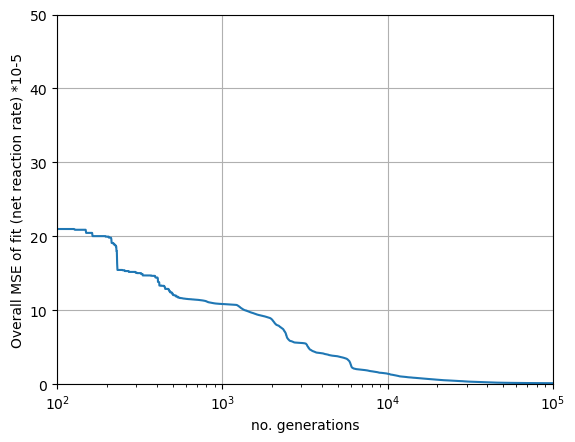

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-11.378119738678427
1.5005622865864785
0.8132111089068879
-4.337474195684009
0.5076128553875477
0.018418034091781957
0.4023884259003319
-6.994356536333765
0.5915935646843123
6.576902028439357
5.1873790228934
5.225782119612581
0.8257336243498922
0.022086089220868993
3.0834063382456236
1.1010094599852798e-06
0.13204792313037086
-11.605128709471531
1.829293428299101
1.5363042788719001
-10.942214466542879
1.1226944114112578
3.766663768721038
0.017014725591802435
3.936220506409286
4.560251079780164
1.8310796388875847
10.013423481955037
-11.725525990319655
3.2280197091378855
1.7989038166813247
4.092880435788356
-4.025505620345283
0.5048195530225891
1.0007356330018753
-1.301029824060139


In [37]:
res.X

array([-1.13781197e+01,  1.50056229e+00,  8.13211109e-01, -4.33747420e+00,
        5.07612855e-01,  1.84180341e-02,  4.02388426e-01, -6.99435654e+00,
        5.91593565e-01,  6.57690203e+00,  5.18737902e+00,  5.22578212e+00,
        8.25733624e-01,  2.20860892e-02,  3.08340634e+00,  1.10100946e-06,
        1.32047923e-01, -1.16051287e+01,  1.82929343e+00,  1.53630428e+00,
       -1.09422145e+01,  1.12269441e+00,  3.76666377e+00,  1.70147256e-02,
        3.93622051e+00,  4.56025108e+00,  1.83107964e+00,  1.00134235e+01,
       -1.17255260e+01,  3.22801971e+00,  1.79890382e+00,  4.09288044e+00,
       -4.02550562e+00,  5.04819553e-01,  1.00073563e+00, -1.30102982e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin
y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -11.378119738678427
1.6: 1.5005622865864785
0.9: 0.8132111089068879
-4.3: -4.337474195684009
0.5: 0.5076128553875477
0.003: 0.018418034091781957
0.4: 0.4023884259003319
-7.9: -6.994356536333765
0.7: 0.5915935646843123
7.2: 6.576902028439357
5.7: 5.1873790228934
5.7: 5.225782119612581
0.8: 0.8257336243498922
0.03: 0.022086089220868993
3.1: 3.0834063382456236
6.000000000000001e-09: 1.1010094599852798e-06
0.1: 0.13204792313037086
-12.0: -11.605128709471531
1.9: 1.829293428299101
1.6: 1.5363042788719001
-11.6: -10.942214466542879
1.2: 1.1226944114112578
4.0: 3.766663768721038
0.01: 0.017014725591802435
4.2: 3.936220506409286
5.4: 4.560251079780164
2.2: 1.8310796388875847
11.8: 10.013423481955037
-12.0: -11.725525990319655
3.3: 3.2280197091378855
1.8: 1.7989038166813247
4.2: 4.092880435788356
-4.0: -4.025505620345283
0.5: 0.5048195530225891
1.0: 1.0007356330018753
coeff fit: 0.9933070107621678
r: 0.9966478870504707


In [1]:
# Use stored solution
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

y_mean = np.mean(logkr)

# average of log kr of 3 seeds
krseed1 = [-1.13781197e+01,  1.50056229e+00,  8.13211109e-01, -4.33747420e+00,
        5.07612855e-01,  1.84180341e-02,  4.02388426e-01, -6.99435654e+00,
        5.91593565e-01,  6.57690203e+00,  5.18737902e+00,  5.22578212e+00,
        8.25733624e-01,  2.20860892e-02,  3.08340634e+00,  1.10100946e-06,
        1.32047923e-01, -1.16051287e+01,  1.82929343e+00,  1.53630428e+00,
       -1.09422145e+01,  1.12269441e+00,  3.76666377e+00,  1.70147256e-02,
        3.93622051e+00,  4.56025108e+00,  1.83107964e+00,  1.00134235e+01,
       -1.17255260e+01,  3.22801971e+00,  1.79890382e+00,  4.09288044e+00,
       -4.02550562e+00,  5.04819553e-01,  1.00073563e+00, -1.30102982e+00]
#np.ndarray.tolist(res.X)

#%store -r resX10sres
krseed10 = [-1.13275873e+01,  1.49240145e+00,  8.05267377e-01, -4.29896524e+00,
        5.00654343e-01,  7.97316880e-03,  4.01382854e-01, -6.77919331e+00,
        5.66406393e-01,  6.41459873e+00,  5.04279538e+00,  5.09295954e+00,
        8.19339784e-01,  2.21872110e-02,  3.08529009e+00,  5.14070463e-06,
        1.42166114e-01, -1.16667891e+01,  1.83979110e+00,  1.54514599e+00,
       -1.13935478e+01,  1.17092155e+00,  3.88668258e+00,  1.14460687e-02,
        4.13659212e+00,  4.66938198e+00,  1.85676047e+00,  1.01667169e+01,
       -1.17193687e+01,  3.24533690e+00,  1.84229260e+00,  4.11490789e+00,
       -4.02946745e+00,  5.05944285e-01,  1.00496581e+00, -1.30102939e+00]
#np.ndarray.tolist(resX10sres)

#%store -r resX101sres
krseed101 = [-1.12541902e+01,  1.48073971e+00,  7.95695432e-01, -4.32767584e+00,
        5.02567689e-01,  1.96383844e-05,  3.94786518e-01, -1.12645389e+01,
        1.10476941e+00,  9.52051505e+00,  7.63568405e+00,  7.49155071e+00,
        9.37697882e-01,  2.37200881e-02,  3.18138942e+00,  1.19457702e-03,
        3.92951816e-02, -1.17378650e+01,  1.85245321e+00,  1.54762166e+00,
       -1.02725709e+01,  1.04813031e+00,  3.53937523e+00,  4.44167032e-02,
        3.61428846e+00,  4.23972262e+00,  1.59818459e+00,  9.00282620e+00,
       -9.31685097e+00,  2.61985029e+00,  1.71593071e+00,  3.36028602e+00,
       -4.31231115e+00,  5.56363227e-01,  1.01985613e+00, -1.30102958e+00]
#np.ndarray.tolist(resX101sres)

krs = np.array([krseed1, krseed10, krseed101])

meankr=np.average(krs, axis=0)

meankr=np.ndarray.tolist(meankr)
del meankr[-1]

# R2 of fitting actual logkr =  modeled logkr

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,meankr):
    #print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

for i in range(len (meankr)):
    print (meankr[i])

coeff fit: 0.9919214475780582
r: 0.9959525327936358
-11.319965733333333
1.4912344833333335
0.8047246393333333
-4.321371760000001
0.503611629
0.008803613761466668
0.399519266
-8.346029583333333
0.7542564559999999
7.50400527
5.955286149999999
5.936764123333333
0.8609237633333334
0.022664462766666667
3.1166952833333332
0.0004002729113633333
0.10450307286666667
-11.6699276
1.8405125800000002
1.5430239766666667
-10.869444399999999
1.1139154233333335
3.7309071933333335
0.024292499166666665
3.8957003633333342
4.489785226666666
1.7620082333333331
9.727655533333333
-10.92058189
3.0310689666666666
1.7857090433333334
3.8560247833333334
-4.1224280733333325
0.5223756883333333
1.0085191900000001


In [2]:
meankr

[-11.319965733333333,
 1.4912344833333335,
 0.8047246393333333,
 -4.321371760000001,
 0.503611629,
 0.008803613761466668,
 0.399519266,
 -8.346029583333333,
 0.7542564559999999,
 7.50400527,
 5.955286149999999,
 5.936764123333333,
 0.8609237633333334,
 0.022664462766666667,
 3.1166952833333332,
 0.0004002729113633333,
 0.10450307286666667,
 -11.6699276,
 1.8405125800000002,
 1.5430239766666667,
 -10.869444399999999,
 1.1139154233333335,
 3.7309071933333335,
 0.024292499166666665,
 3.8957003633333342,
 4.489785226666666,
 1.7620082333333331,
 9.727655533333333,
 -10.92058189,
 3.0310689666666666,
 1.7857090433333334,
 3.8560247833333334,
 -4.1224280733333325,
 0.5223756883333333,
 1.0085191900000001]

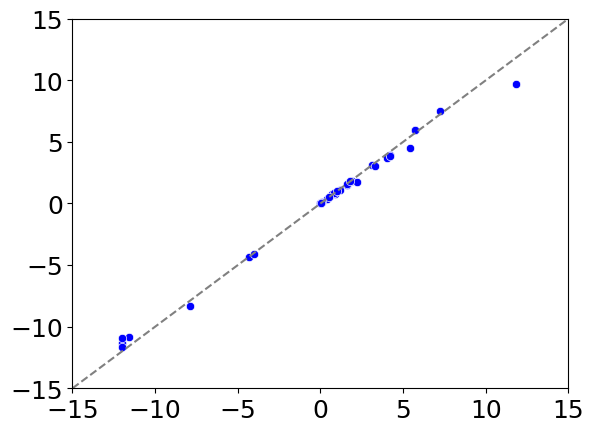

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot using Seaborn
sns.scatterplot(x=logkr, y= meankr, color='blue') #, label='Data Points')

# Add labels and title
#plt.xlabel('True parameter values (log10)')
#plt.ylabel('Fitted parameter values (log10)')

plt.xlim([-15, 15])
plt.ylim([-15, 15])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18) 

# Add a diagonal line
plt.plot([-15, 15], [-15, 15], color='grey', linestyle='--', label='Diagonal Line')


# Display the plot
plt.show()